In [1]:
from LRL import *

In [2]:
USE_CUDA

True

In [3]:
def make_env(seed):
    def _thunk():
        env = gym.make("BipedalWalker-v2")
        env.seed(seed)
        return env
    return _thunk

In [4]:
class Actor(nn.Module):
    def __init__(self, linear):
        super().__init__()
        self.layers = nn.Sequential(
                        linear(24 + 10, 128),
                        #linear(24, 128),
                        nn.ReLU(),
                        linear(128, 128),
                        nn.ReLU(),
                        linear(128, 4),
                        nn.Tanh()
                                   )
        
    def forward(self, x):
        noise = Tensor(x.shape[0], 10).normal_()
        return self.layers(torch.cat([x, noise], dim=1))
        #return self.layers(x)

In [5]:
class Critic(nn.Module):
    def __init__(self, linear):
        super().__init__()
        self.layers = nn.Sequential(
                        linear(28, 128),
                        nn.ReLU(),
                        linear(128, 128),
                        nn.ReLU(),
                        linear(128, 1)
                                   )
        
    def forward(self, x, a):
        return self.layers(torch.cat([x, a], dim=1))

In [6]:
def A4C(parclass):
    """Requires parent class, inherited from Agent."""

    class A4C(parclass):
        """
        Experimental. Adversarial Advantage Actor-Critic algorithm (A4C).
        Requires parent class inherited from Agent.

        Args:
            Actor - class of ActorHead
            Critic - class of CriticHead
            rollout - number of frames for one iteration of updating NN weights
            gamma - infinite horizon protection, float, from 0 to 1
        """
        __doc__ += parclass.__doc__
        PARAMS = parclass.PARAMS | {"Actor", "Critic", "rollout", "gamma"} 

        def __init__(self, config):
            super().__init__(config)

            self.config.setdefault("gamma", 0.99)
            self.config.setdefault("rollout", 5)
            
            self.actor1 = self.config.Actor(nn.Linear).to(device)
            self.actor1_optimizer = optim.SGD(self.actor1.parameters(), lr=1e-3)
            self.actor2 = self.config.Actor(nn.Linear).to(device)
            self.actor2_optimizer = optim.SGD(self.actor2.parameters(), lr=1e-3)
            
            self.critic1 = self.config.Critic(nn.Linear).to(device)
            self.critic1_optimizer = optim.SGD(self.critic1.parameters(), lr=1e-3)
            self.critic2 = self.config.Critic(nn.Linear).to(device)
            self.critic2_optimizer = optim.SGD(self.critic2.parameters(), lr=1e-3)

            self.observations = Tensor(size=(self.config.rollout + 1, self.env.num_envs, *self.config.observation_shape)).zero_()
            self.rewards = Tensor(size=(self.config.rollout, self.env.num_envs)).zero_()
            self.actions = self.ActionTensor(size=(self.config.rollout + 1, self.env.num_envs, *self.config.actions_shape)).zero_()
            self.dones = Tensor(size=(self.config.rollout + 1, self.env.num_envs)).zero_()
            self.step = 0
            
            self.myR = np.zeros((self.env.num_envs), dtype=np.float32)
            self.logger_labels["actor1_rewards"] = ("episode", "actor_rewards")
            self.logger_labels["actor2_rewards"] = ("episode", "actor_rewards")

            self.logger_labels["actor1_loss"] = ("training iteration", "loss")
            self.logger_labels["critic1_loss"] = ("training iteration", "critic_loss")
            self.logger_labels["actor2_loss"] = ("training iteration", "loss")
            self.logger_labels["critic2_loss"] = ("training iteration", "critic_loss")
            self.logger_labels["discriminator_loss"] = ("training iteration", "loss")
            self.logger_labels["who_is_better"] = ("training iteration", "discriminator output")
            self.logger_labels["critic1"] = ("training iteration", "critic")
            self.logger_labels["critic2"] = ("training iteration", "critic")
            
            self.logger["actor1_rewards"].append(-100)
            self.logger["actor2_rewards"].append(-100)

        def act(self, s, record=False):
            with torch.no_grad():
                actions1 = self.actor1(Tensor(s[:self.env.num_envs // 2]))
                actions2 = self.actor2(Tensor(s[self.env.num_envs // 2:]))
            
            return torch.cat([actions1, actions2], dim=0).cpu().numpy()

        def see(self, state, action, reward, next_state, done):
            super().see(state, action, reward, next_state, done)

            self.myR += reward
            for i in range(self.env.num_envs):
                if done[i]:
                    if i < self.env.num_envs // 2:
                        self.logger["actor1_rewards"].append(self.myR[i])
                        self.logger["actor2_rewards"].append(self.logger["actor2_rewards"][-1])
                    else:
                        self.logger["actor2_rewards"].append(self.myR[i])
                        self.logger["actor1_rewards"].append(self.logger["actor1_rewards"][-1])
                    self.myR[i] = 0

            self.observations[self.step].copy_(Tensor(state))
            self.observations[self.step + 1].copy_(Tensor(next_state))
            self.actions[self.step].copy_(self.ActionTensor(action))
            self.rewards[self.step].copy_(Tensor(reward))
            self.dones[self.step + 1].copy_(Tensor(done.astype(np.float32)))

            self.step = (self.step + 1) % self.config.rollout        
            if self.step == 0:
                self.update()

        def compute_returns(self, values):
            '''
            Fills self.returns using self.rewards, self.dones
            input: values - Tensor, (self.rollout + 1, num_processes)
            '''
            self.returns[-1] = values[-1]
            for step in reversed(range(self.rewards.size(0))):
                self.returns[step] = self.returns[step + 1] * self.config.gamma * (1 - self.dones[step + 1]) + self.rewards[step]

        def update(self):
            """One step of optimization based on rollout memory"""
            state_b = self.observations.view(-1, *self.config.observation_shape)
            
            actions1_b = self.actor1(state_b)
            actions2_b = self.actor2(state_b)
            
            critic1_b = self.critic1(state_b, actions1_b).view(self.config.rollout + 1, -1)
            critic2_b = self.critic2(state_b, actions2_b).view(self.config.rollout + 1, -1)
            
            # actor losses
            actor1_loss = -critic2_b[:, :self.env.num_envs // 2].mean()
            actor2_loss = -critic1_b[:, self.env.num_envs // 2:].mean()
            
            # critic losses            
            critic1_y = self.rewards + self.config.gamma * (1 - self.dones[1:]) * critic1_b[1:]
            critic1_loss = ((critic1_b[:-1] - critic1_y.detach())**2)[:, :self.env.num_envs // 2].mean()
            
            critic2_y = self.rewards + self.config.gamma * (1 - self.dones[1:]) * critic2_b[1:]
            critic2_loss = ((critic2_b[:-1] - critic2_y.detach())**2)[:, self.env.num_envs // 2:].mean()
            
            # OPTIMIZING--------------------------------------------
            self.actor1_optimizer.zero_grad()
            actor1_loss.backward(retain_graph=True)
            self.actor1_optimizer.step()
            
            self.actor2_optimizer.zero_grad()
            actor2_loss.backward(retain_graph=True)
            self.actor2_optimizer.step()
            
            self.critic1_optimizer.zero_grad()
            critic1_loss.backward()
            self.critic1_optimizer.step()
            
            self.critic2_optimizer.zero_grad()
            critic2_loss.backward()
            self.critic2_optimizer.step()
            
            # logging
            self.logger["actor1_loss"].append(actor1_loss.item())
            self.logger["critic1_loss"].append(critic1_loss.item())
            self.logger["actor2_loss"].append(actor2_loss.item())
            self.logger["critic2_loss"].append(critic2_loss.item())
            self.logger["critic1"].append(critic1_b.median().item())
            self.logger["critic2"].append(critic2_b.median().item())
    return A4C

In [7]:
config = {
    "make_env": make_env,
    "threads": 16,
    "Actor": Actor,
    "Critic": Critic,
}

In [8]:
agent = A4C(Agent)(config)

In [9]:
%%time

for i in range(100000):
    agent.learn(1000)
    plot_durations(agent, 25)    

print('Complete')
plt.show()

KeyboardInterrupt: 

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


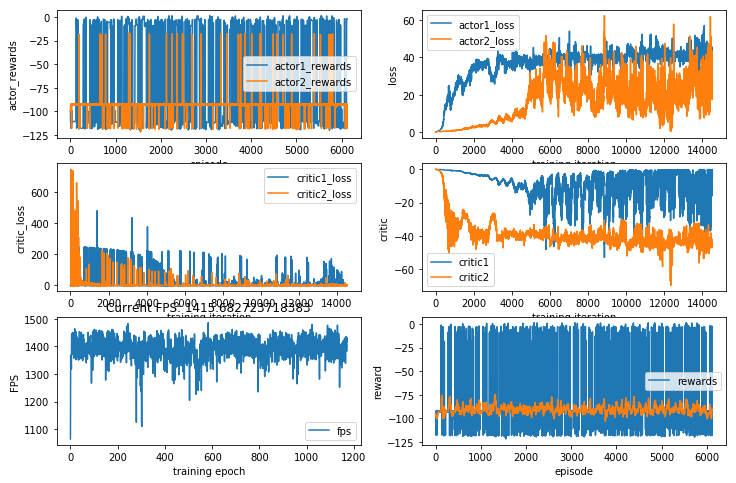

In [10]:
plot_durations(agent, 25)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


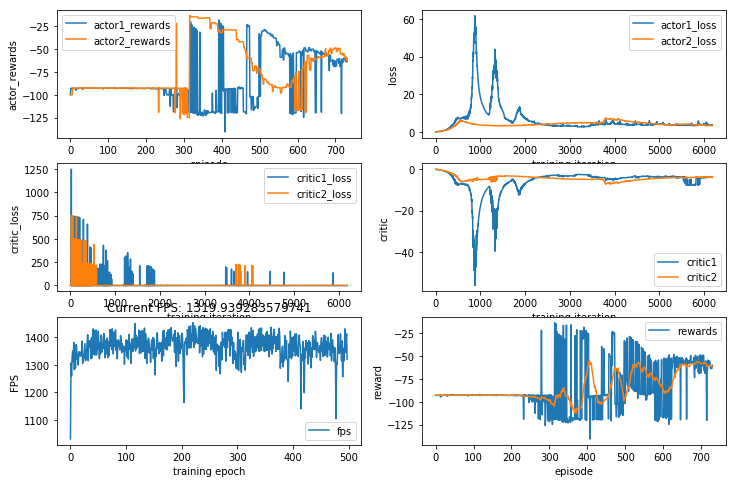

In [10]:
plot_durations(agent, 25)


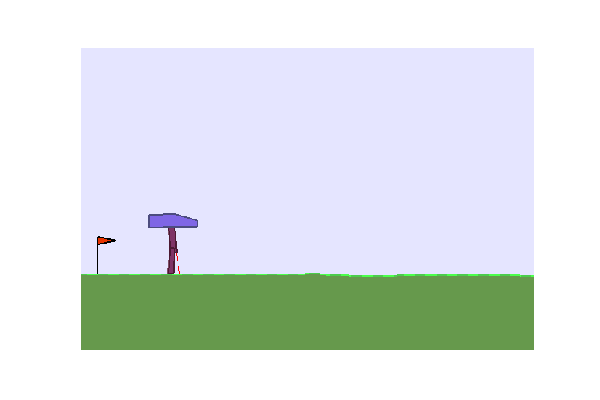
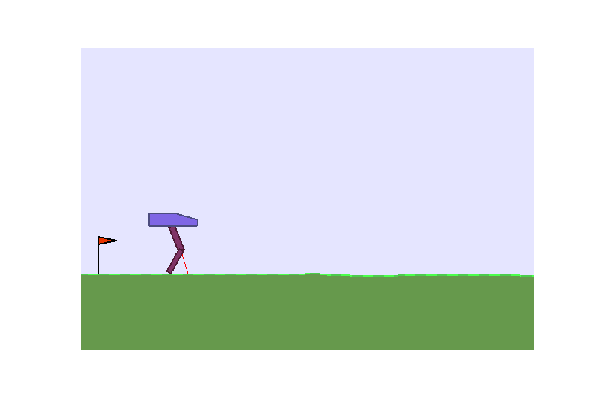
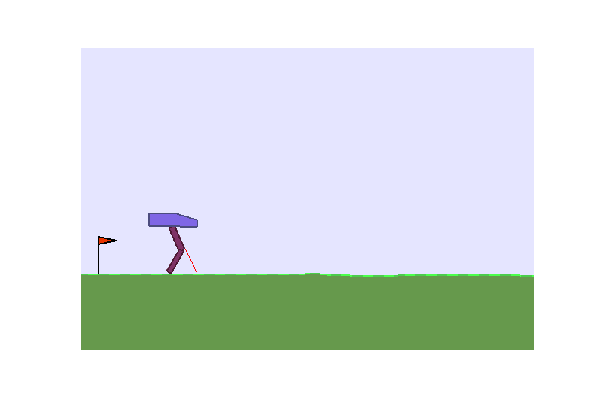
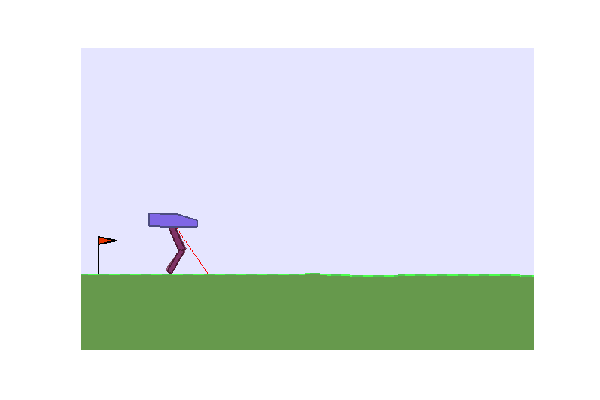
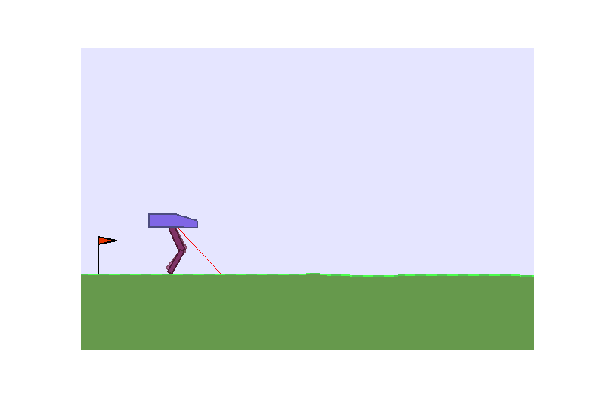
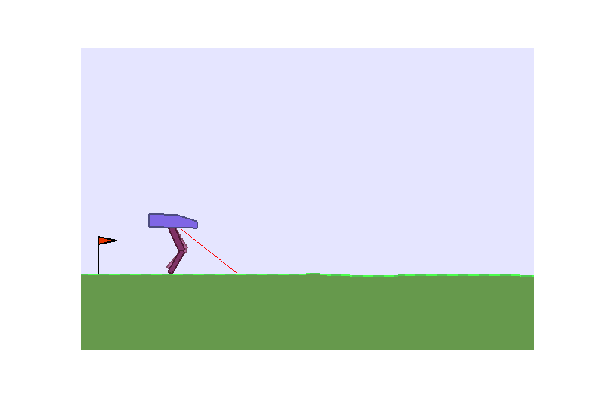
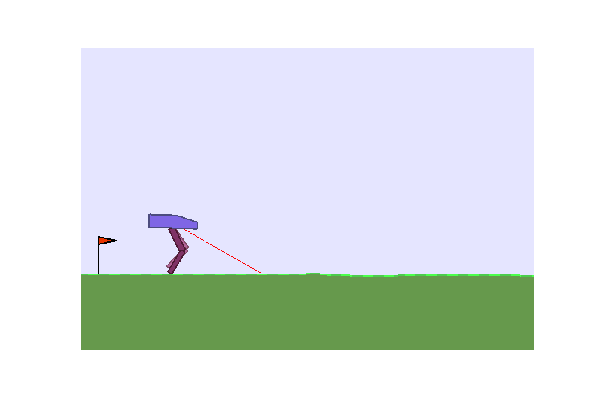
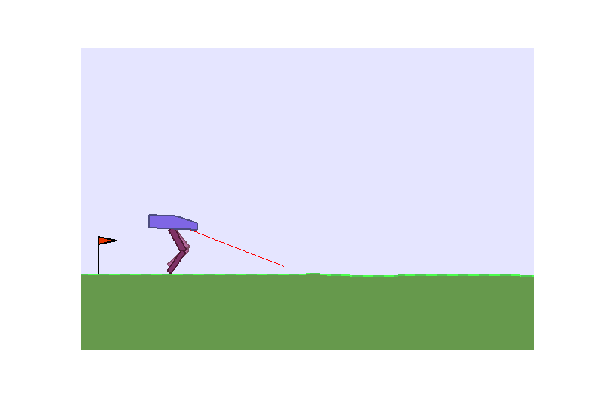
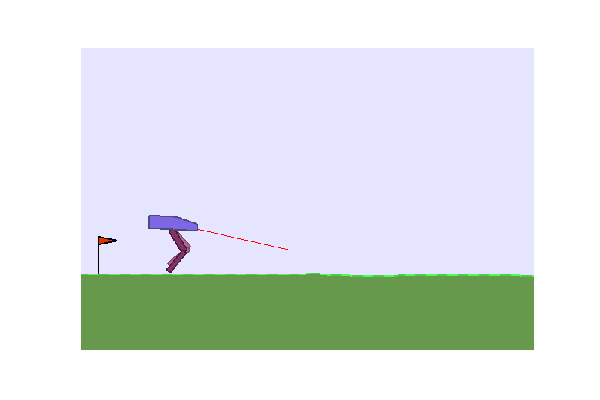
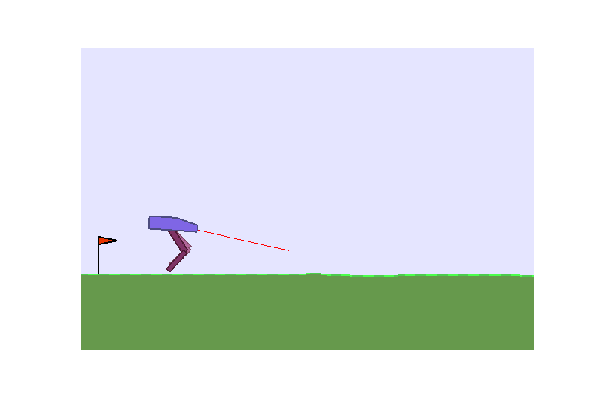
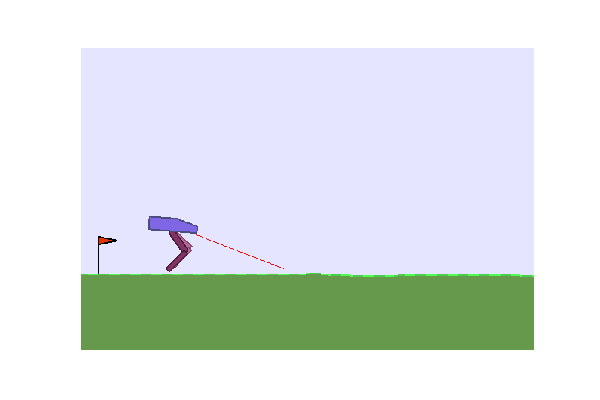
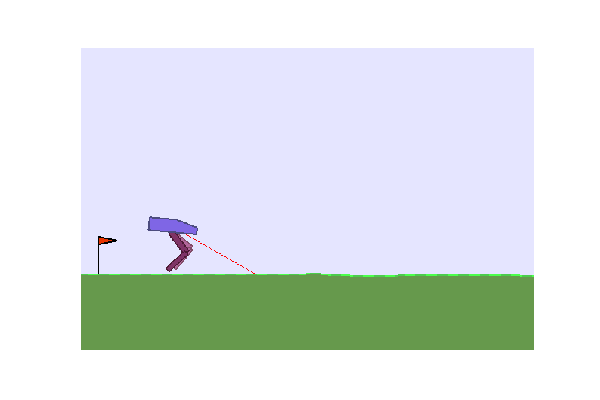
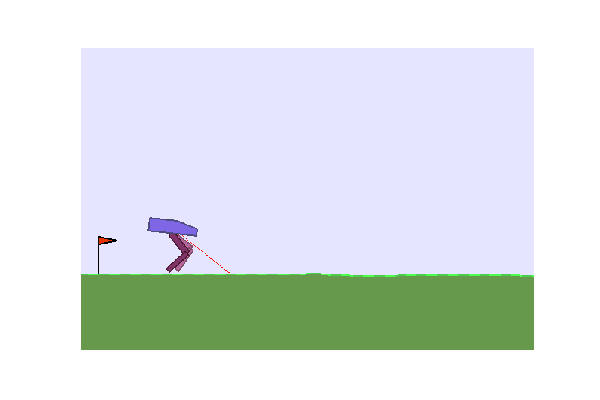
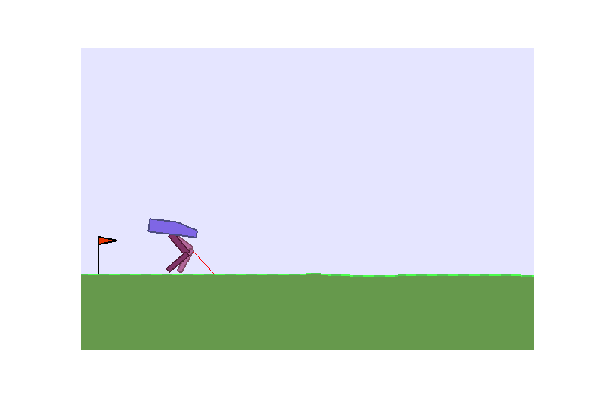
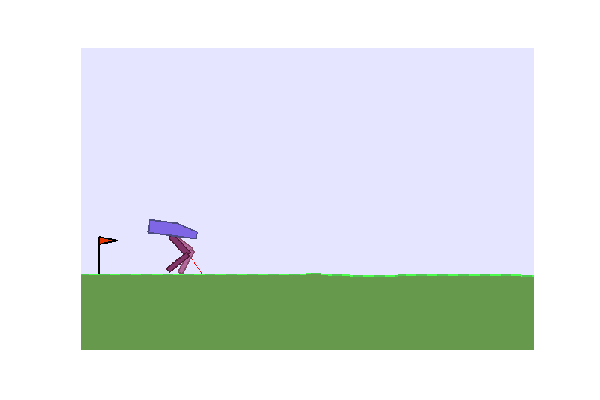
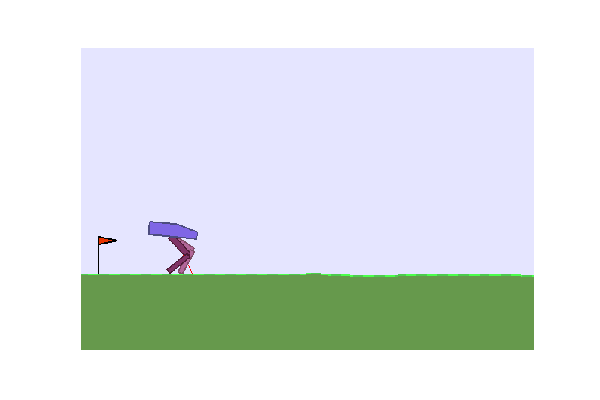
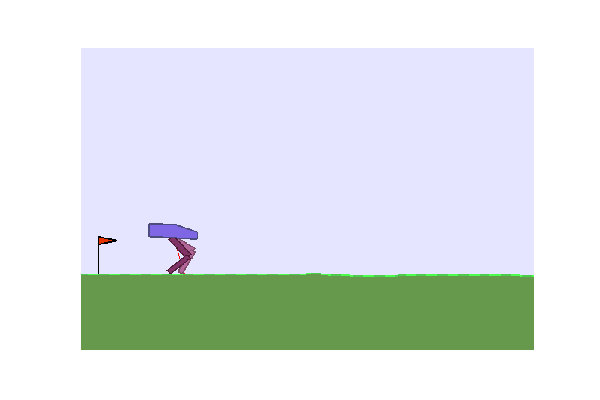
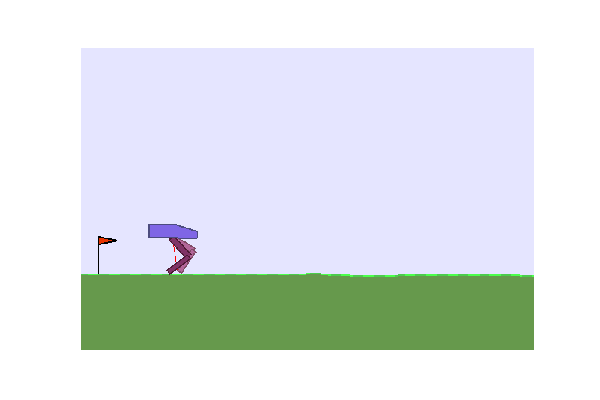
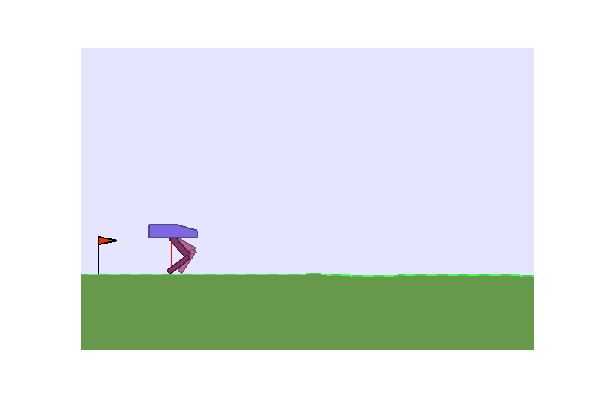
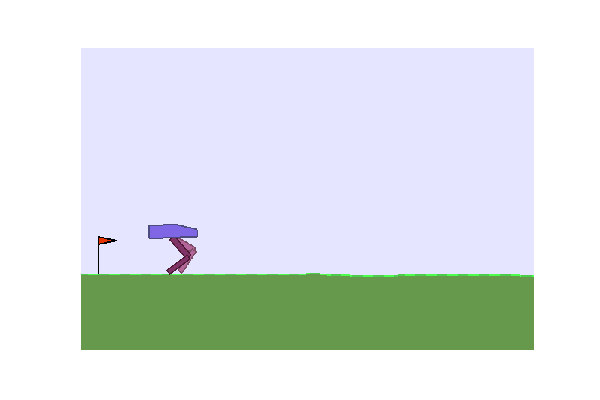
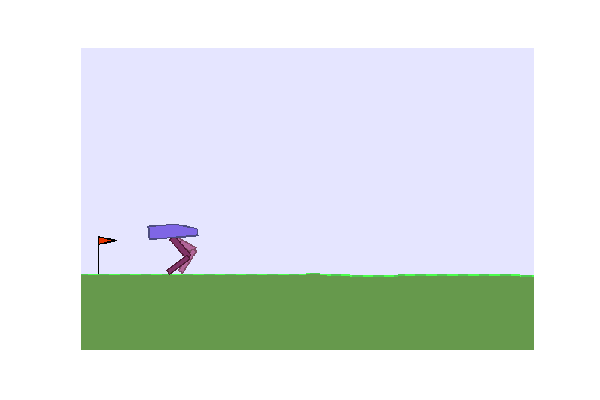
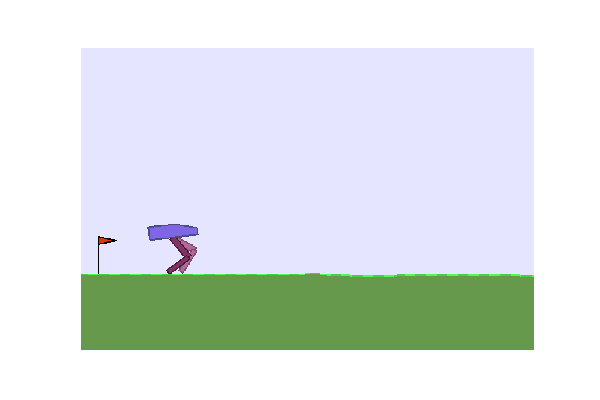
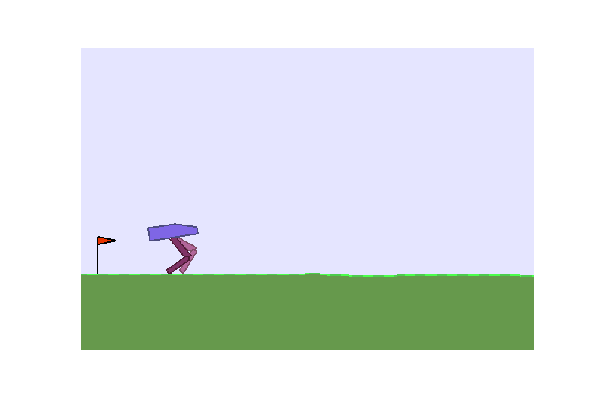
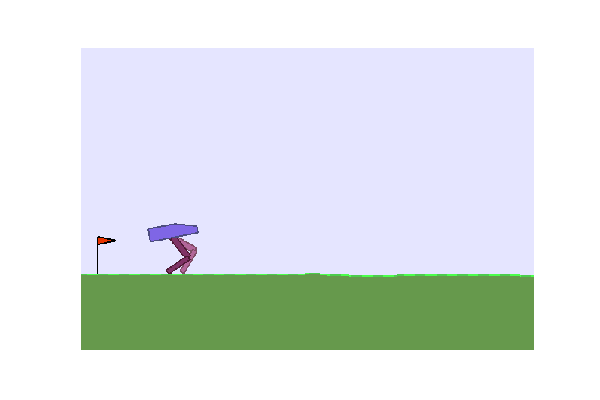
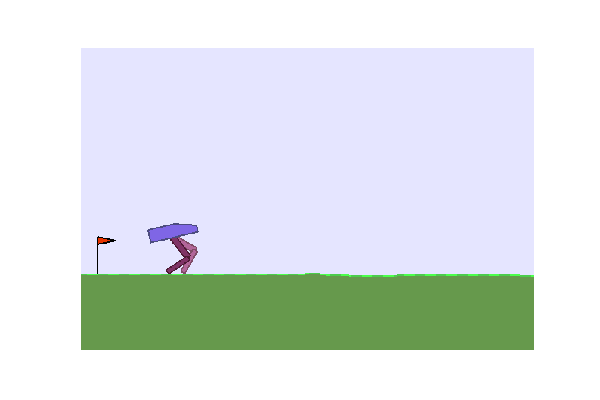
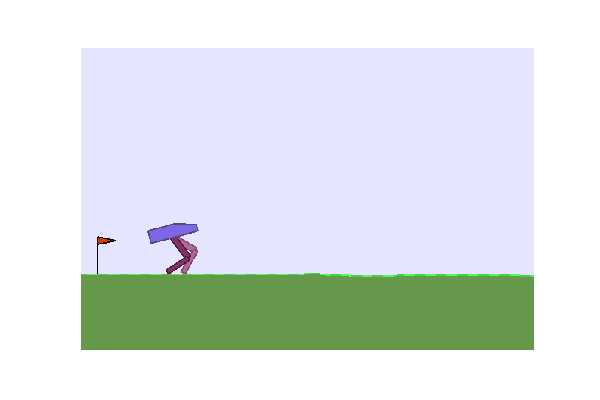
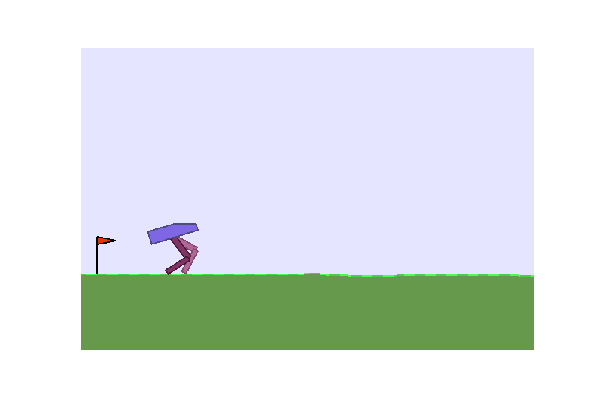
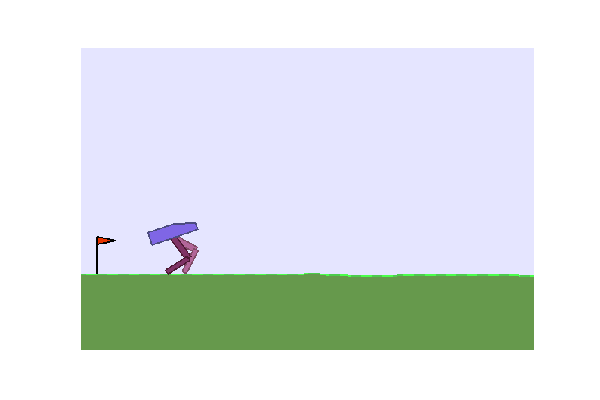
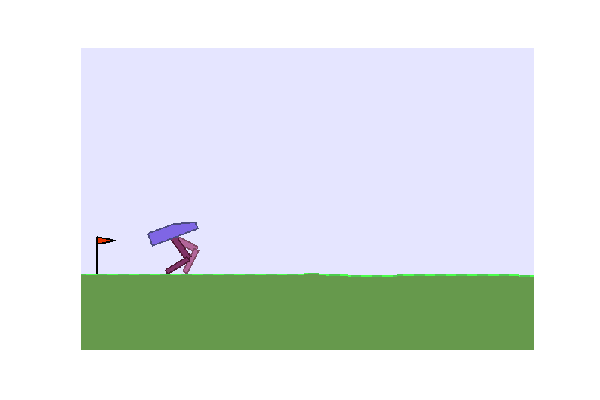
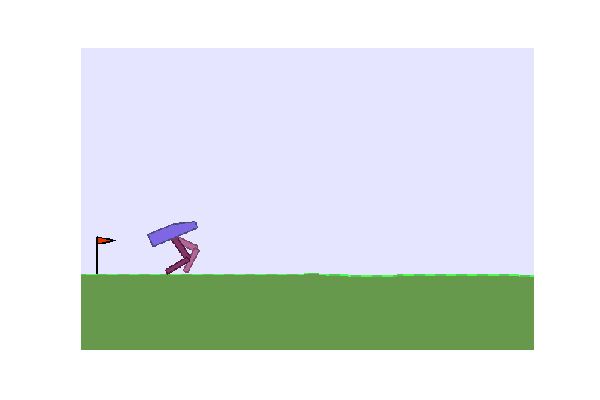
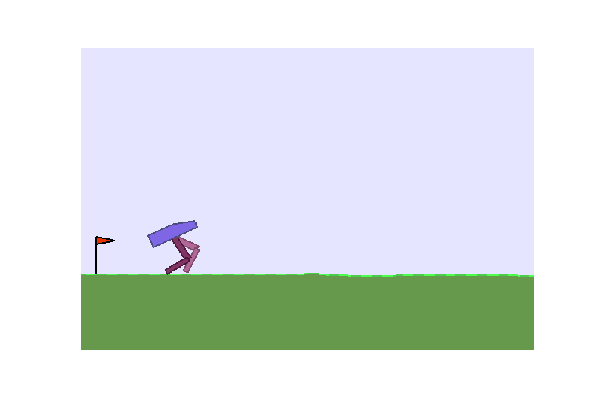
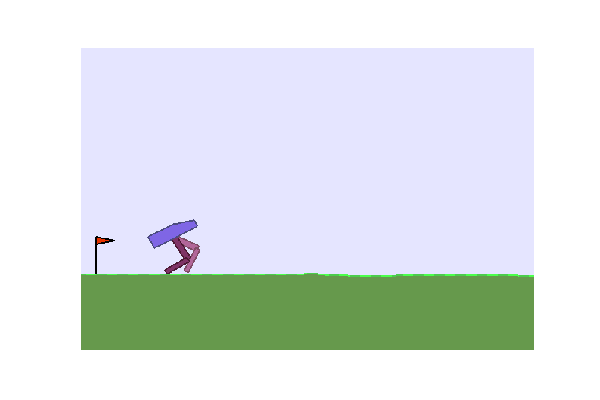
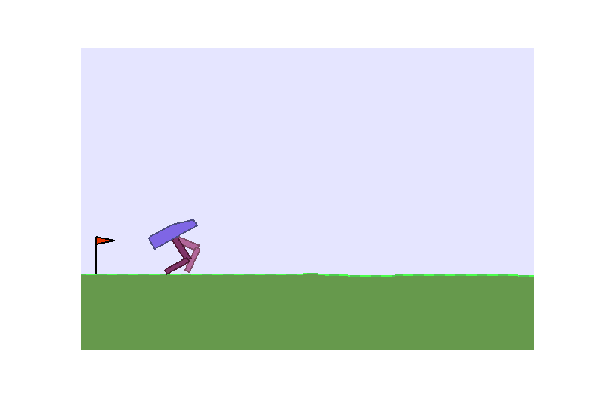
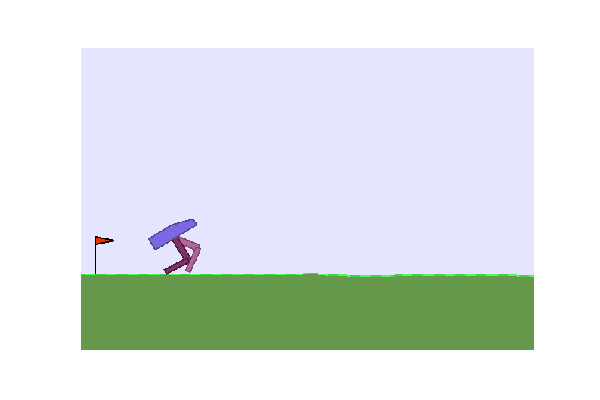
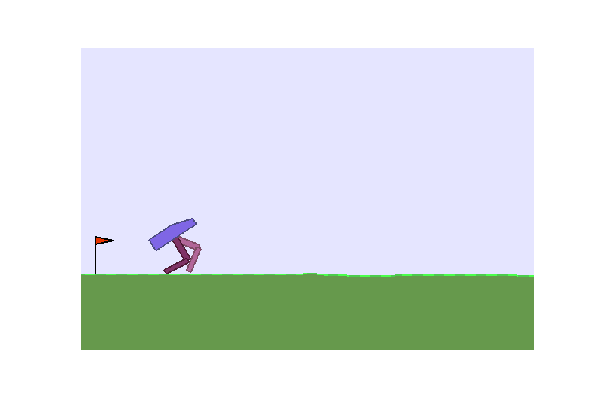
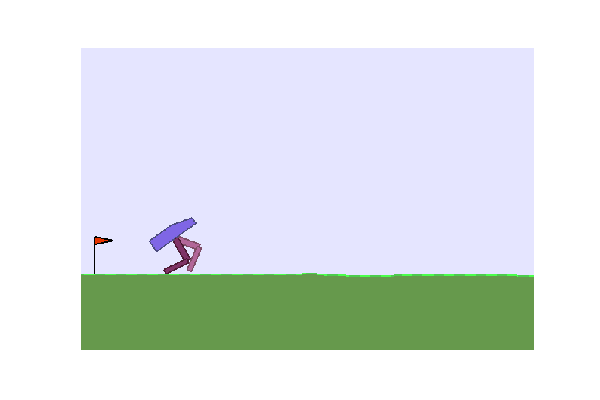
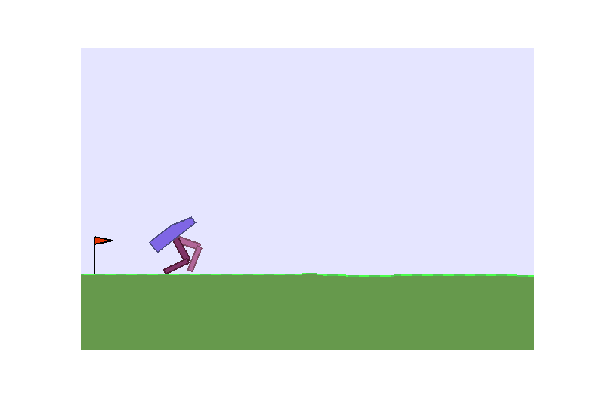
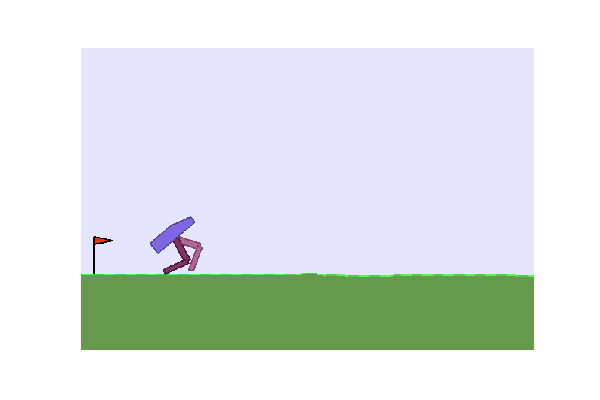
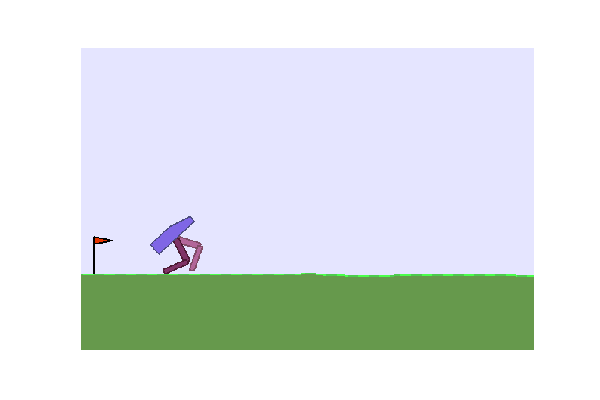
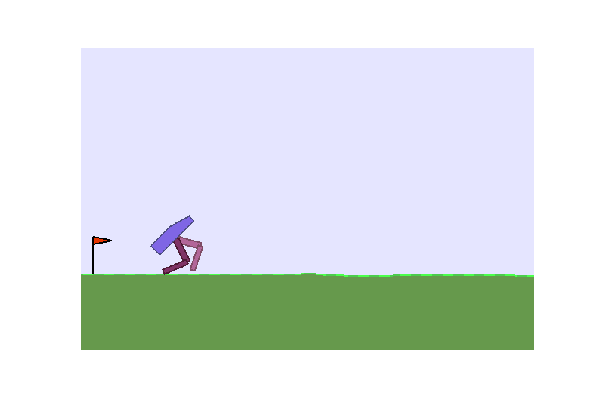
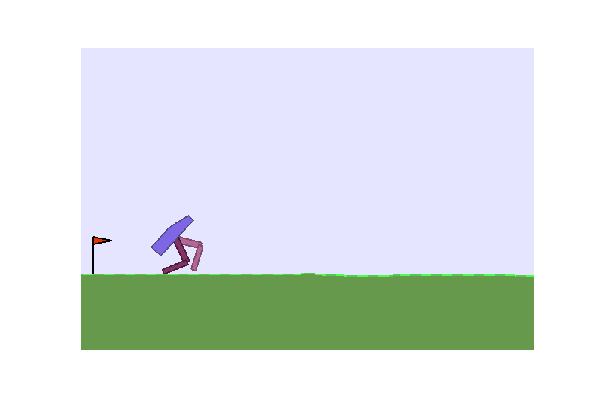
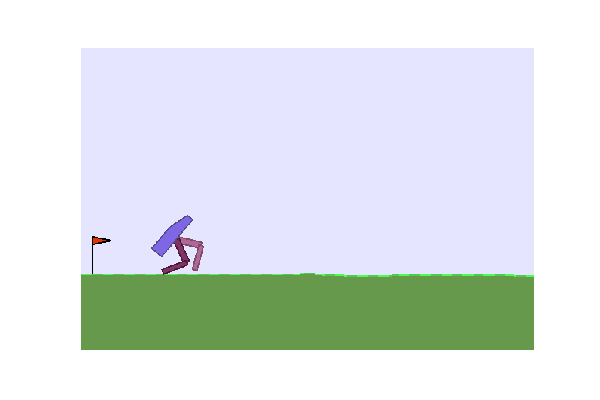
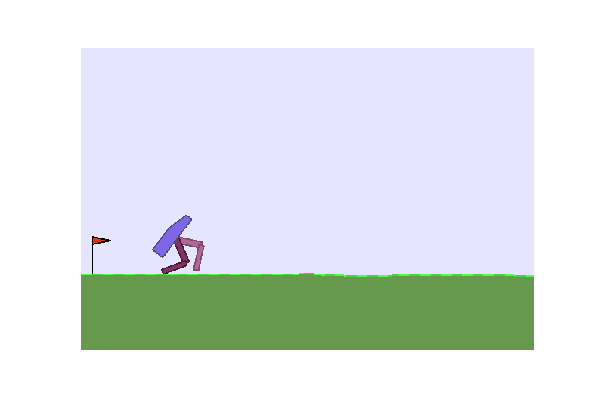
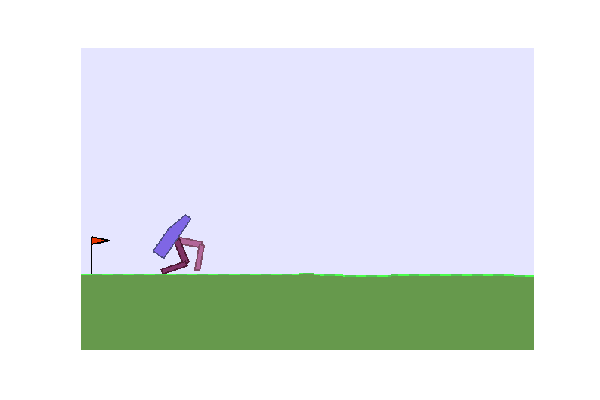
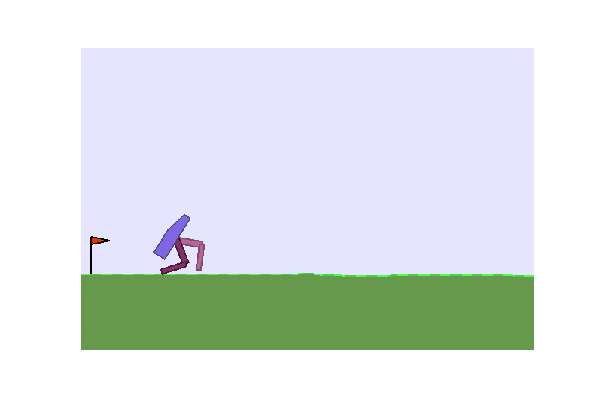
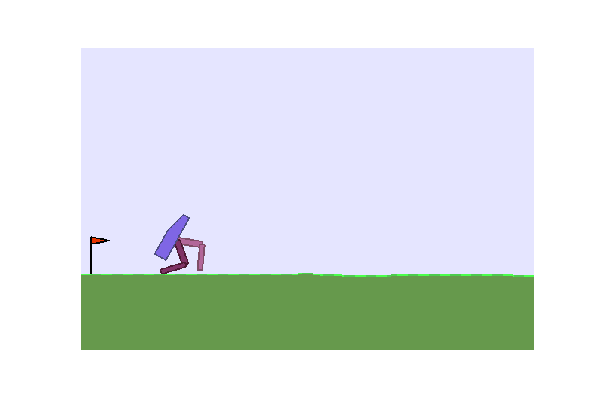
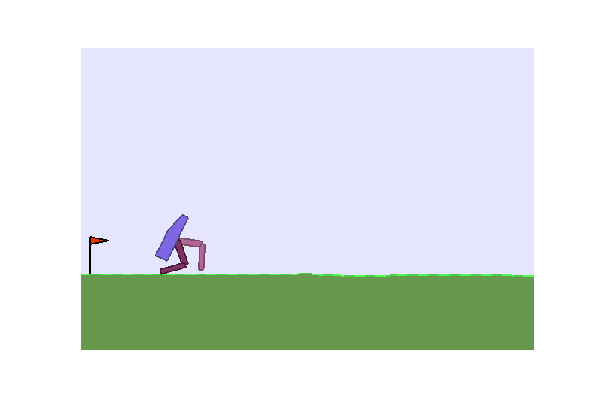
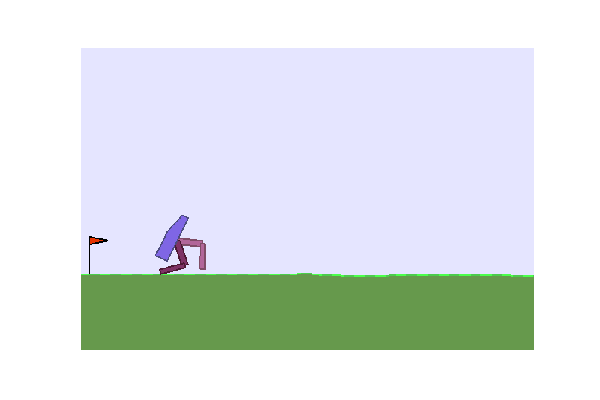
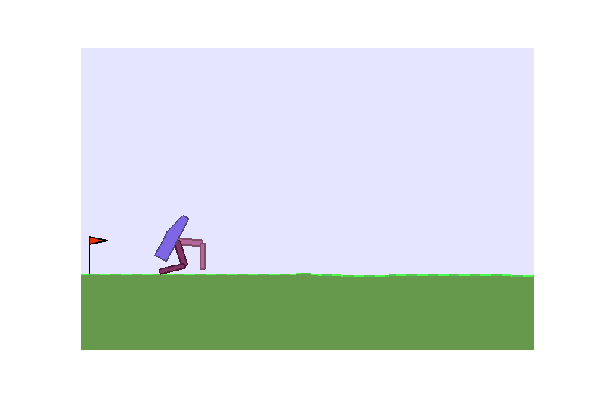
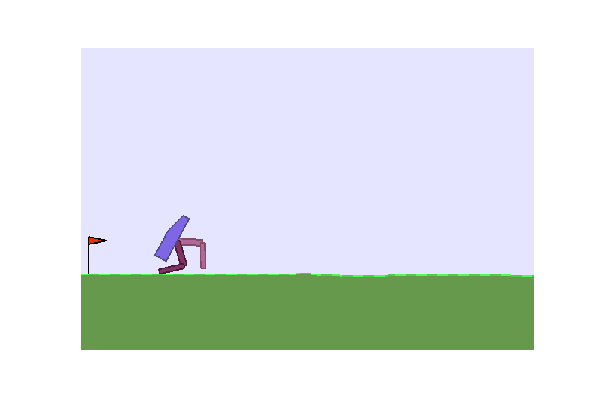
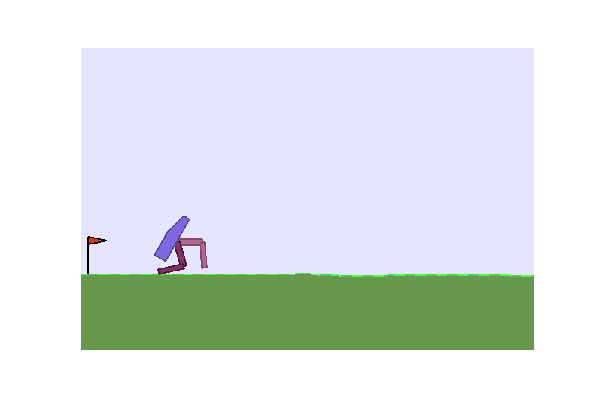
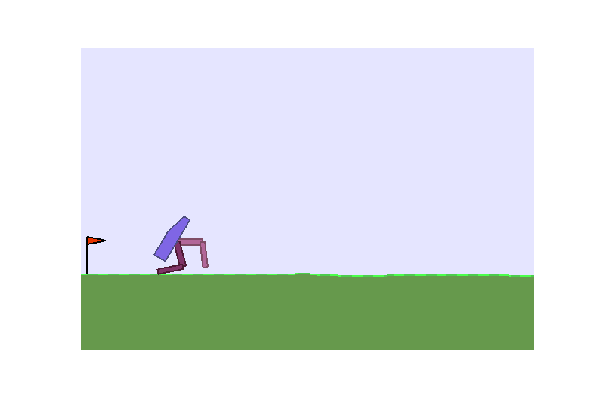
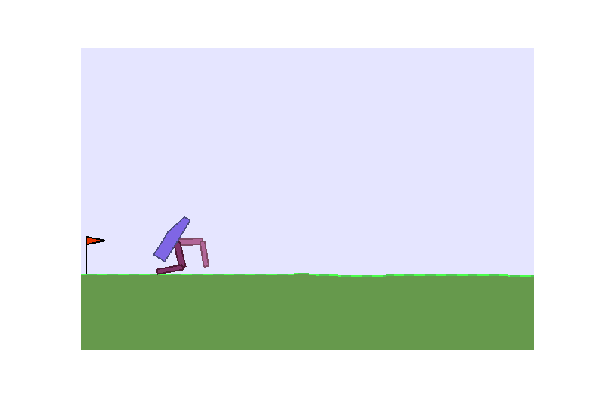
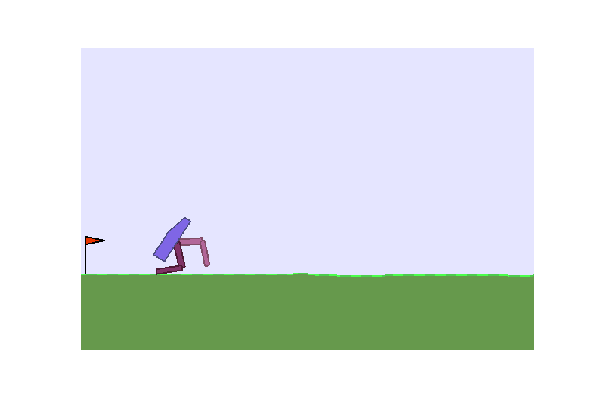
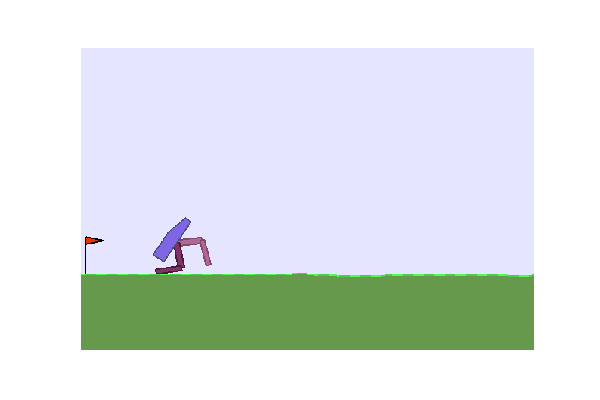
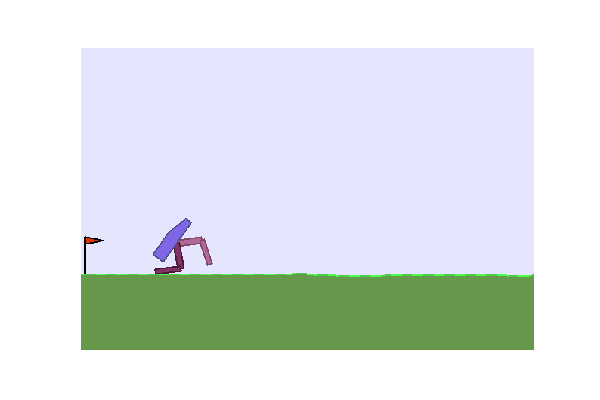
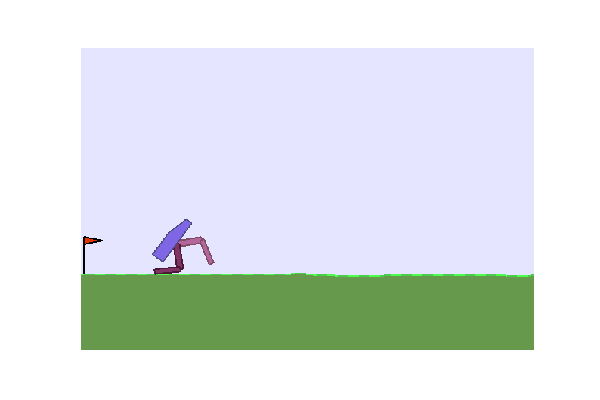
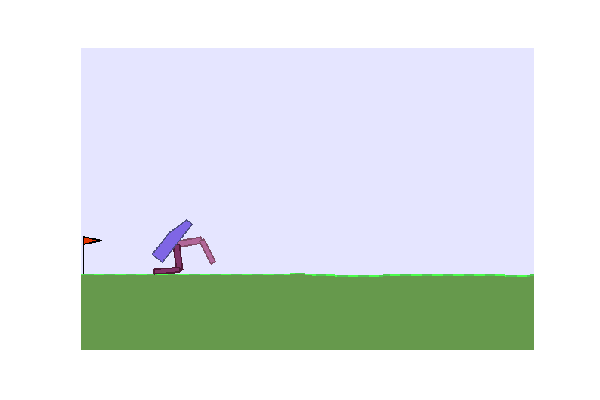
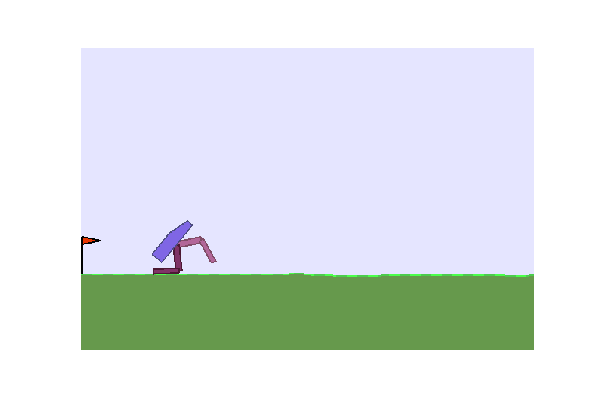
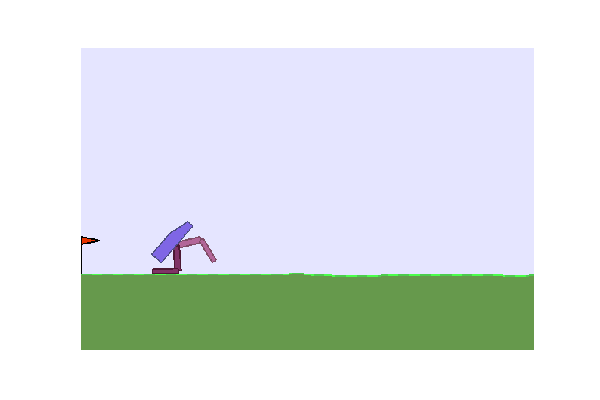
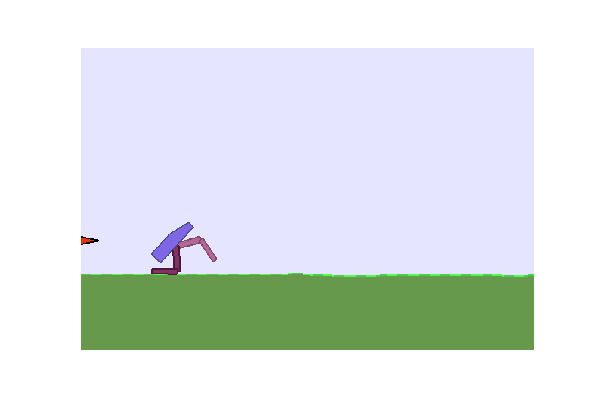
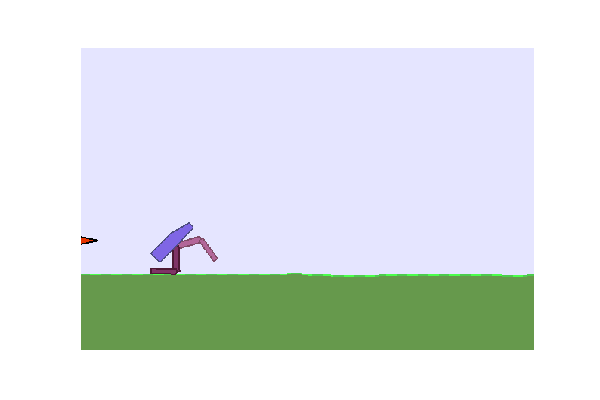
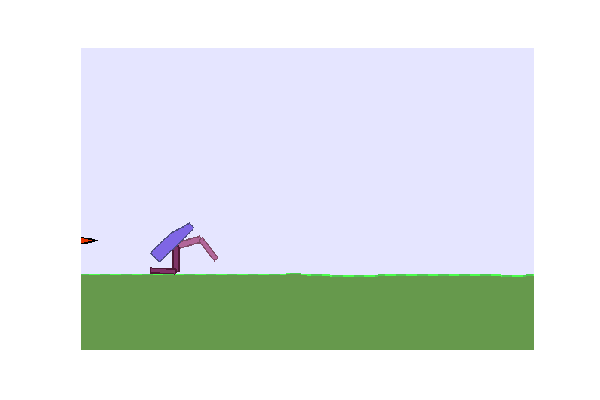
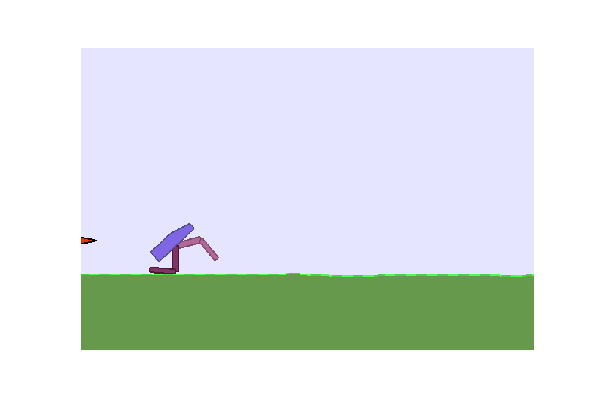
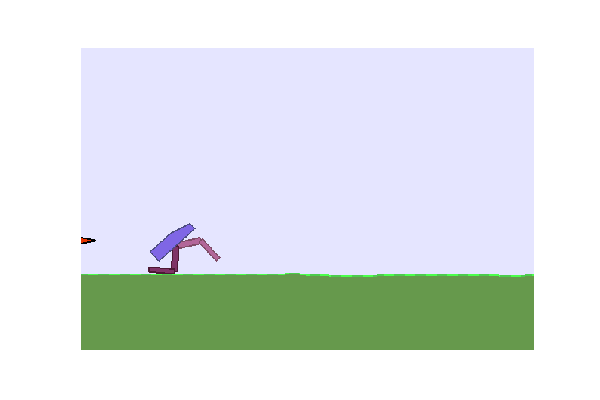
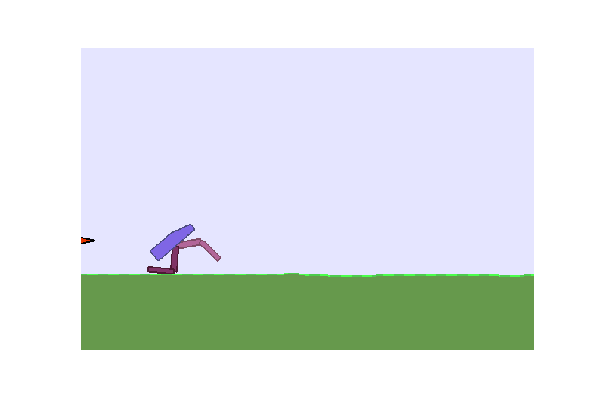
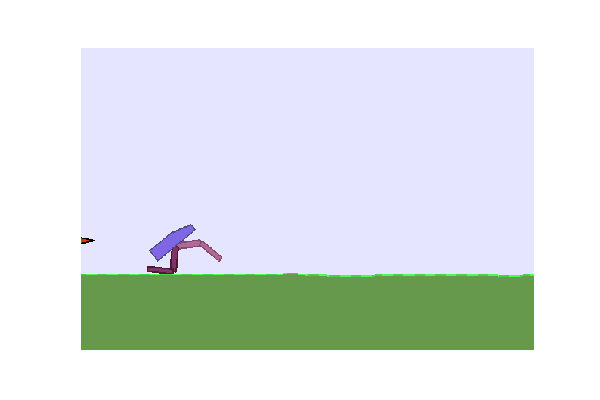
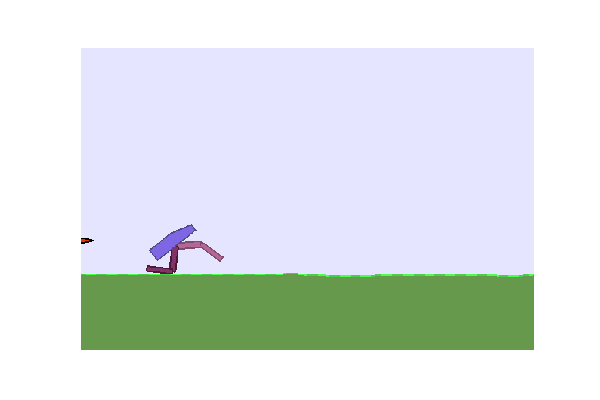
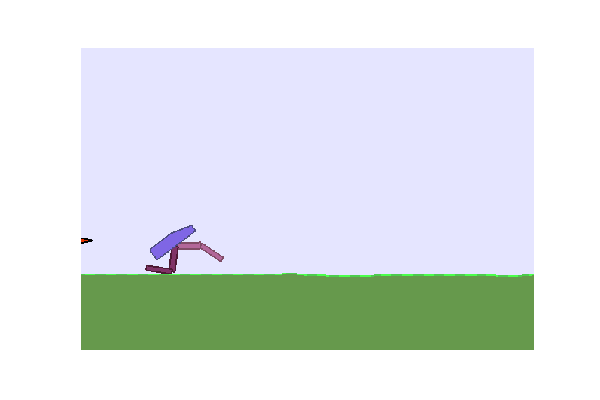
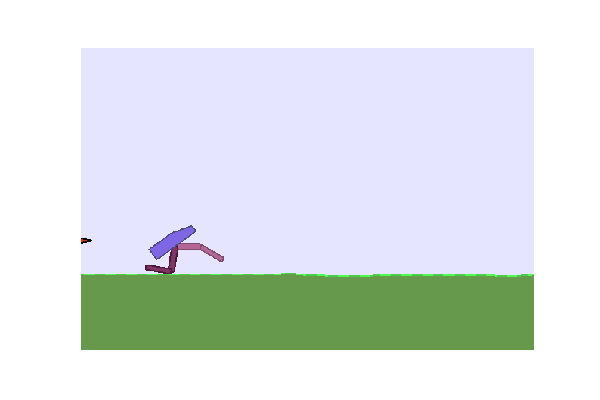
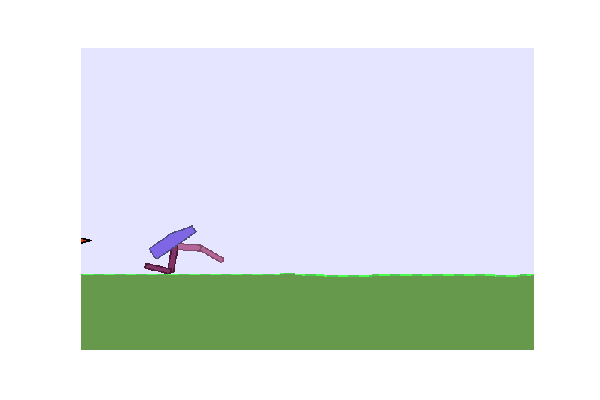
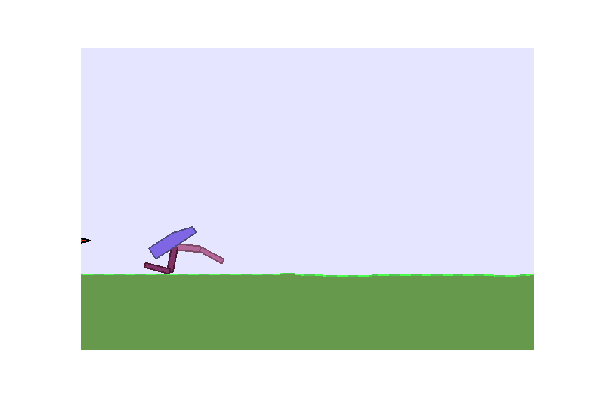
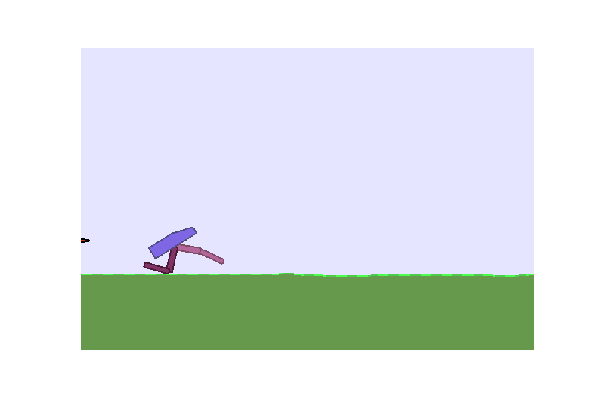
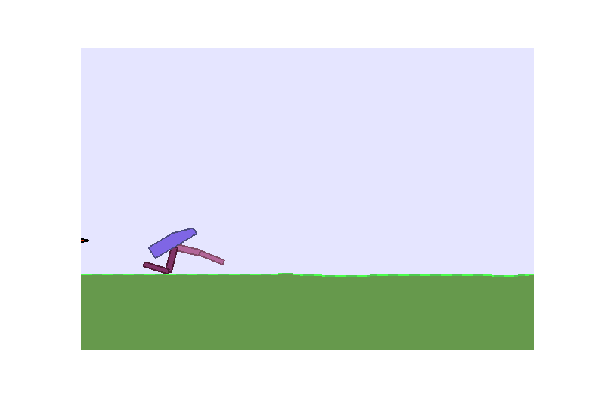
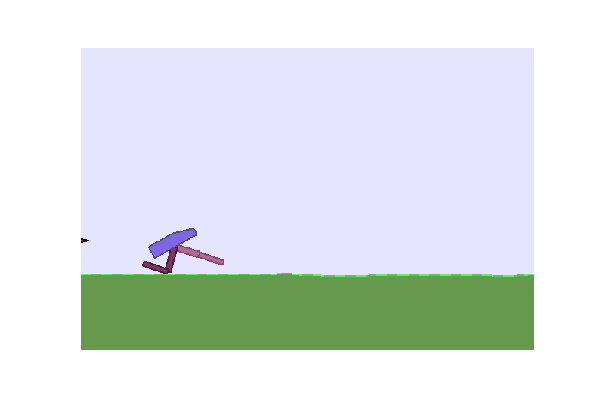
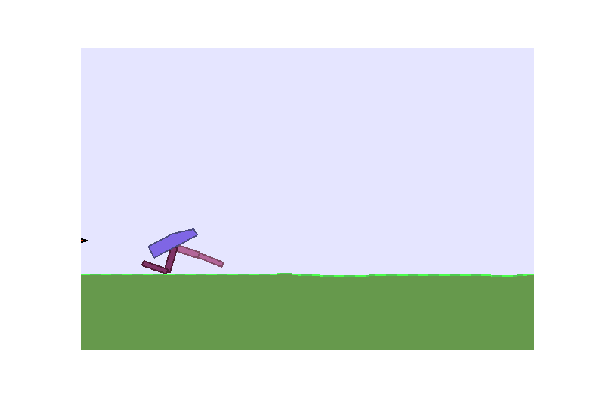
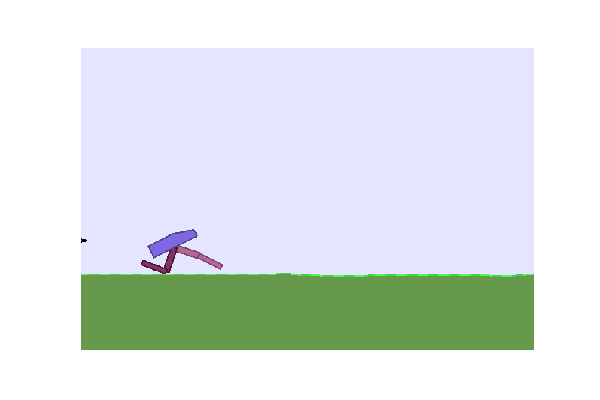
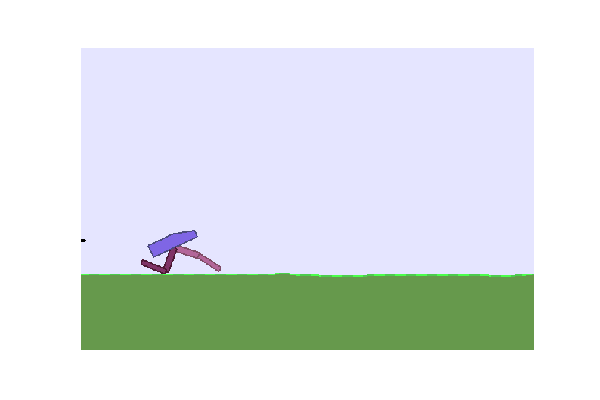
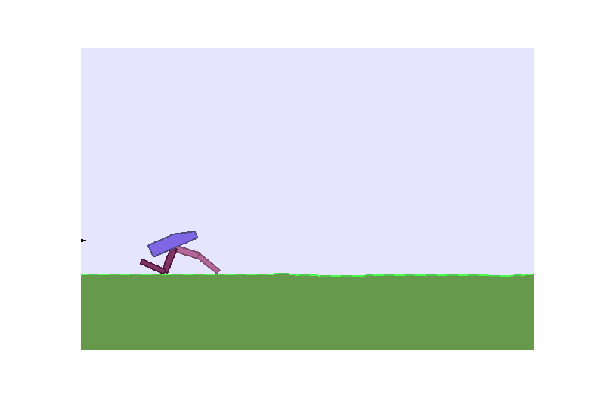
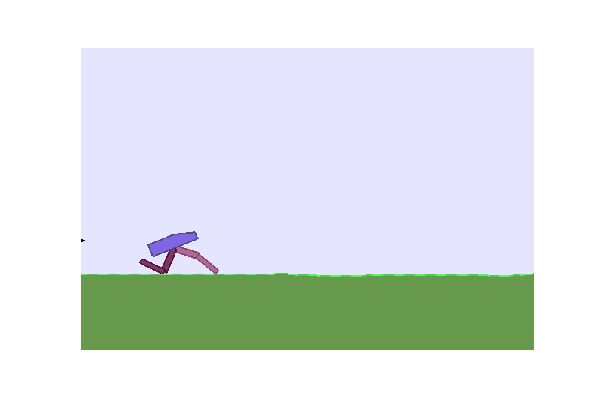
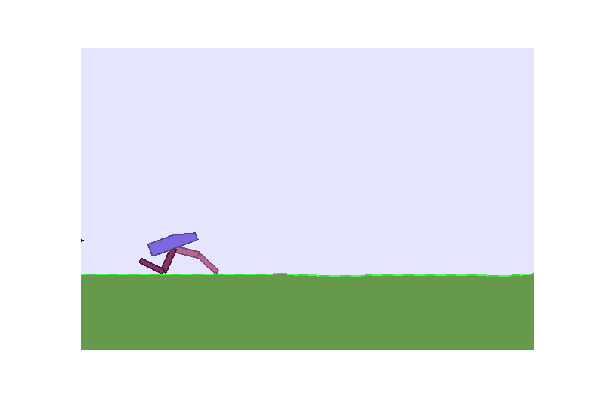
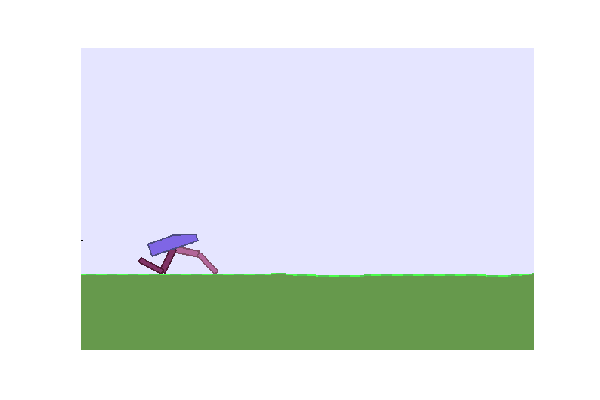
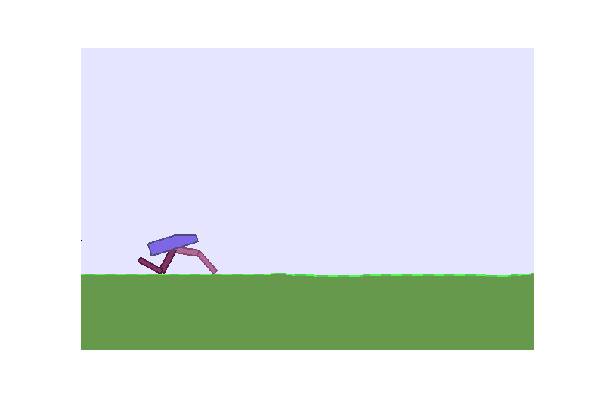
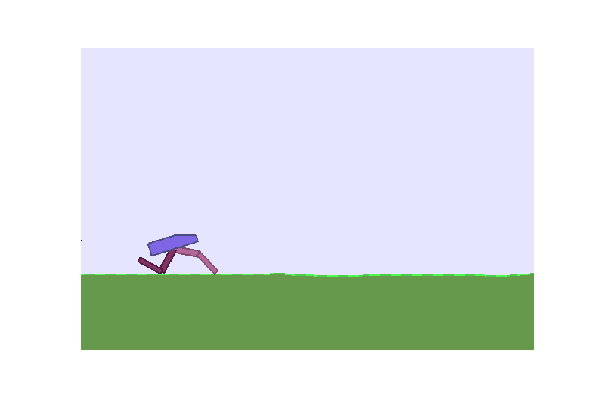
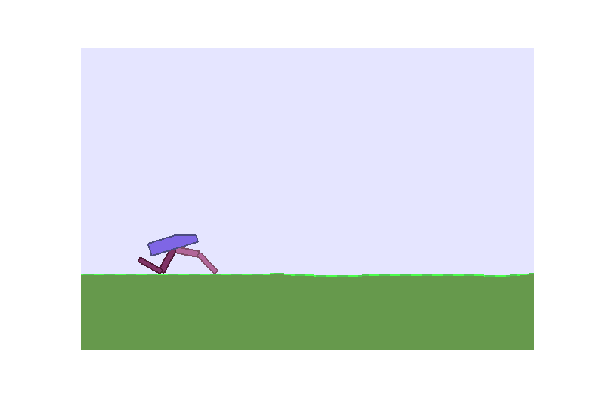
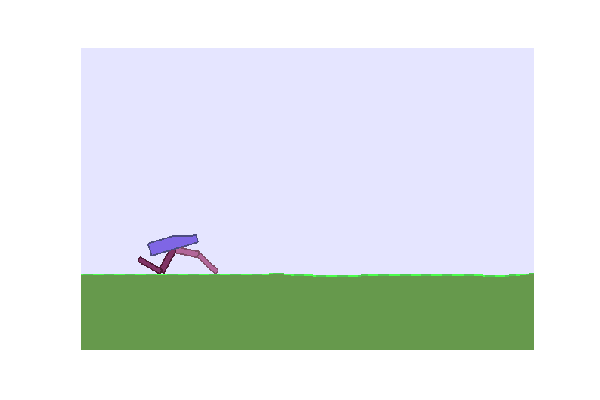
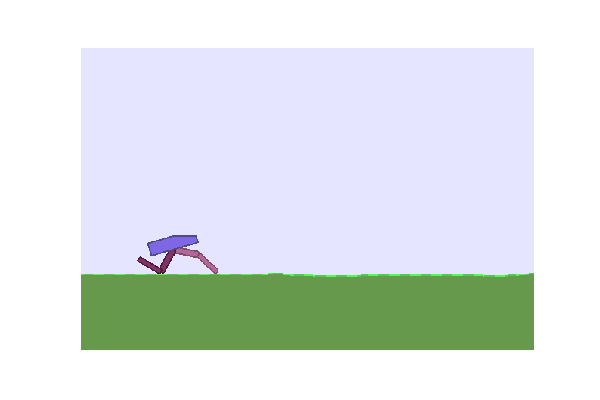
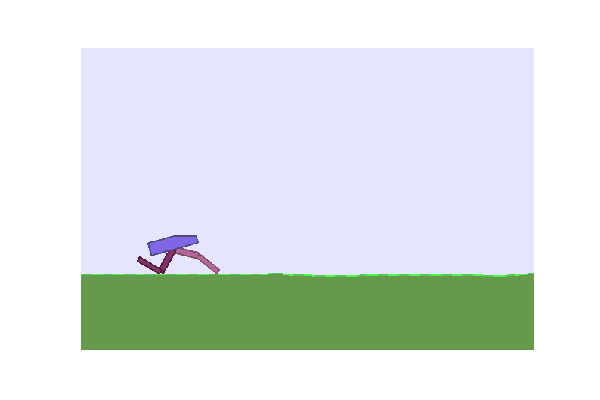
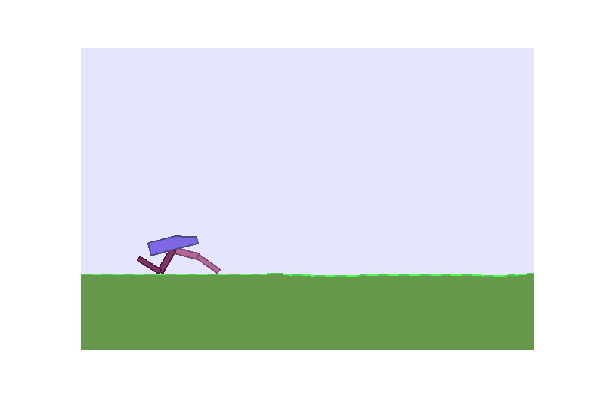
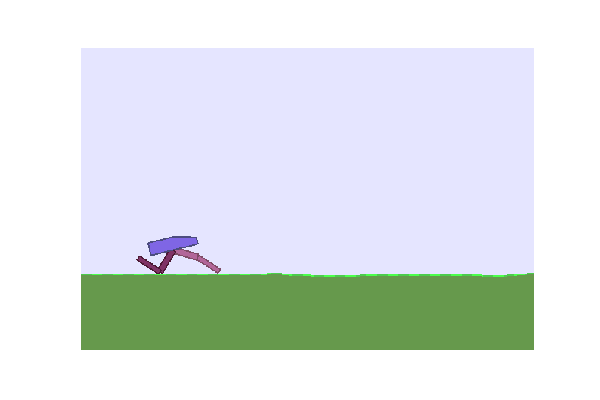
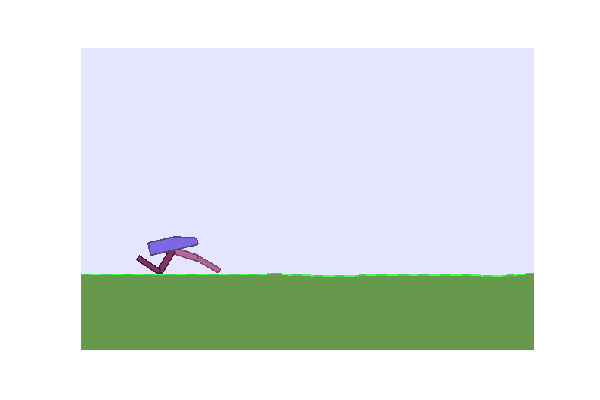
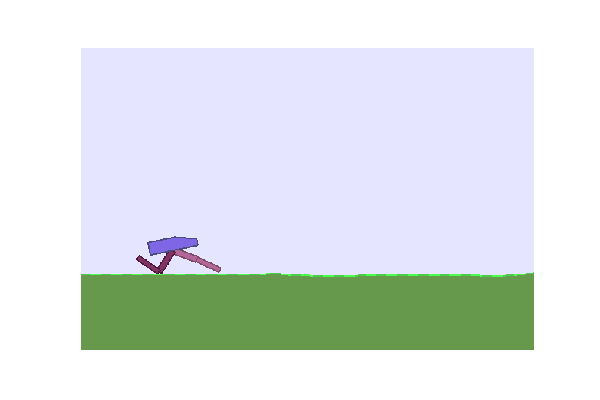
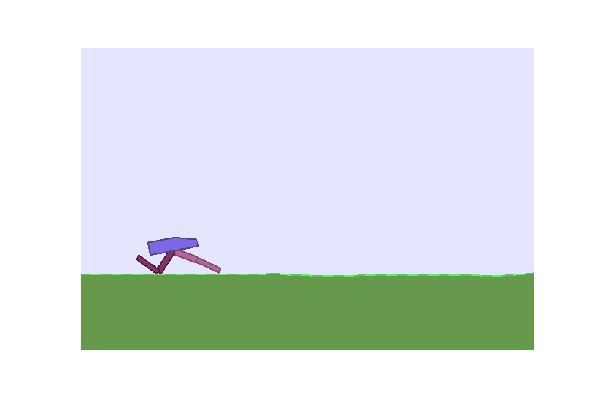
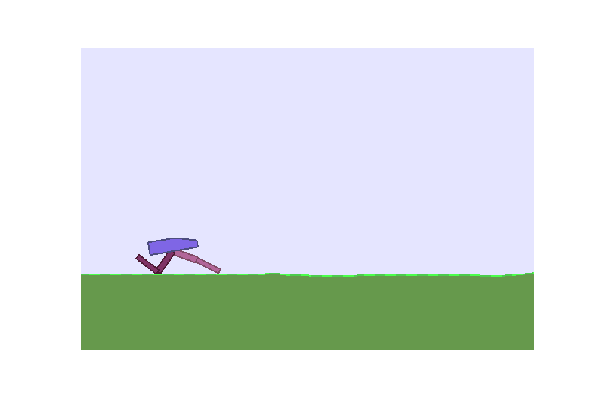
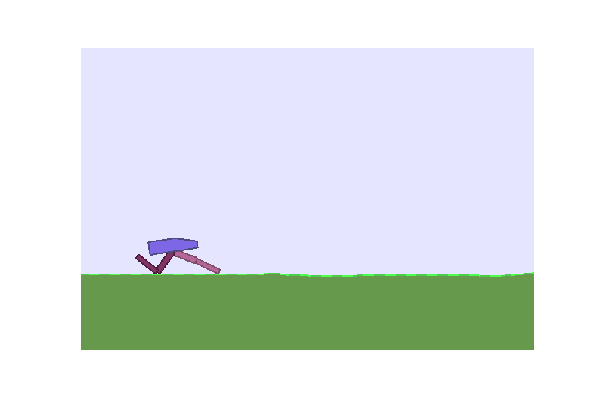
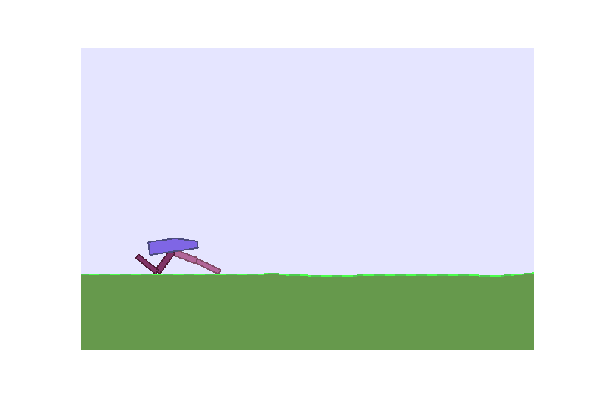
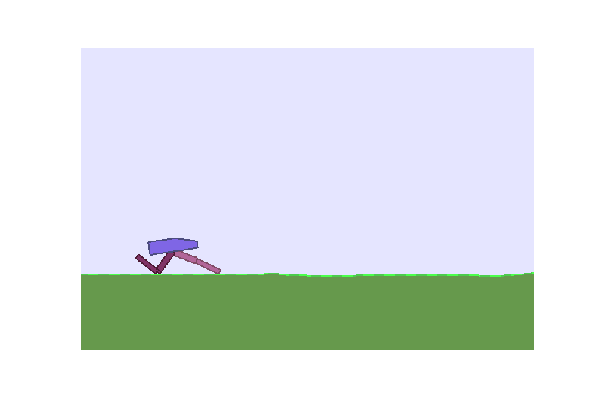
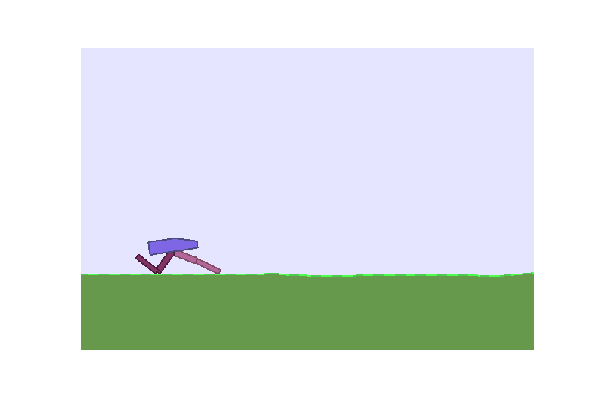
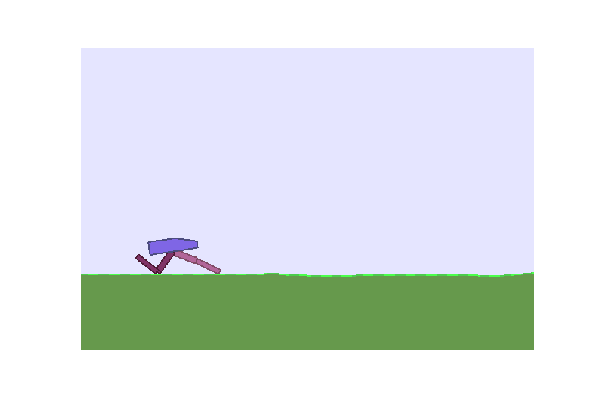
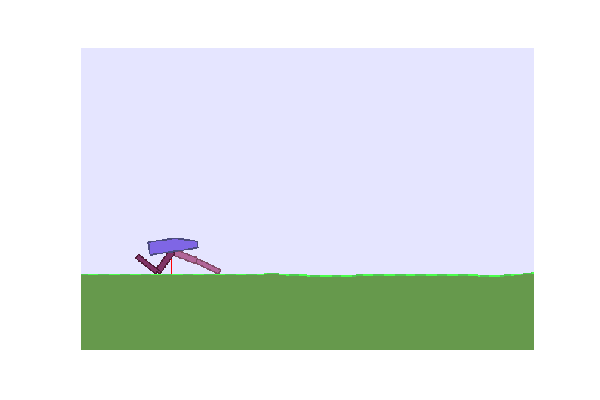
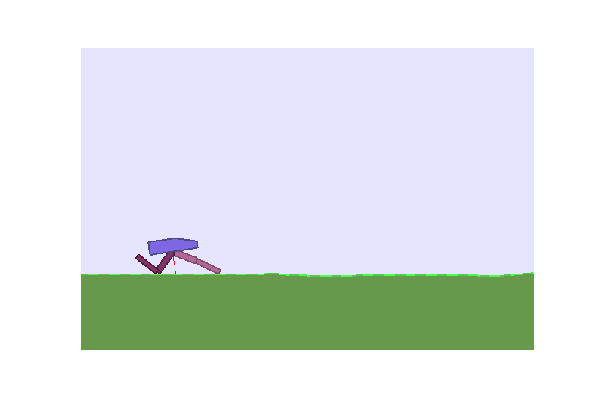
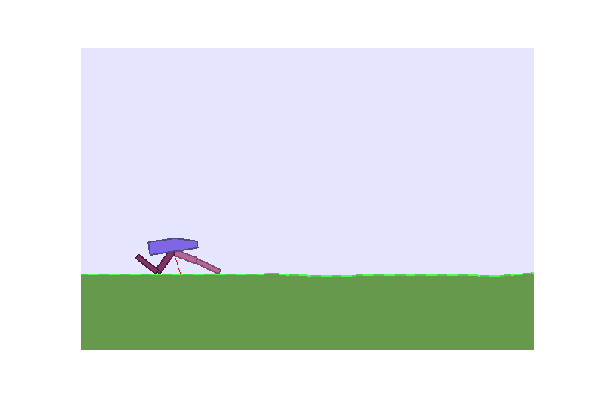
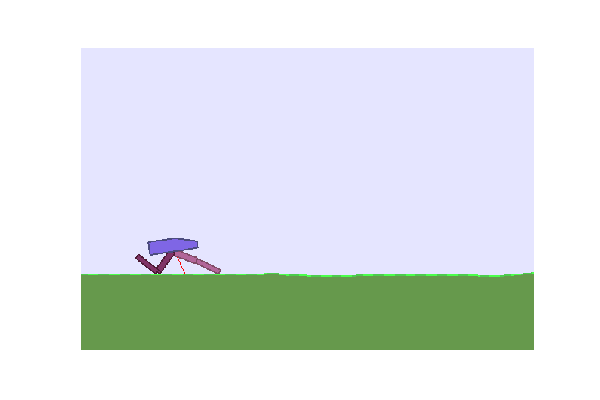
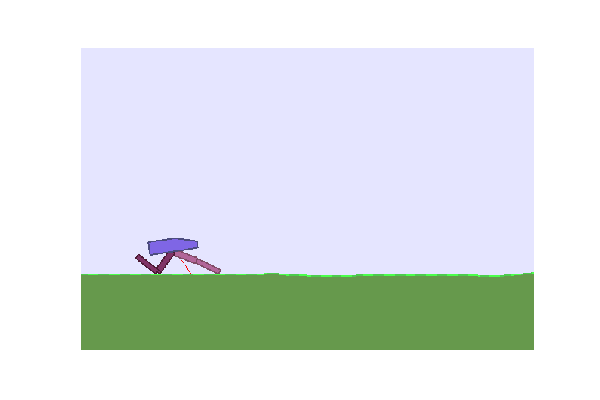
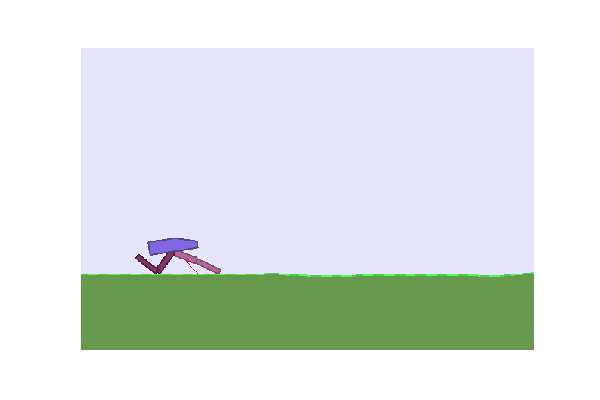
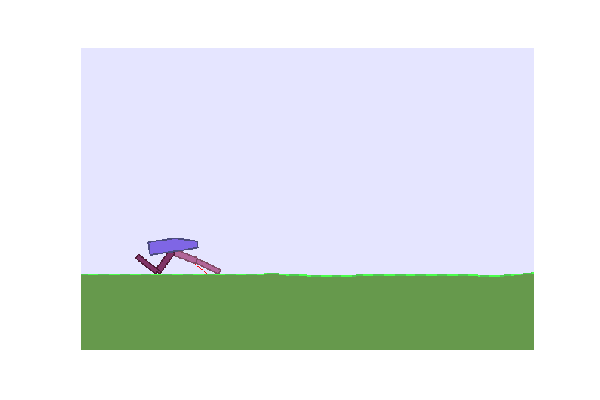
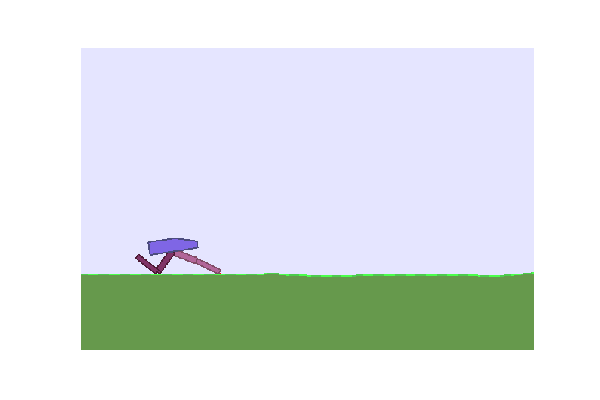
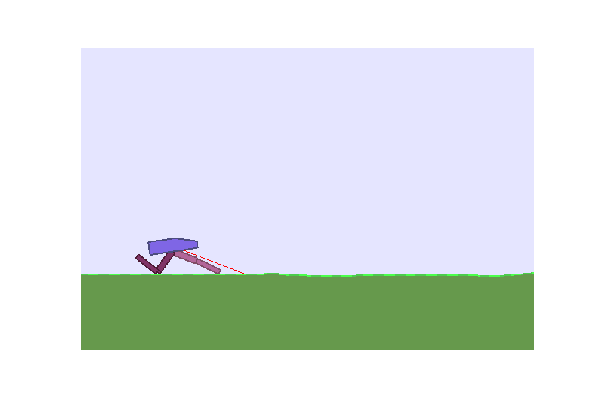
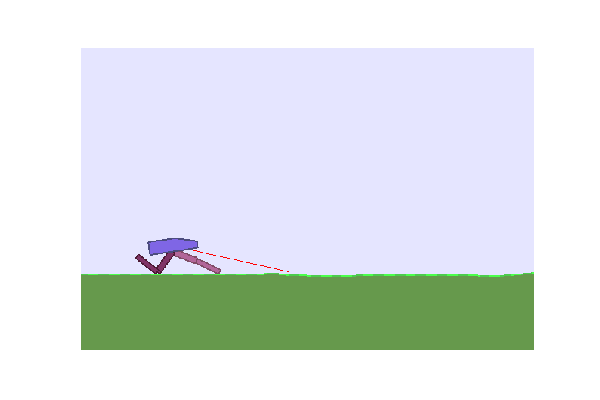
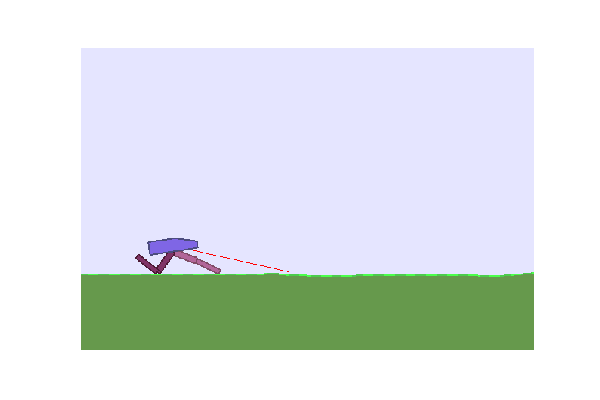
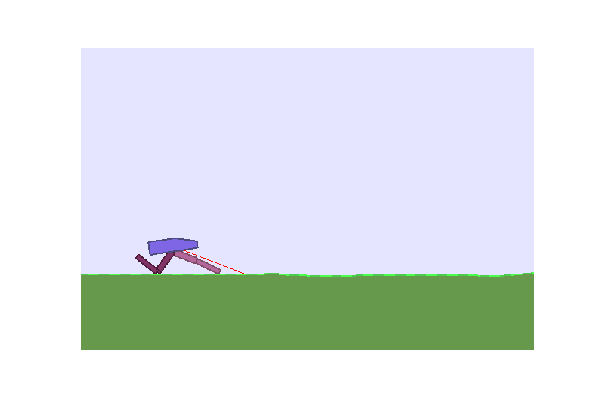
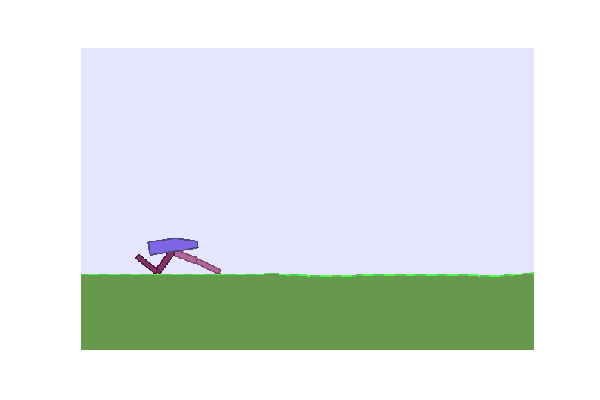
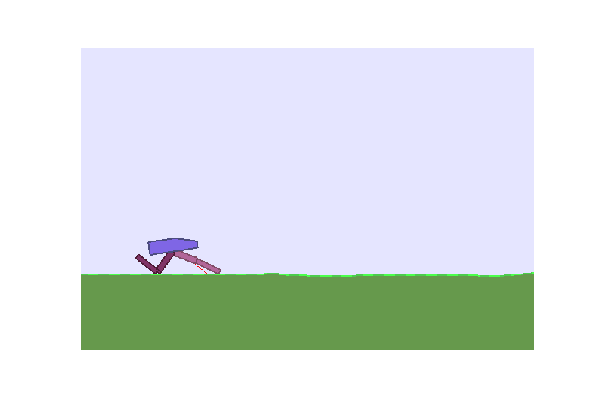
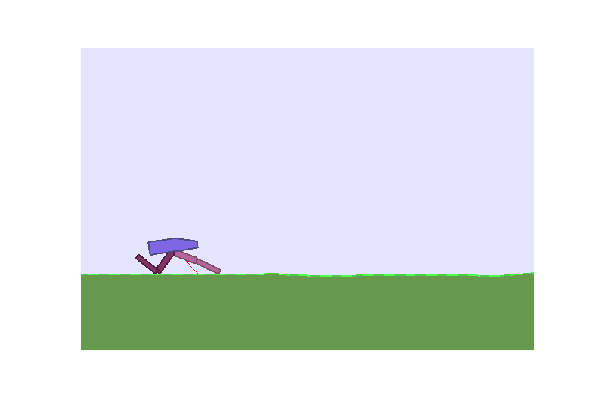
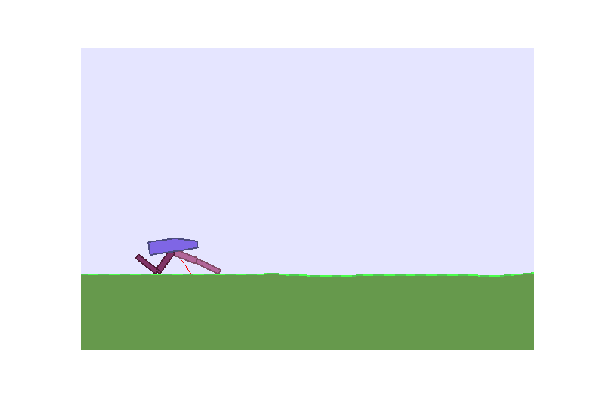
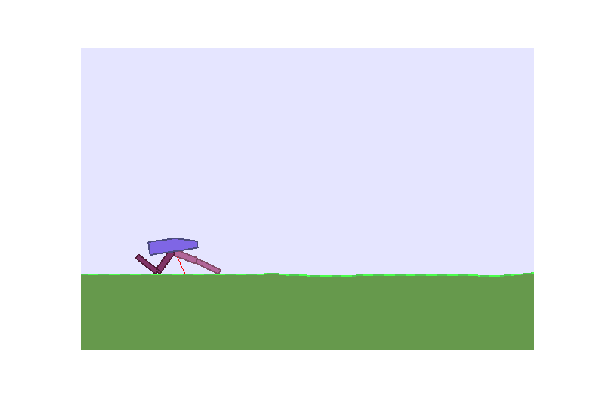
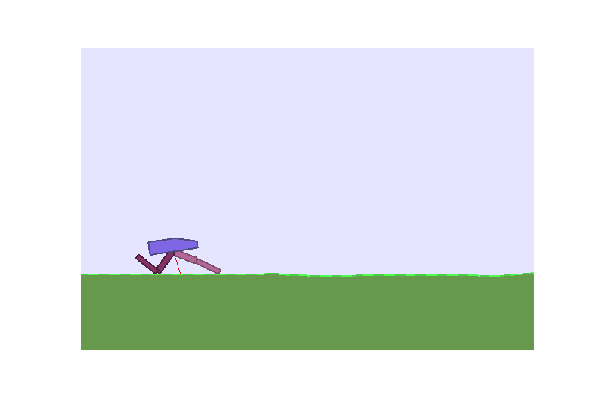
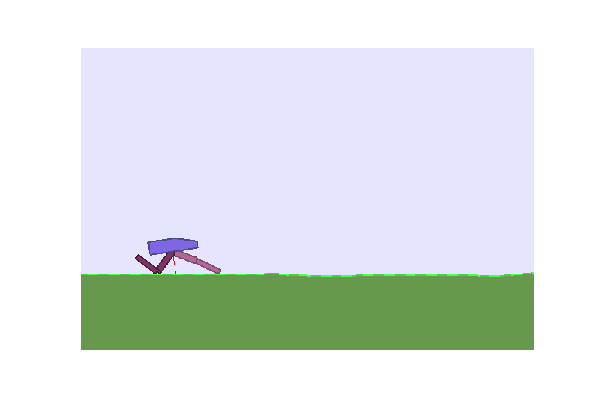
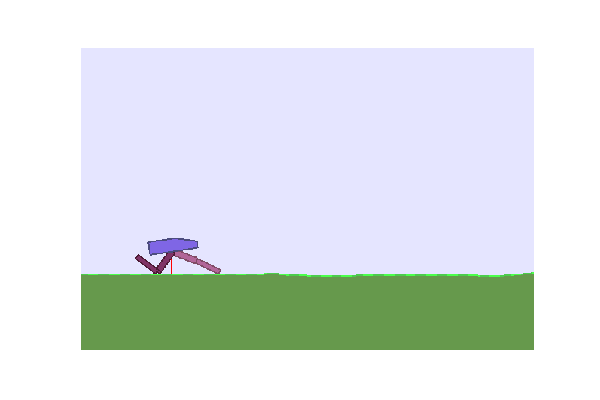
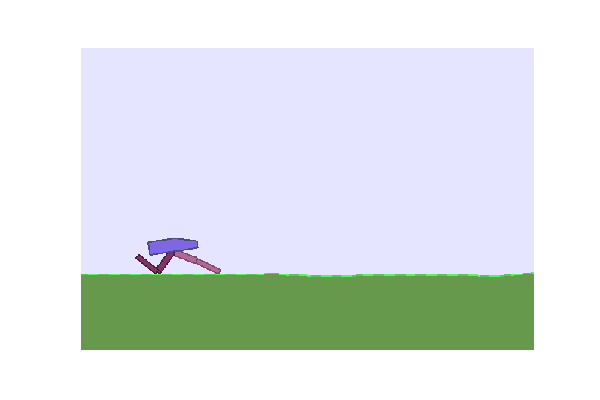
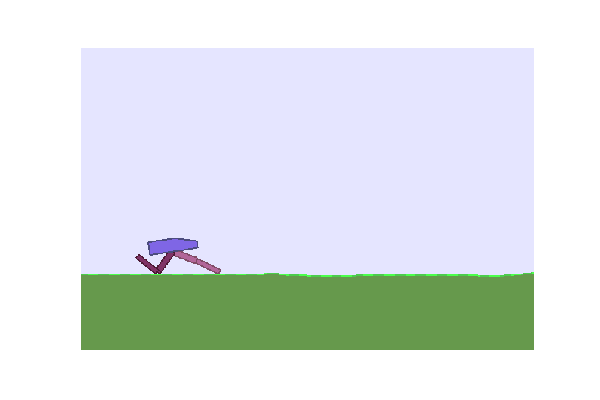
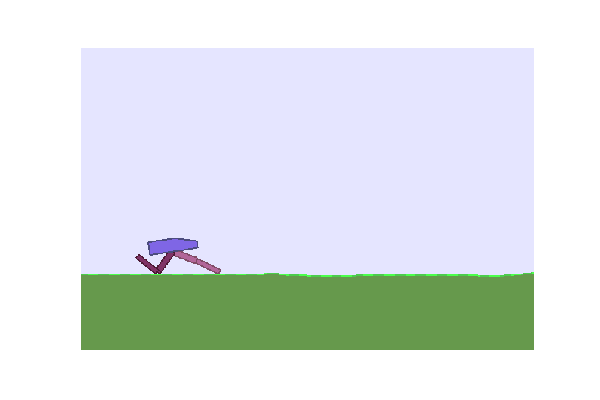
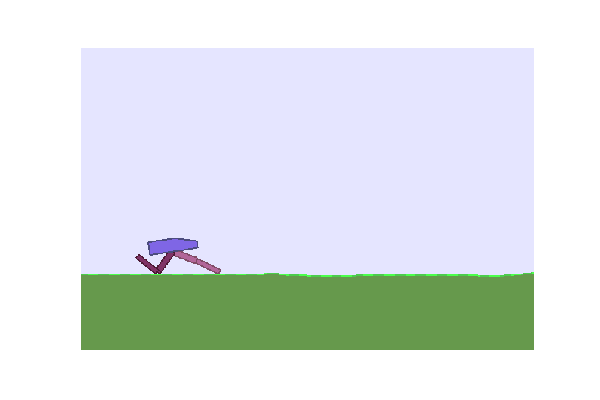
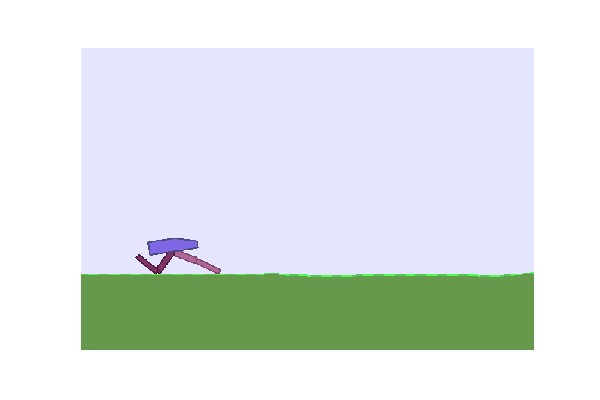
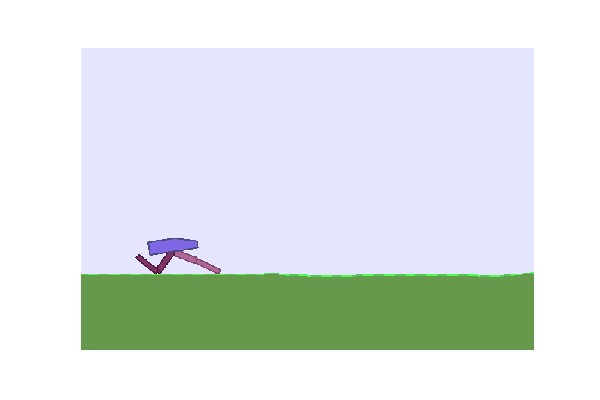
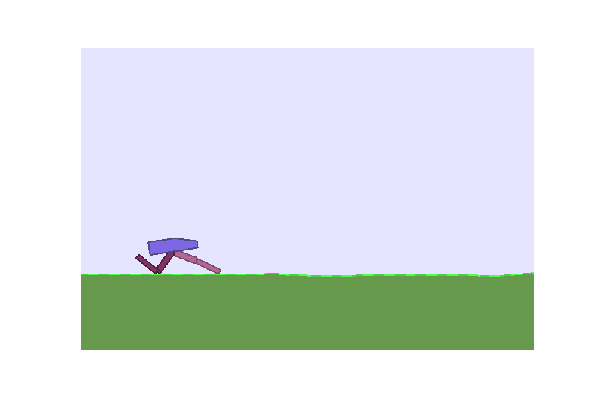
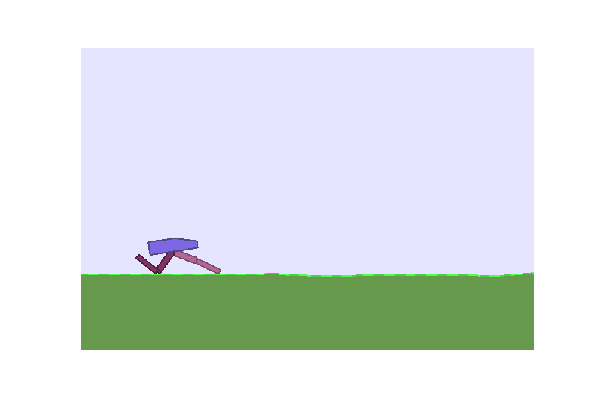
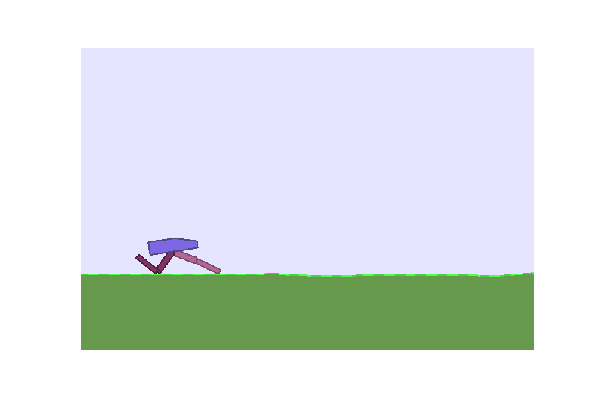
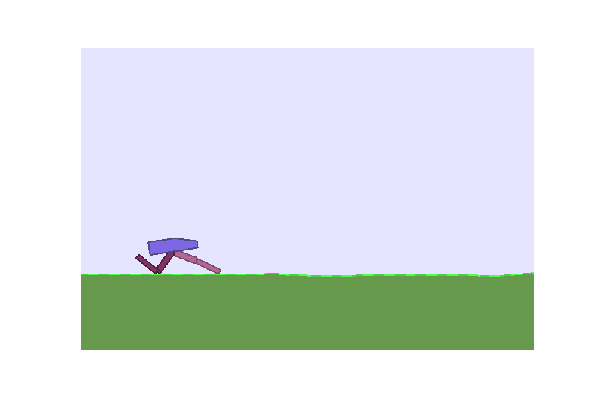
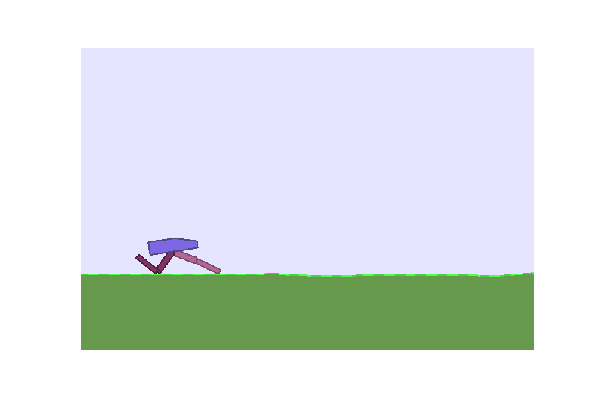
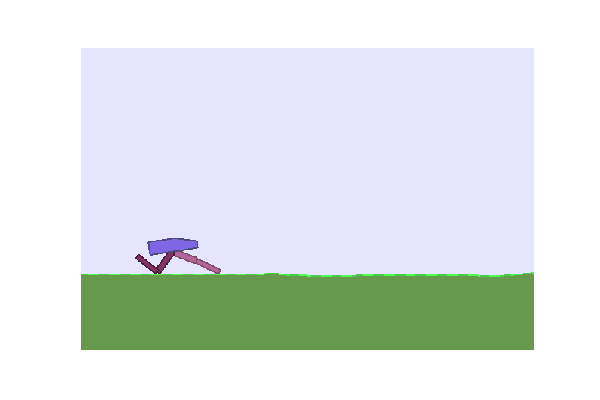
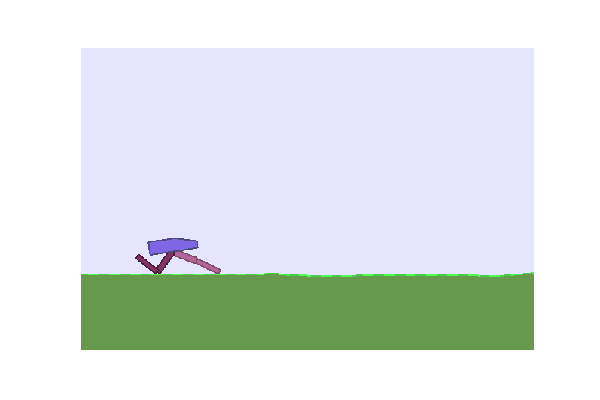
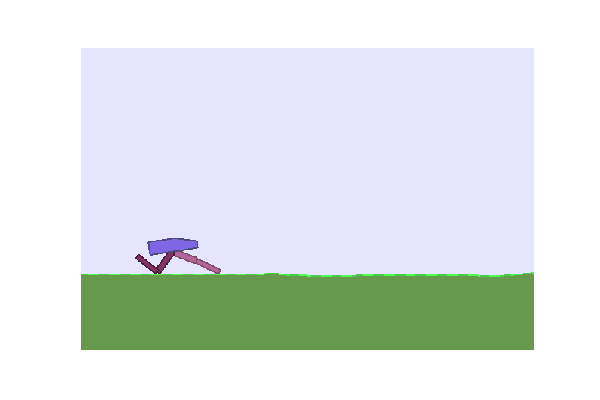
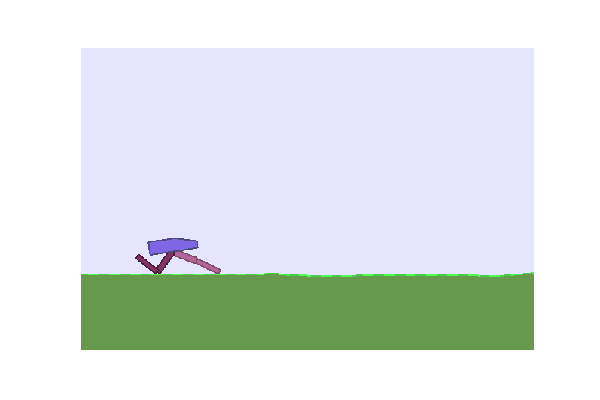
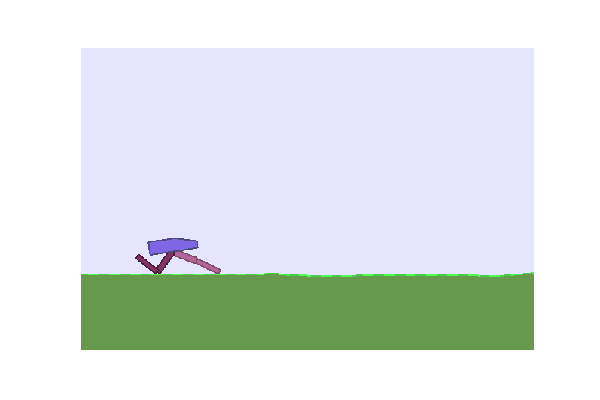
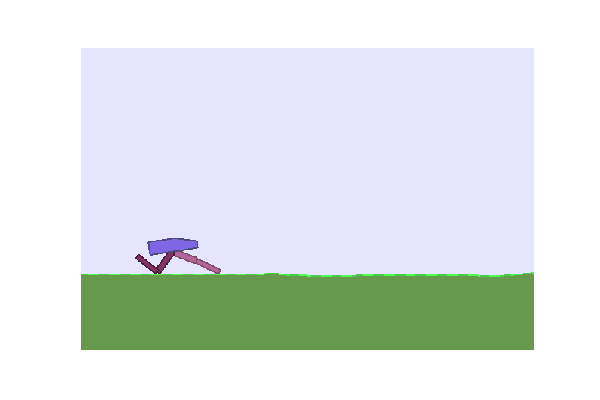
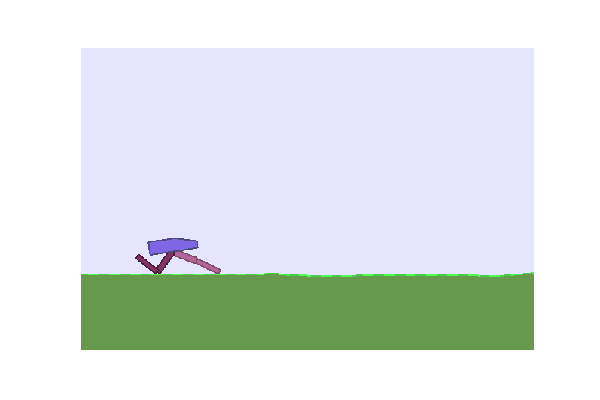
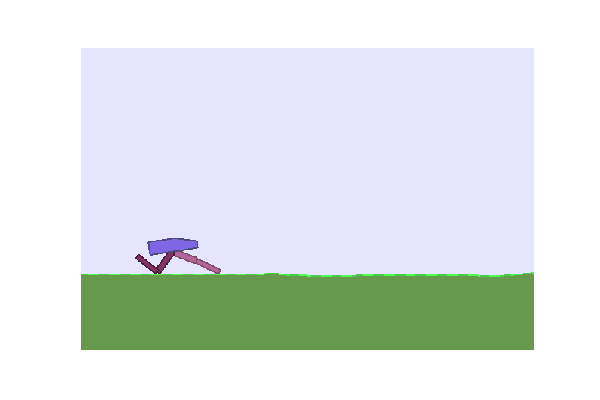
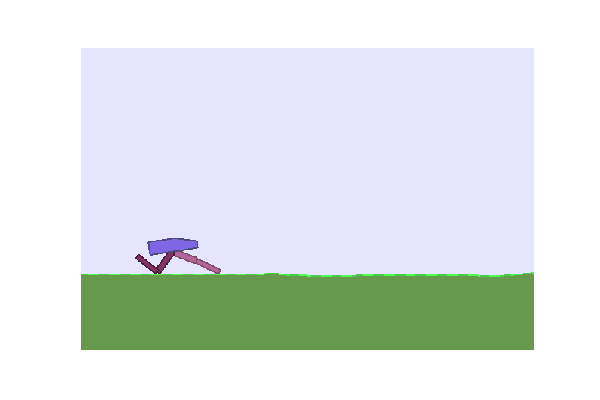
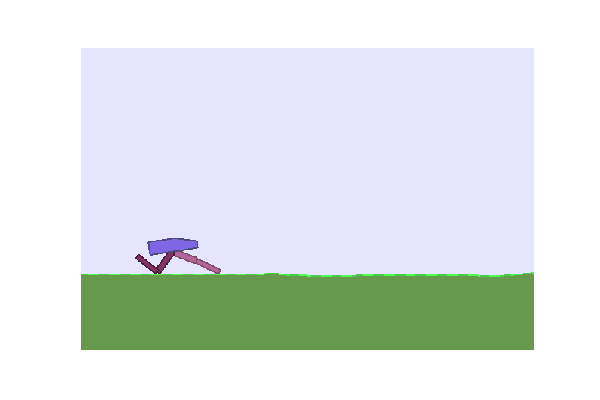
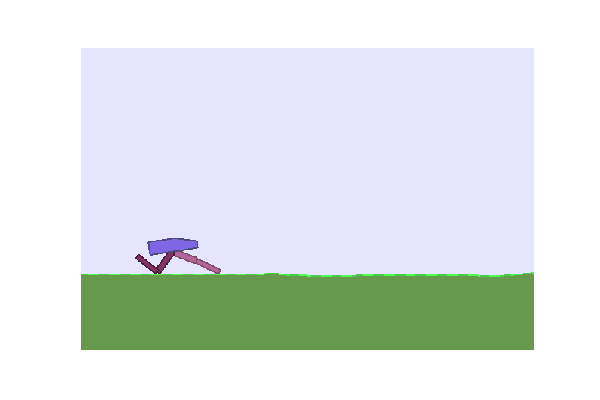
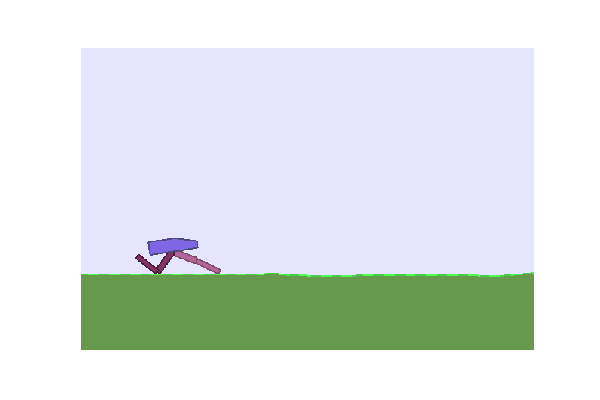
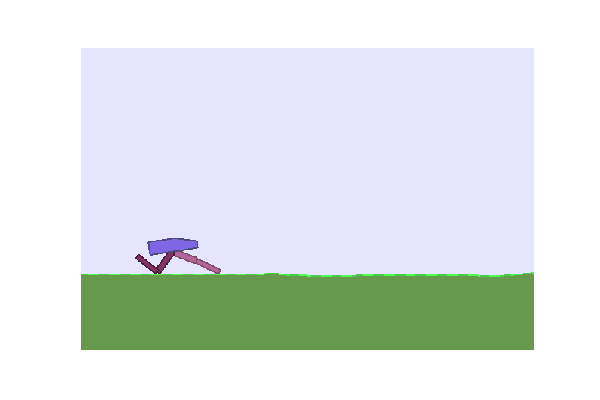
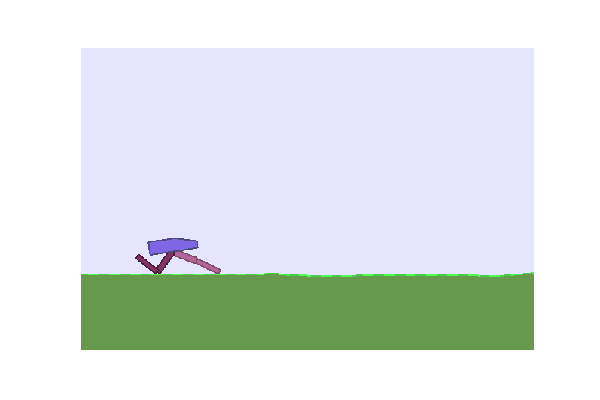
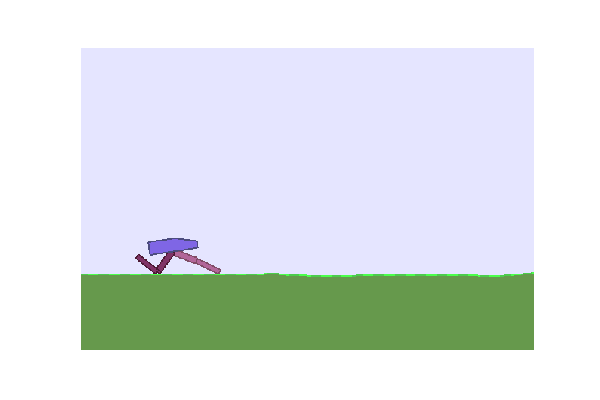
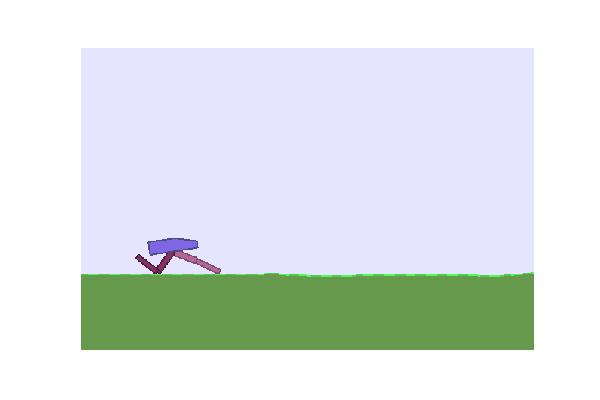
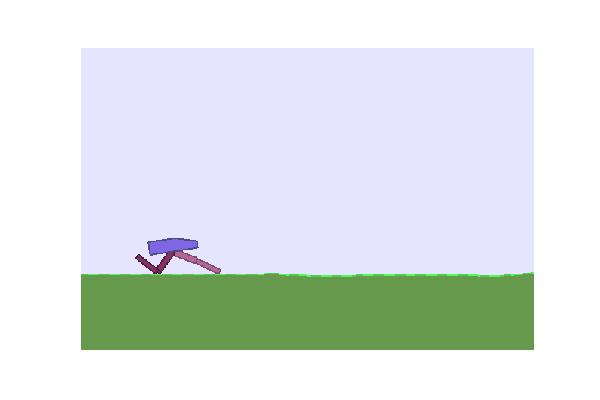
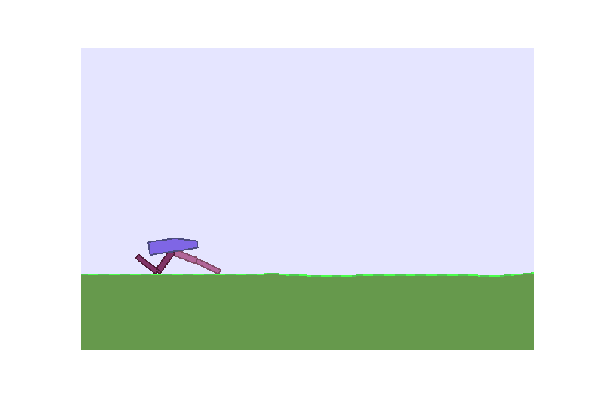
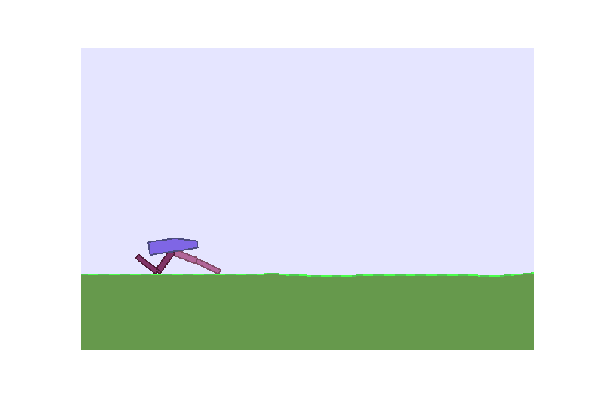
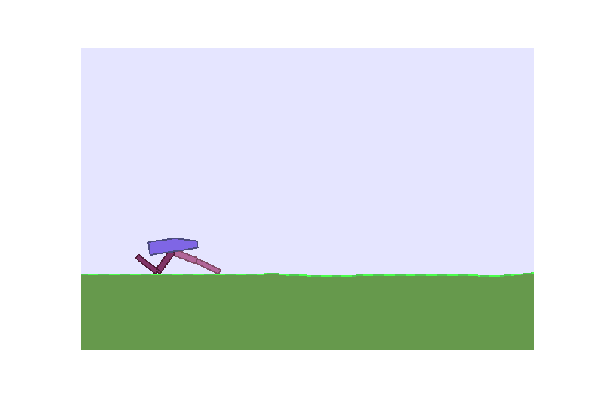
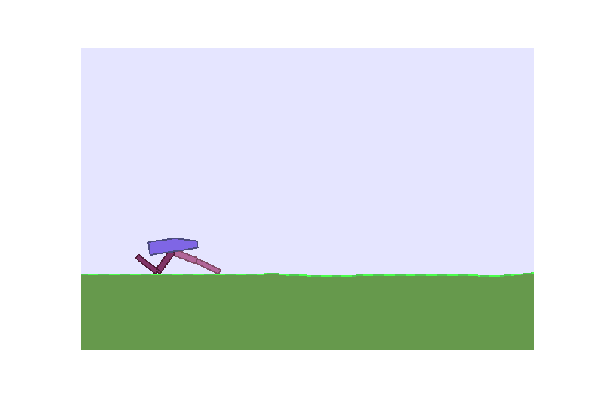
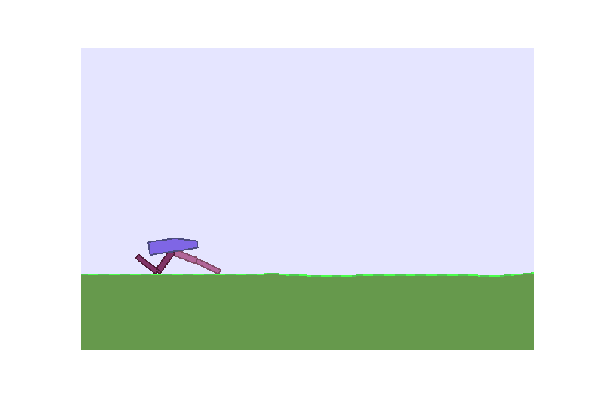
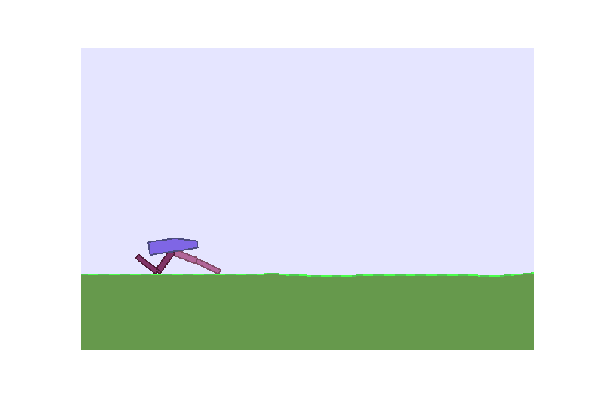
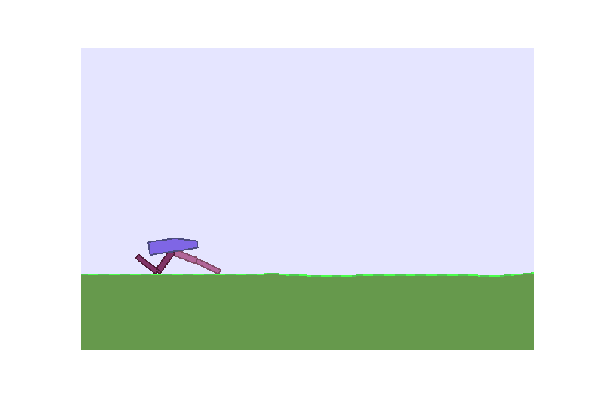
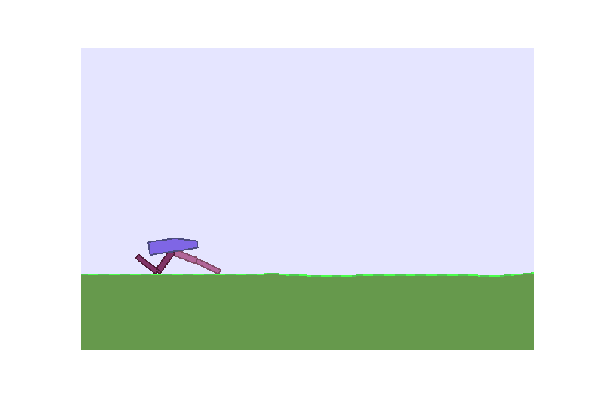
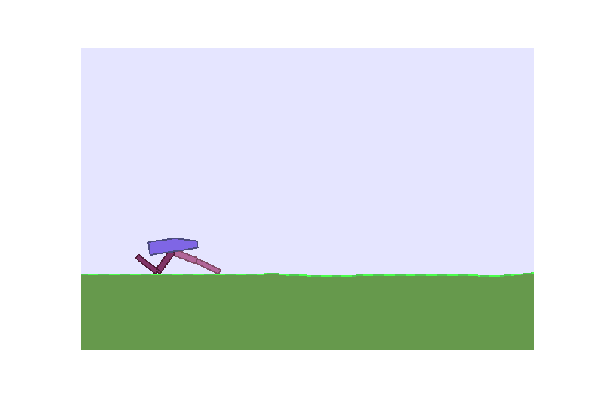
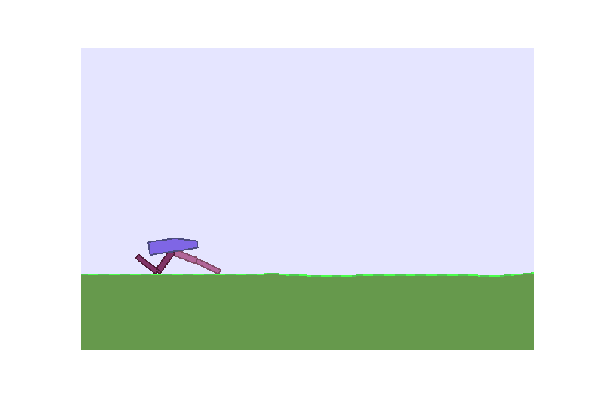
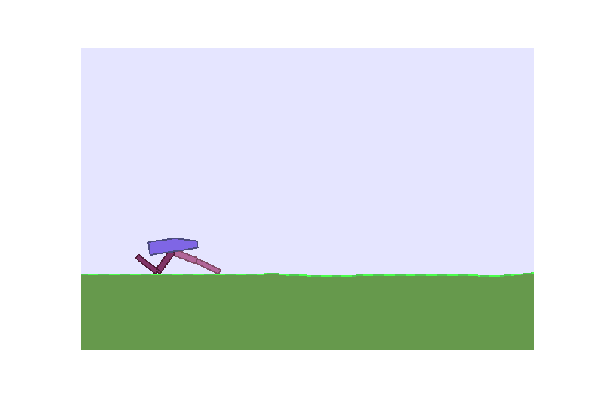
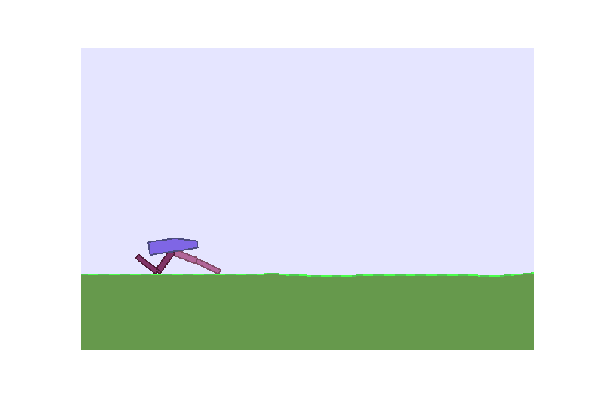
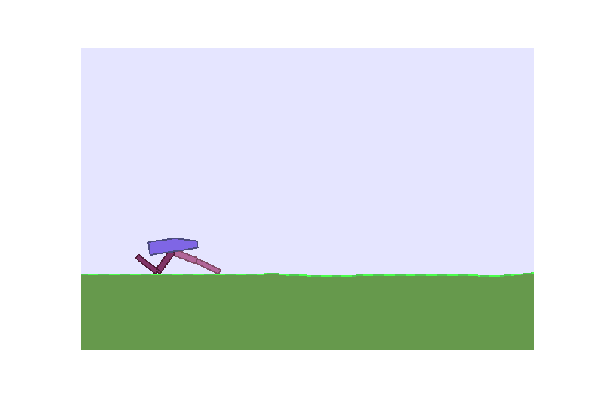
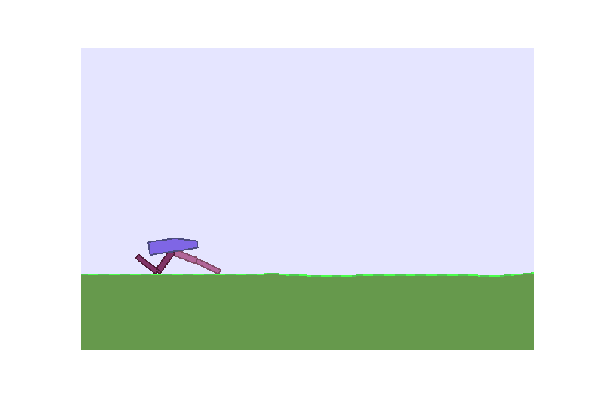
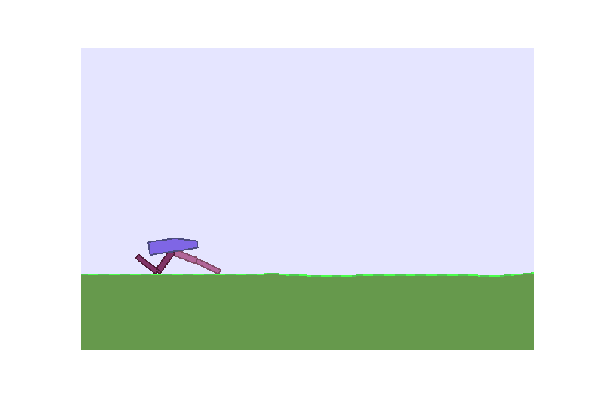
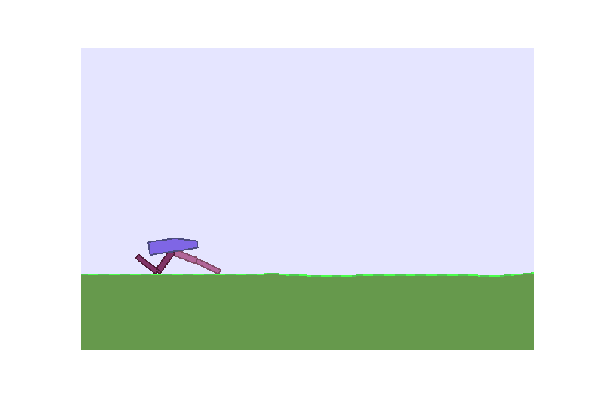
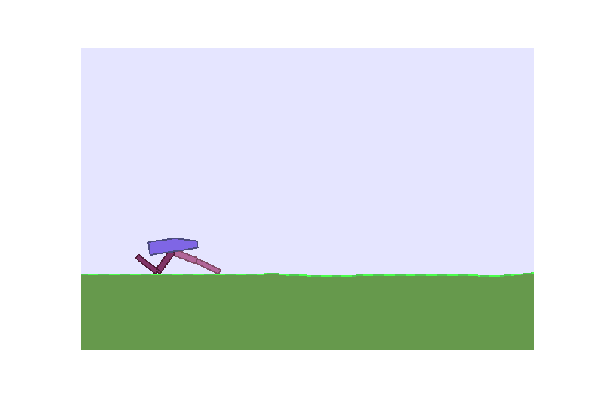
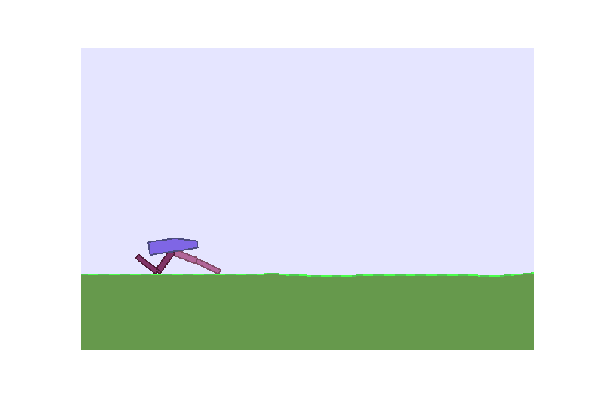
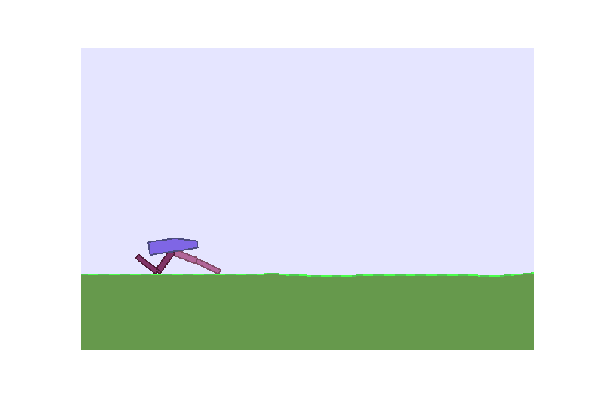
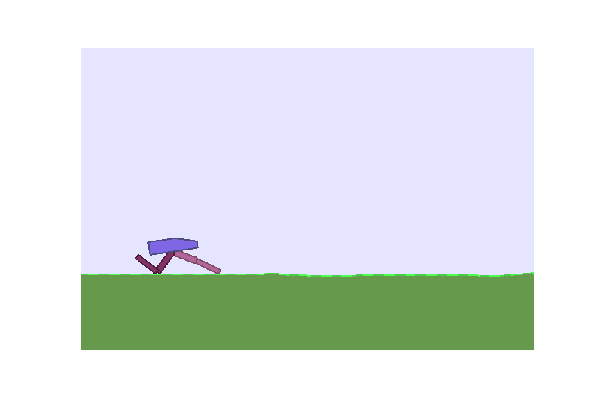
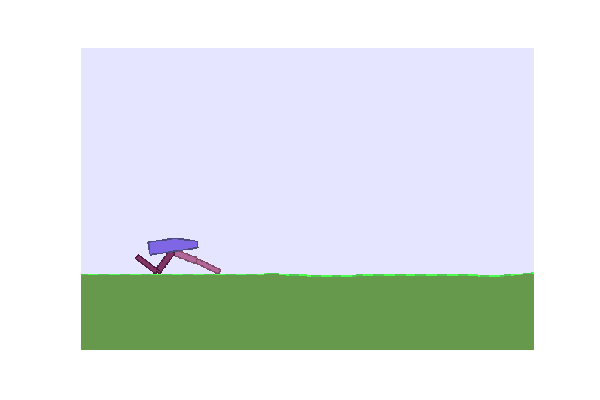
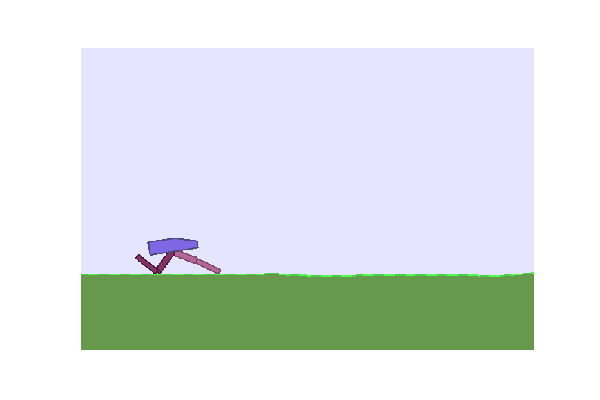
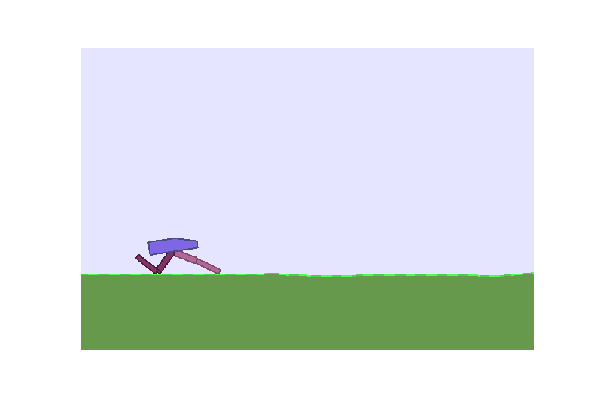
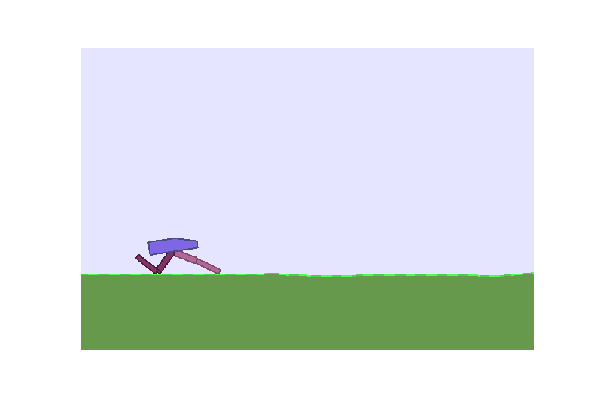
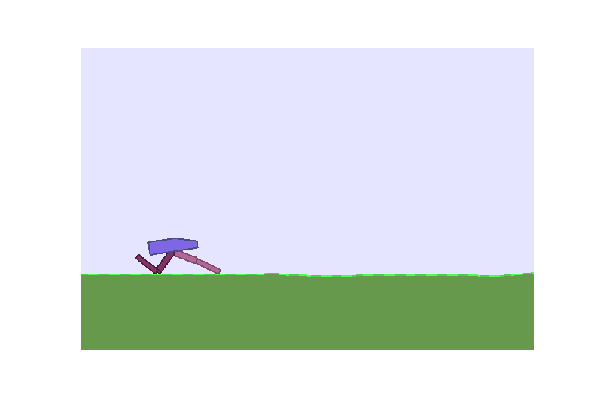
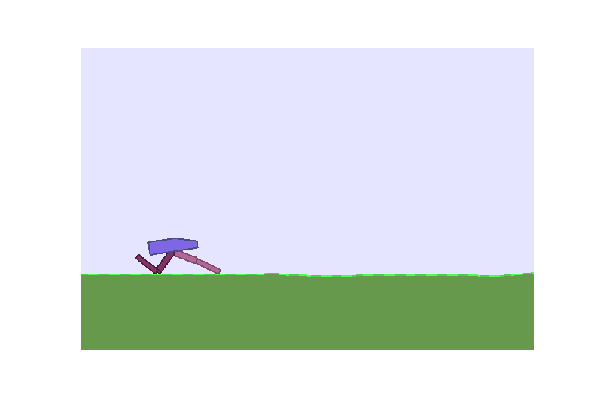
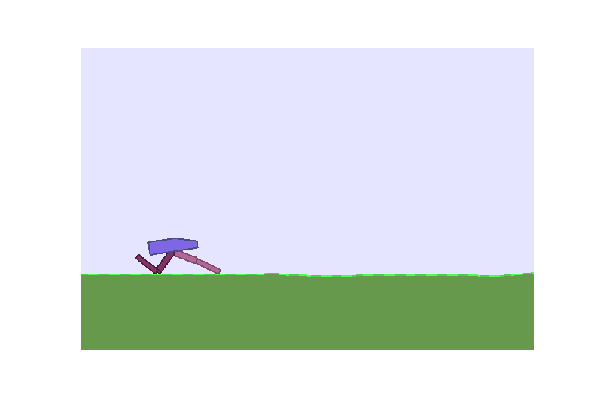
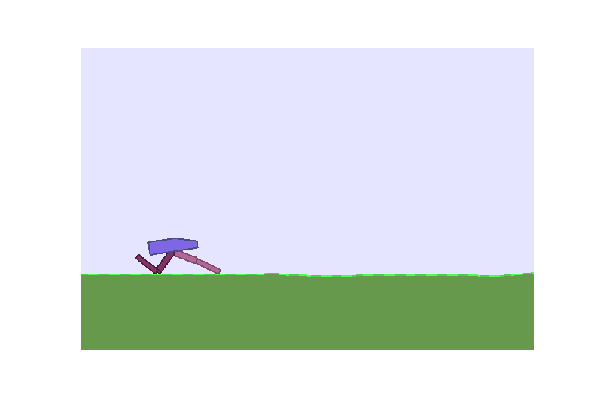
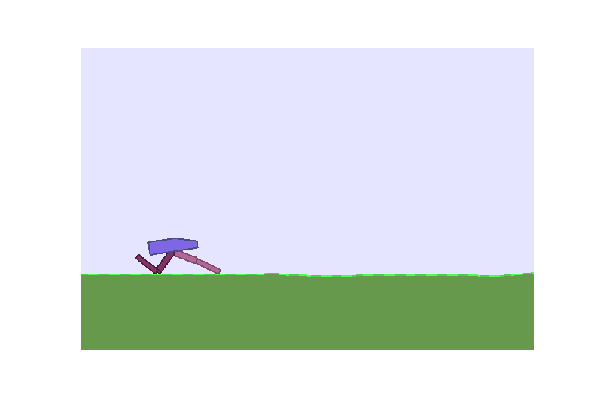
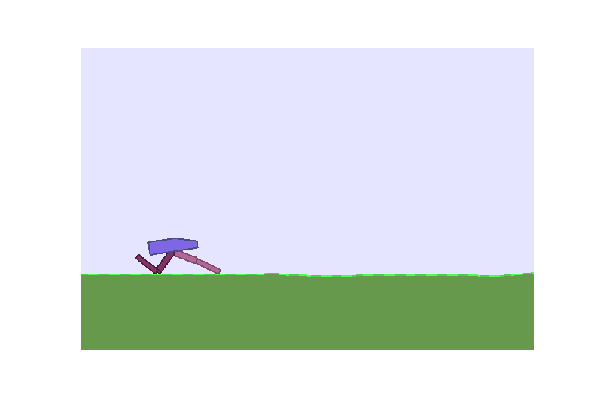
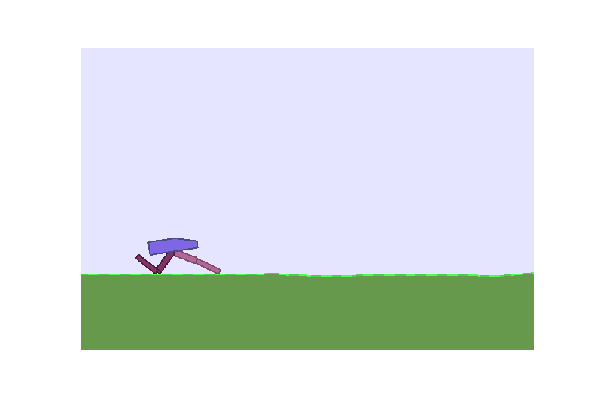
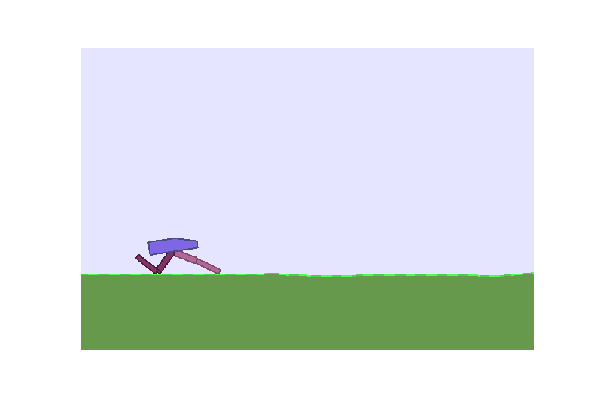
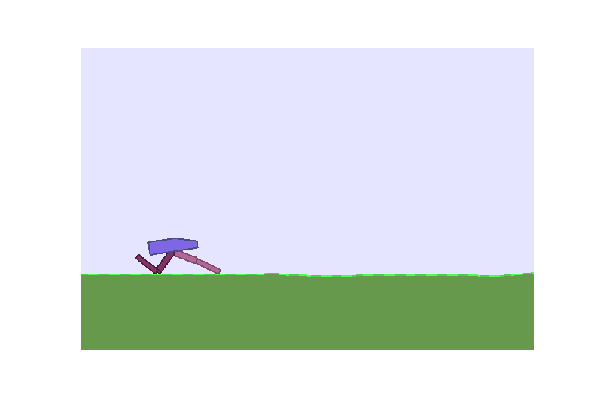
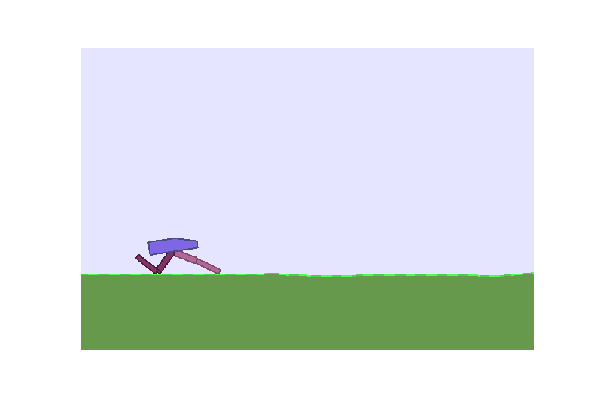
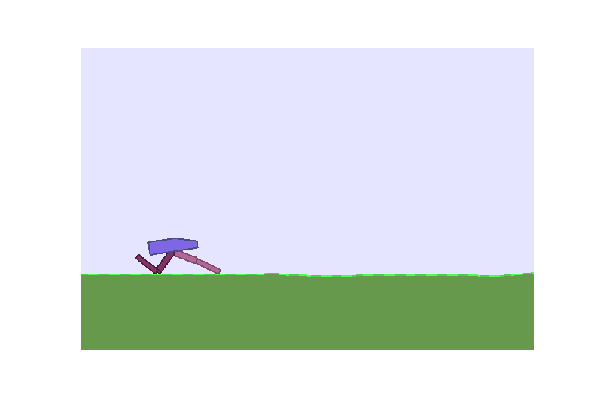
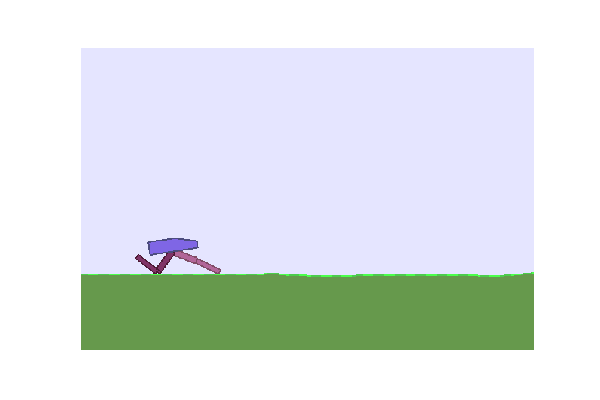
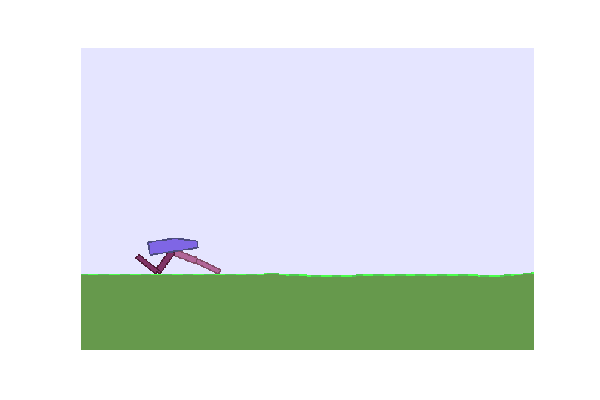
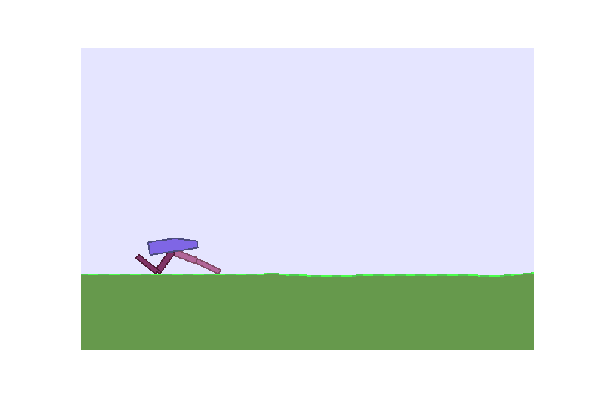
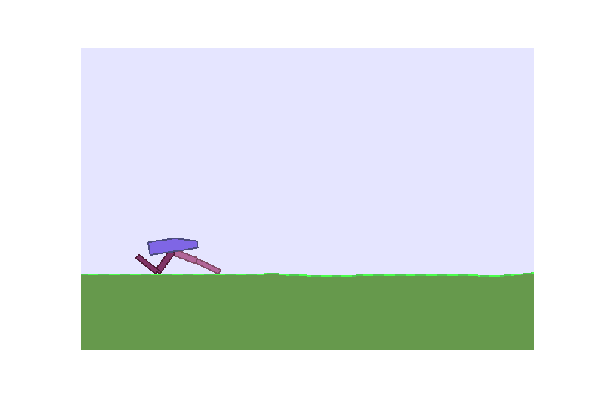
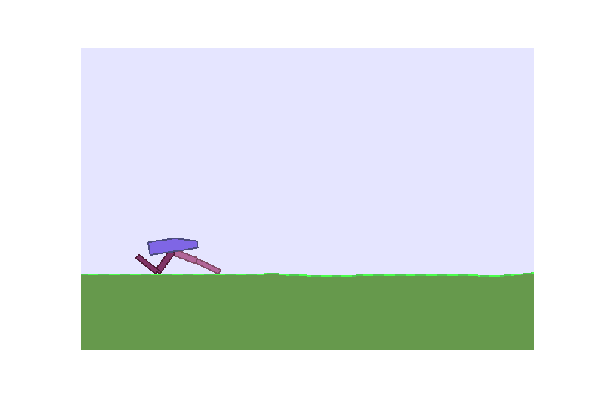
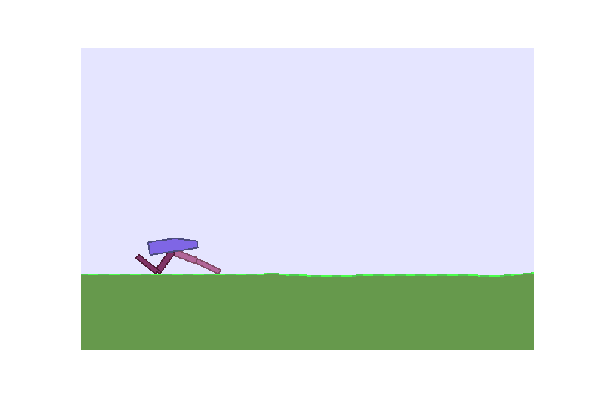
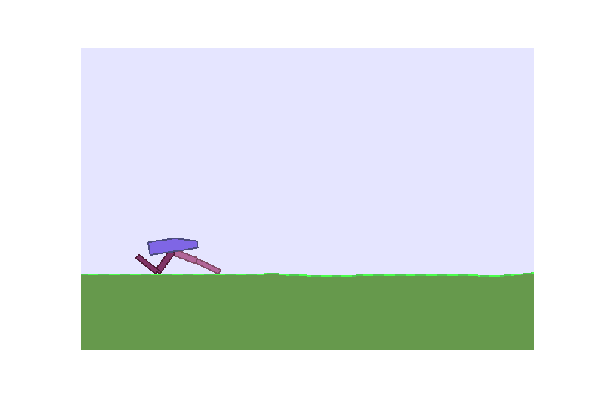
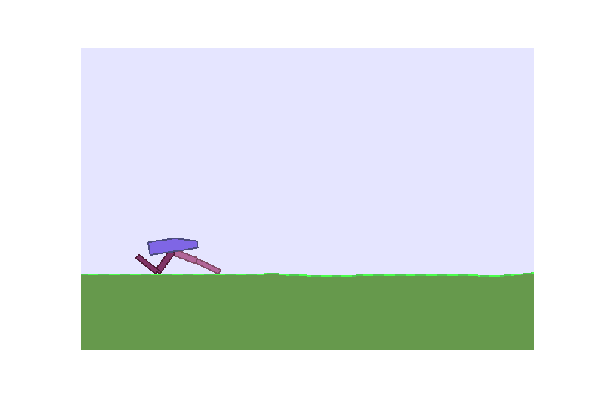
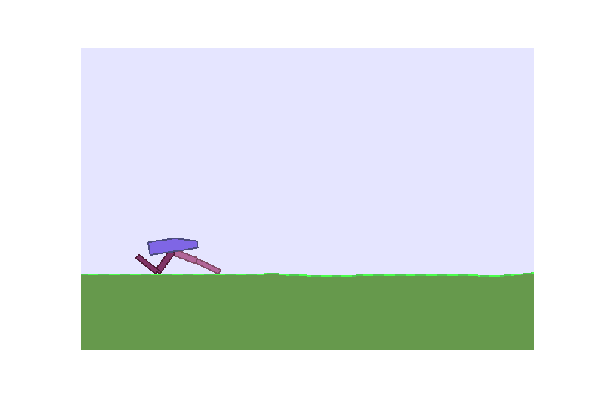
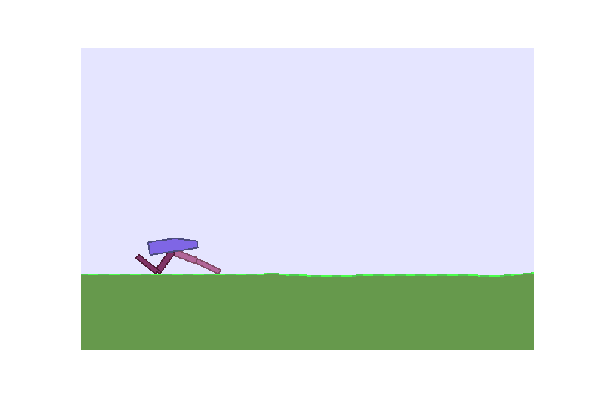
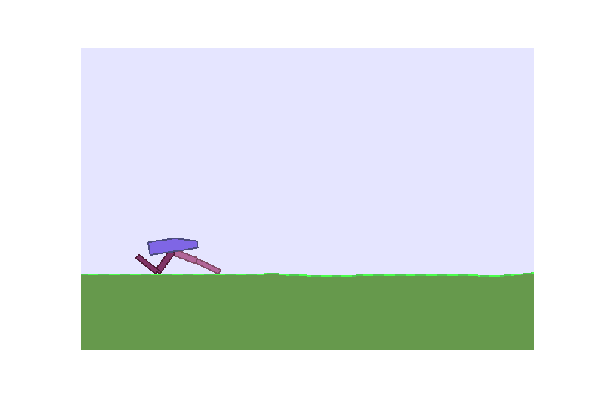
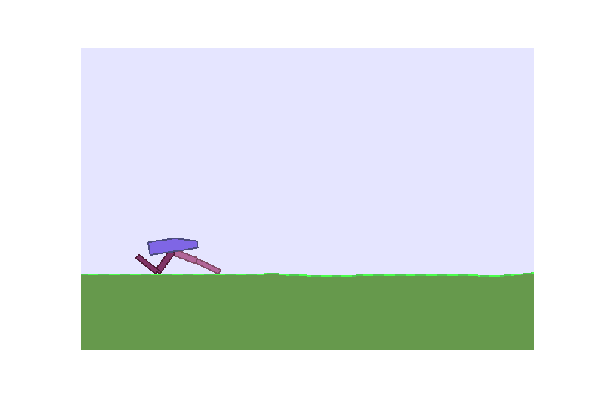
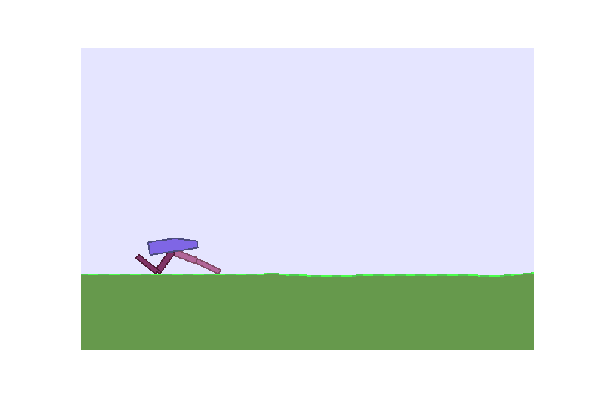
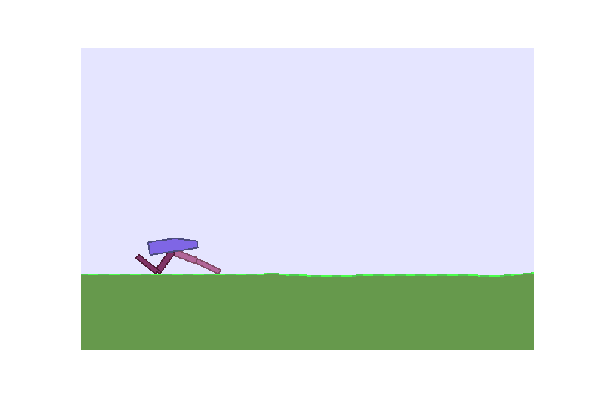
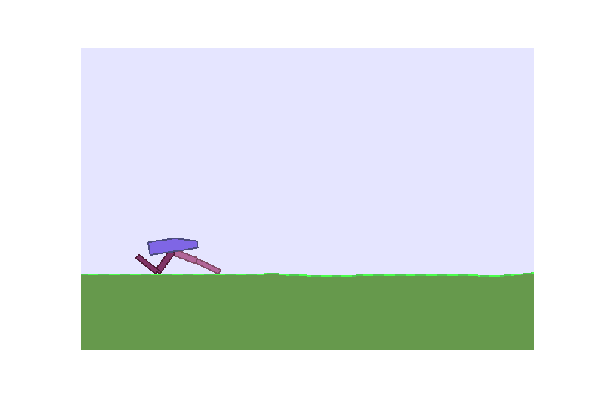
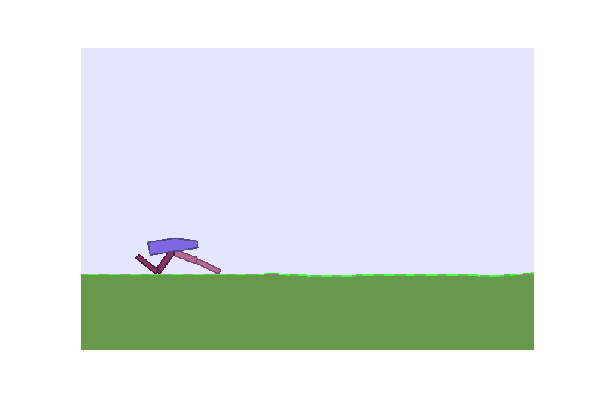
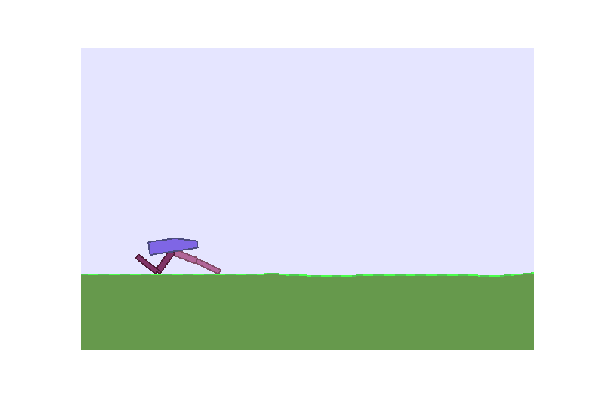
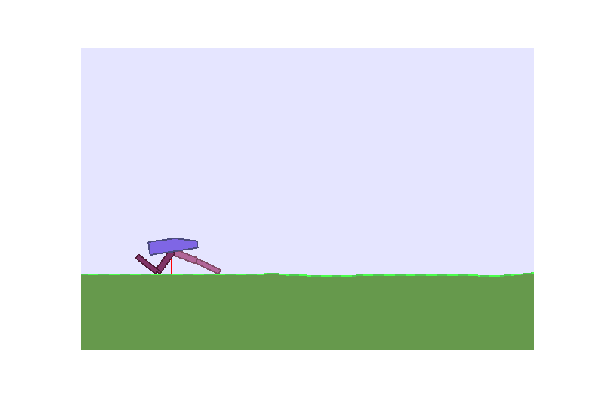
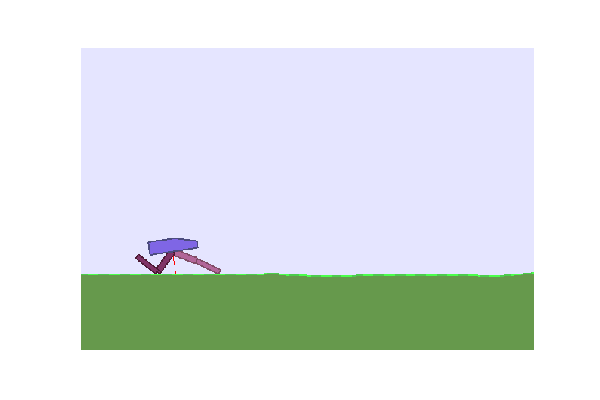
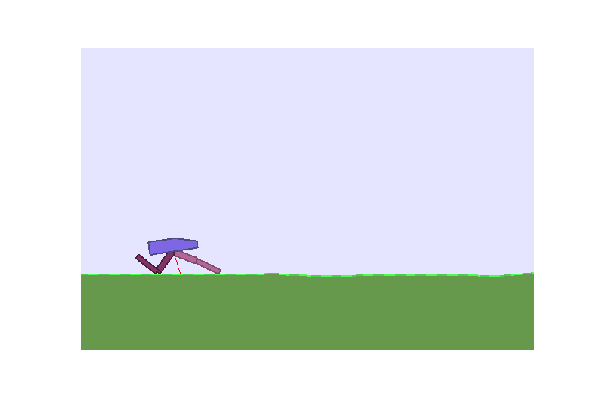
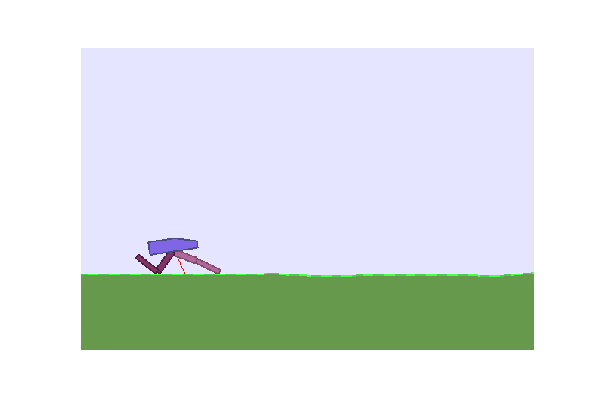
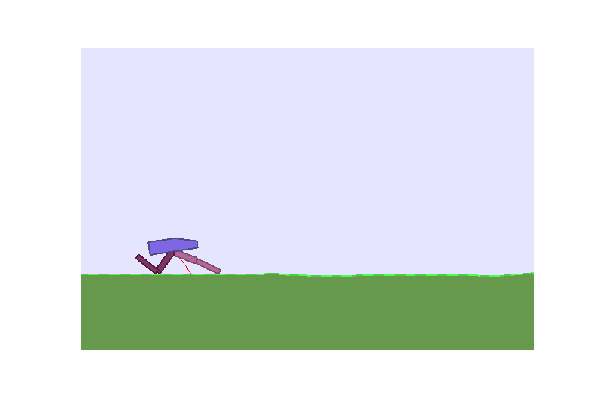
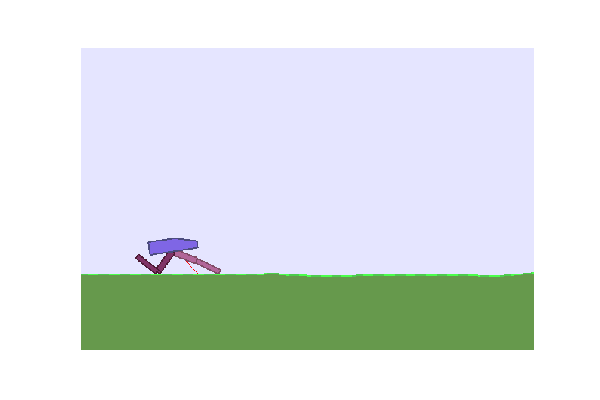
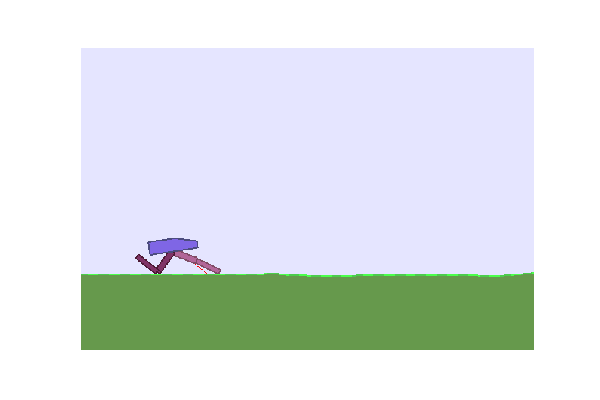
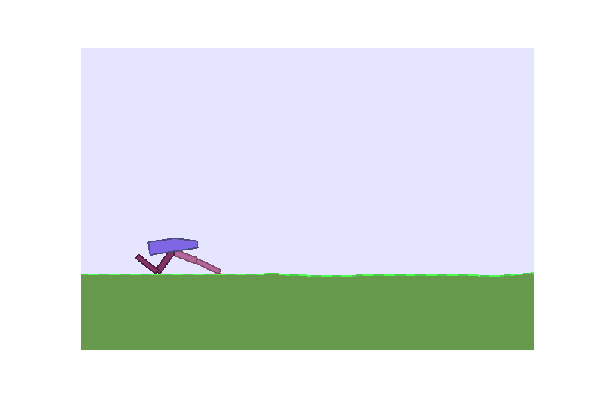
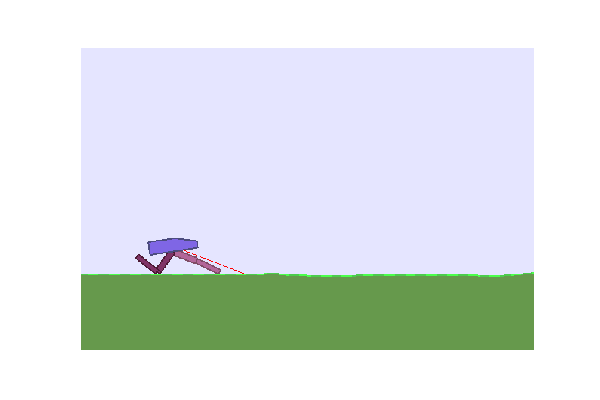
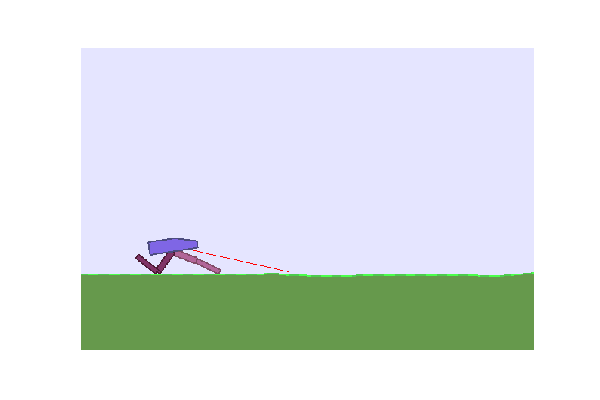
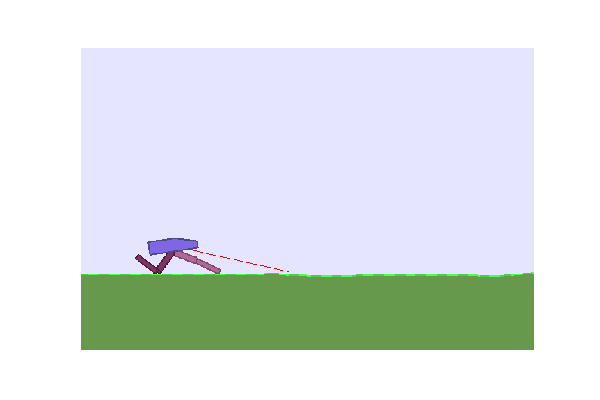
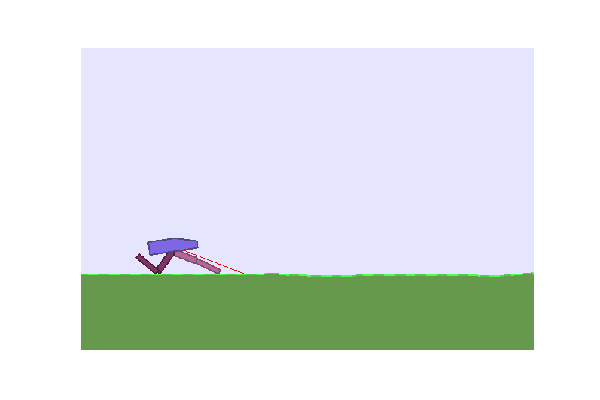
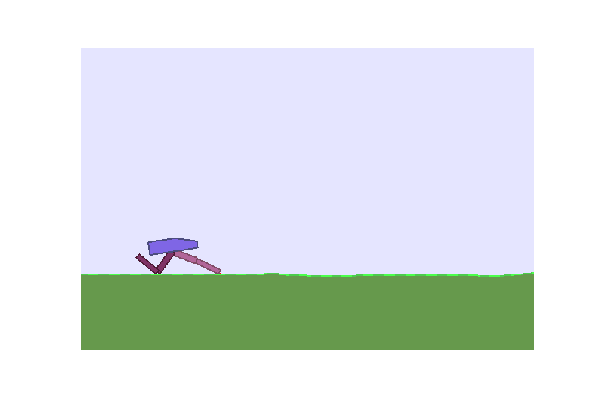
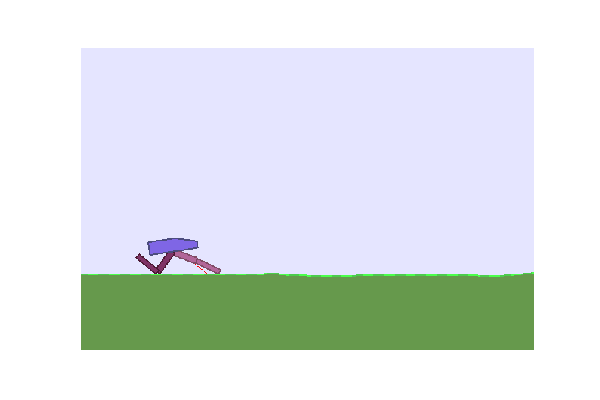
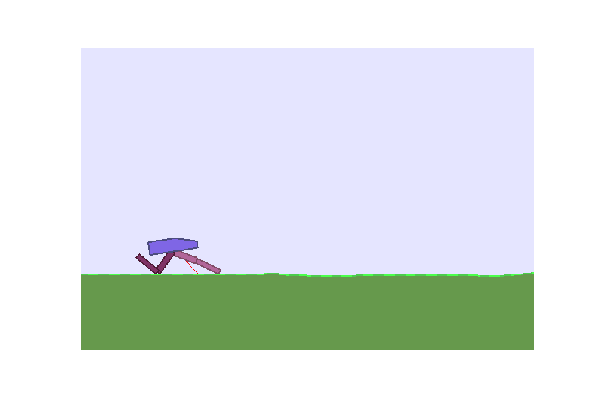
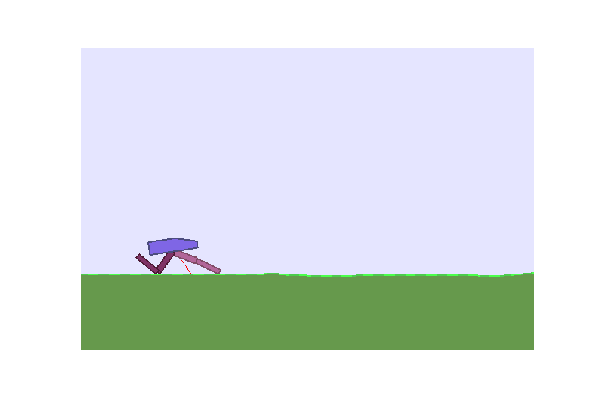
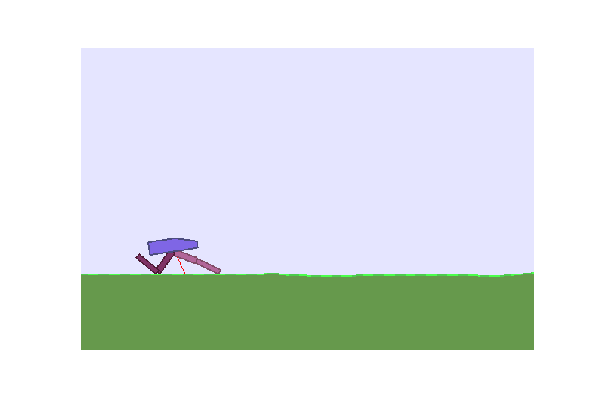
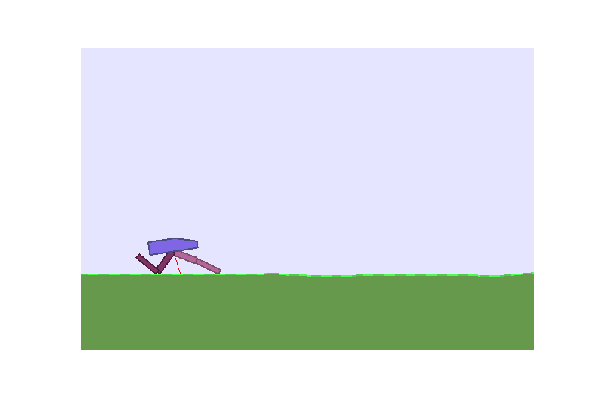
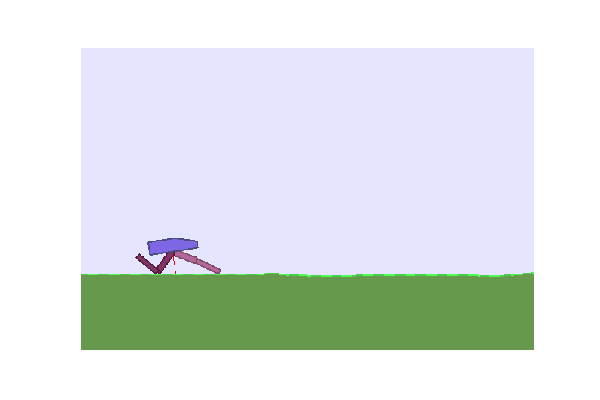
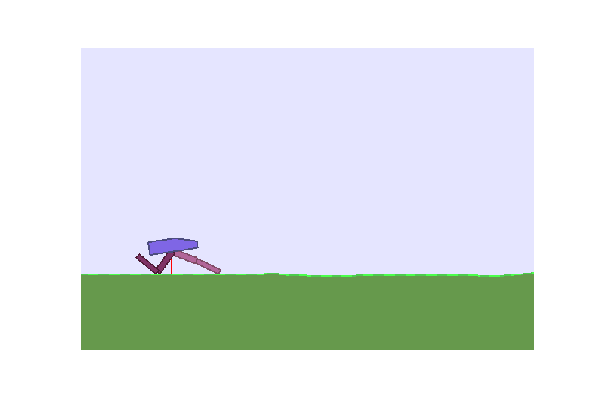
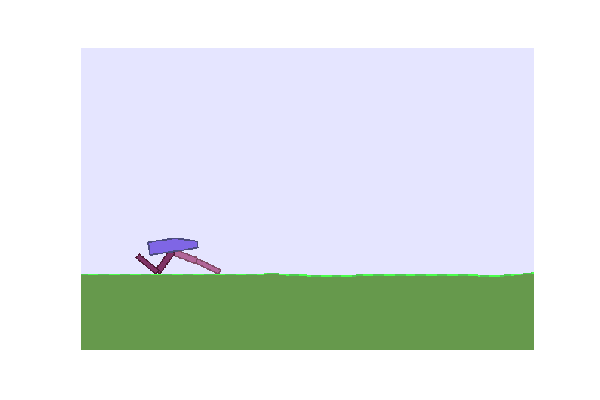
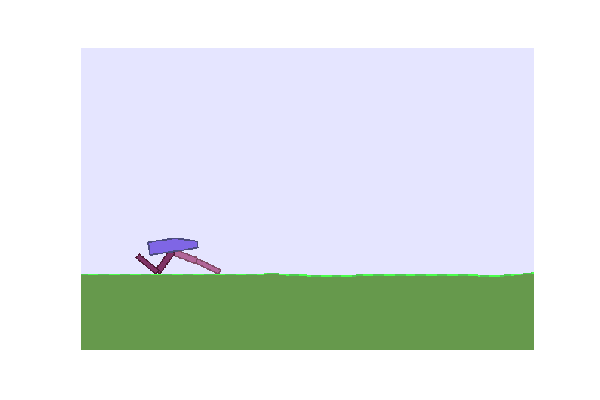
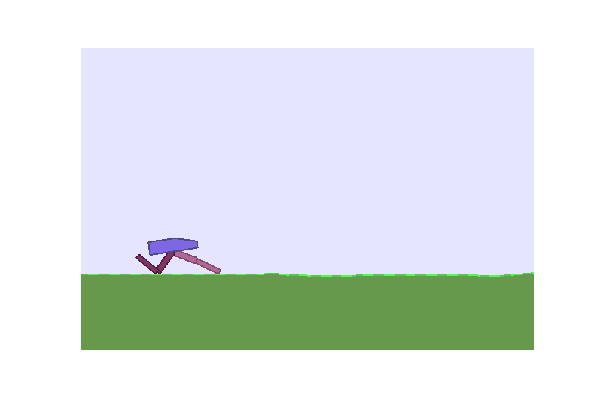
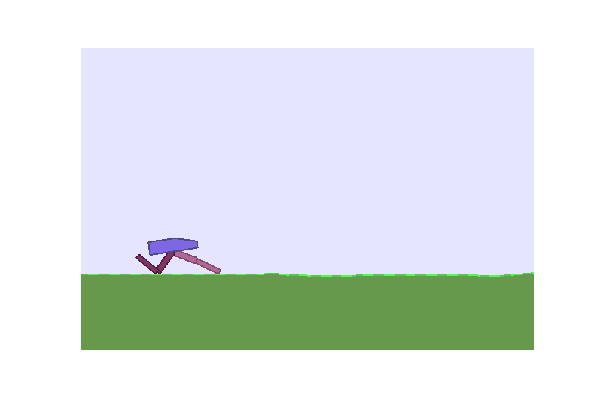
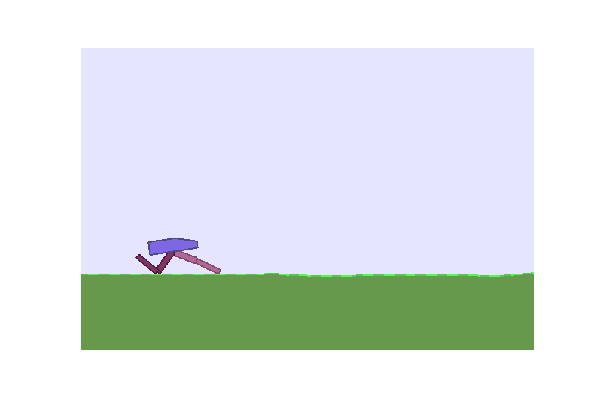
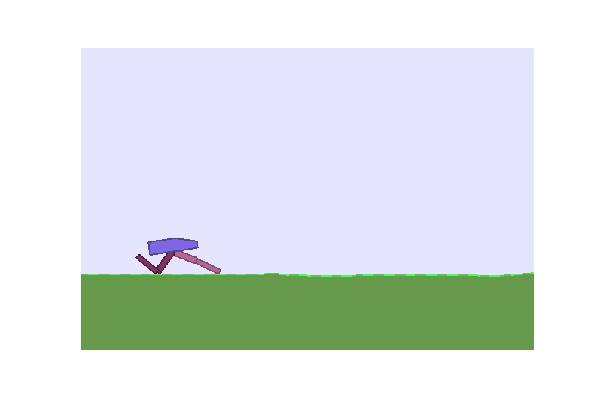
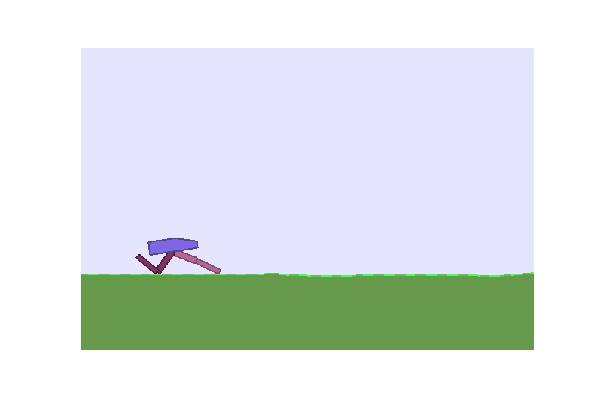
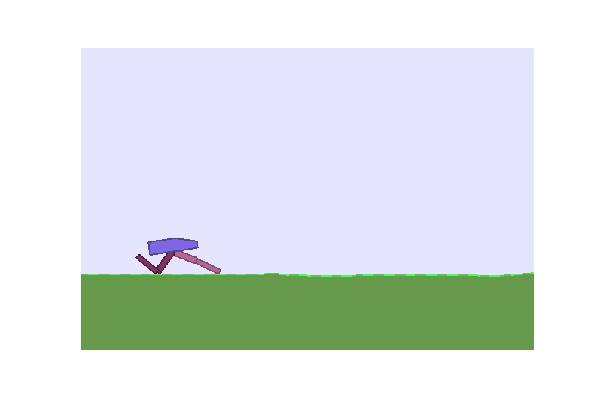
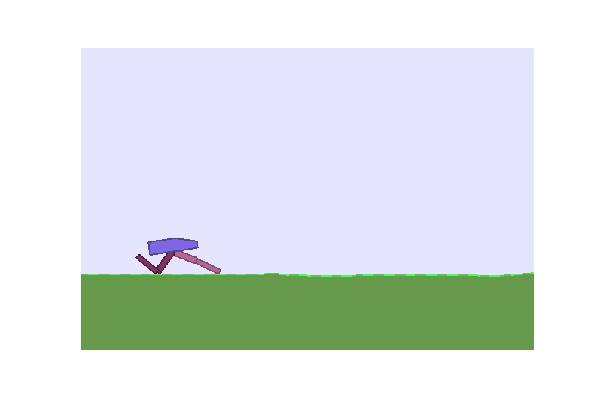
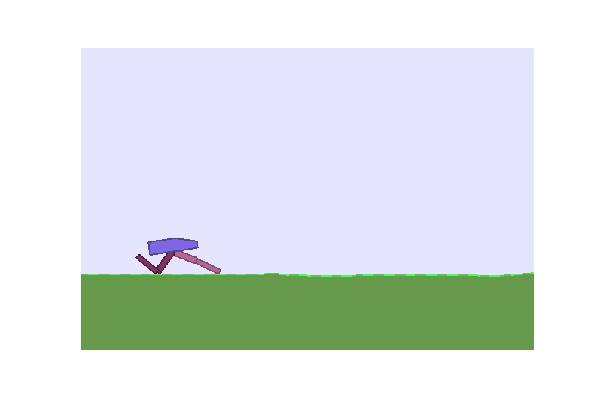
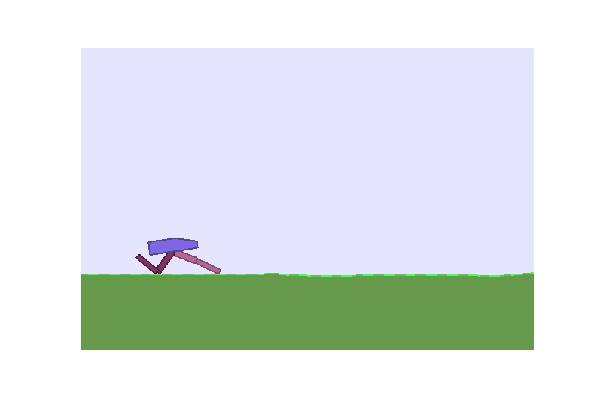
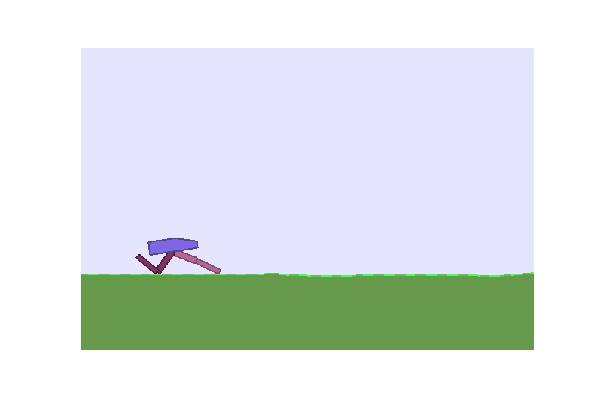
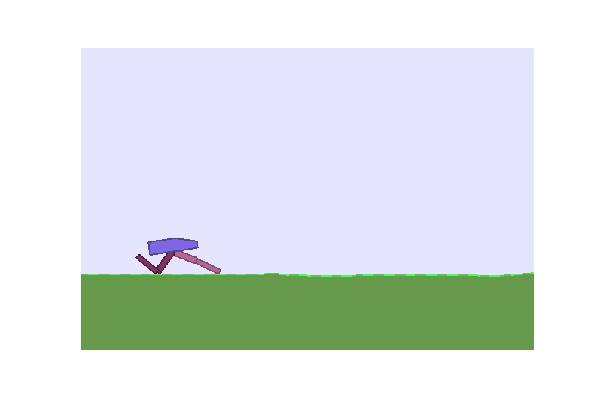
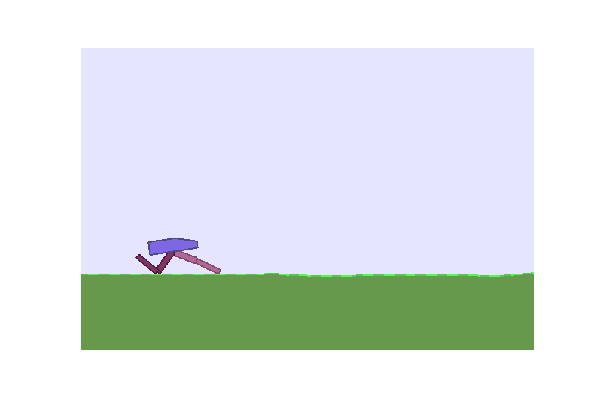
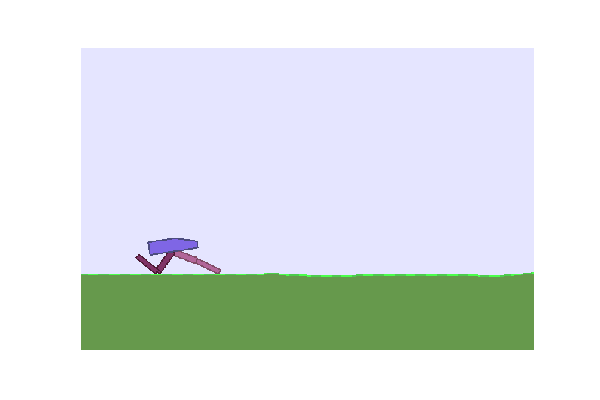
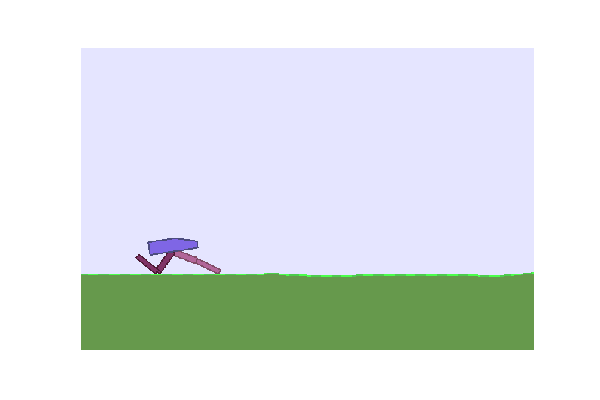
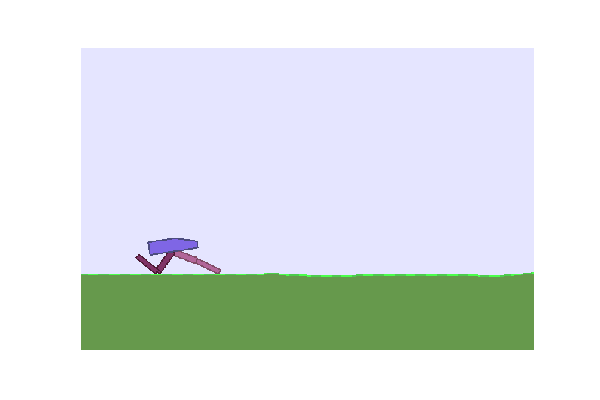
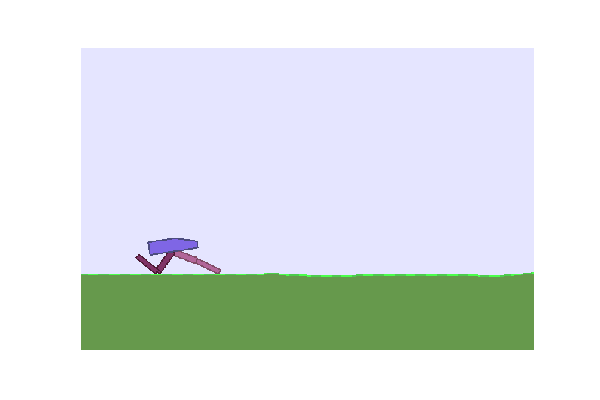
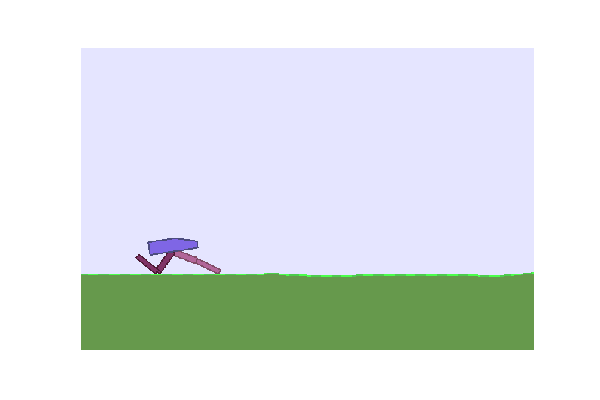
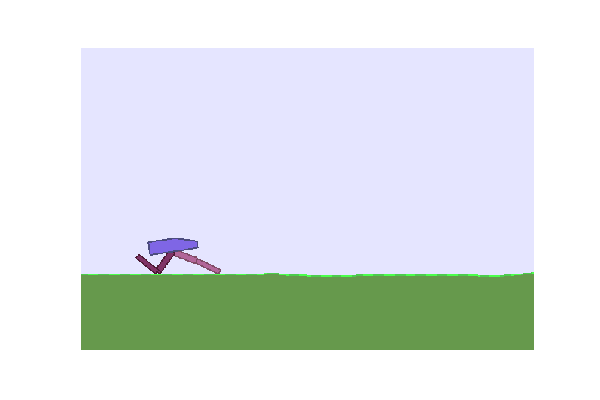
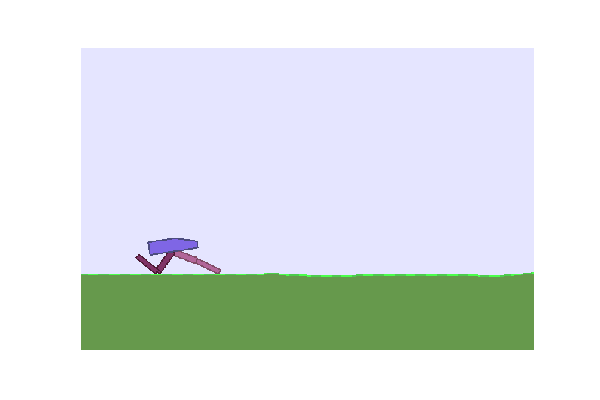
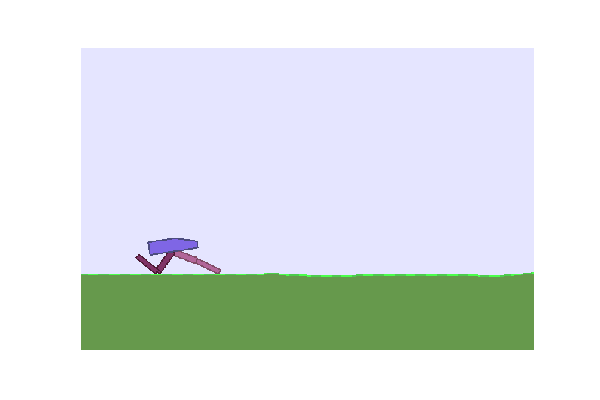
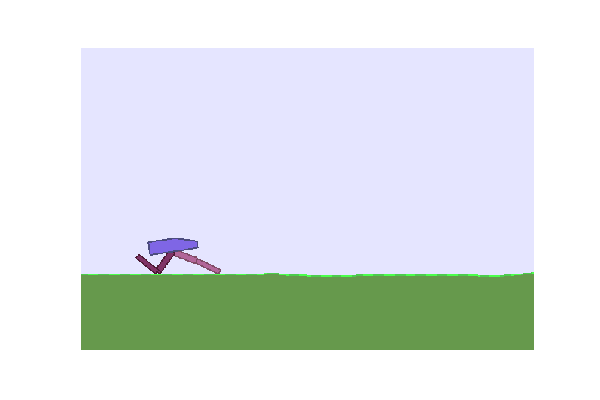
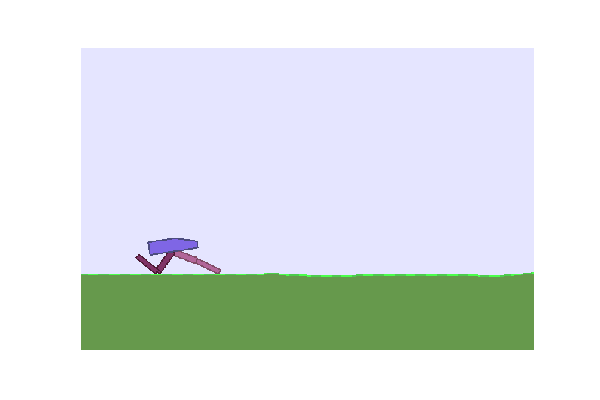
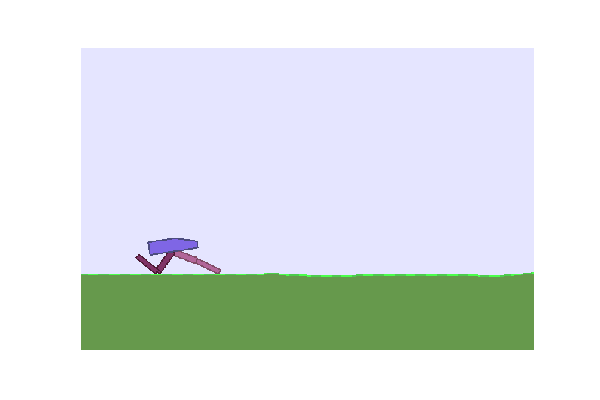
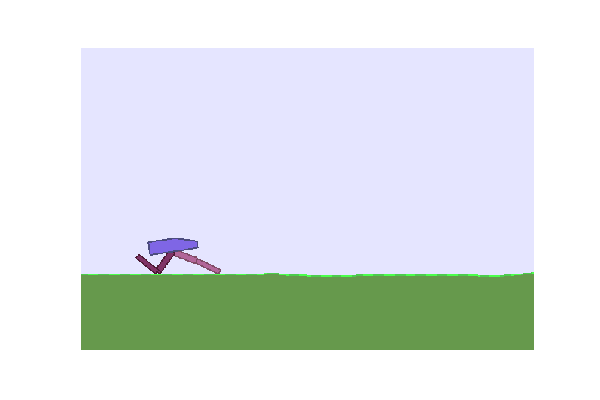
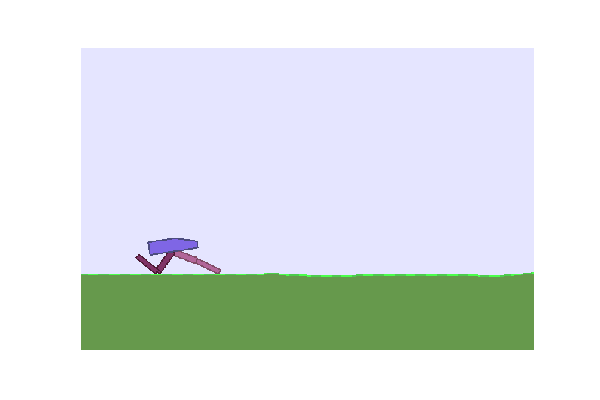
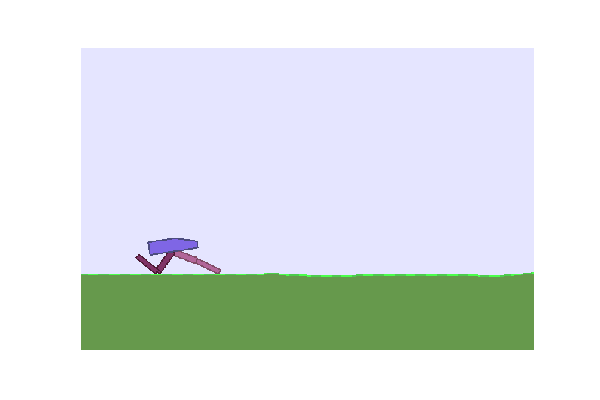
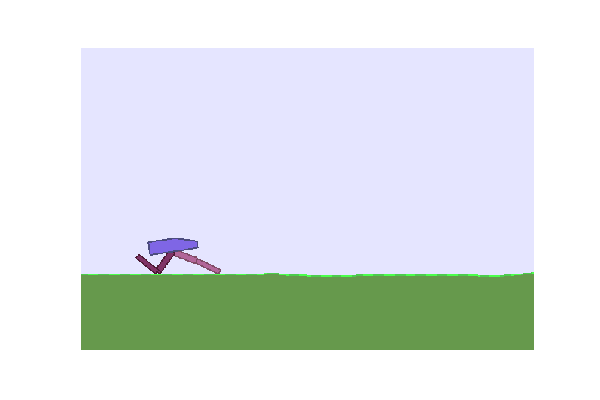
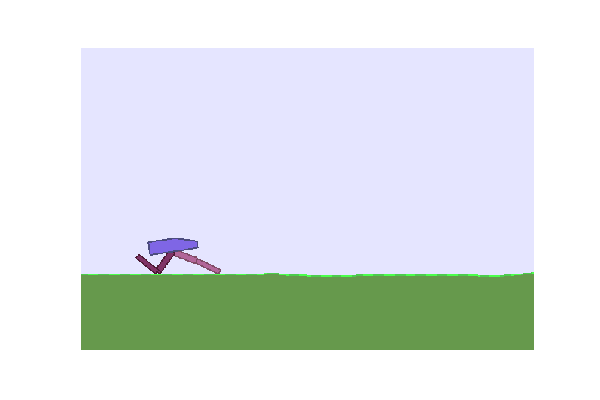
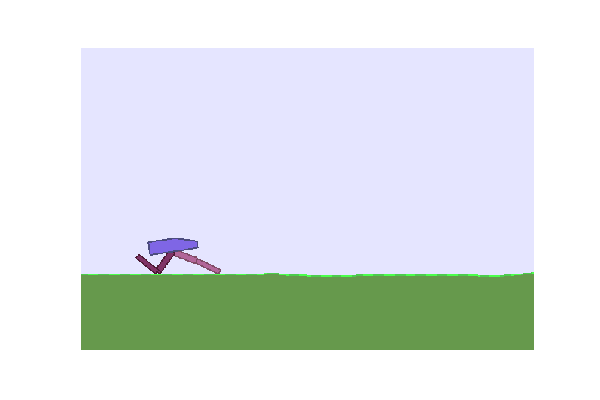
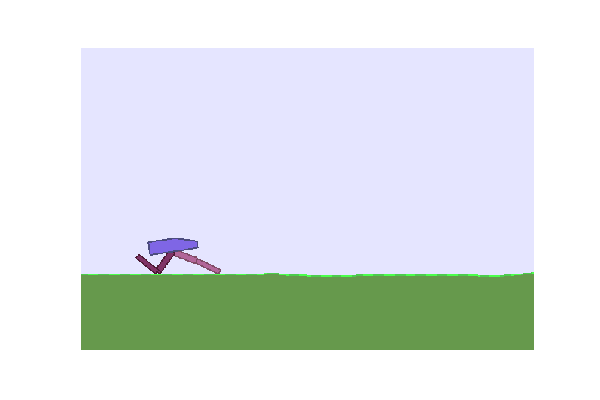
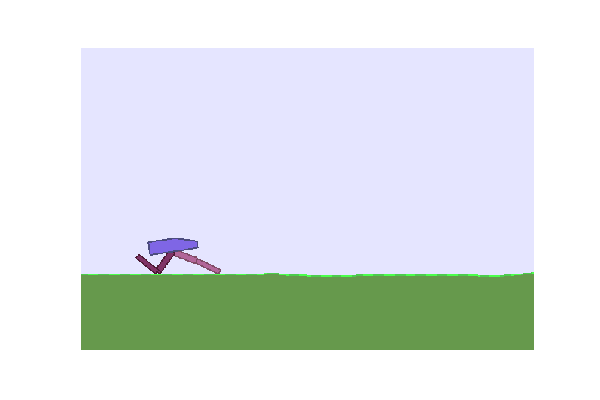
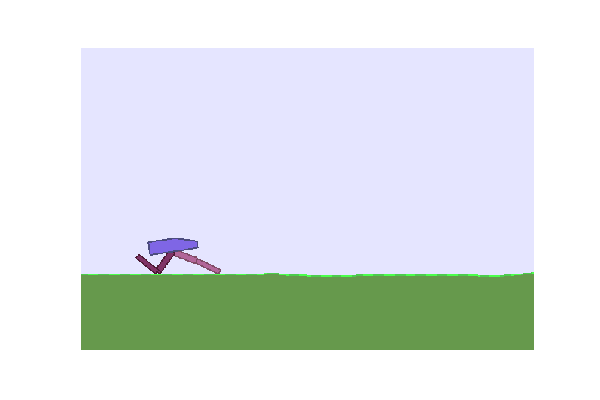
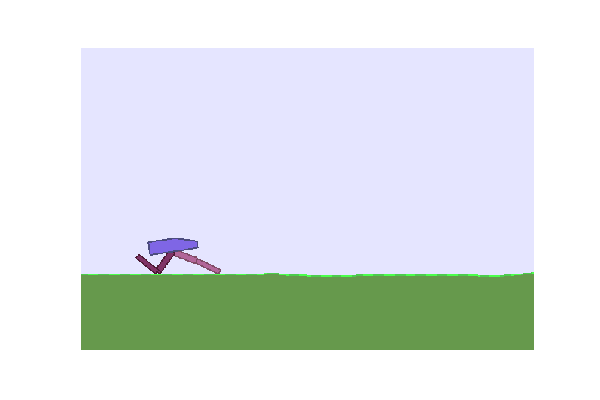
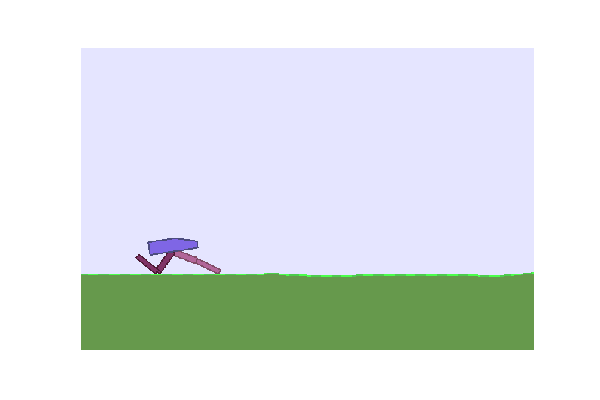
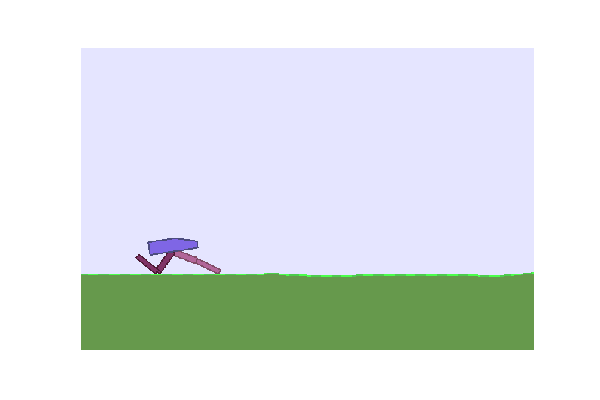
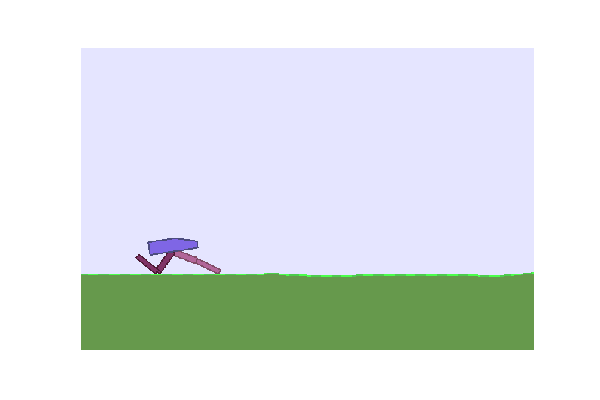
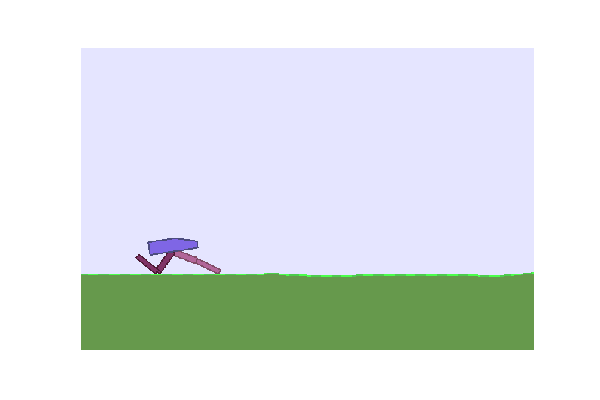
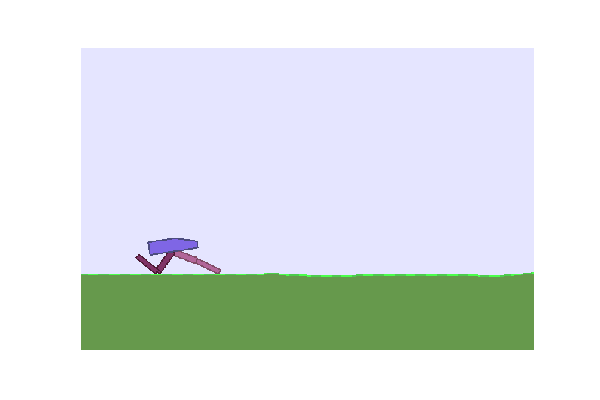
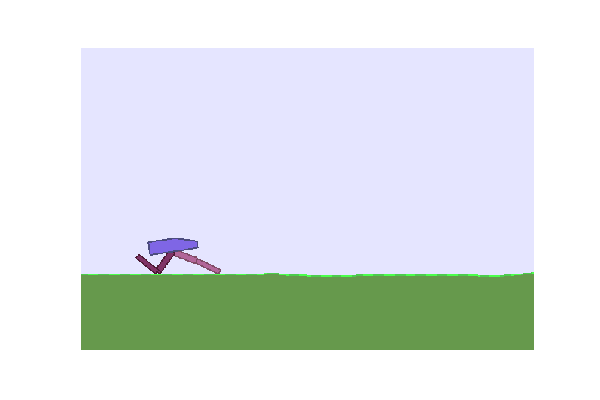
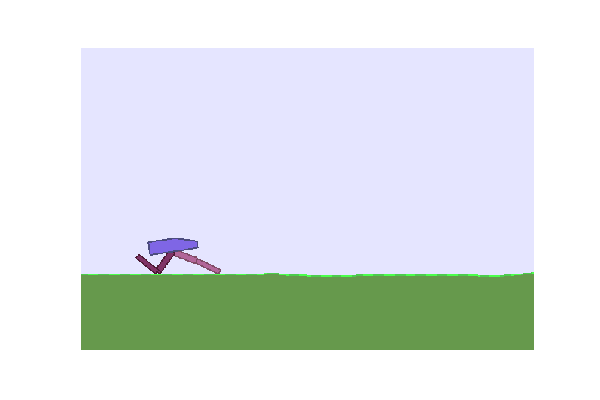
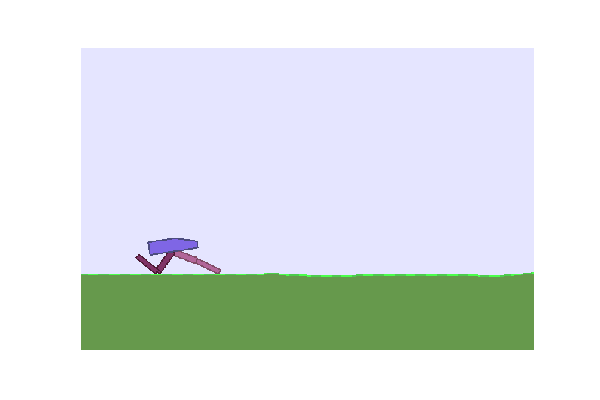
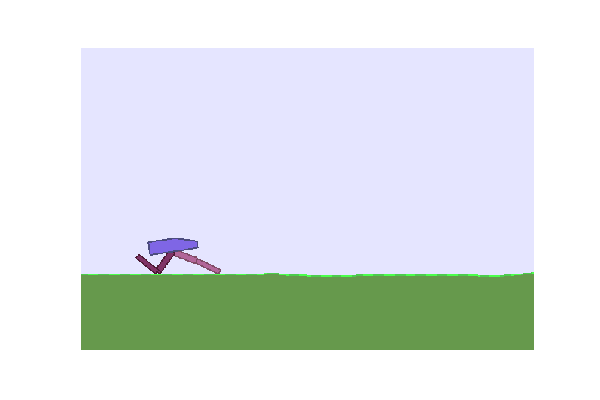
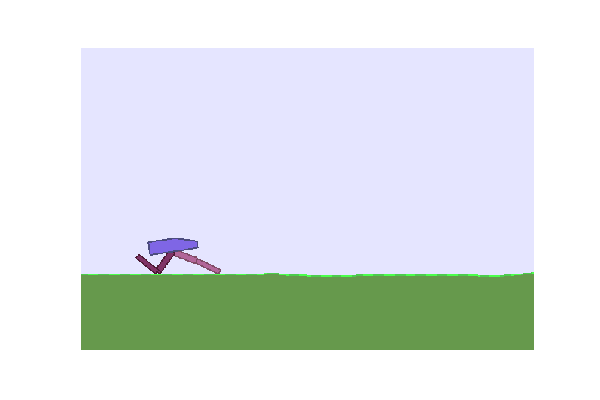
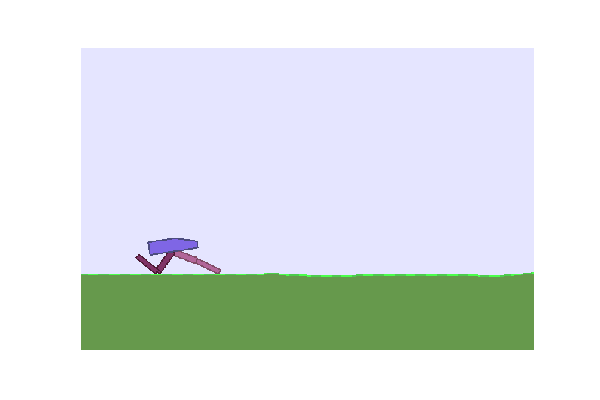
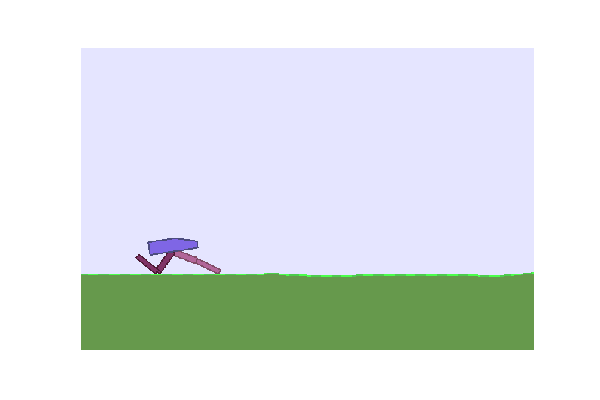
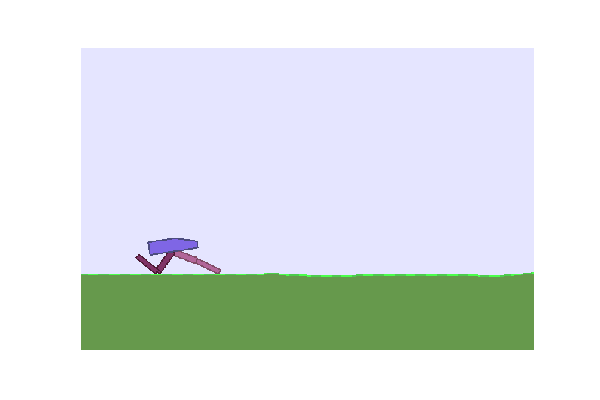
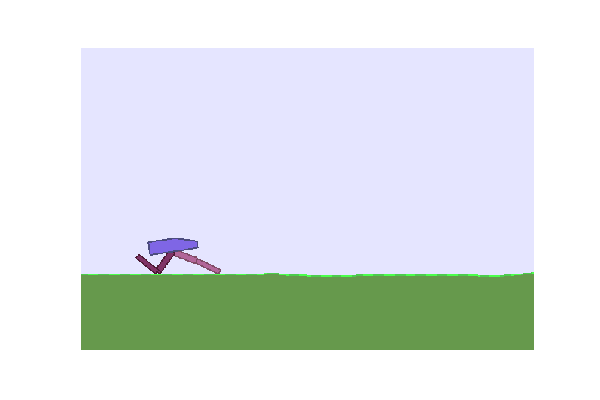
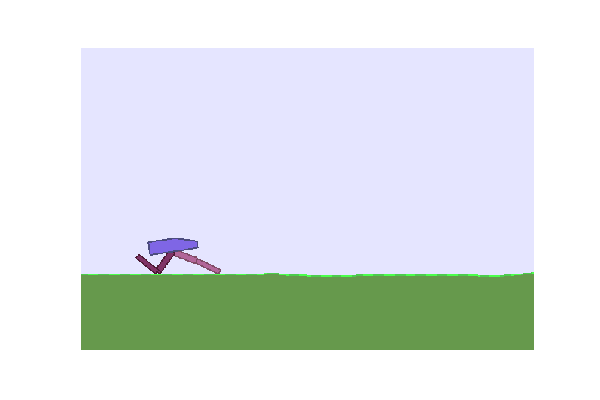
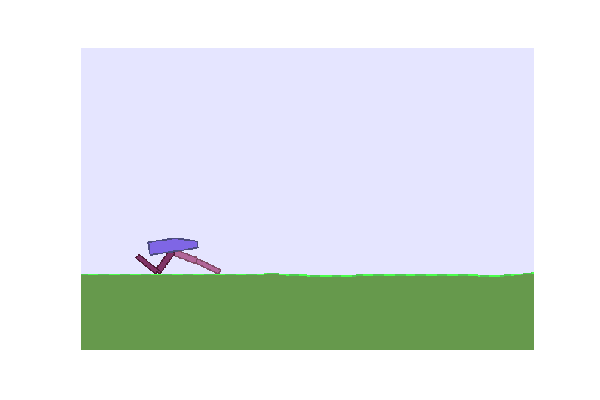
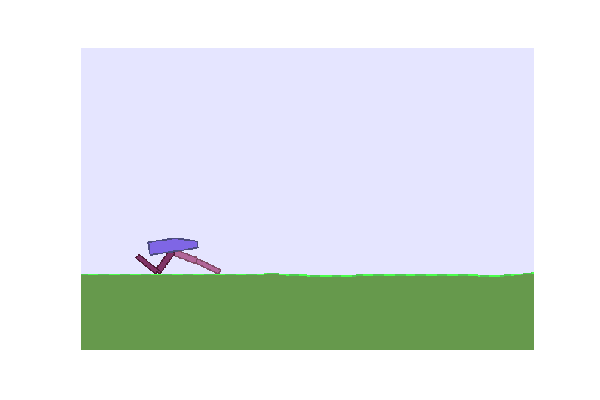
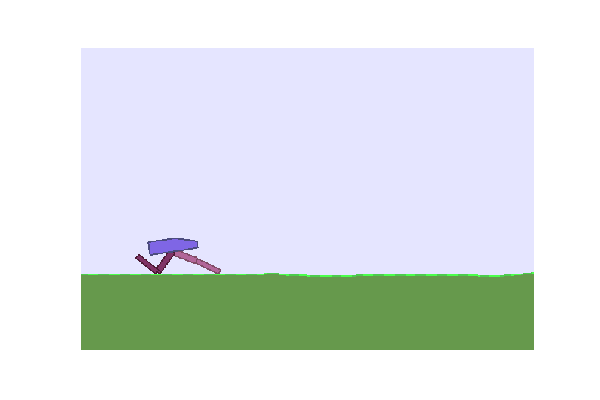
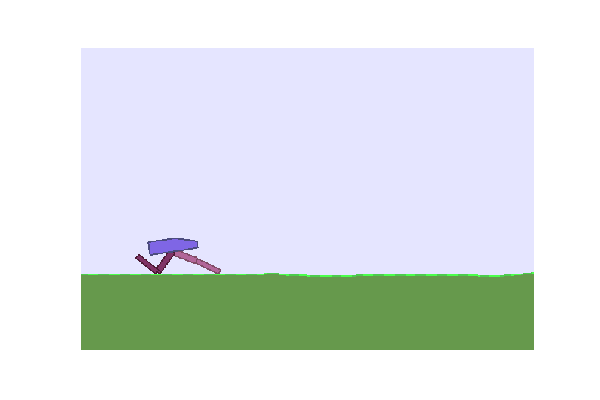
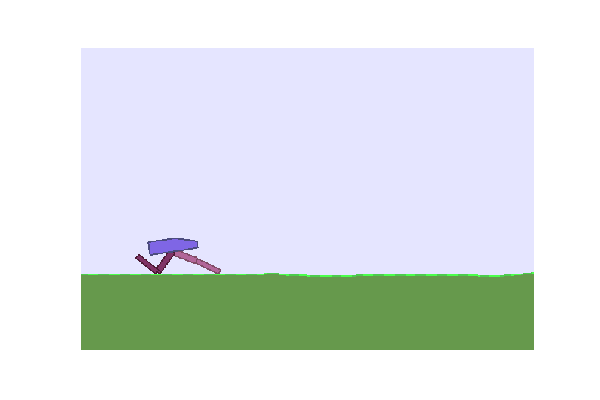
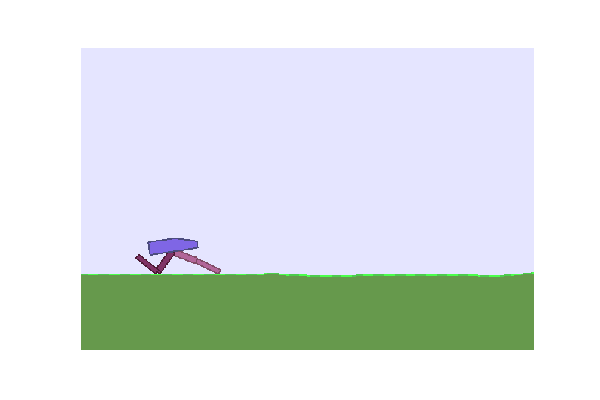
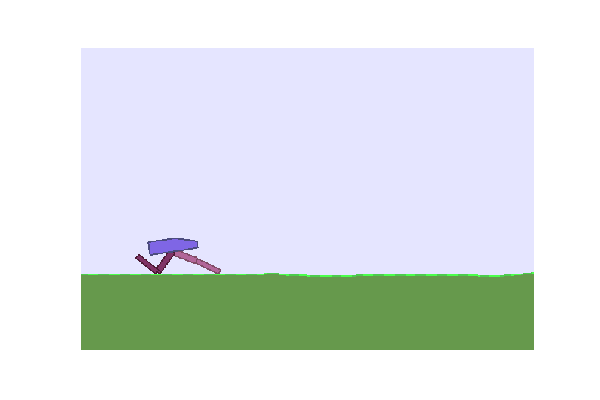
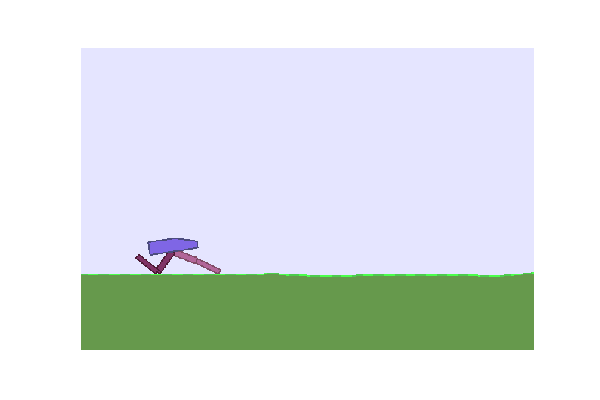
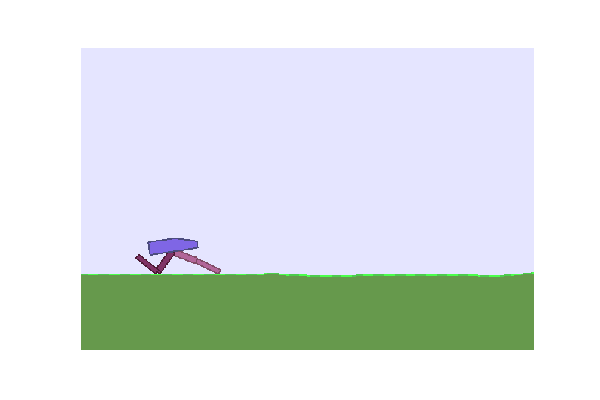
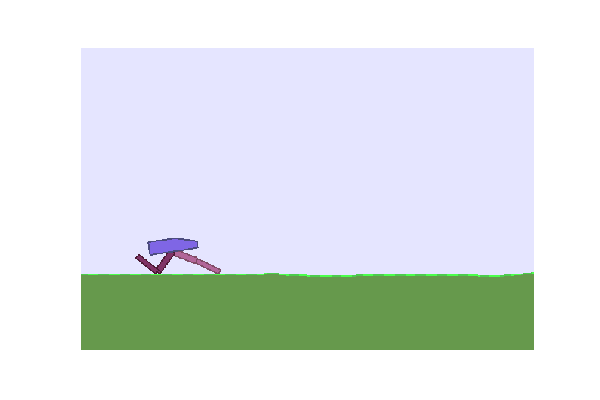
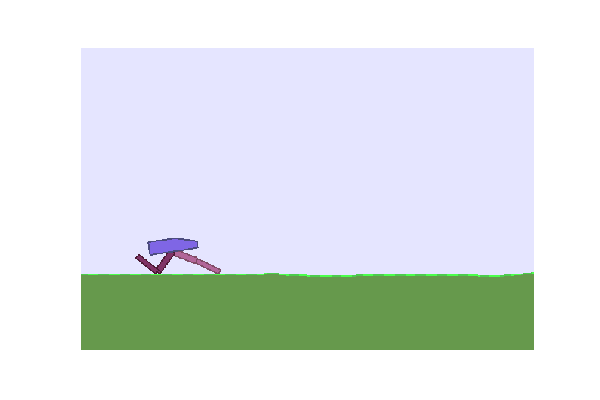
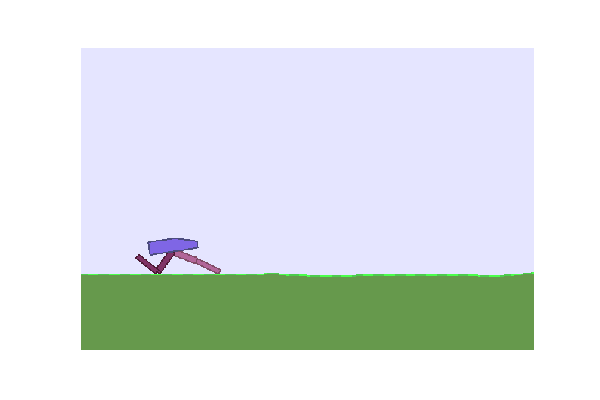
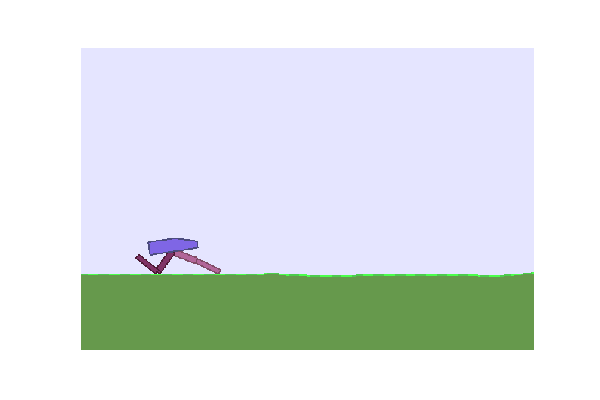
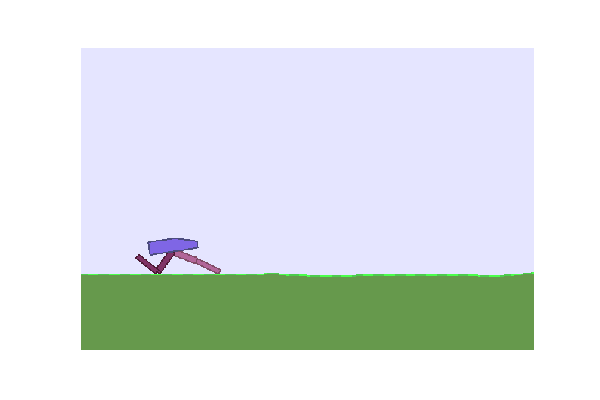
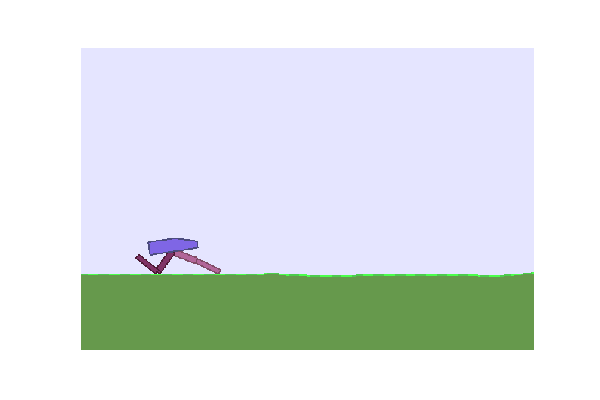
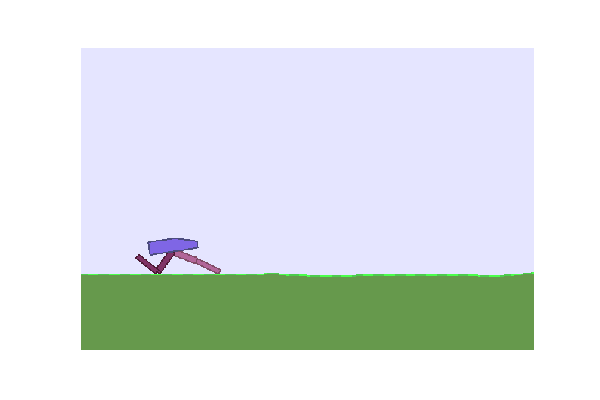
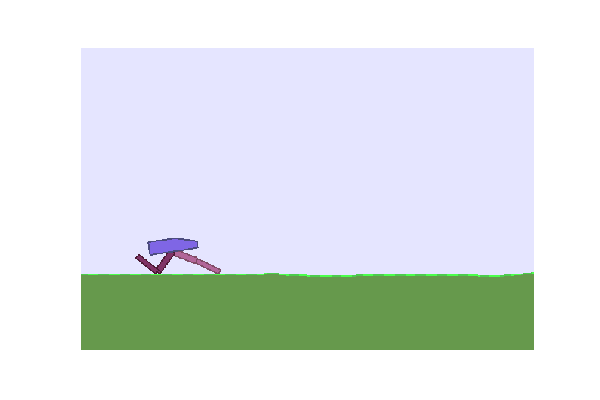
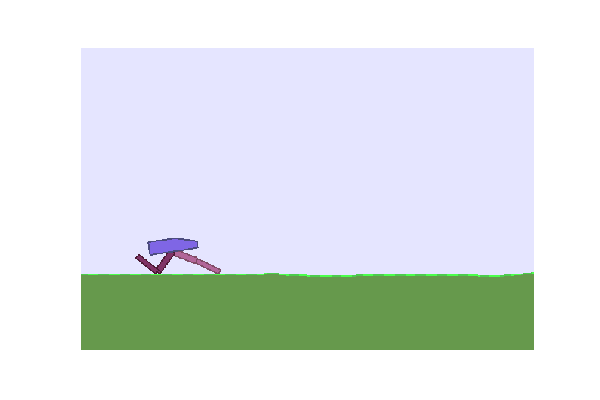
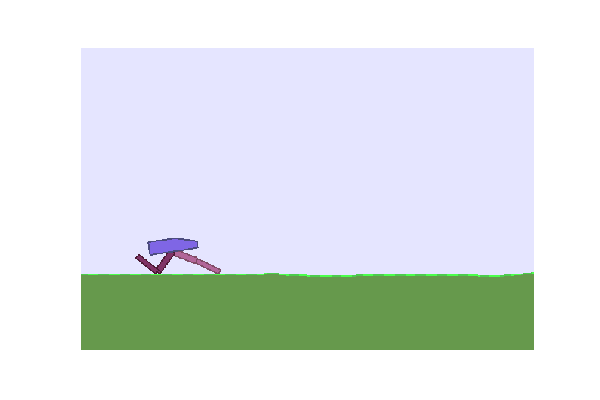
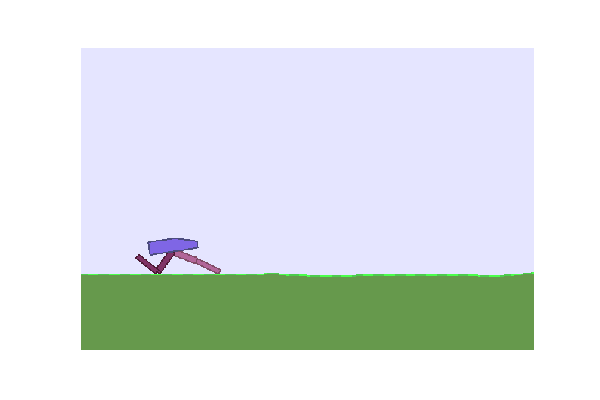
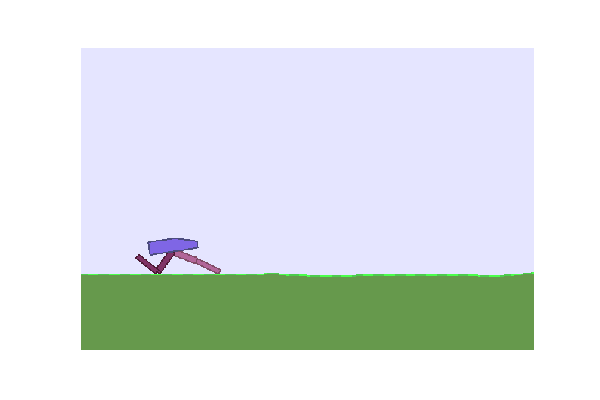
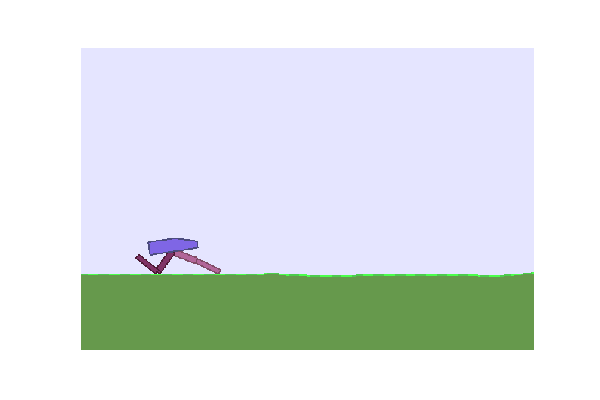
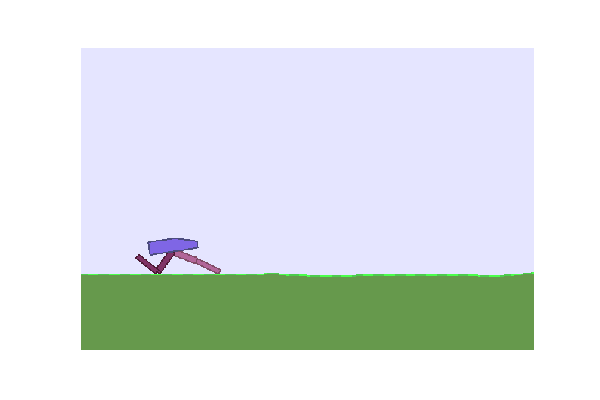
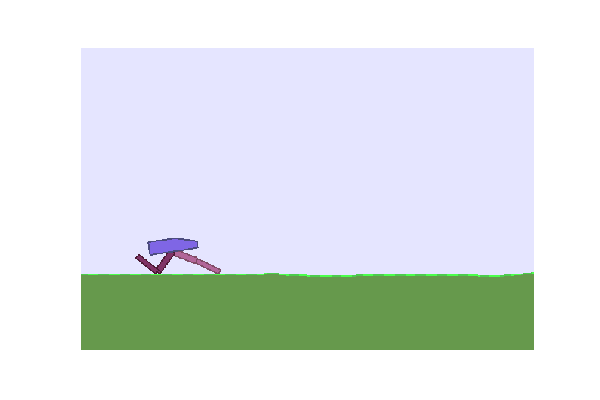
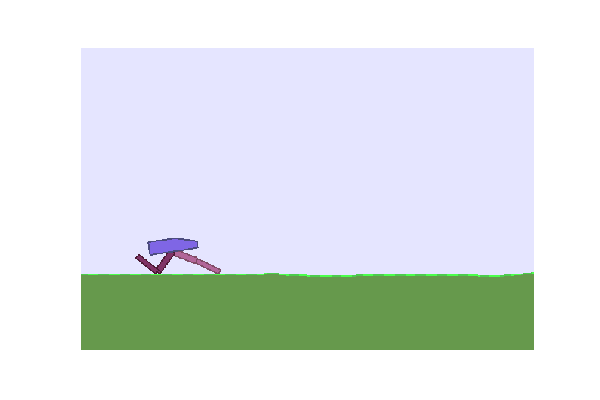
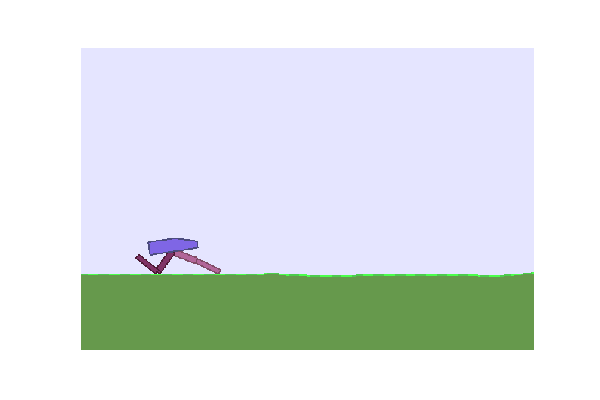
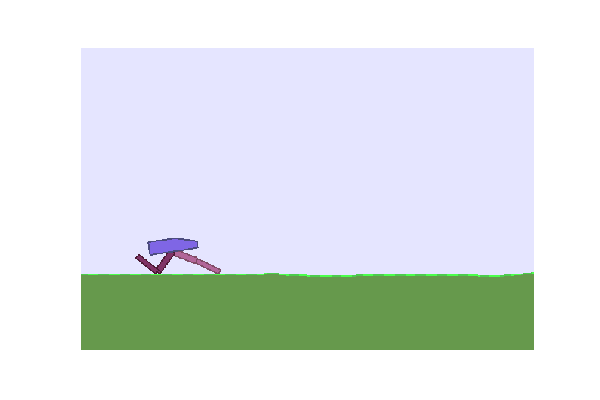
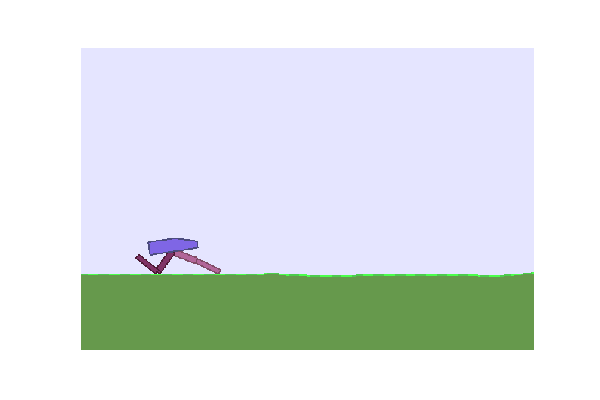
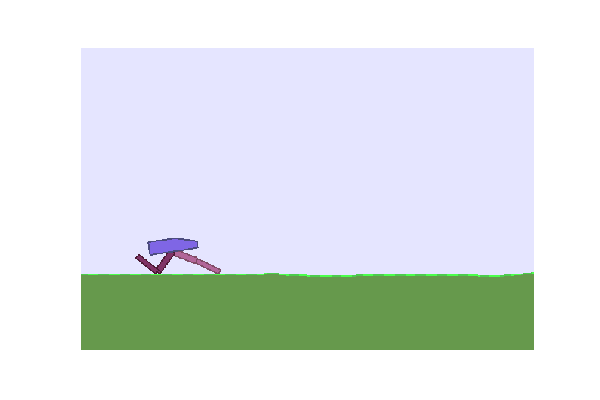
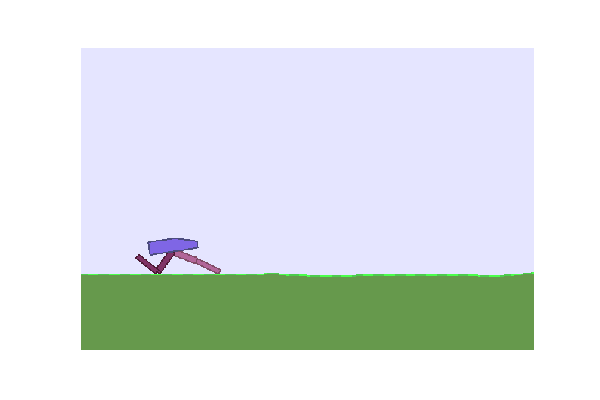
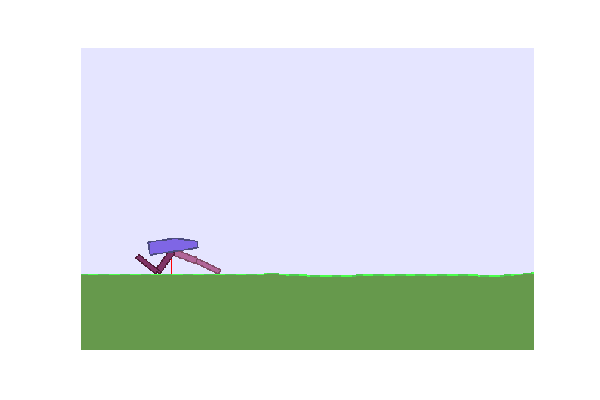
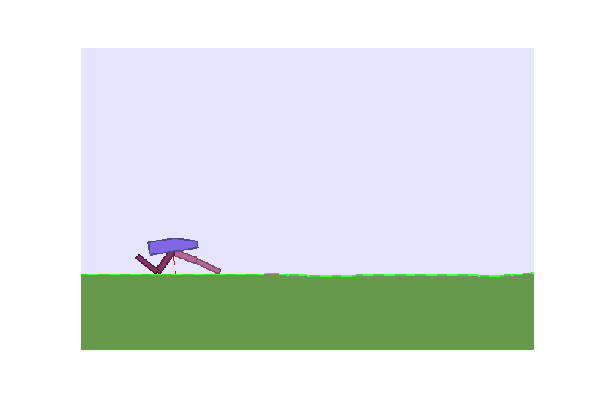
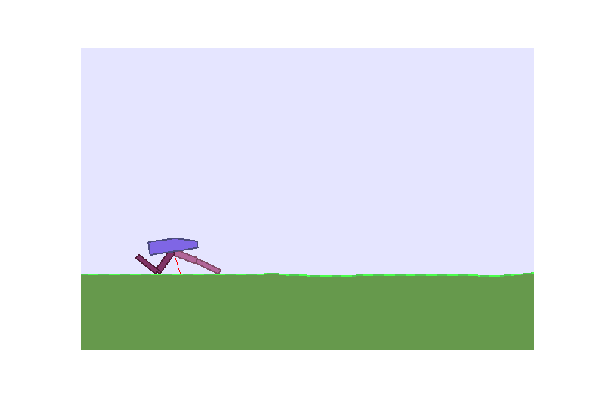
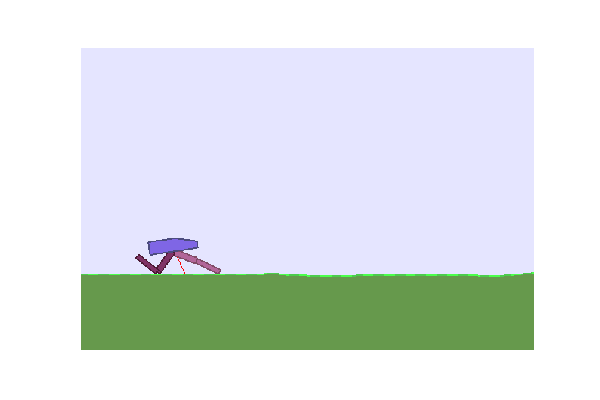
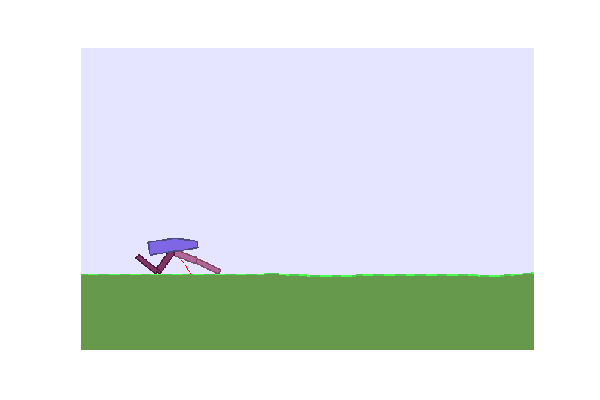
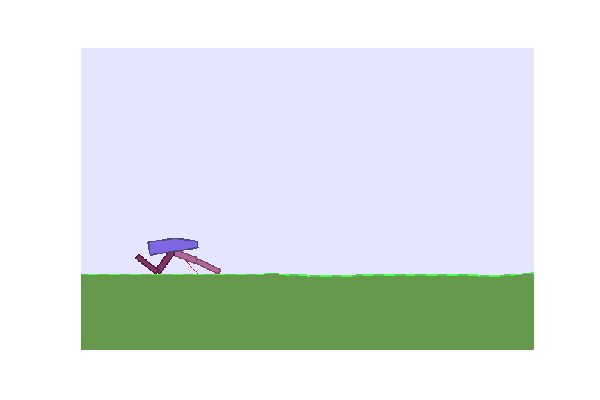
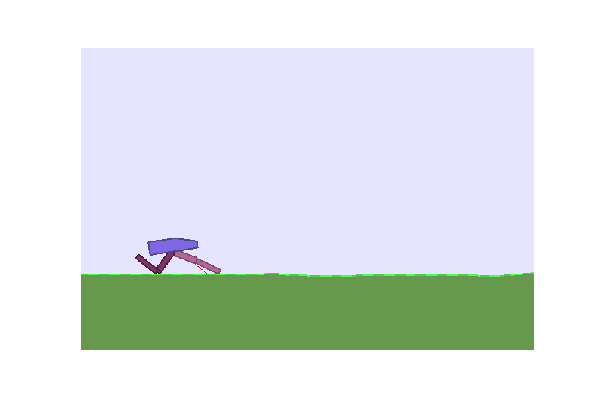
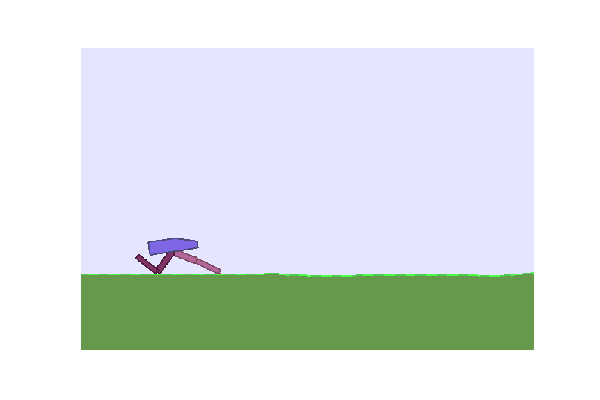
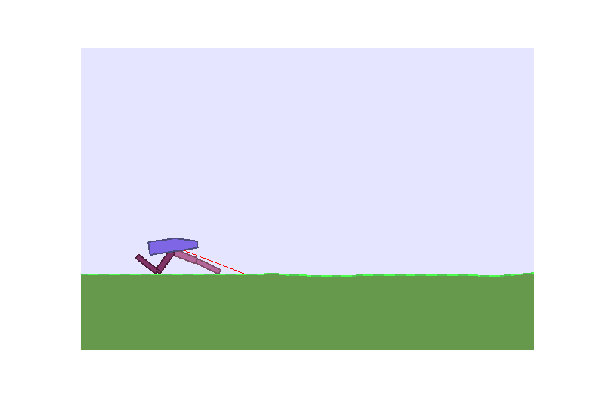
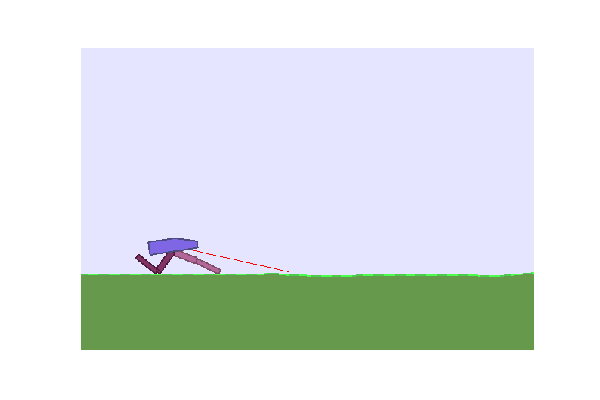
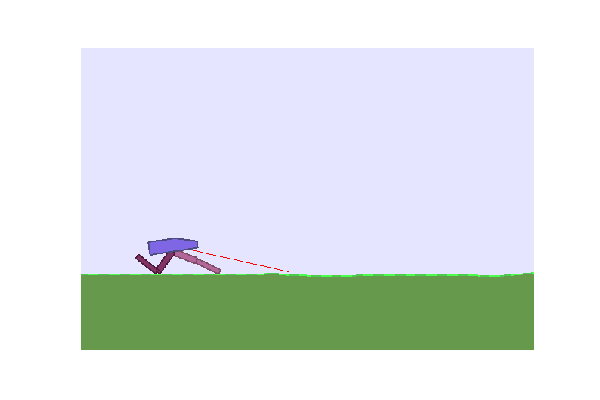
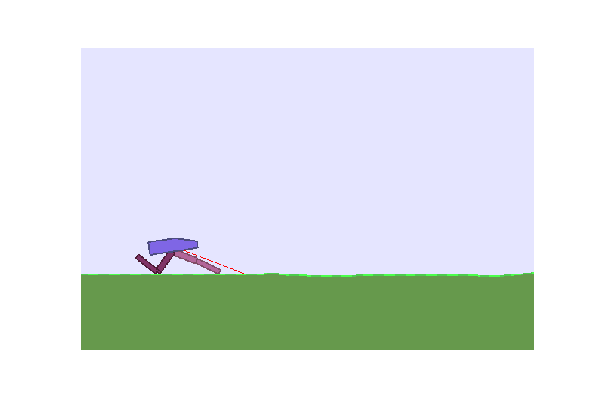
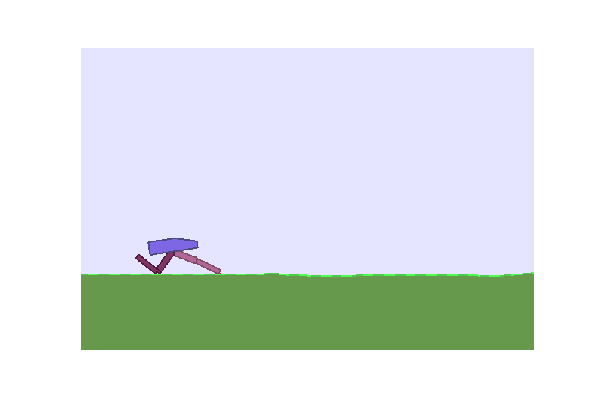
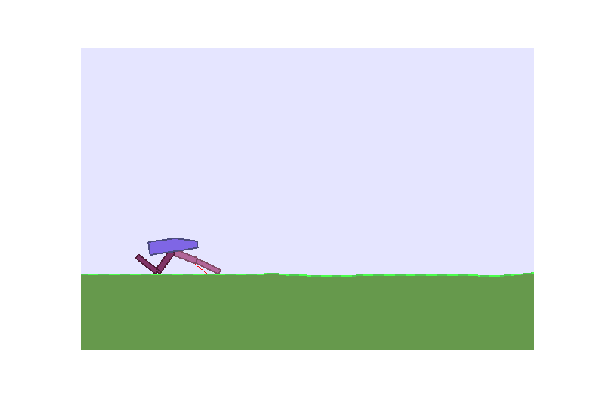
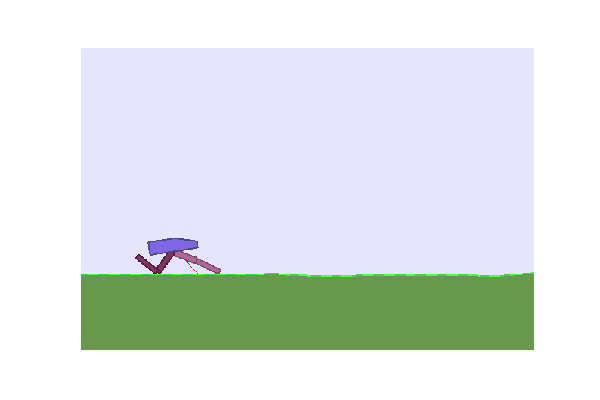
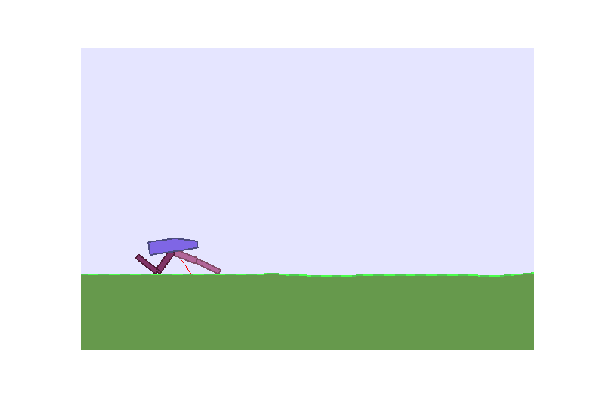
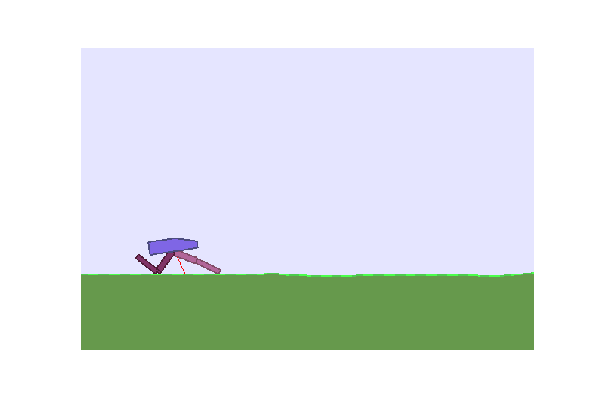
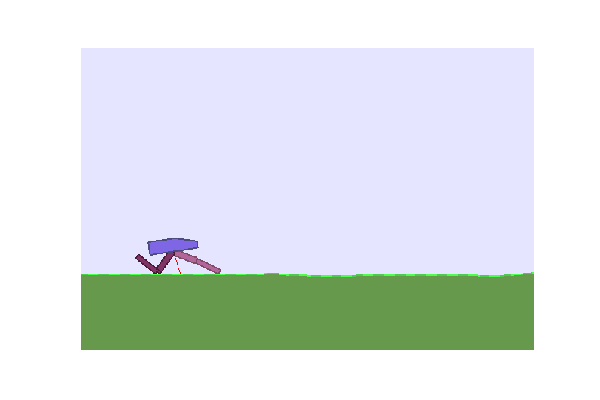
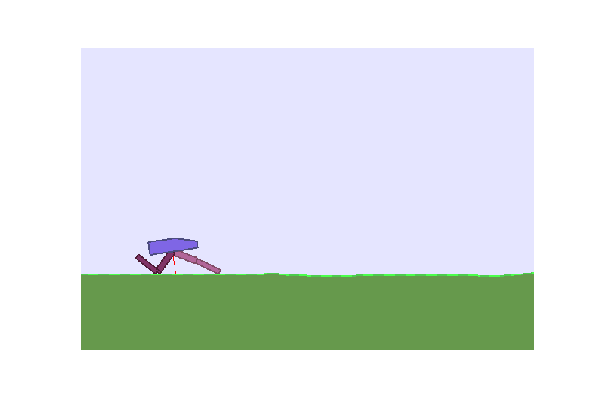
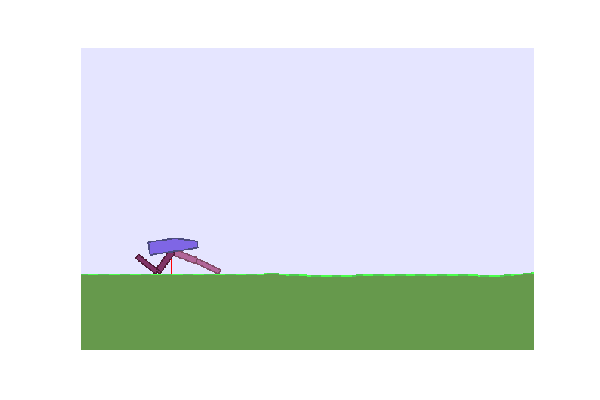
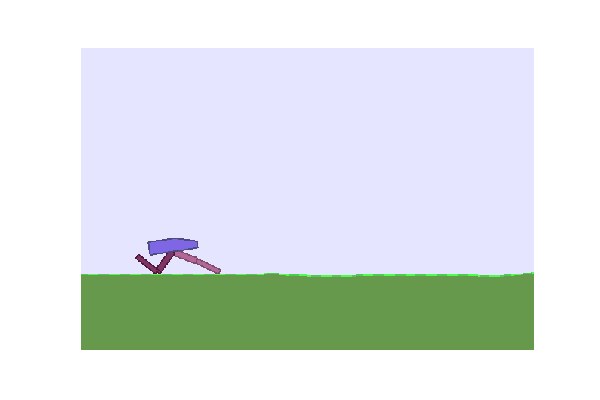
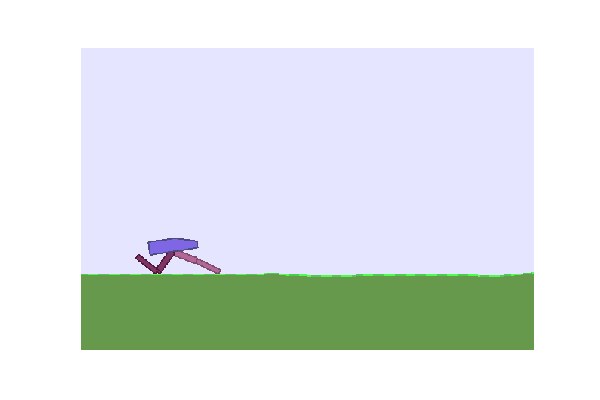
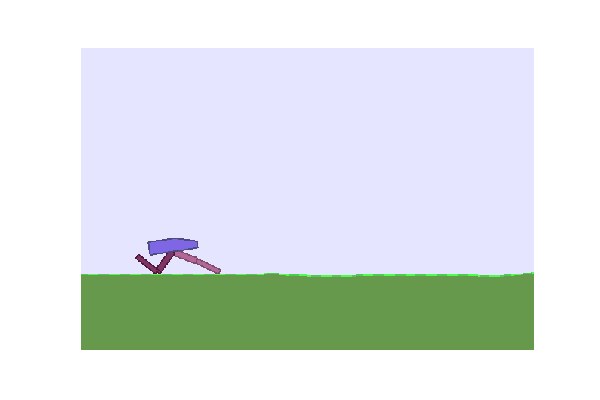
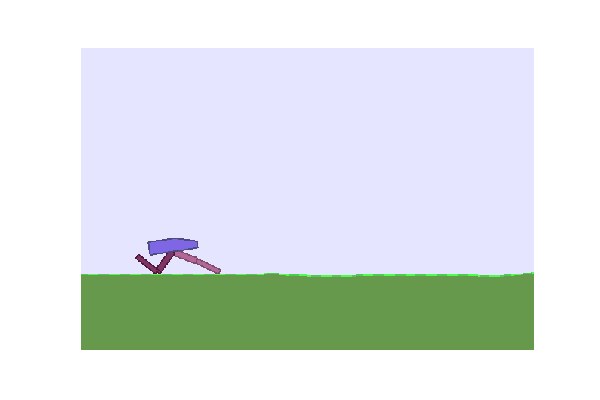
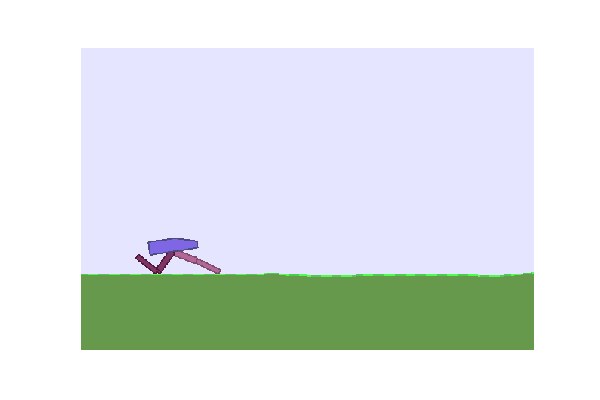
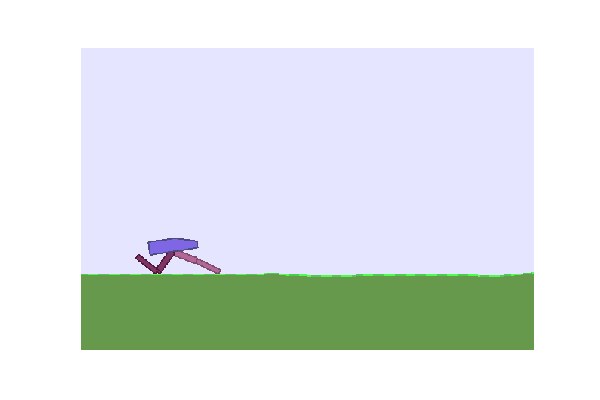
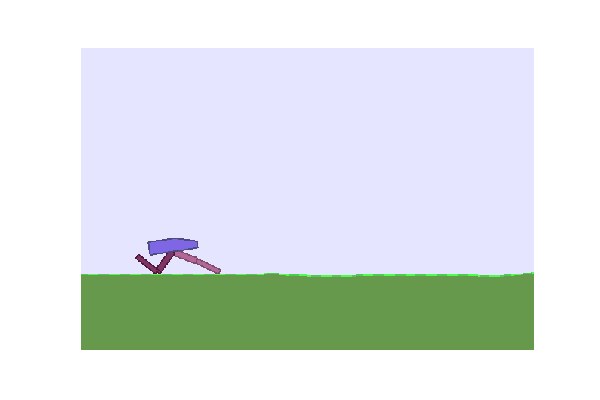
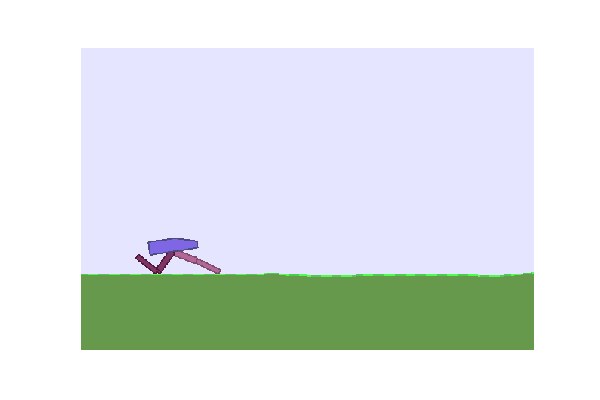
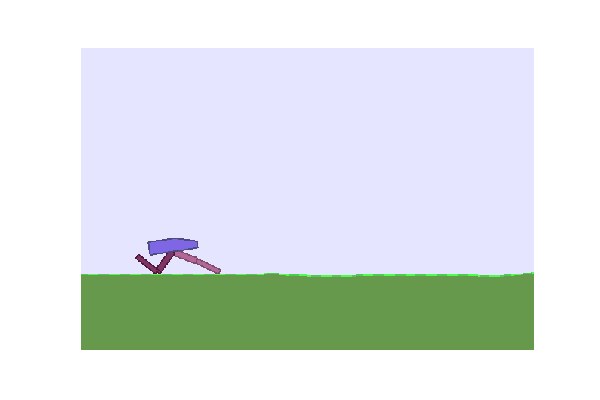
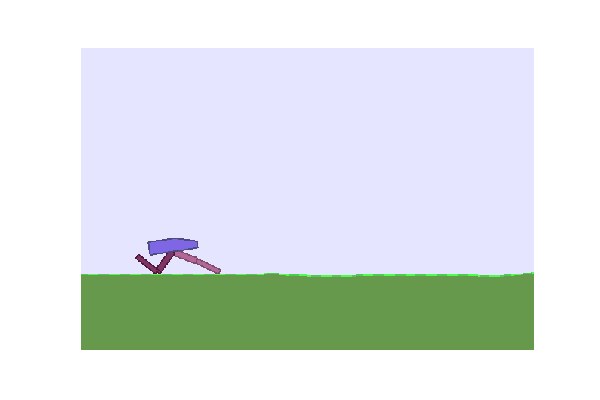
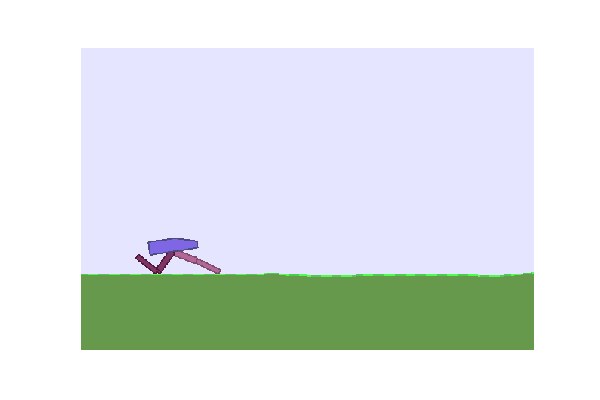
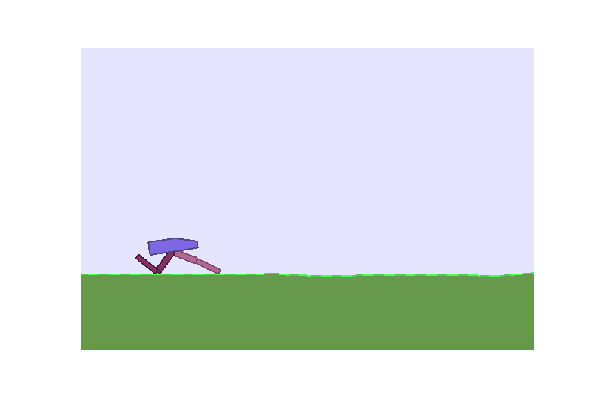
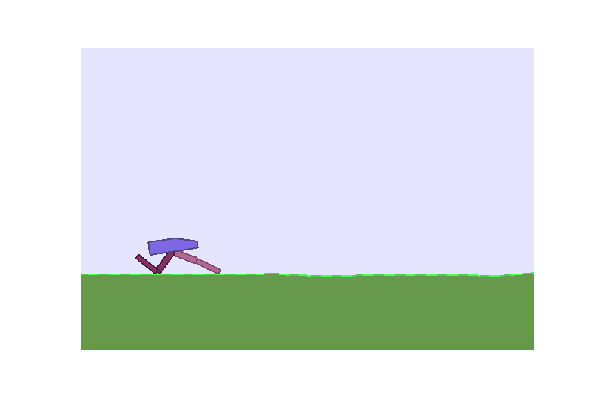
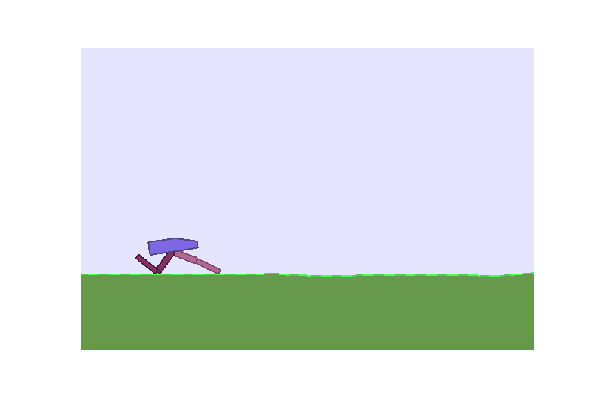
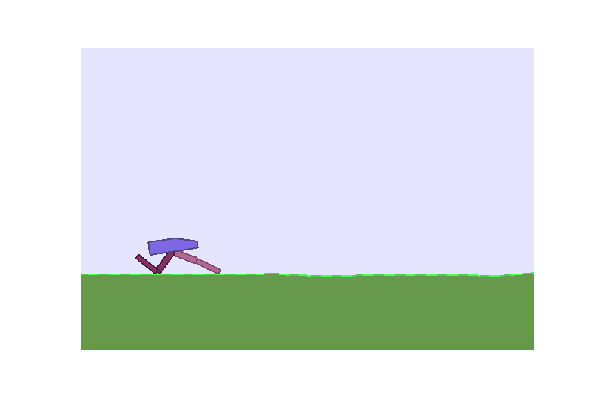
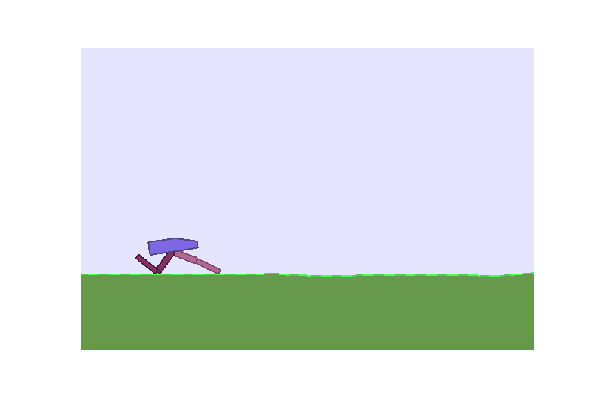
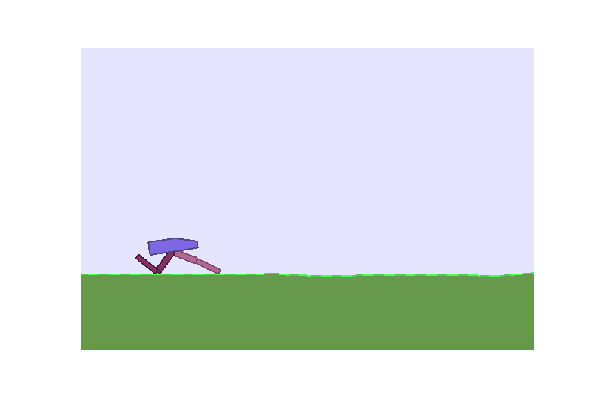
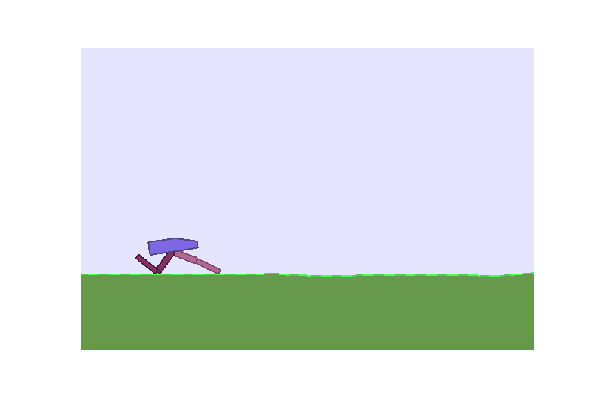
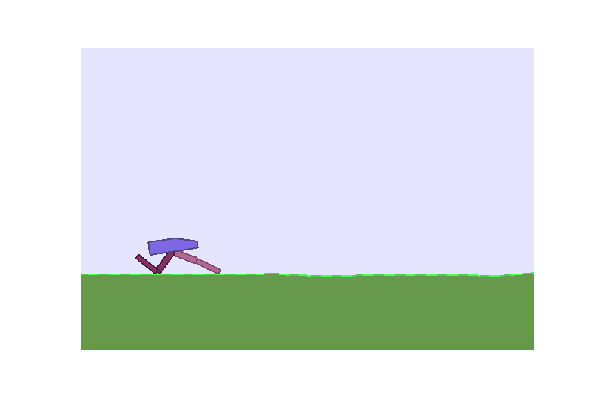
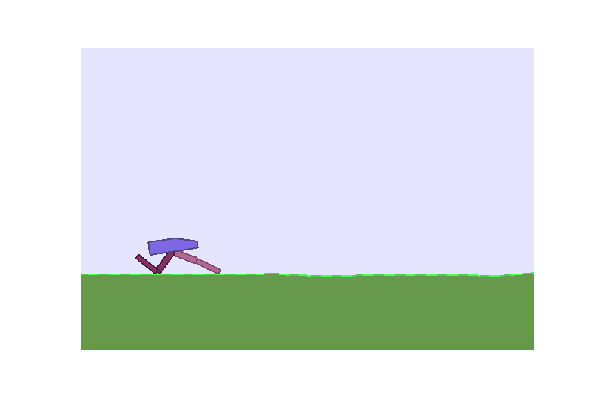
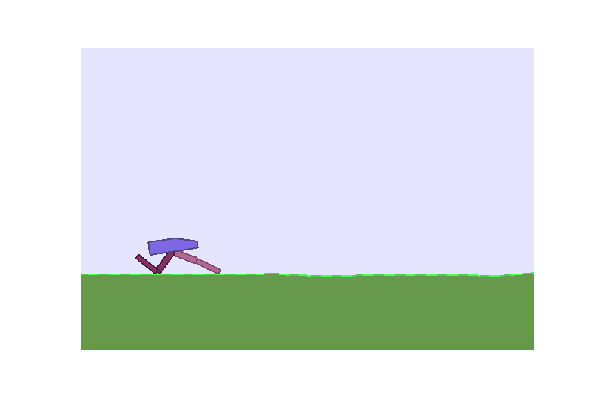
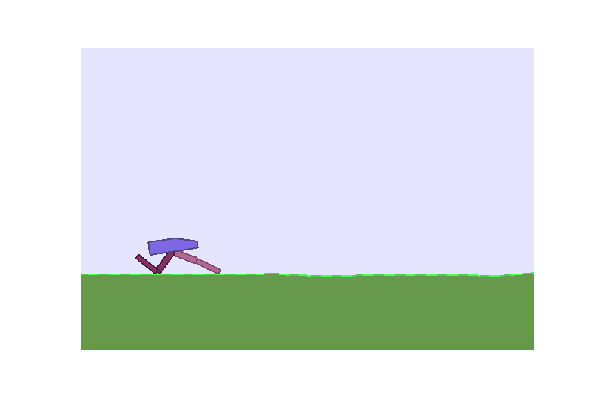
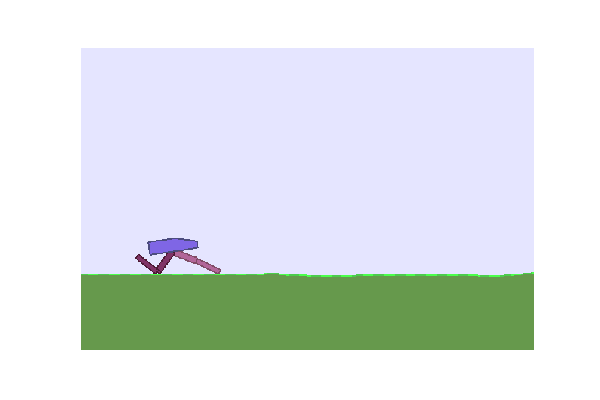
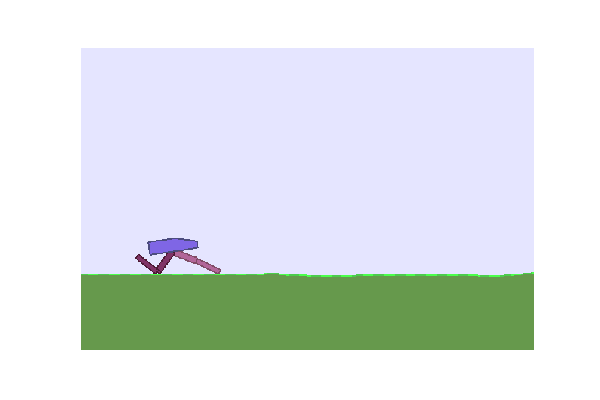
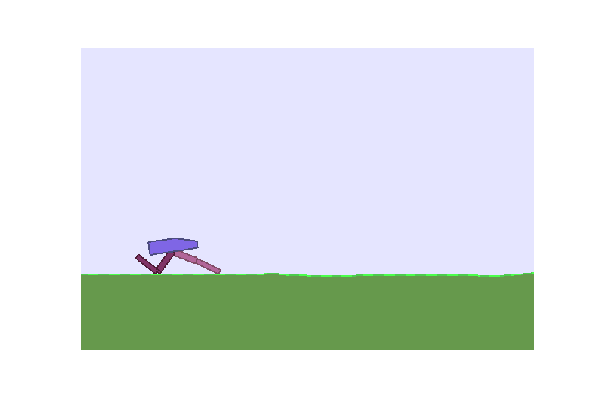
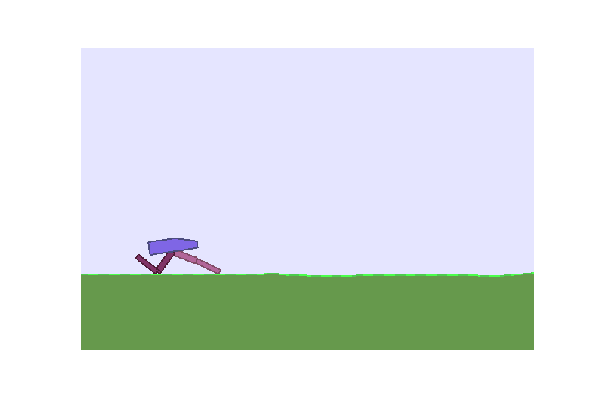
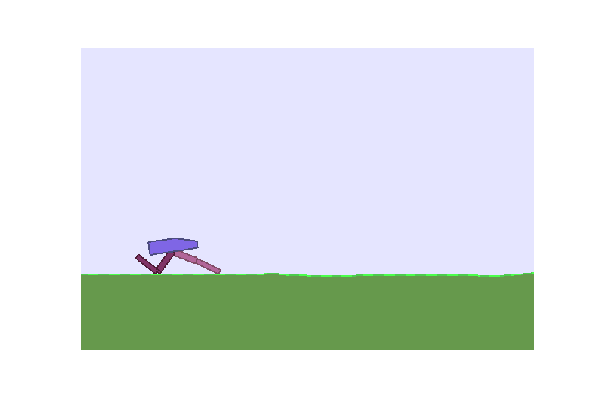
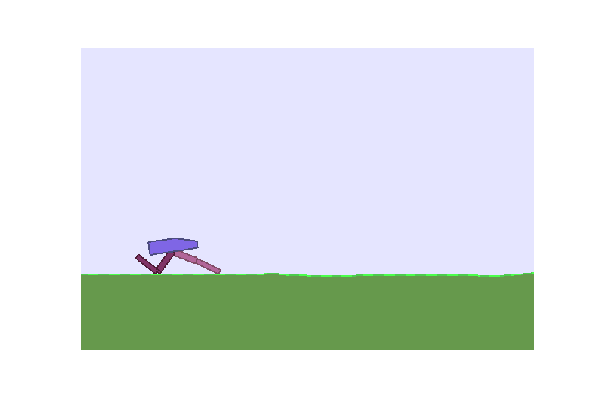
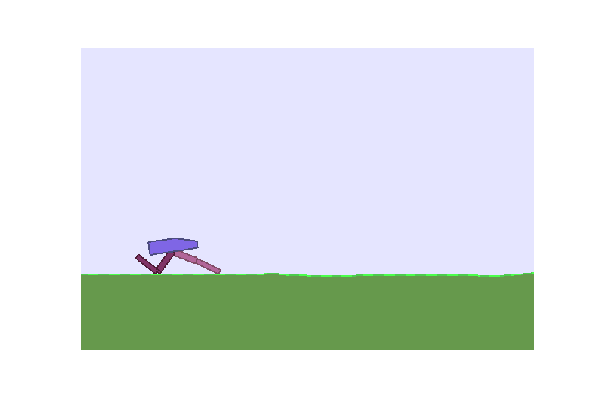
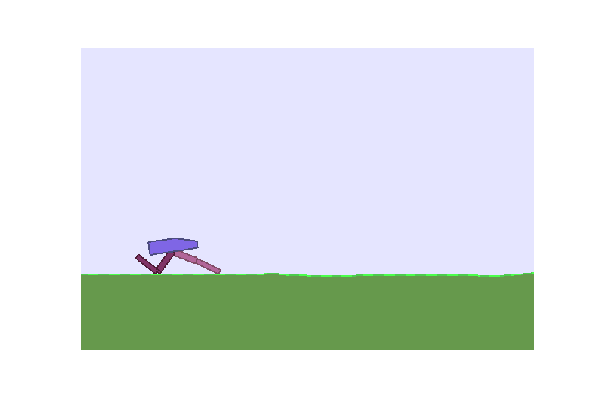
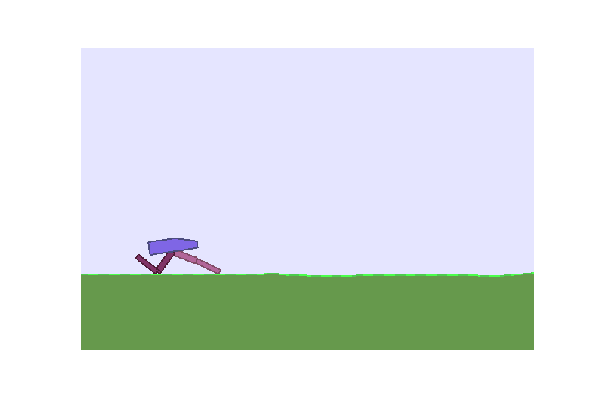
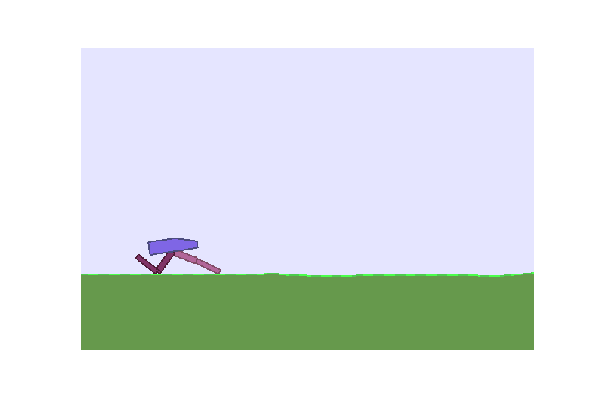
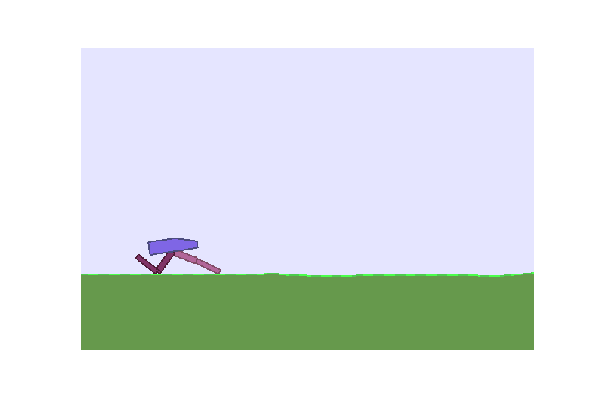
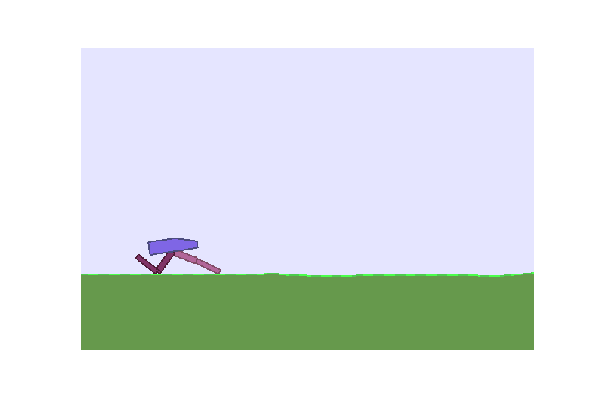
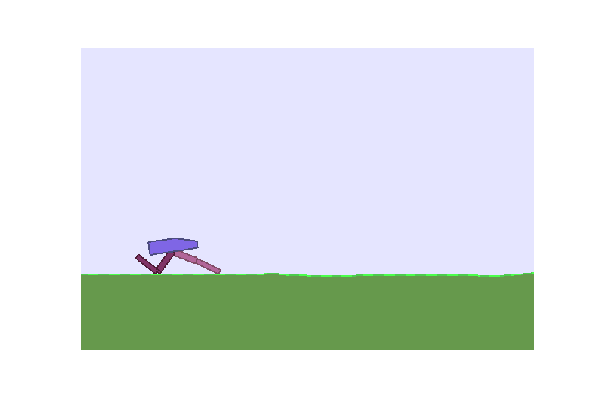
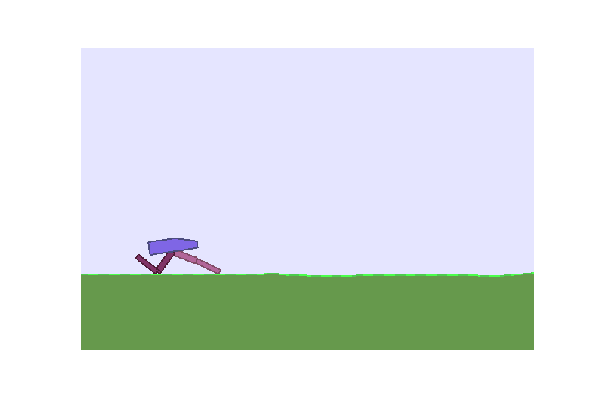
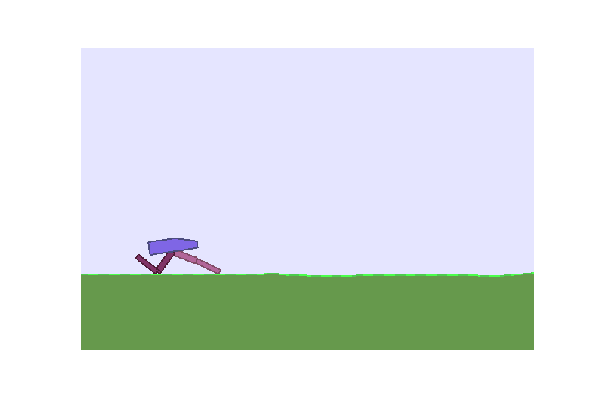
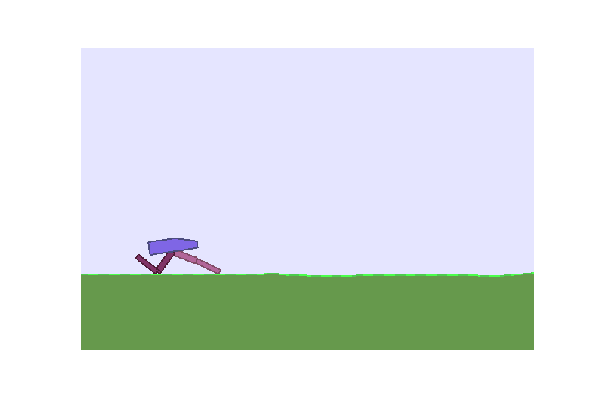
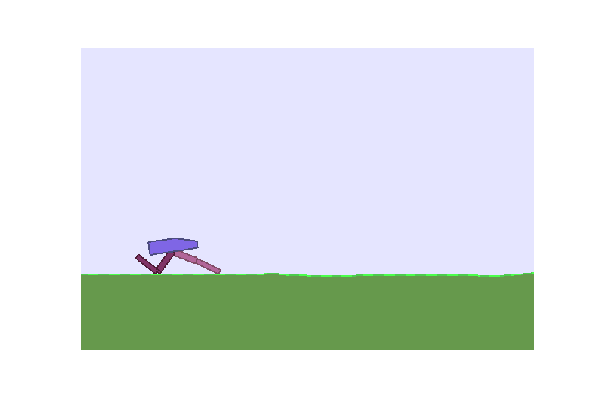
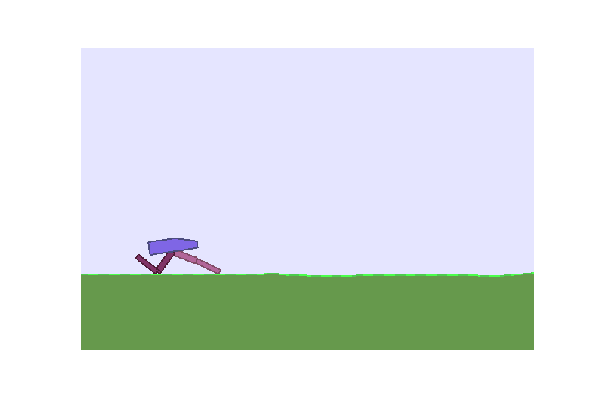
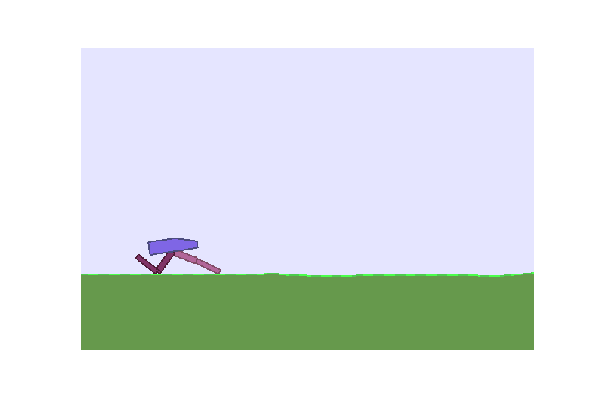
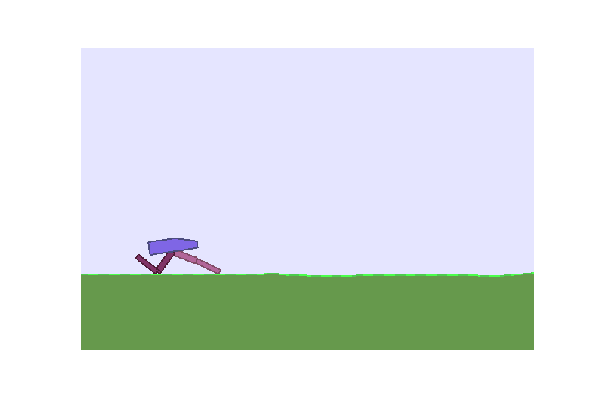
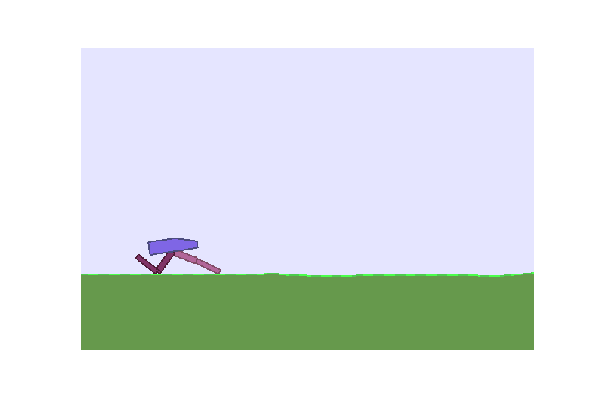
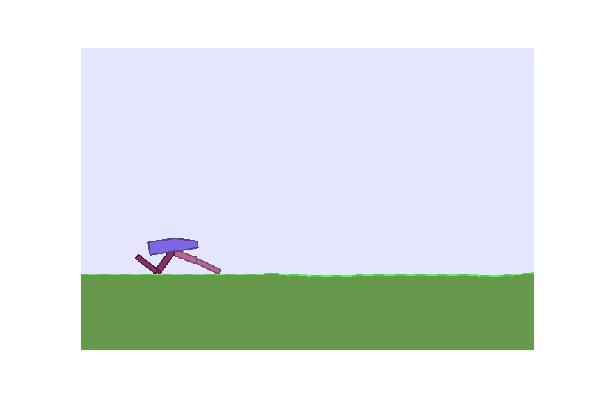
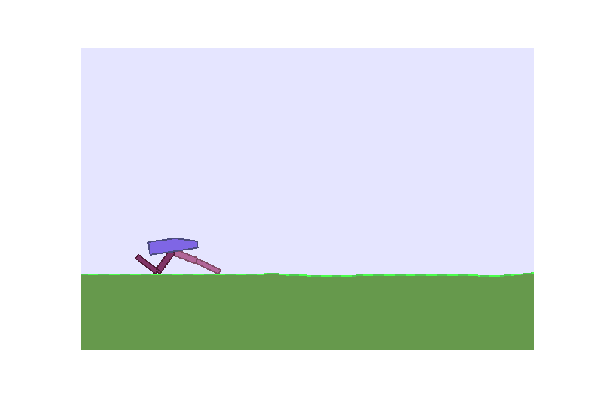
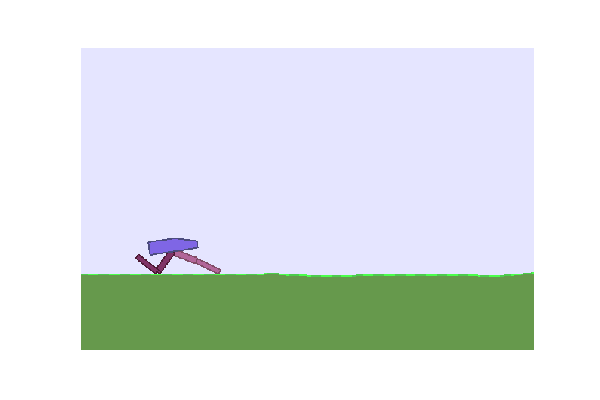
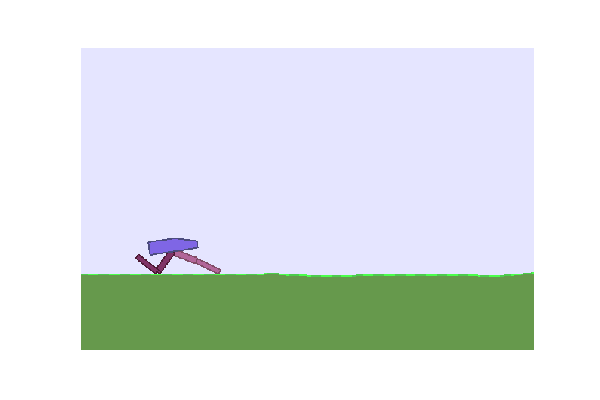
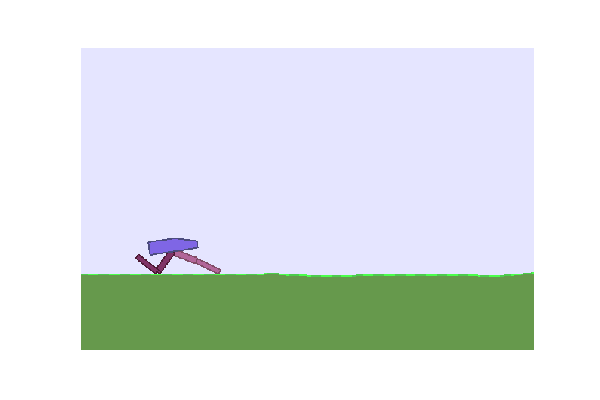
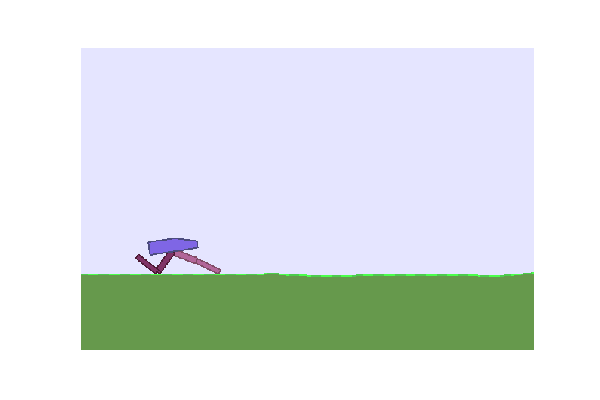
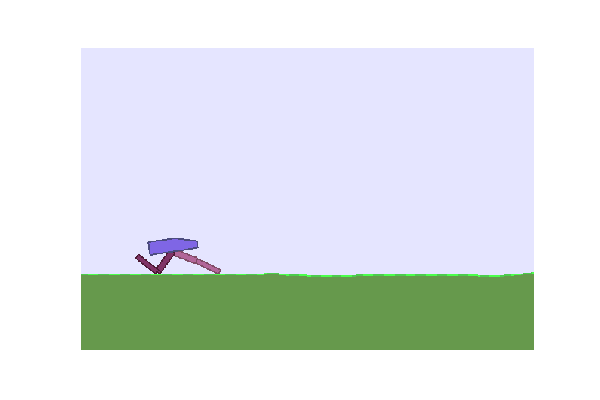
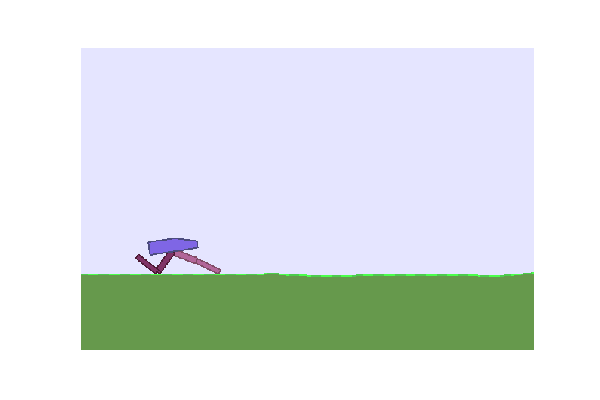
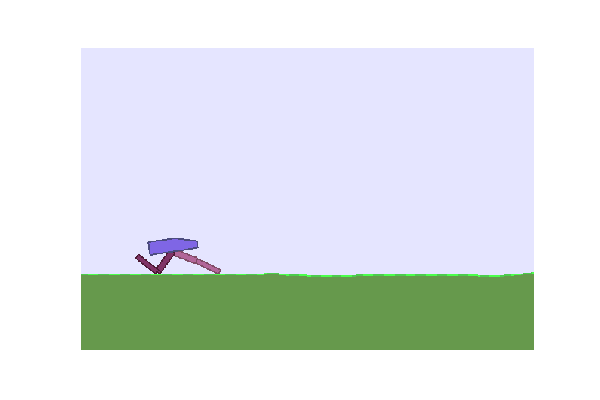
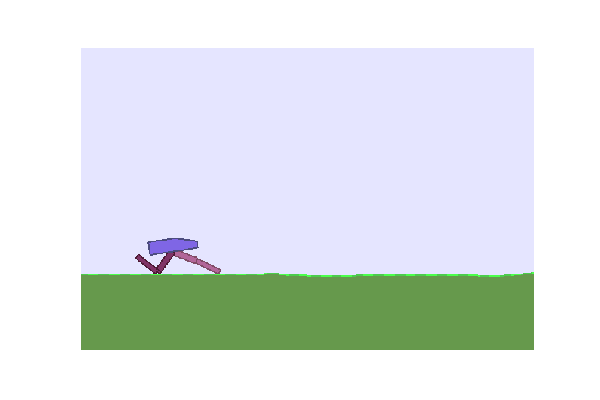
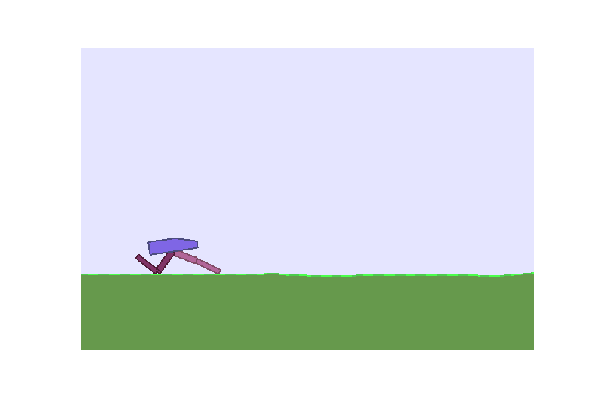
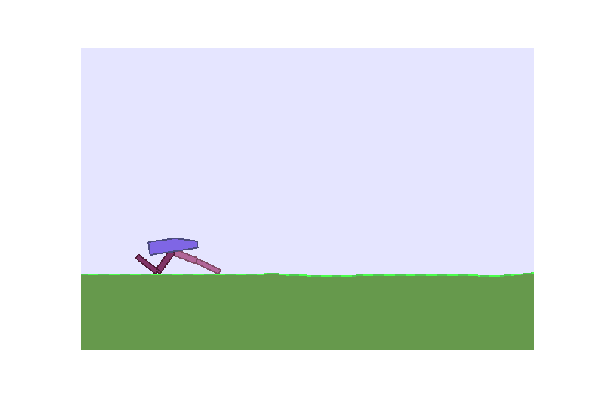
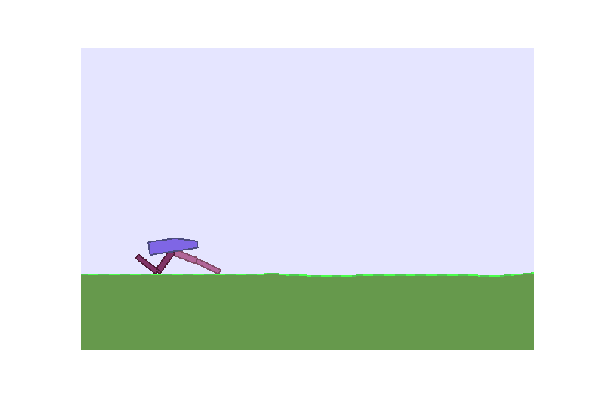
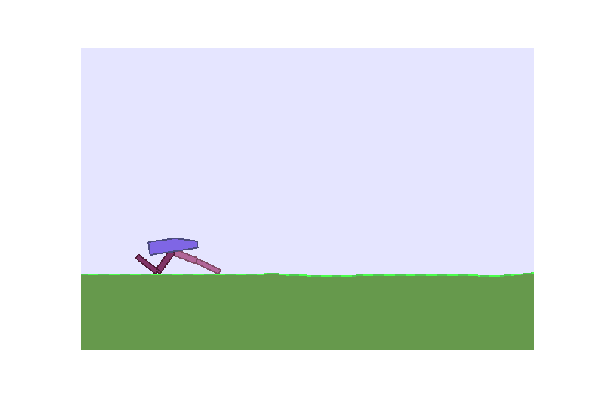
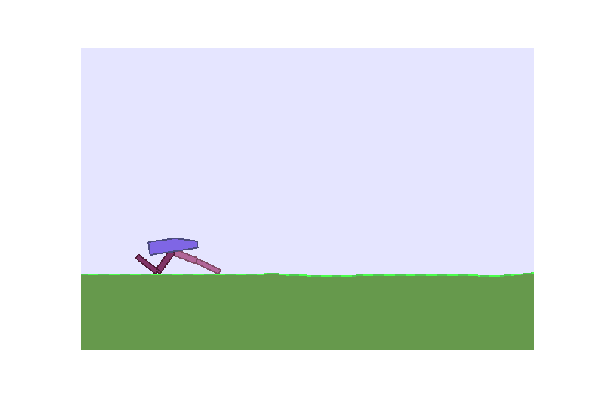
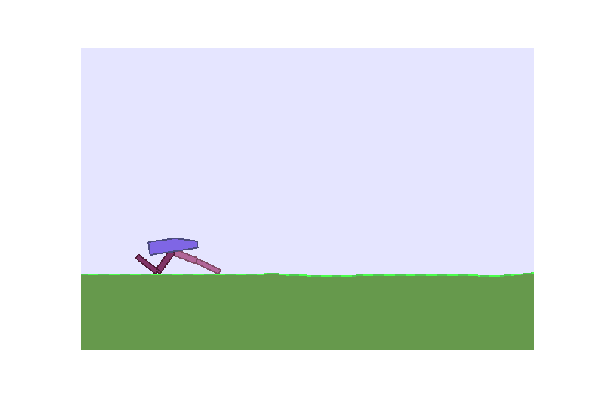
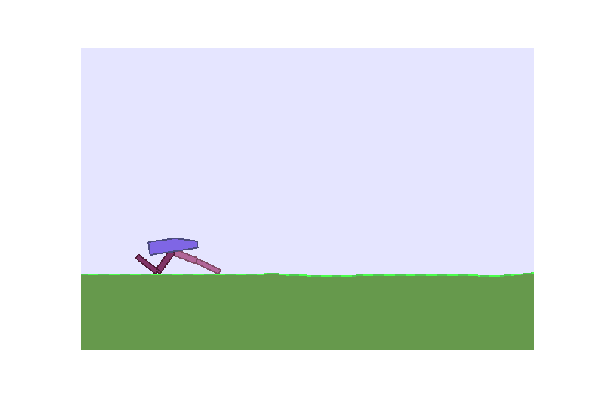
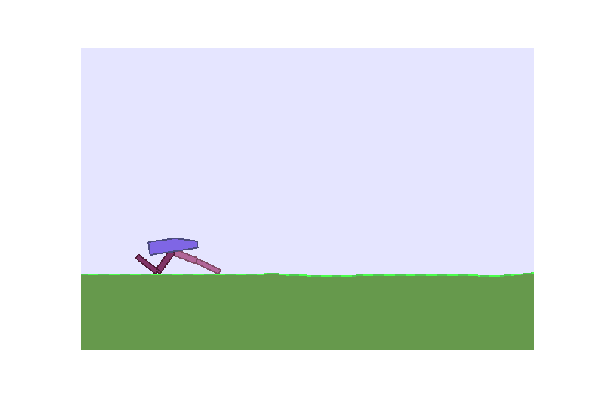
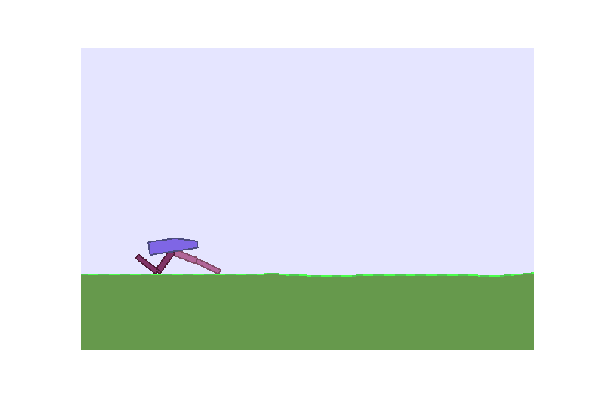
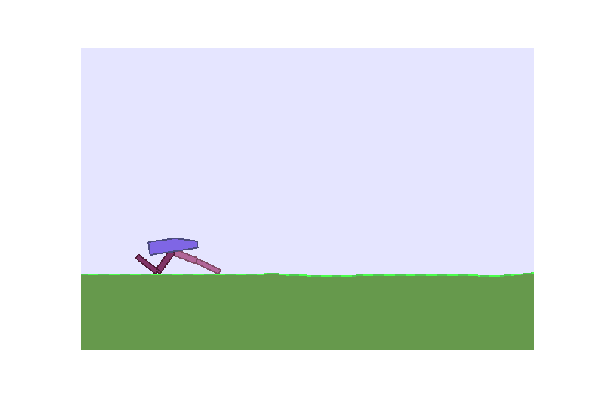
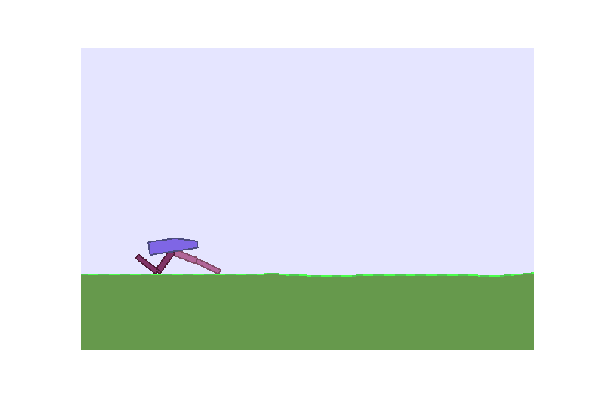
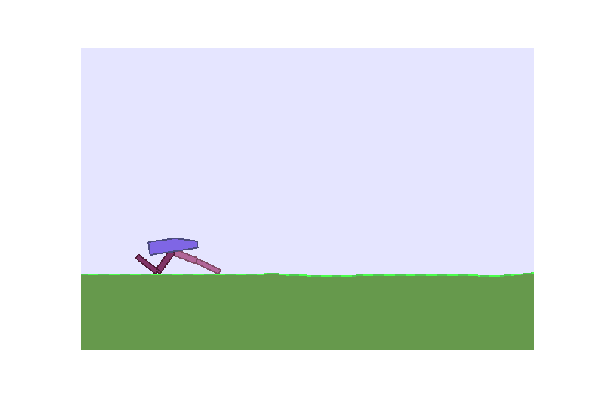
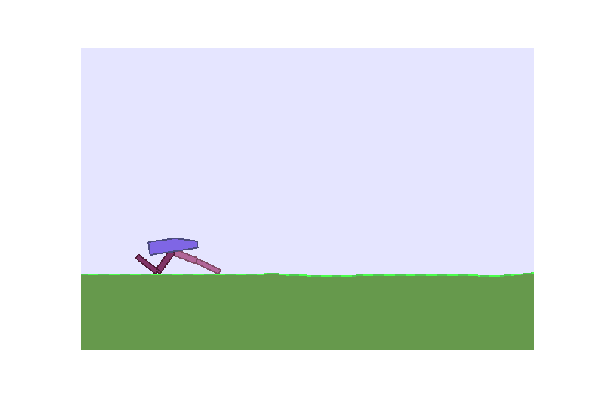
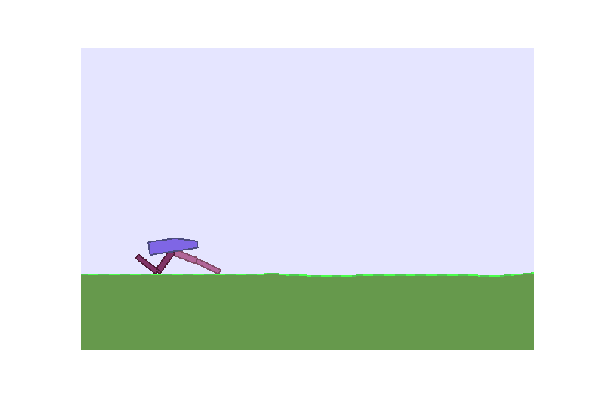
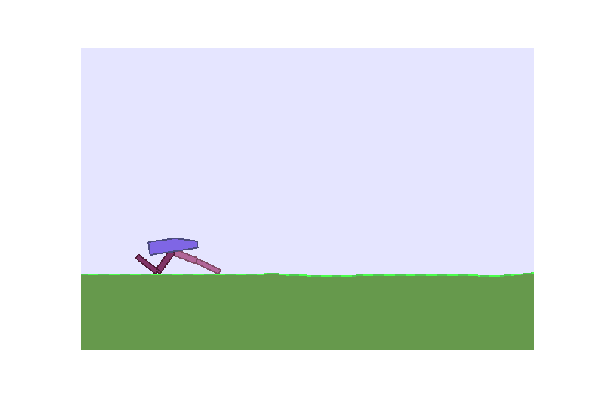
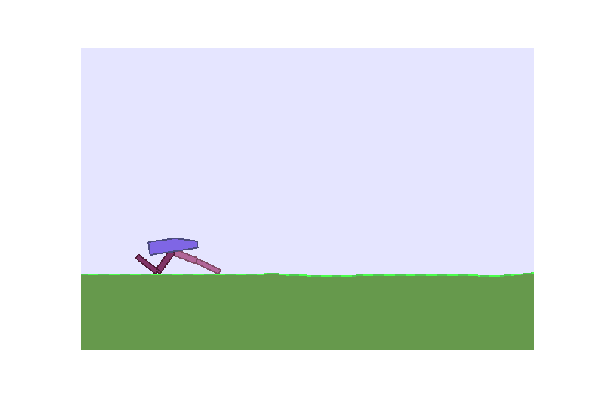
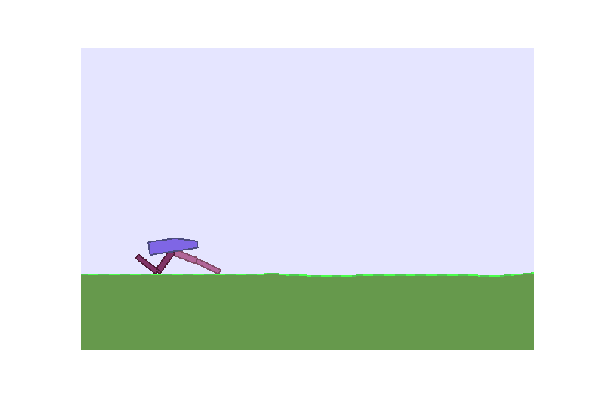
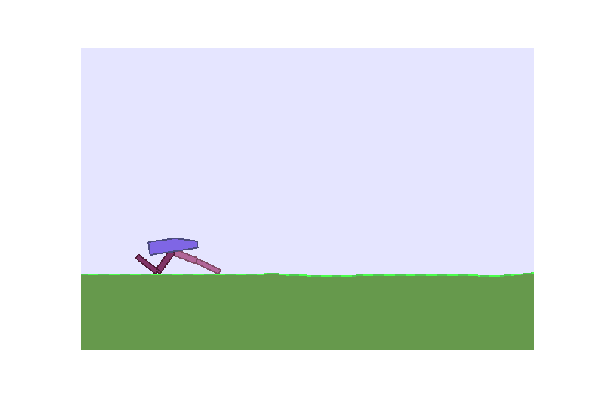
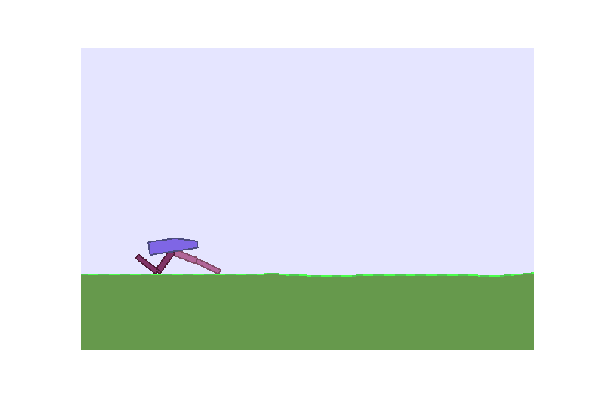
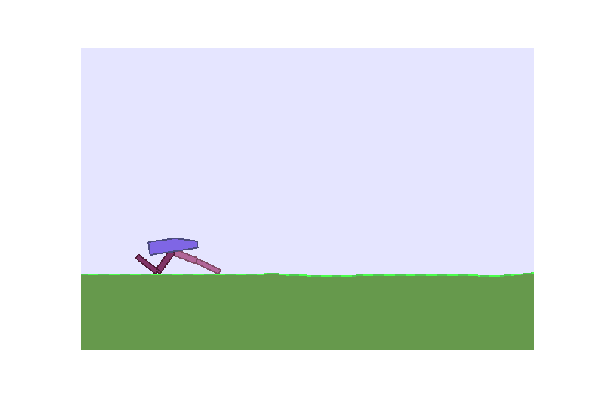
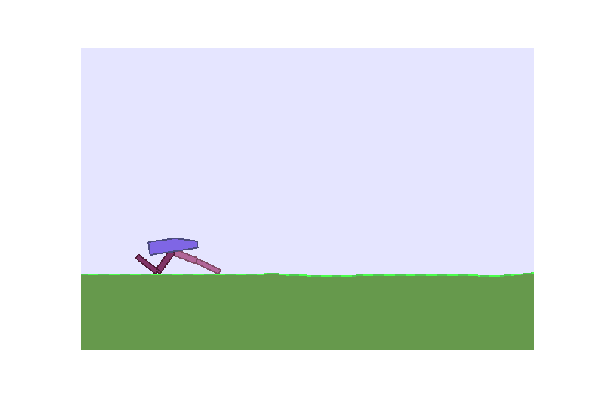
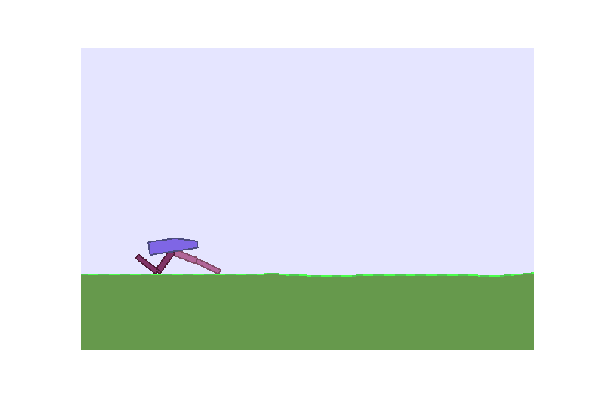
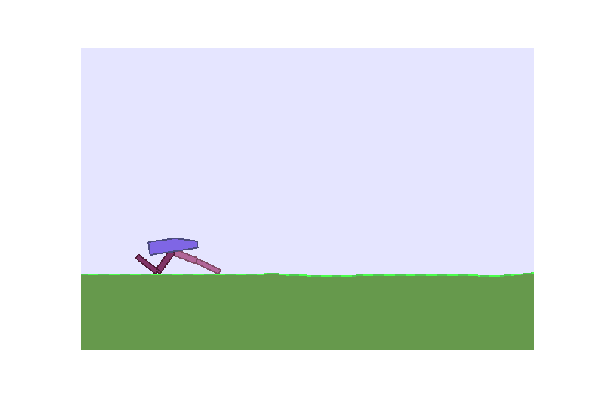
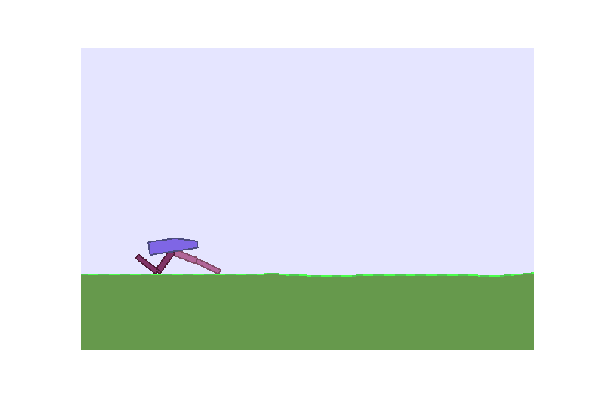
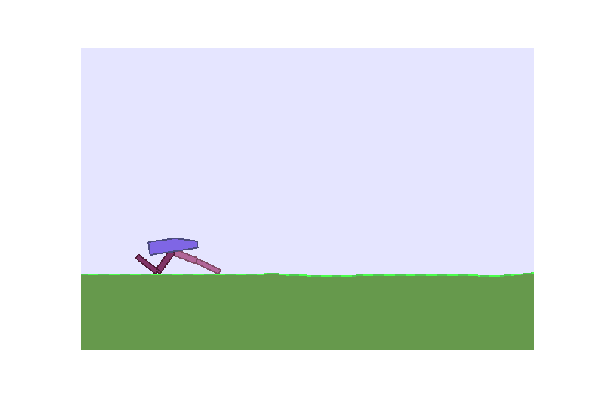
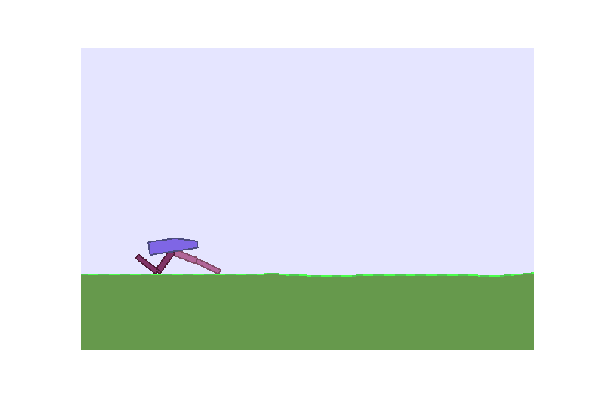
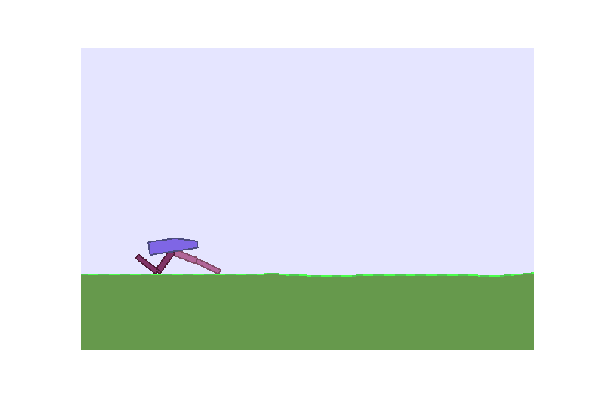
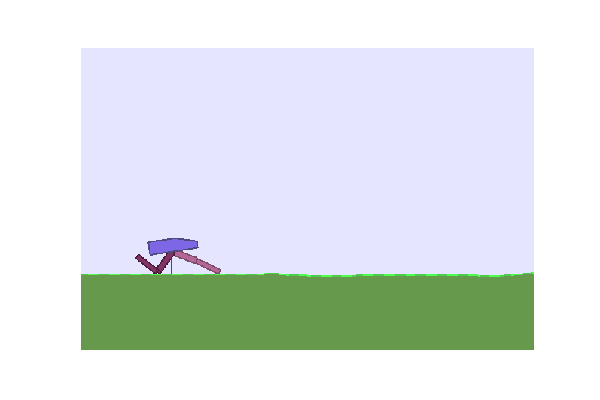
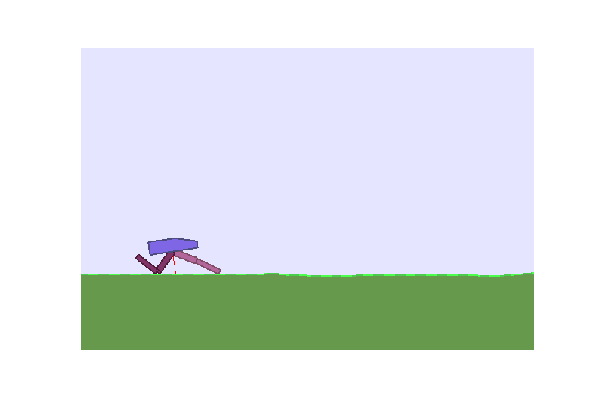
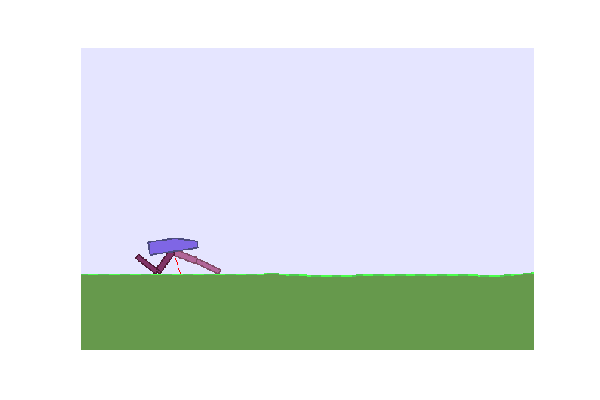
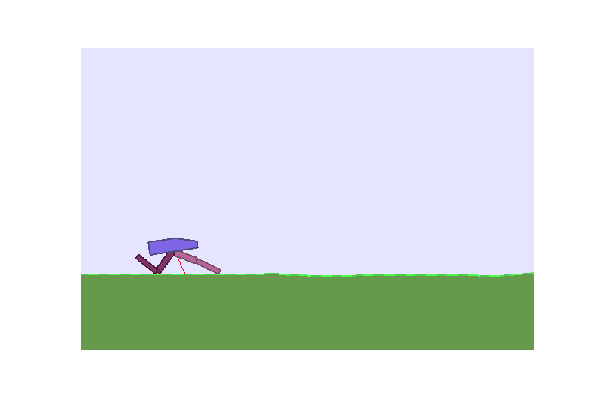
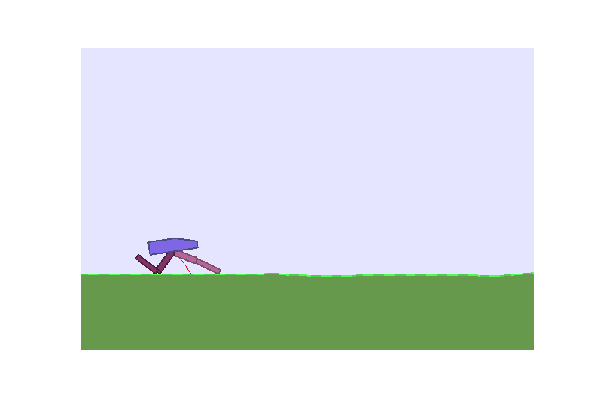
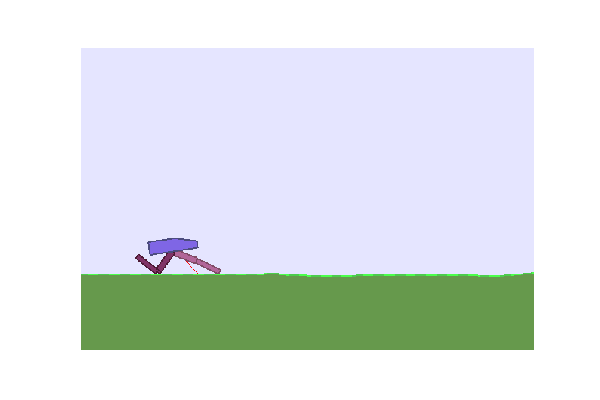
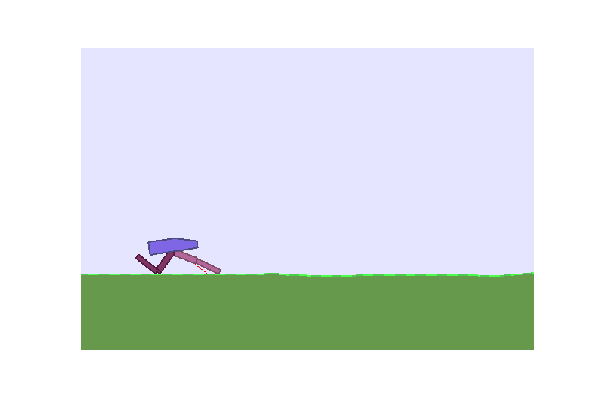
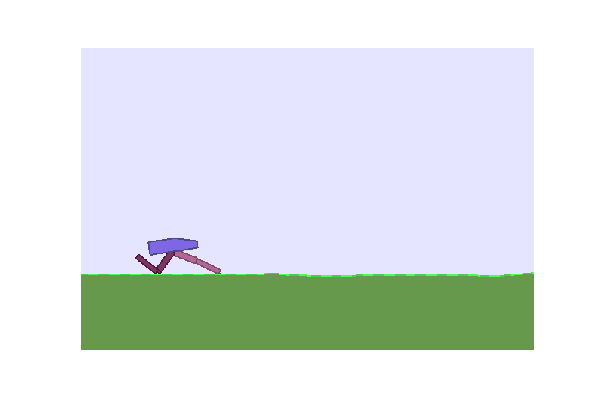
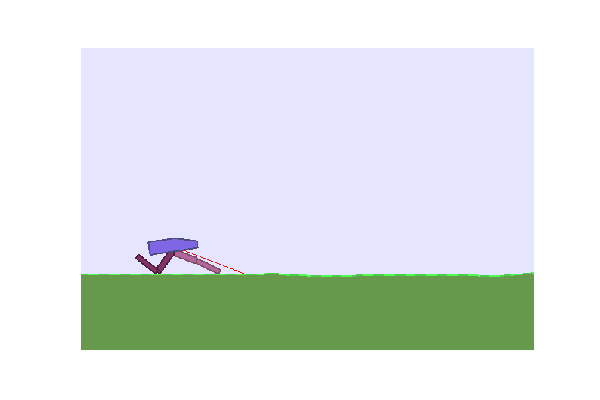
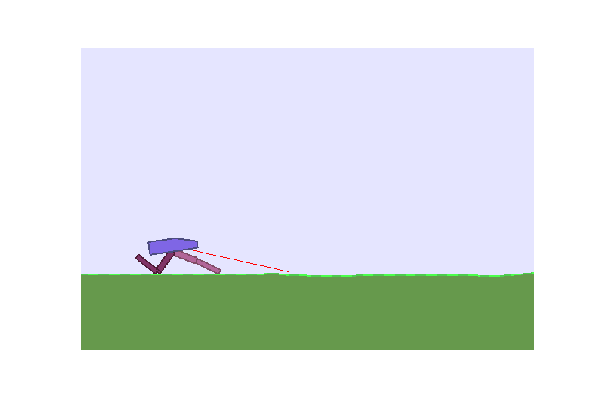
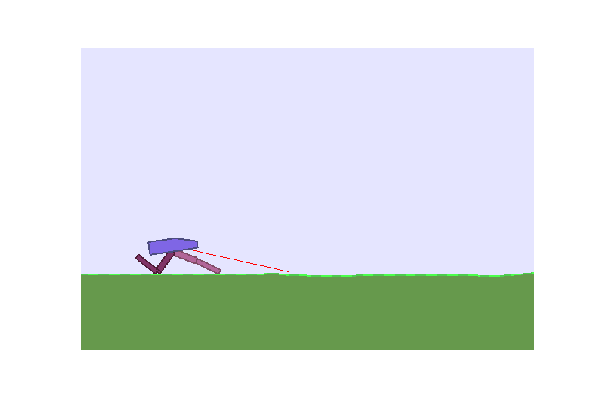
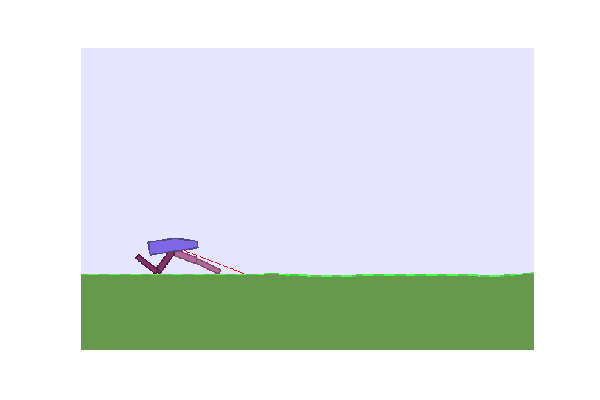
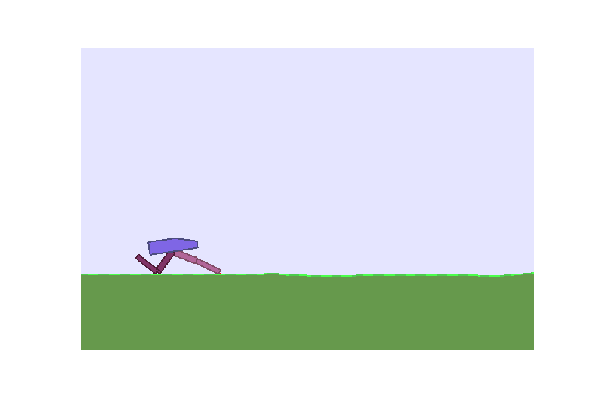
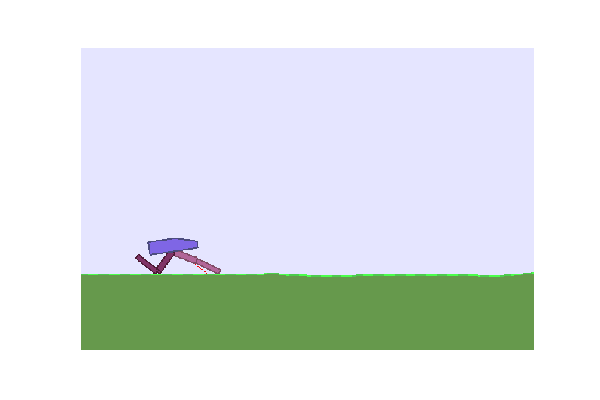
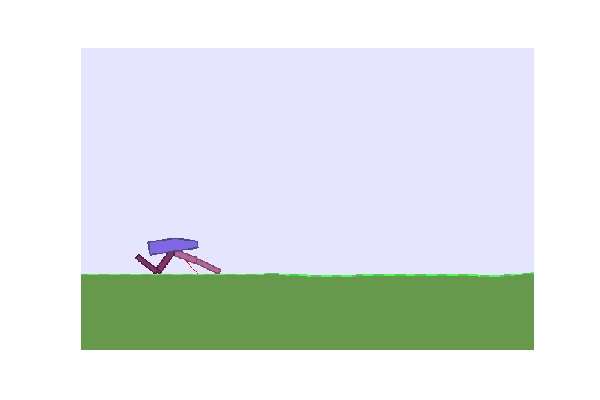
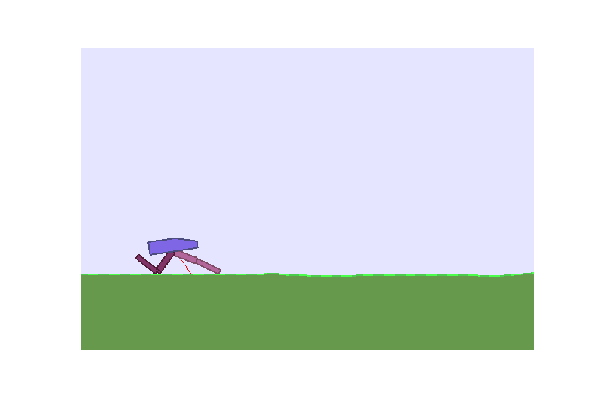
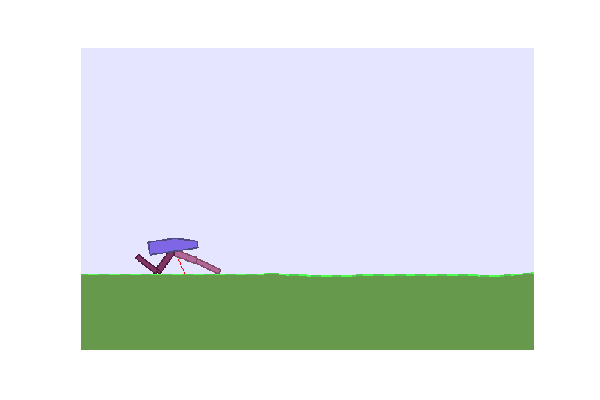
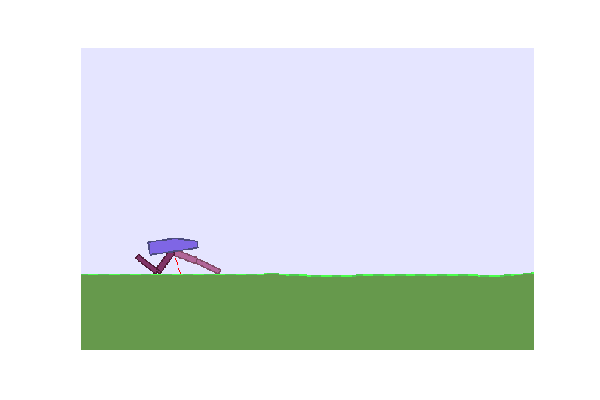
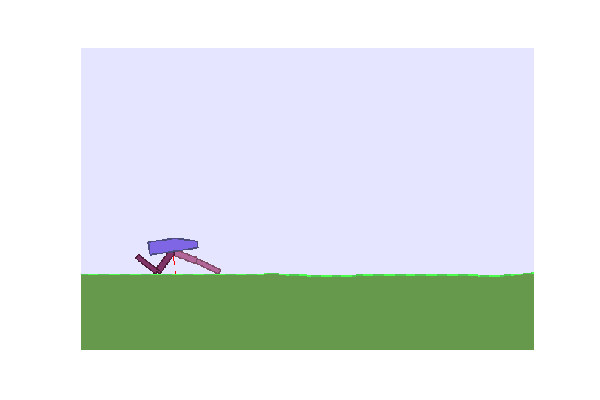
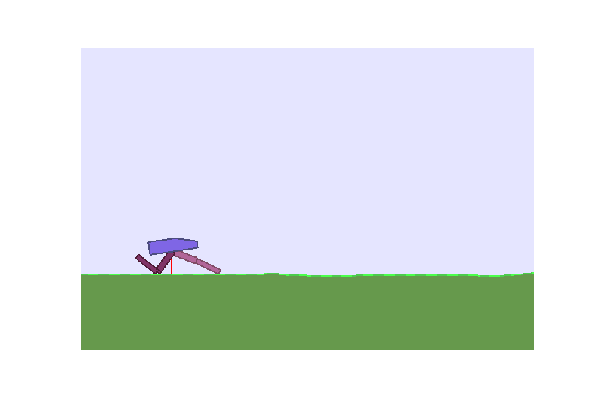
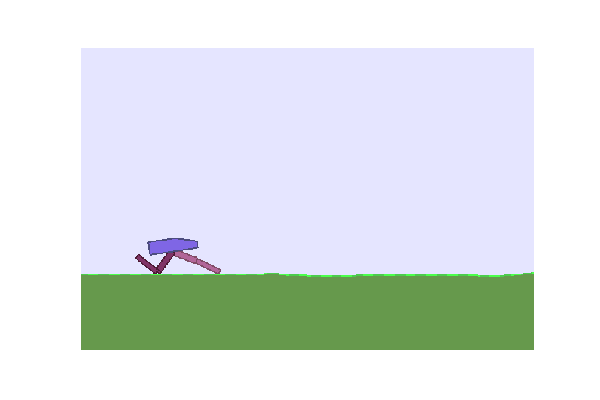
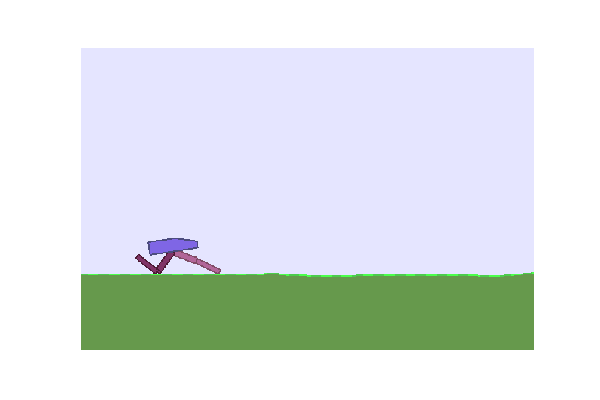
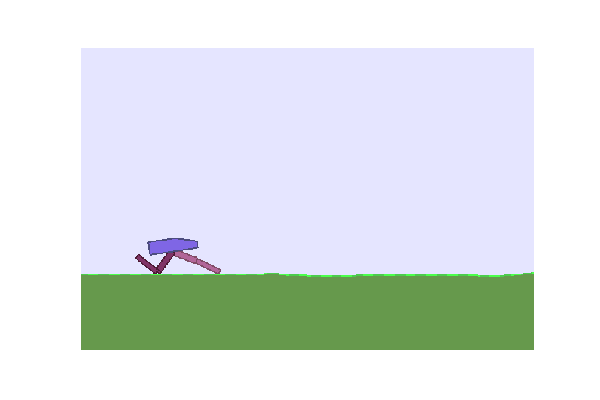
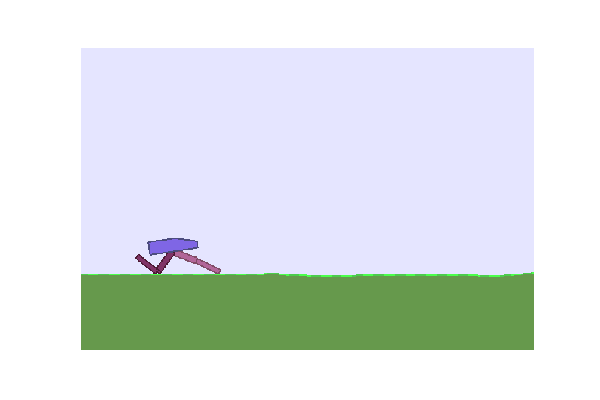
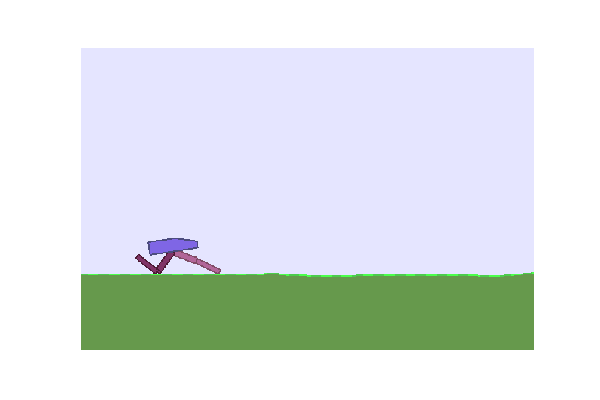
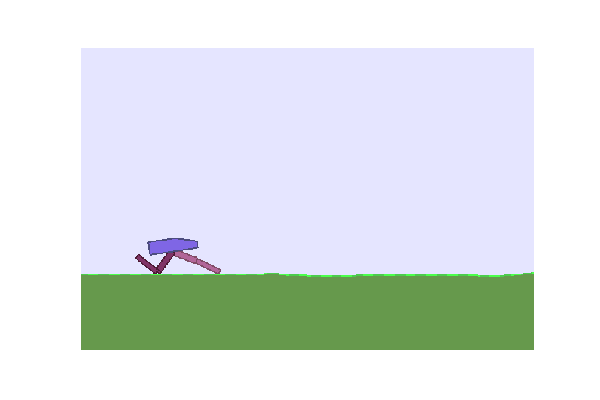
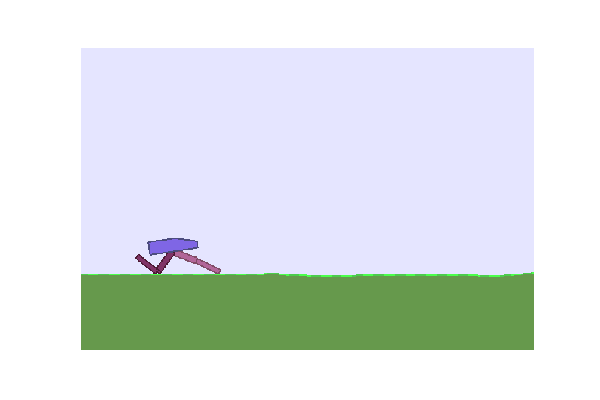
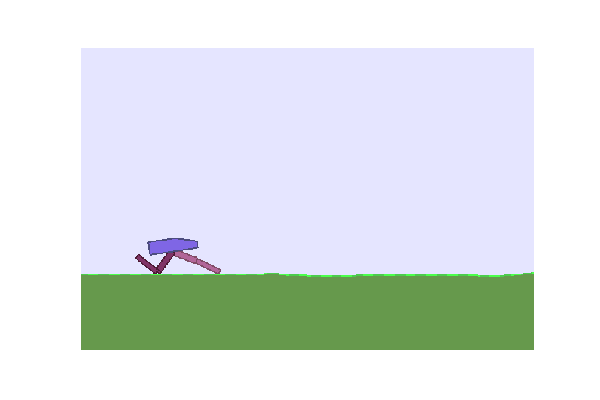
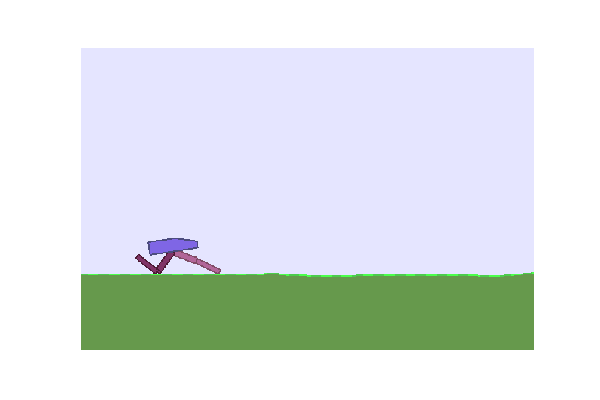
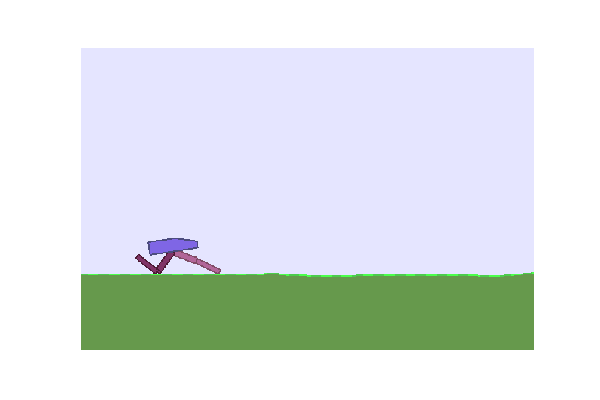
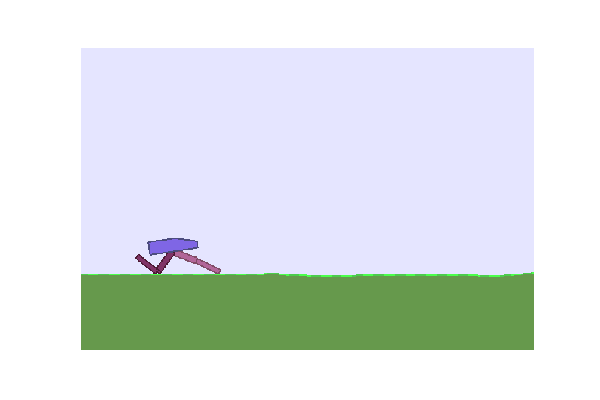
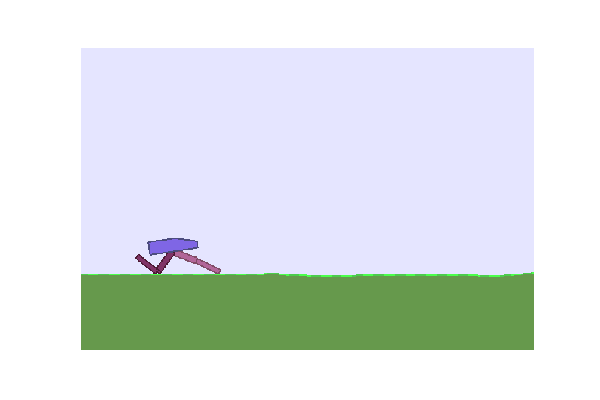
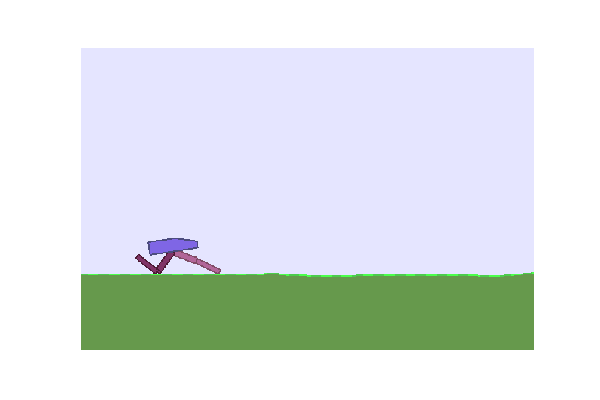
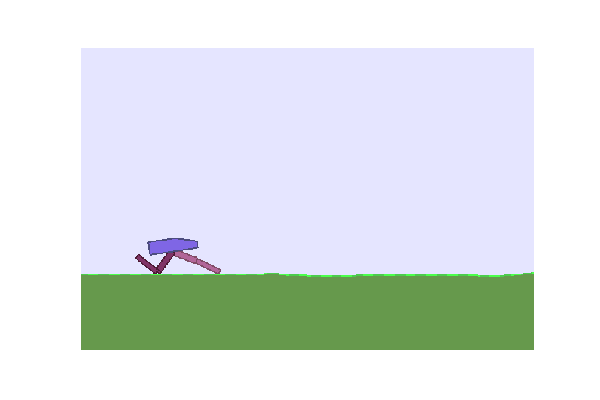
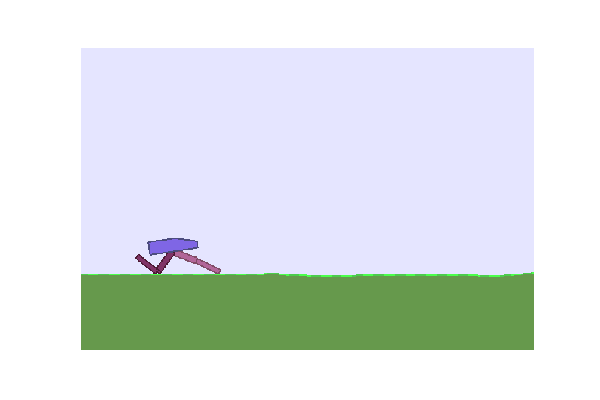
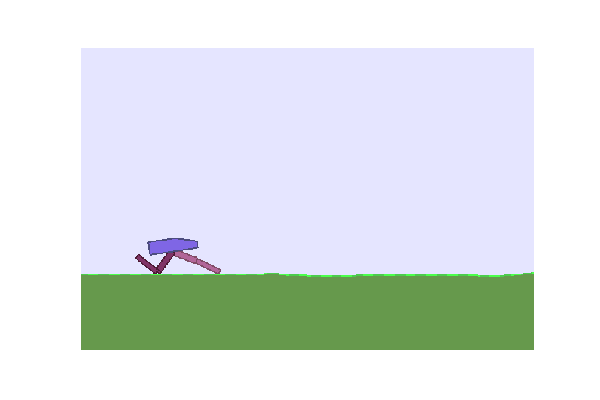
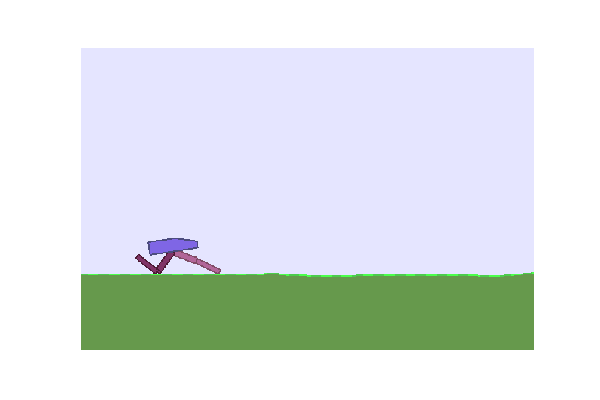
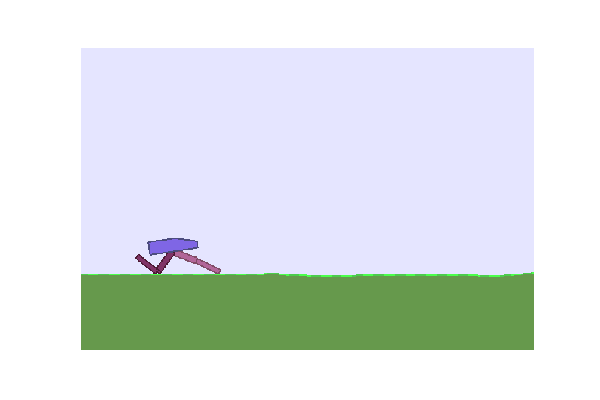
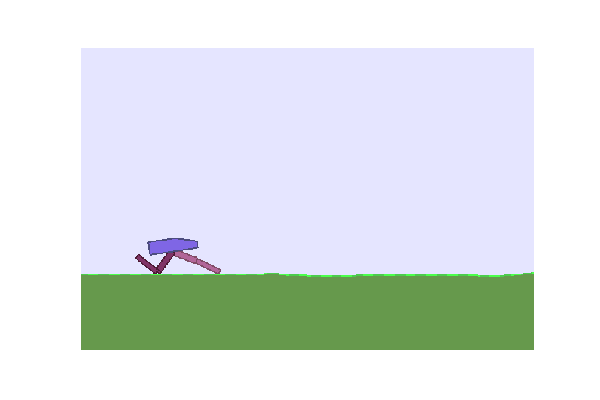
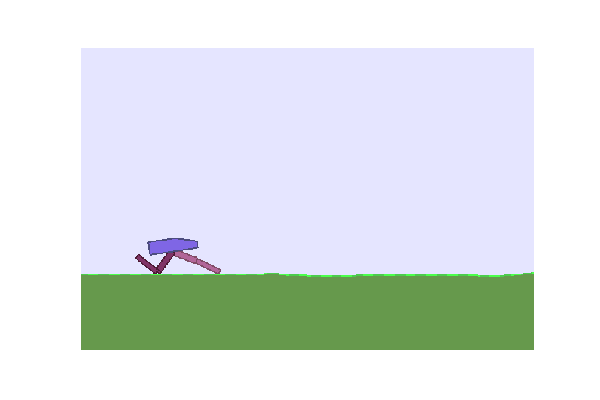
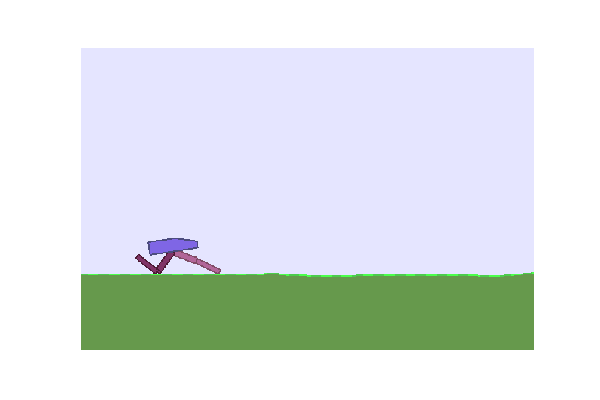
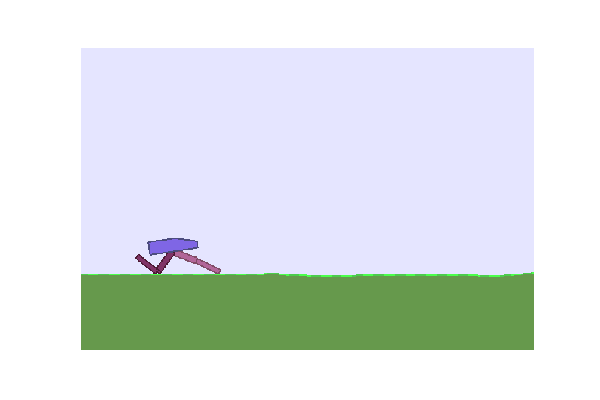
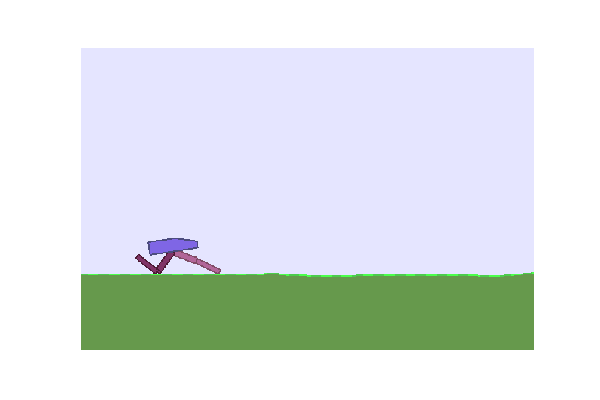
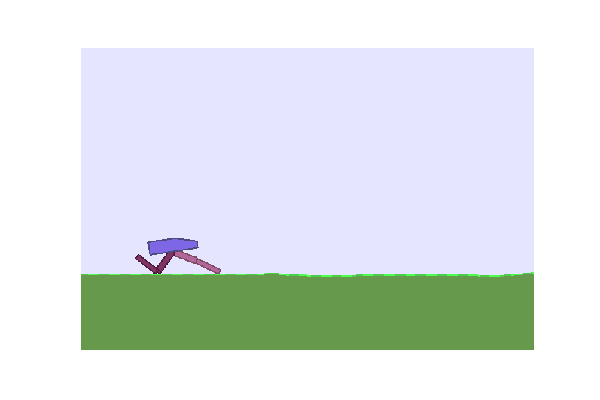
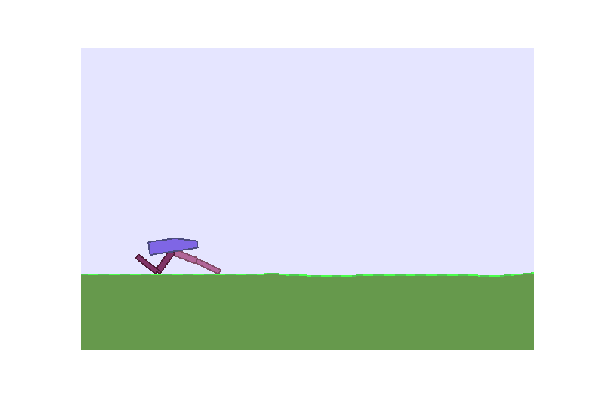
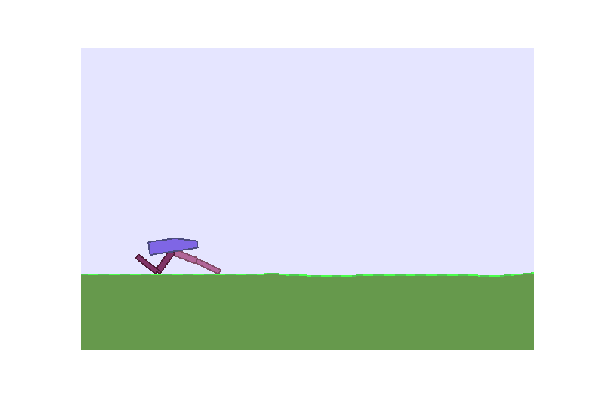
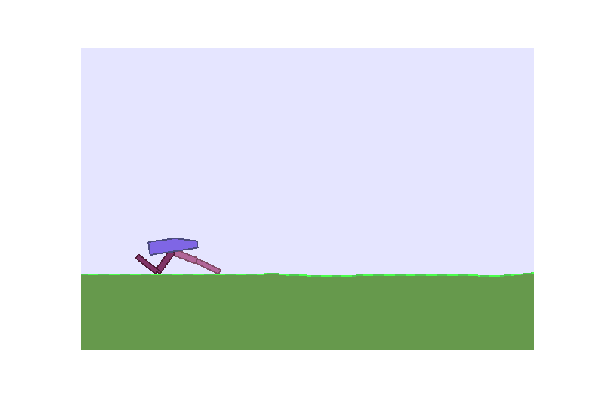
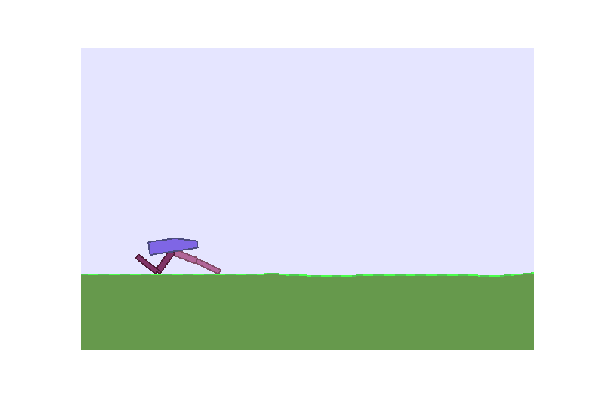
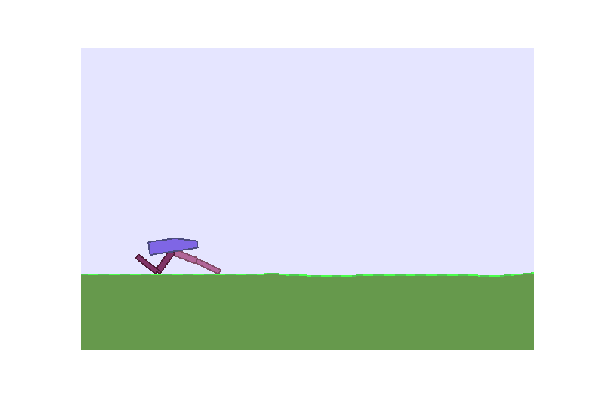
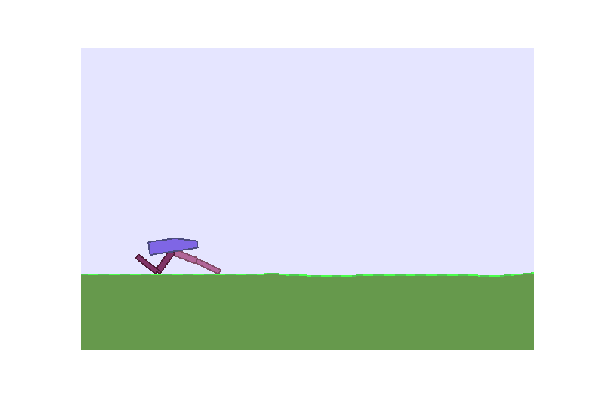
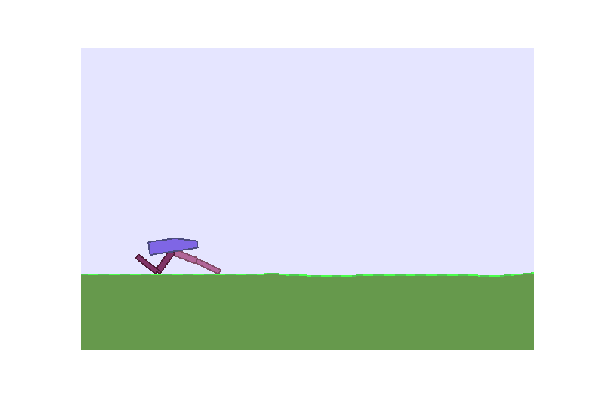
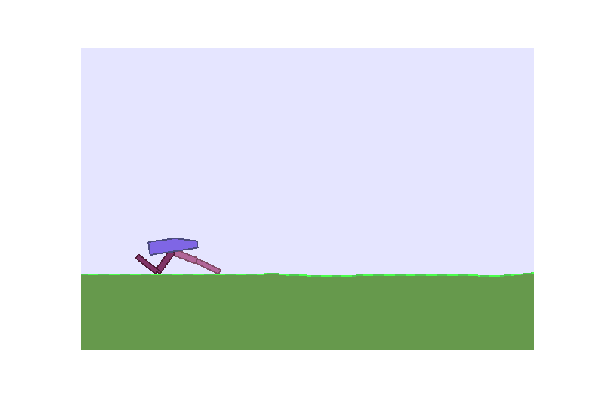
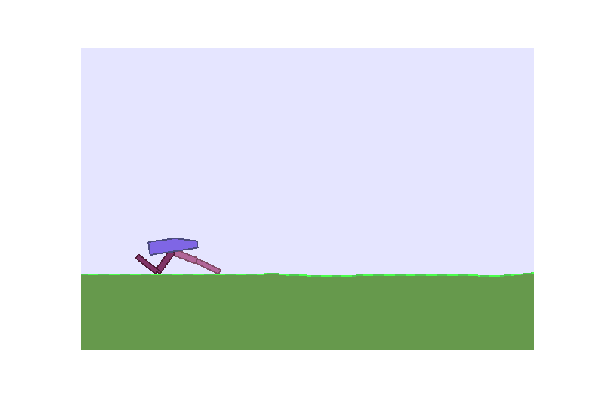
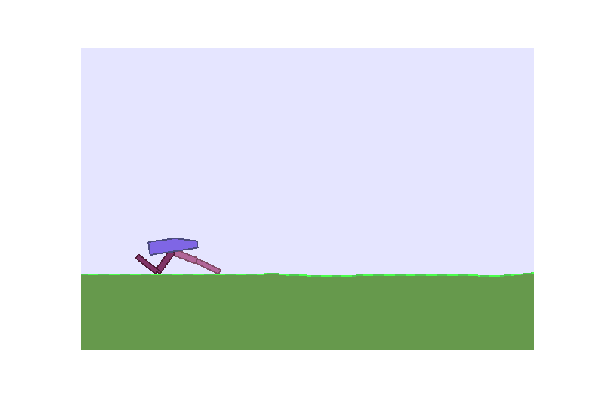
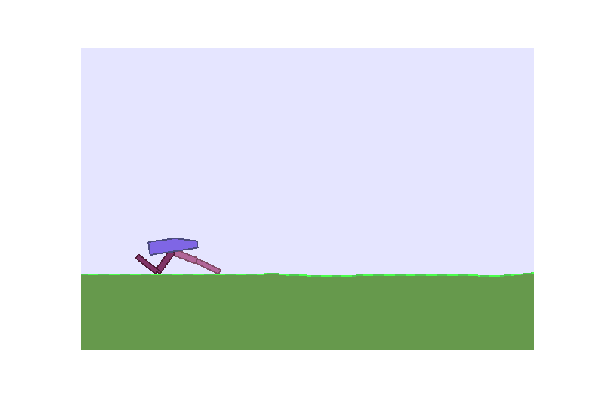
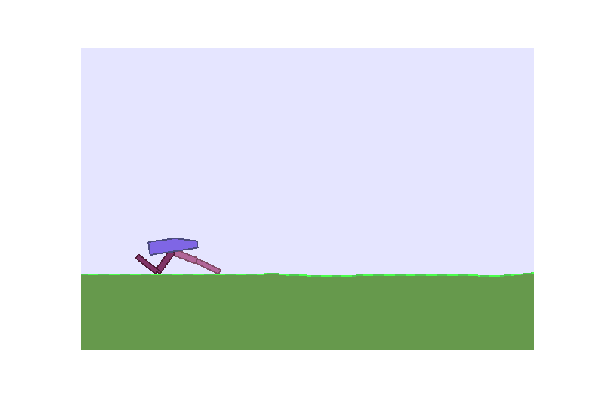
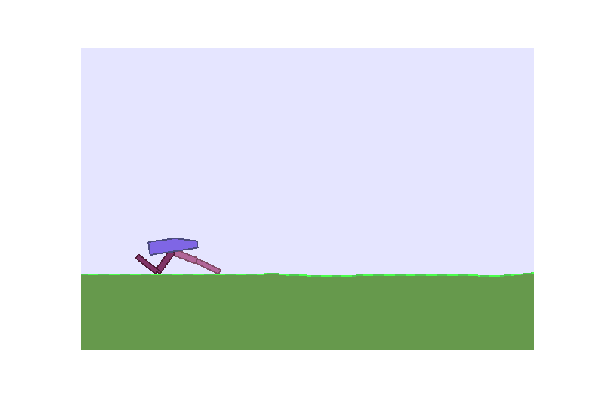
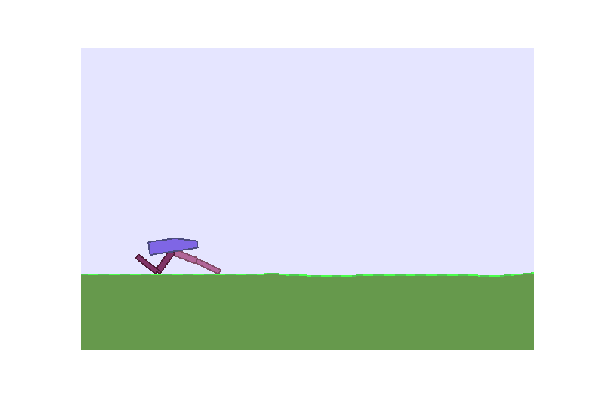
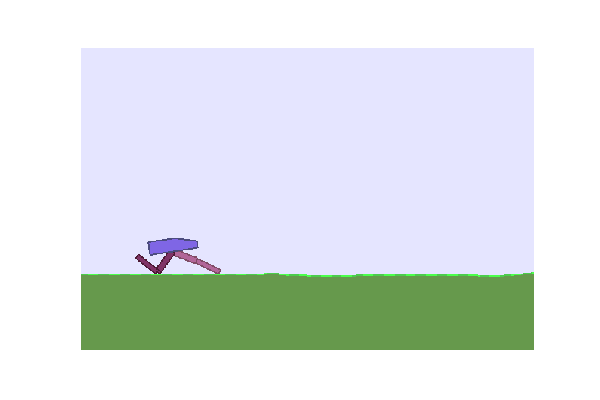
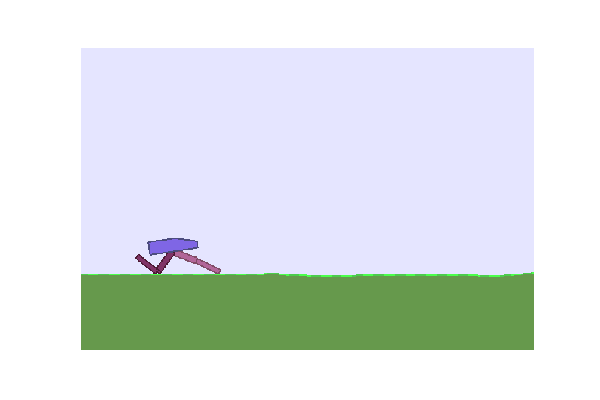
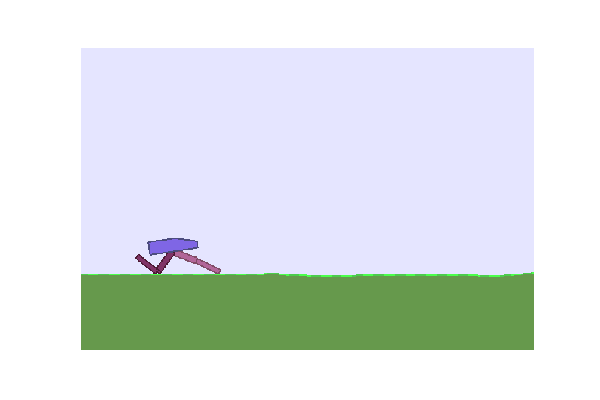
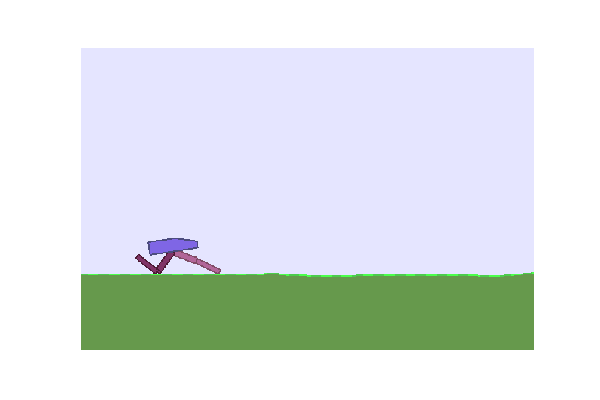
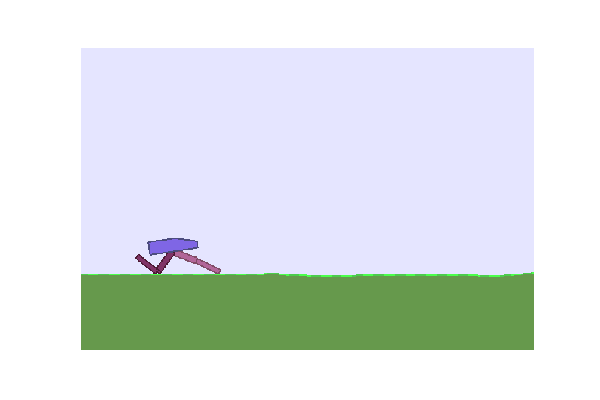
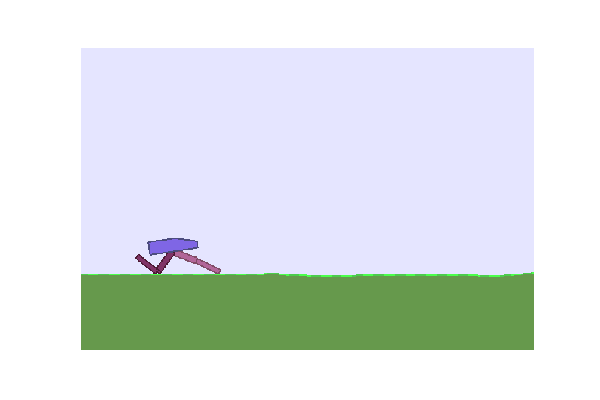
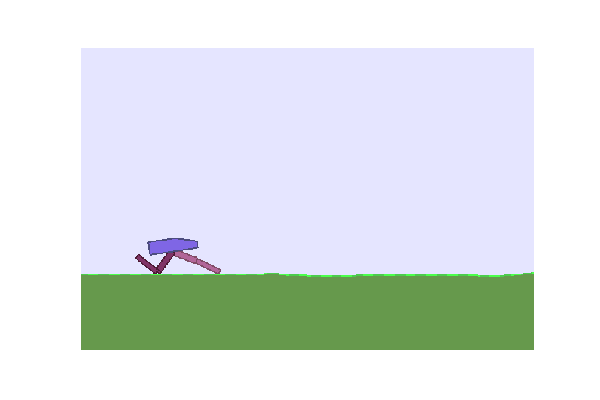
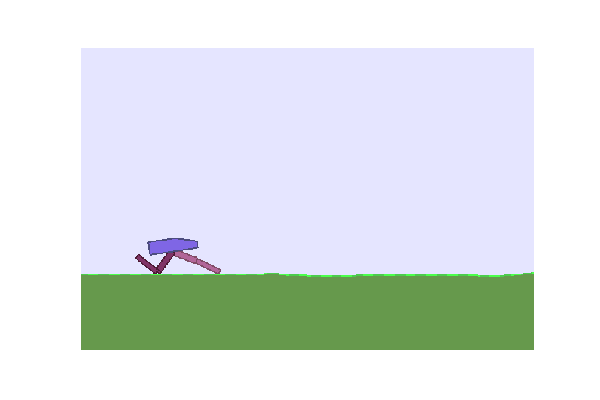
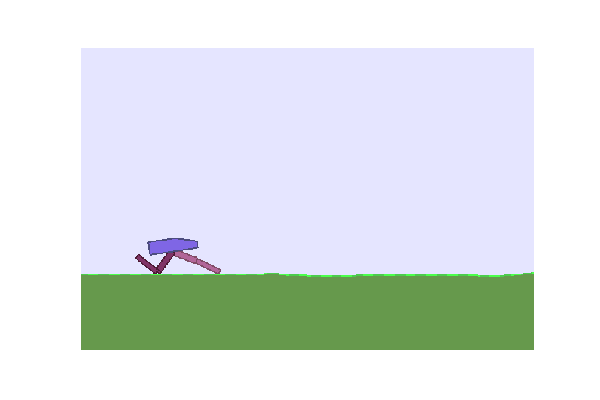
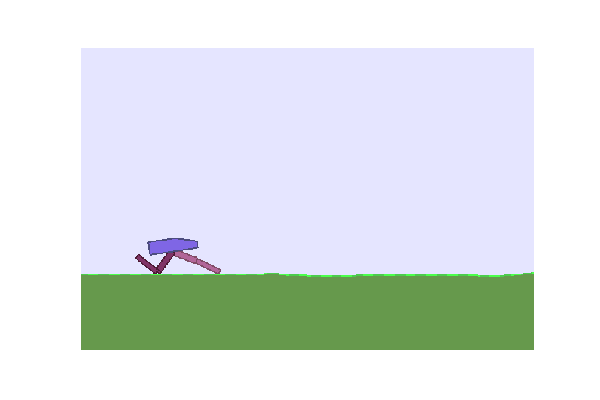
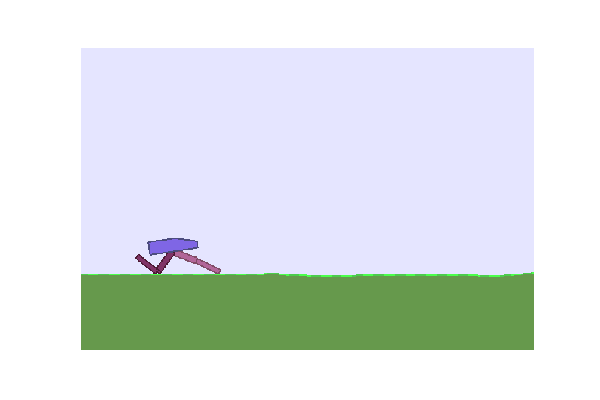
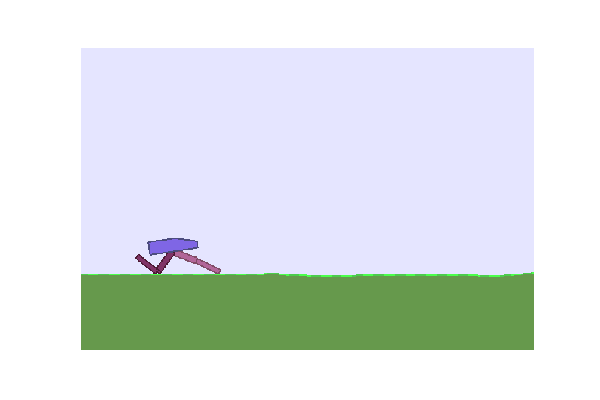
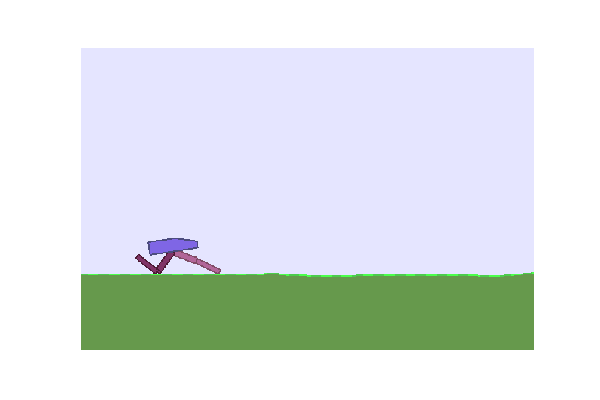
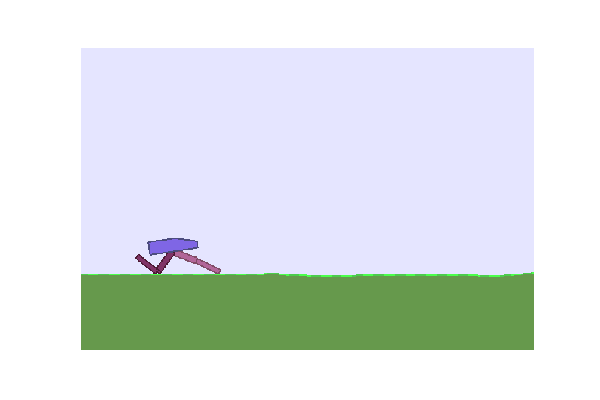
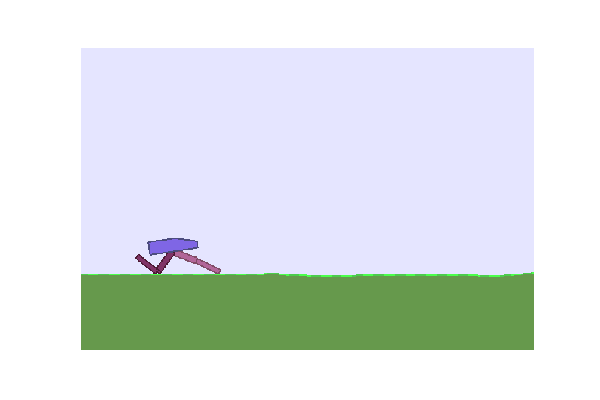
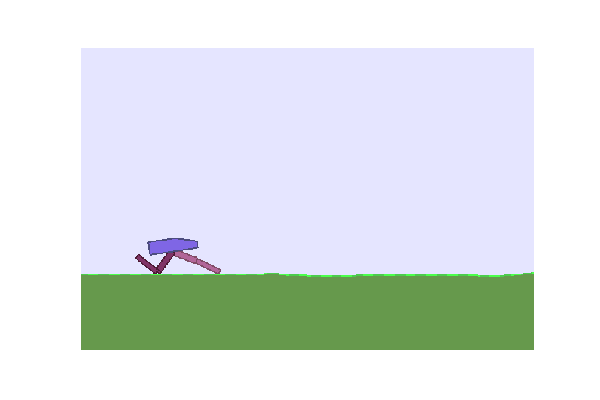
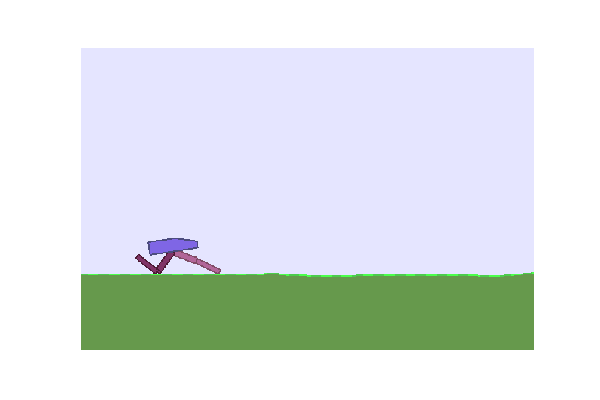
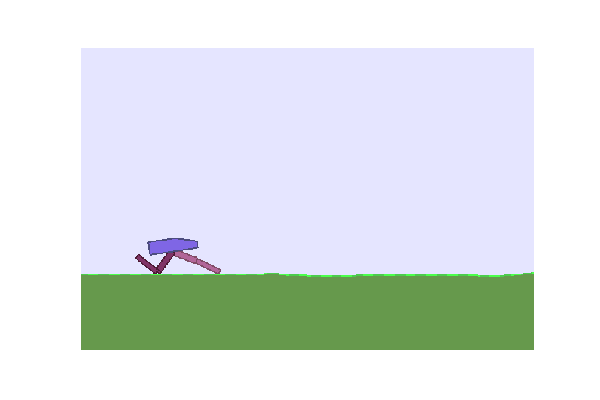
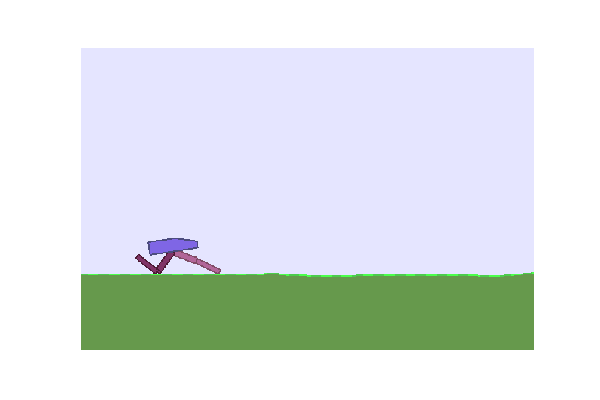
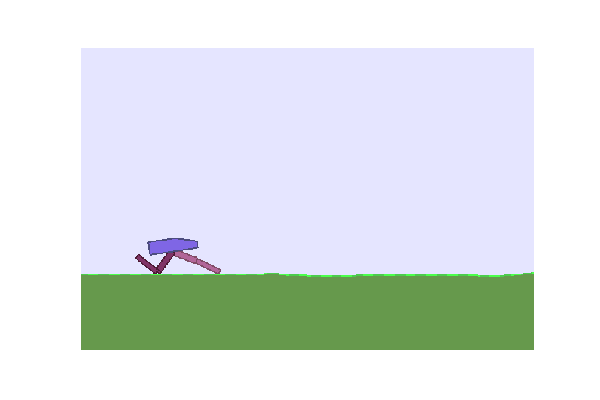
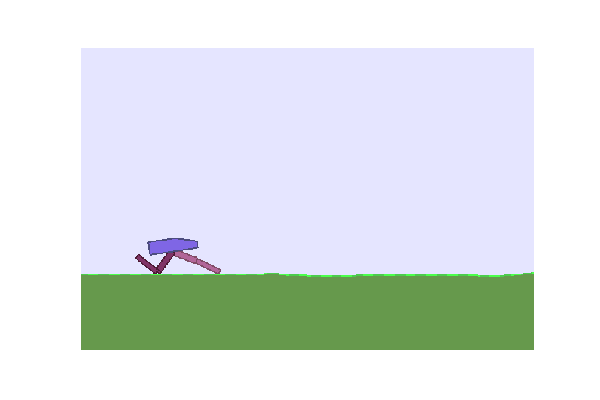
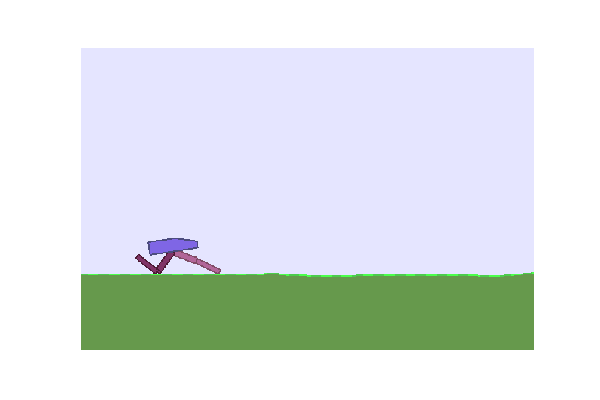
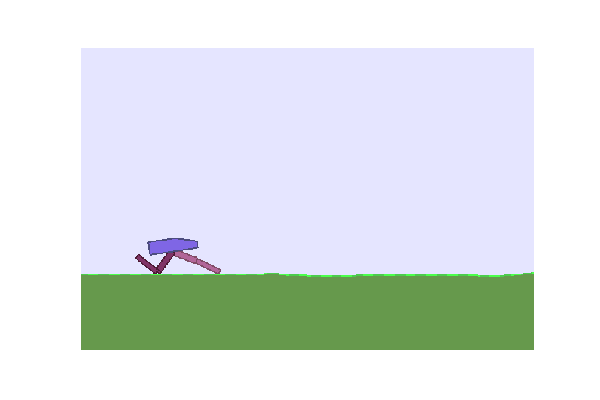
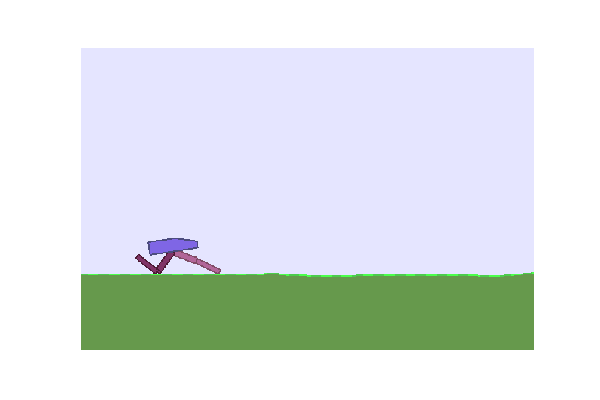
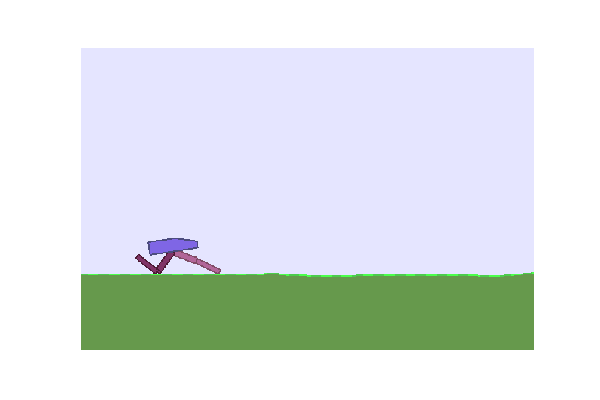
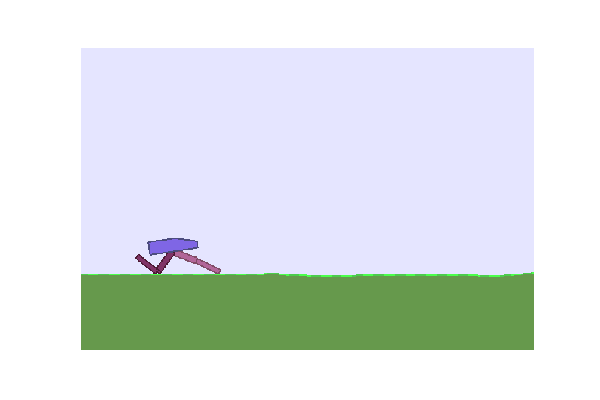
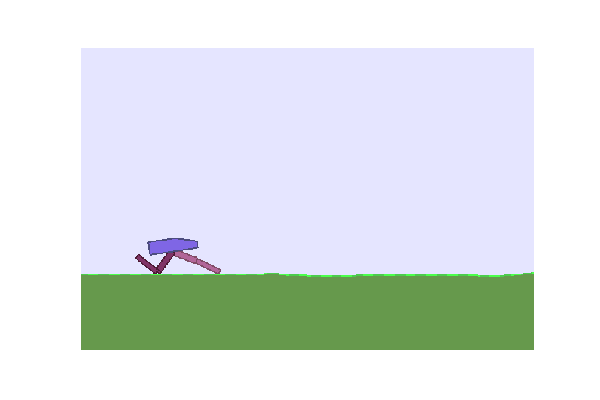
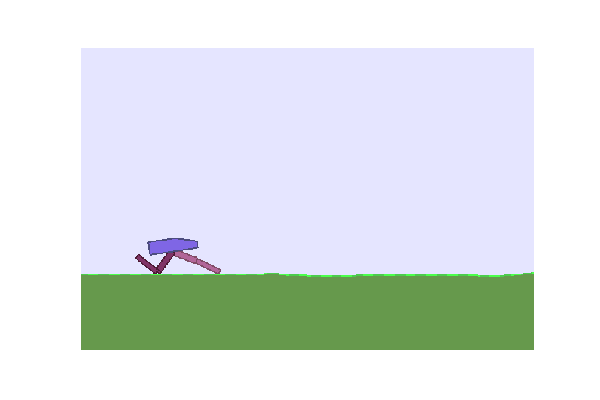
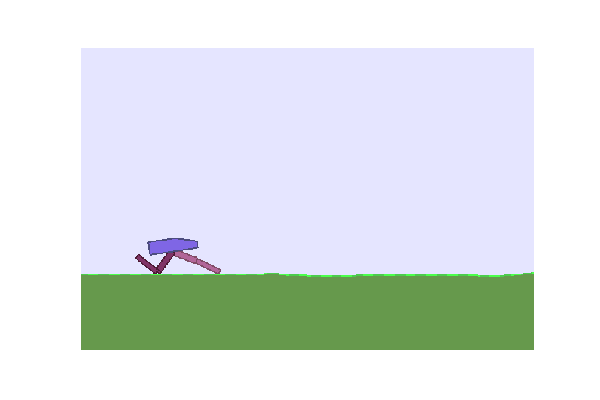
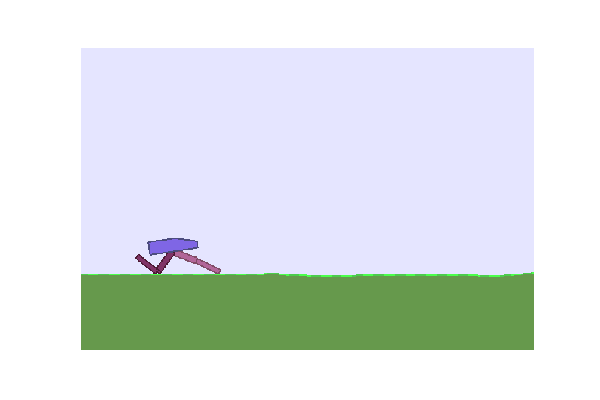
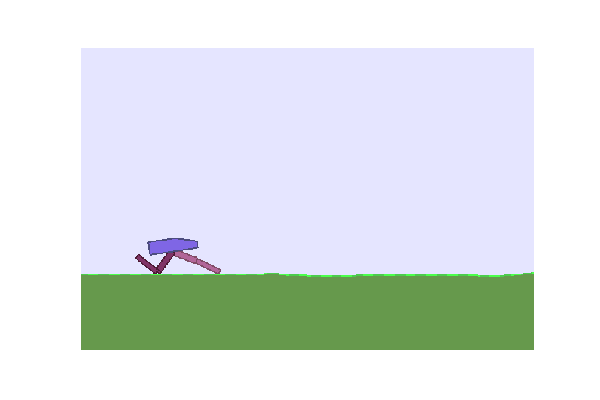
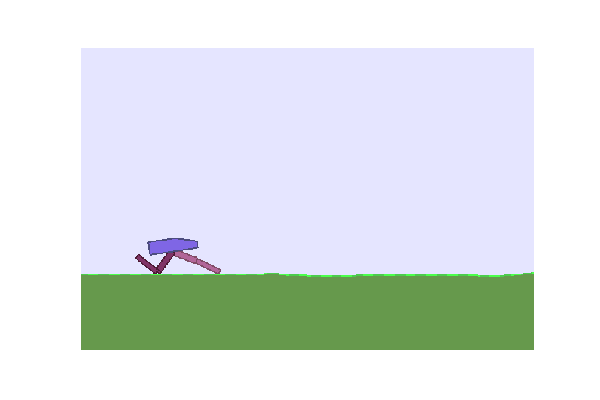
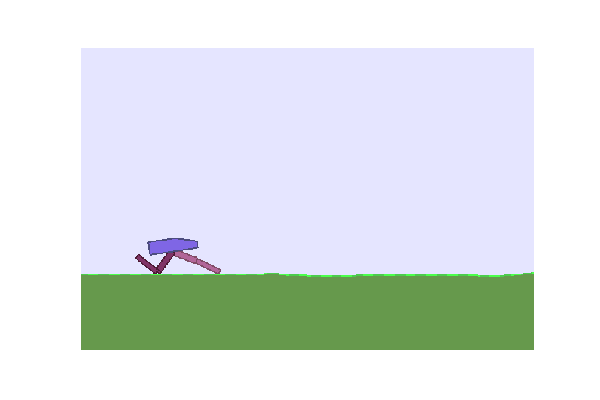
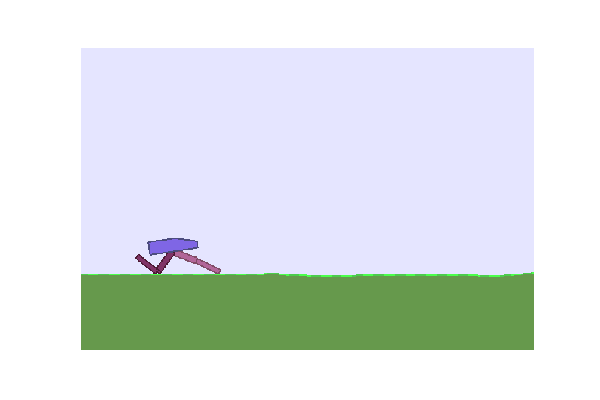
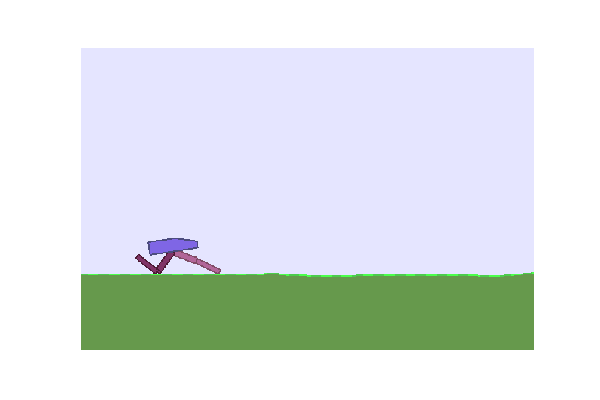
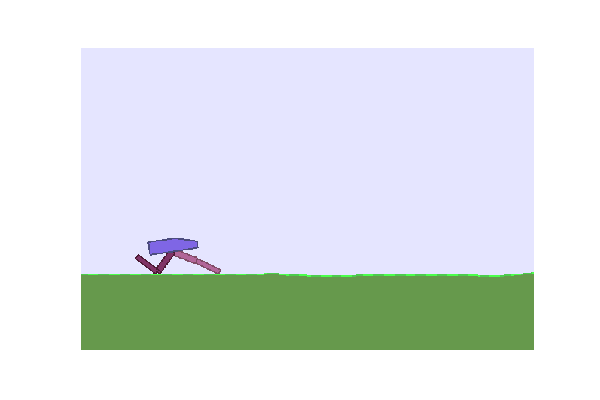
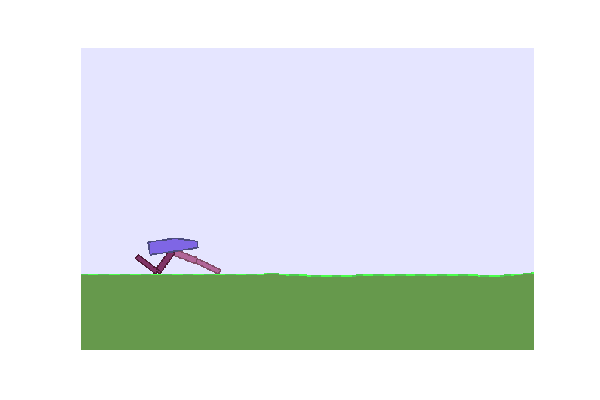
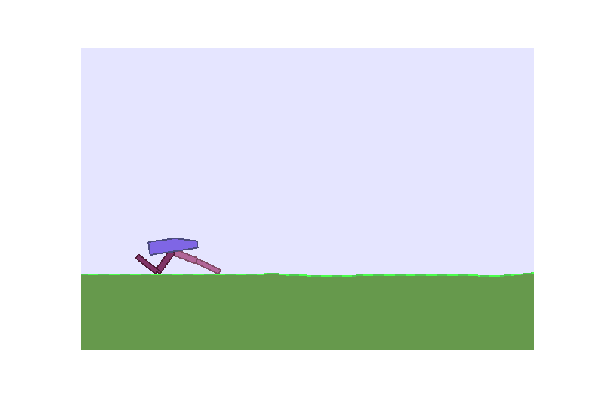
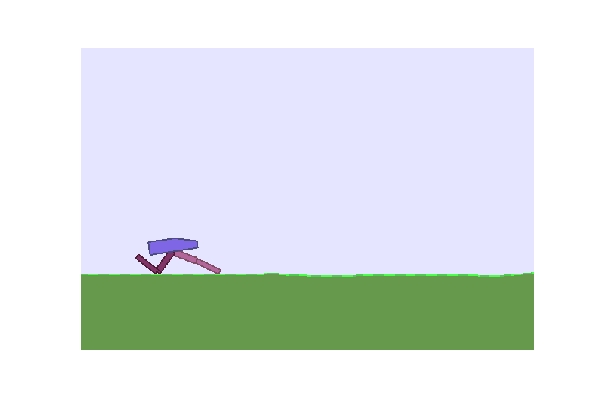
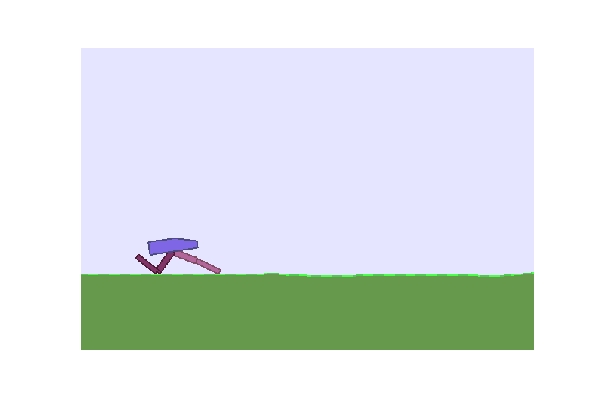
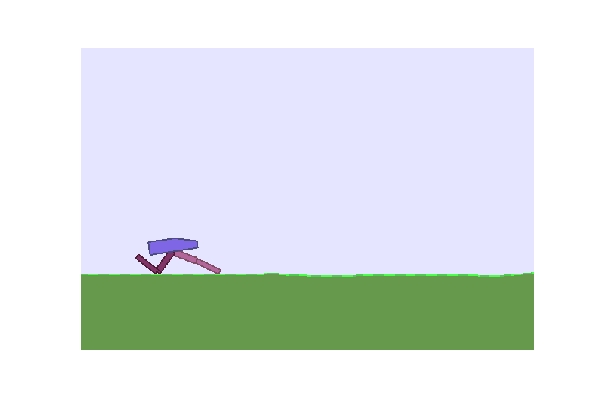
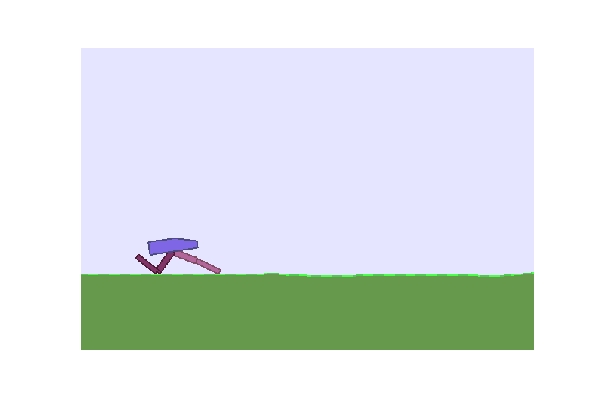
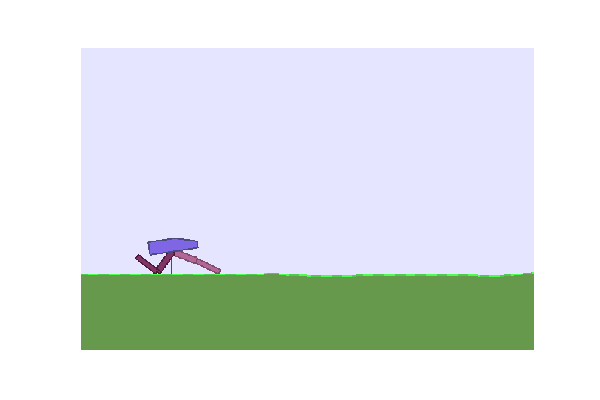
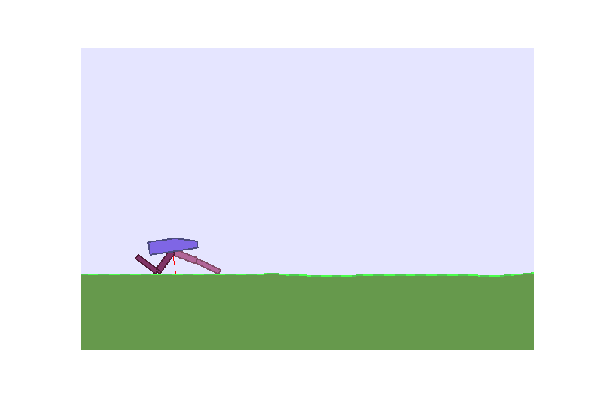
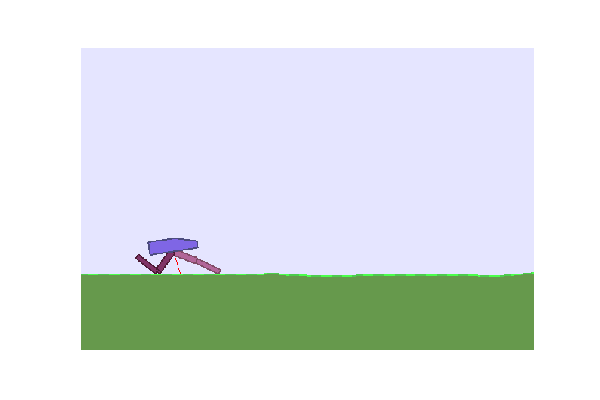
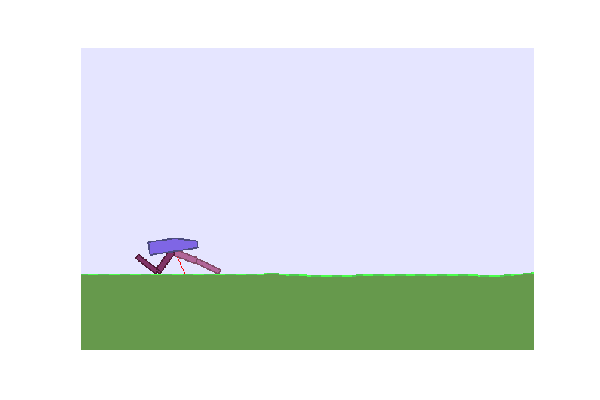
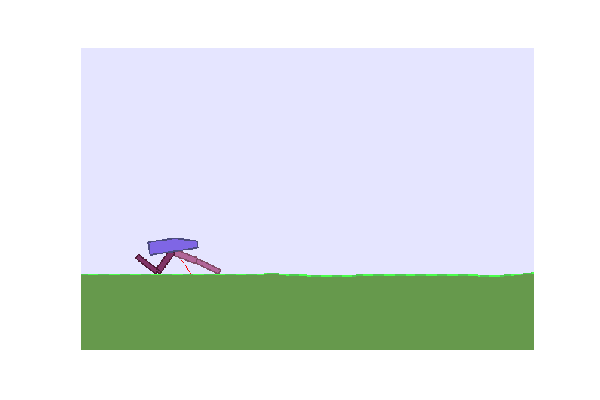
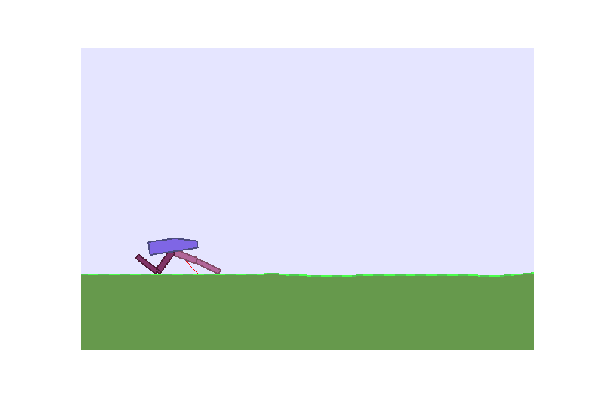
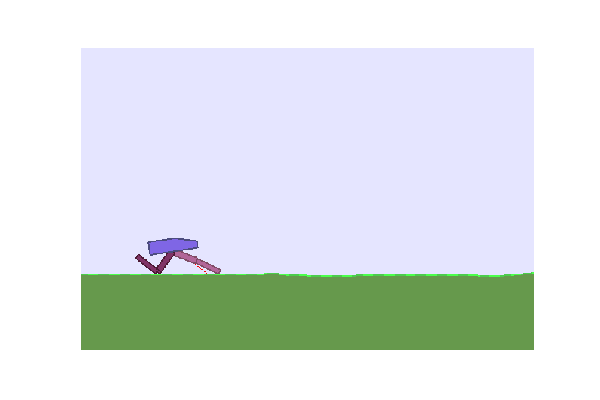
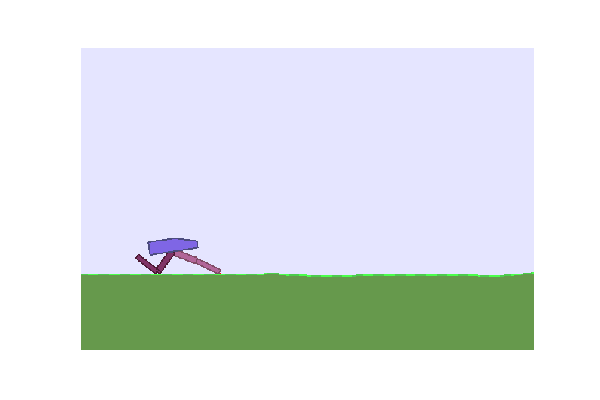
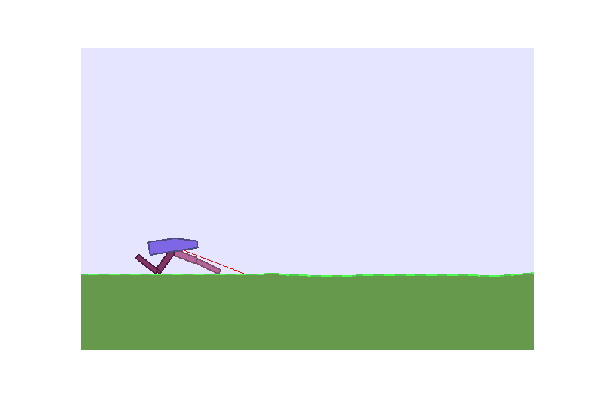
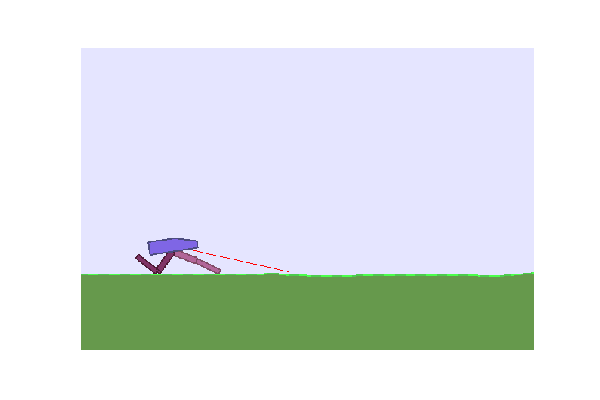
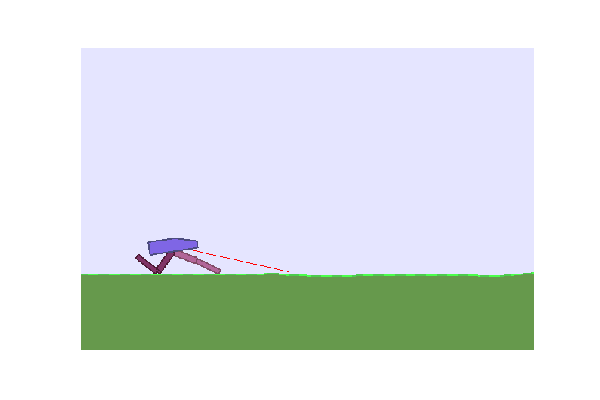
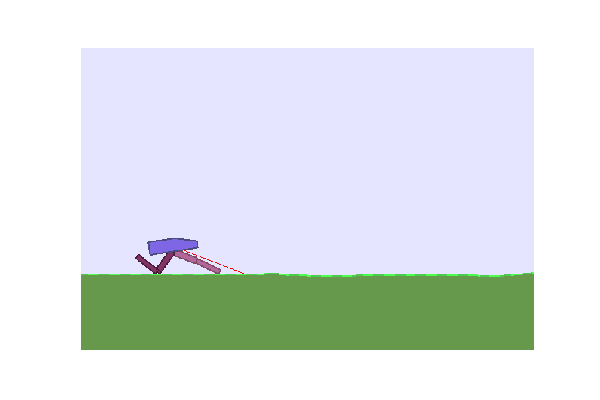
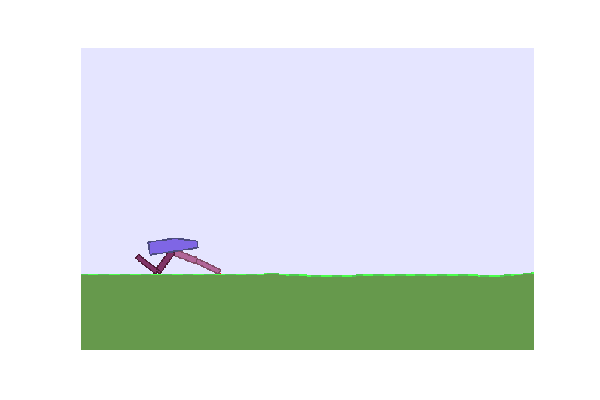
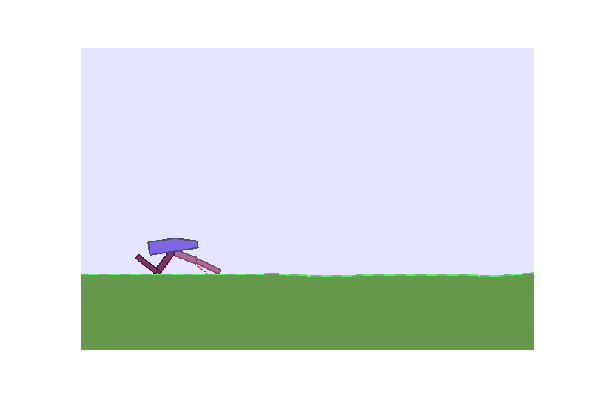
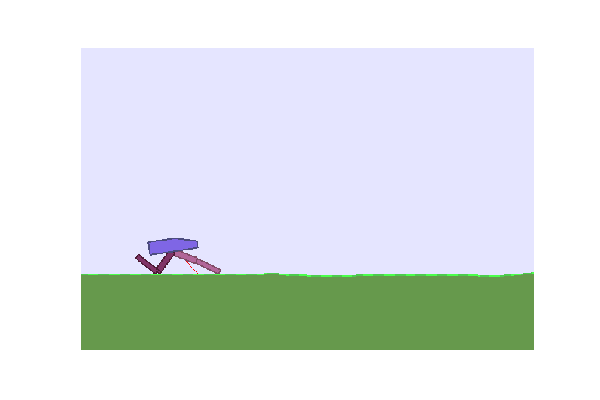
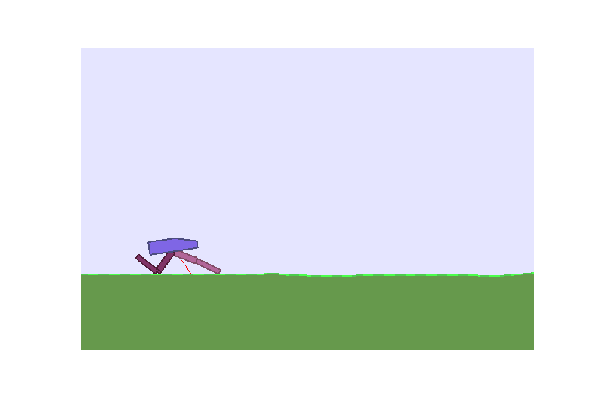
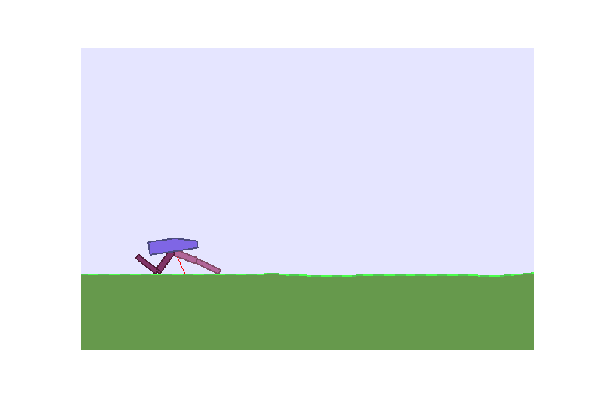
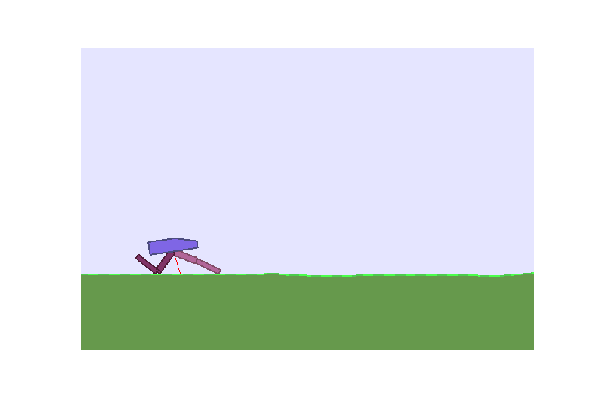
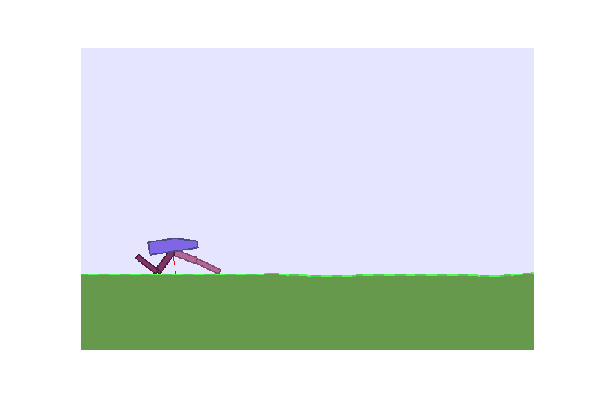
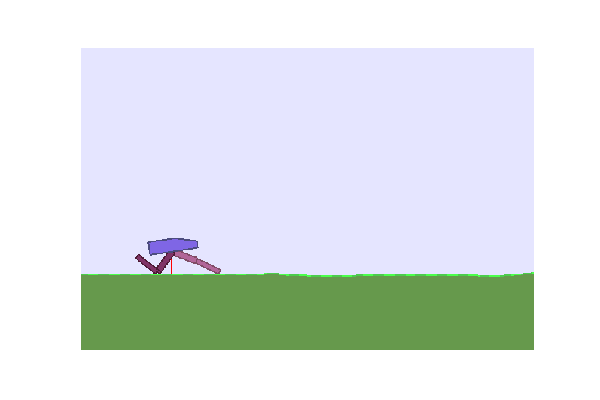
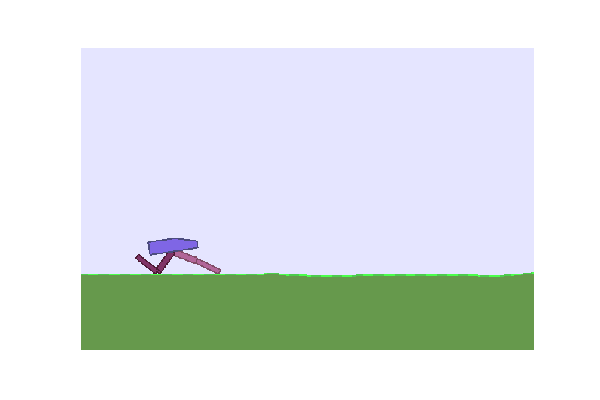
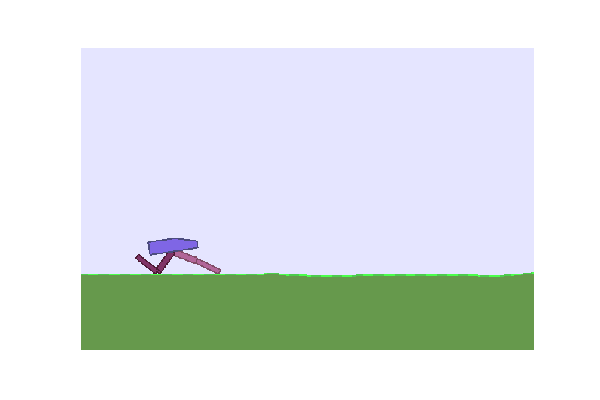
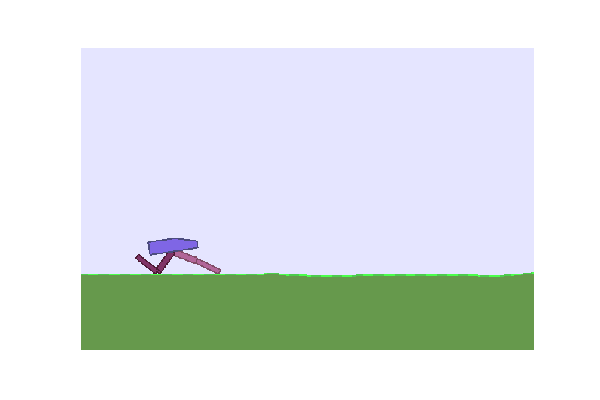
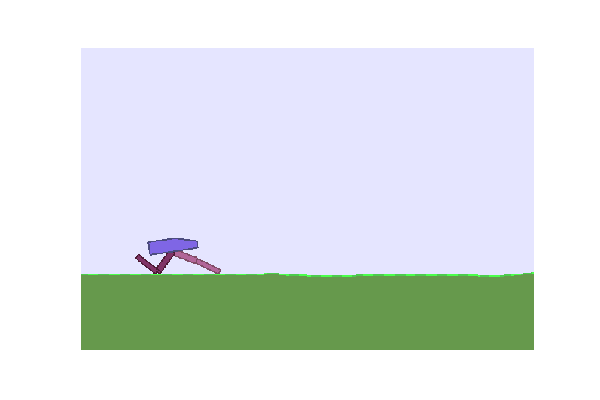
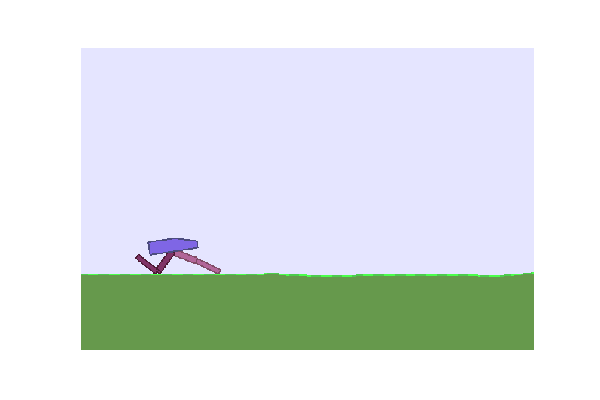
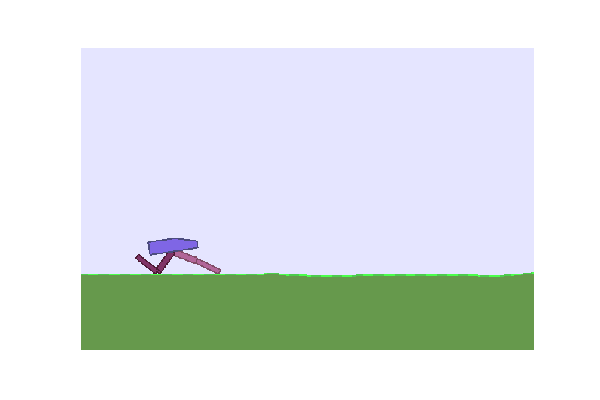
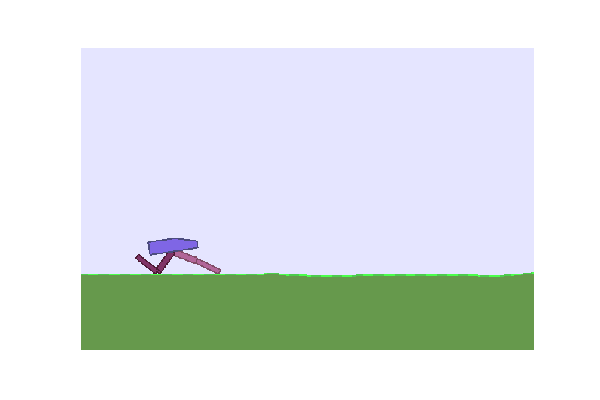
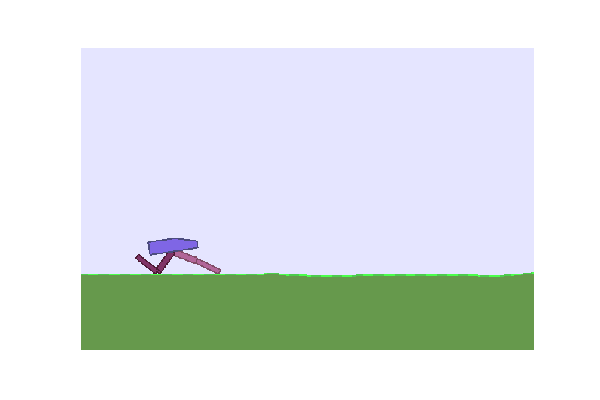
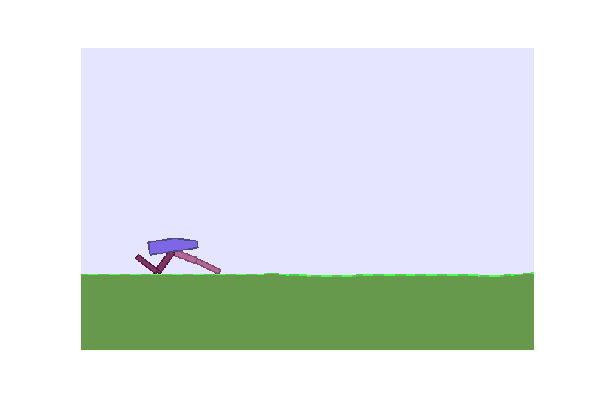
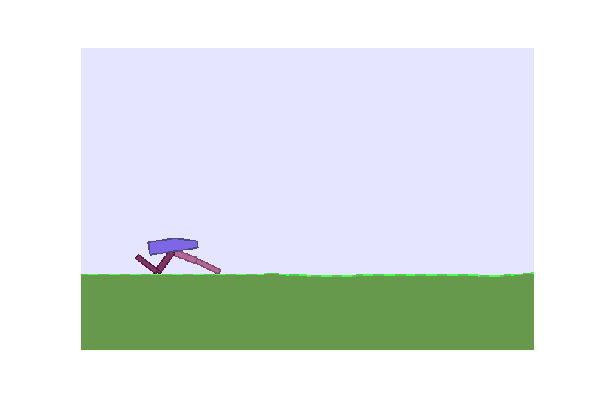
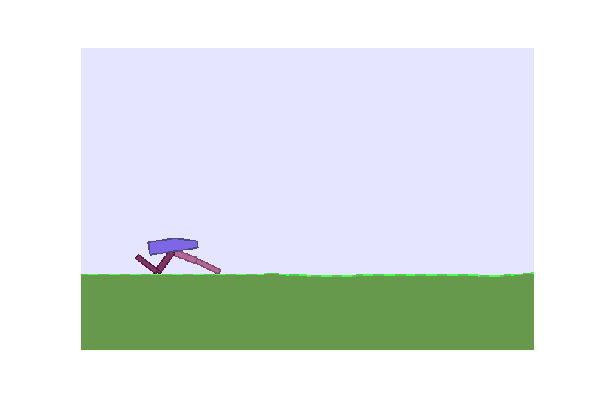
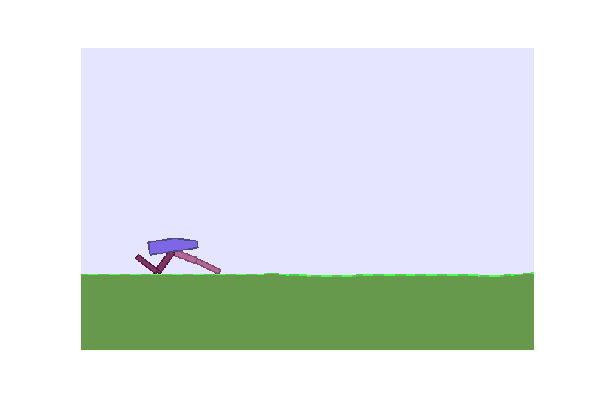
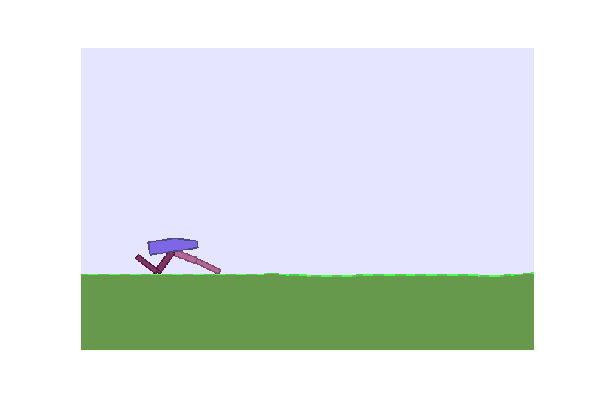
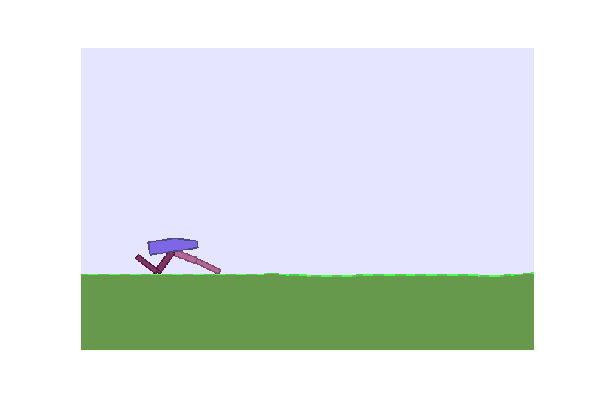
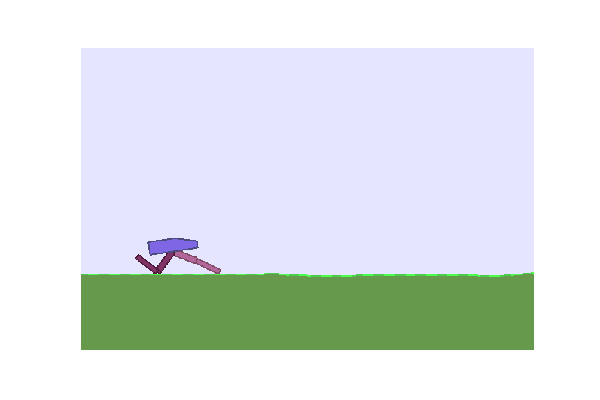
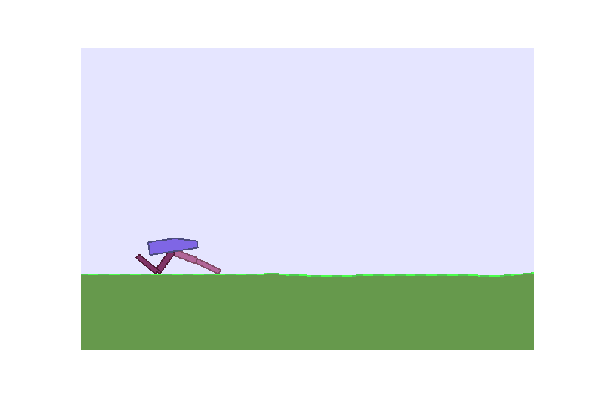
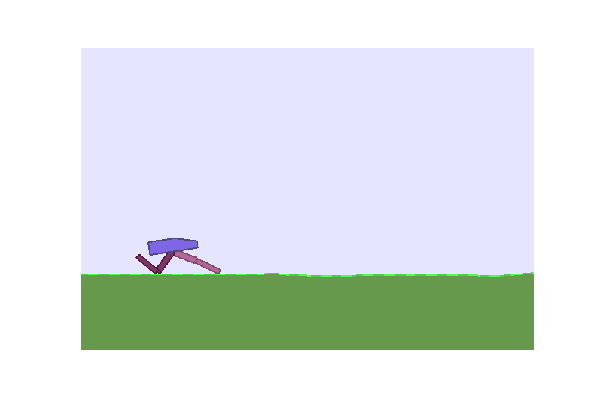
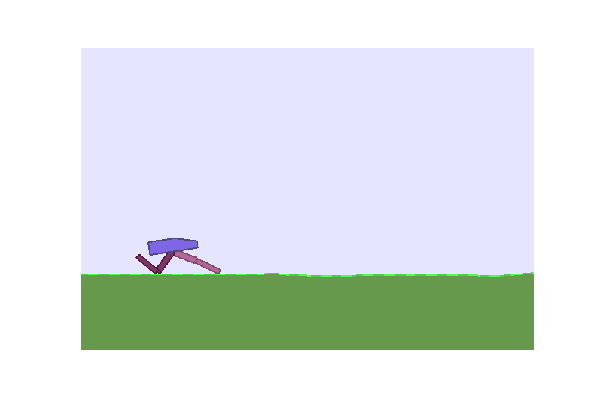
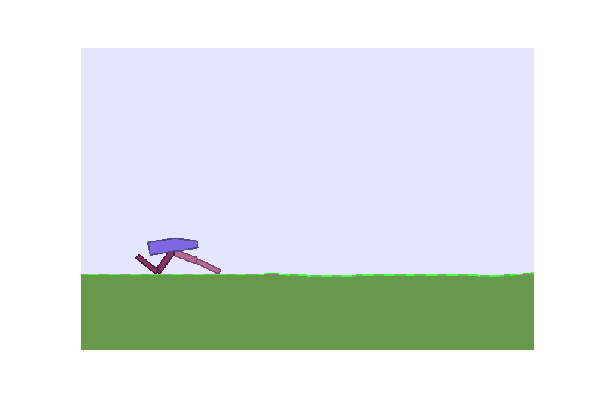
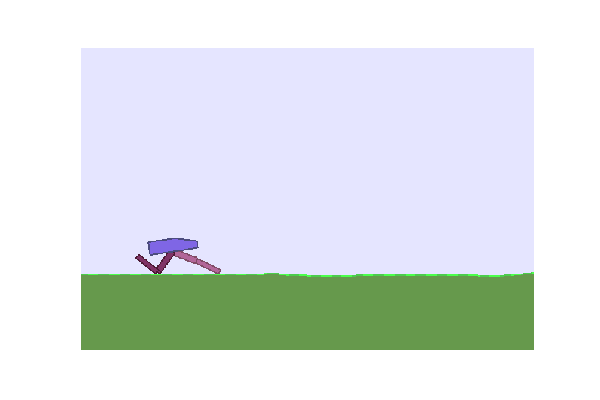
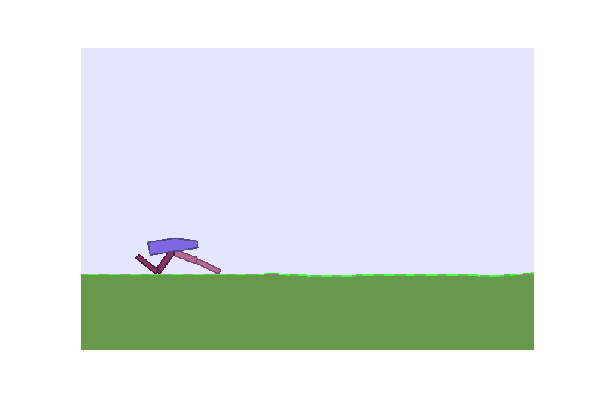
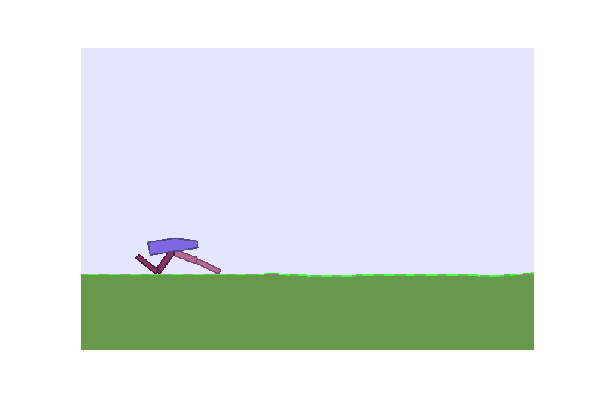
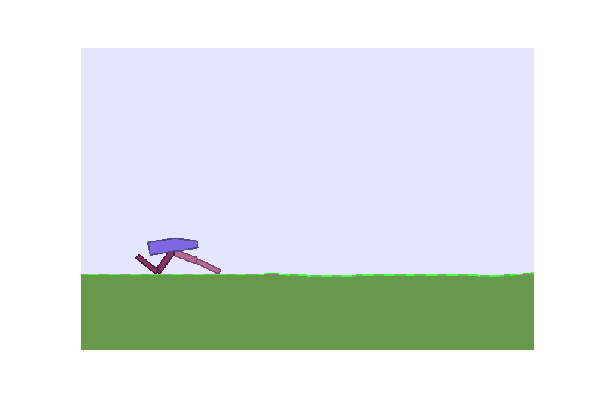
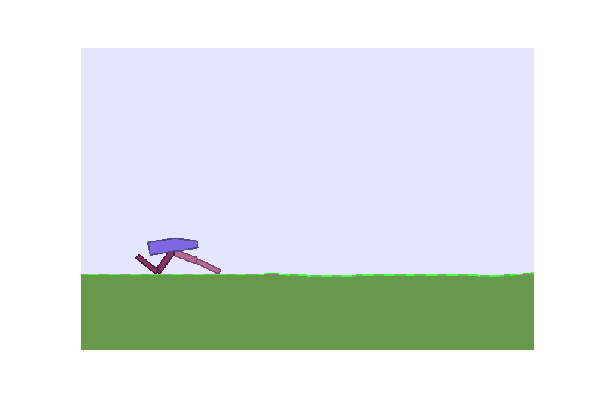
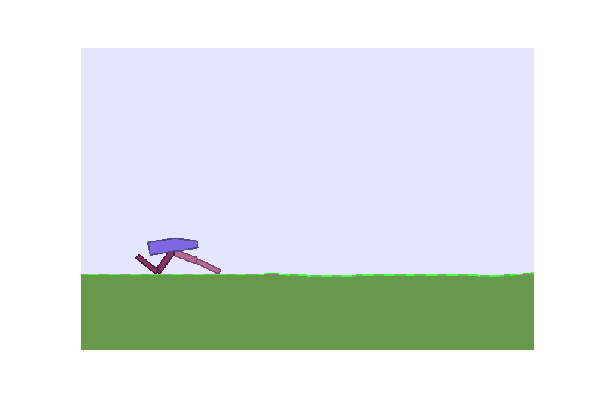
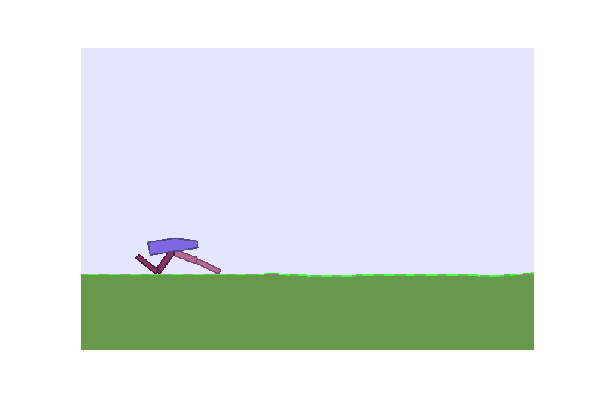
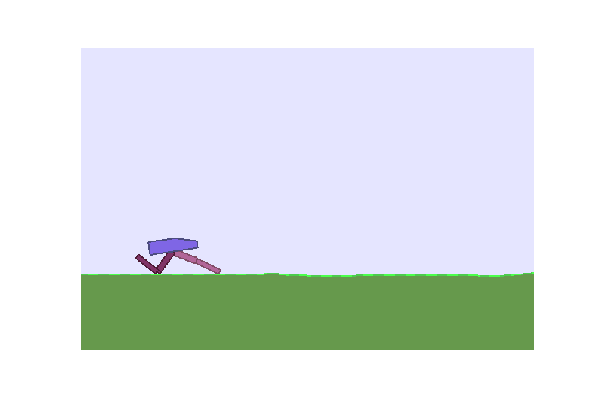
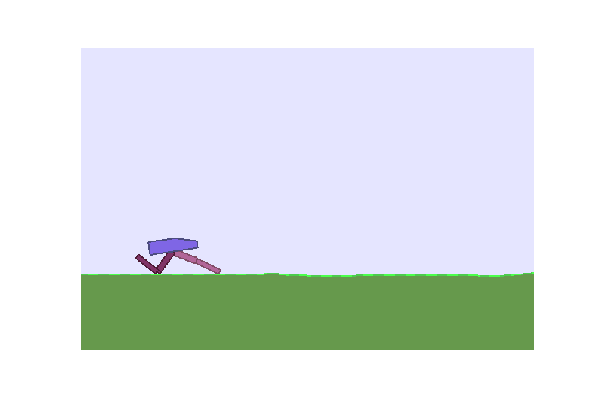
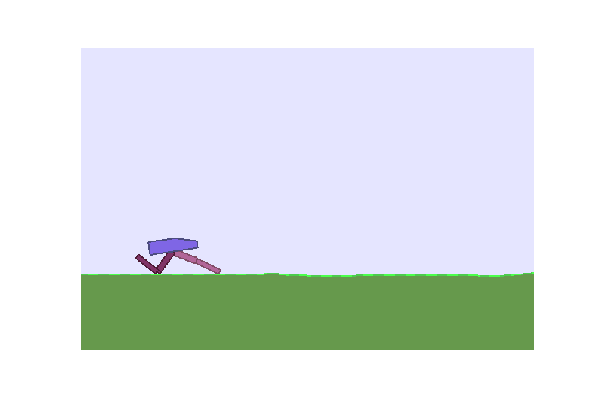
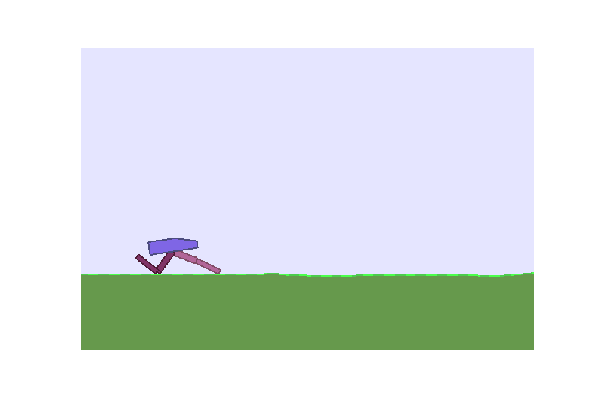
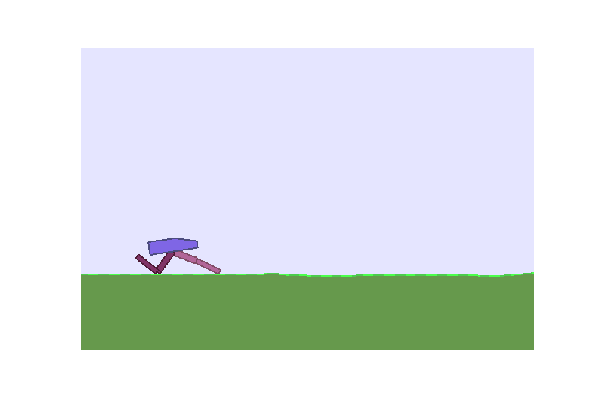
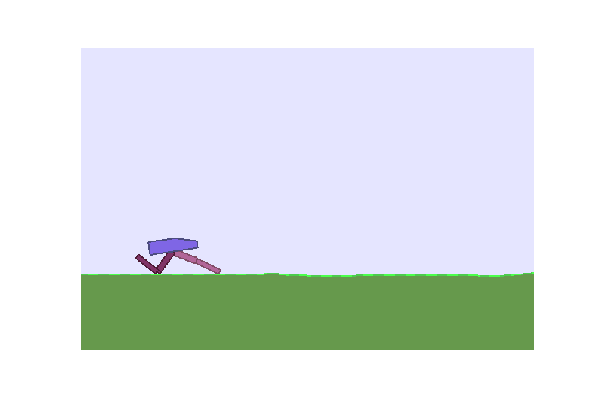
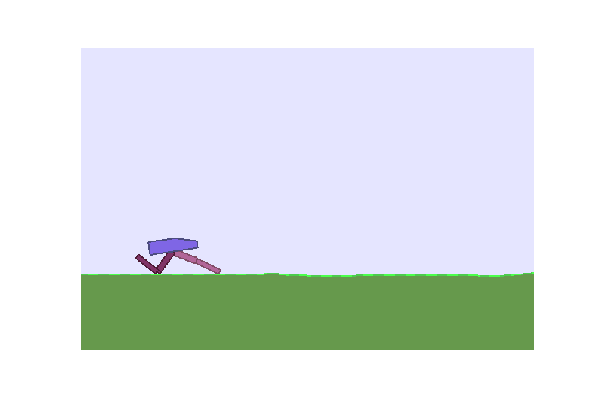
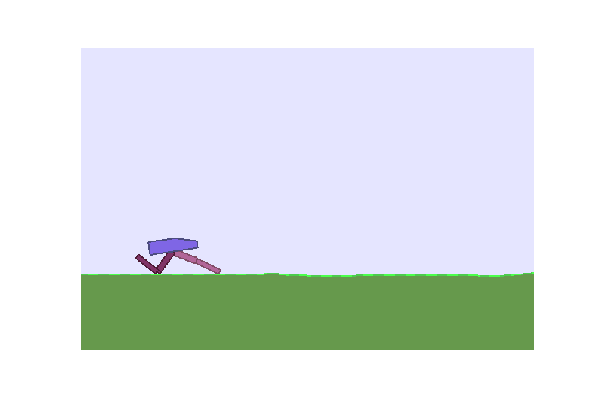
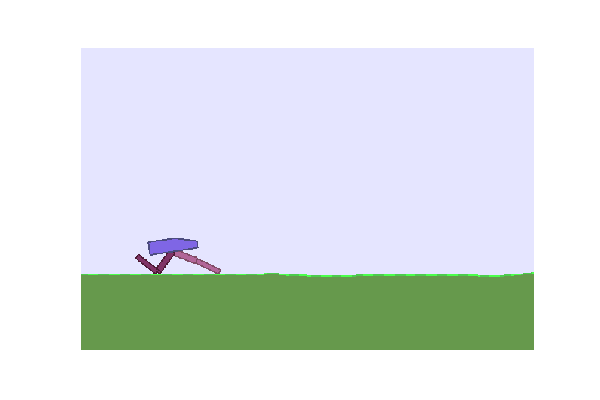
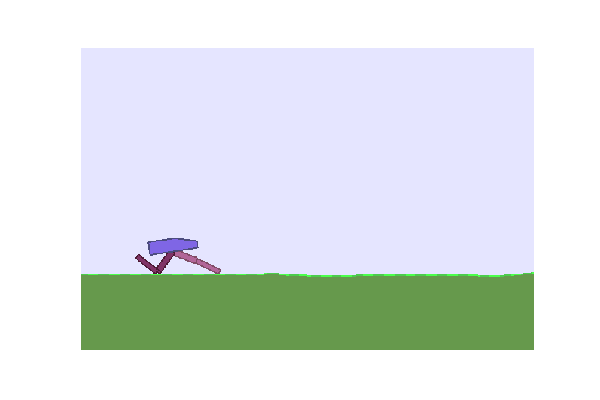
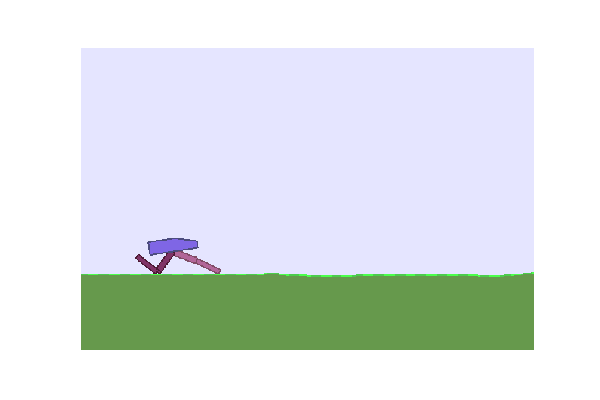
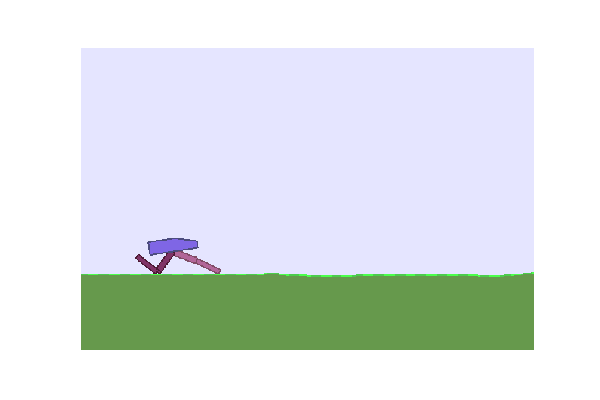
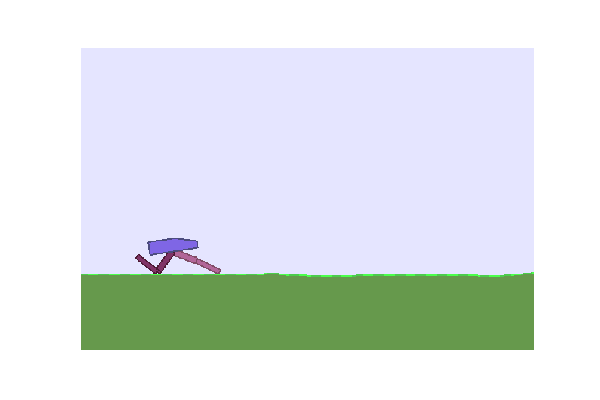
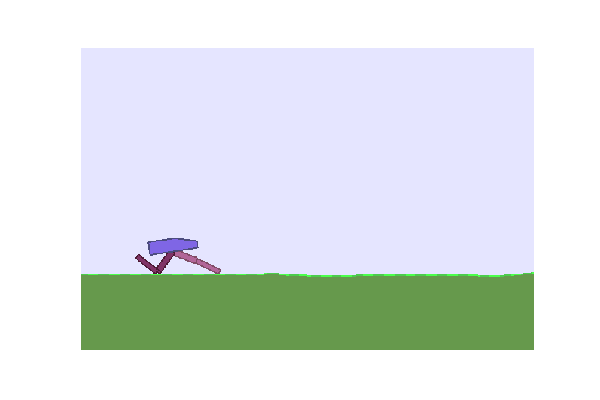
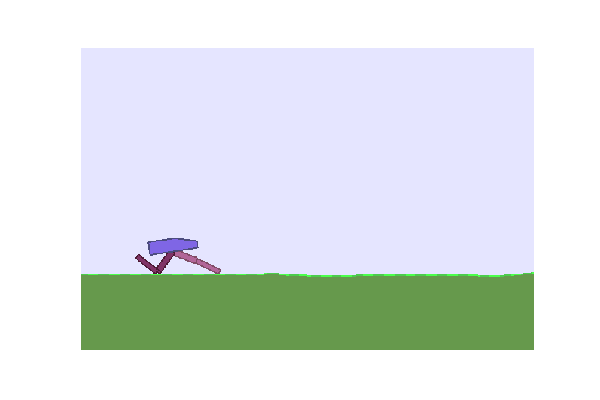
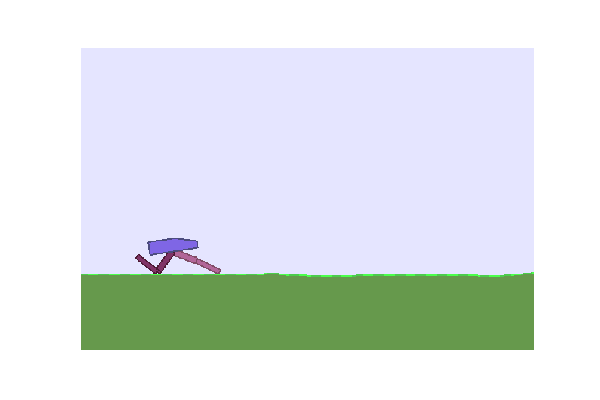
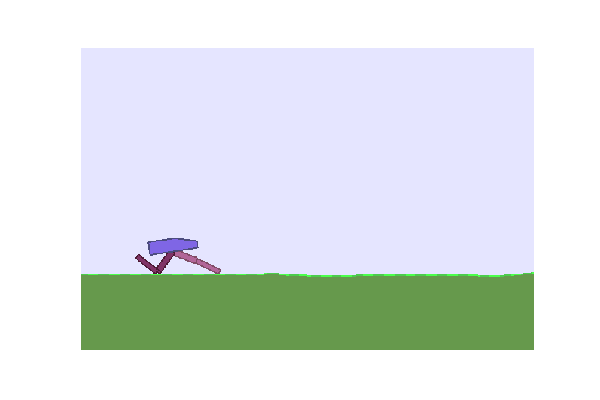
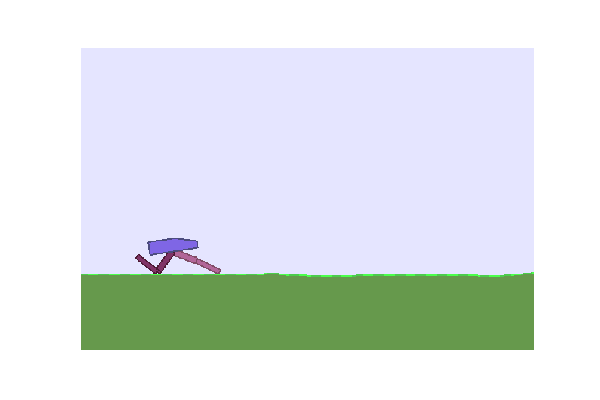
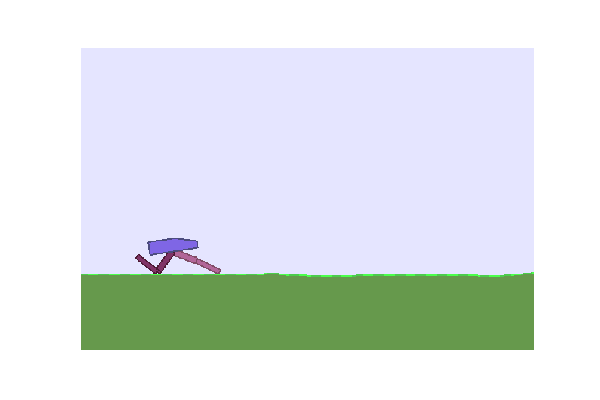
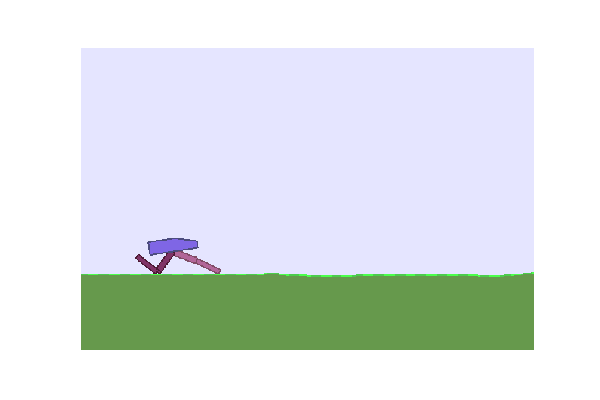
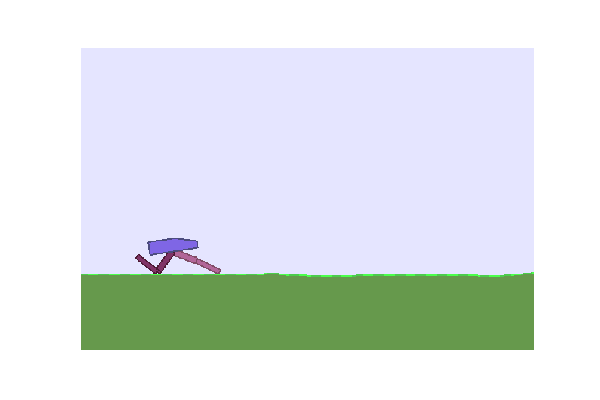
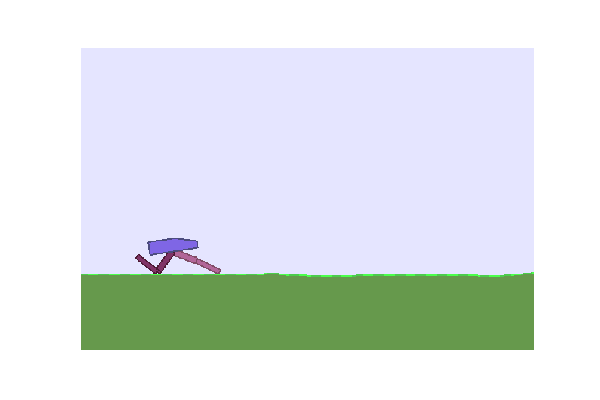
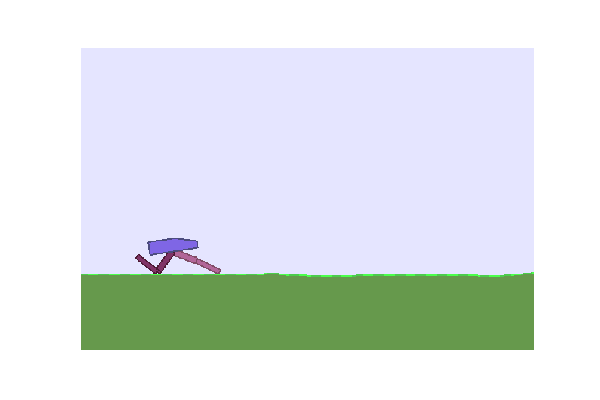
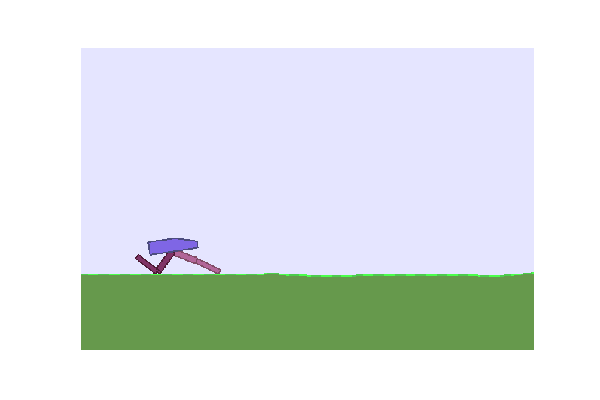
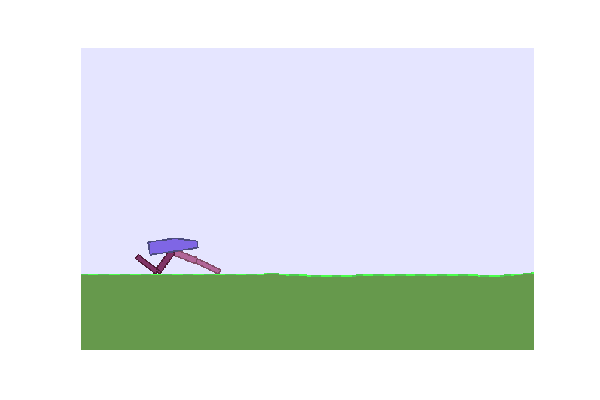
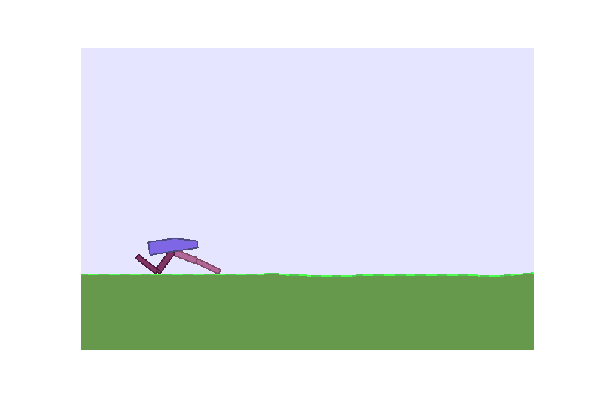
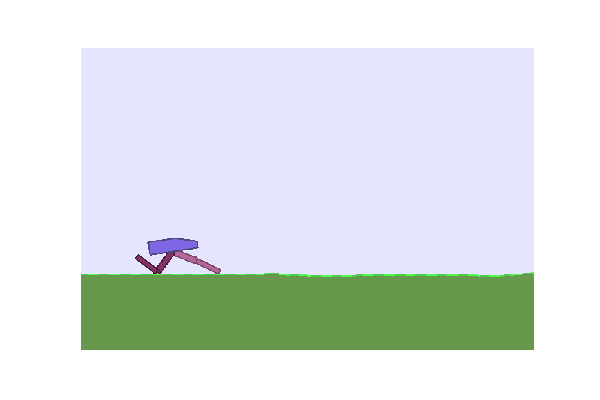
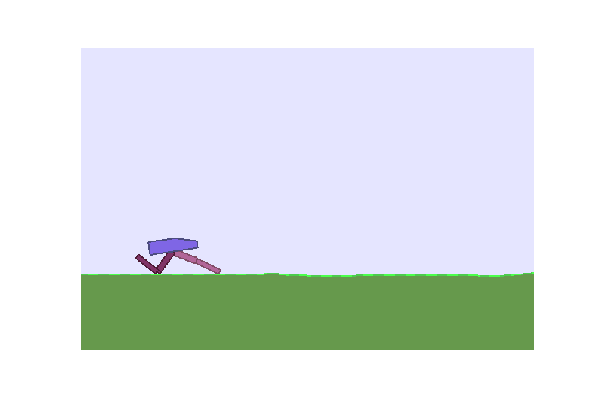
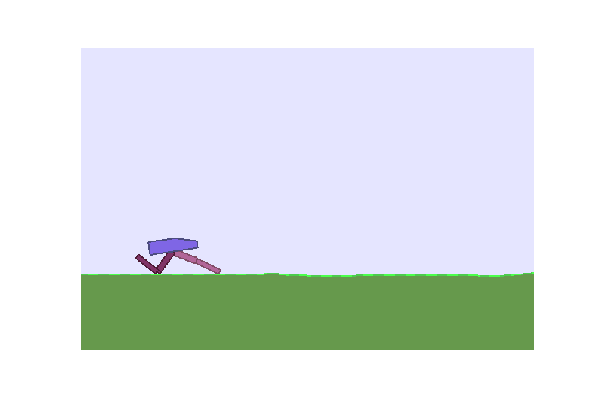
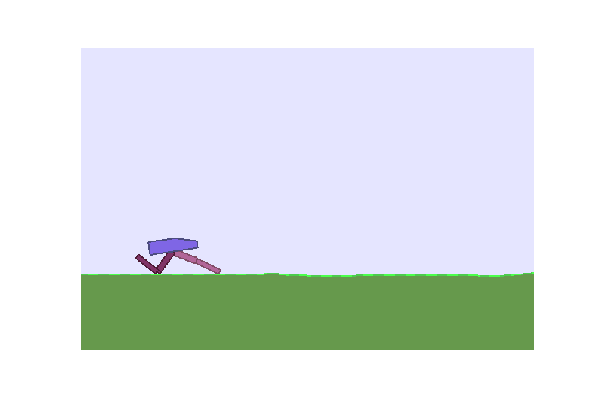
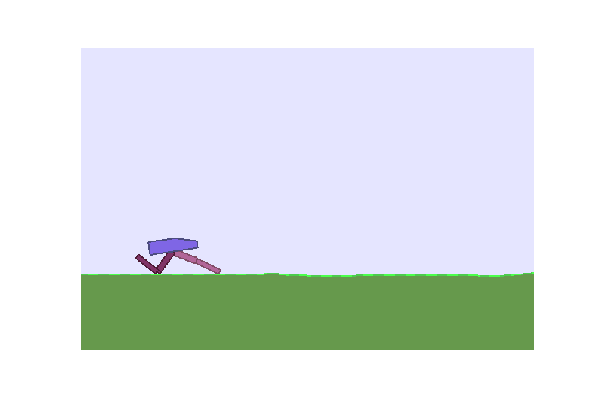
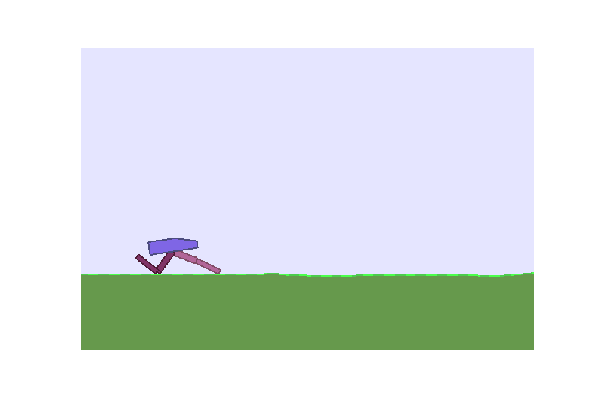
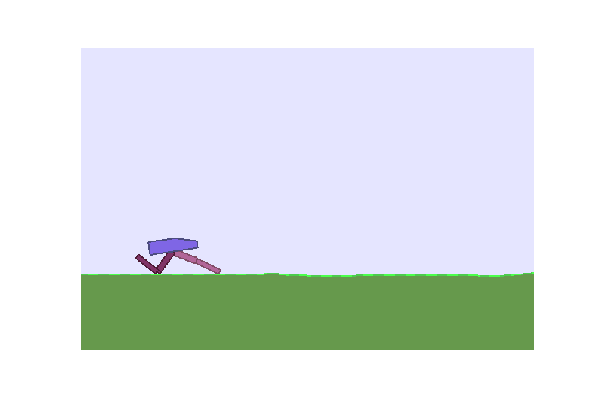
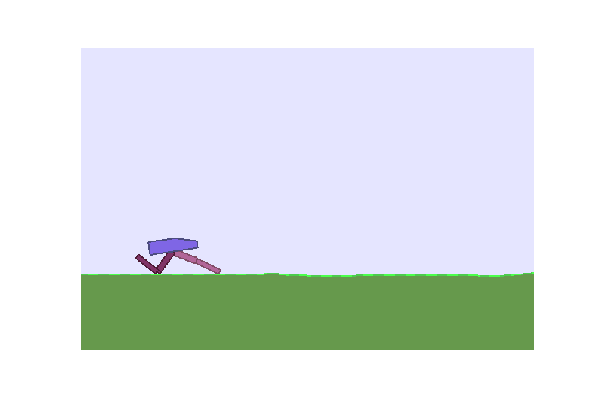
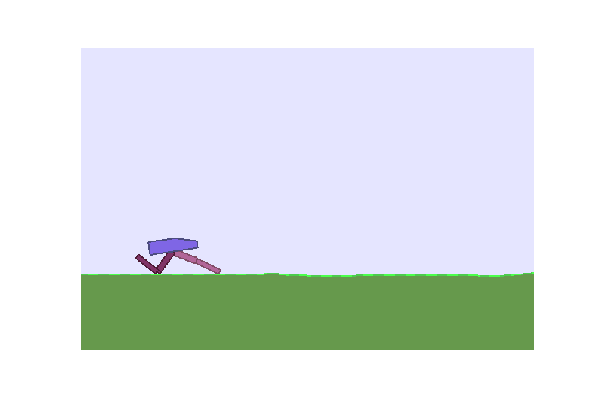
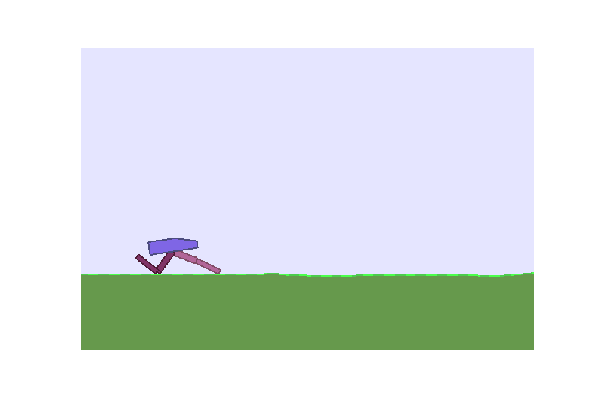
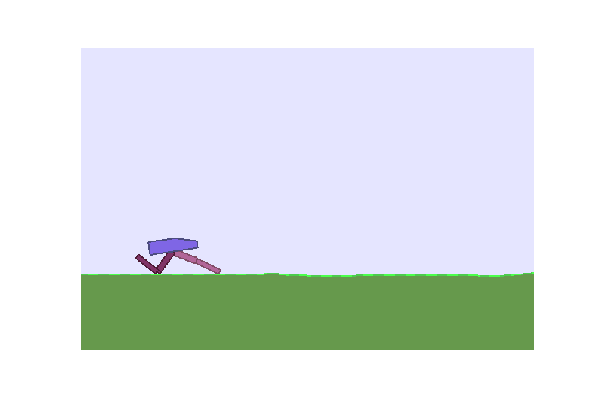
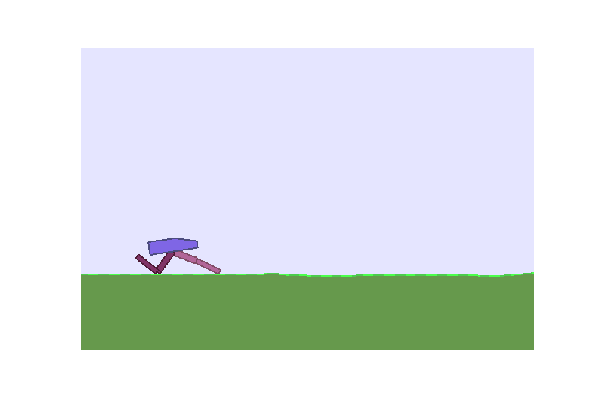
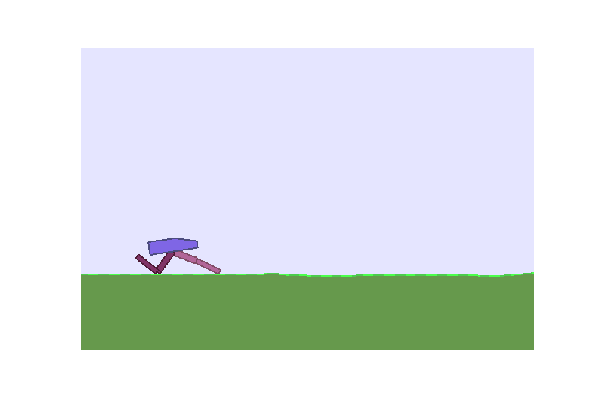
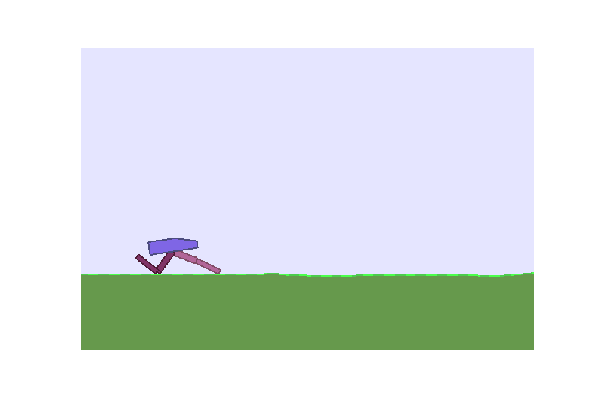
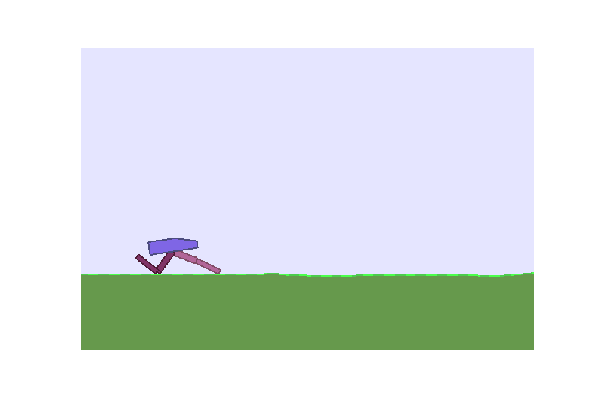
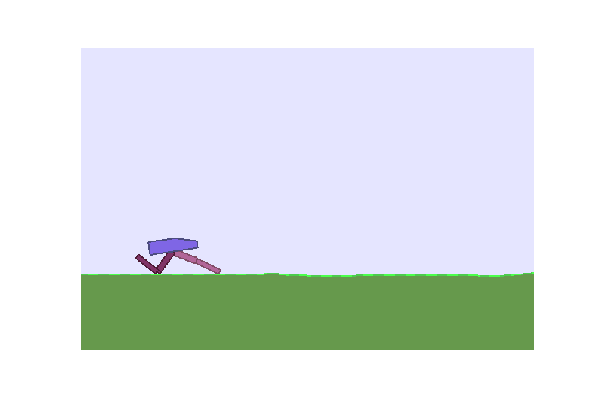
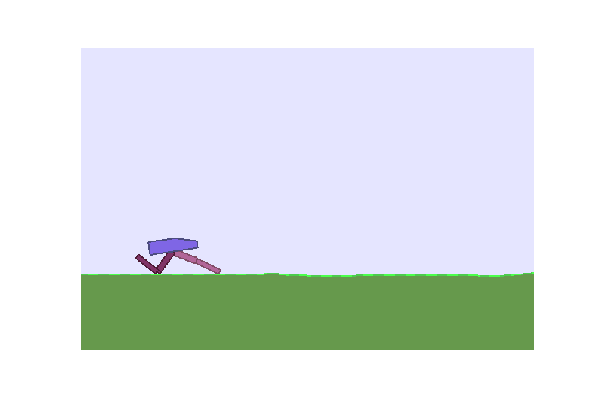
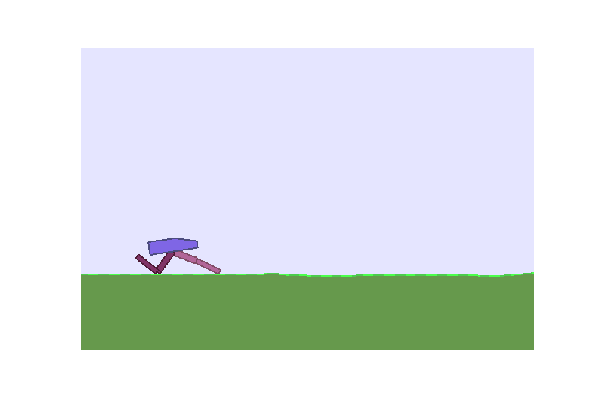
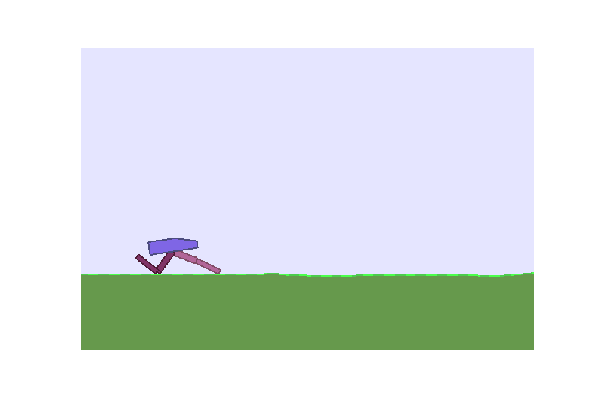
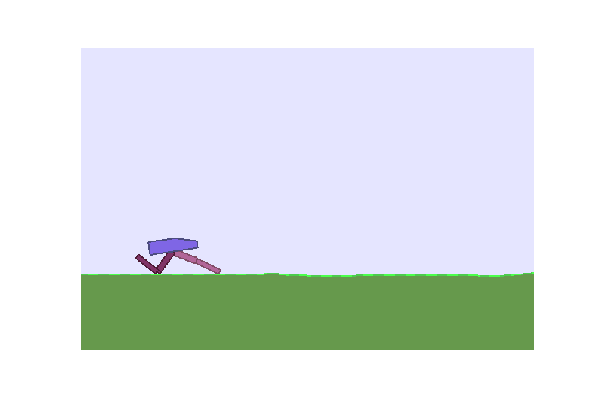
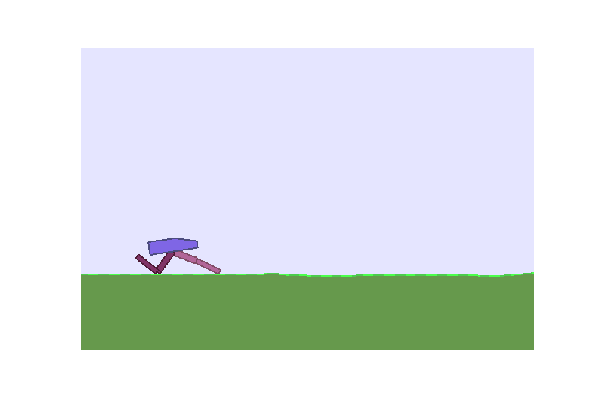
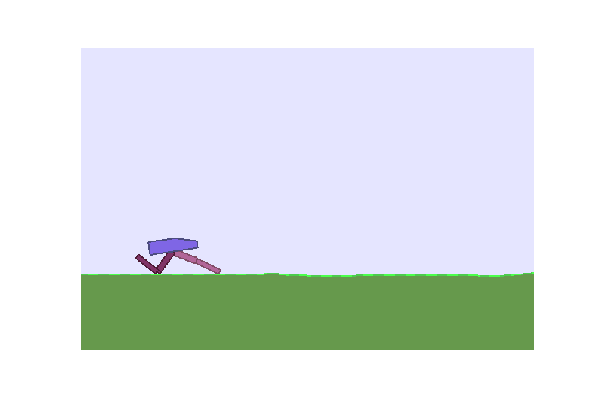
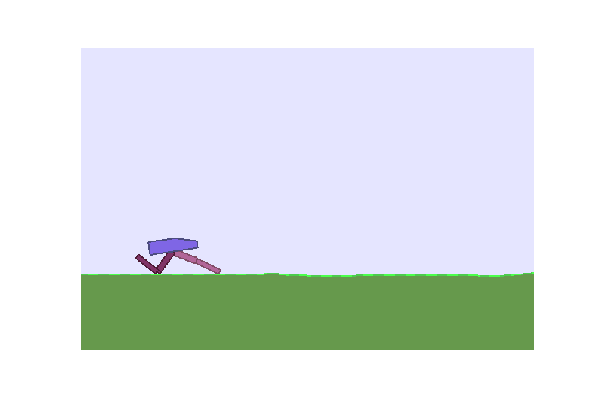
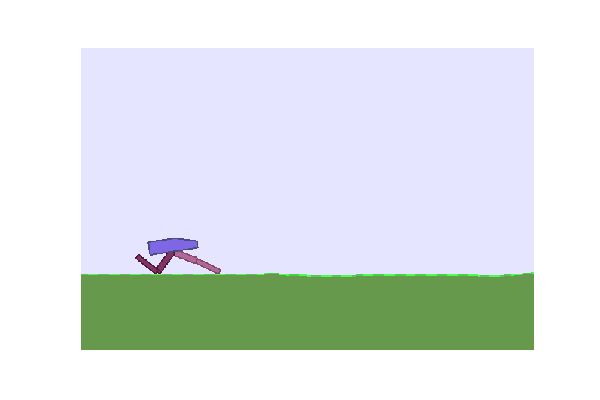
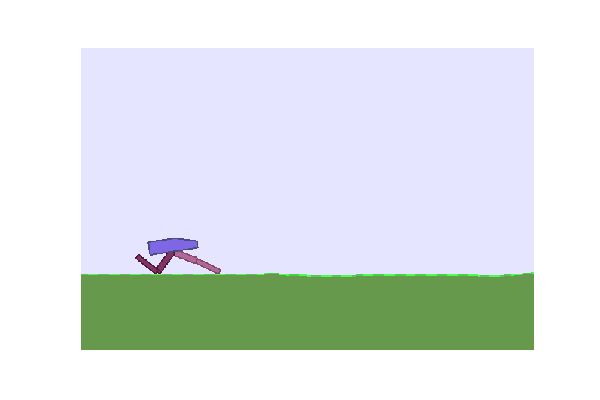
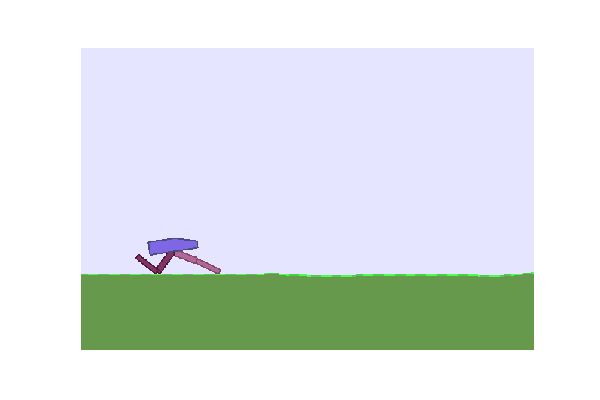
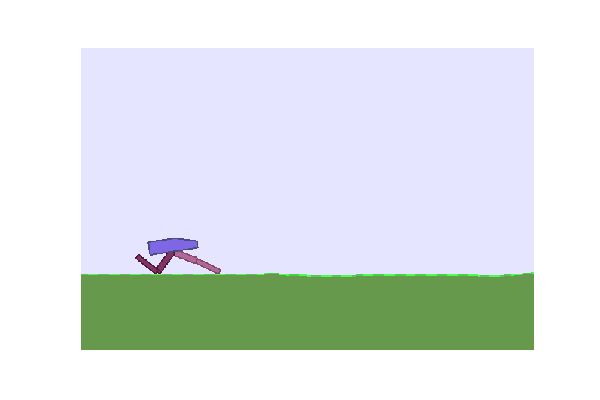
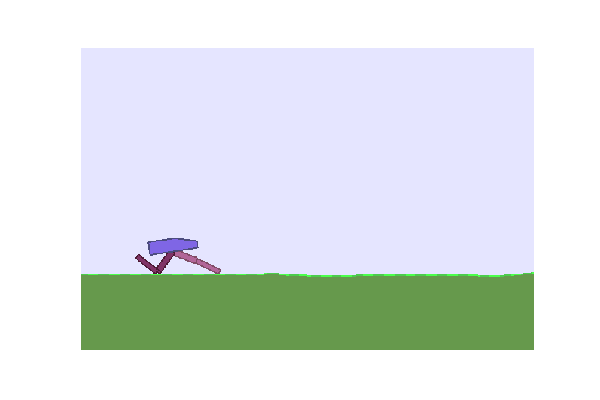
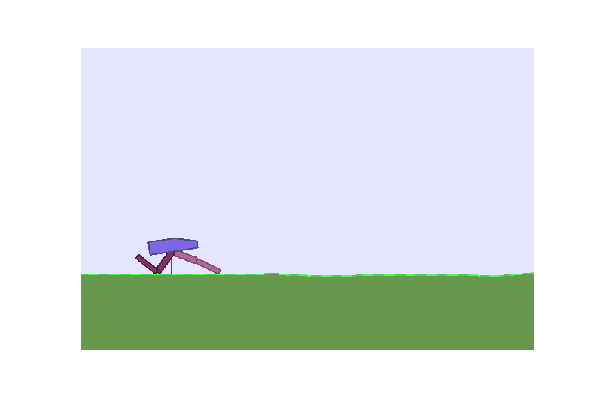
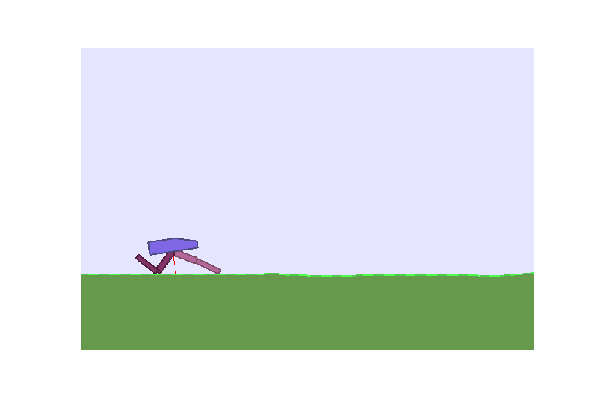
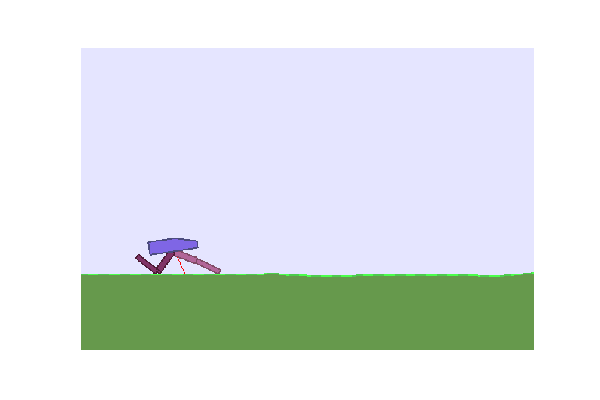
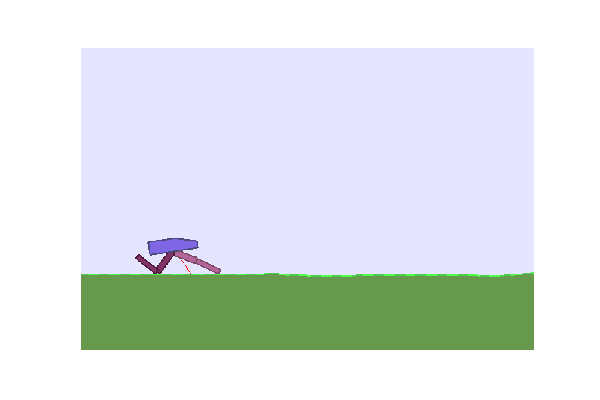
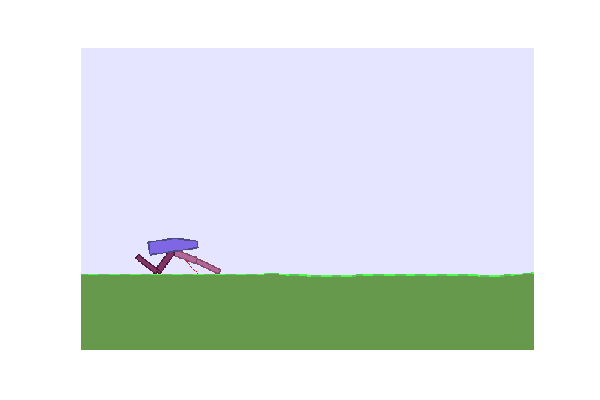
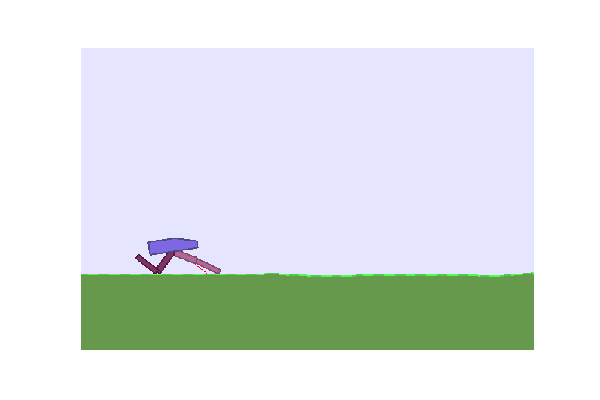
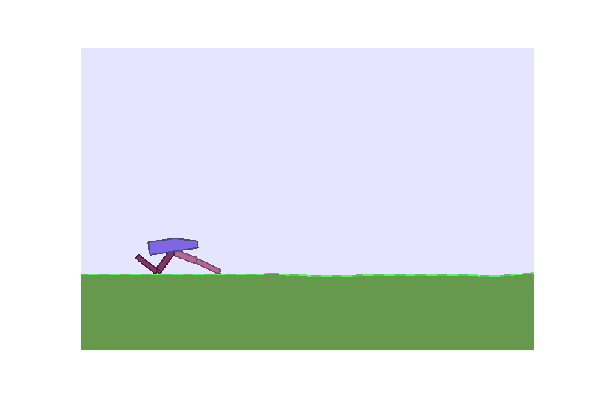
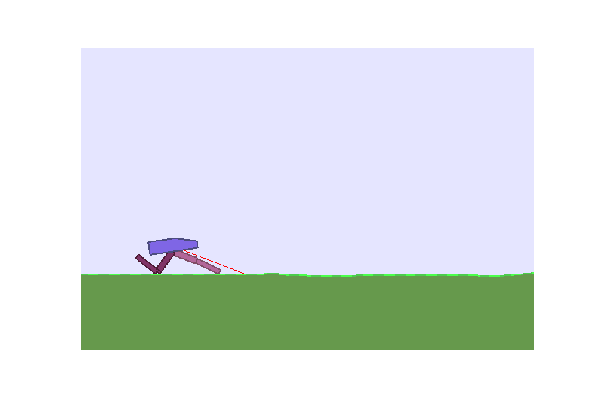
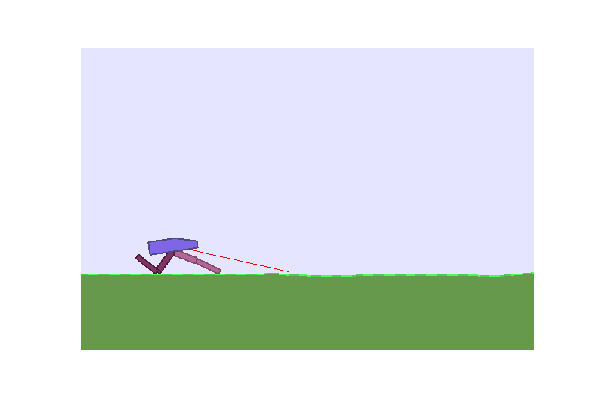
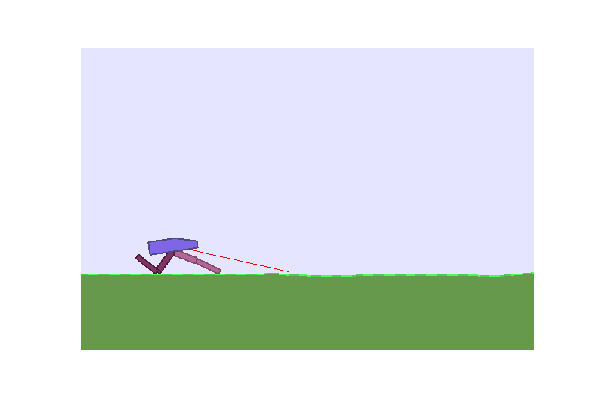
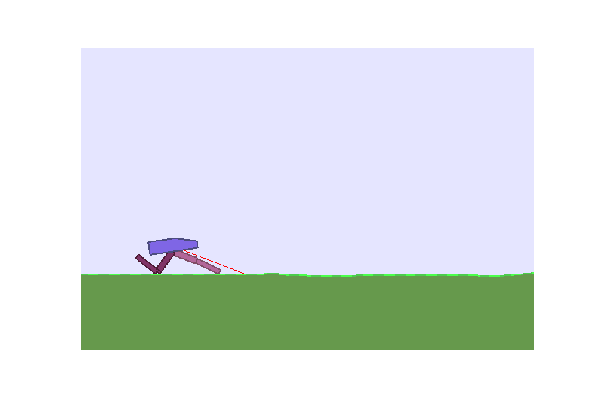
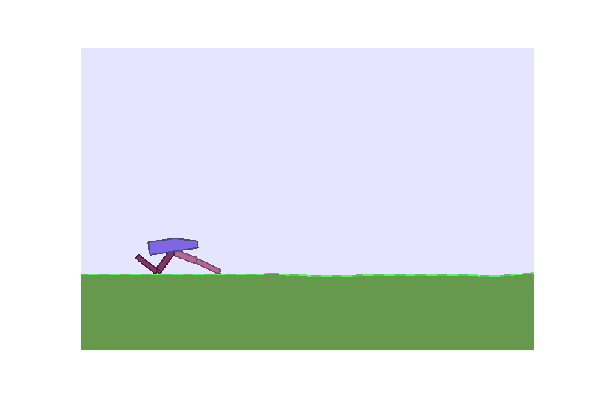
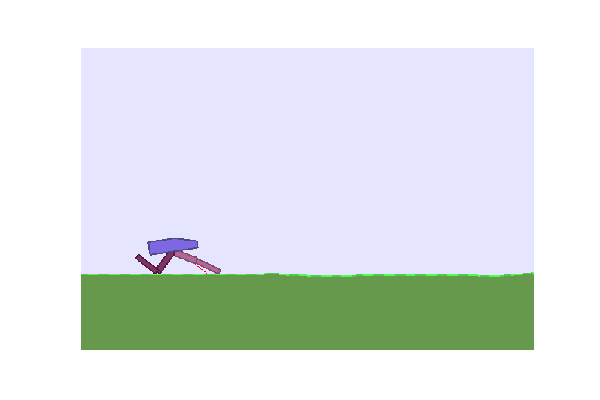
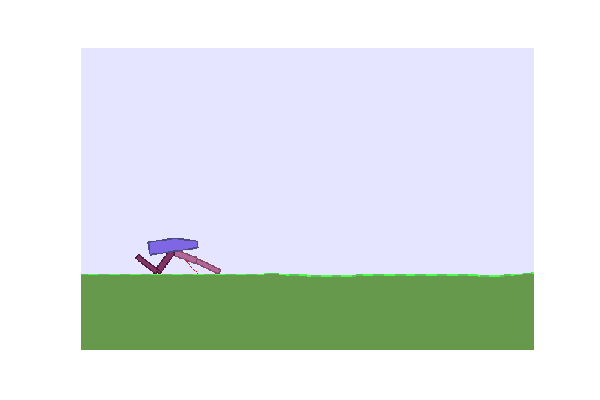
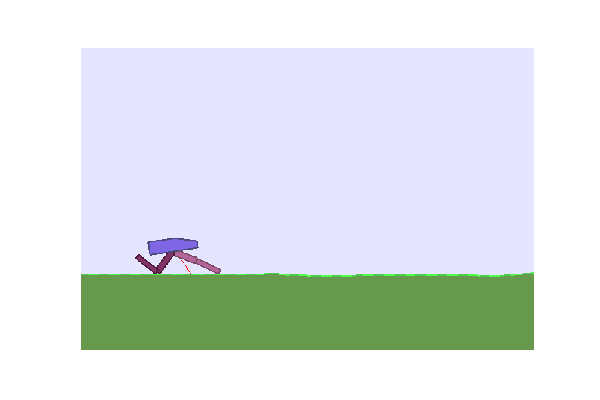
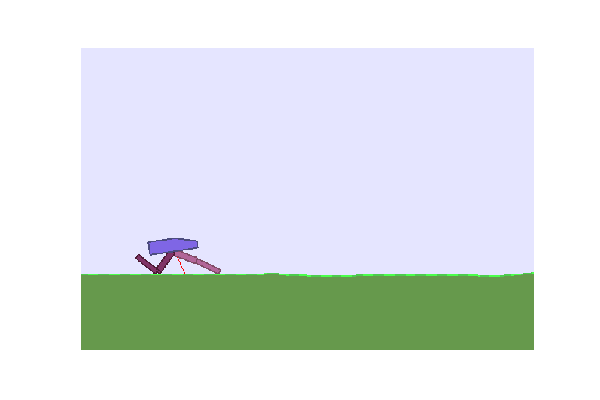
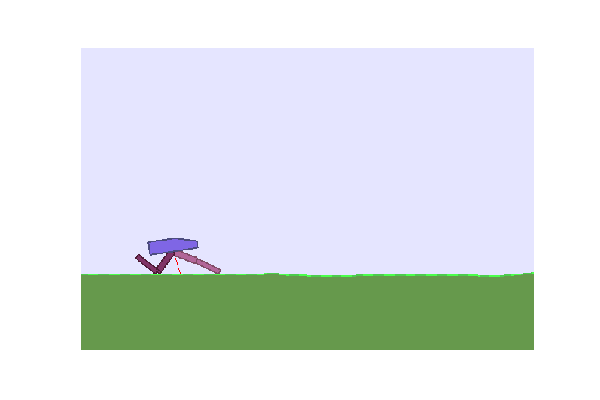
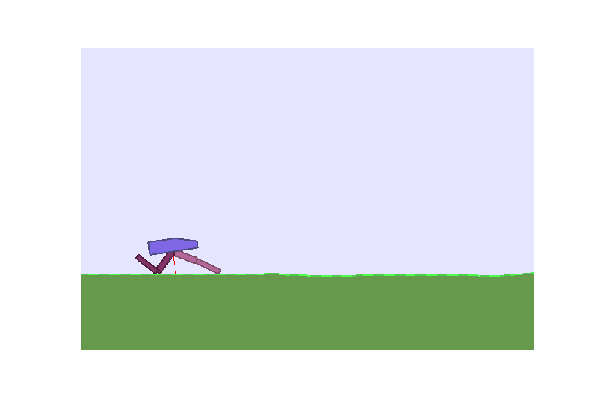
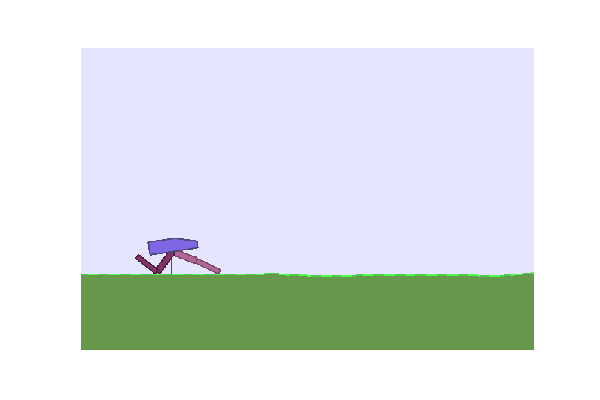
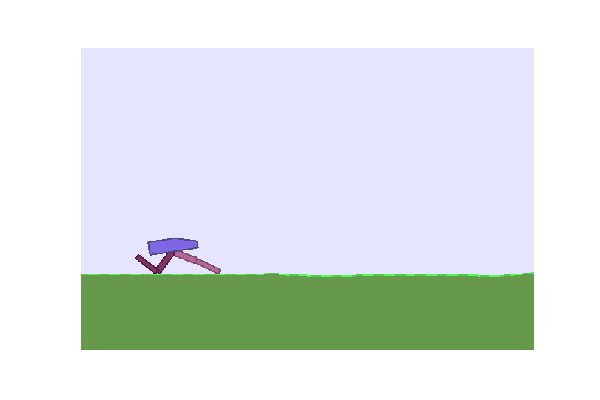
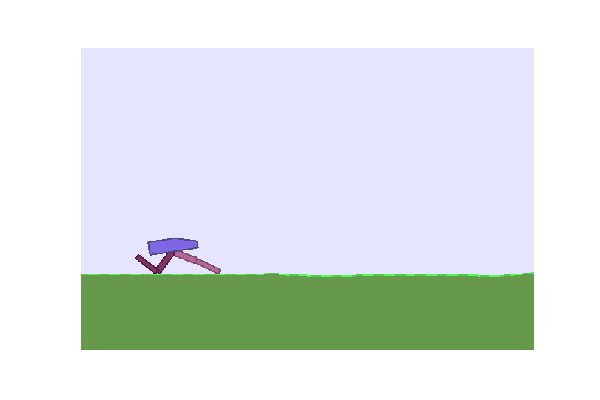
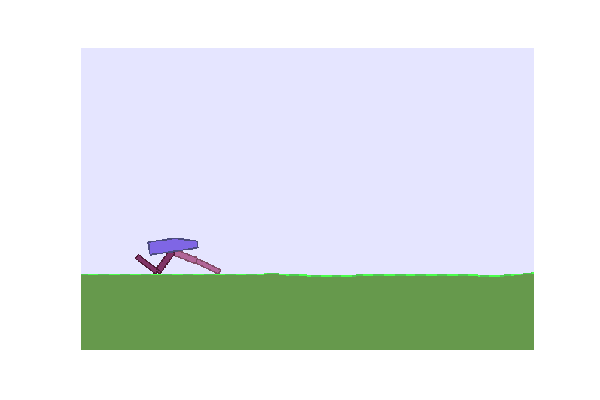
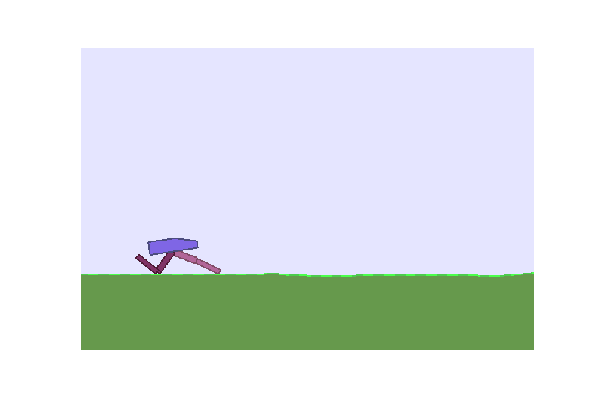
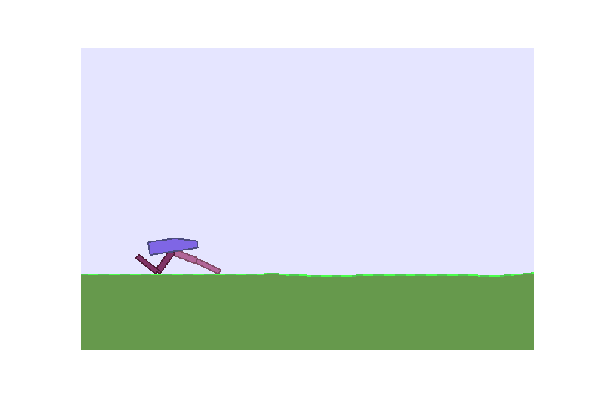
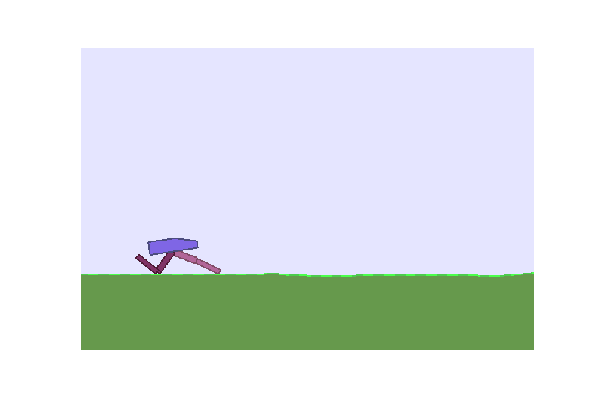
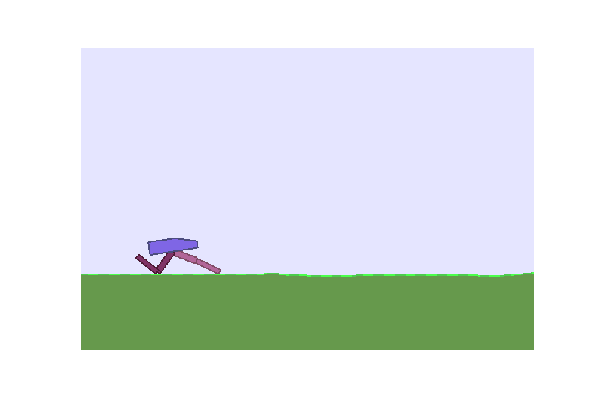
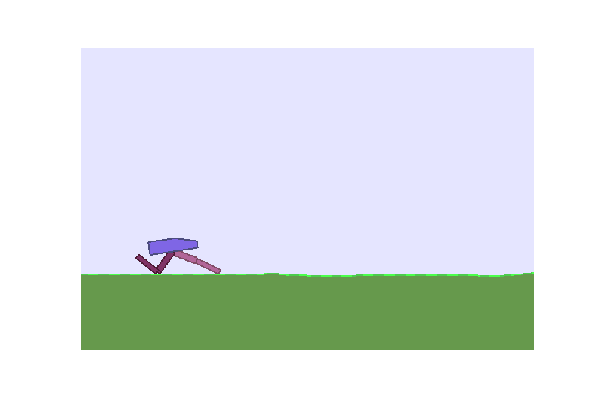
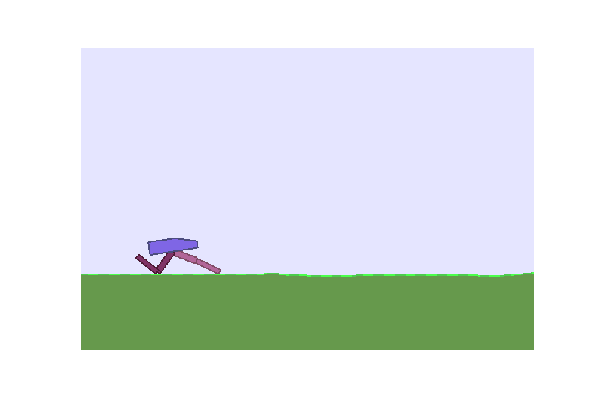
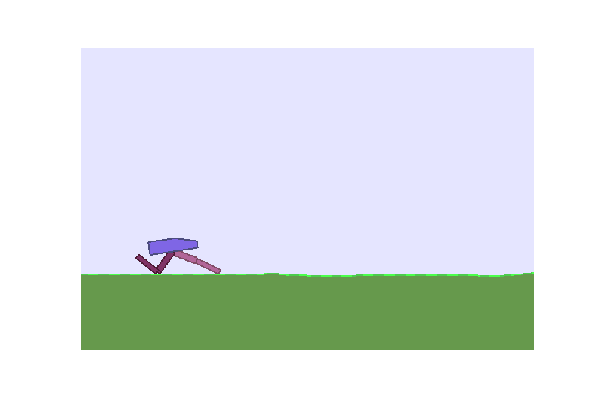
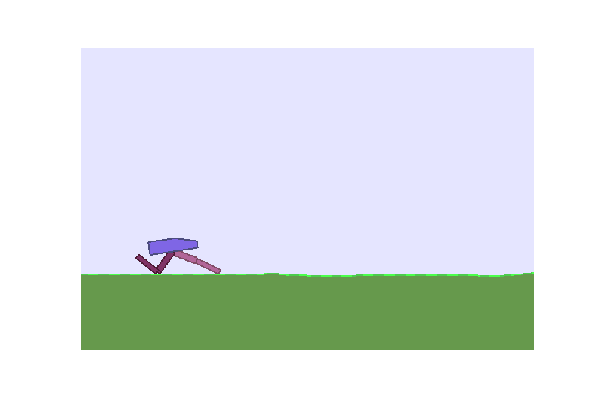
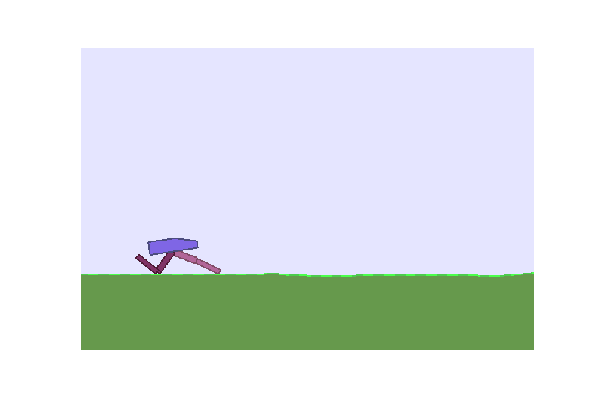
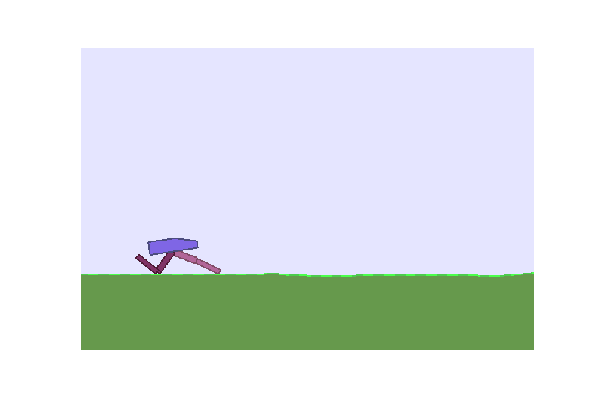
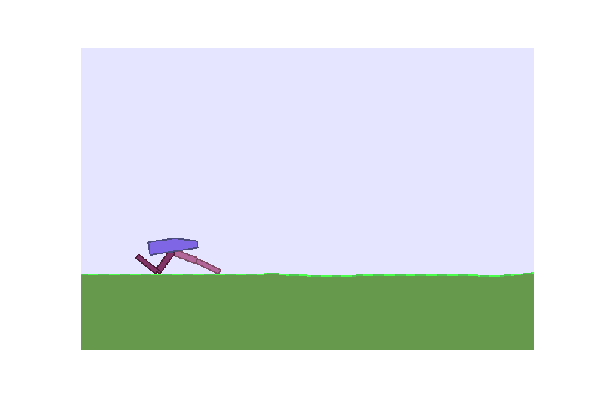
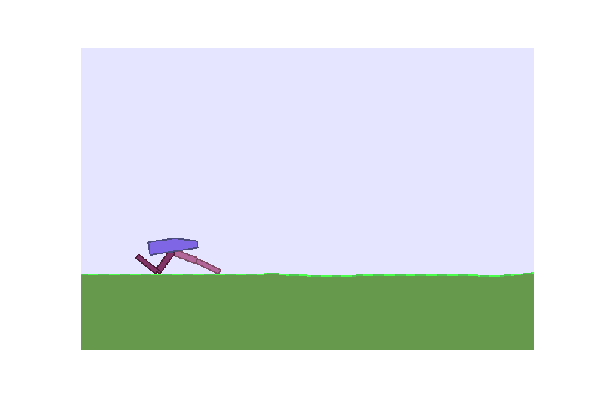
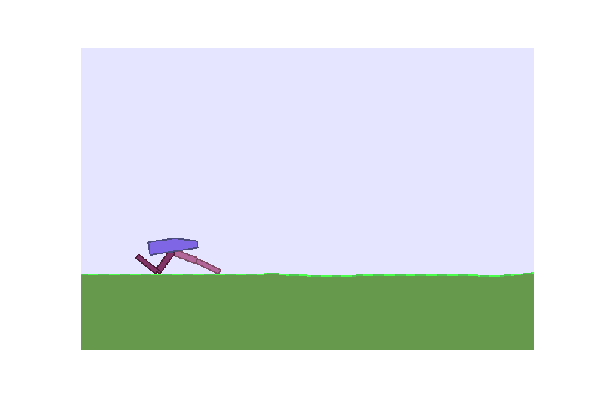
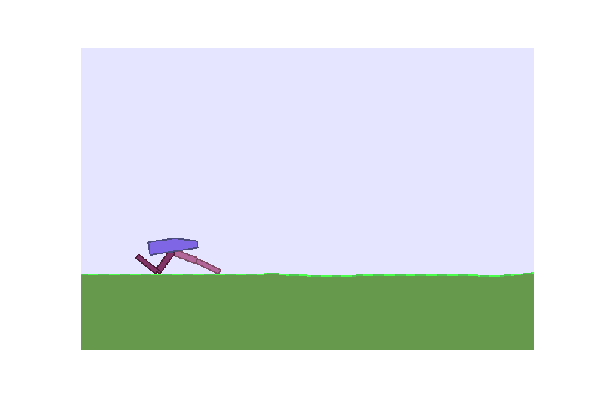
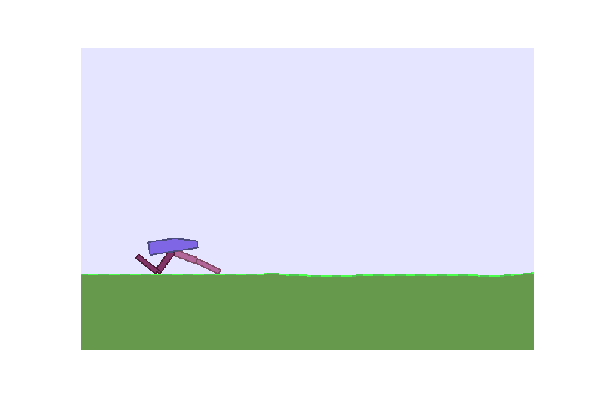
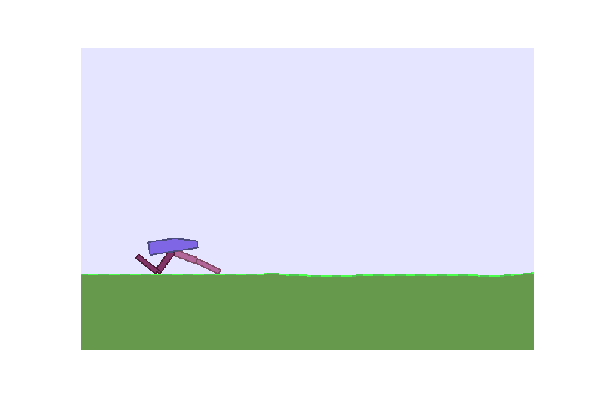
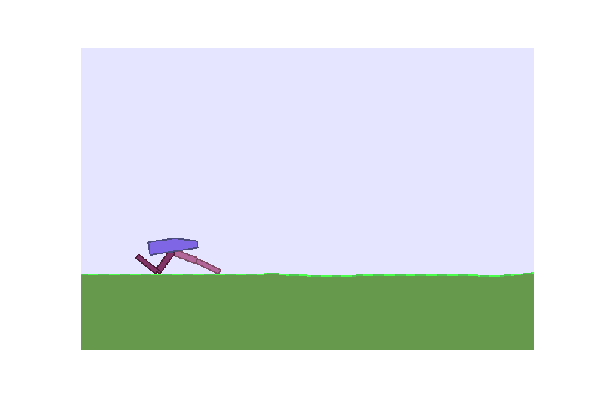
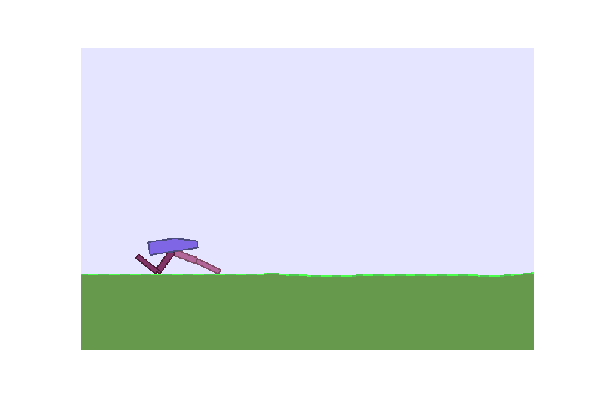
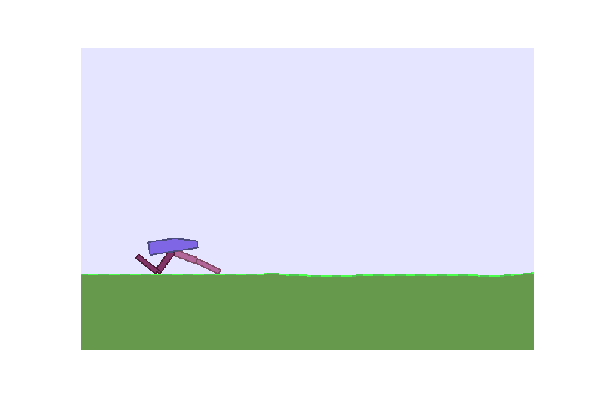
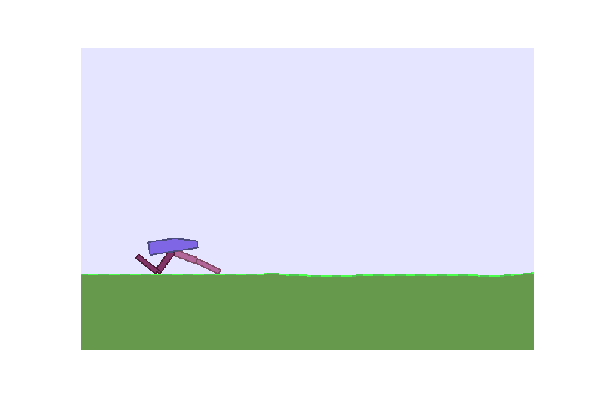
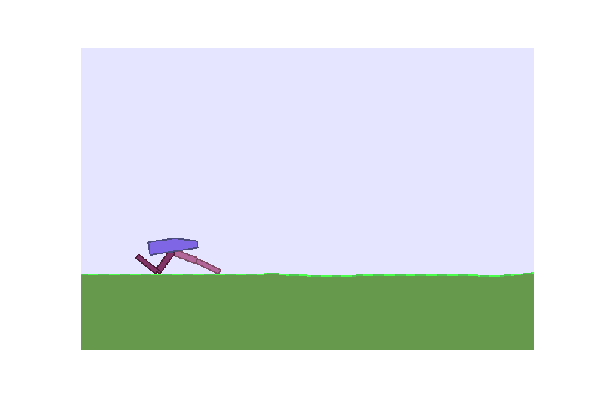
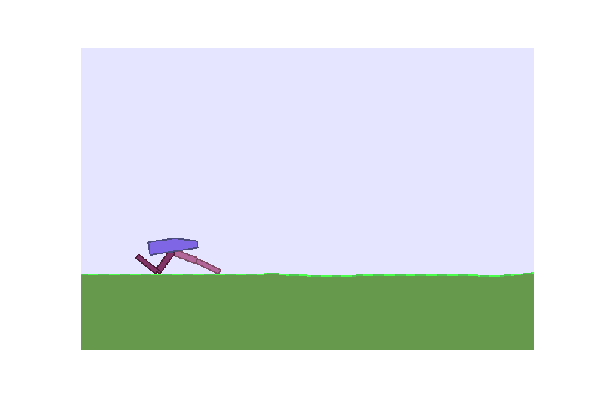
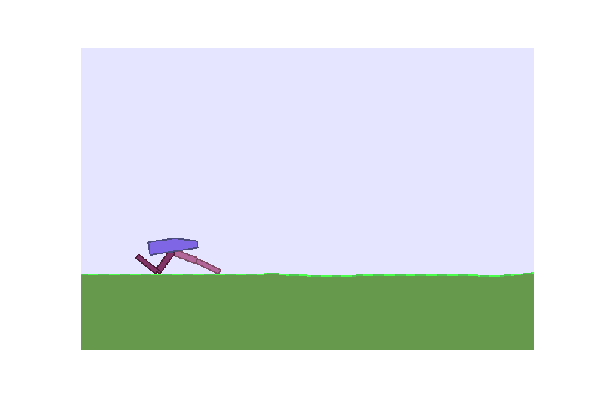
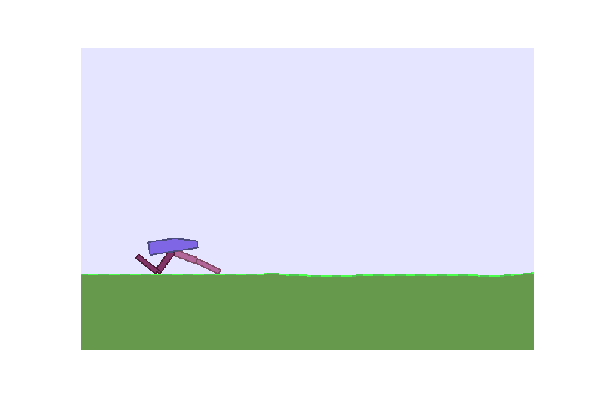
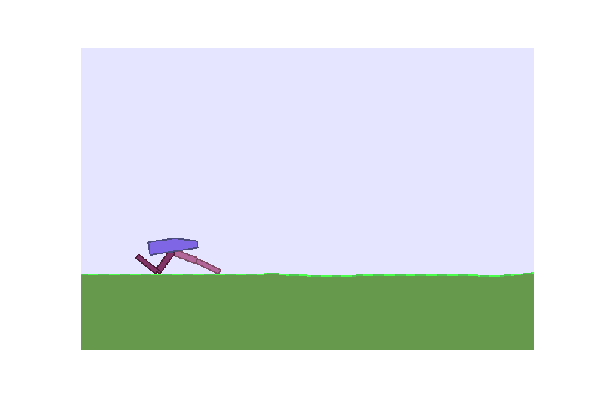
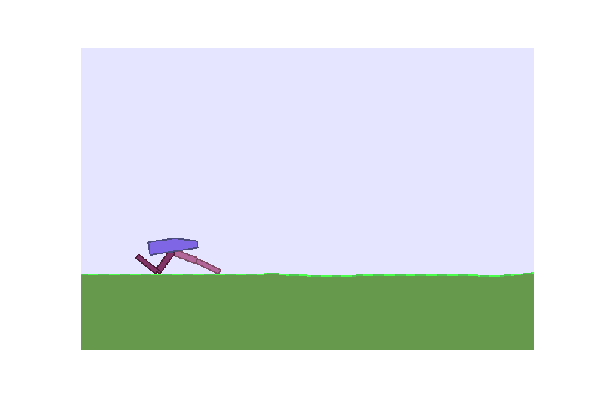
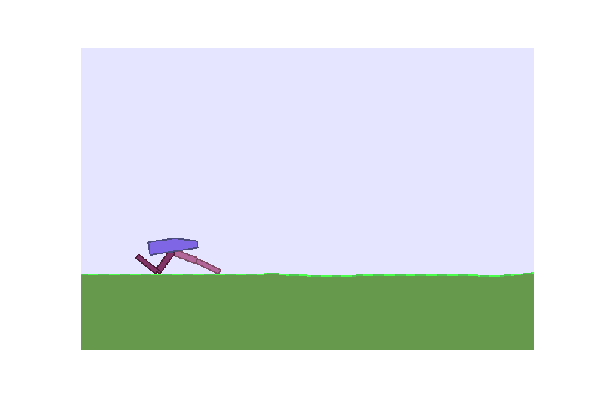
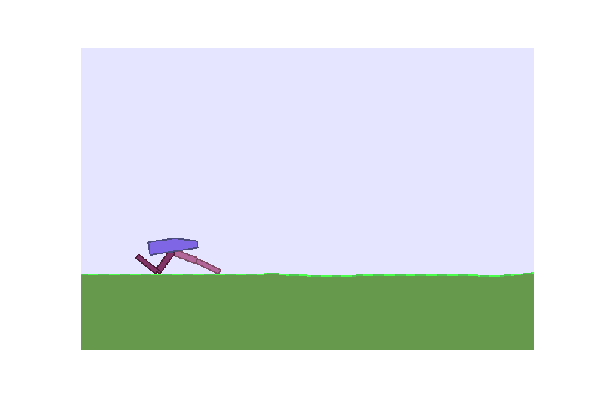
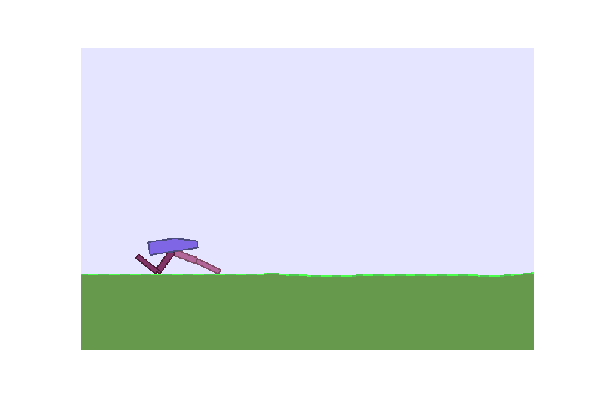
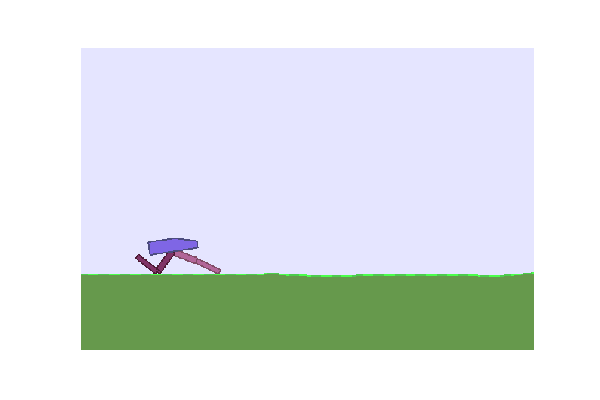
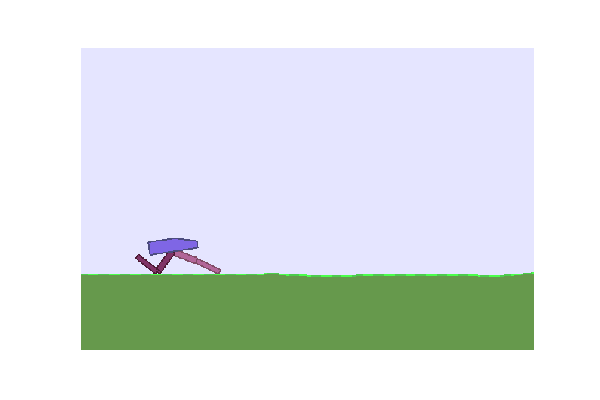
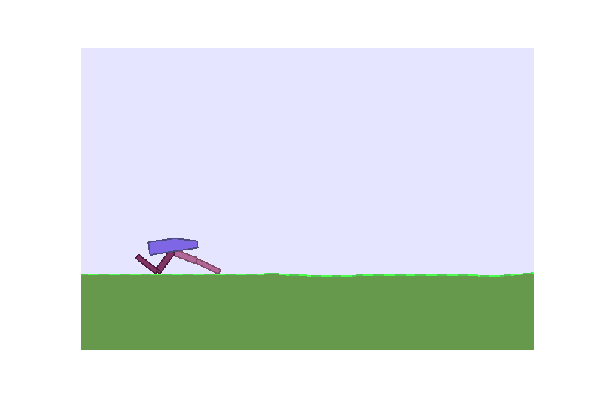
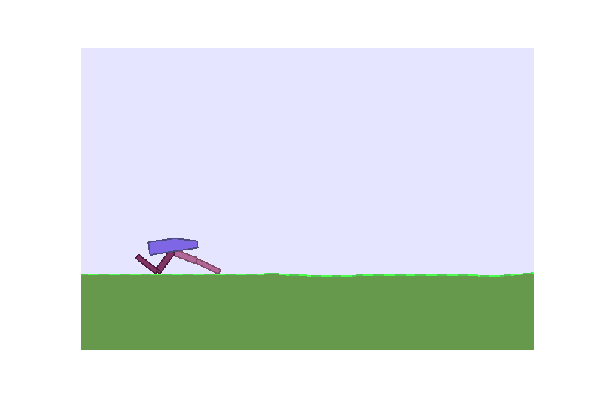
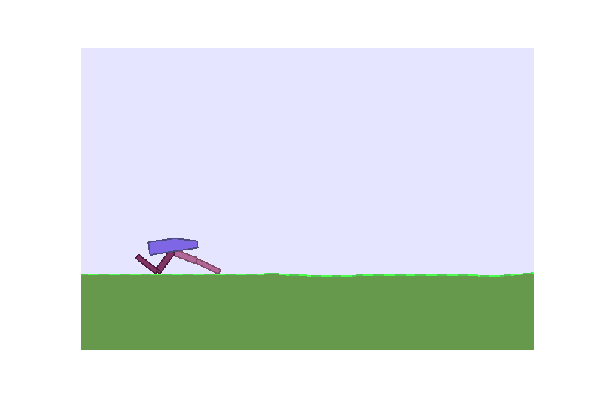
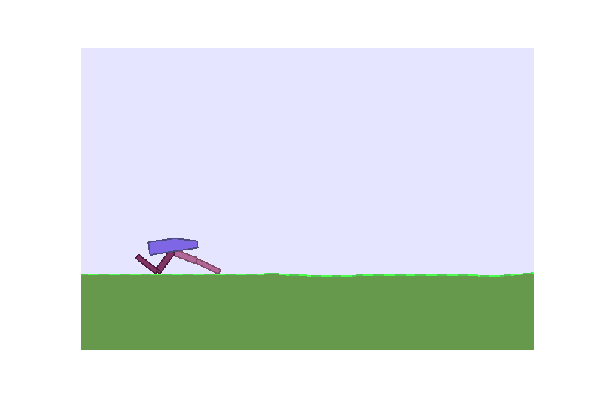
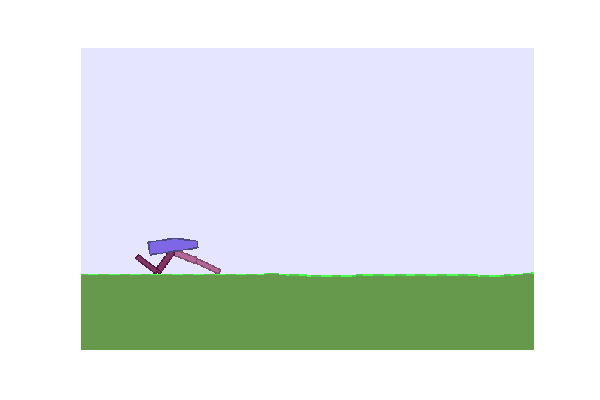
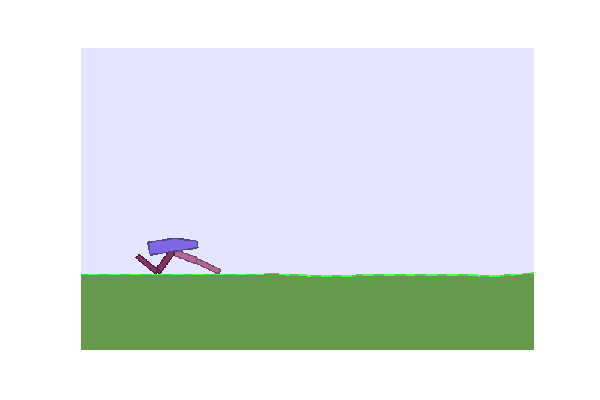
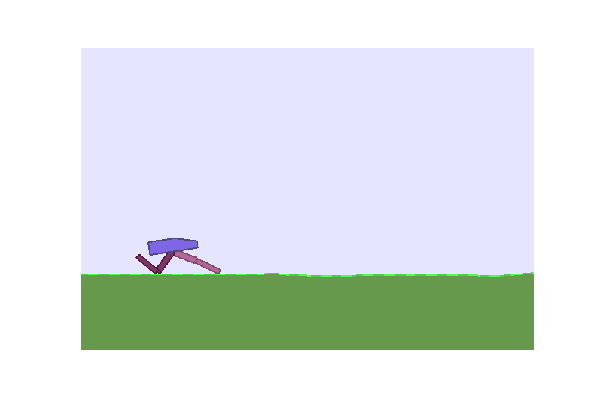
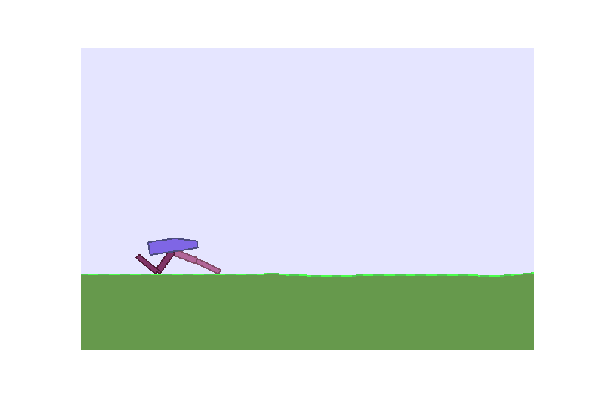
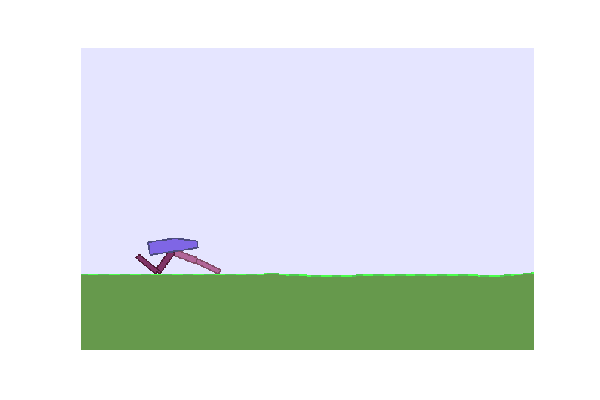
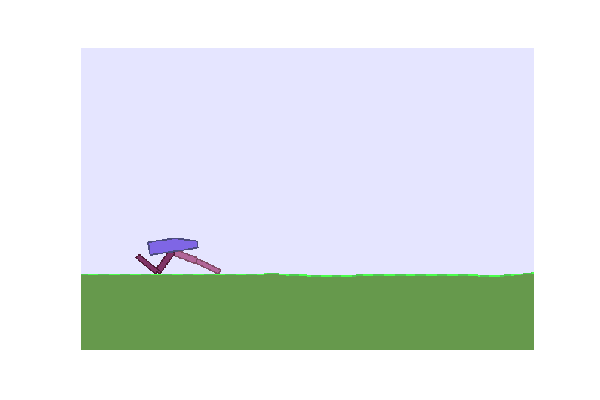
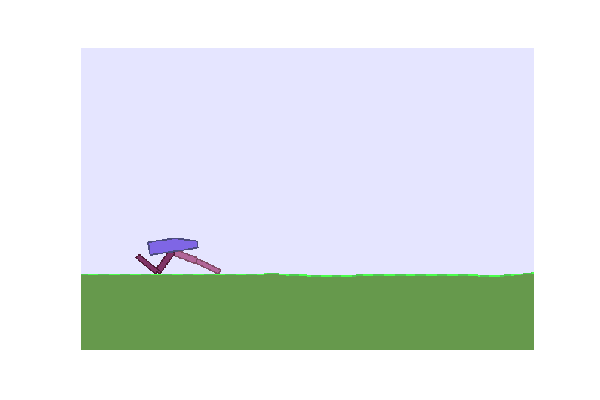
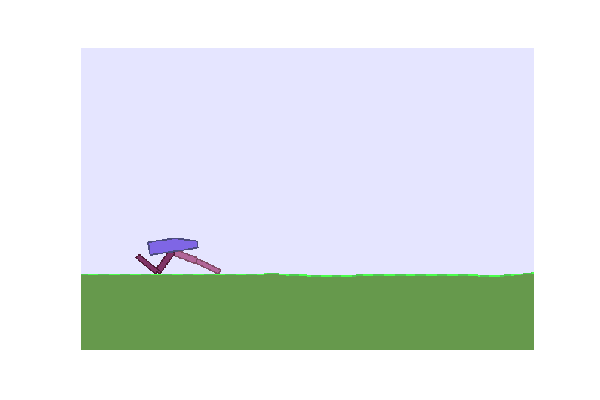
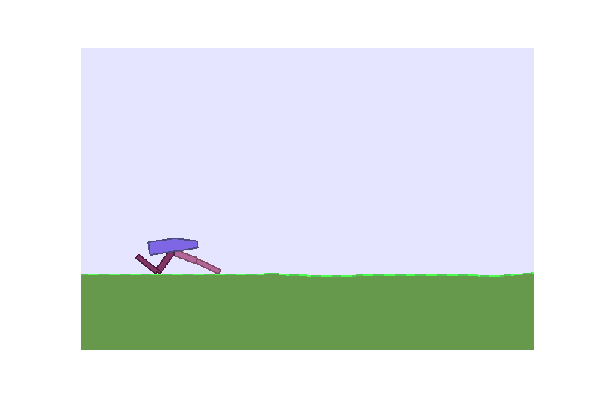
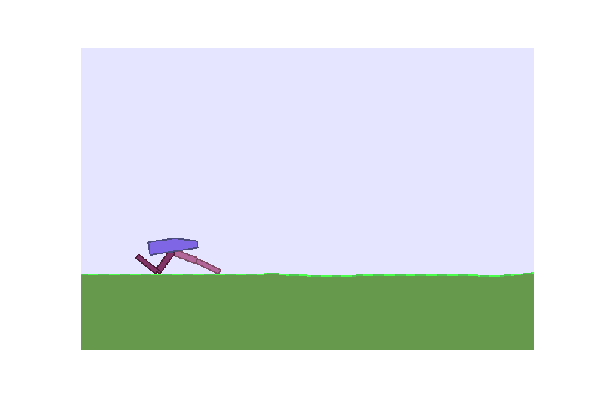
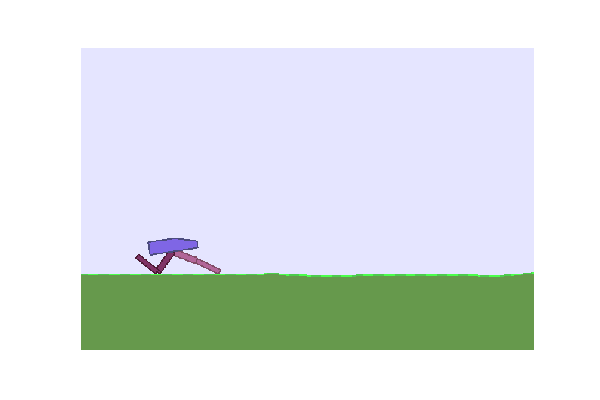
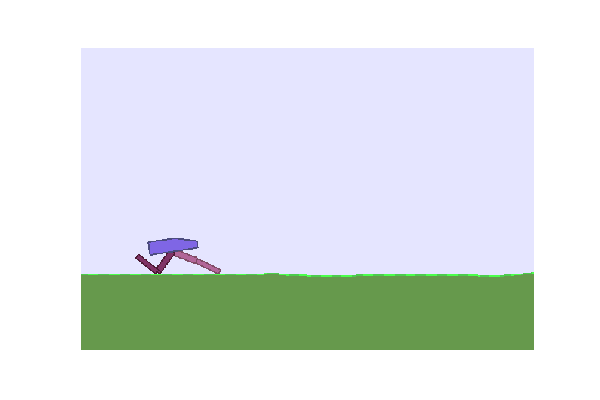
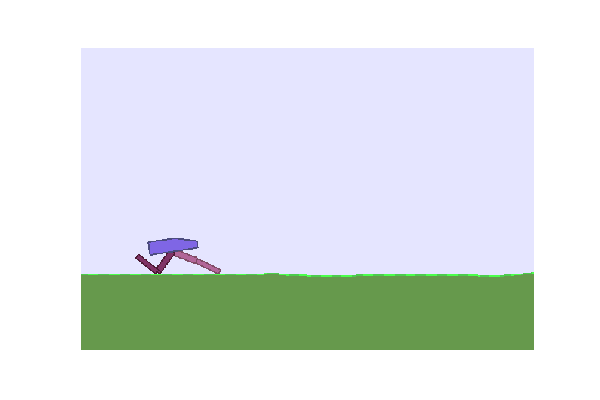
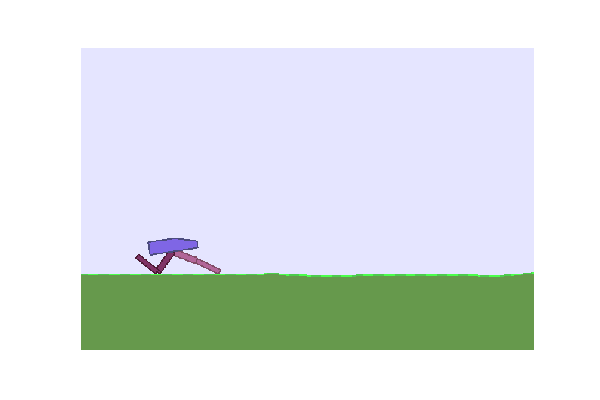
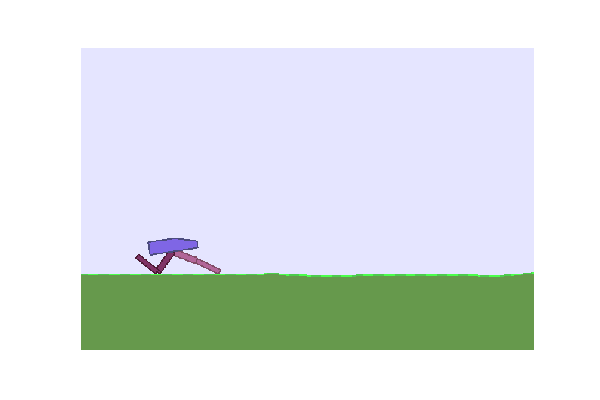
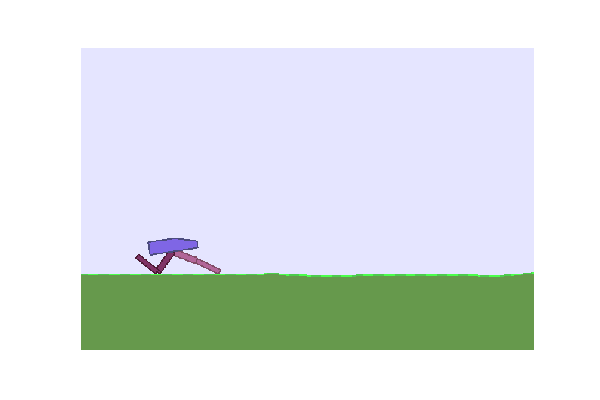
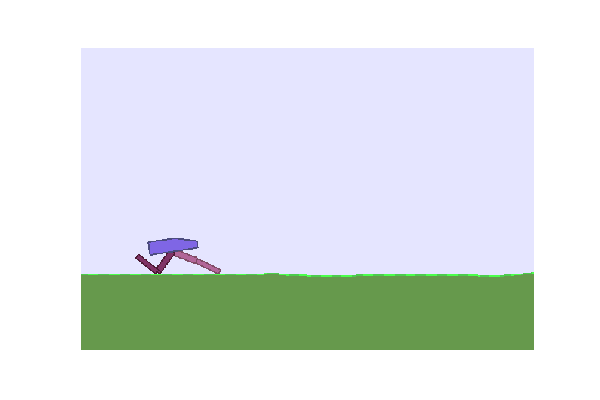
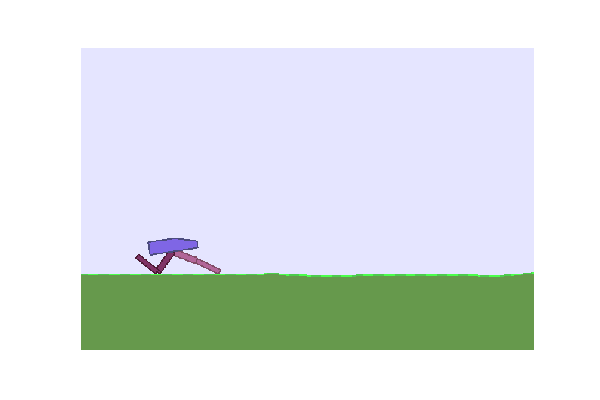
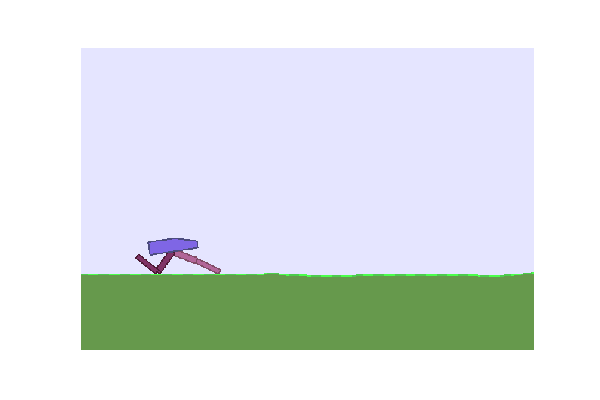
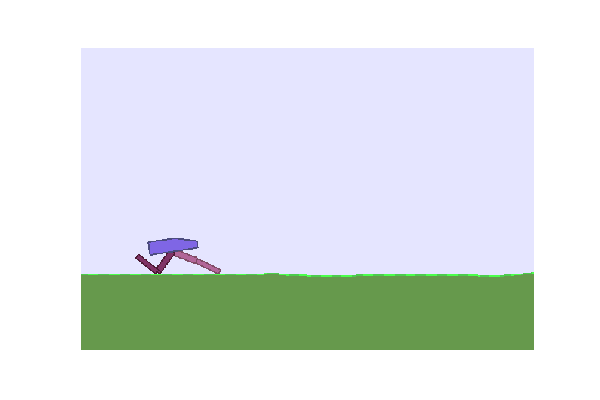
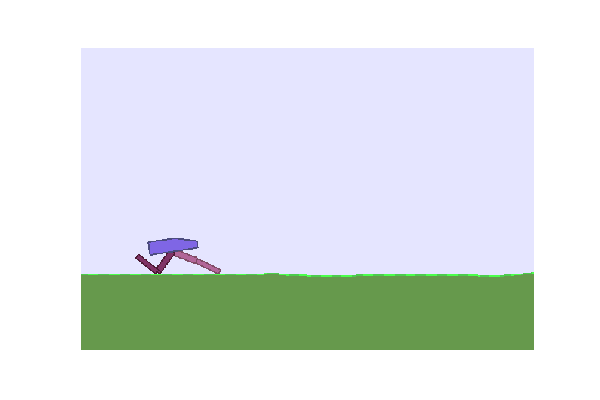
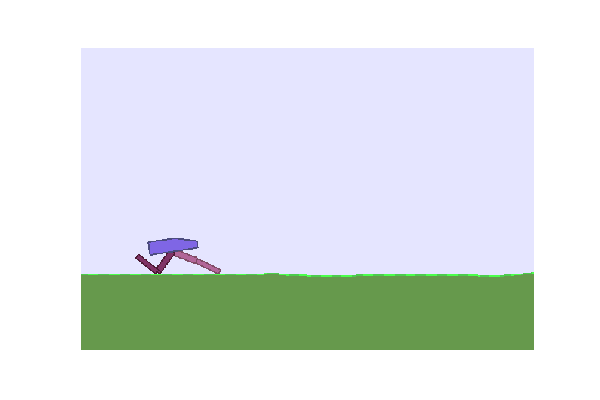
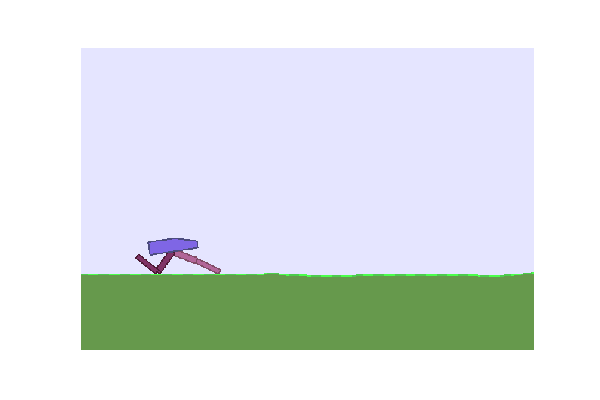
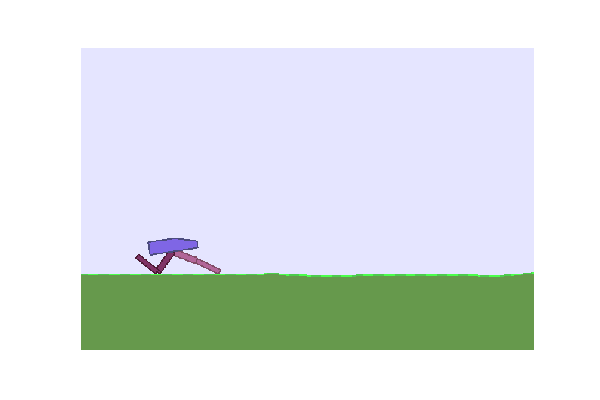
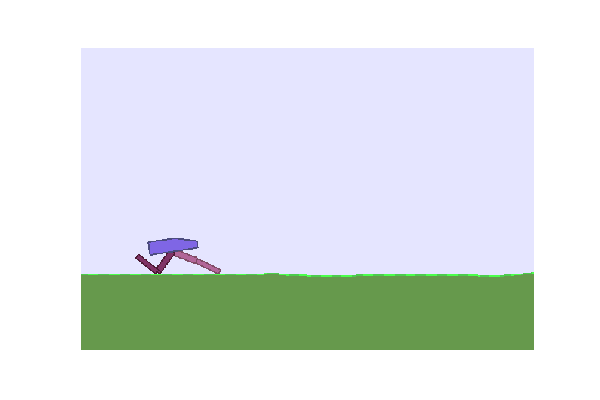
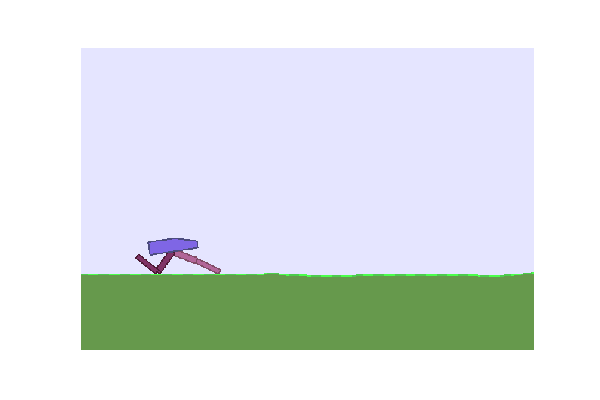
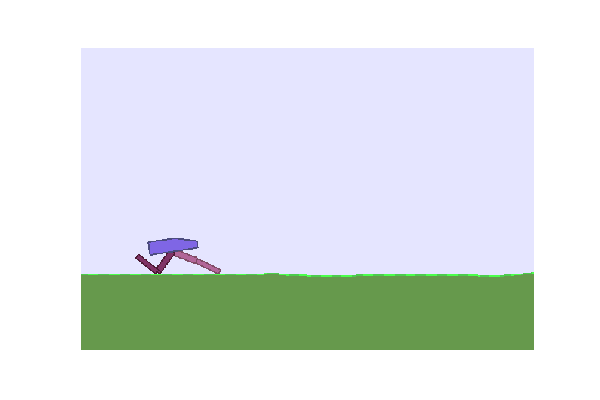
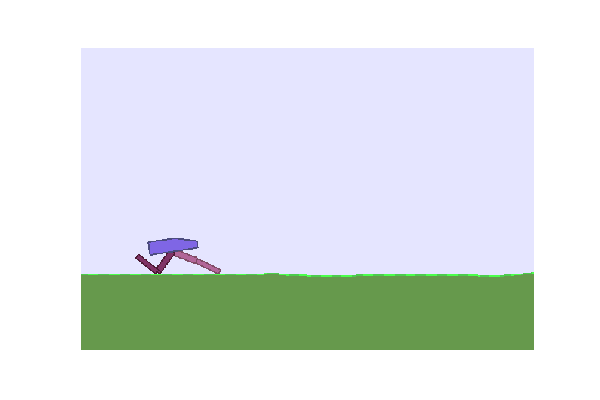
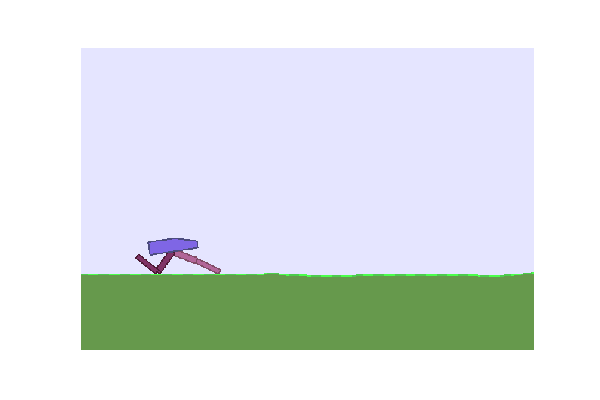
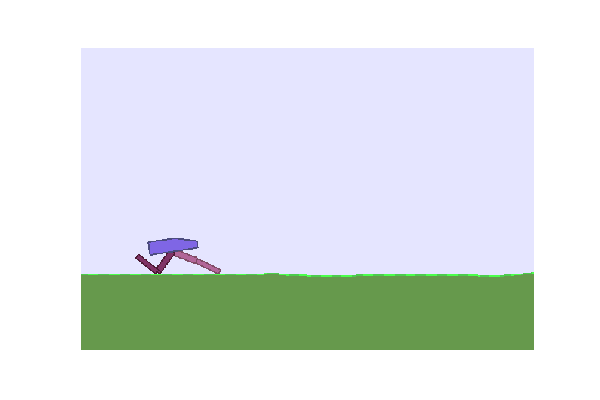
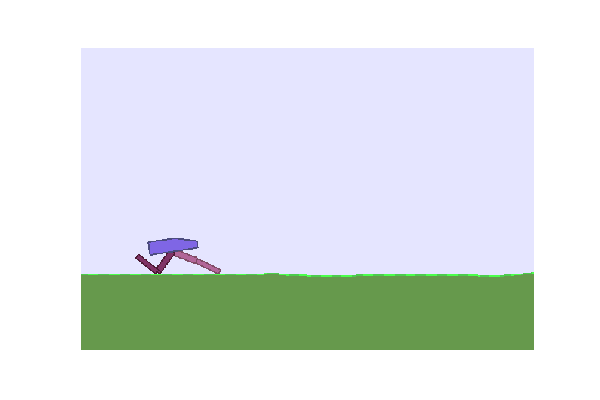
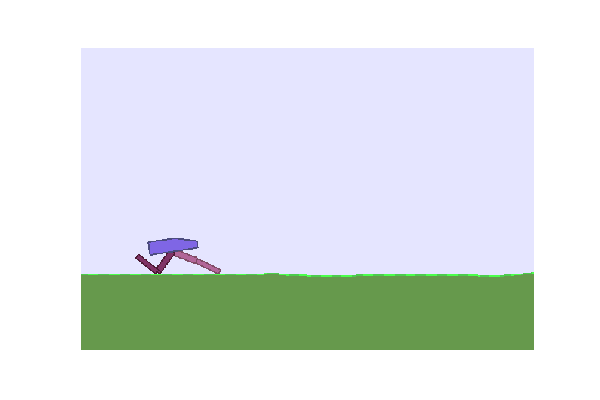
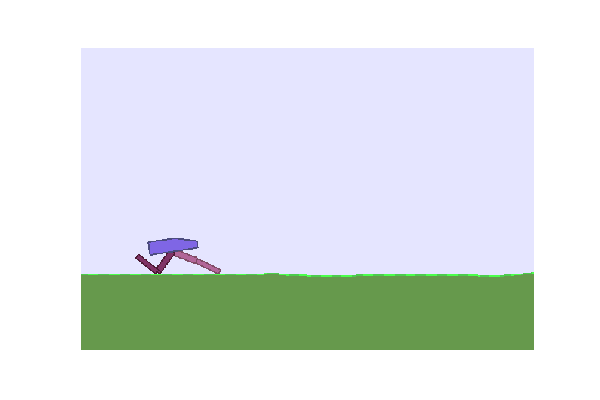
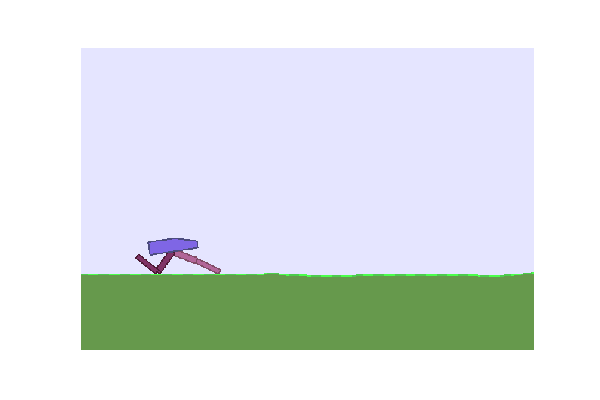
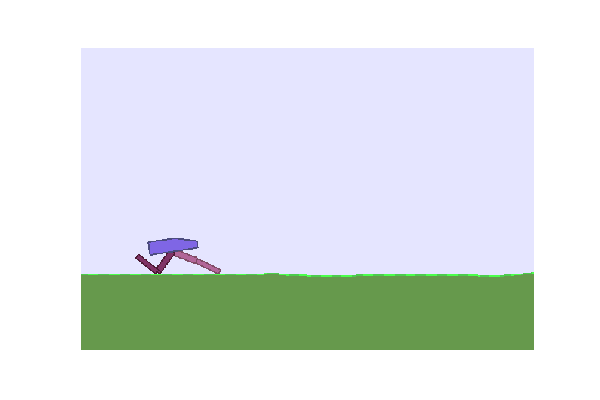
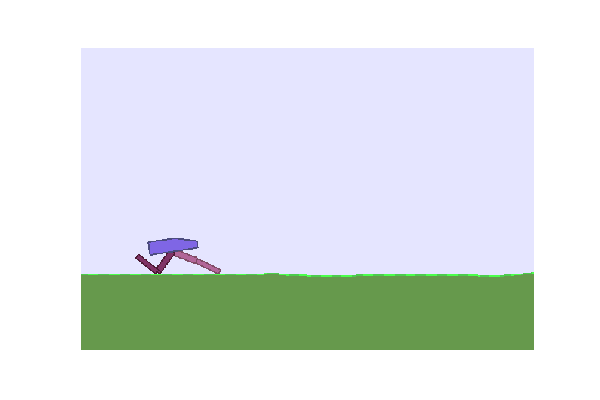
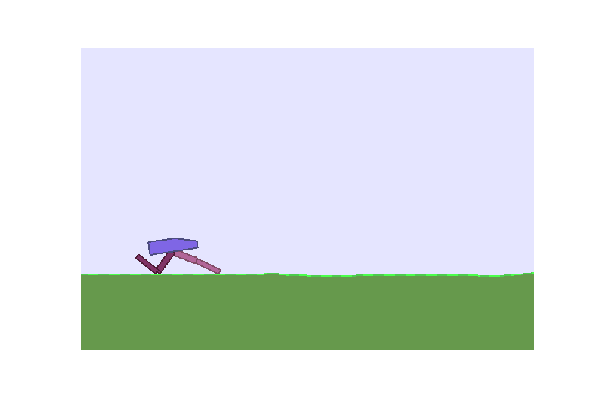
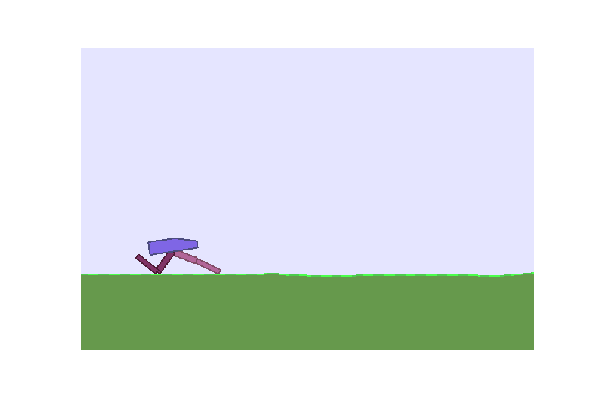
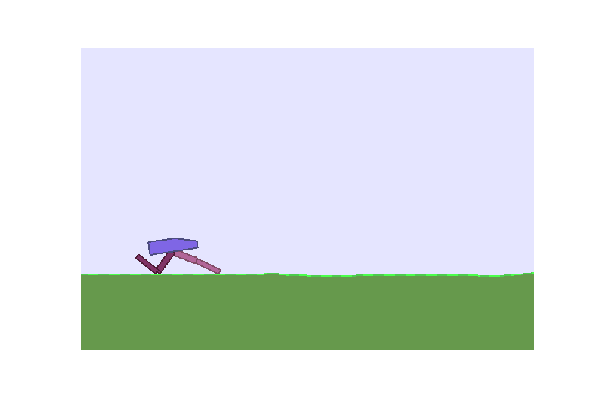
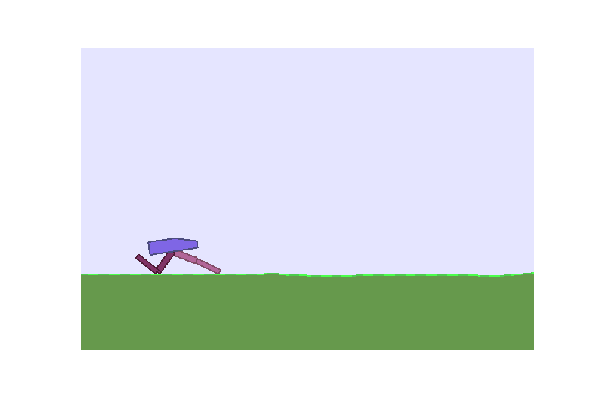
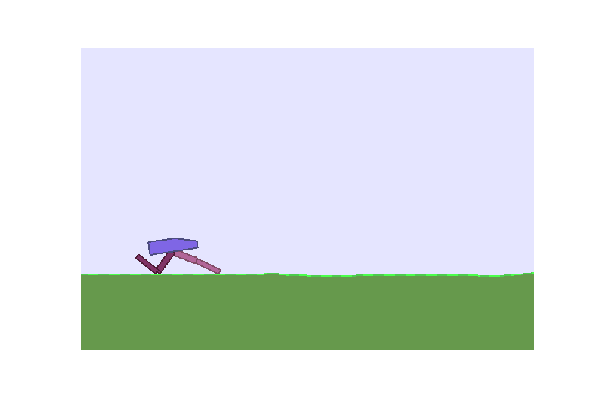
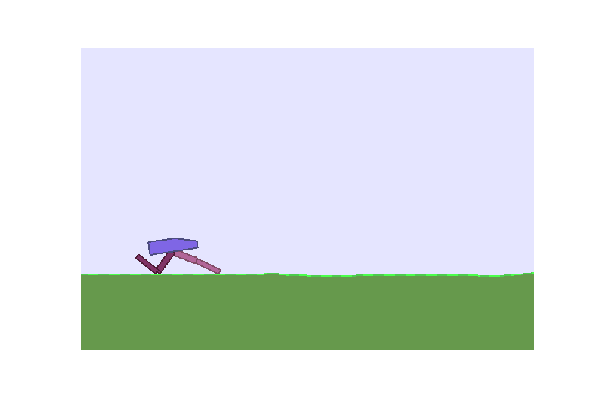
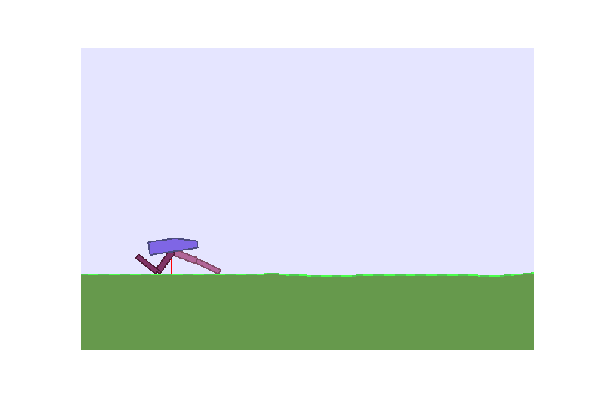
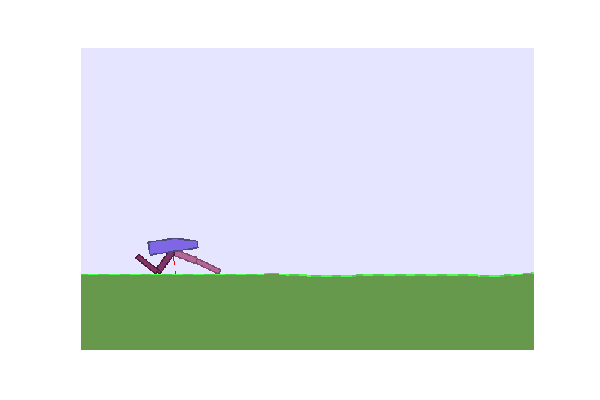
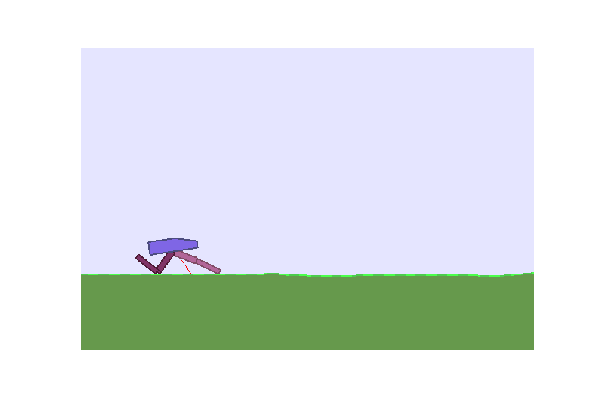
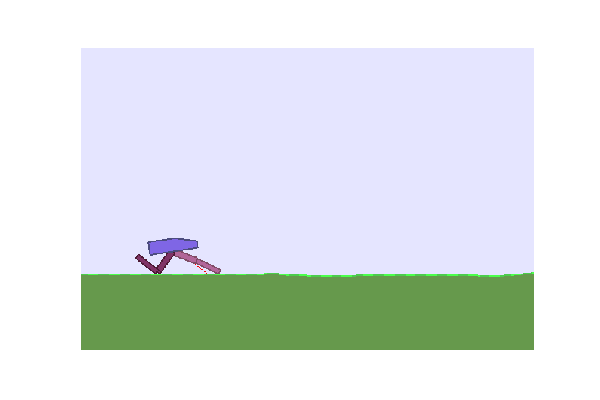
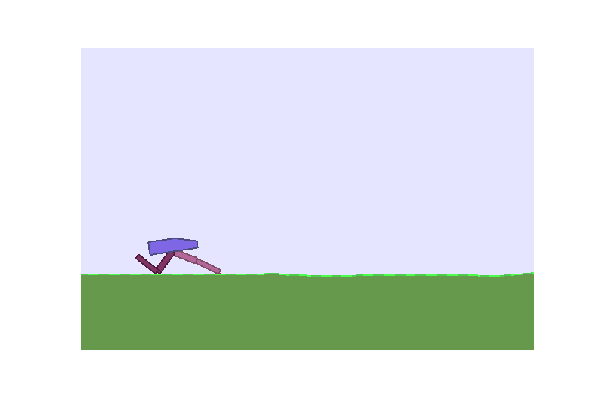
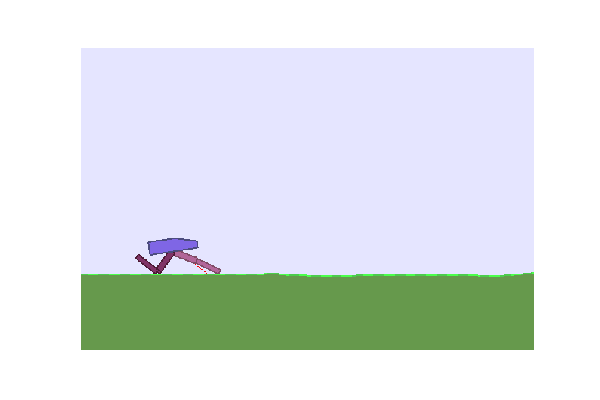
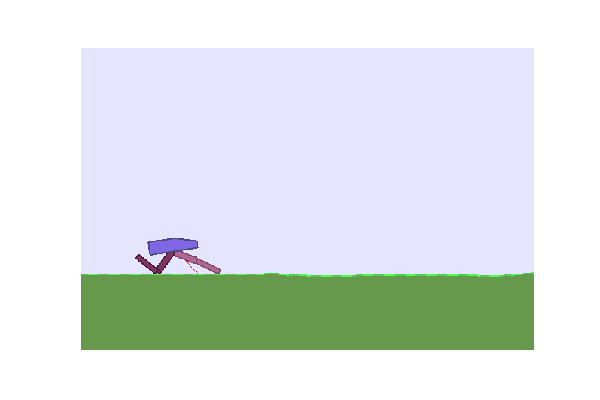
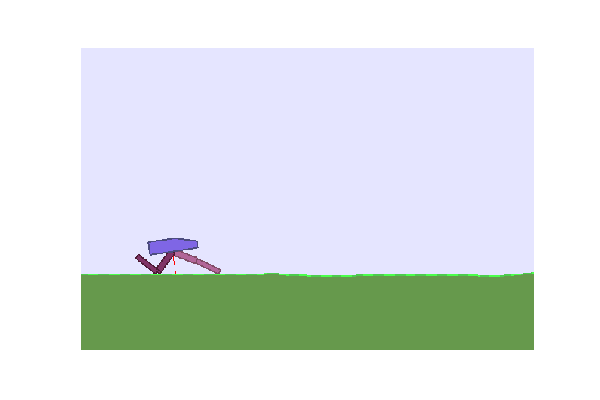
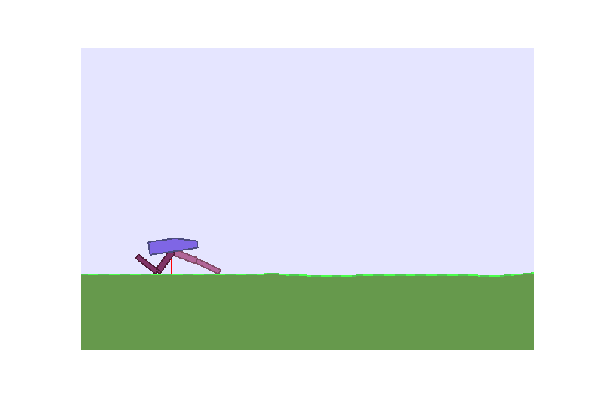
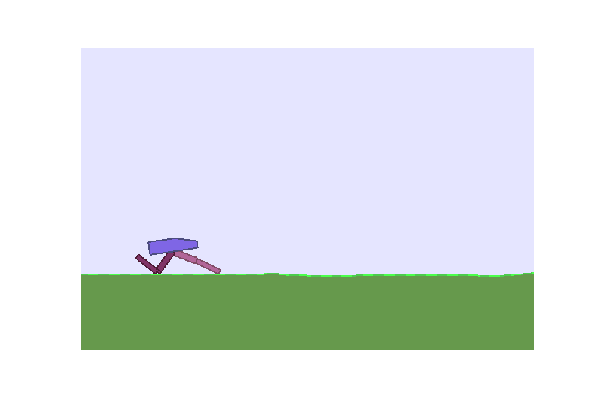
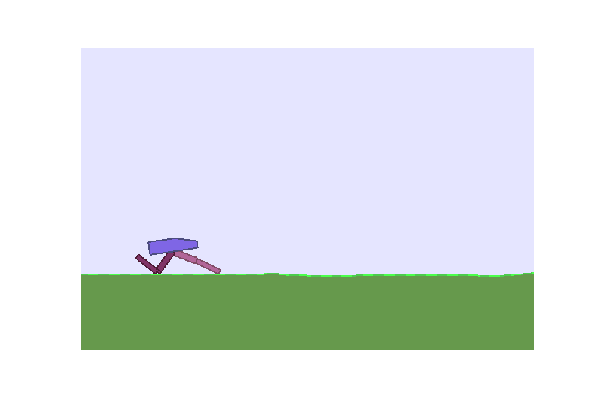
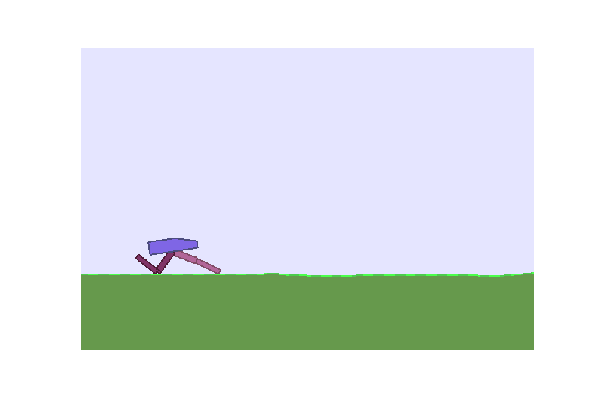
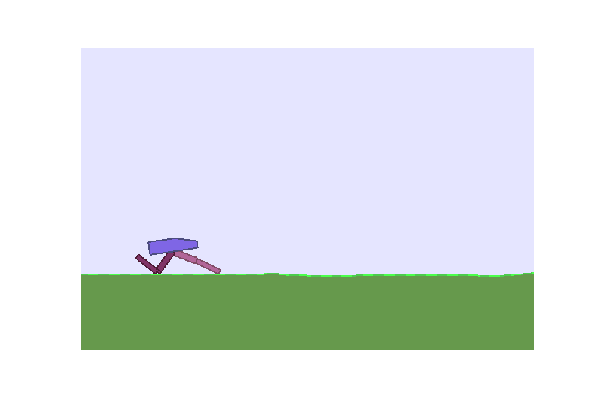
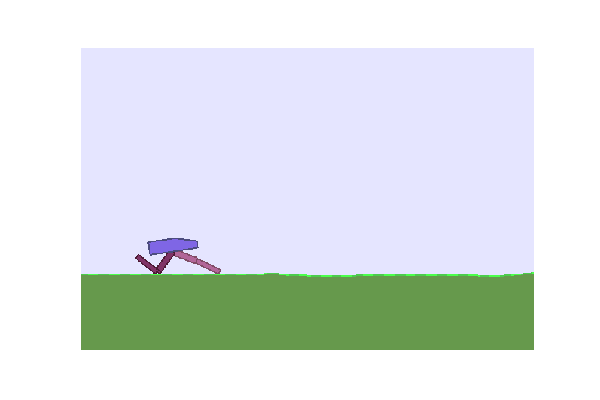
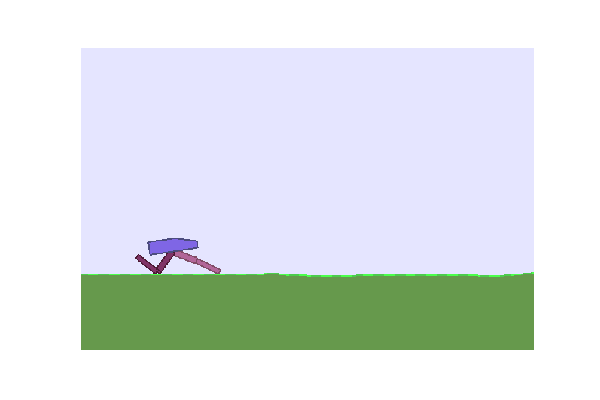
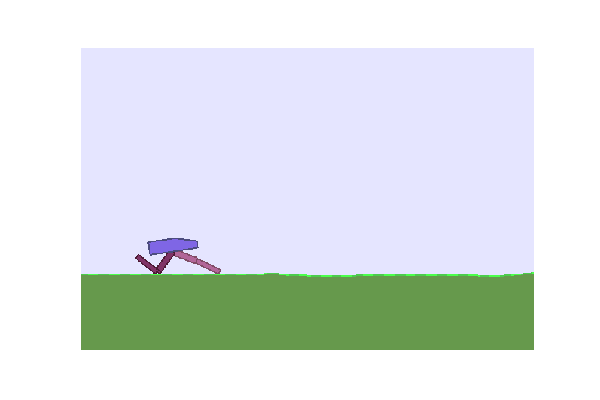
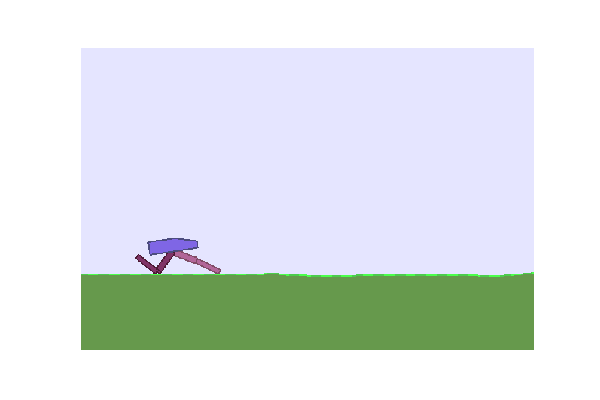
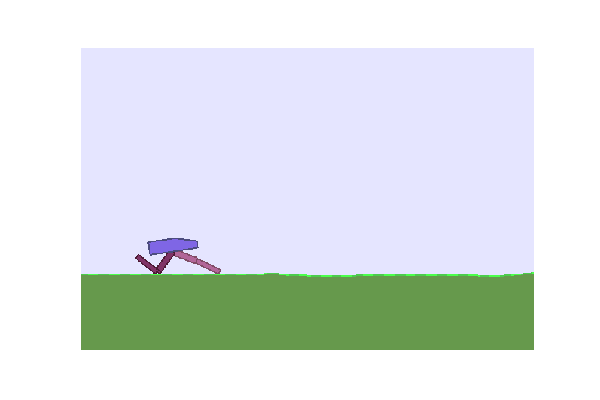
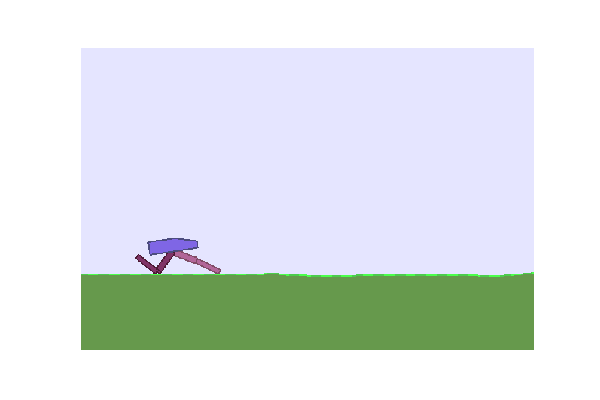
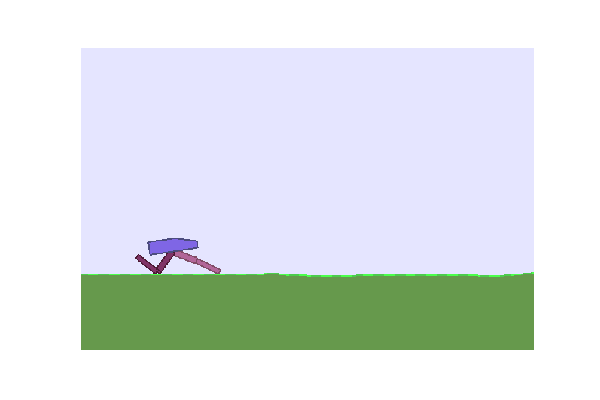
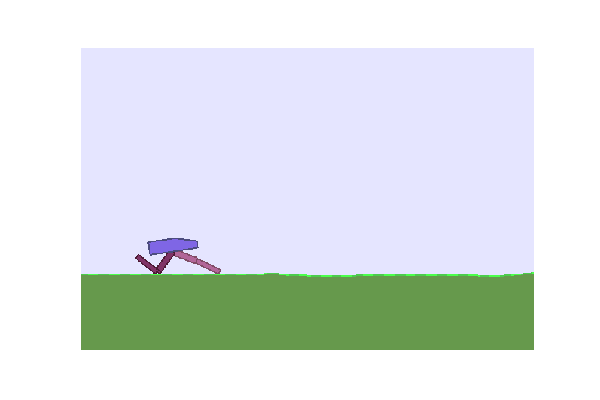
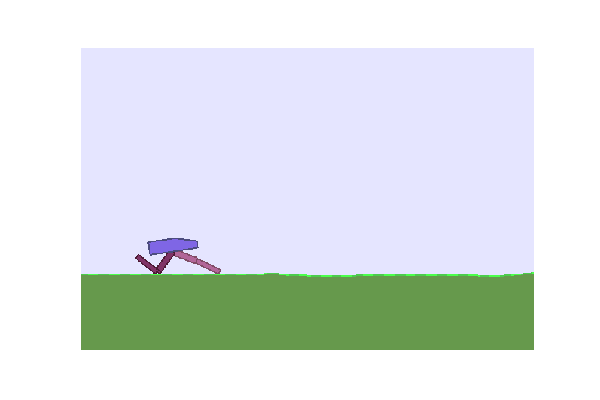
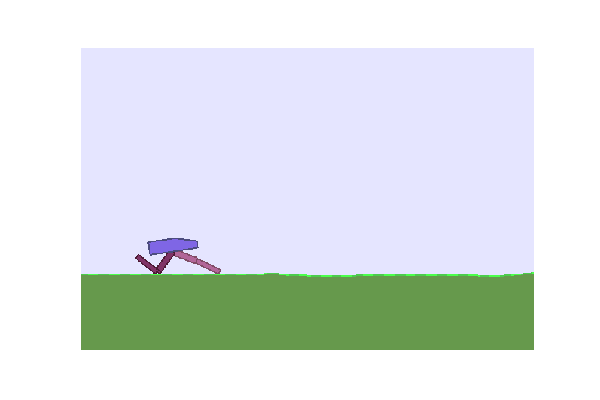
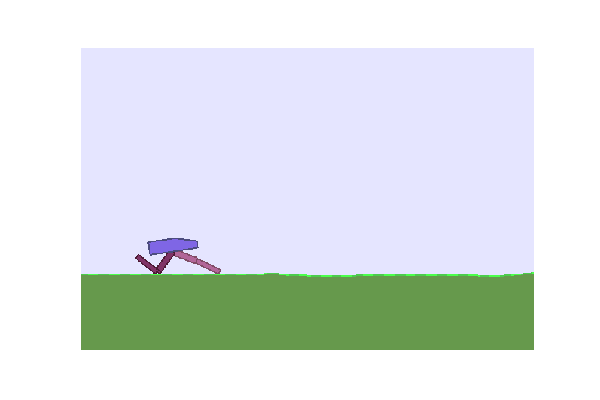
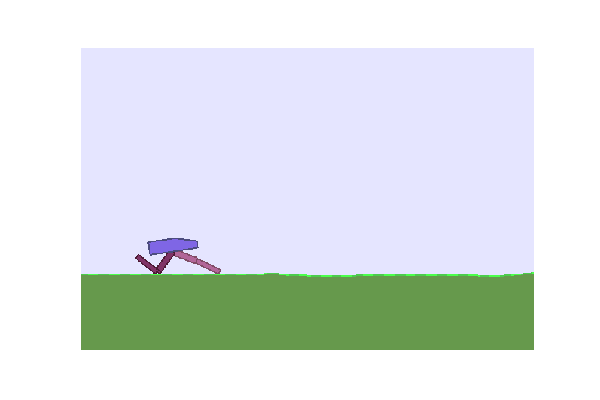
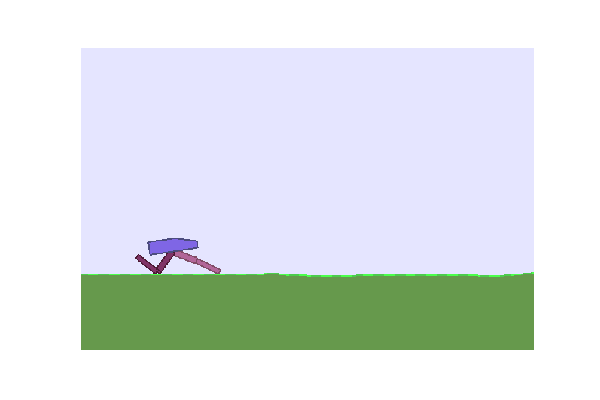
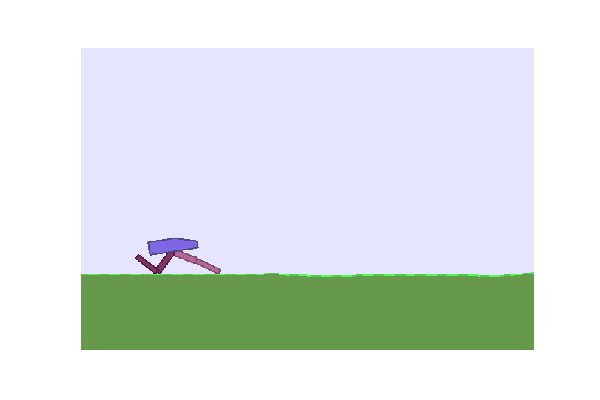
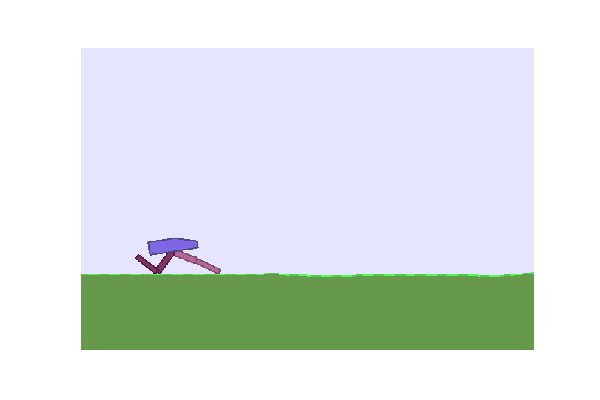
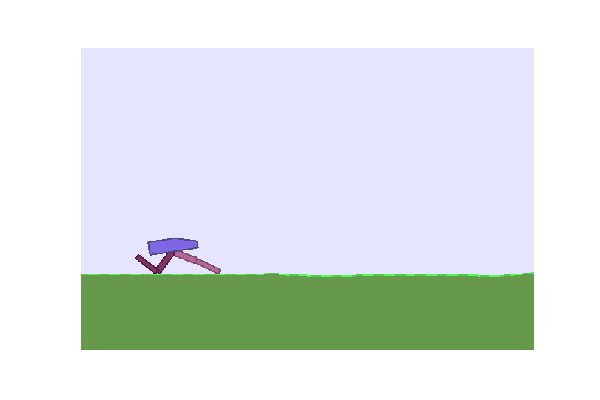
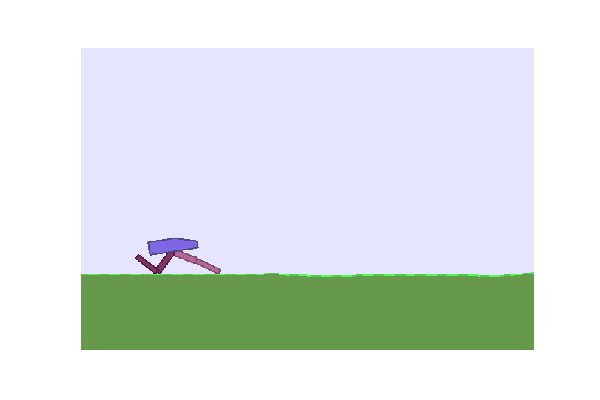
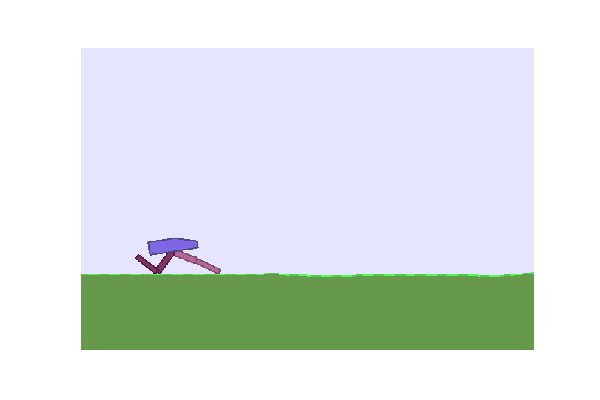
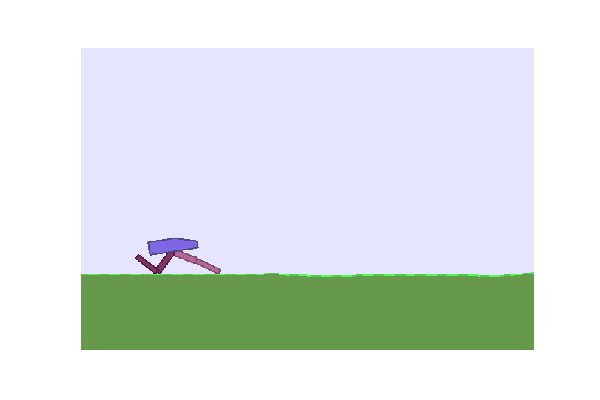
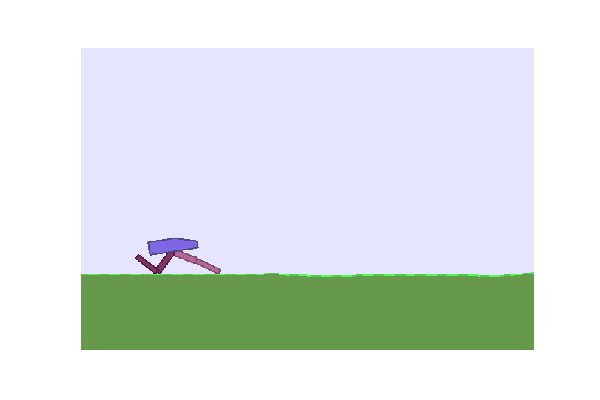
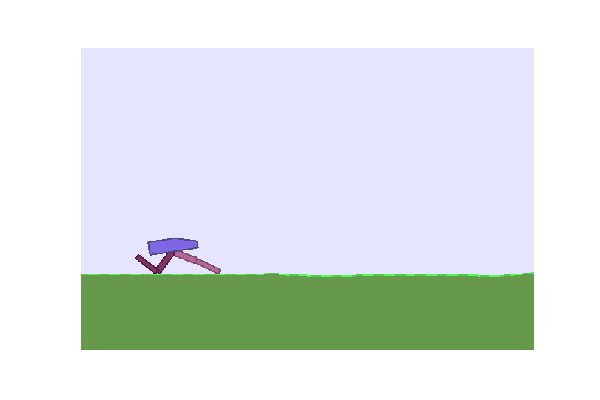
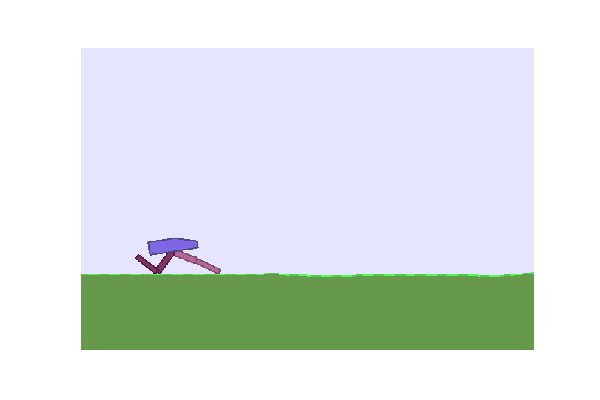
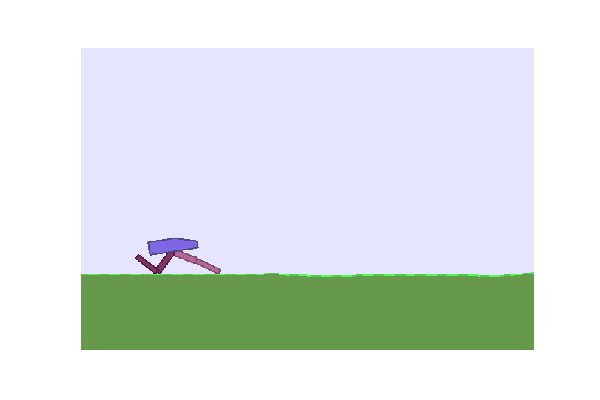
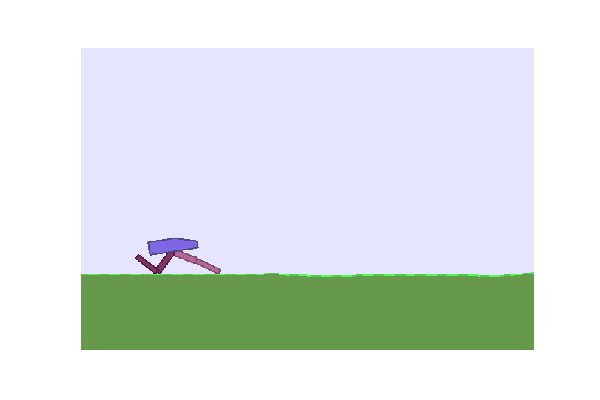
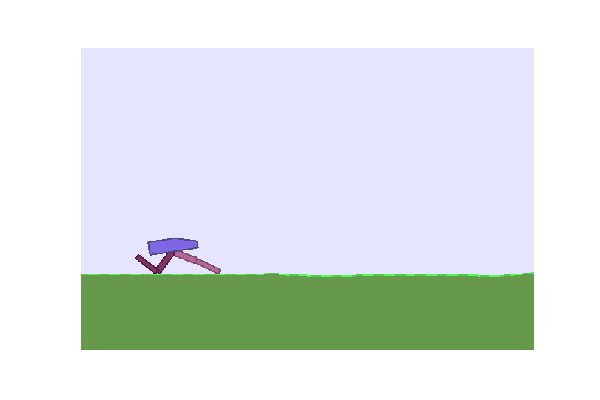
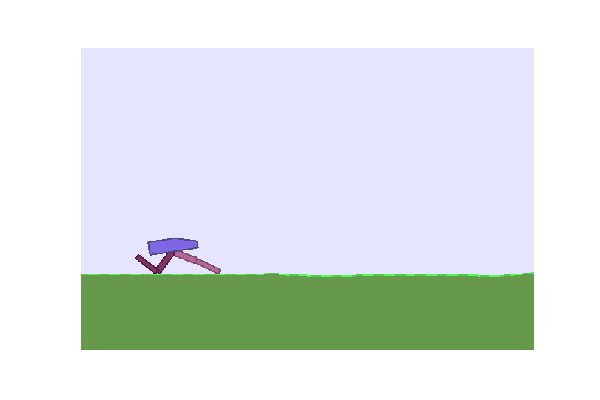
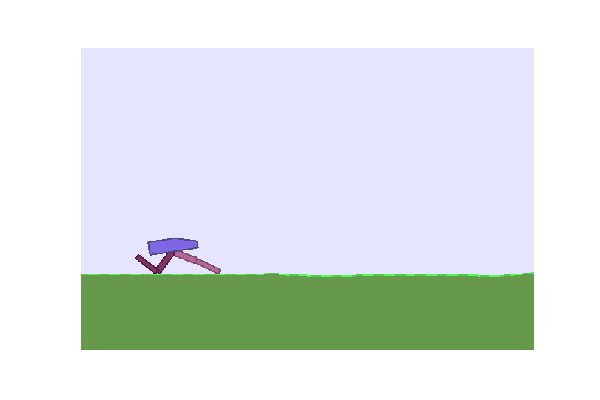
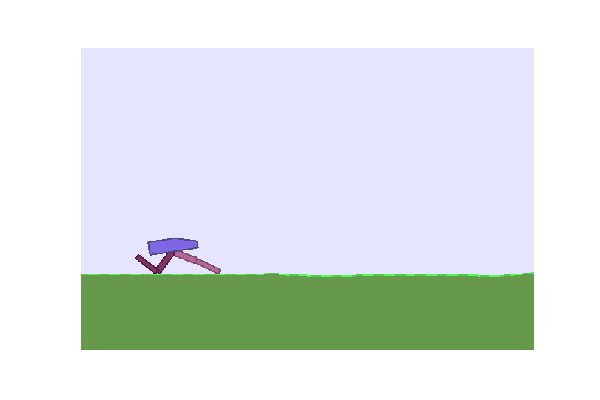
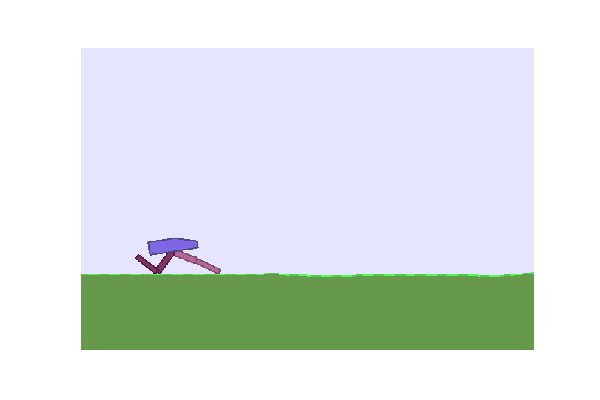
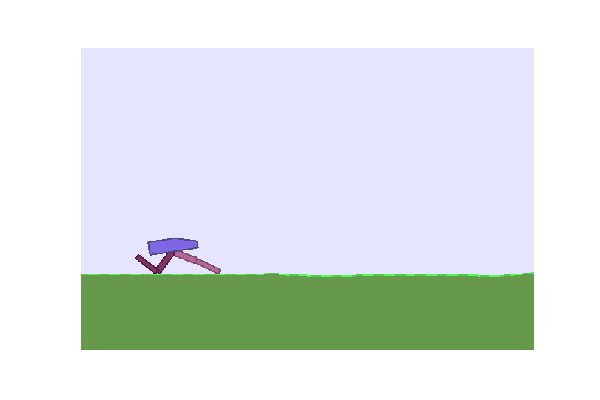
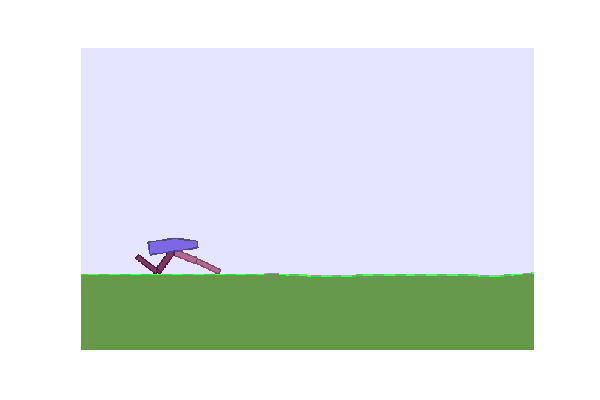
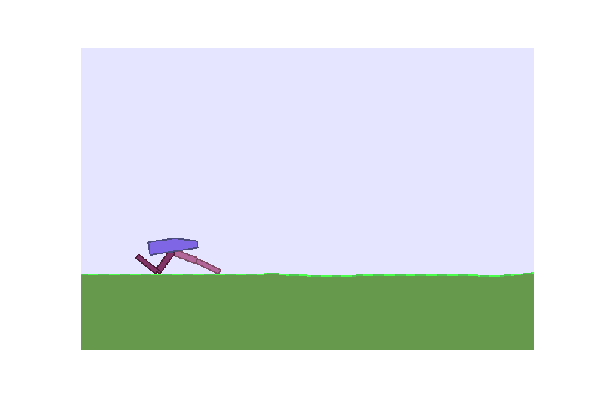
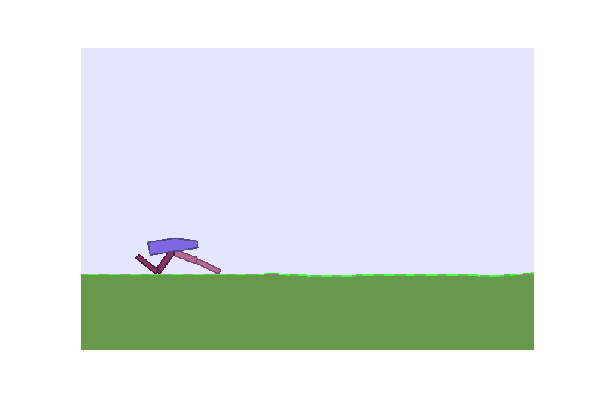
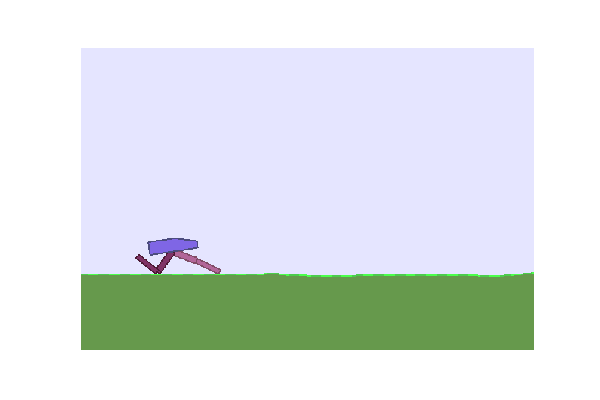
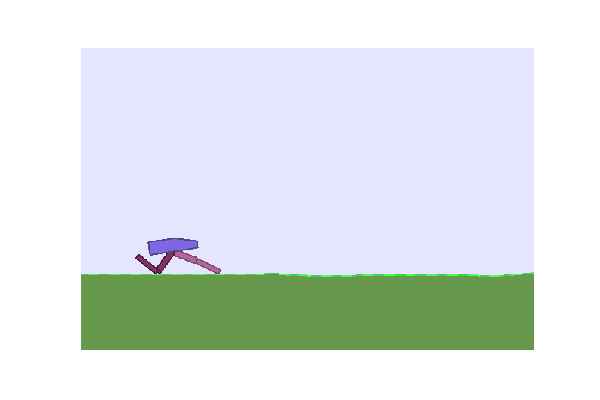
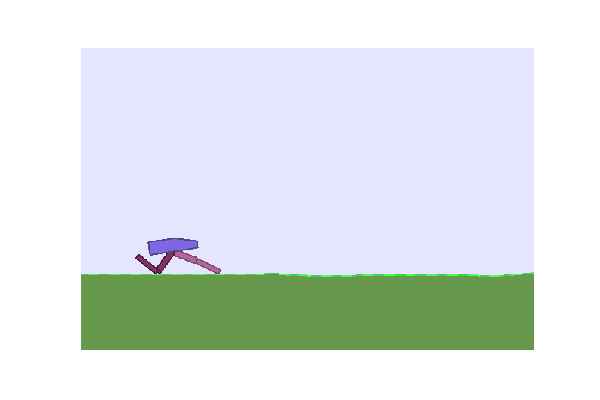
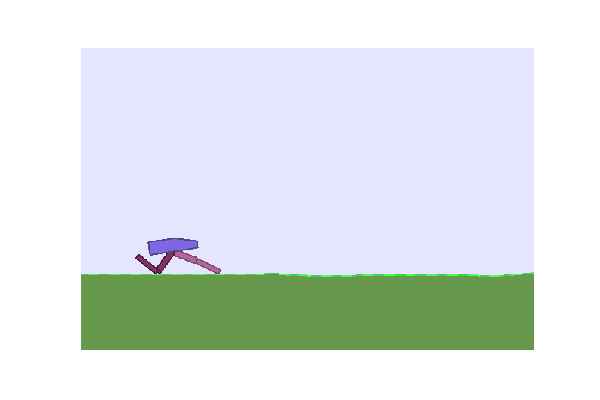
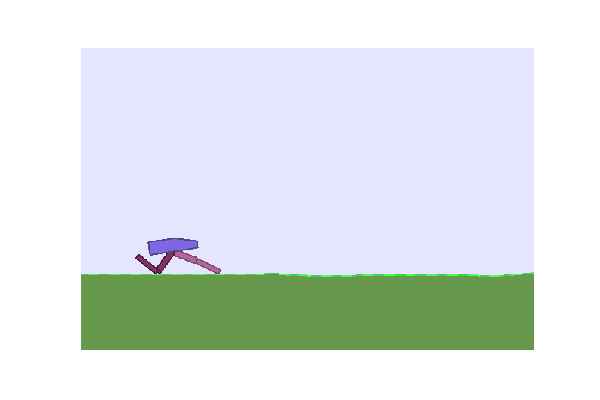
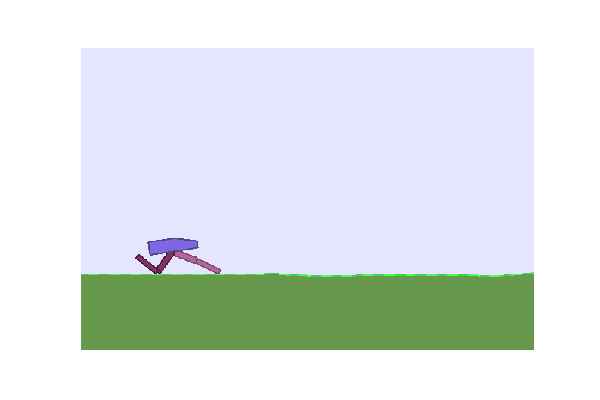
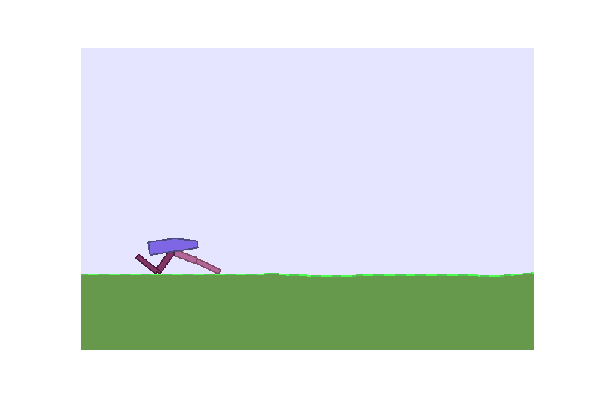
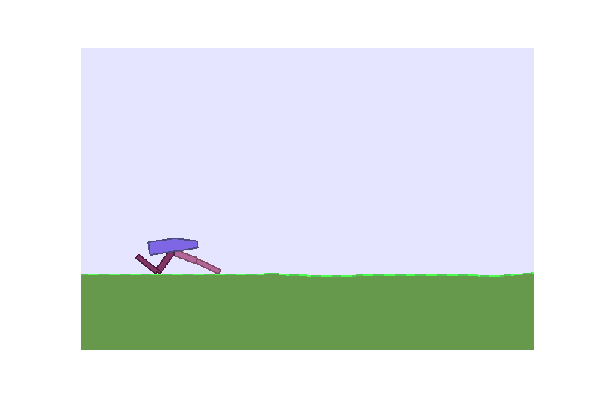
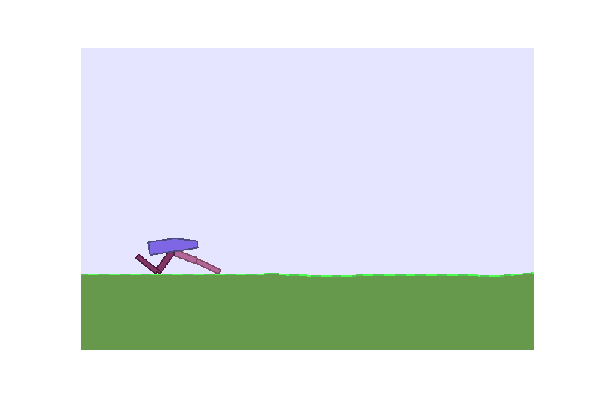
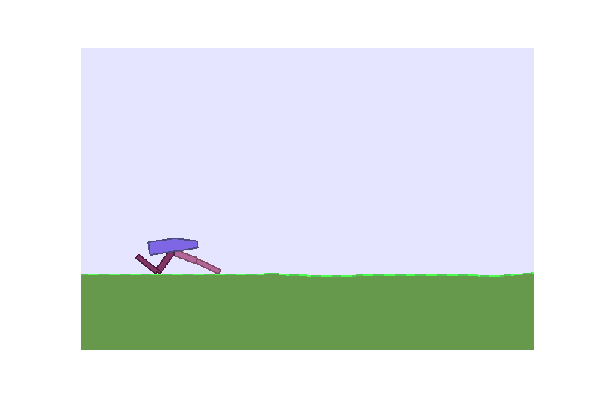
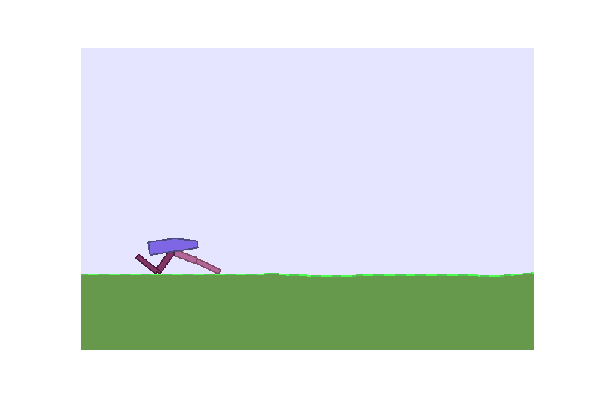
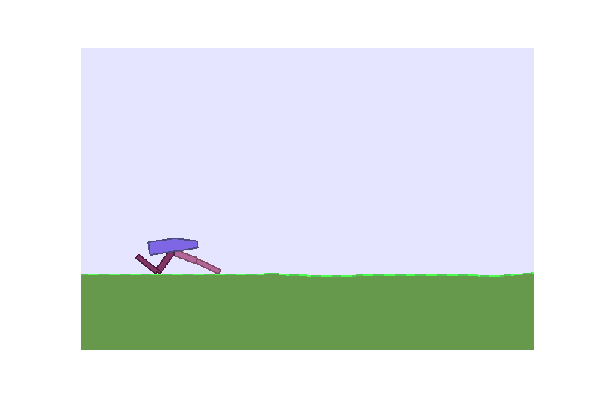
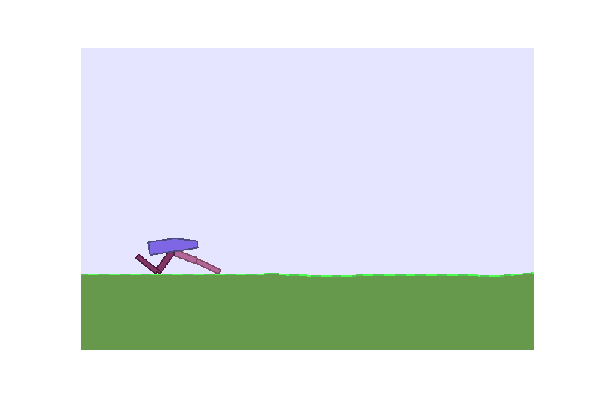
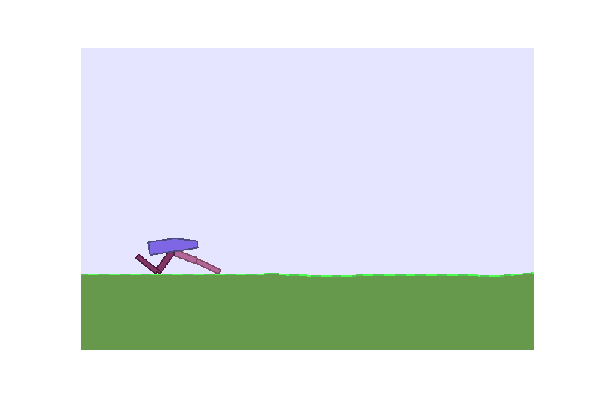
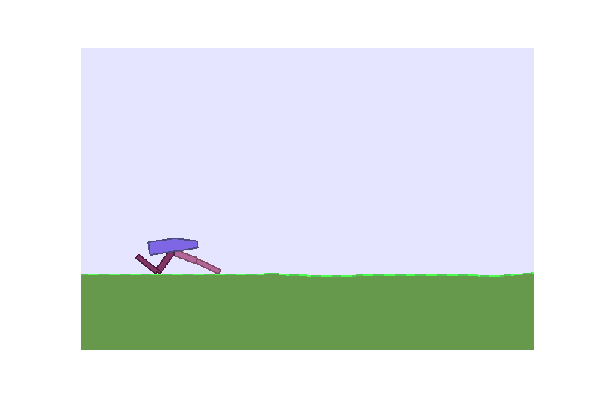
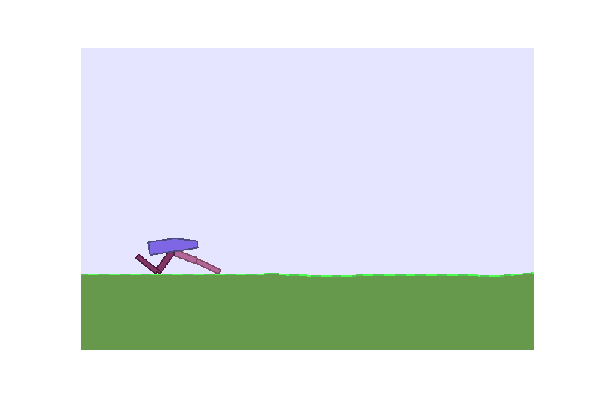
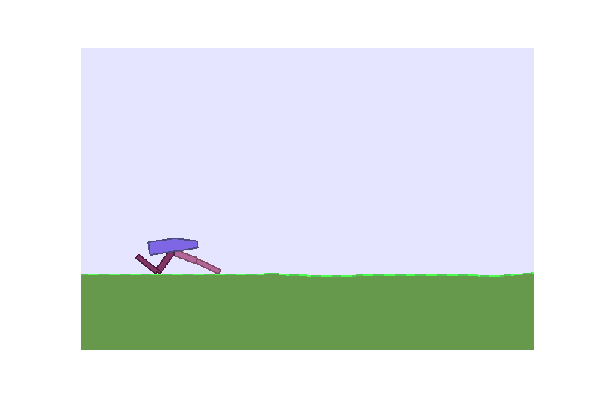
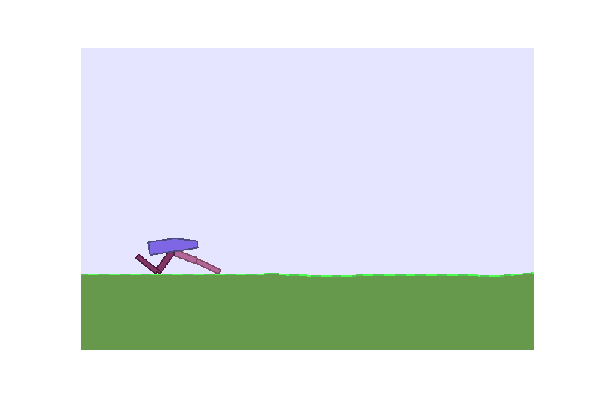
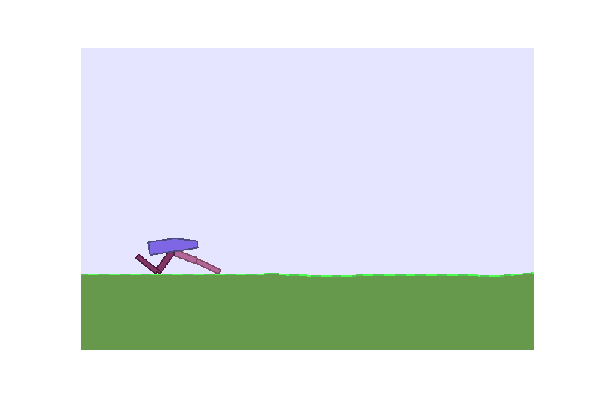
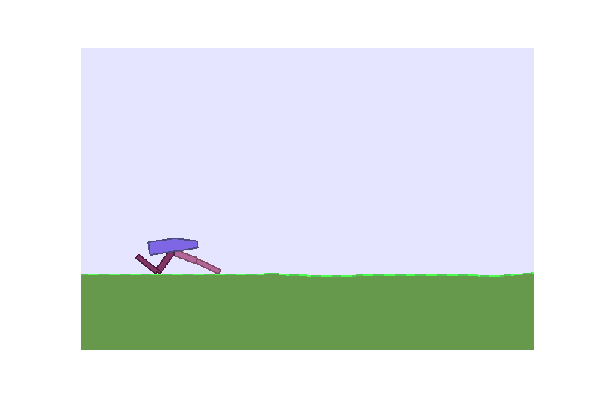
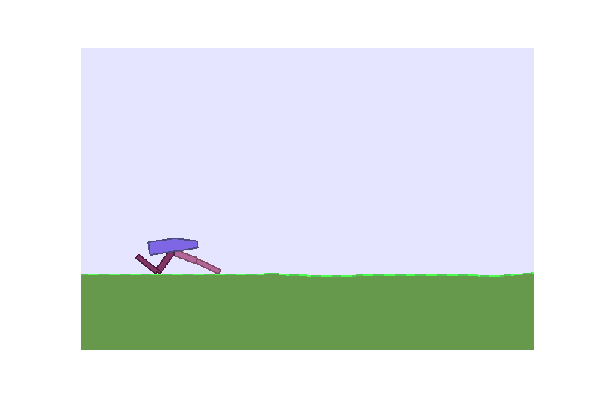
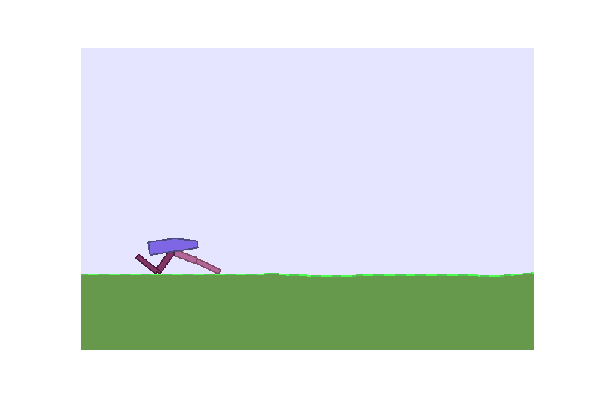
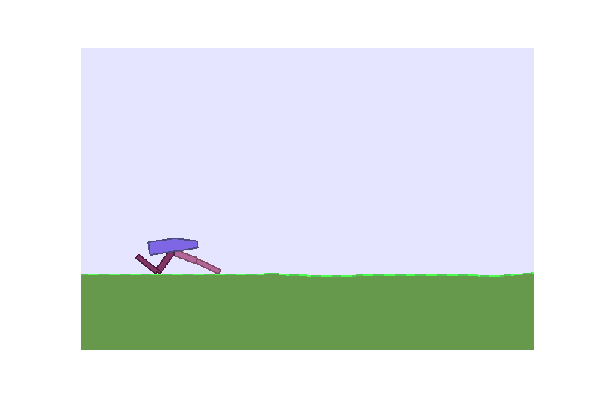
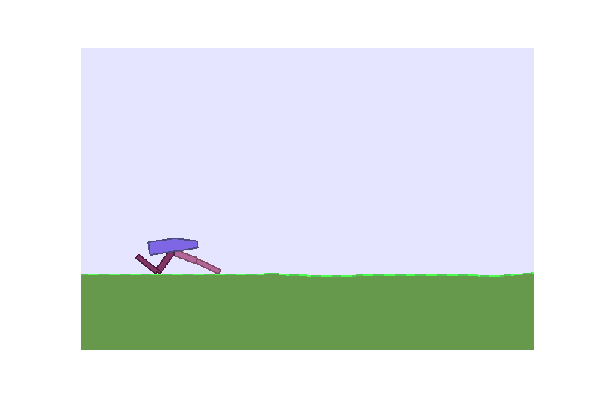
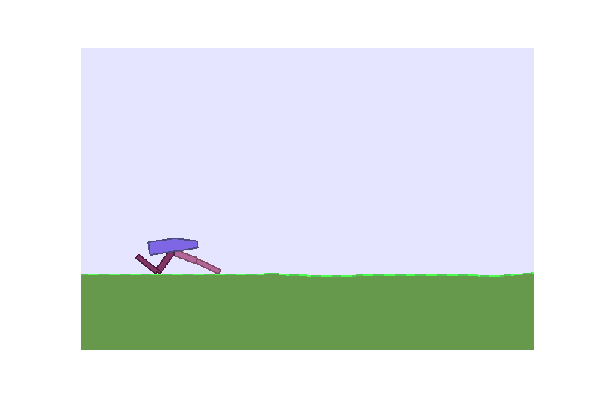
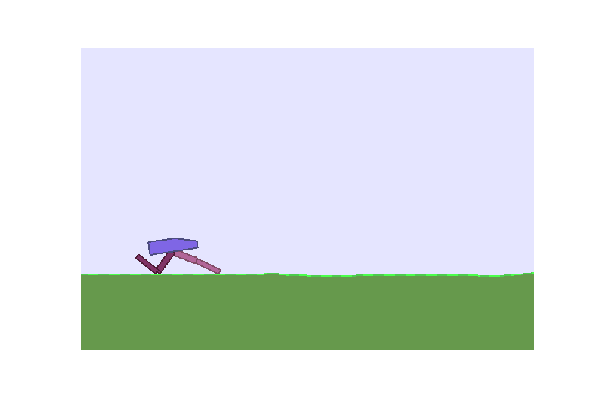
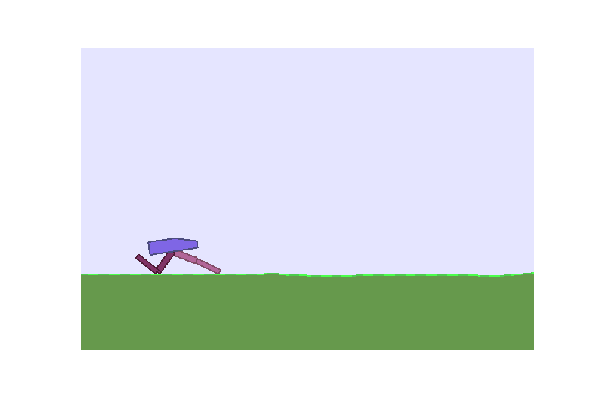
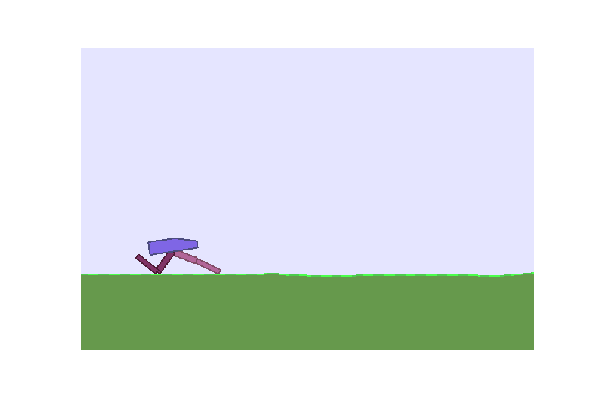
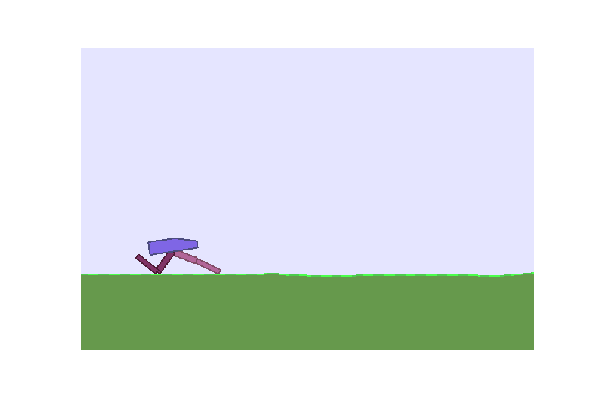
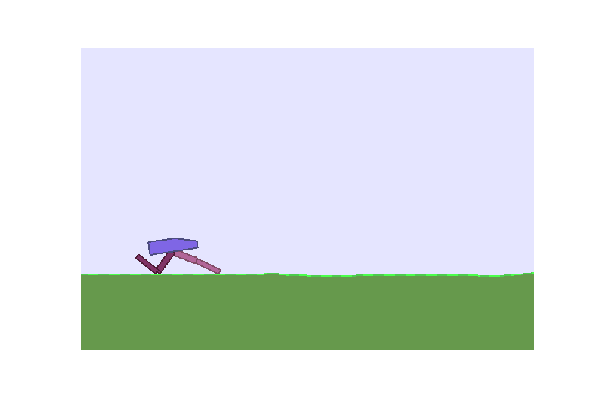
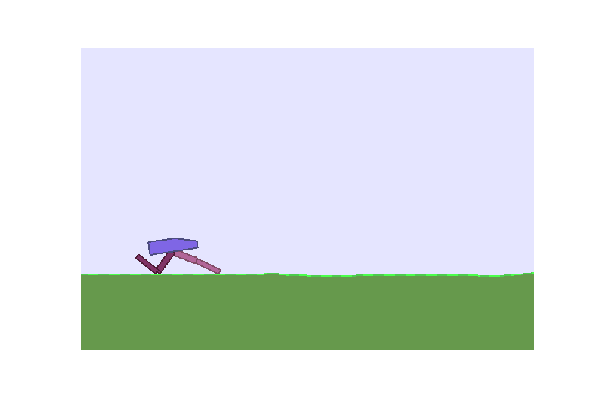
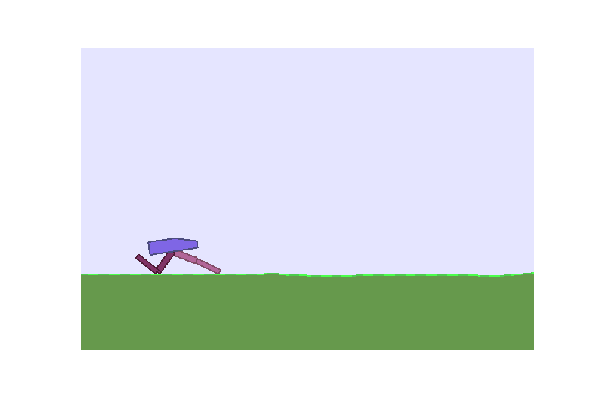
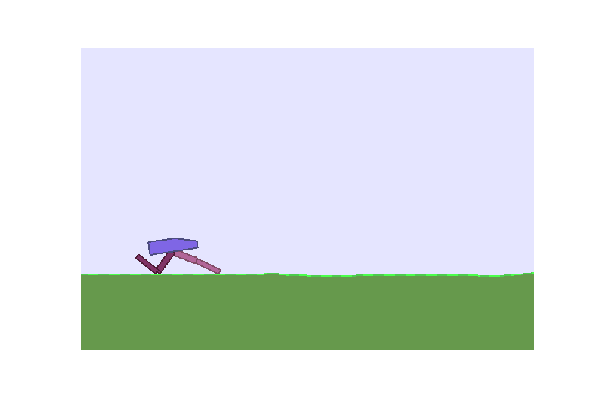
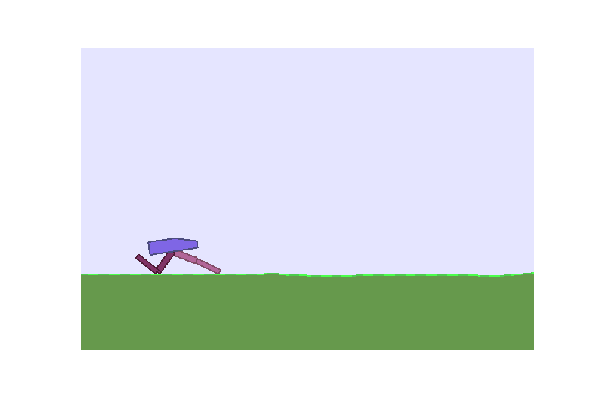
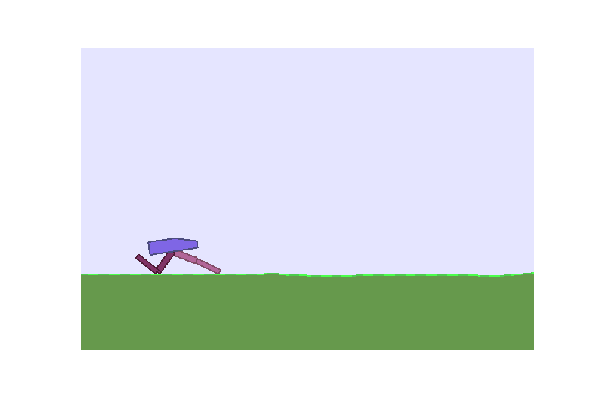
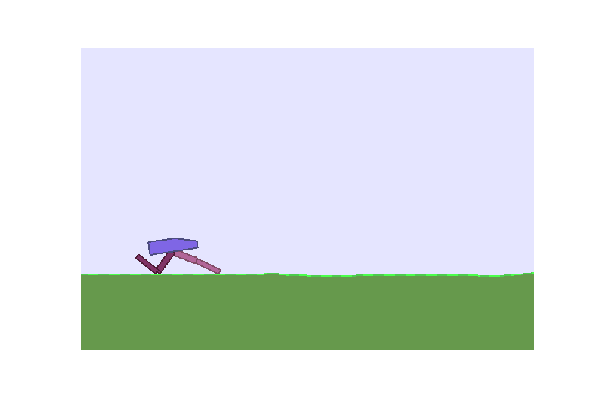
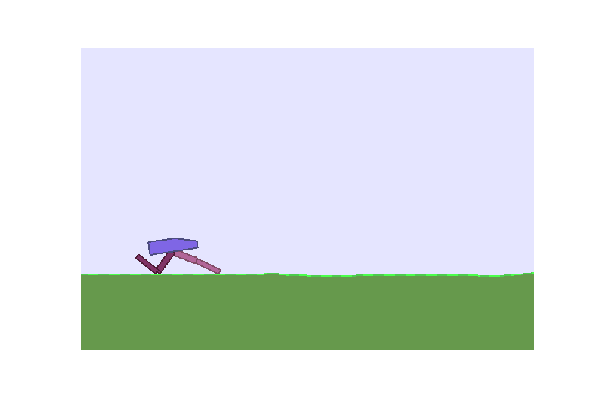
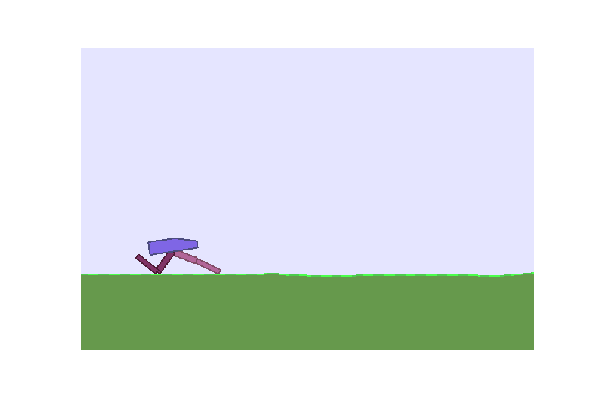
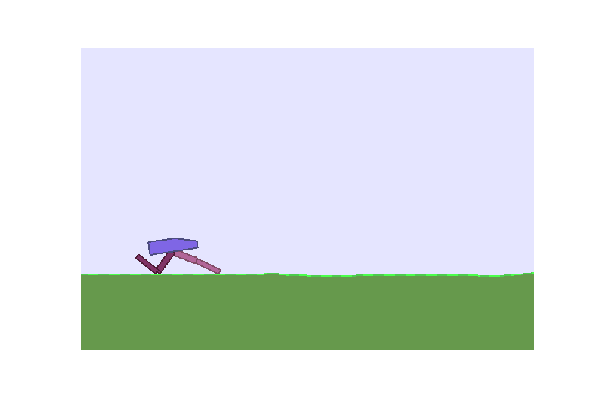
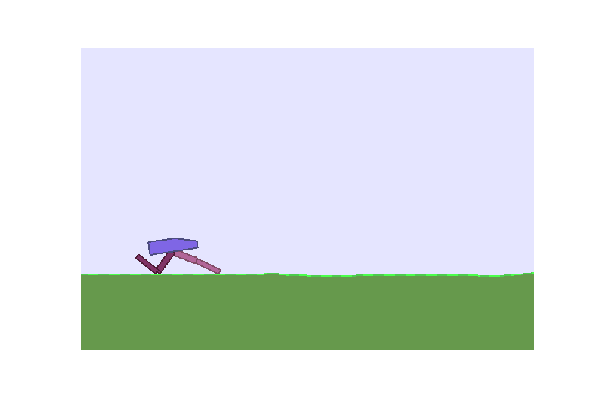
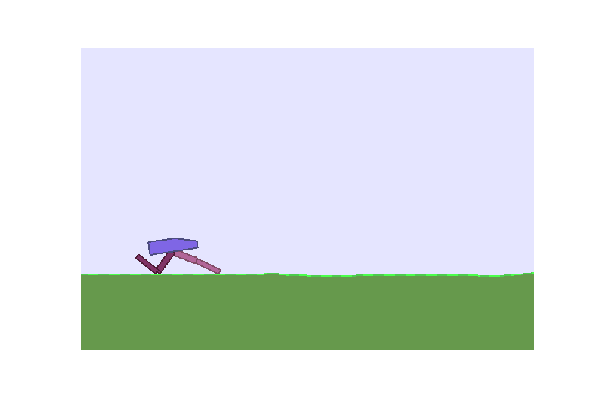
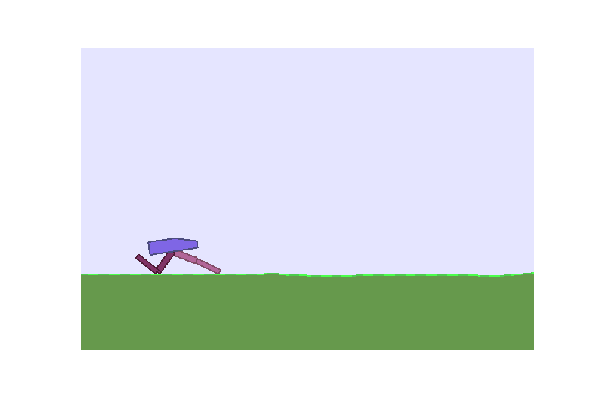
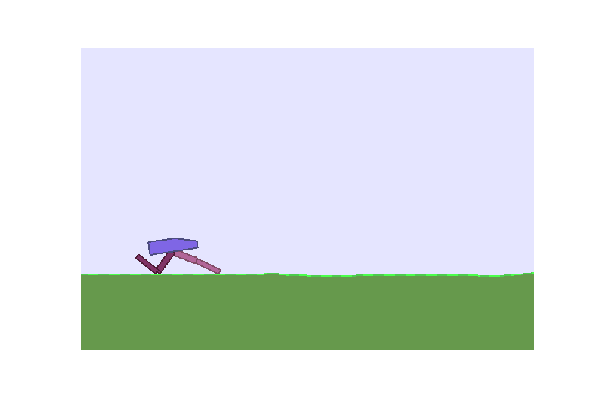
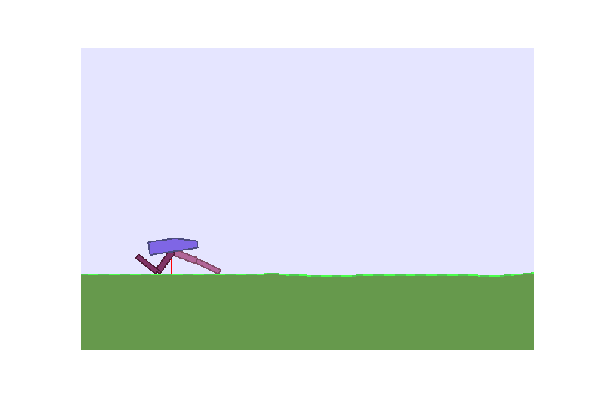
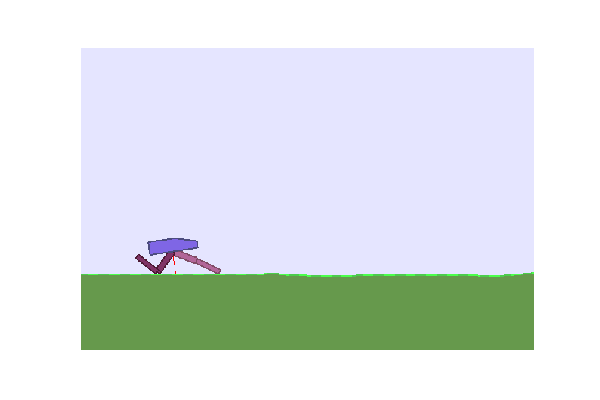
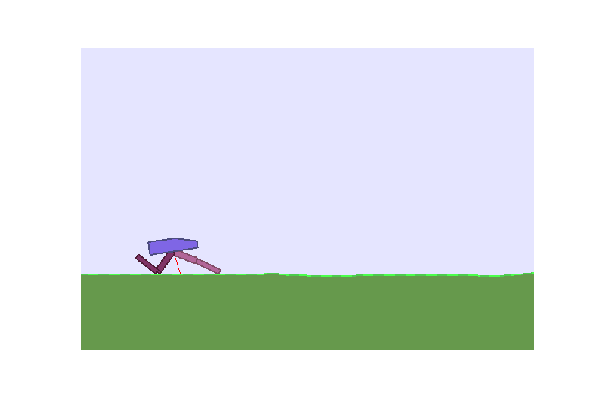
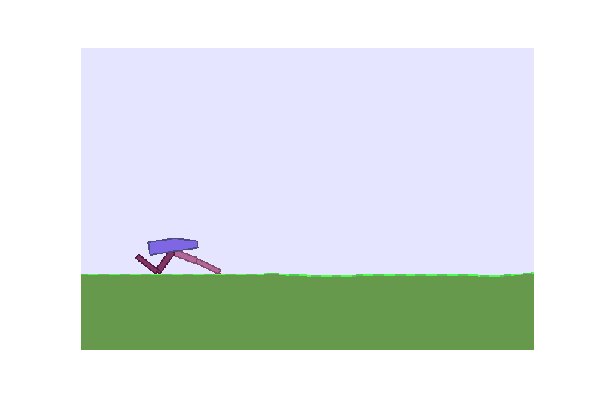
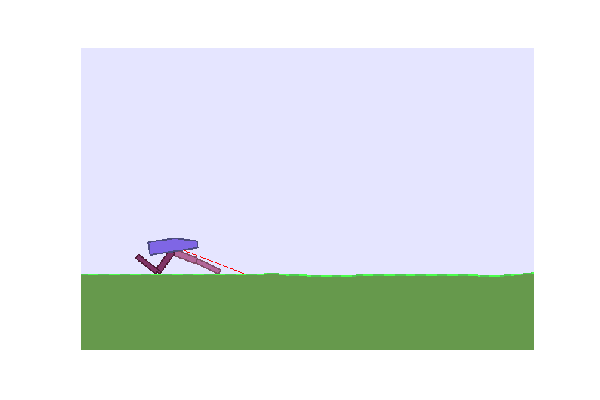
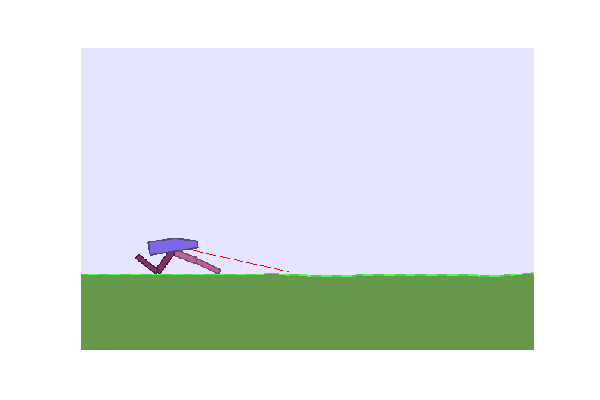
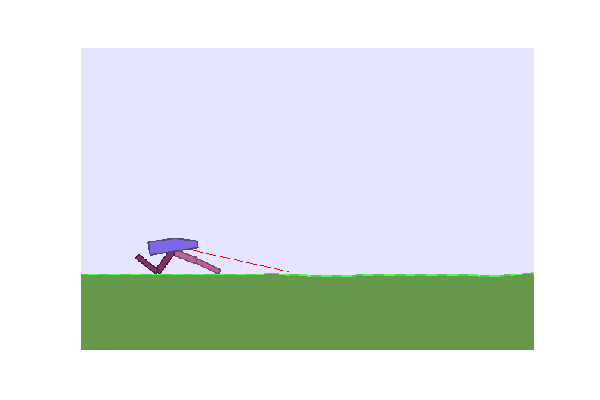
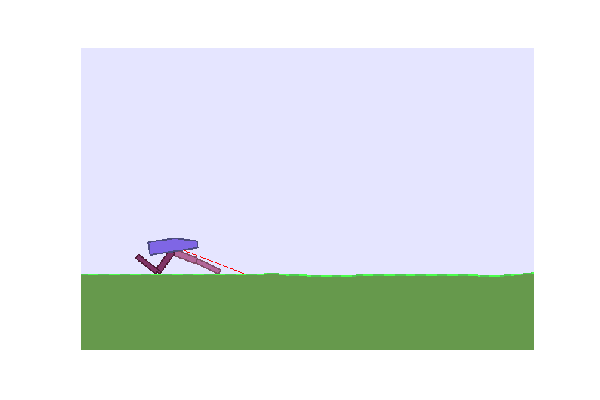
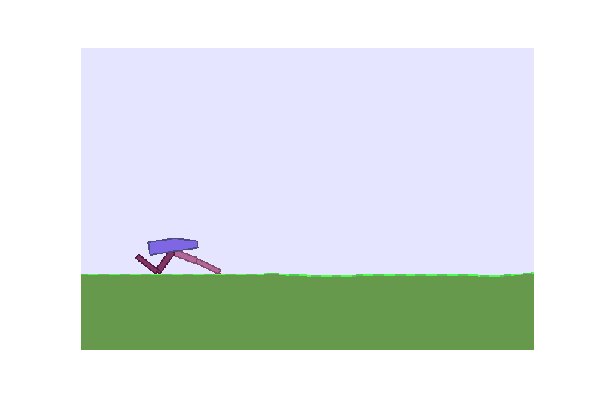
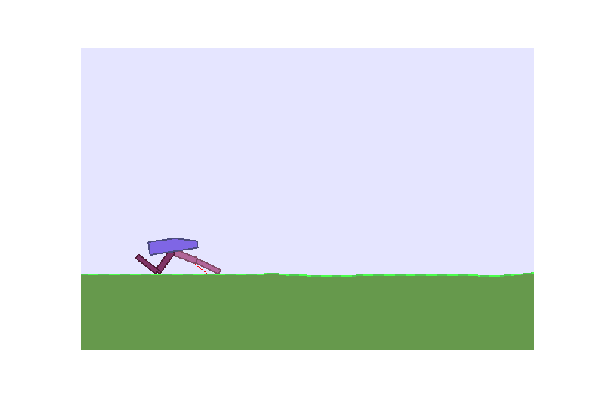
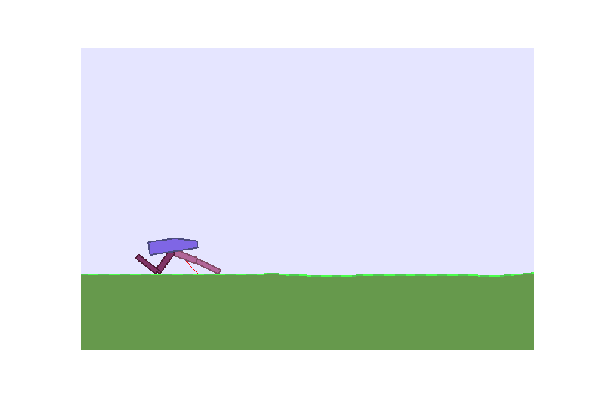
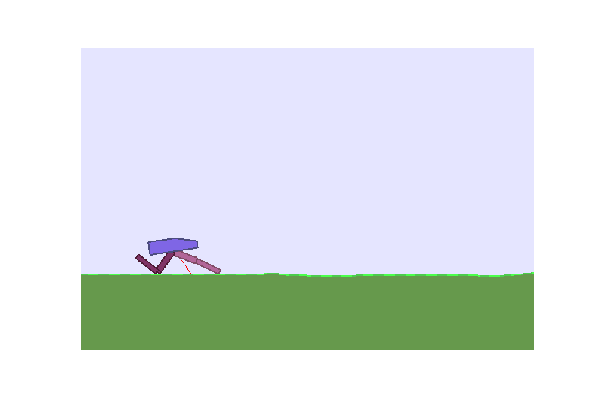
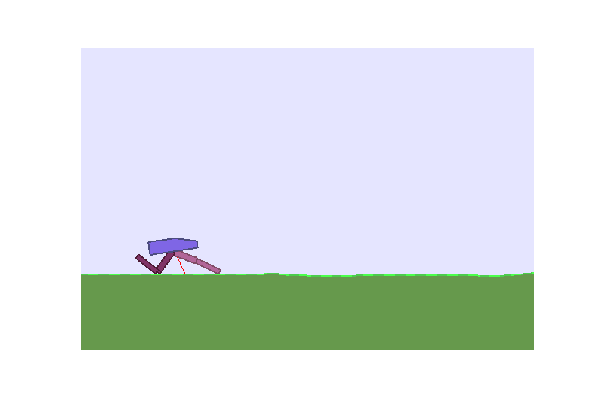
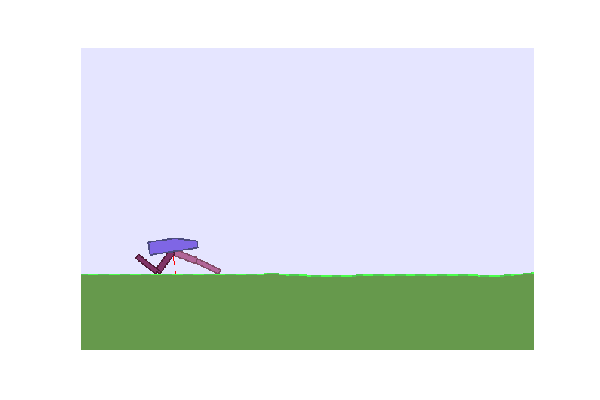
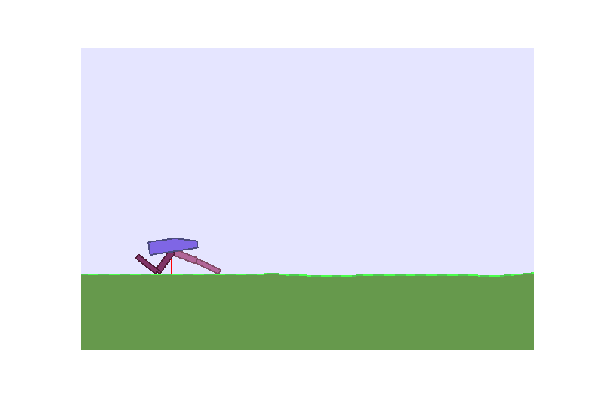
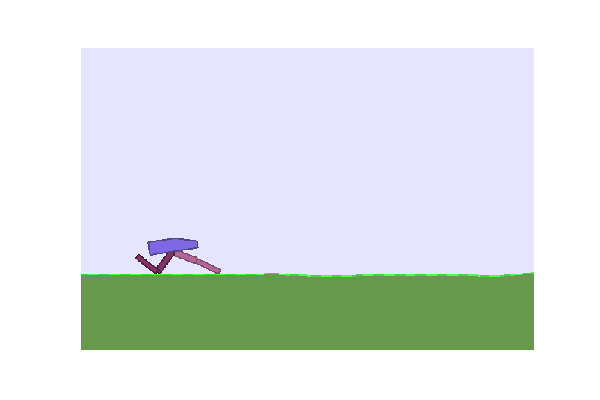
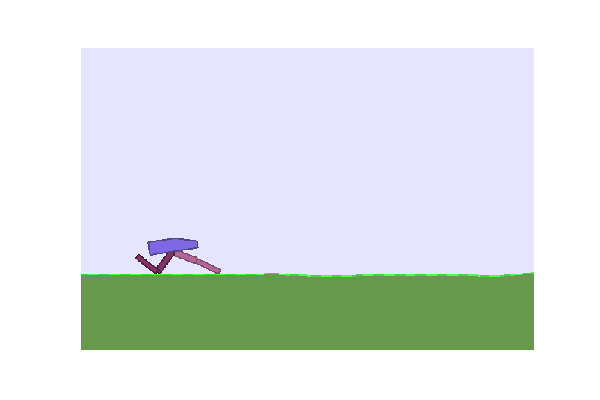
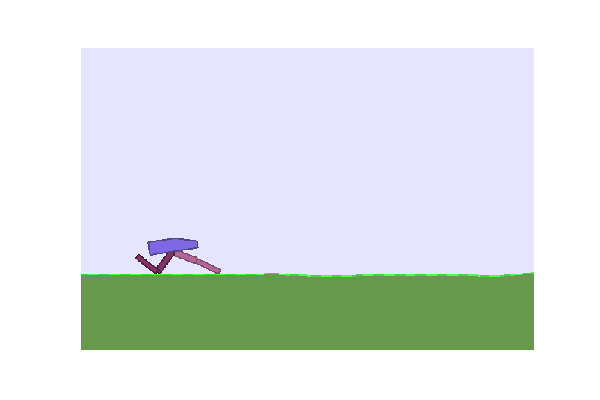
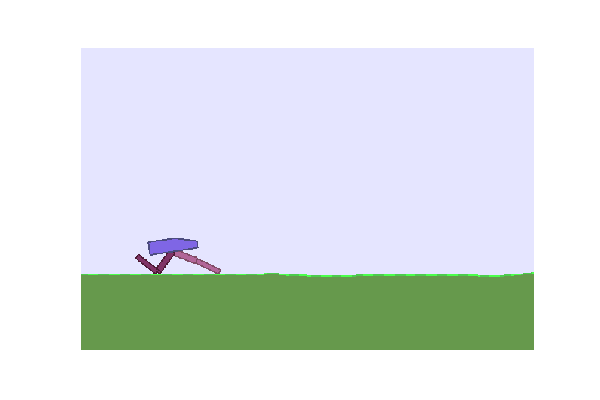
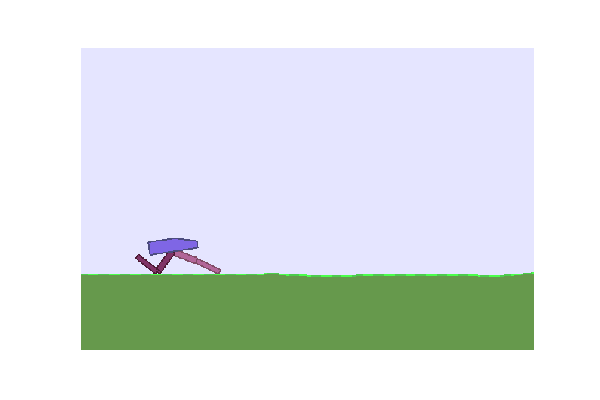
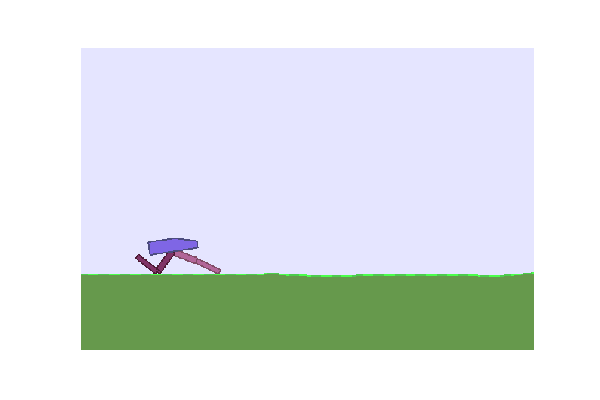
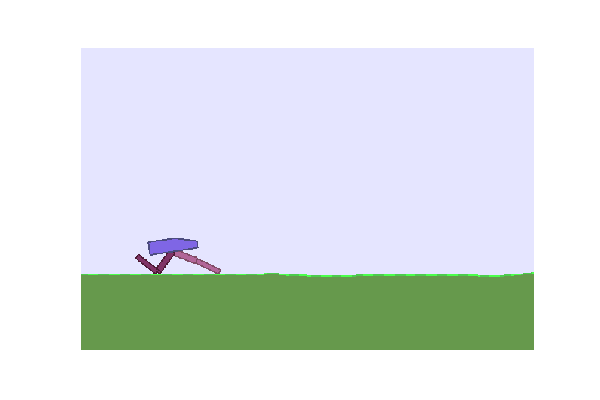
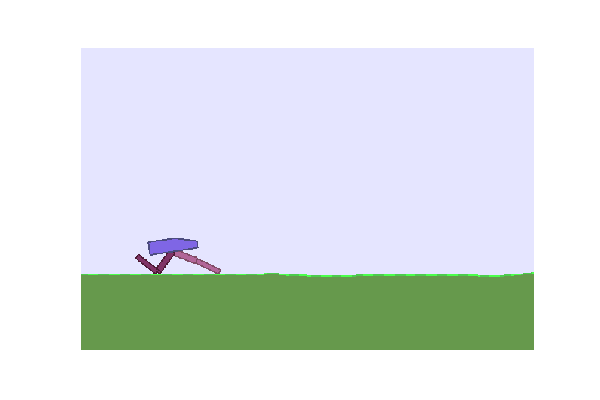
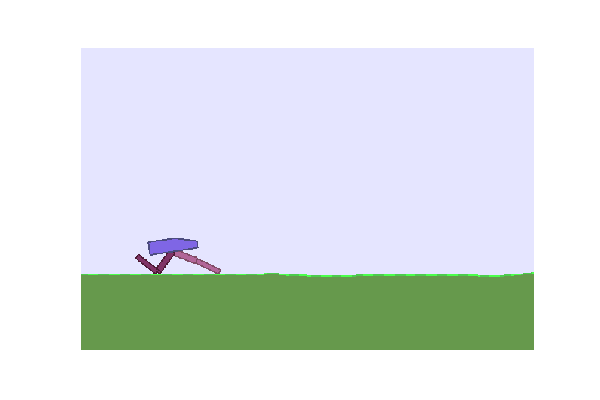
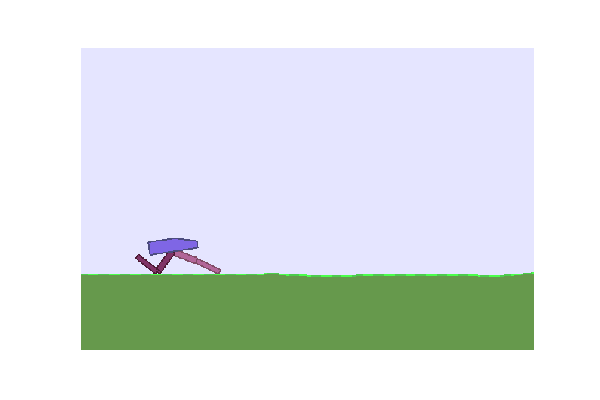
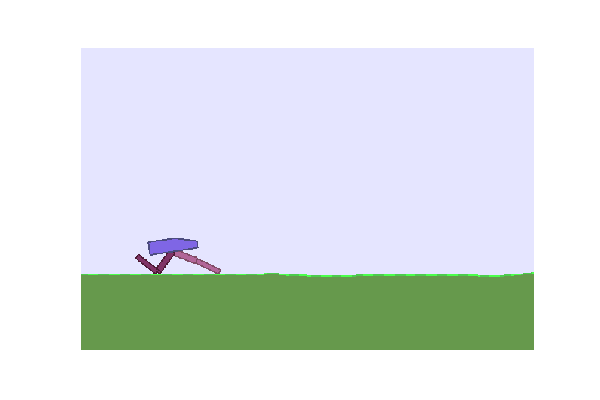
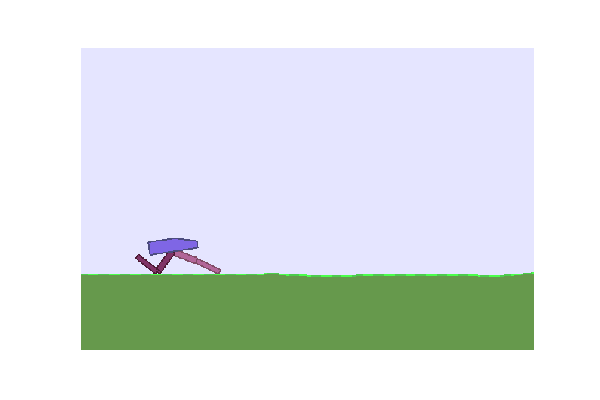
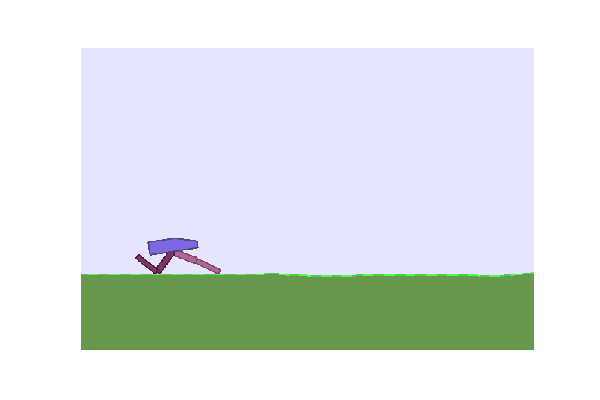
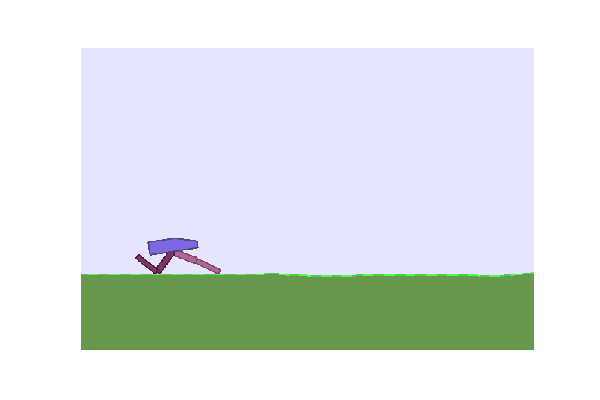
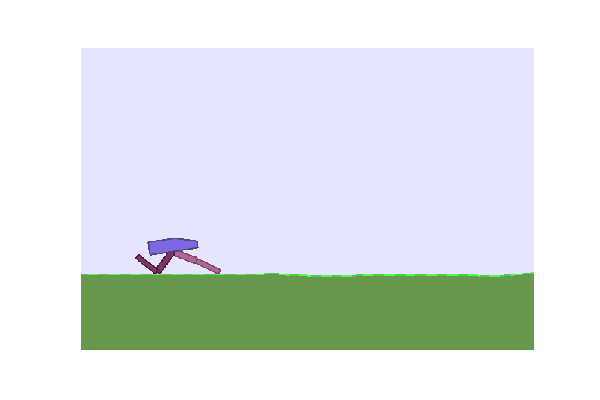
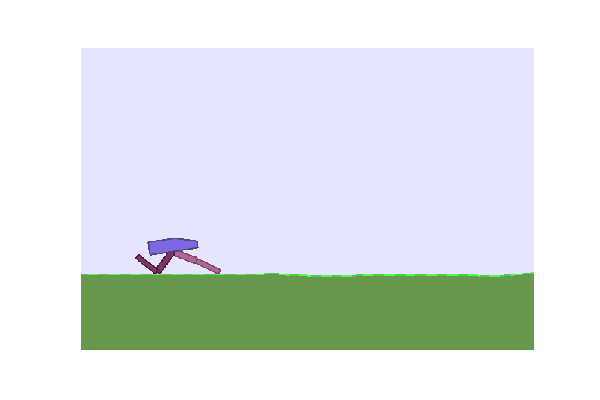
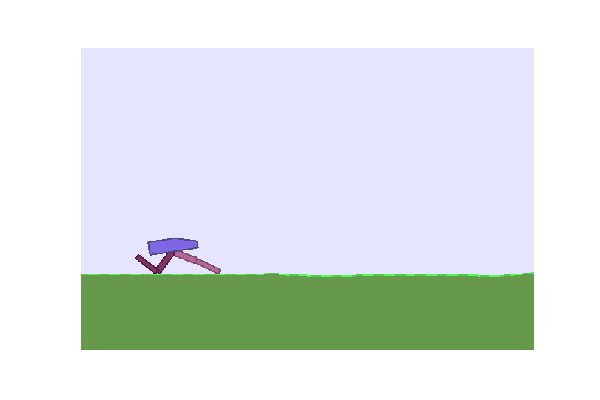
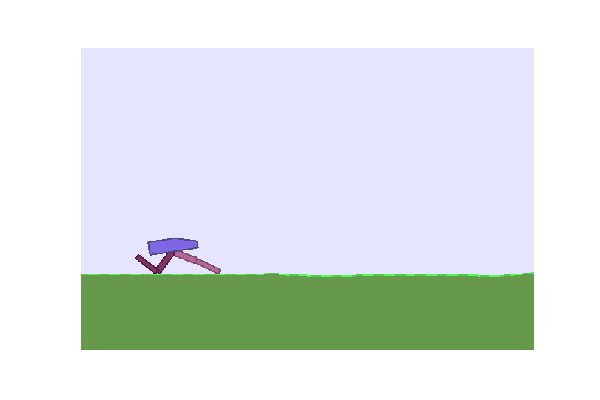
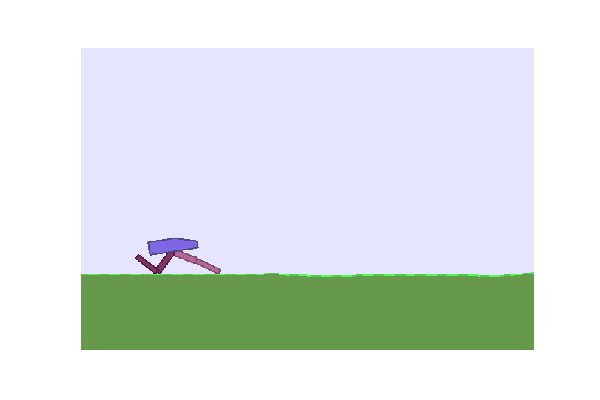
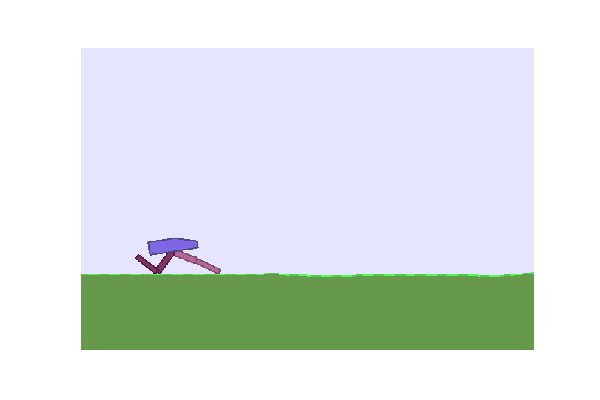
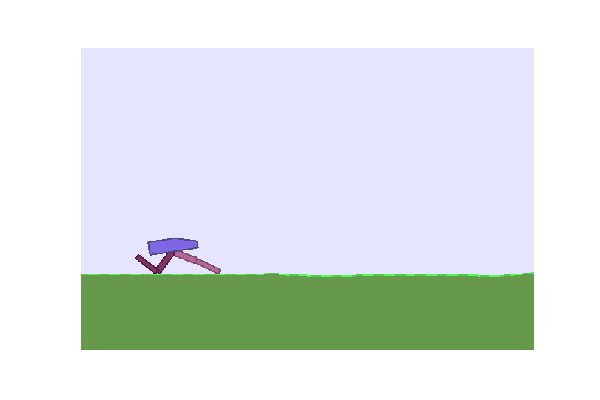
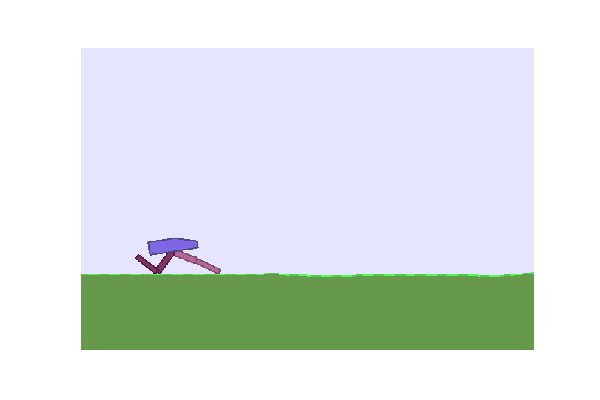
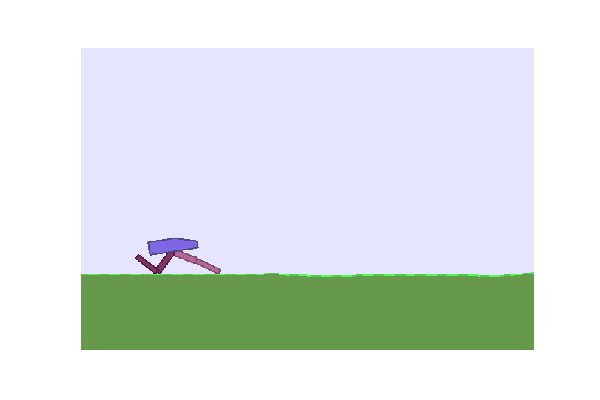
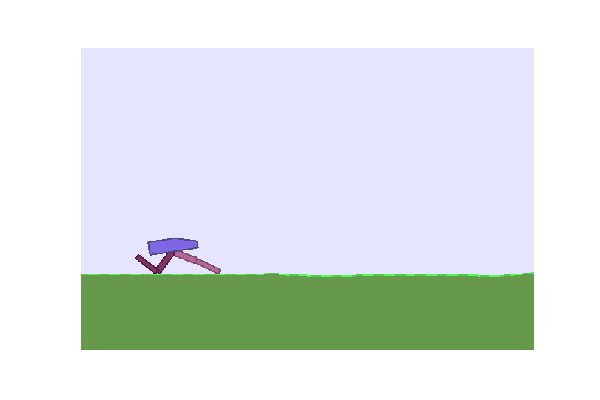
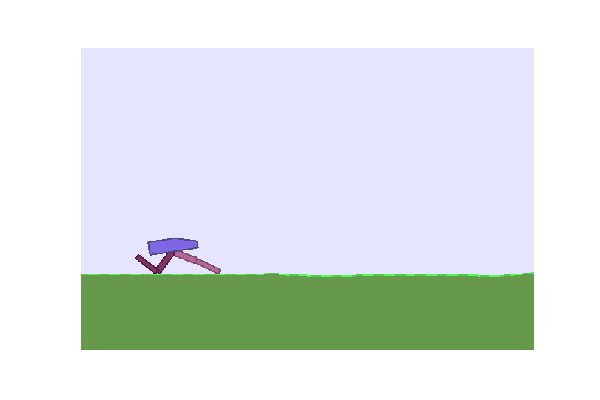
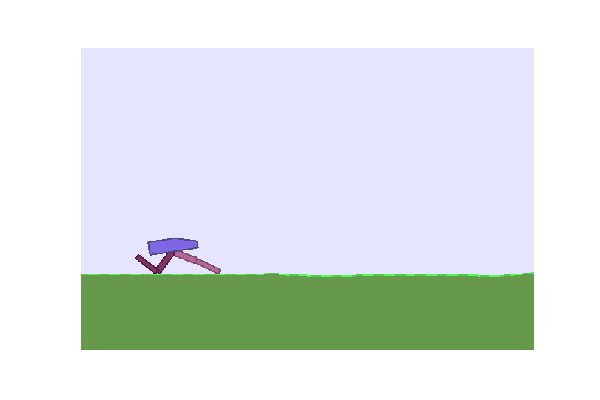
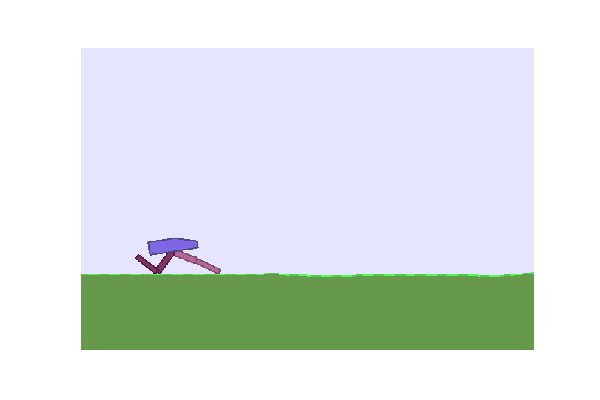
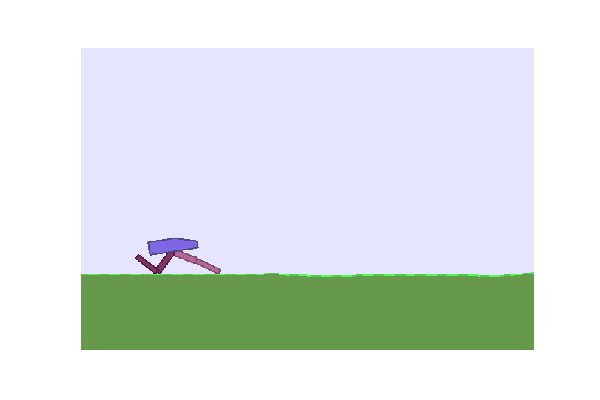
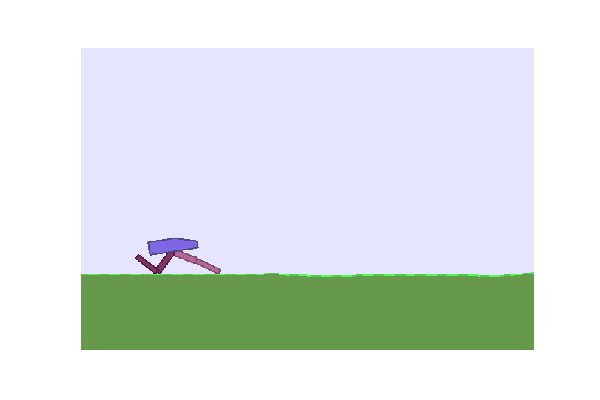
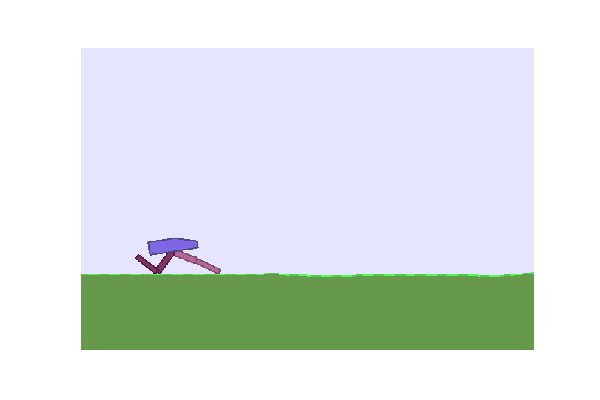
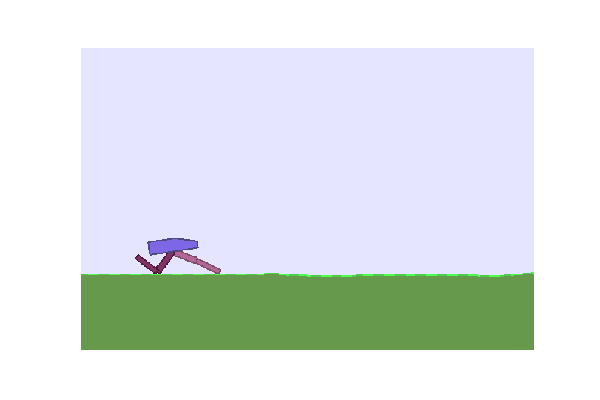
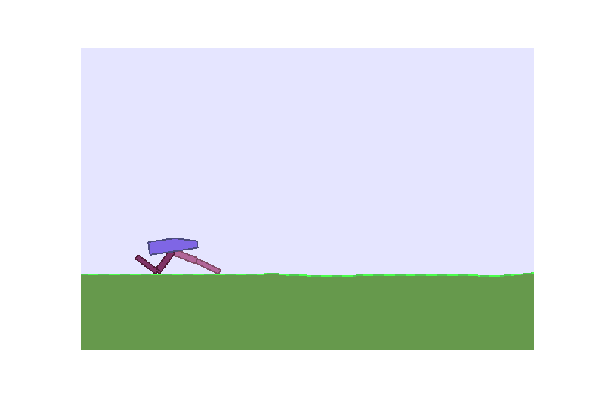
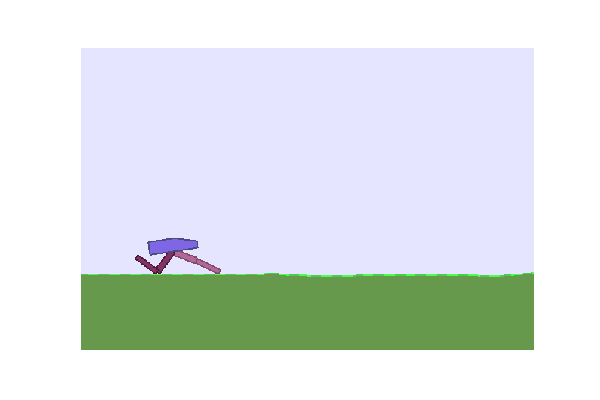
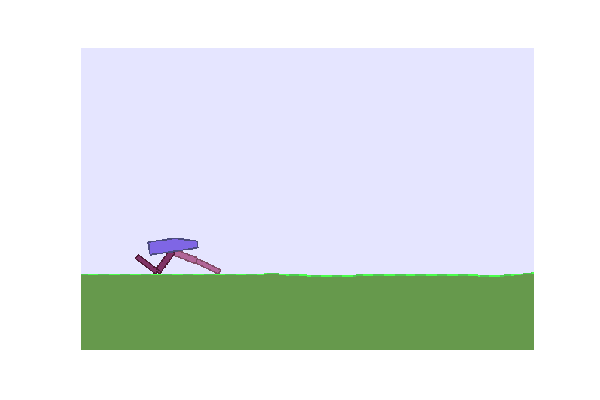
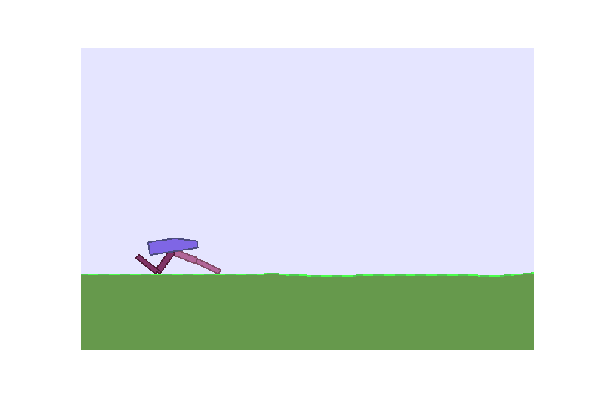
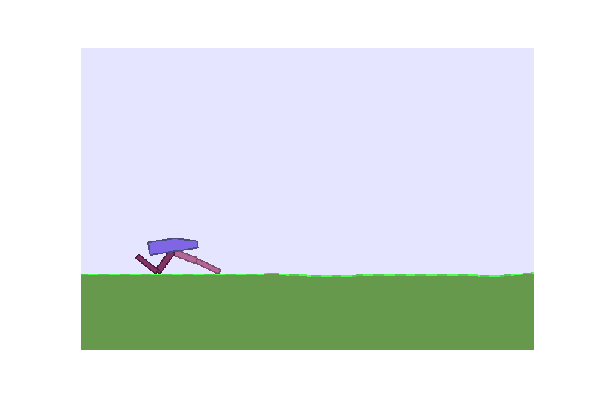
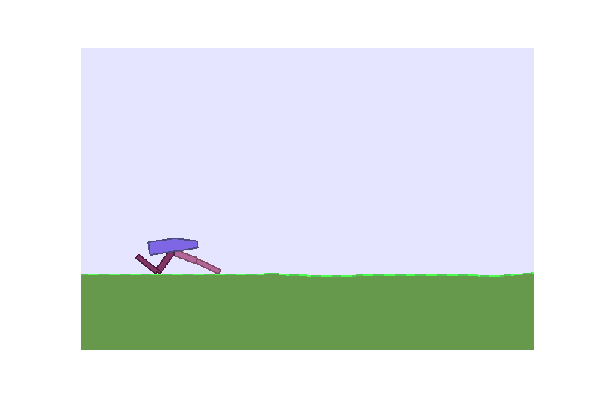
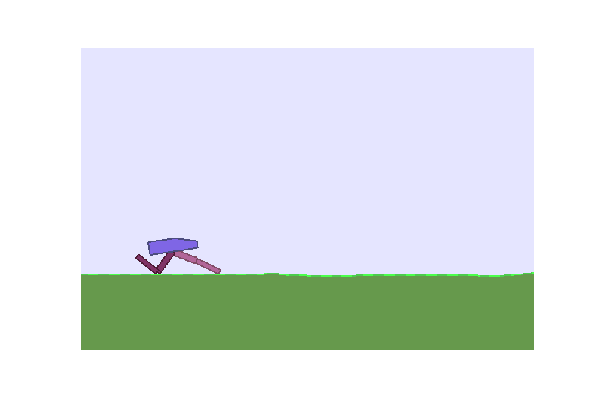
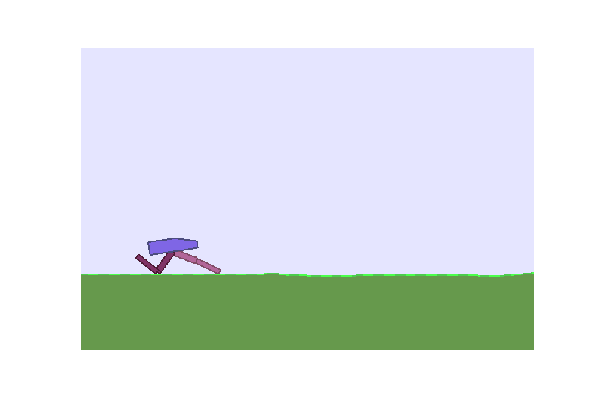
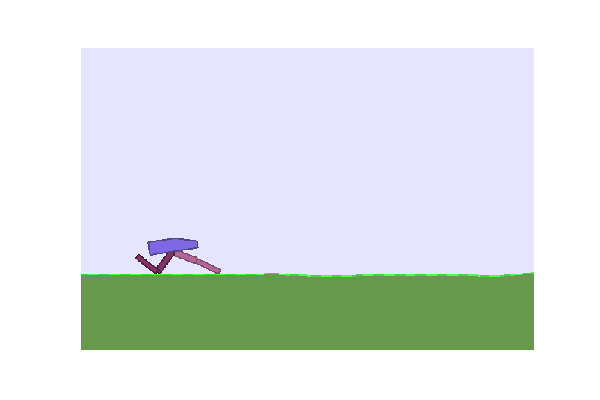
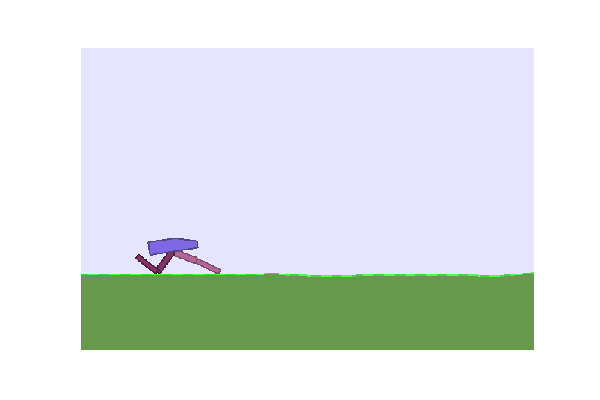
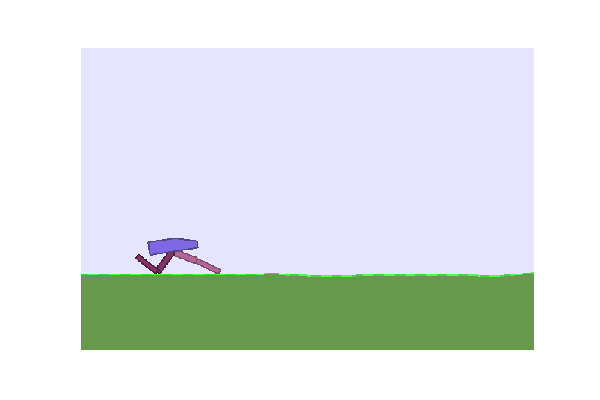
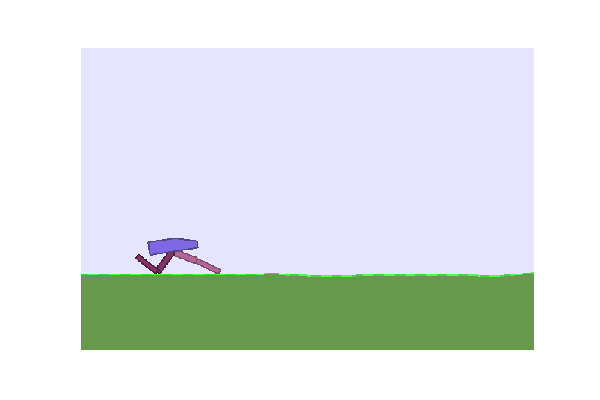
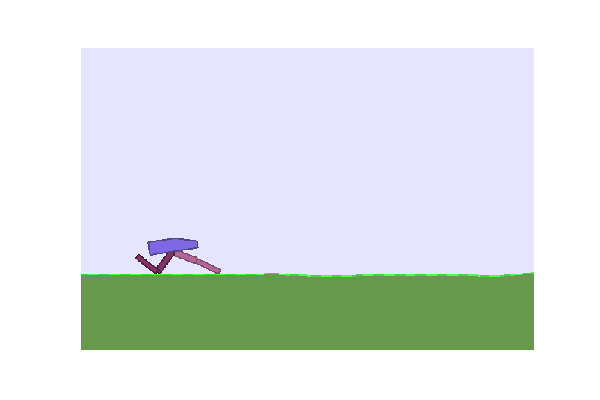
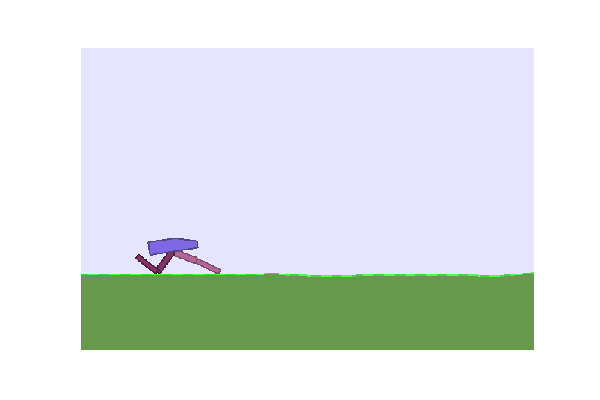
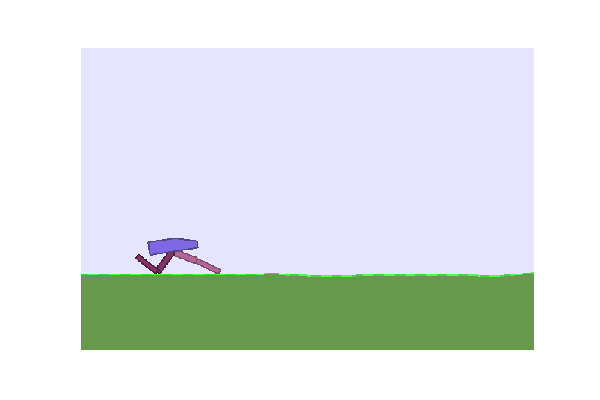
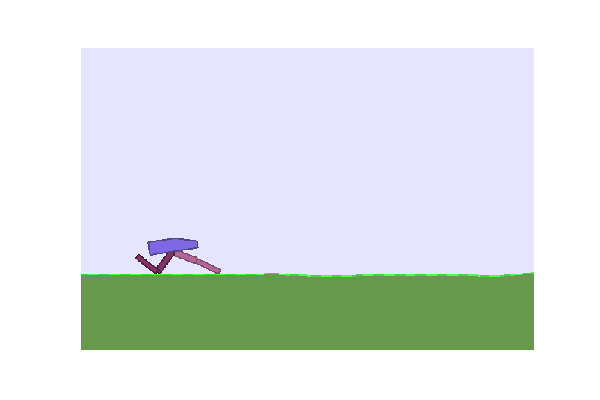
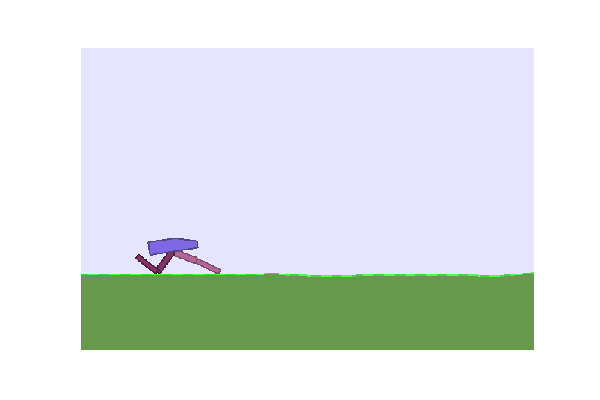
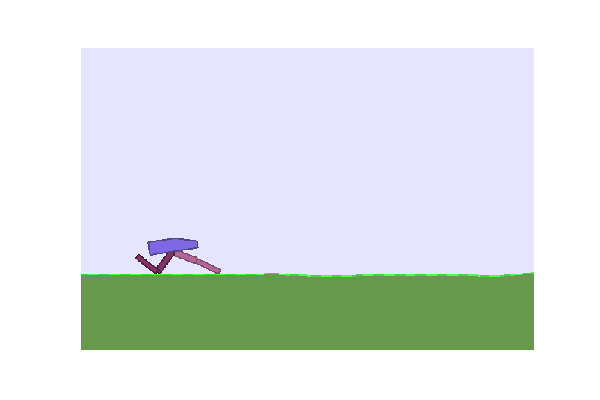
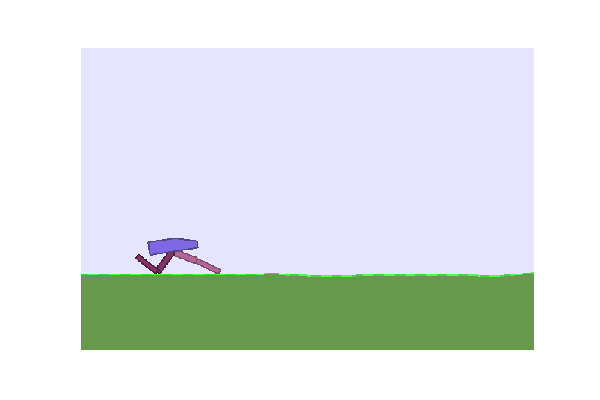
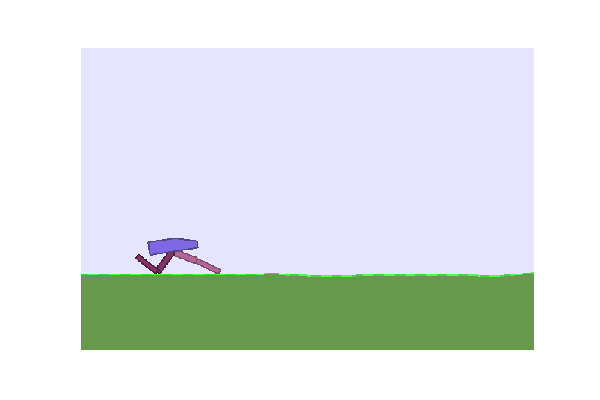
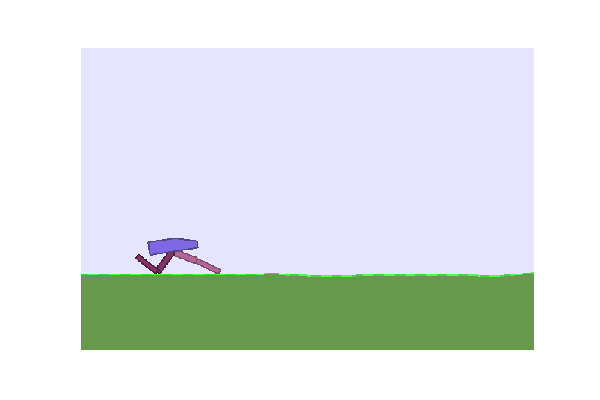
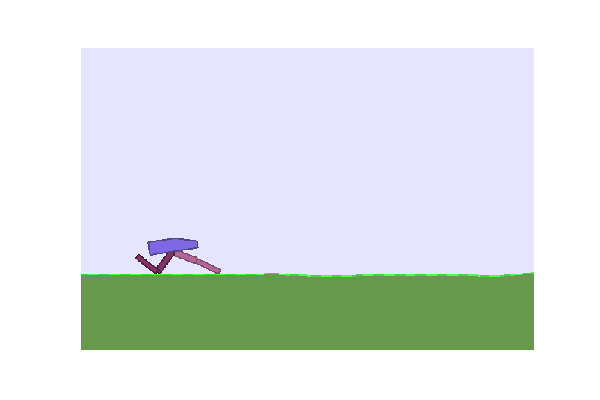
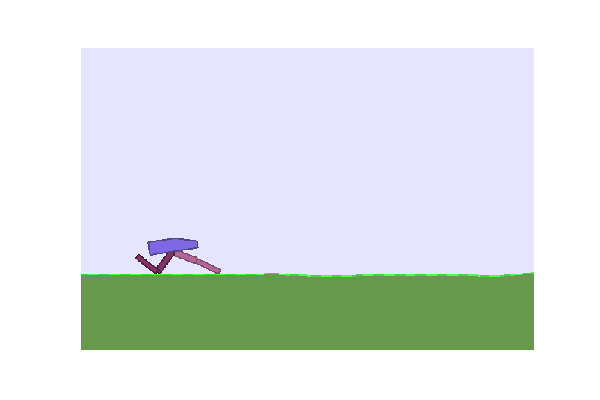
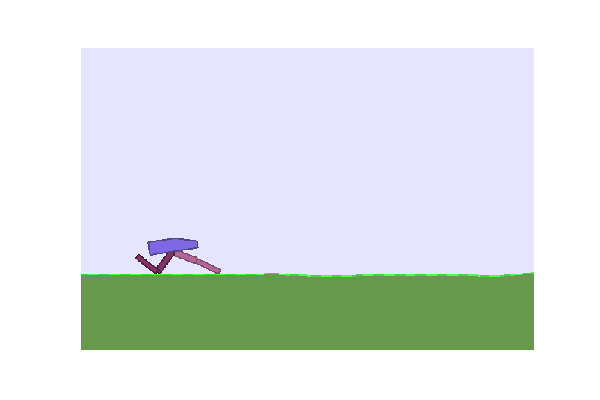
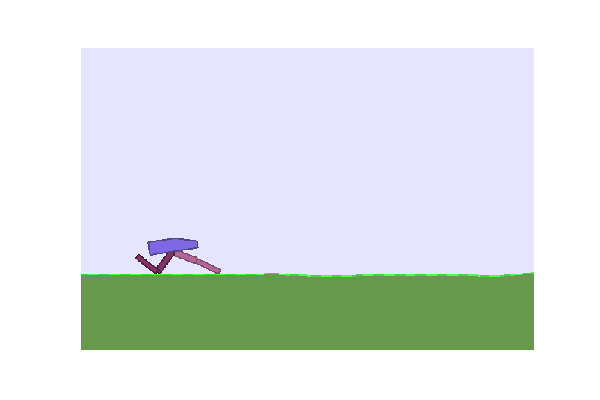
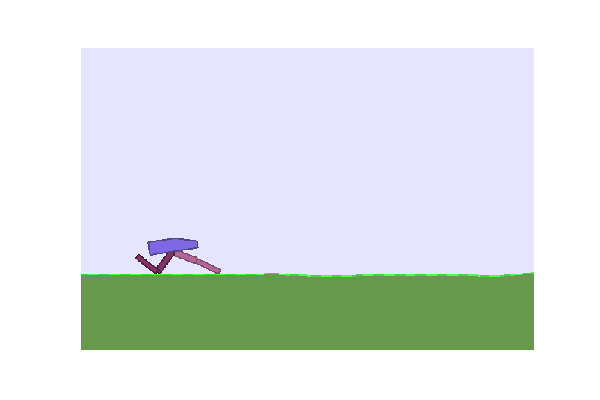
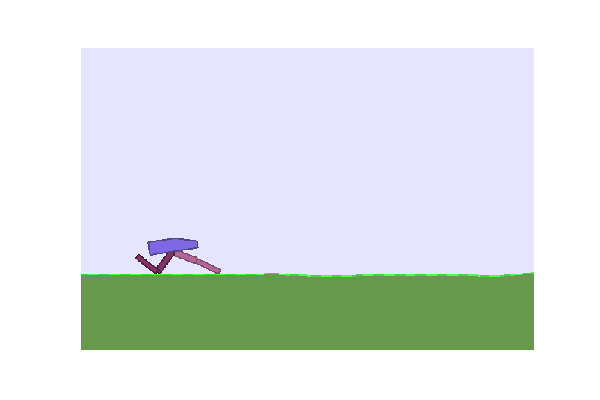
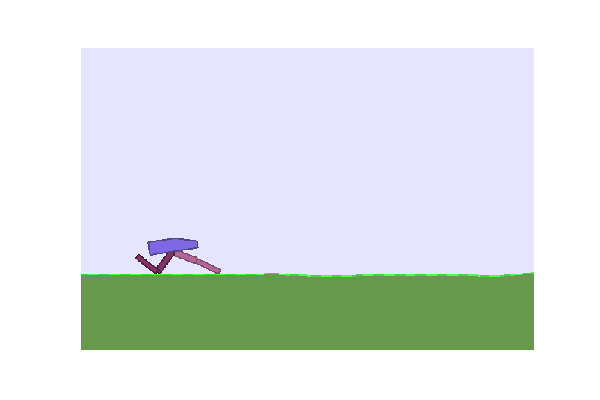
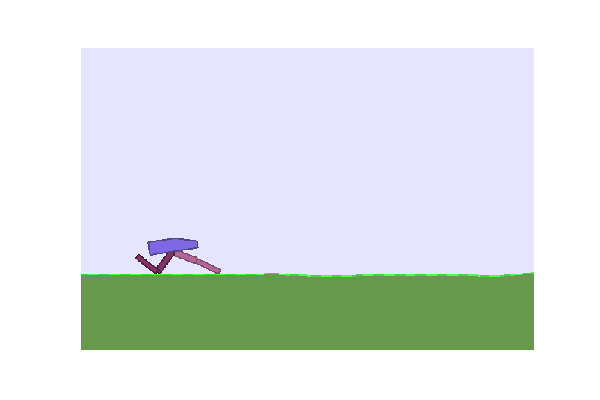
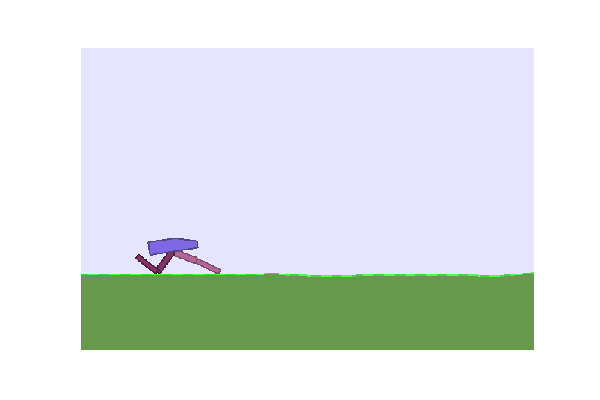
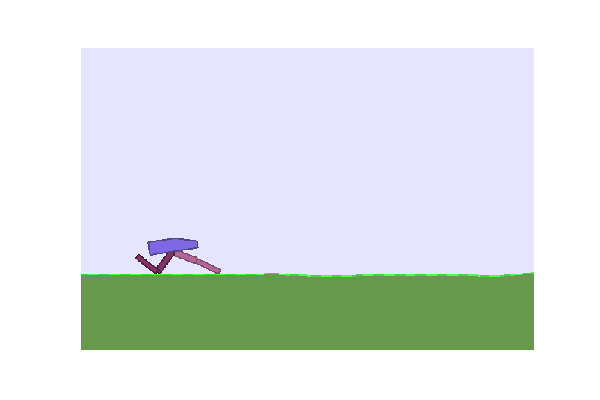
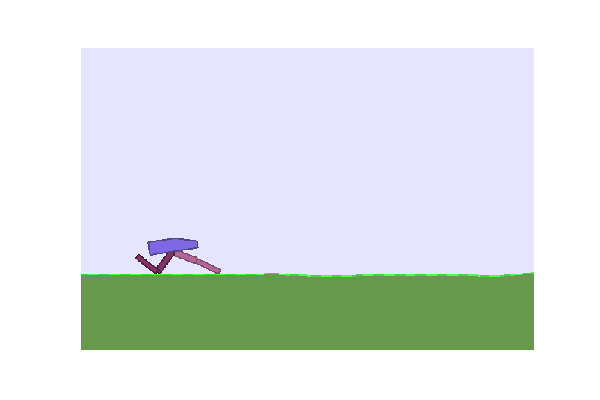
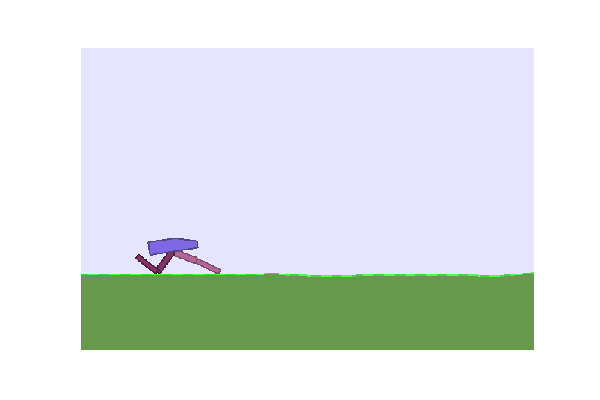
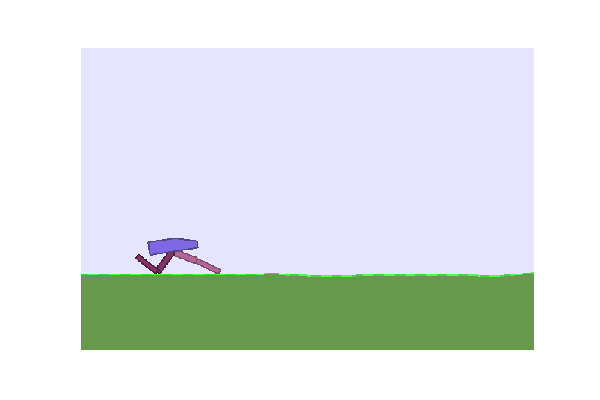
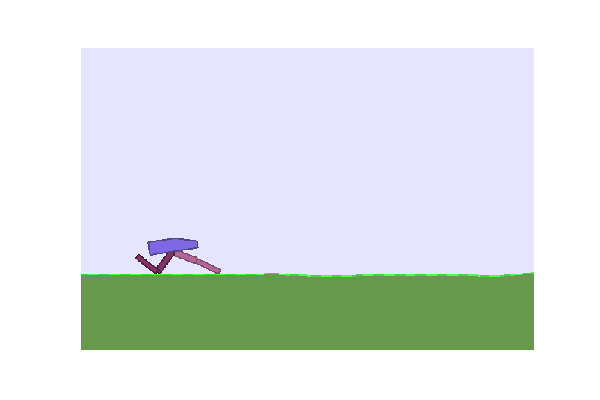
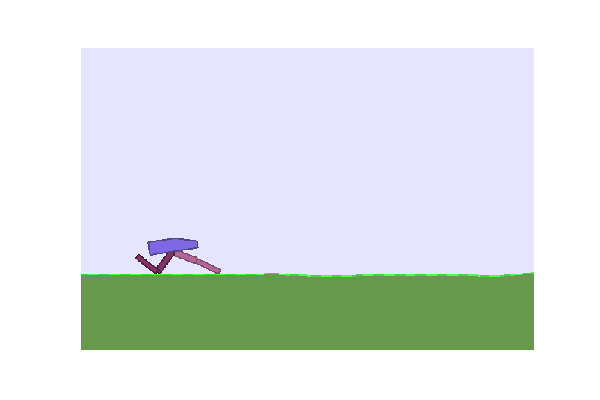
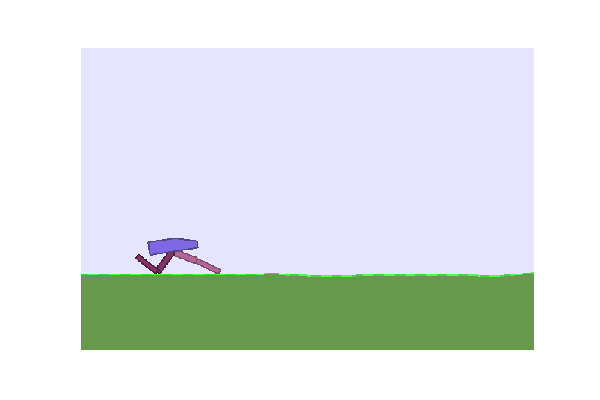
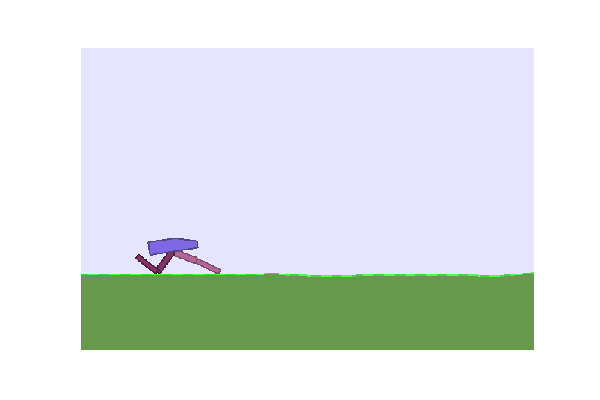
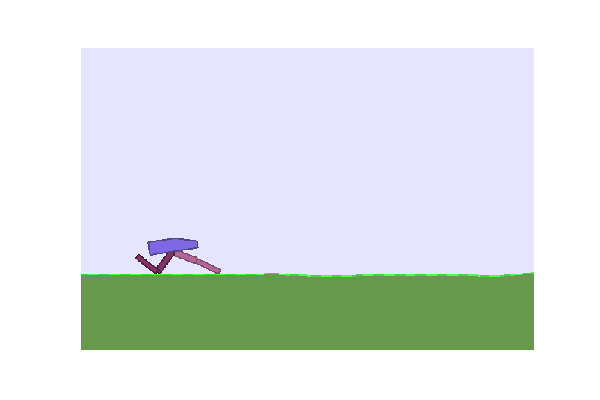
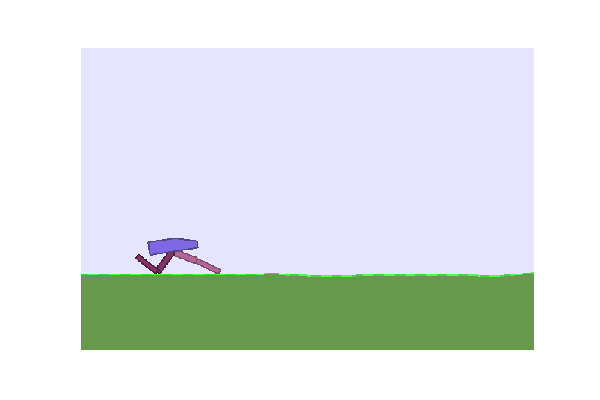
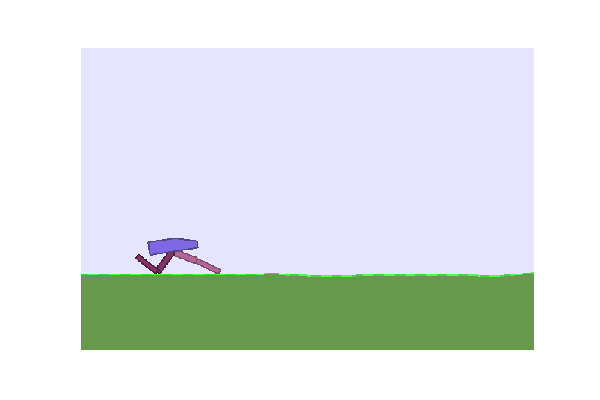
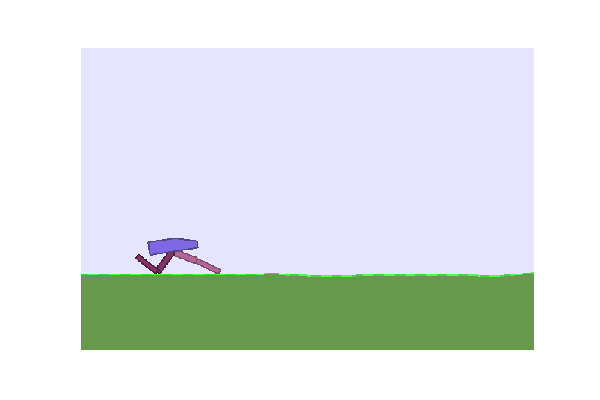
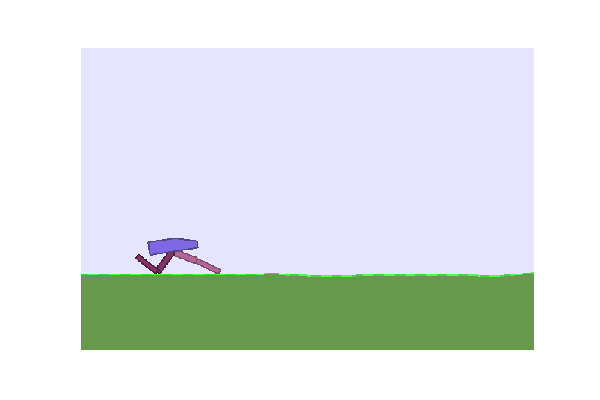
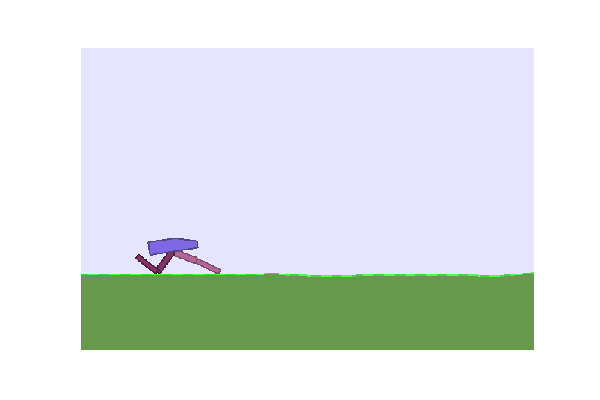
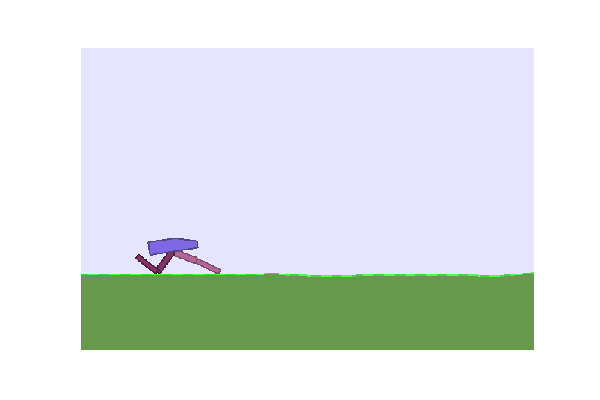
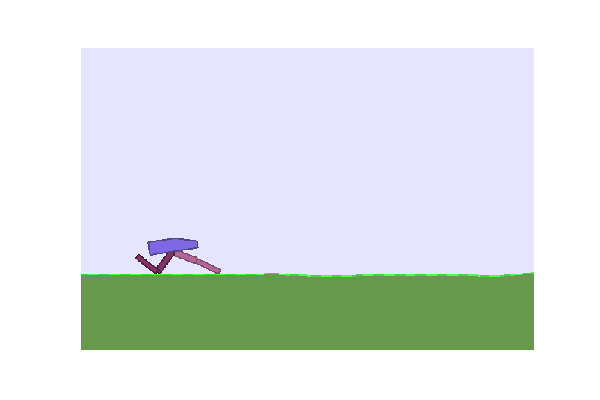
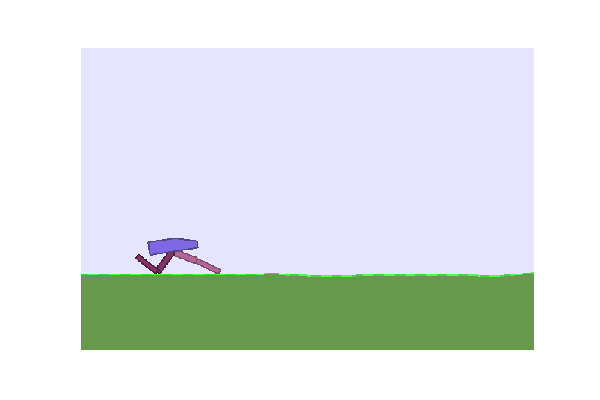
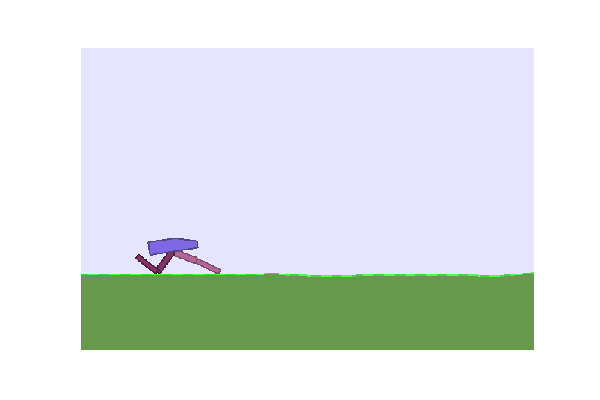
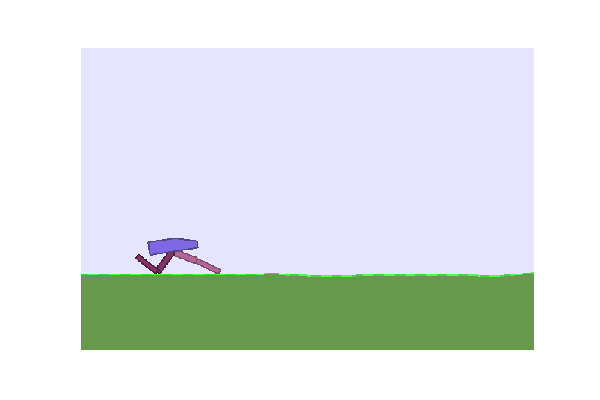
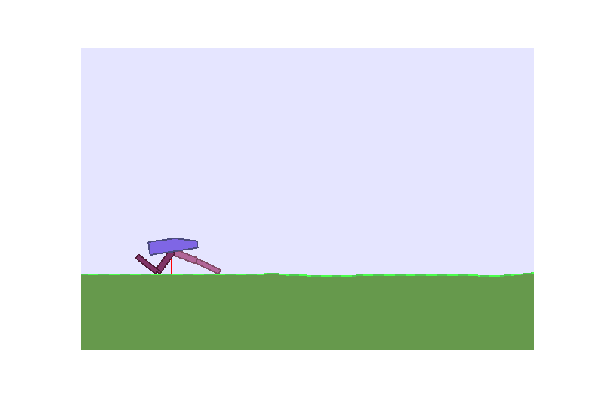
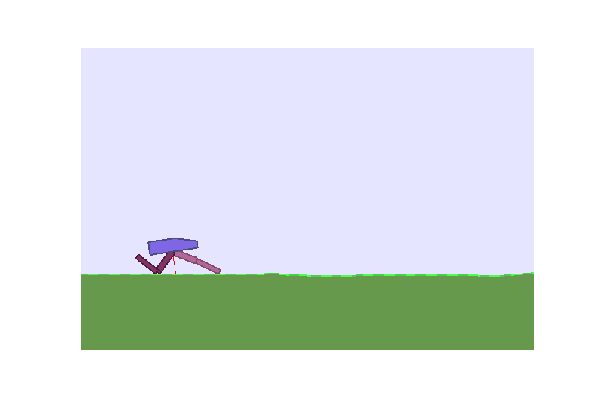
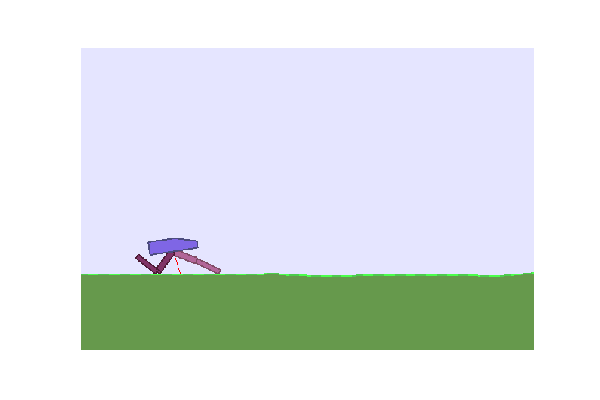
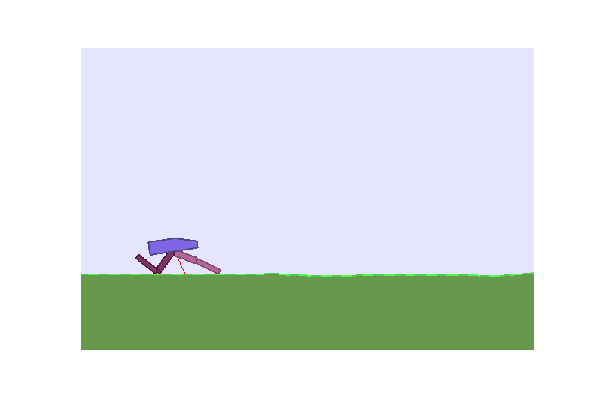
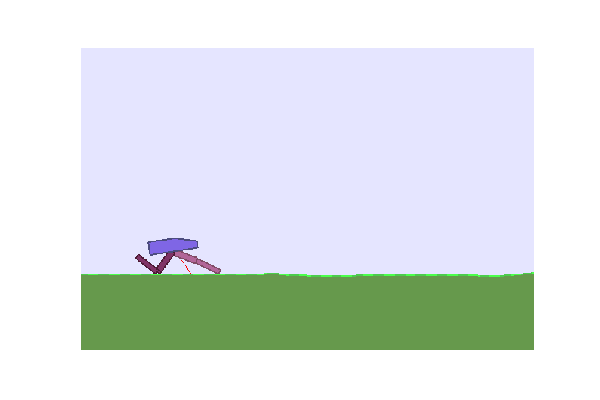
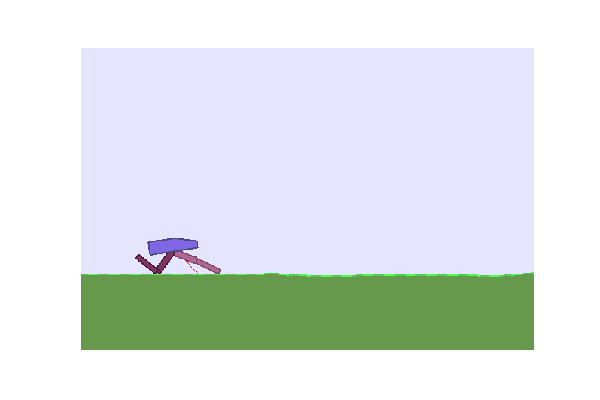
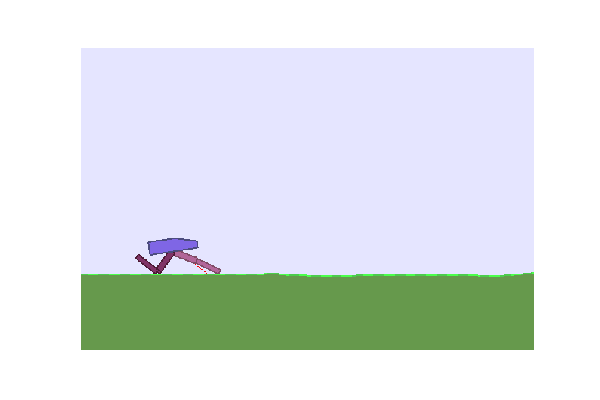
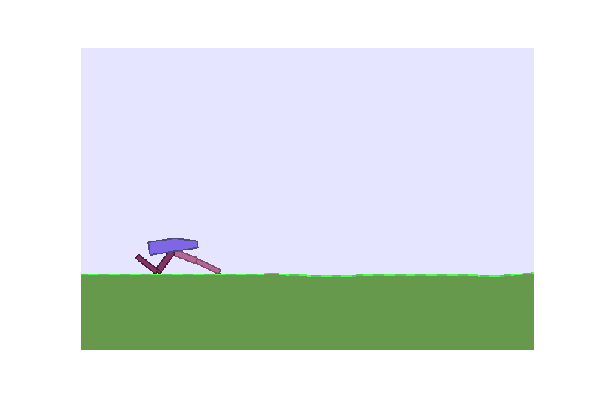
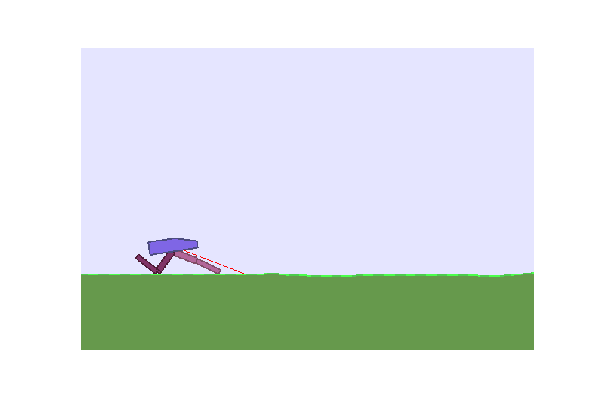
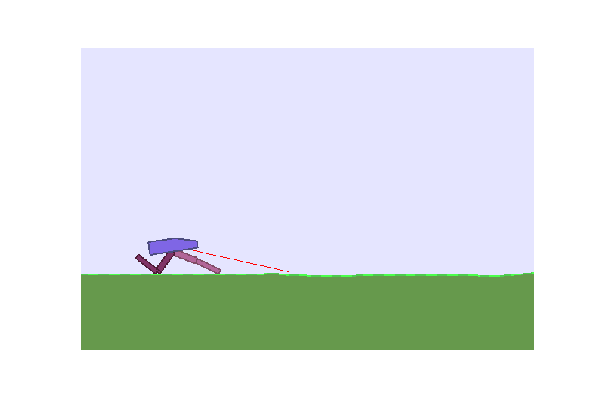
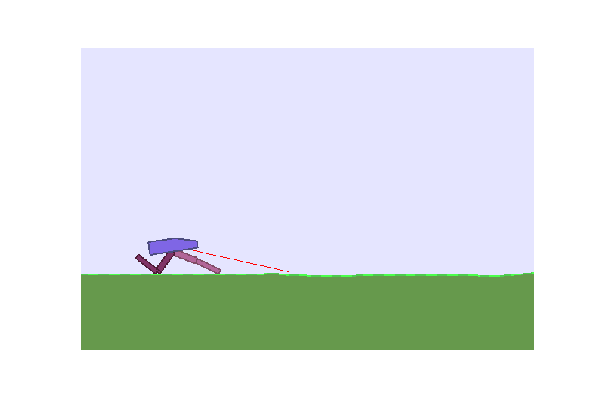
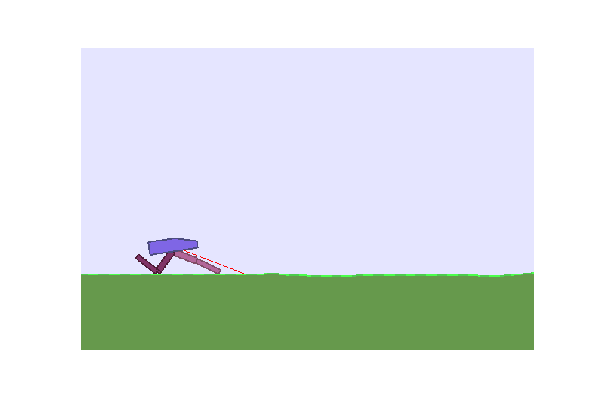
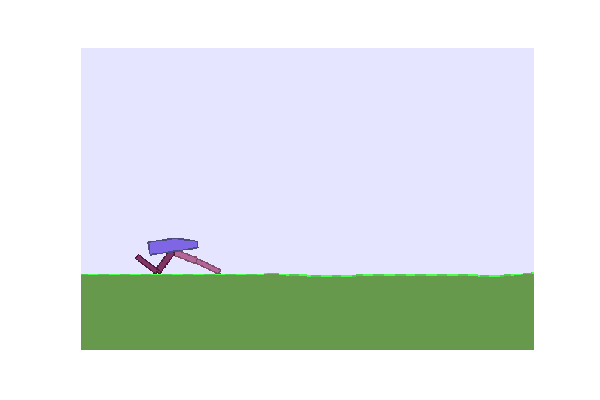
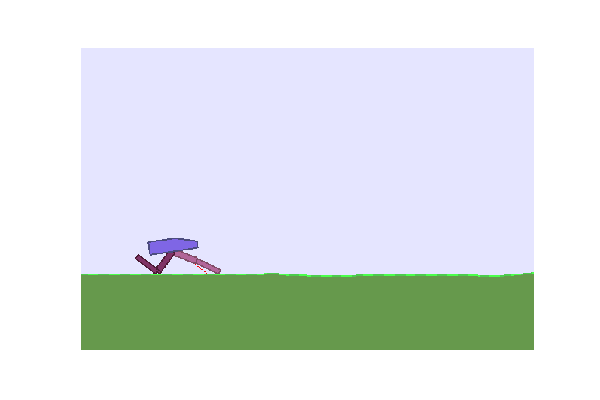
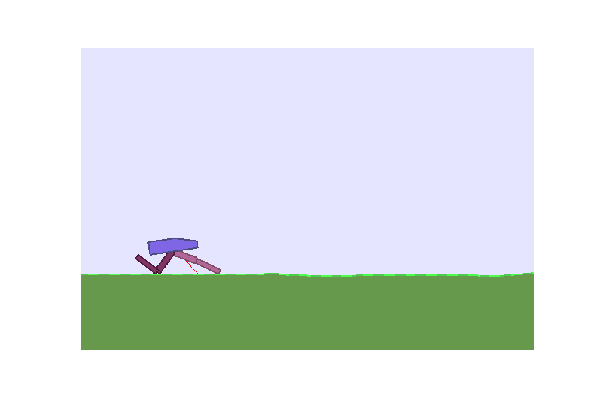
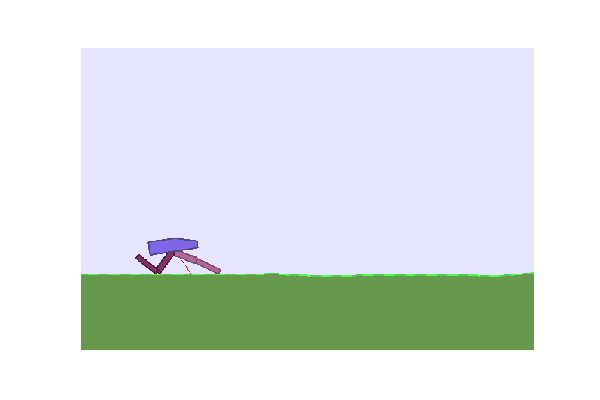
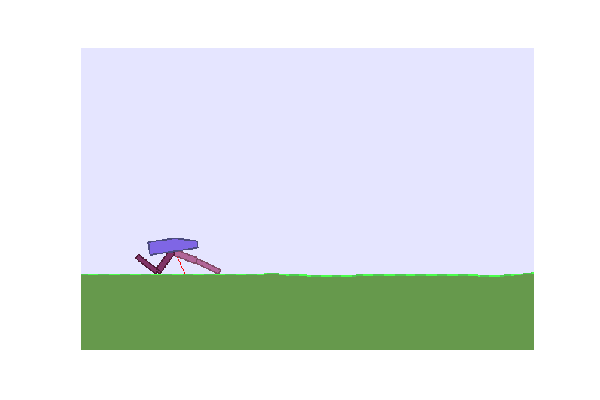
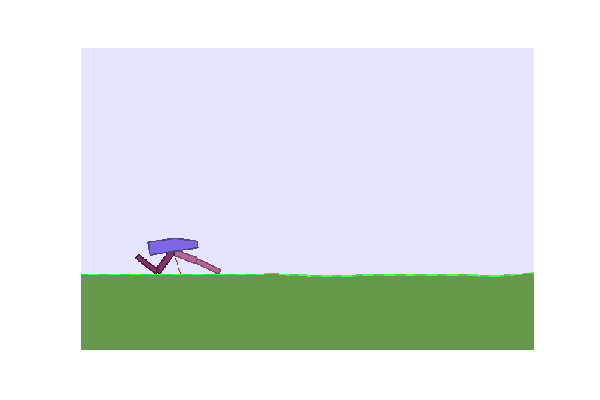
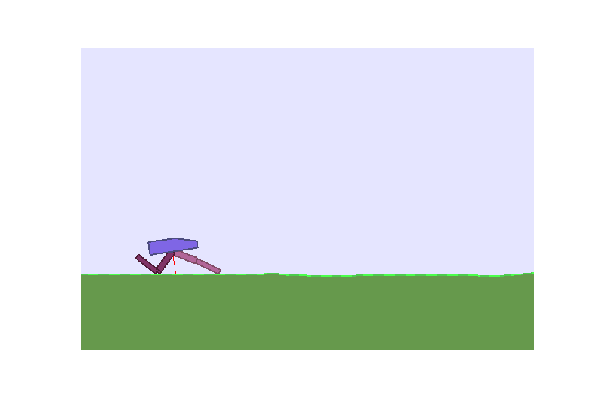
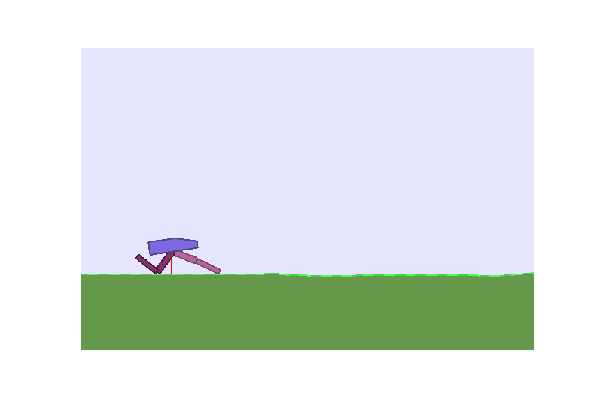
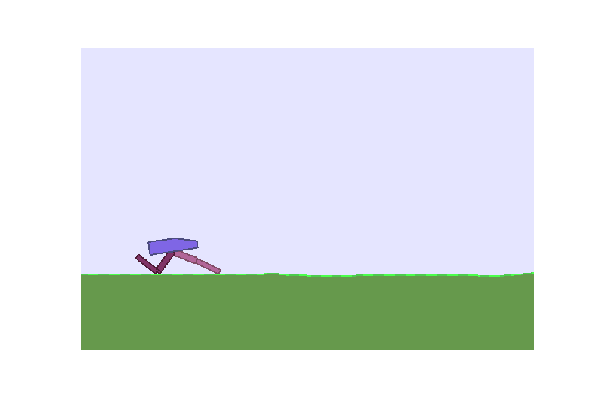
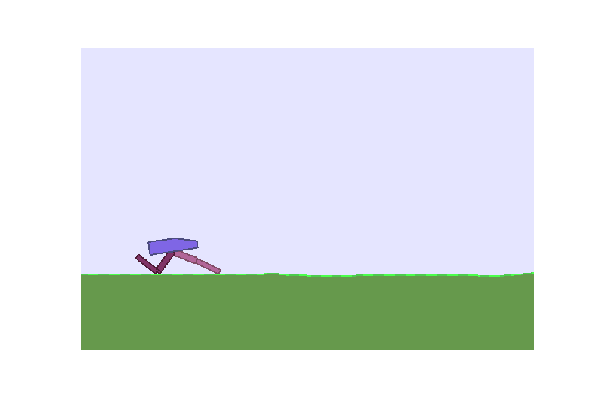
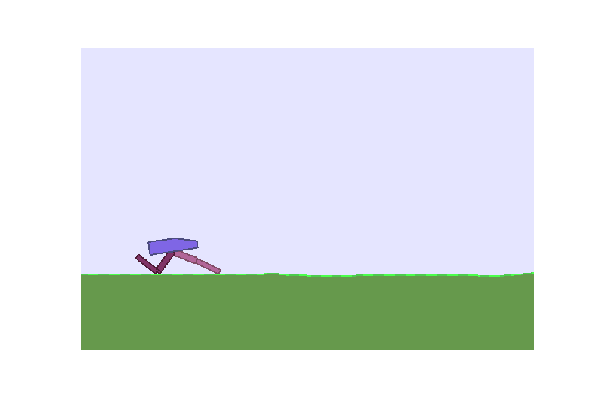
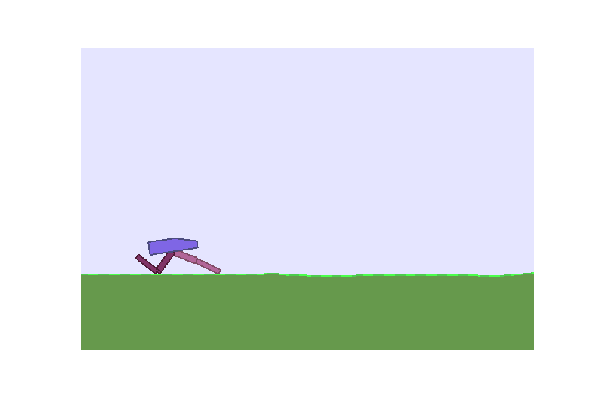
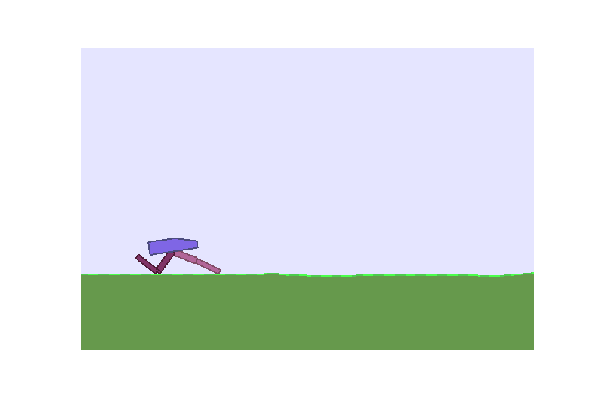
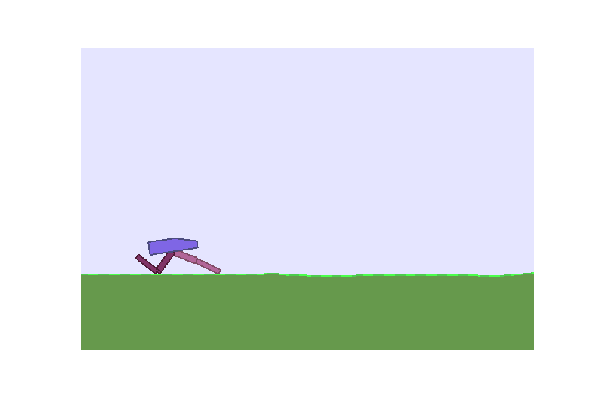
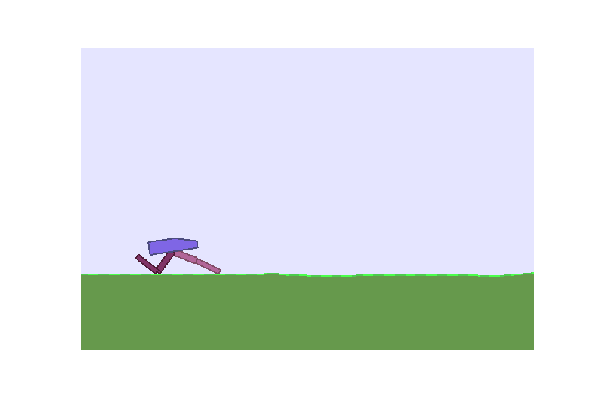
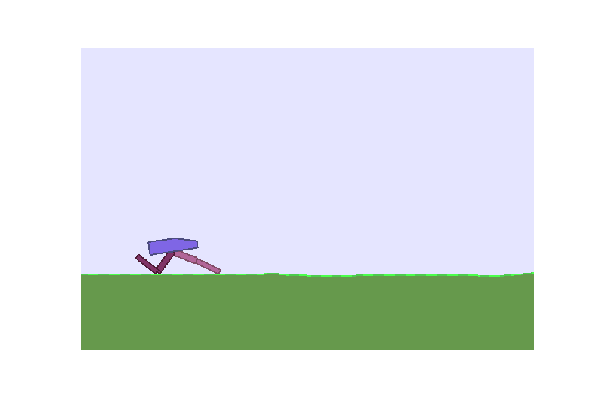
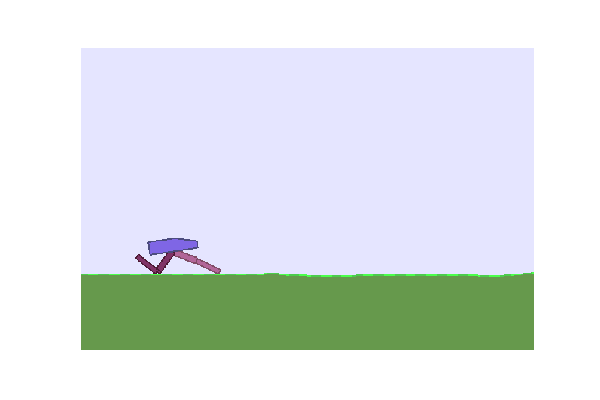
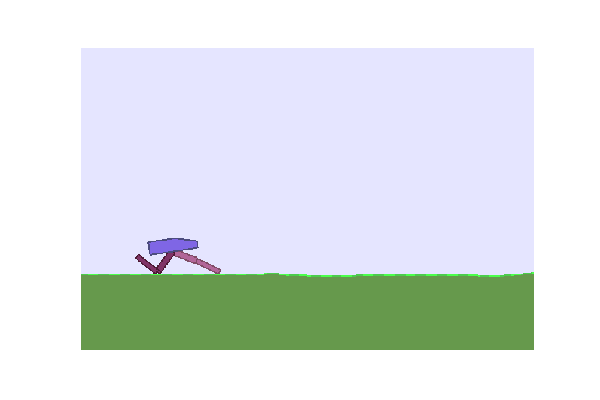
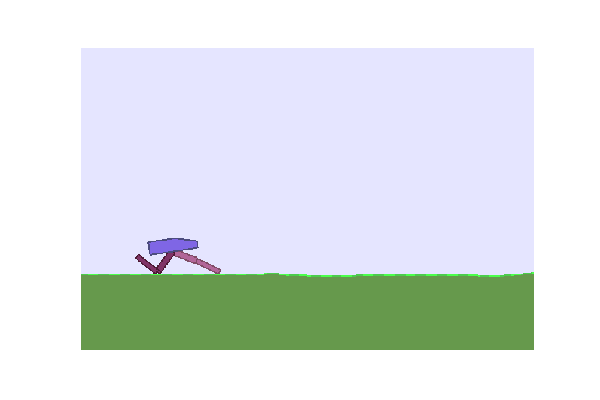
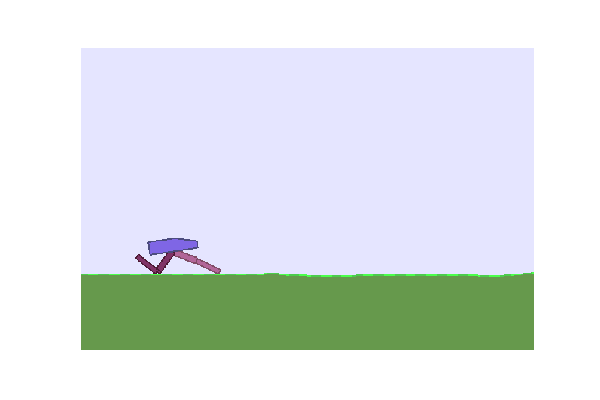
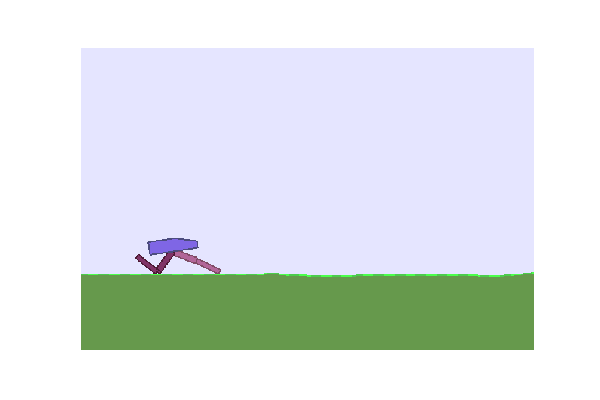
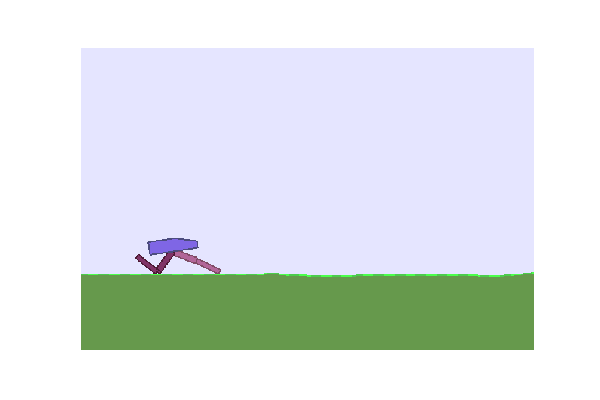
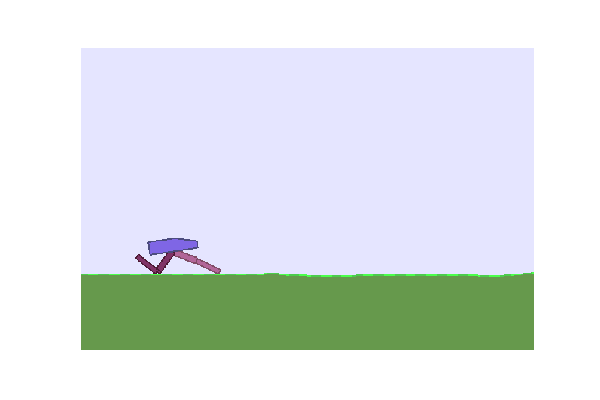
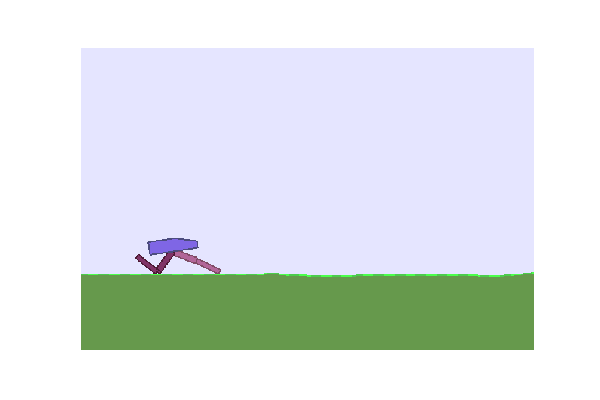
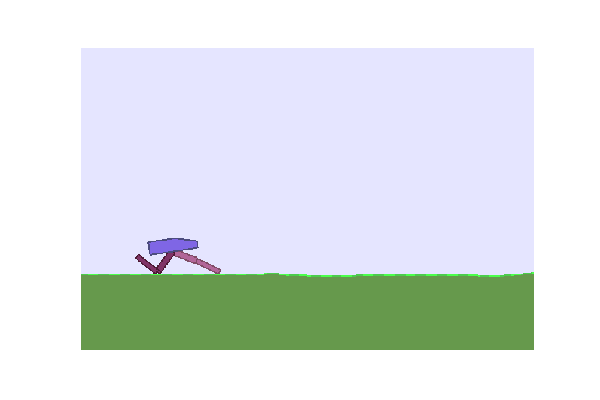
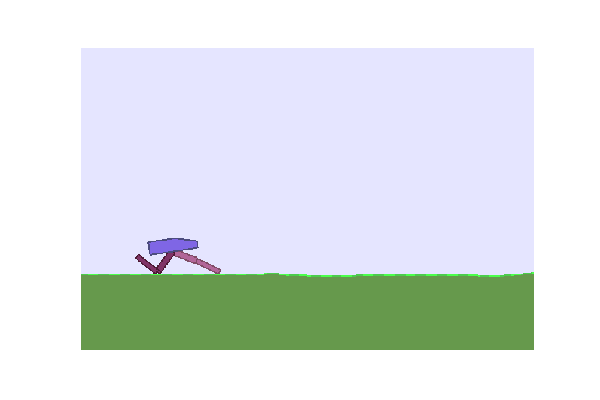
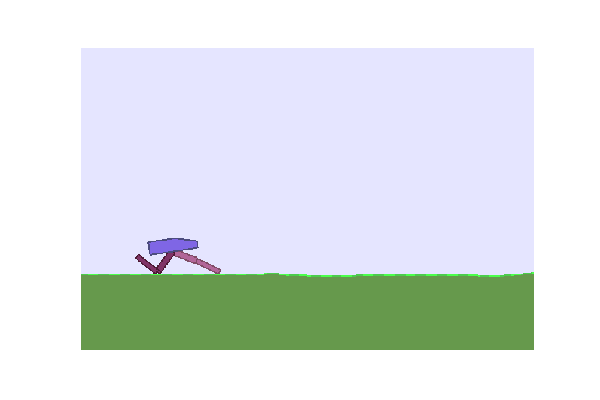
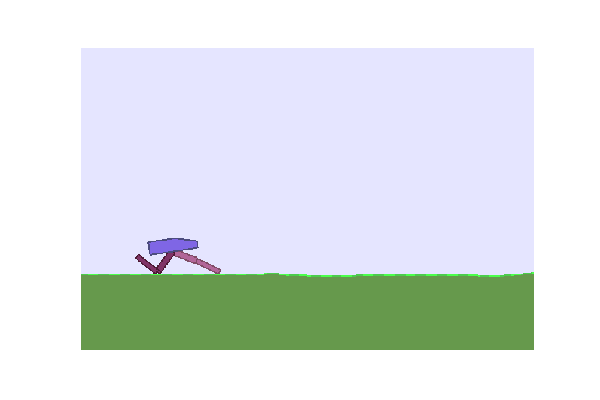
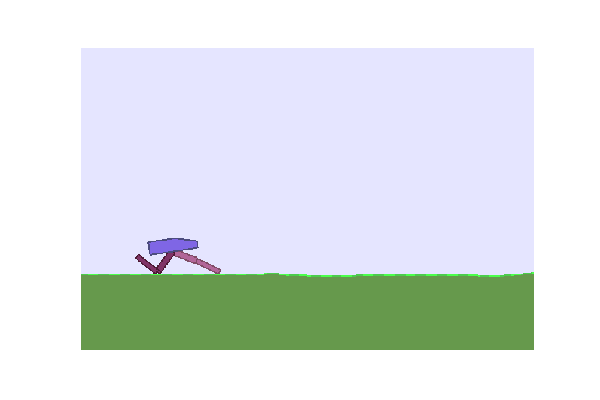
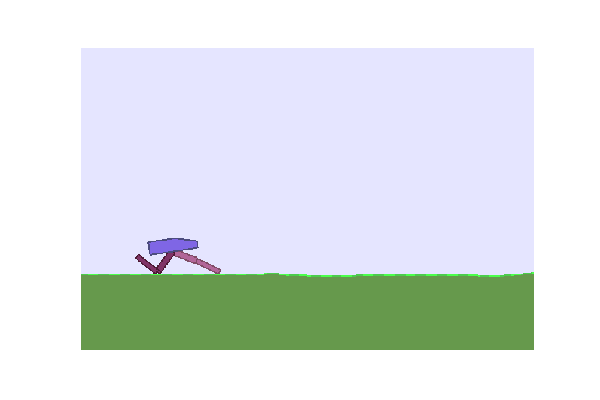
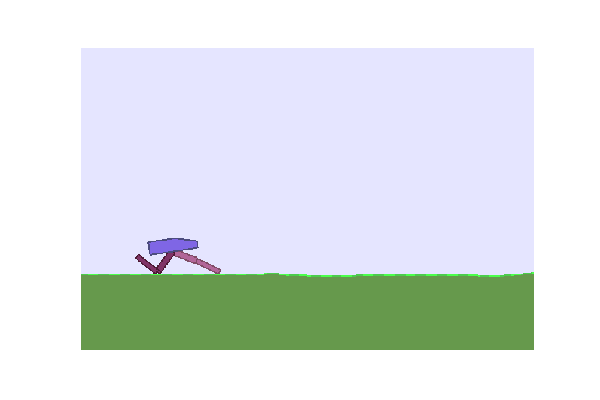
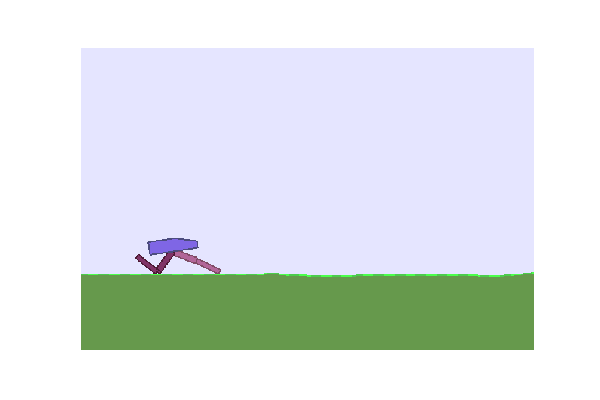
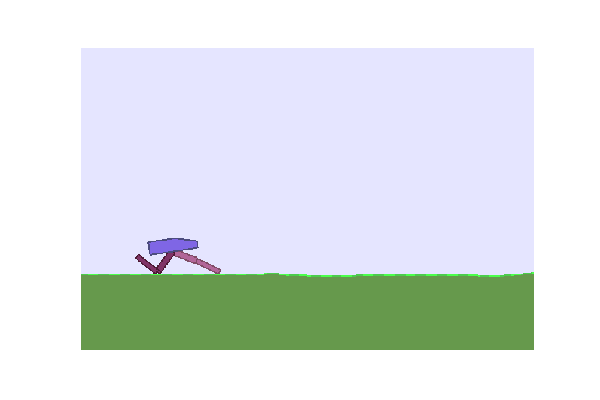
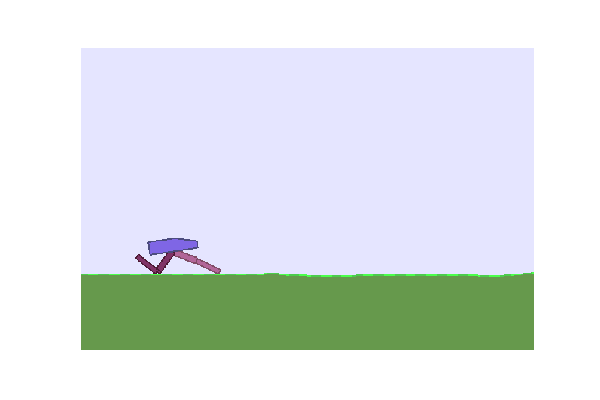
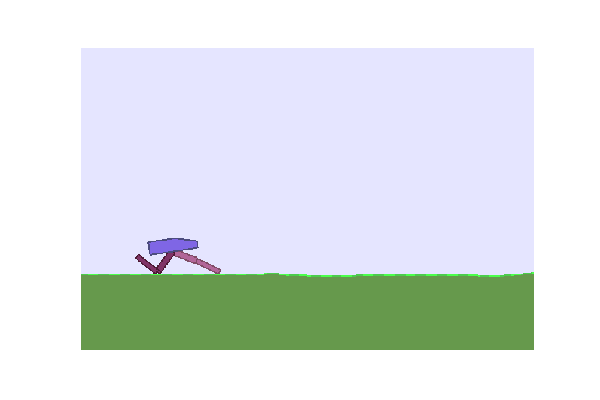
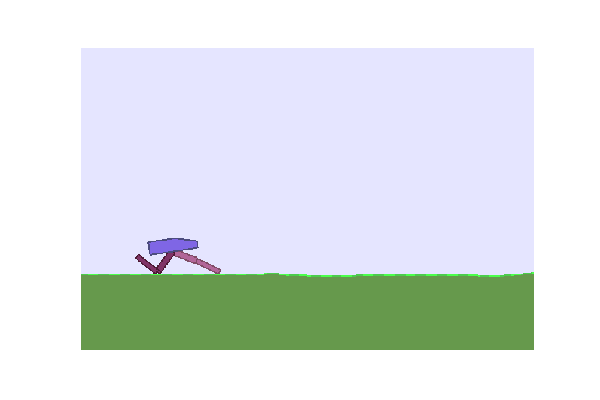
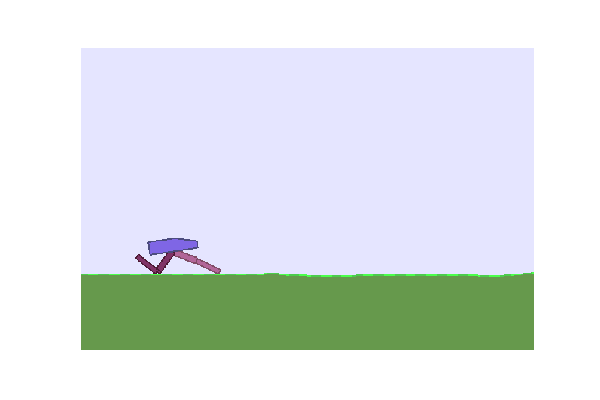
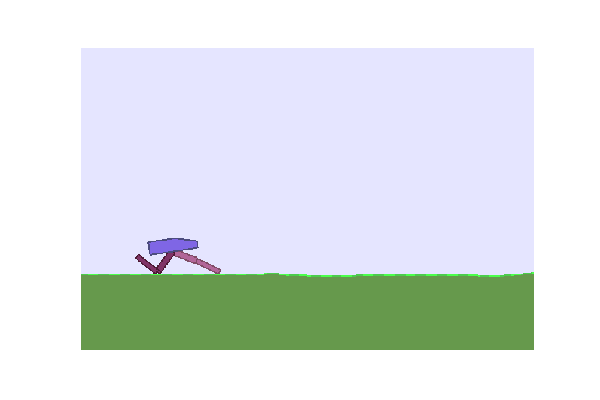
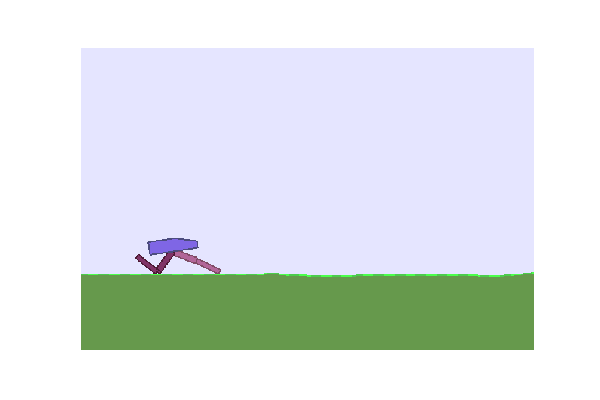
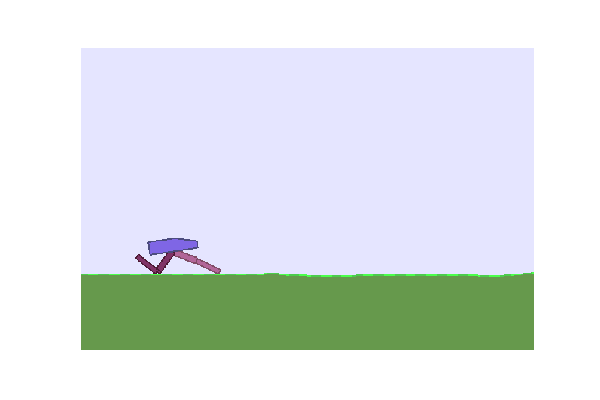
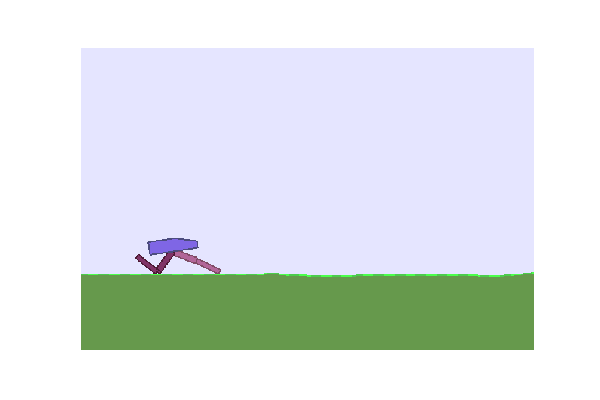
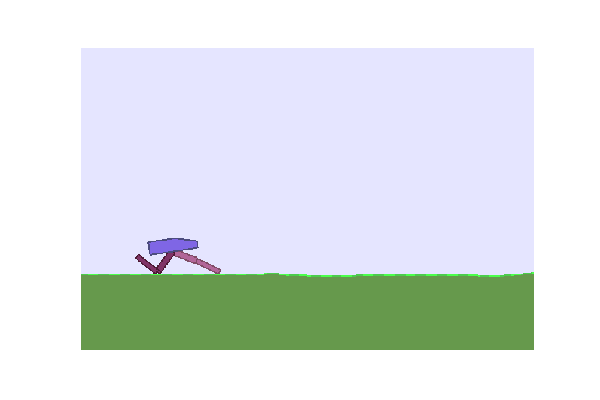
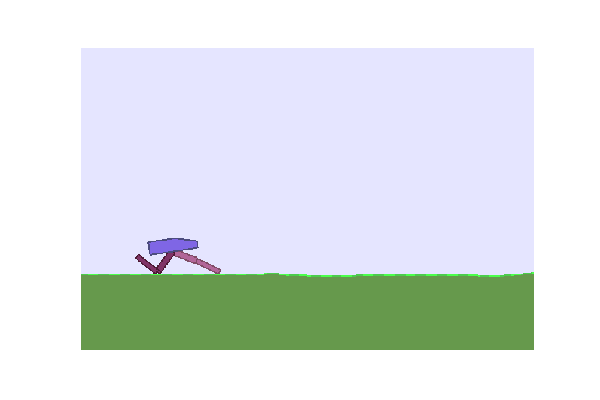
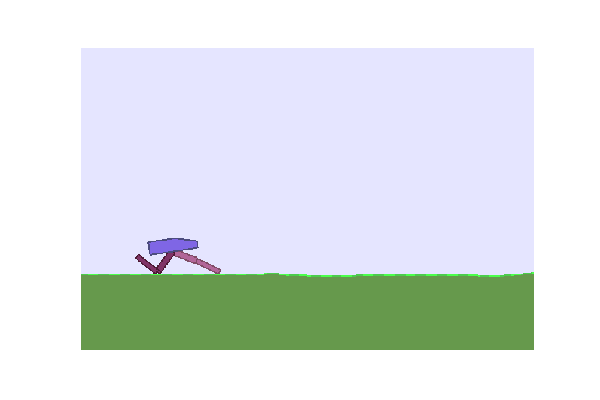
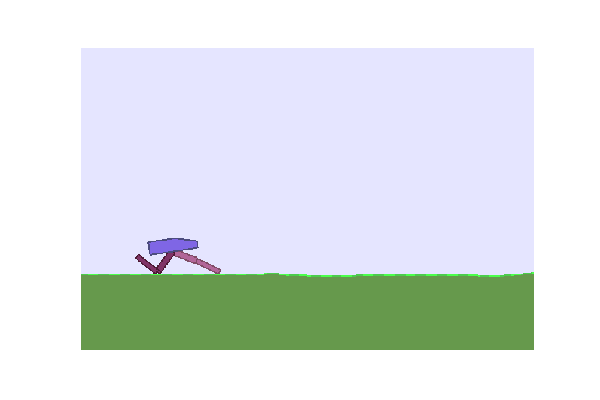
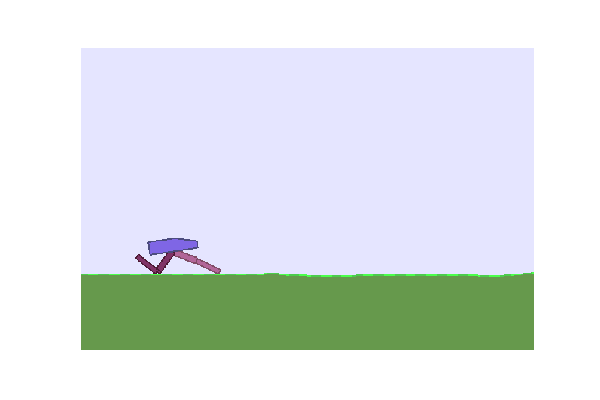
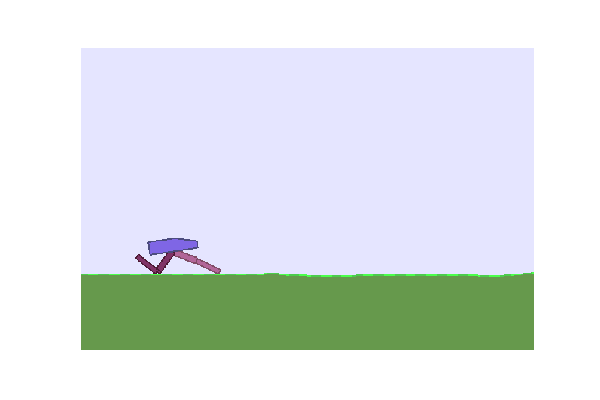
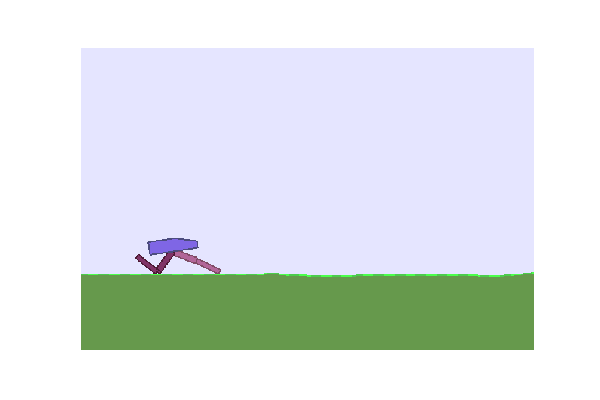
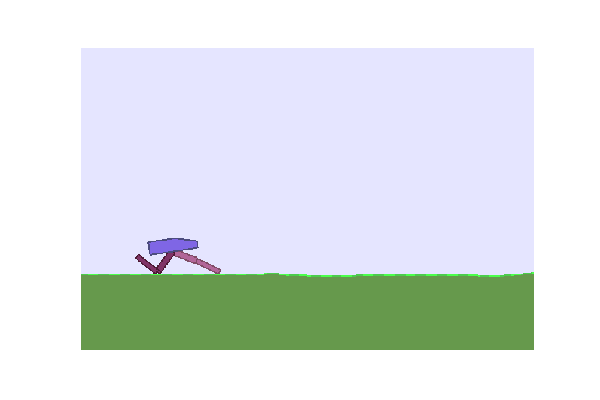
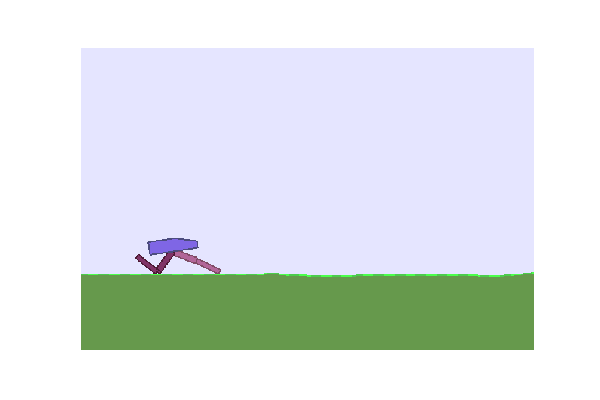
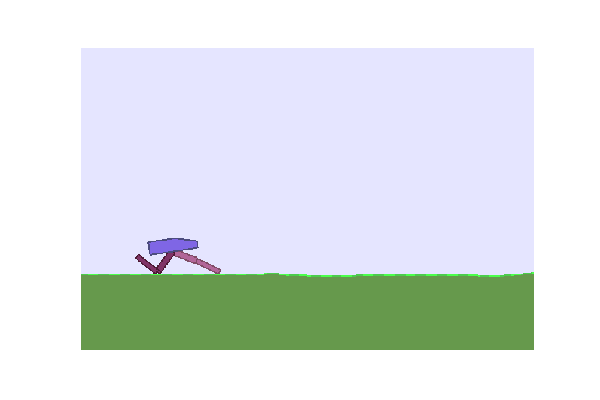
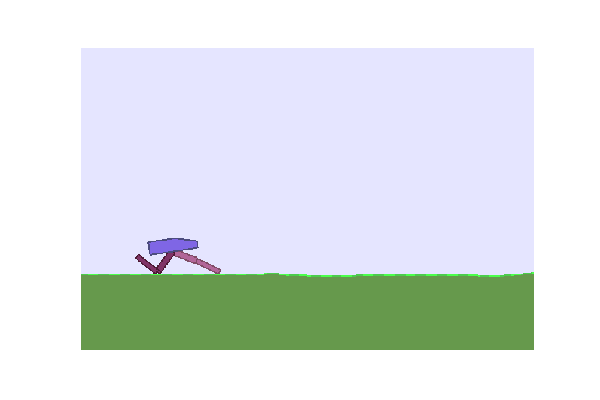
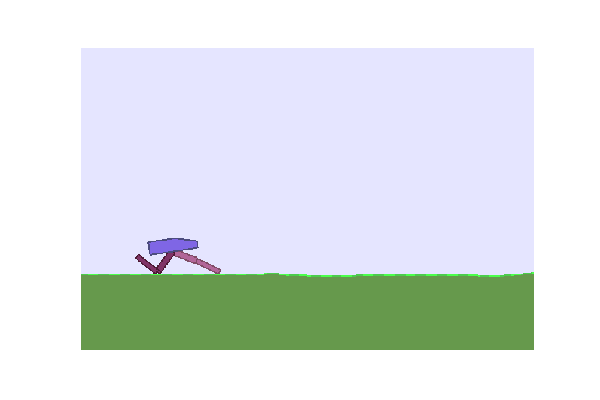
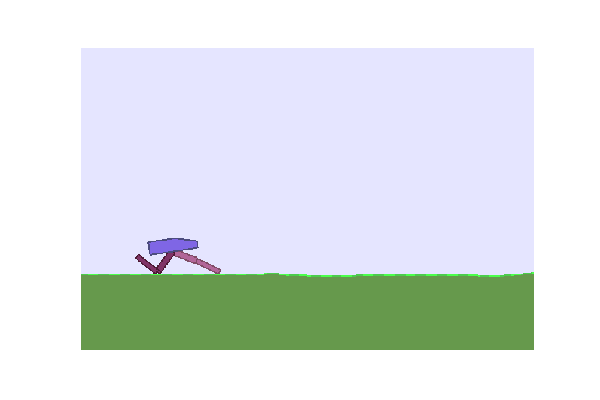
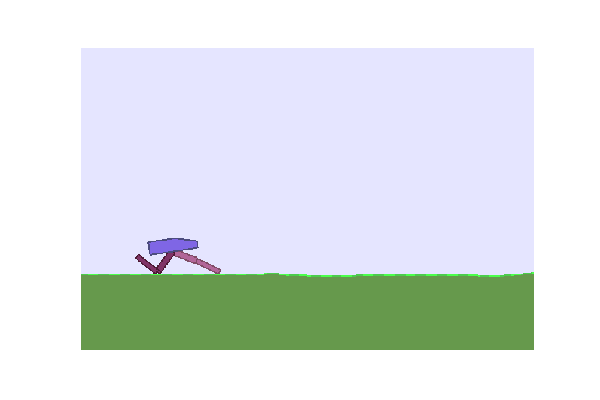
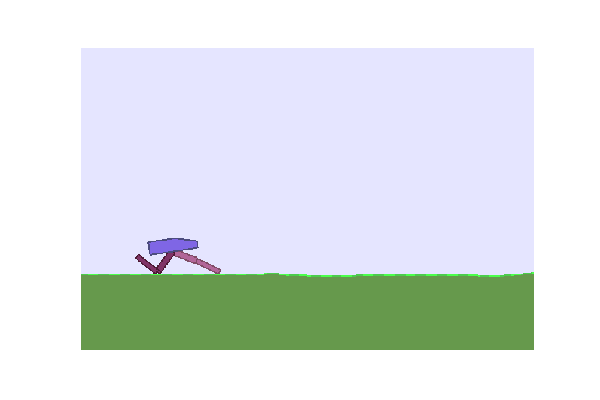
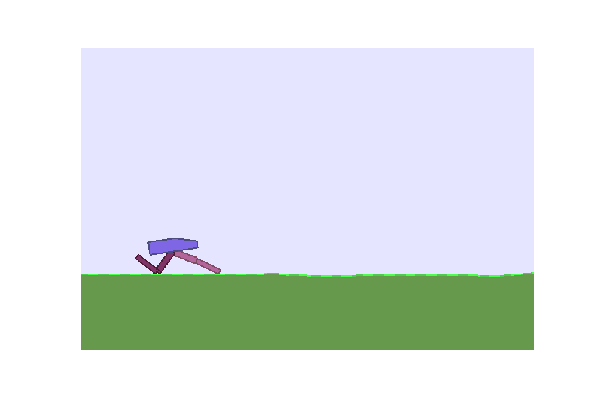
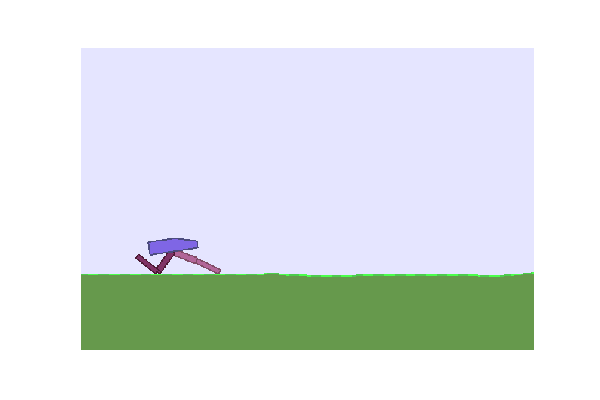
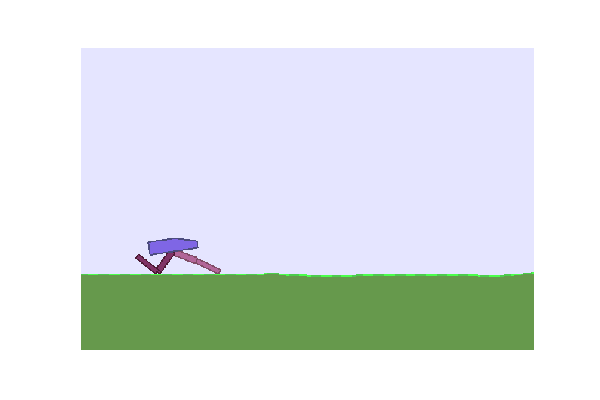
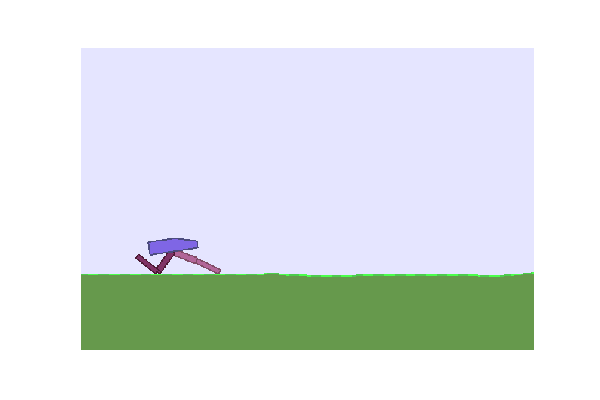
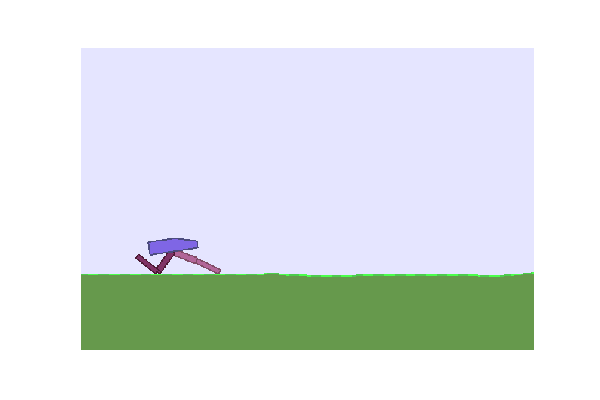
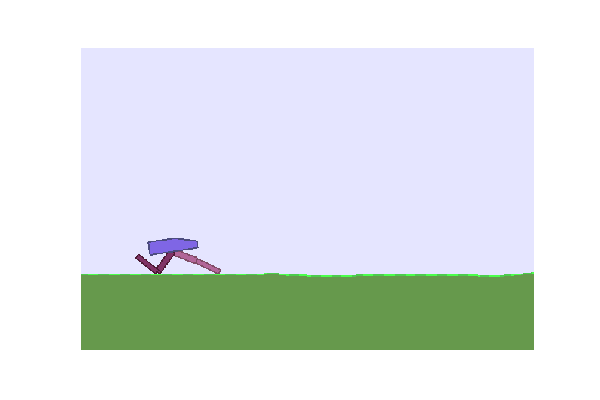
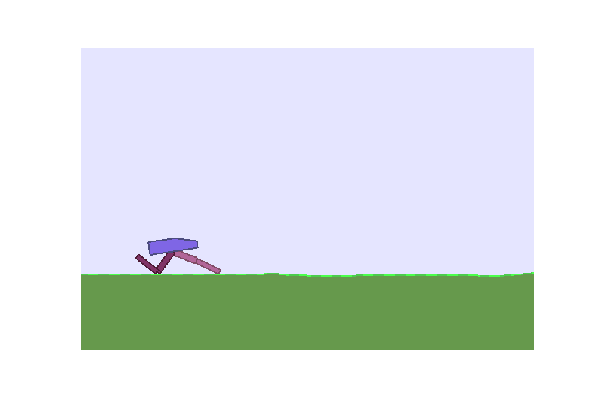
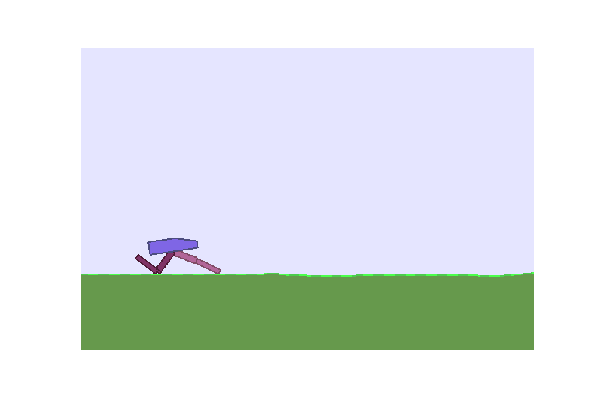
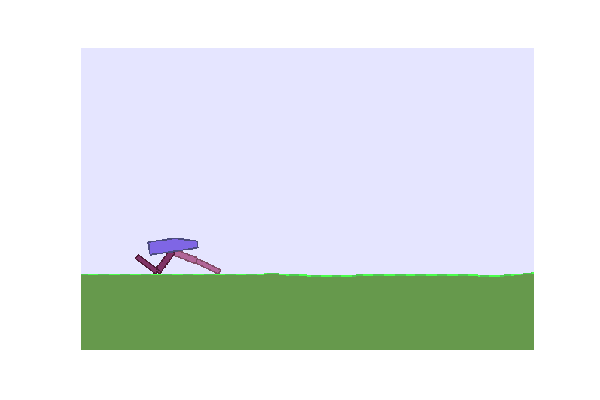
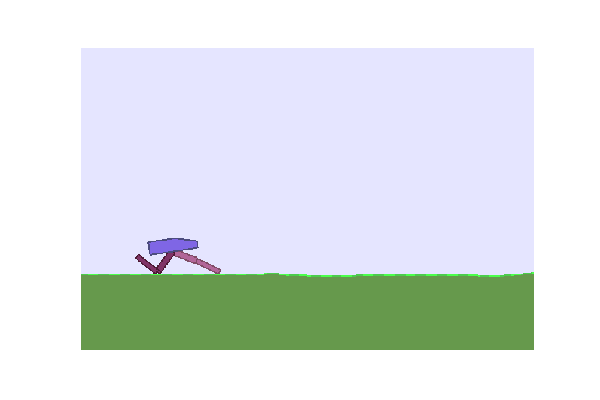
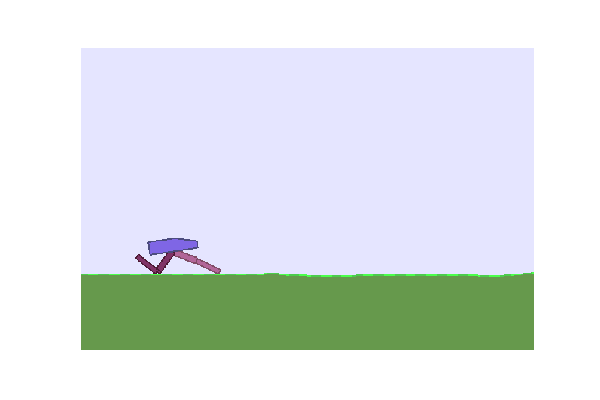
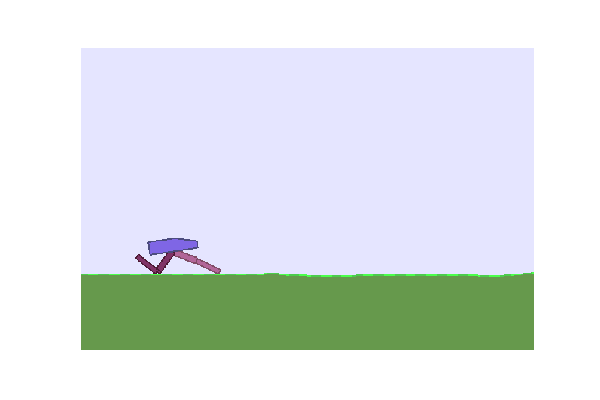
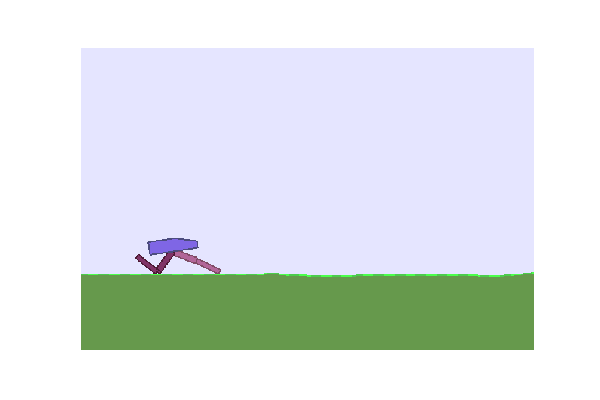
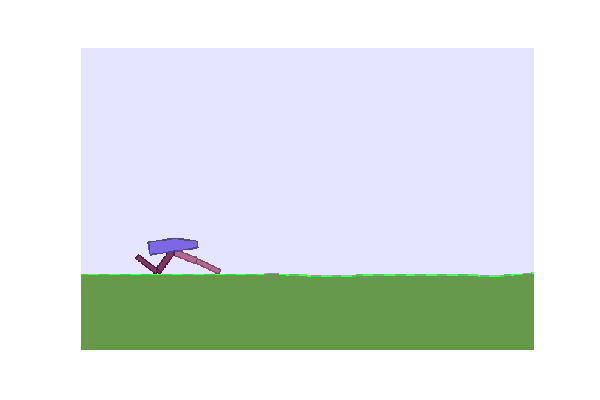
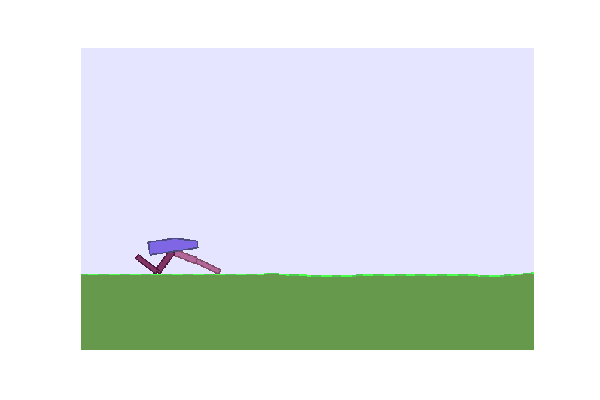
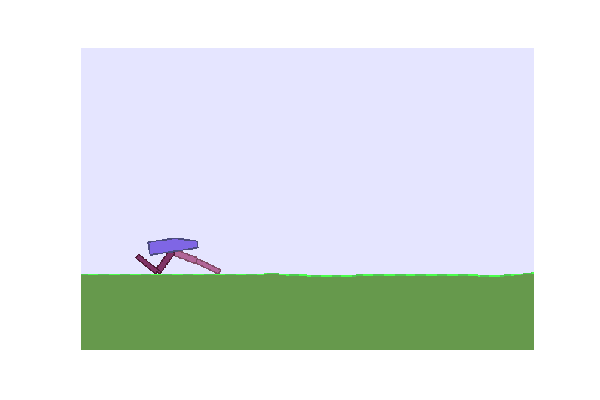
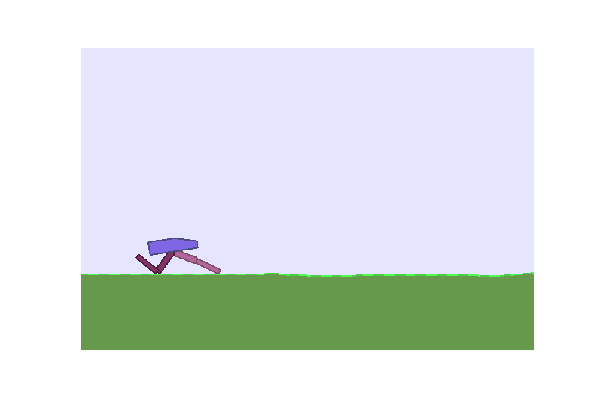
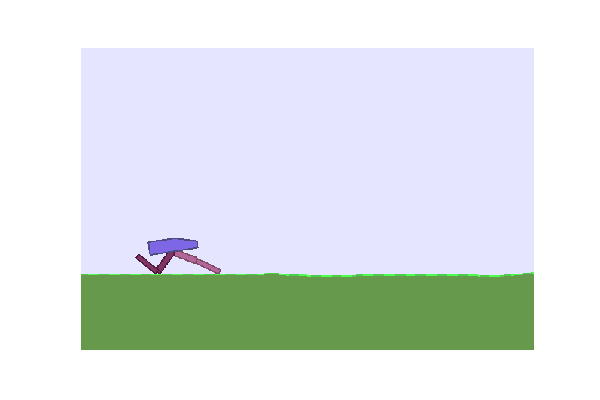
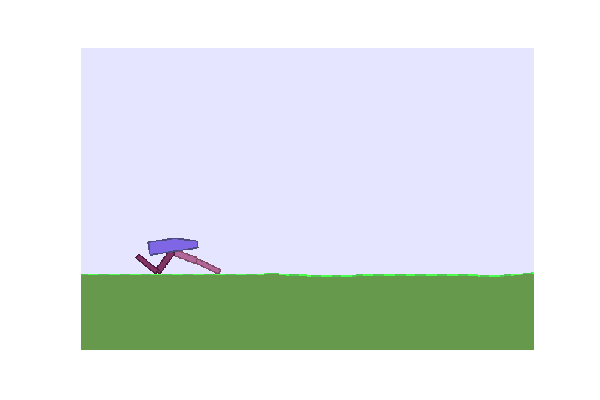
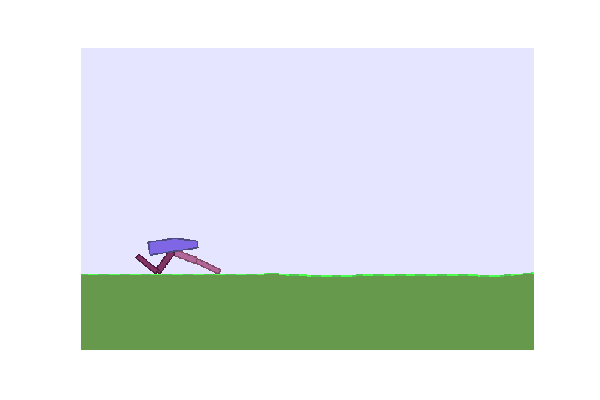
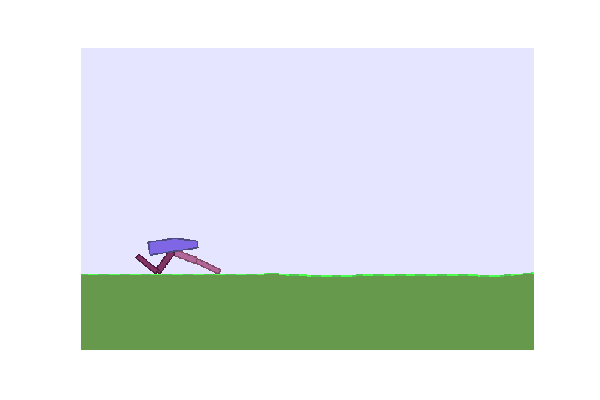
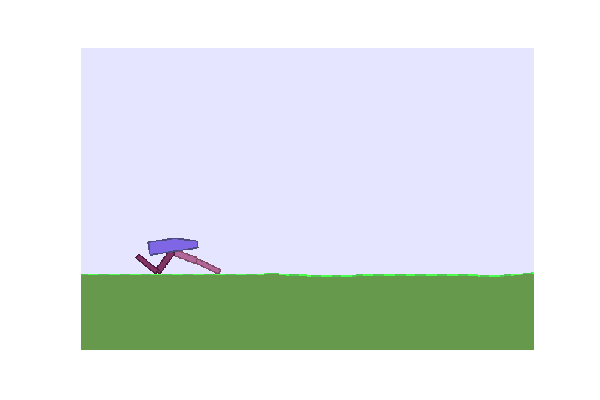
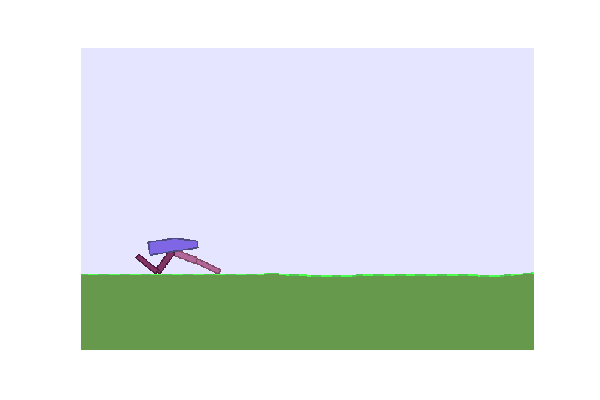
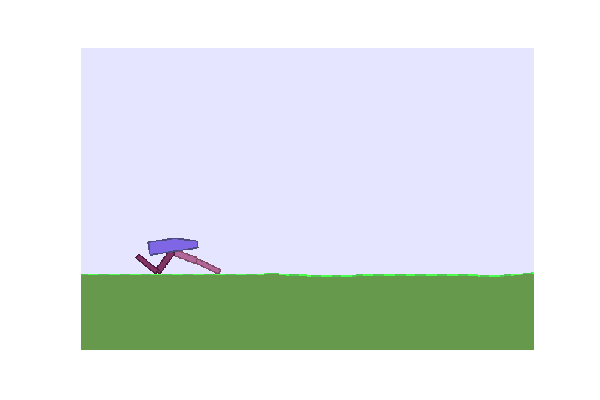
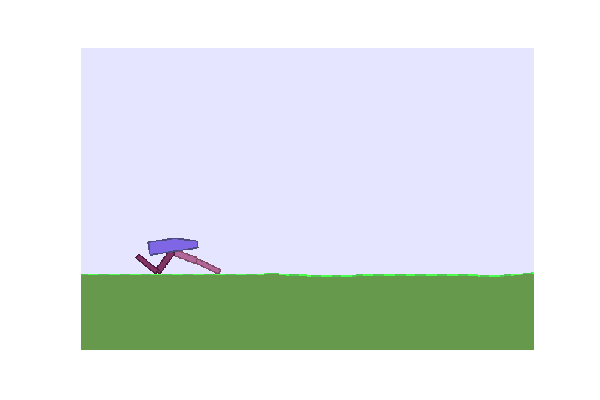
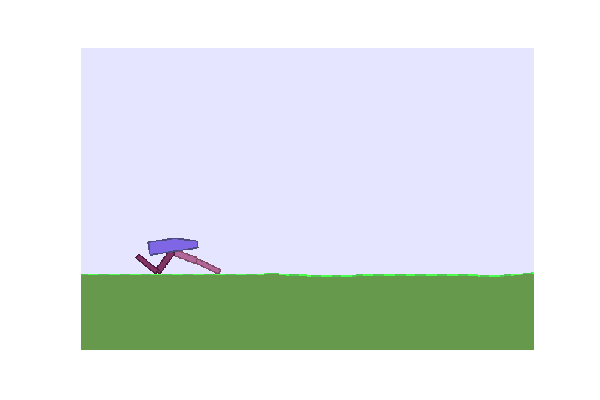
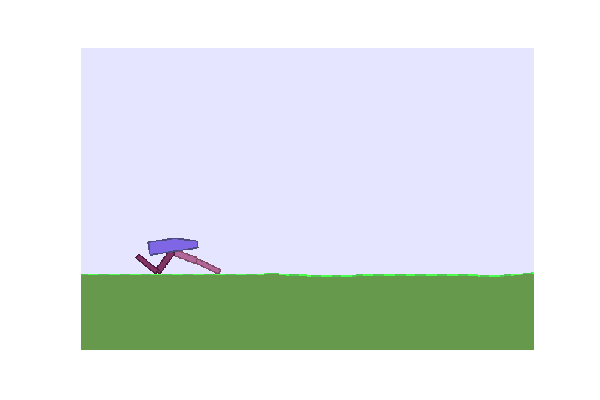
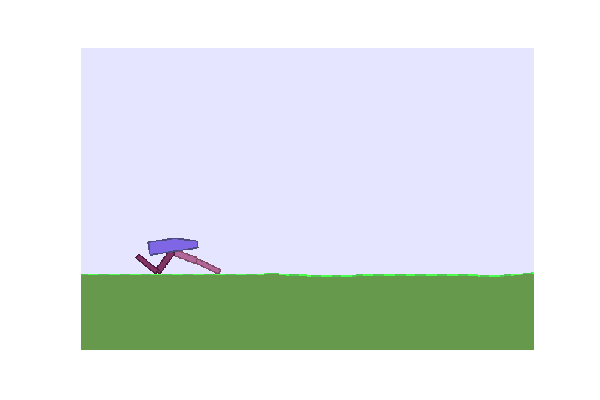
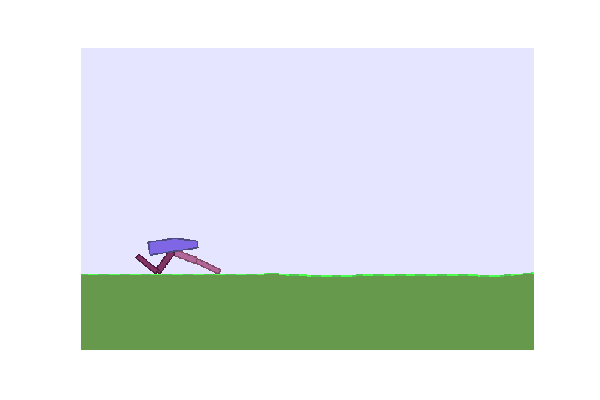
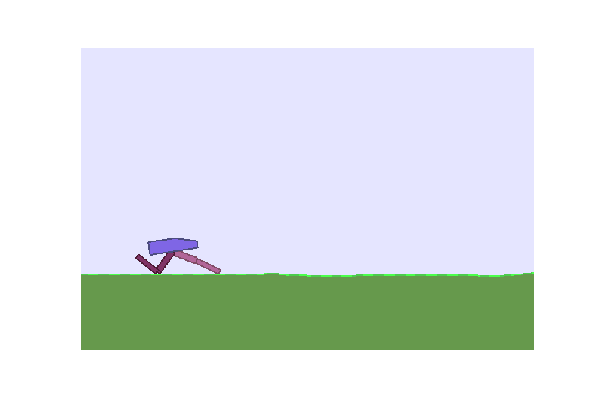
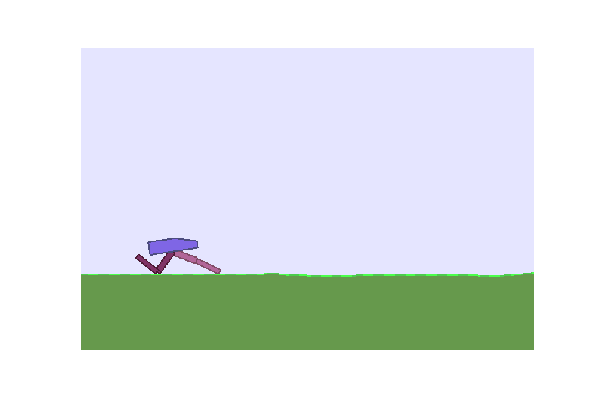
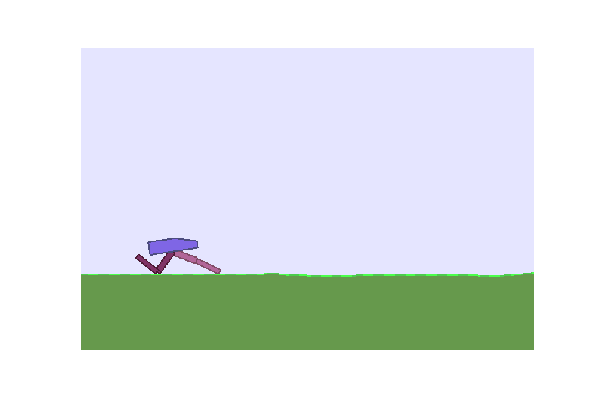
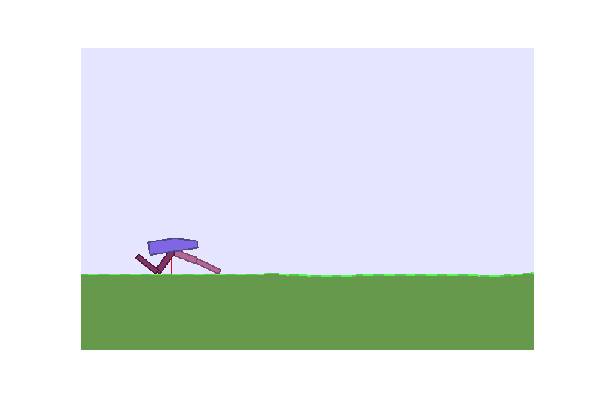
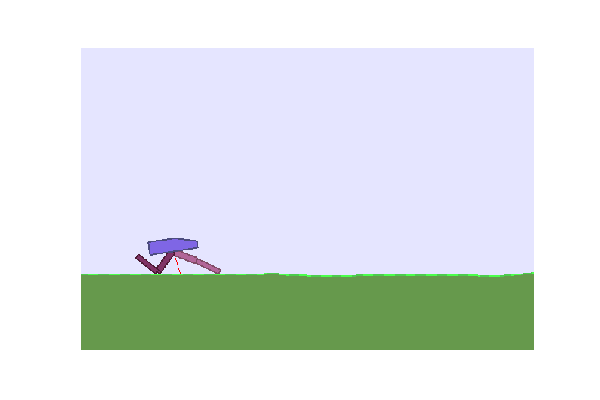
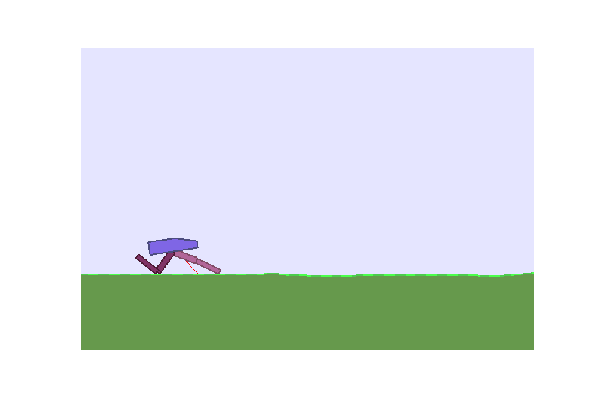
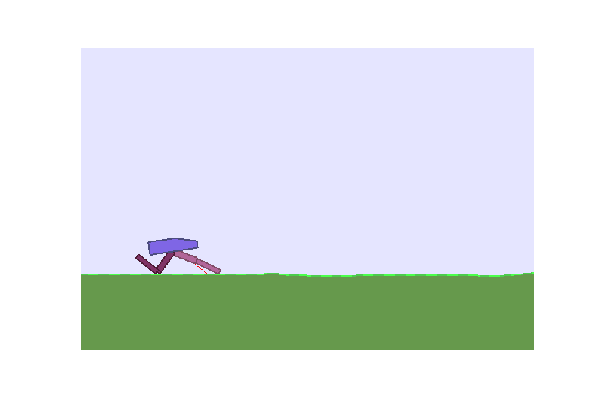
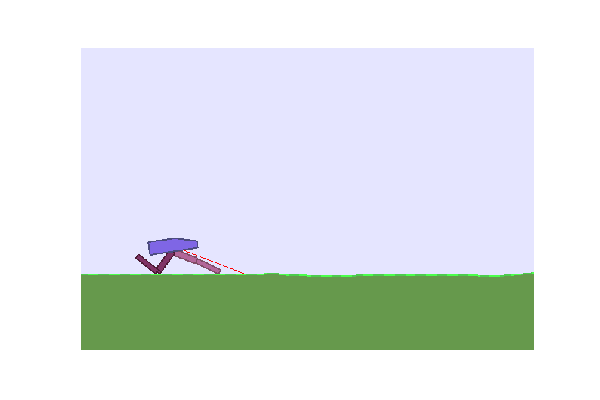
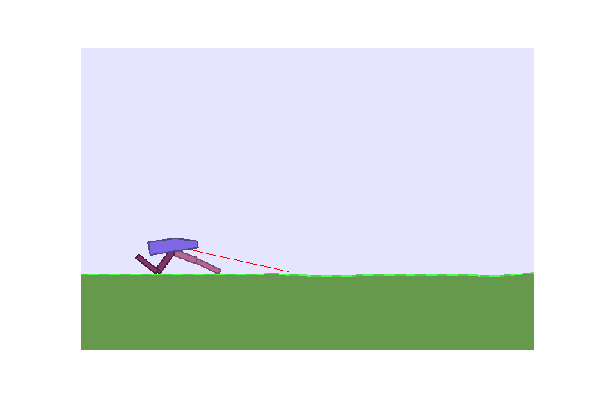
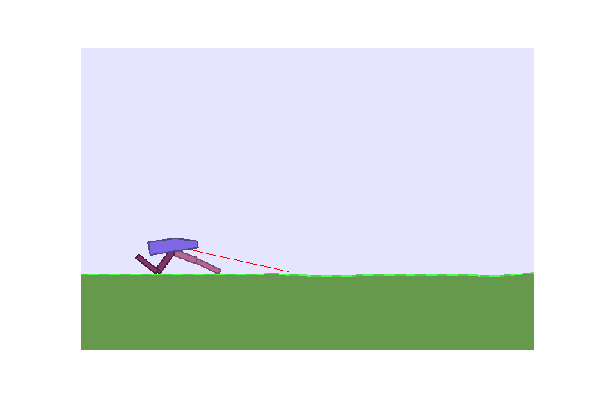
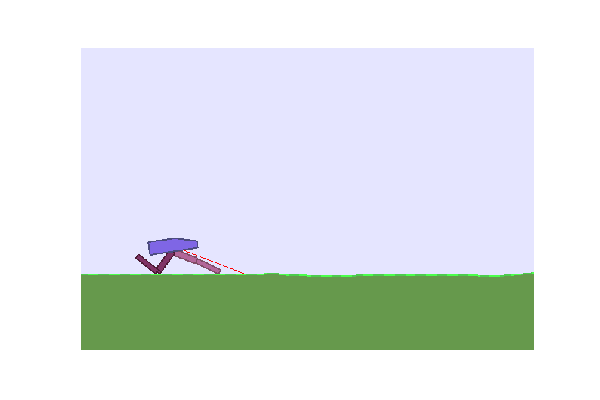
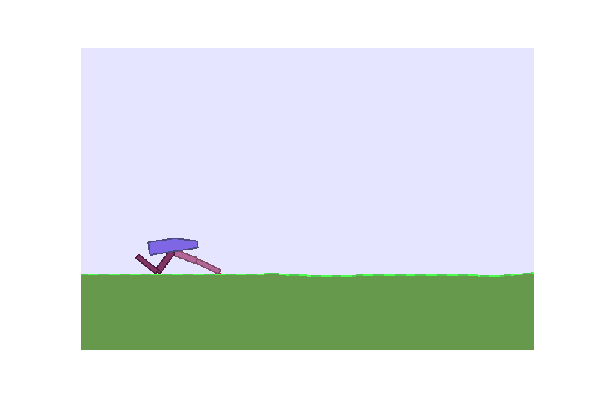
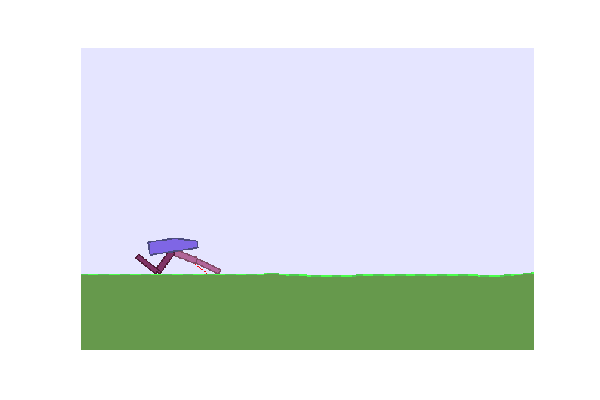
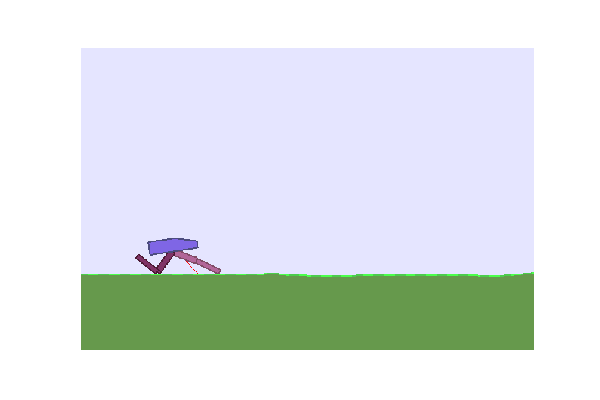
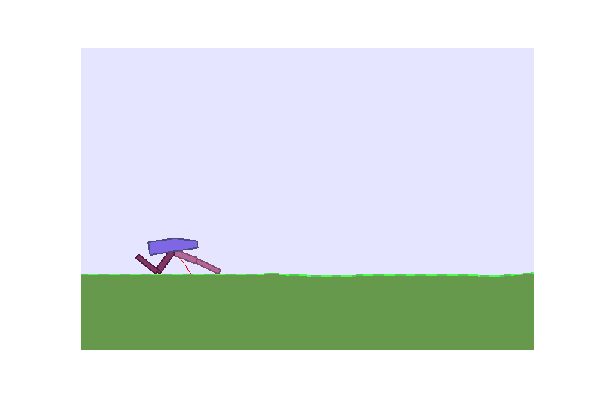
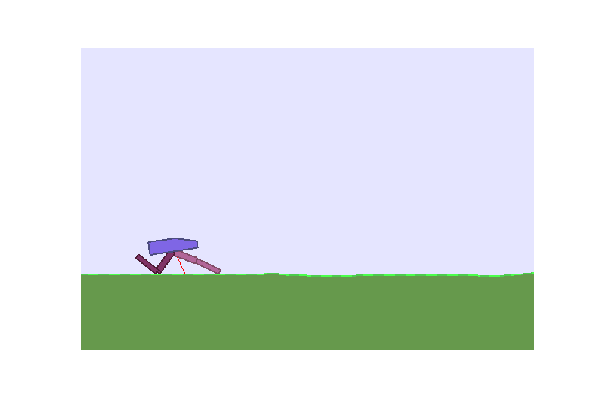
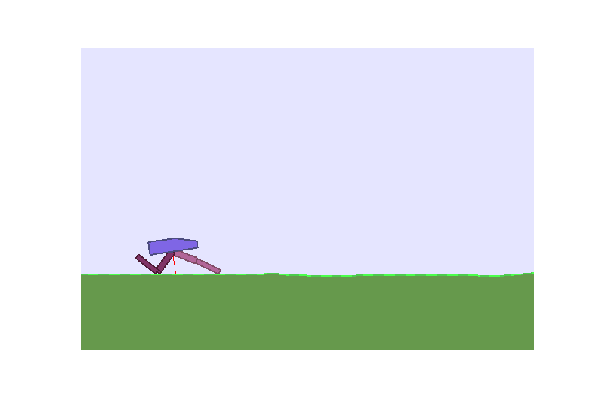
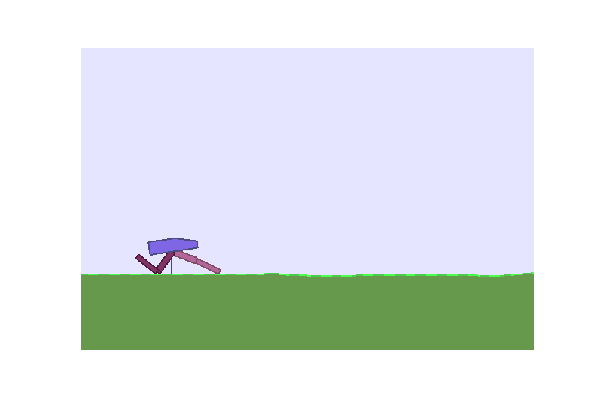
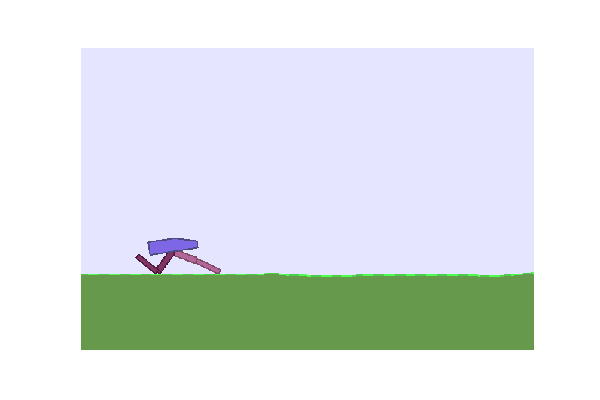
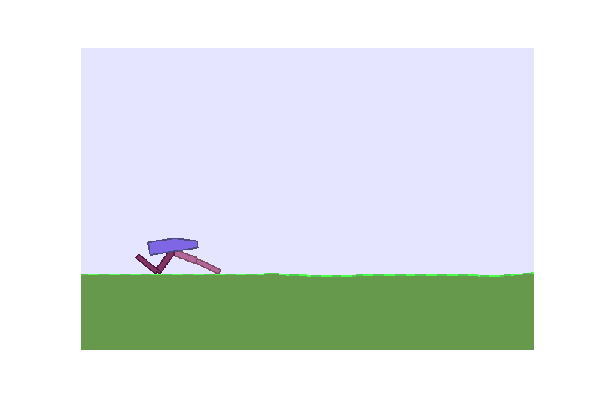
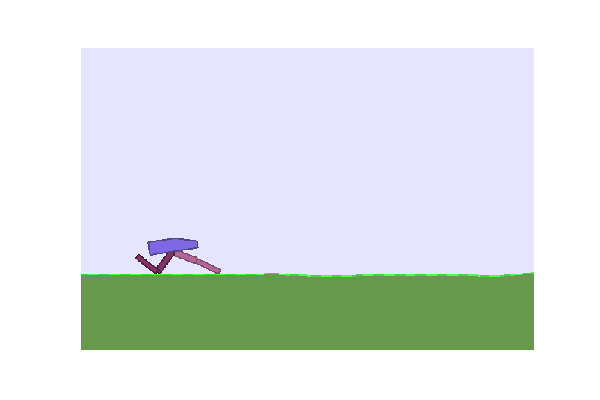
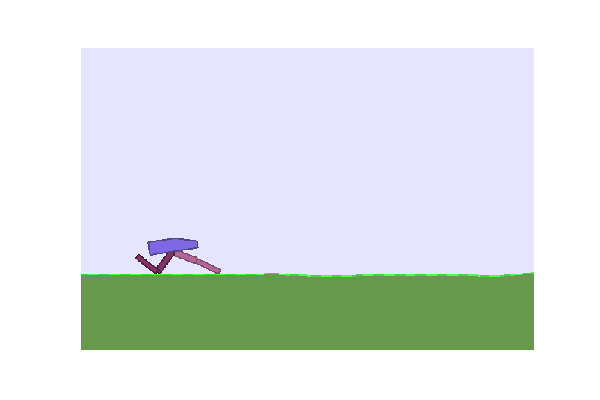
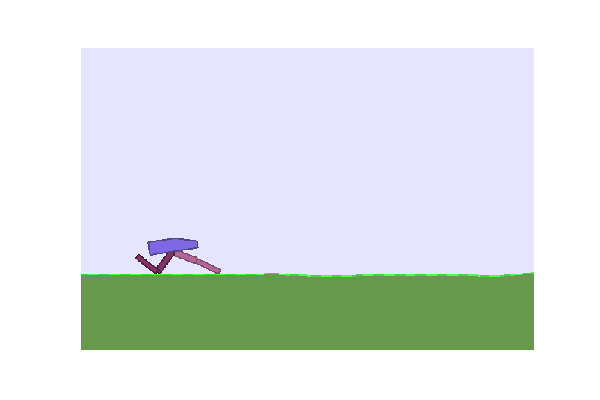
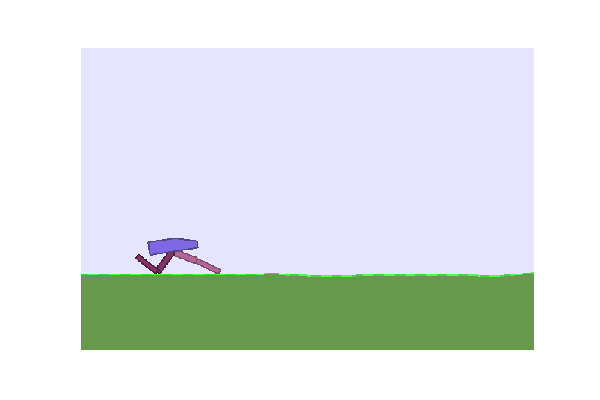
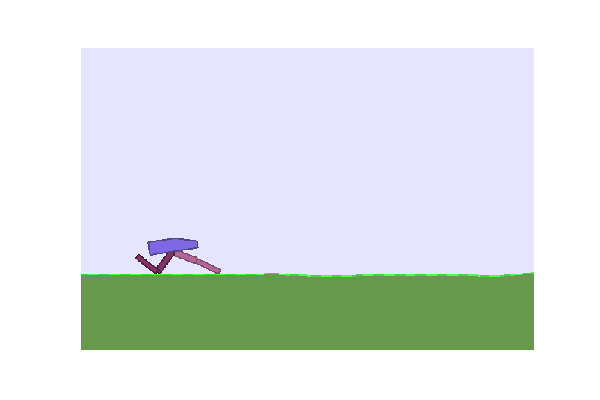
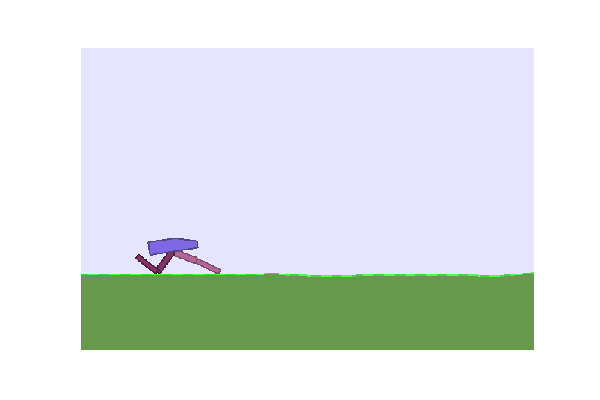
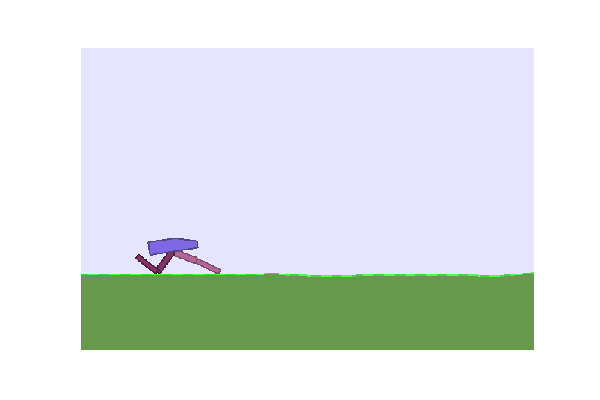
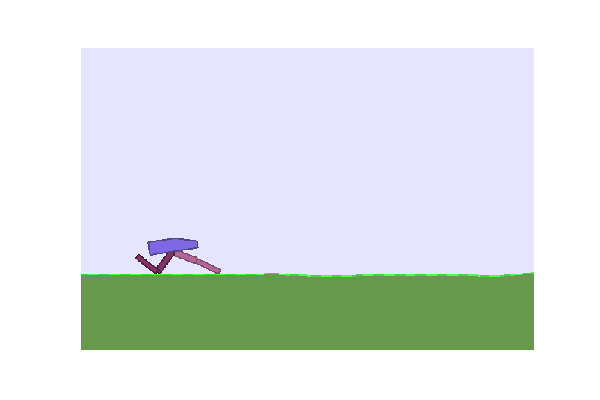
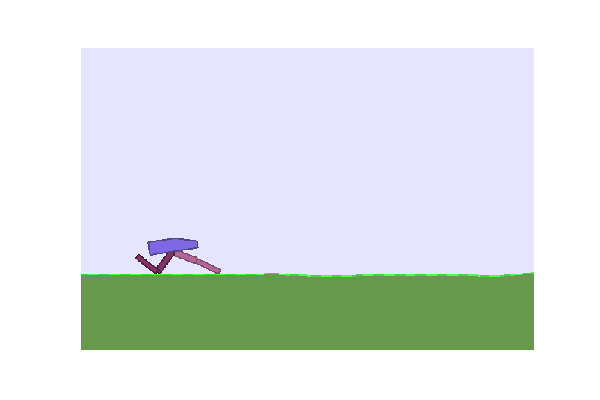
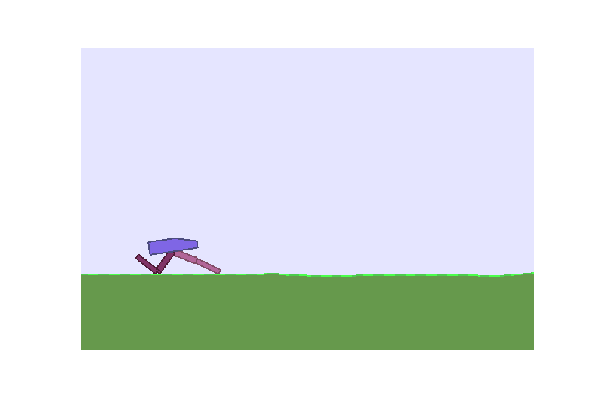
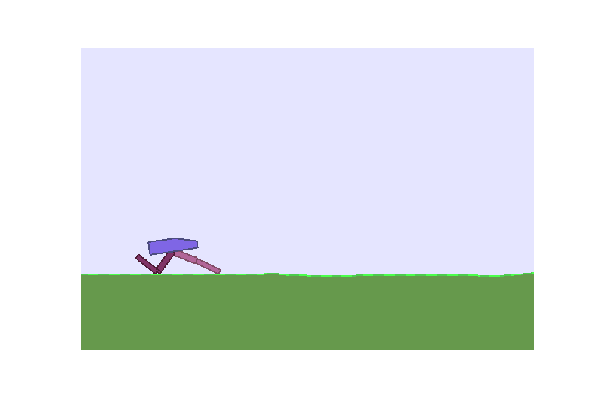
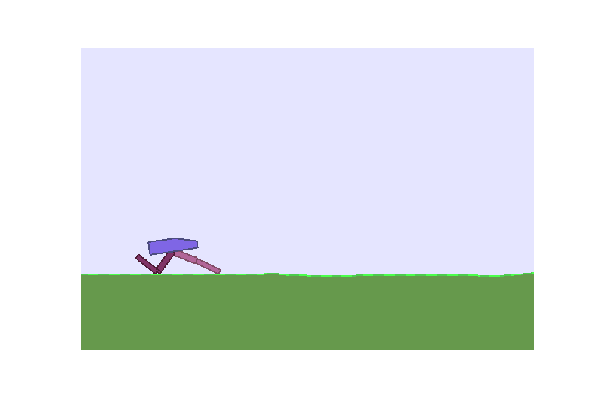
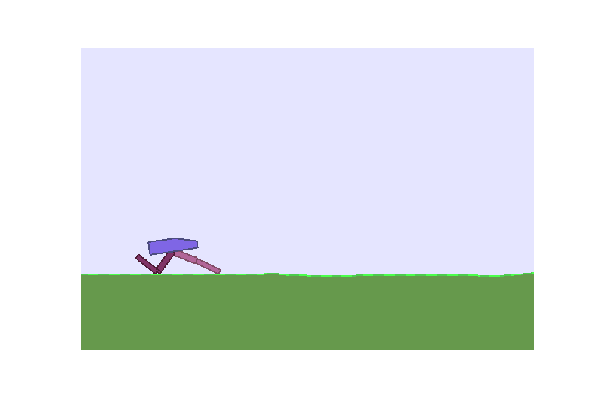
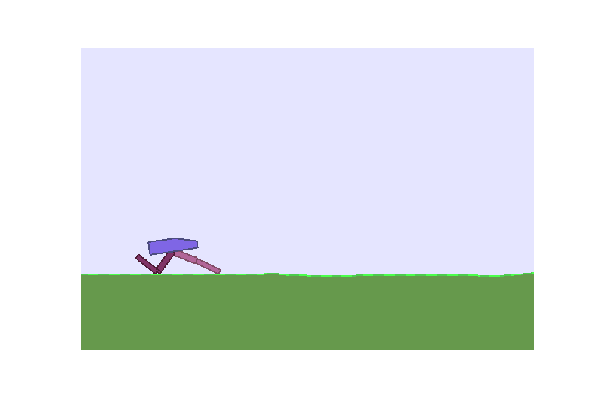
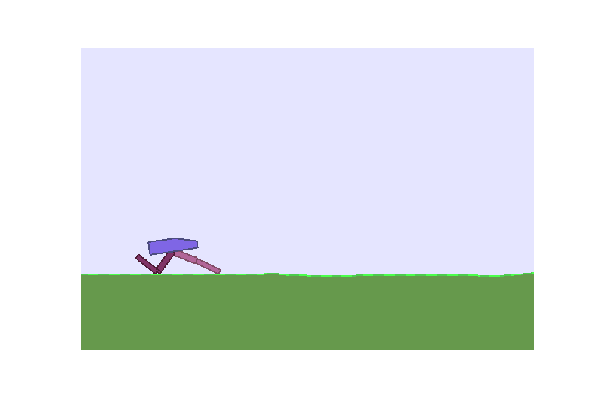
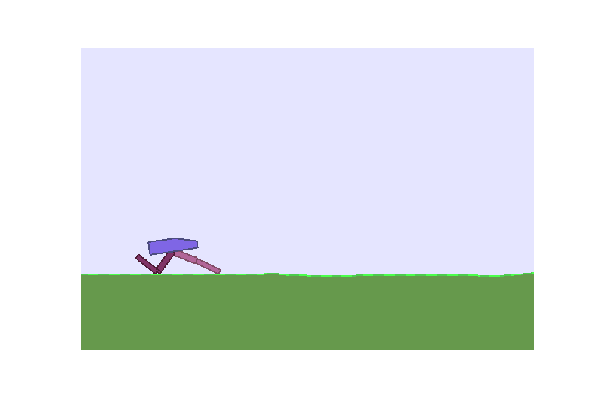
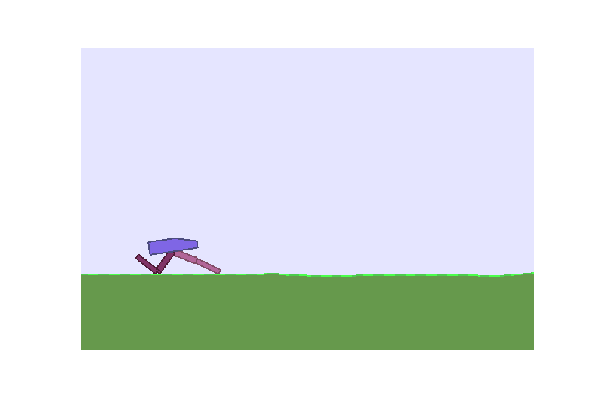
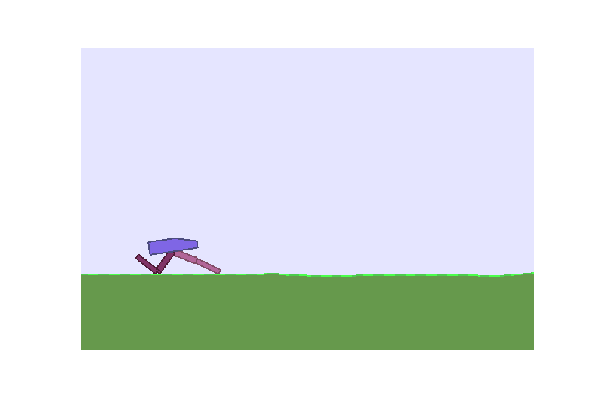
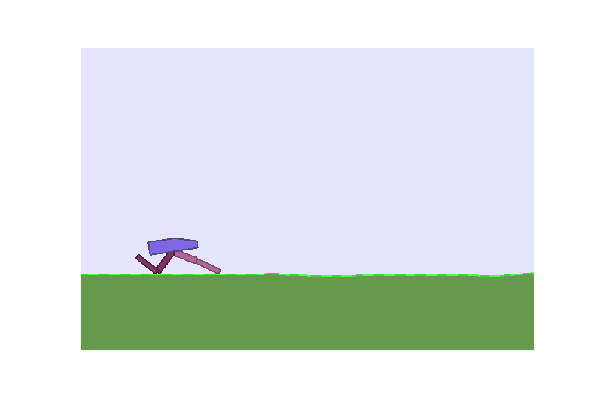
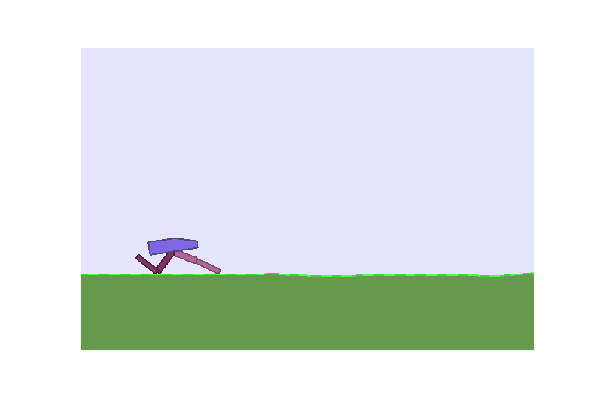
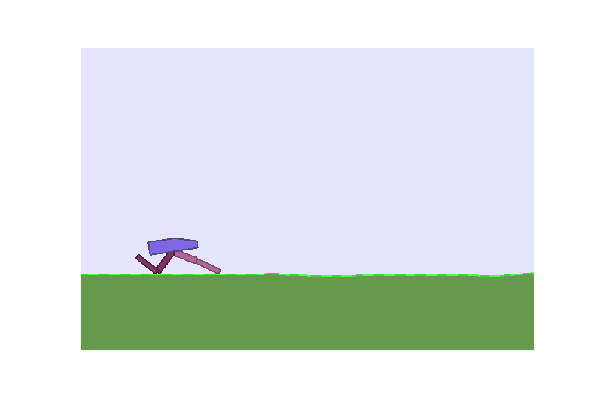
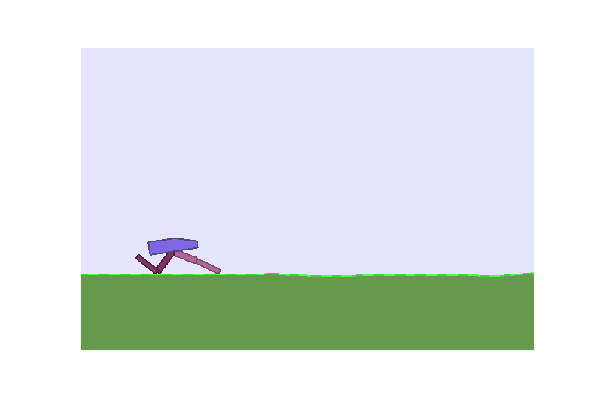
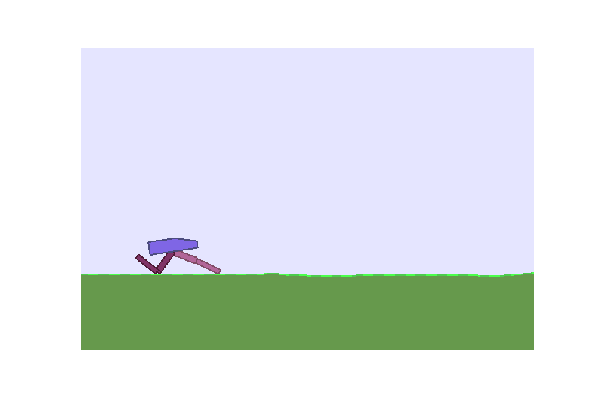
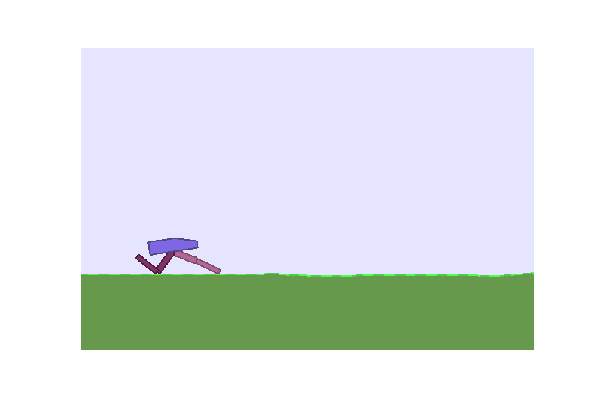
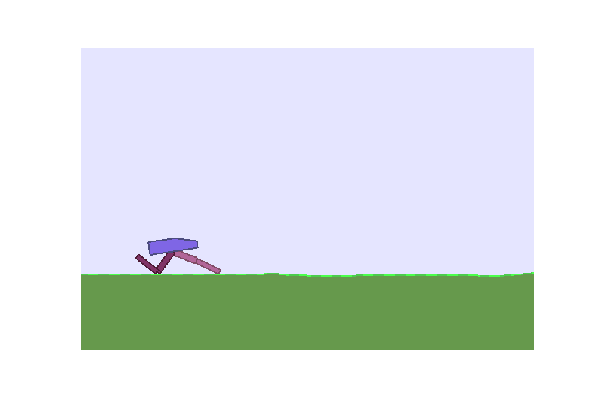
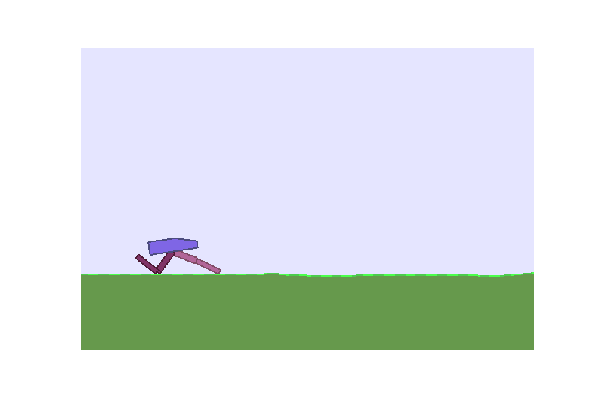
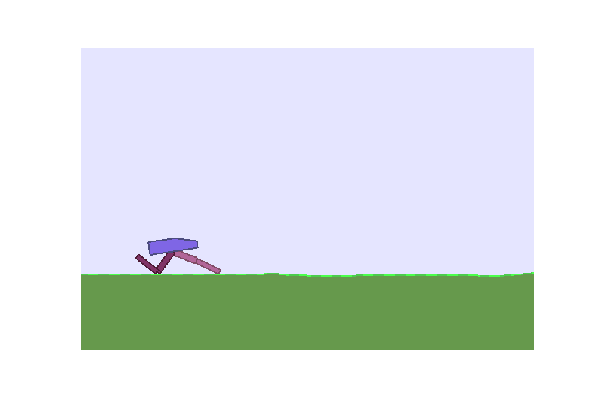
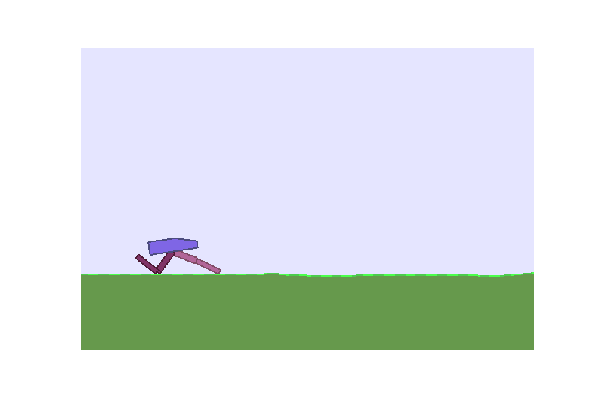
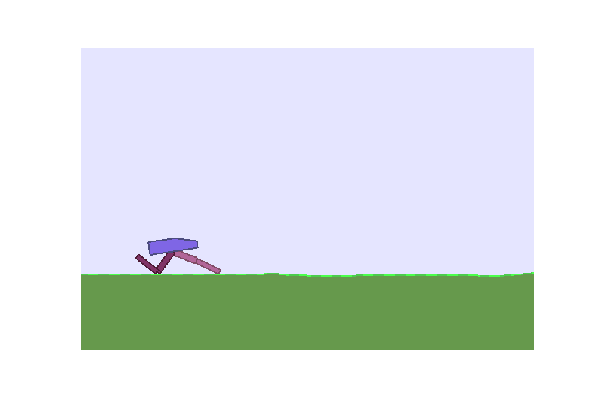
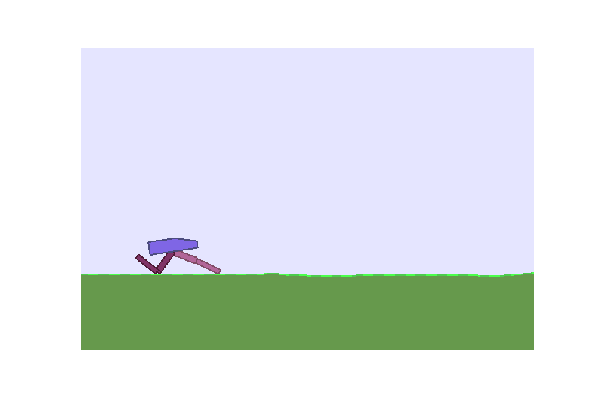
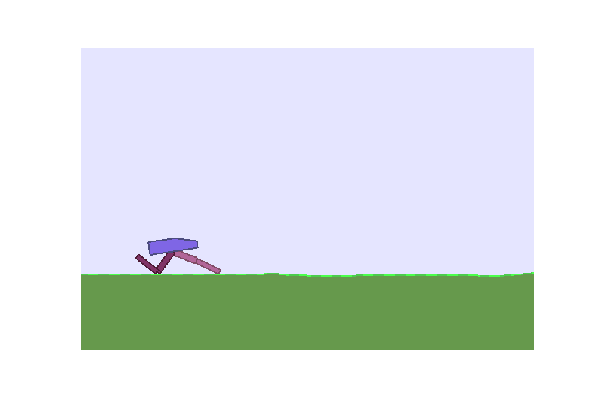
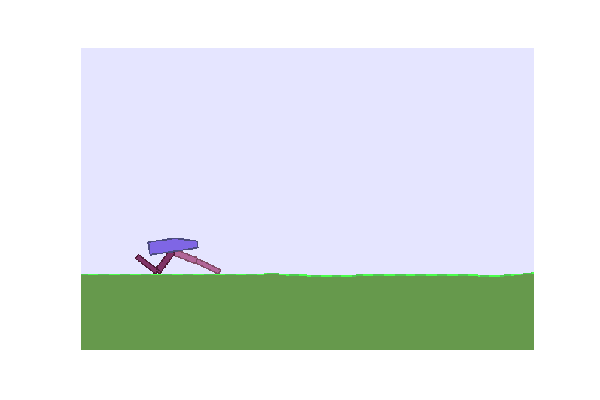
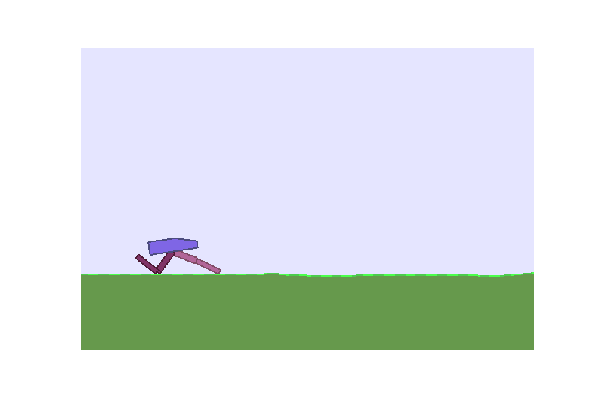
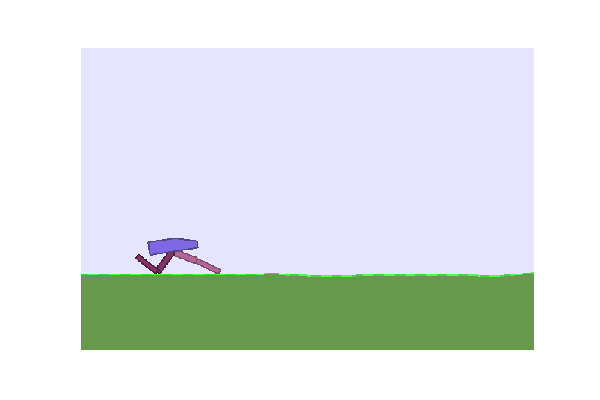
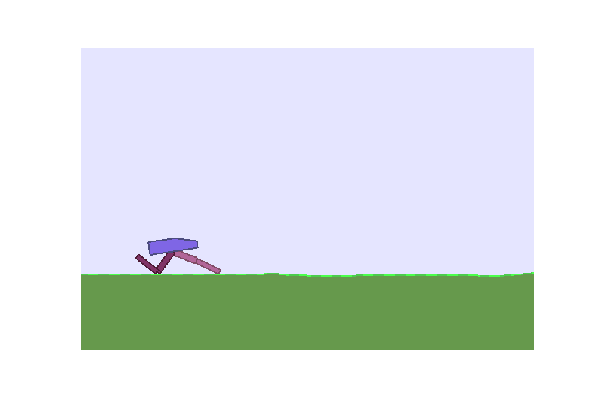
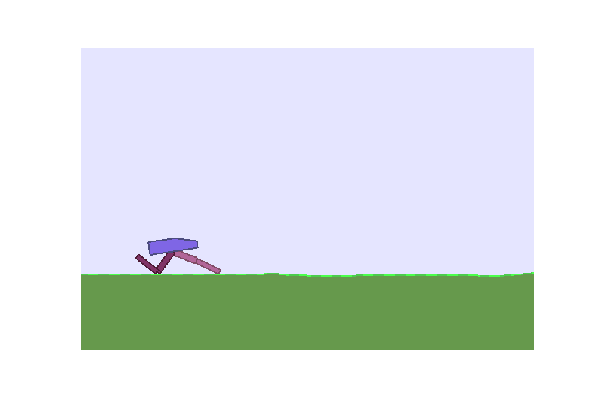
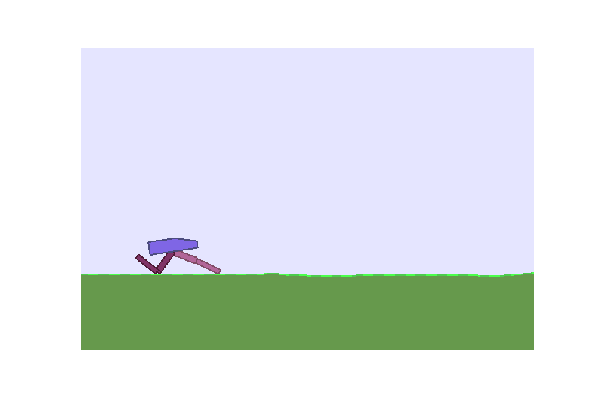
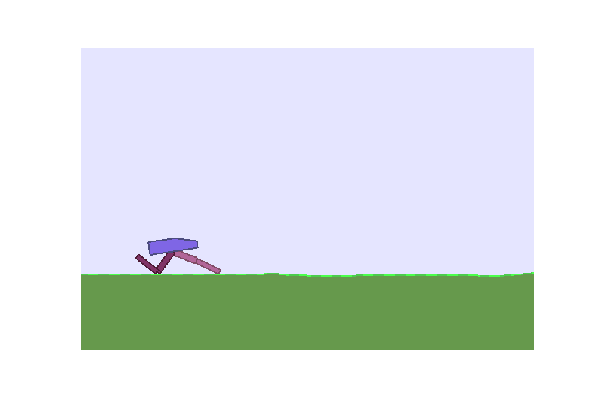
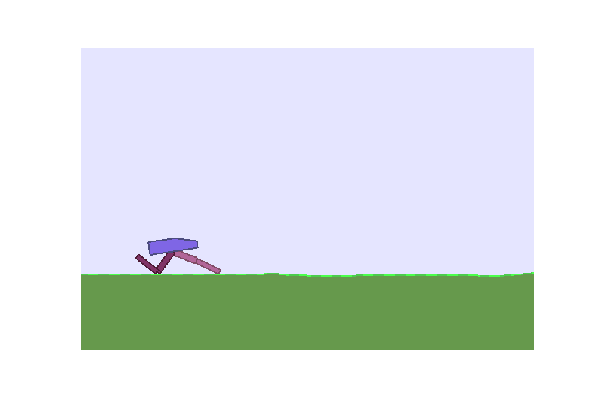
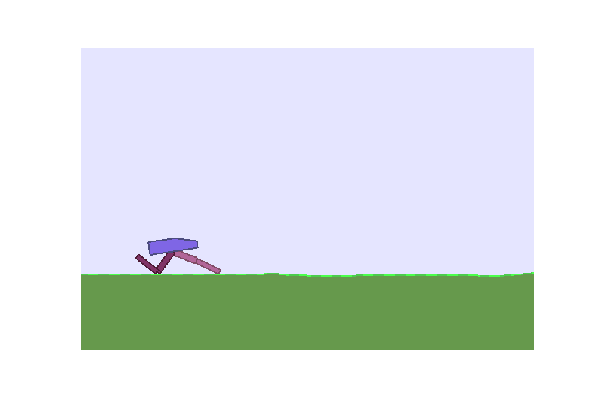
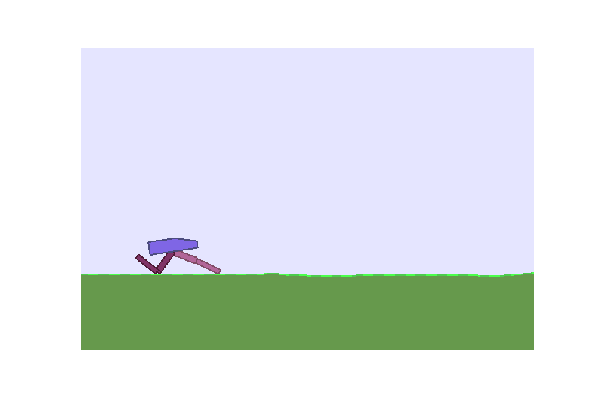
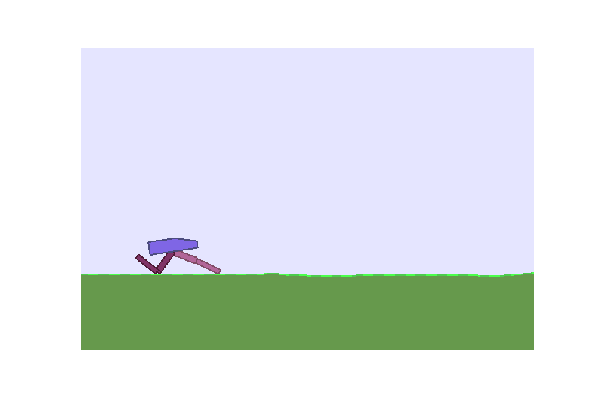
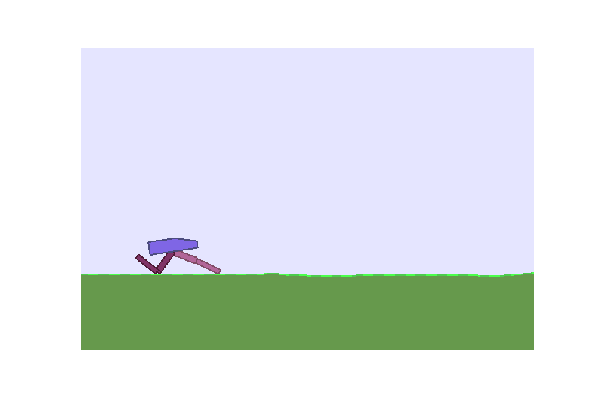
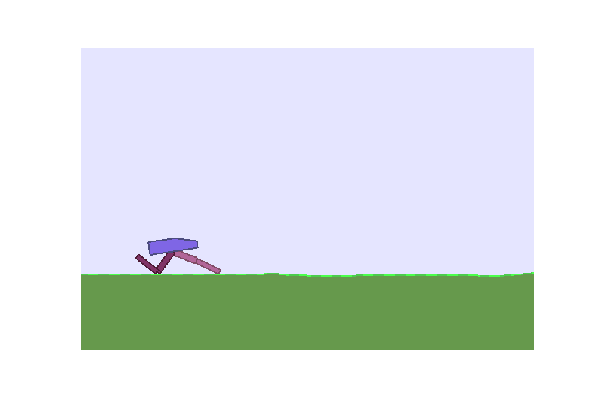
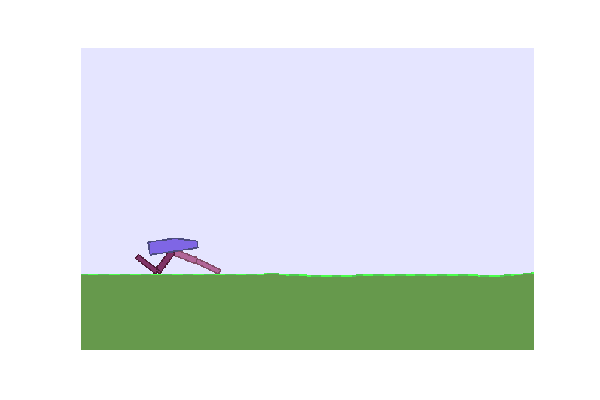
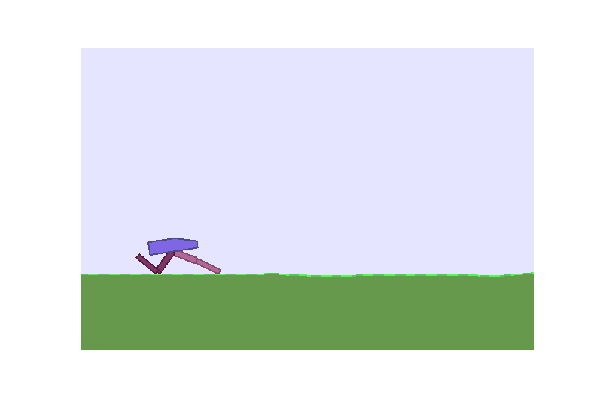
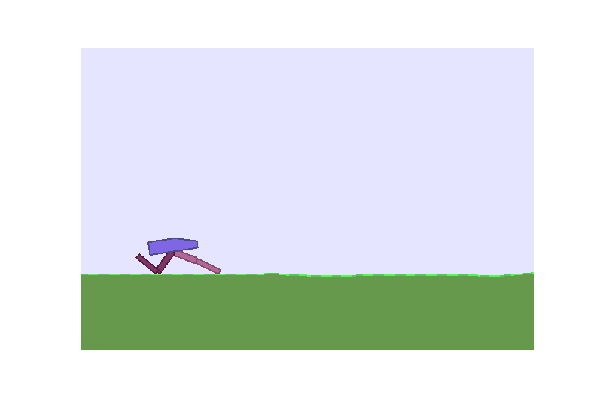
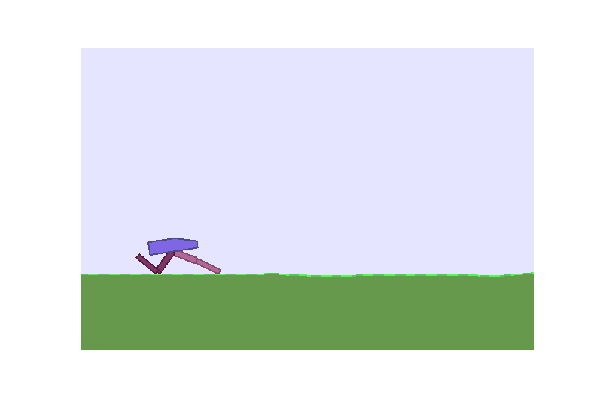
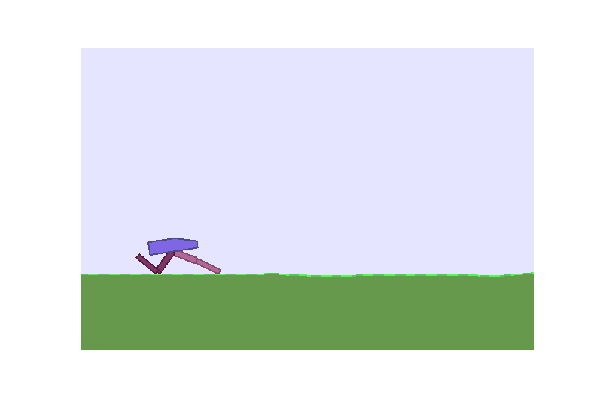
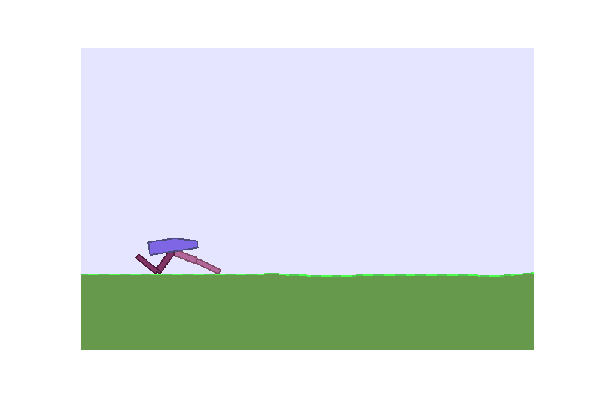
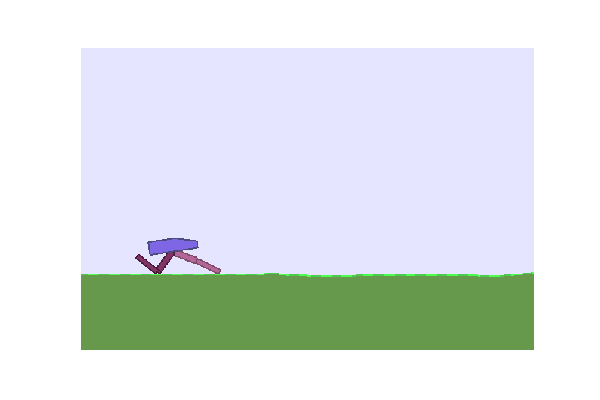
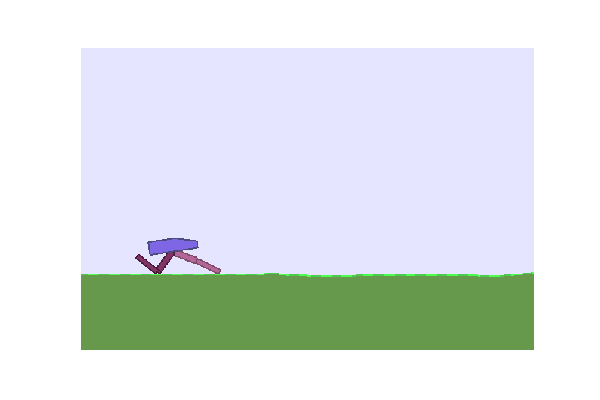
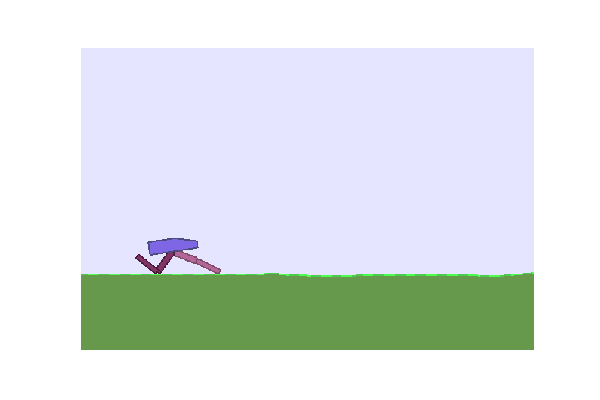
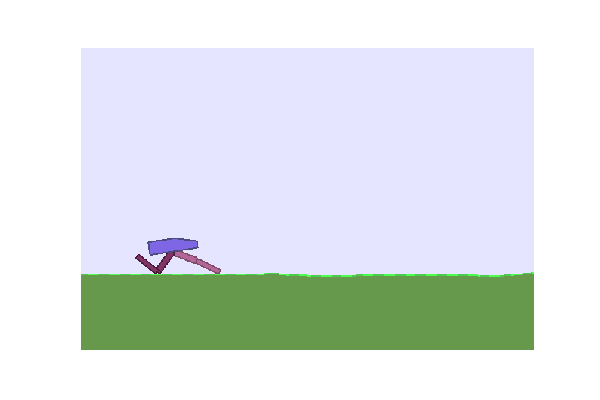
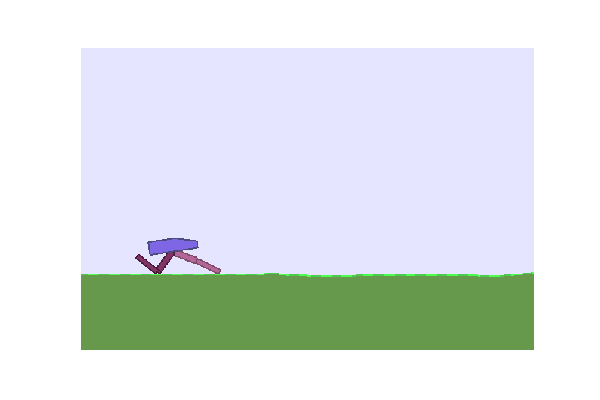
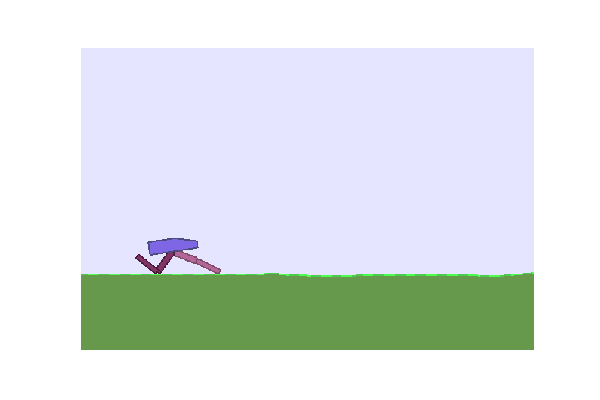
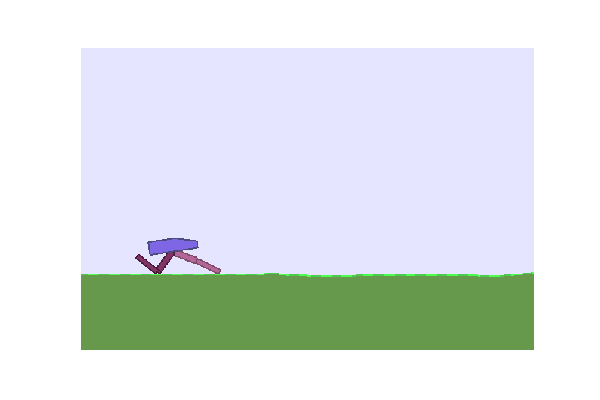
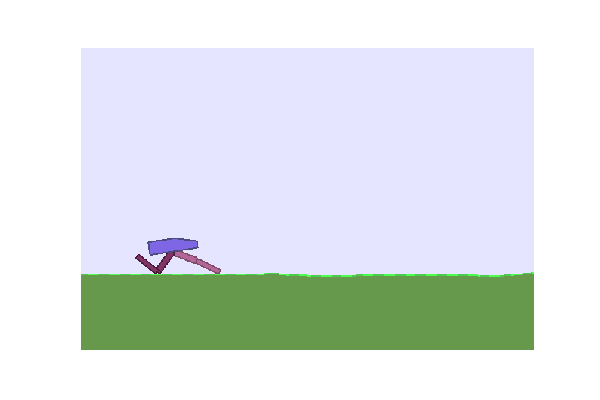
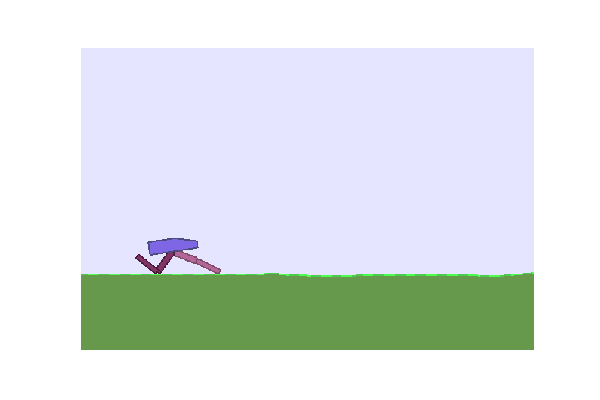
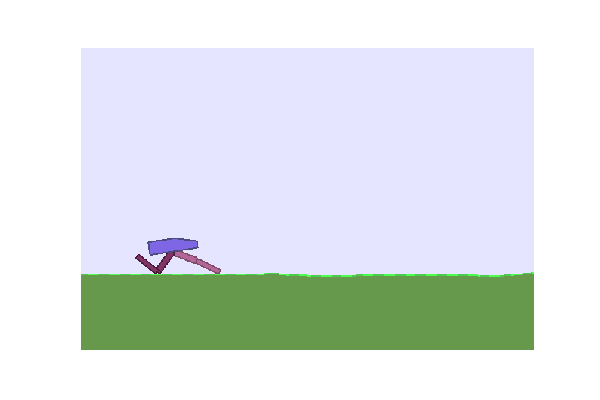
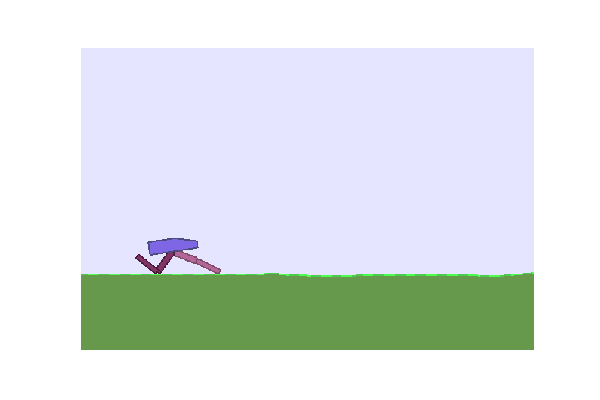
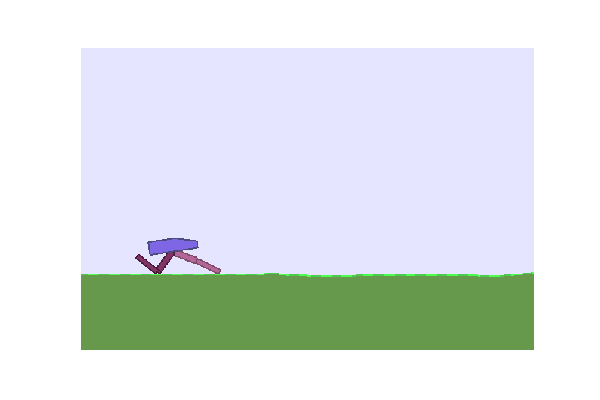
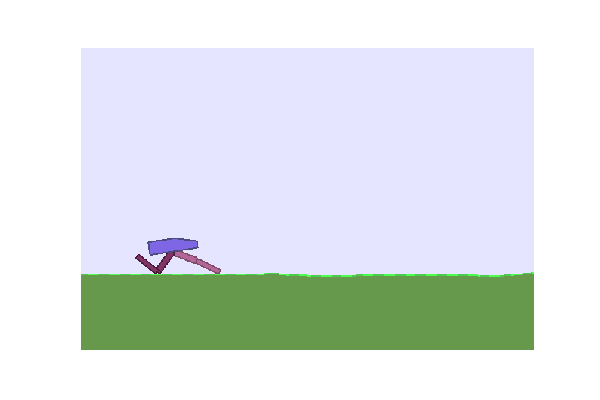
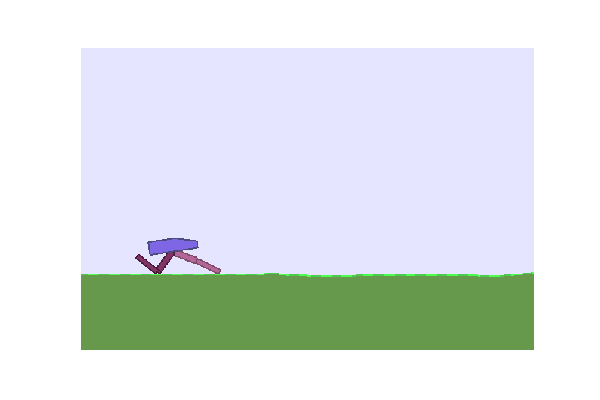
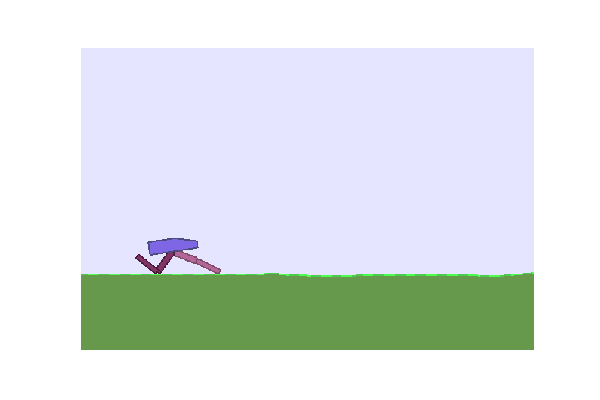
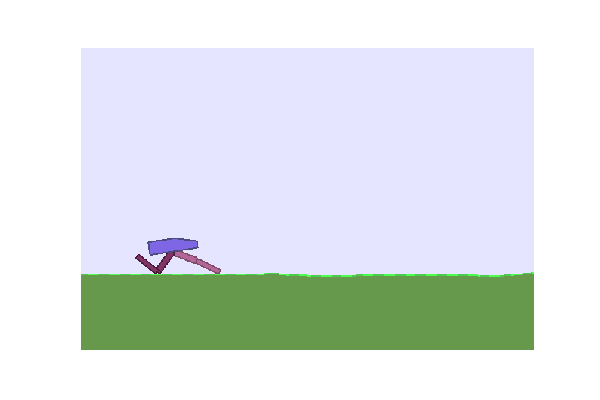
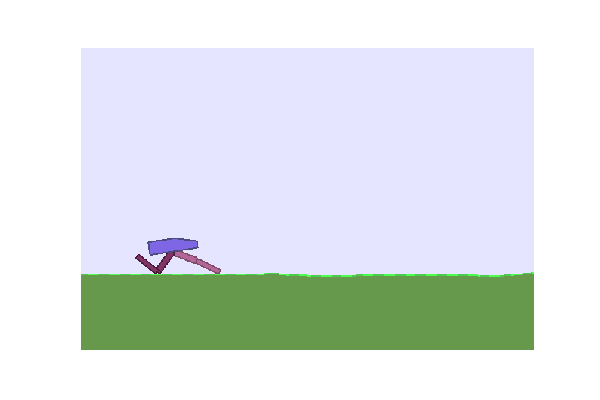
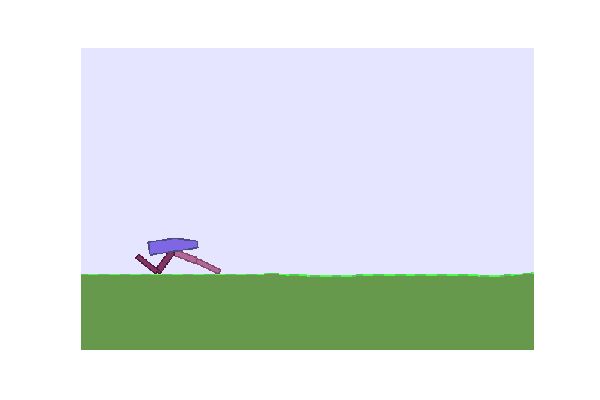
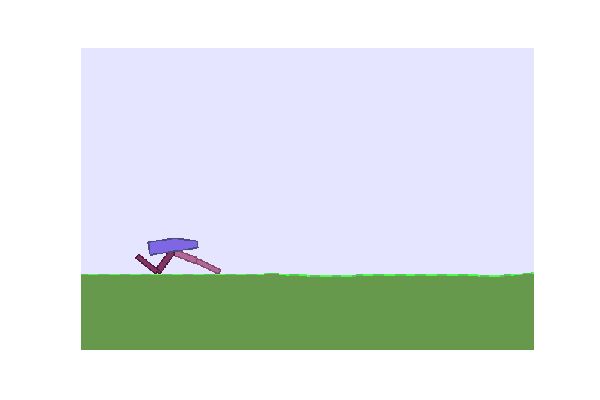
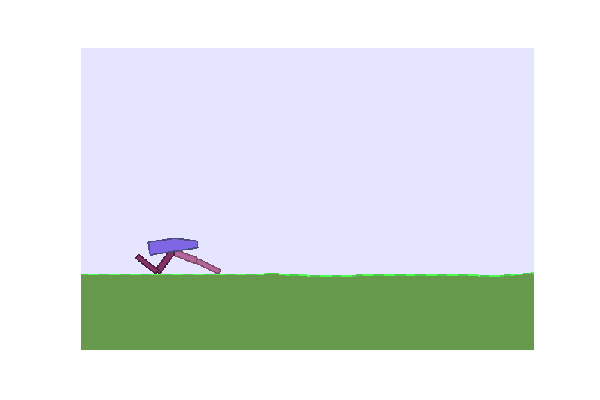
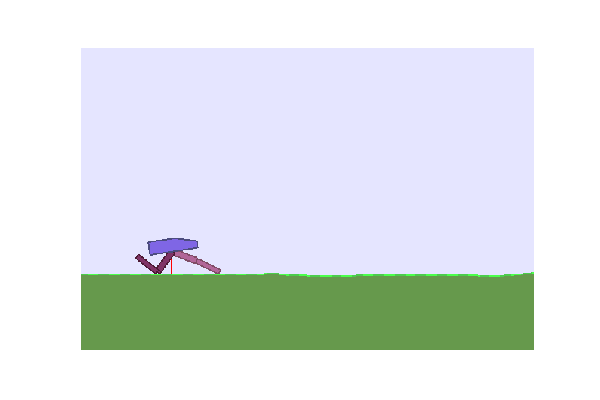
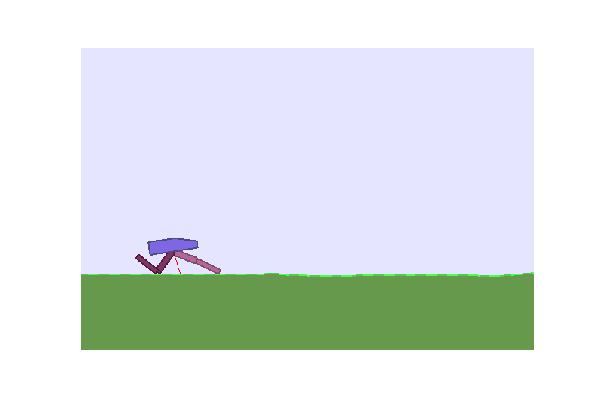
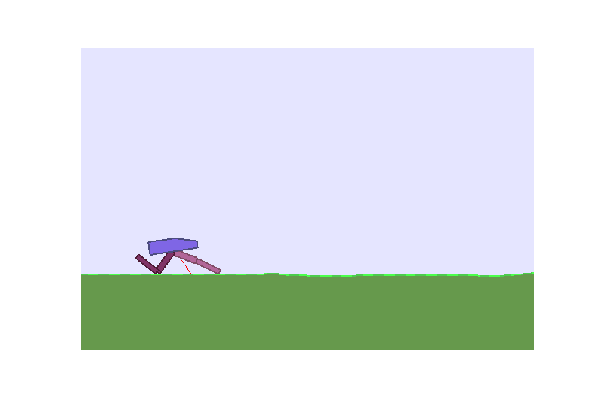
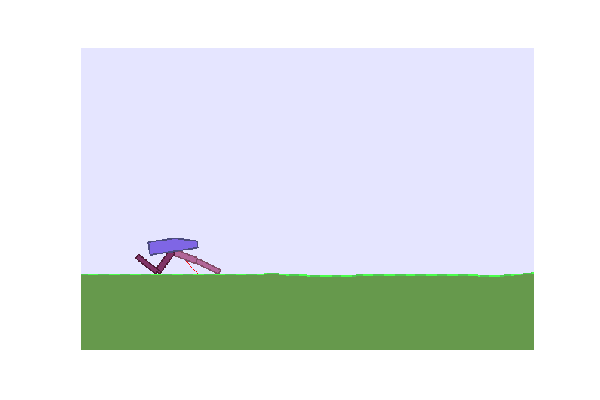
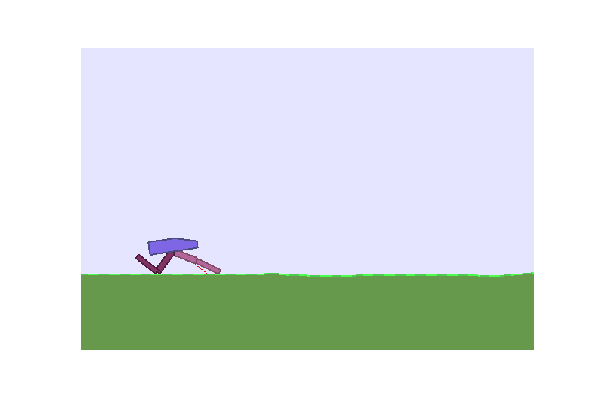
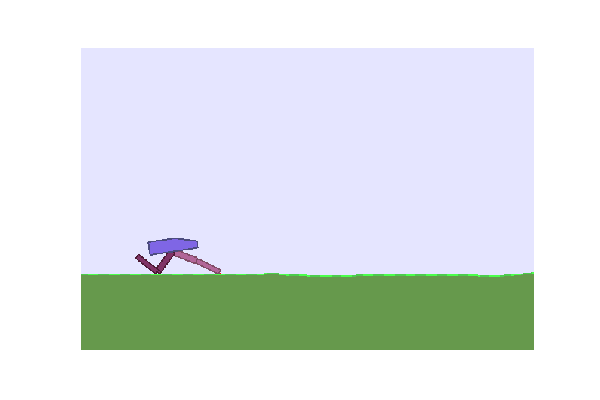
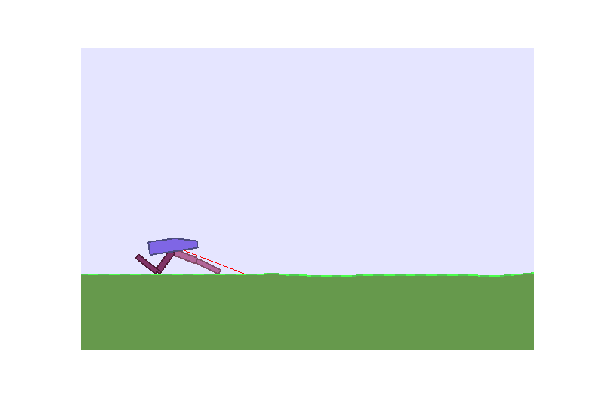
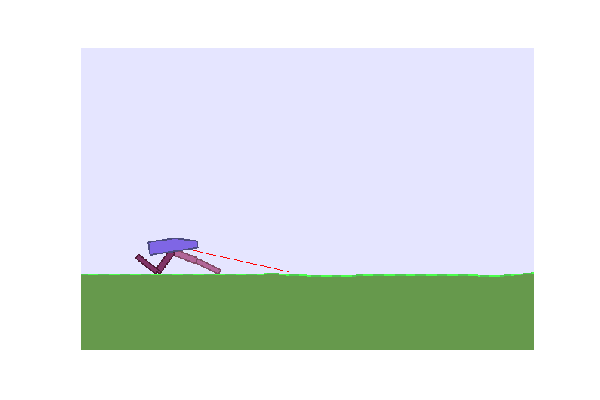
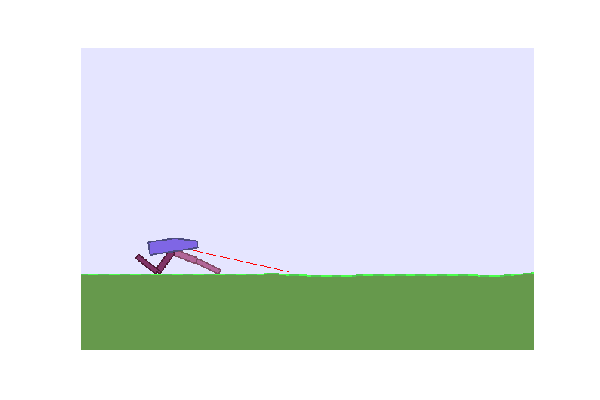
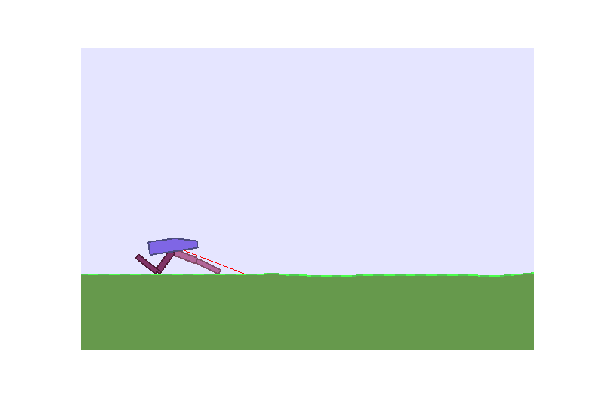
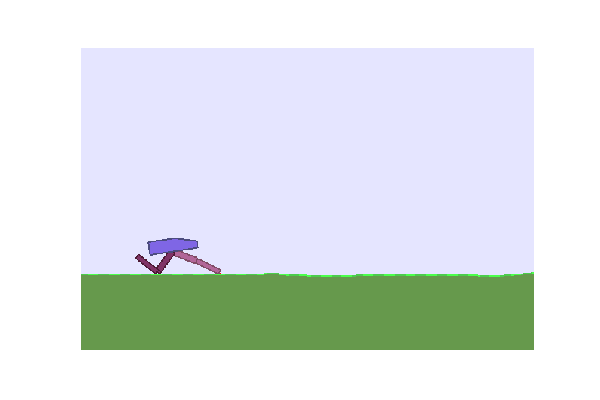
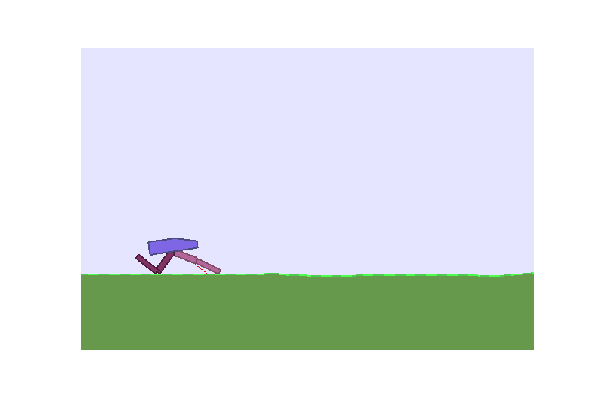
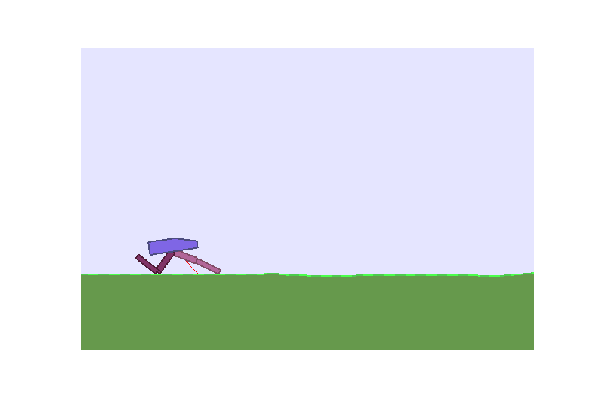
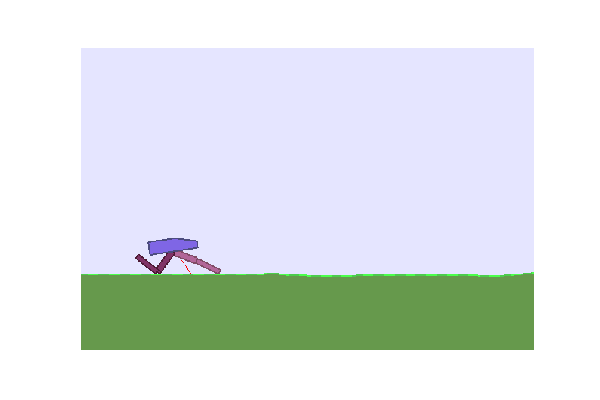
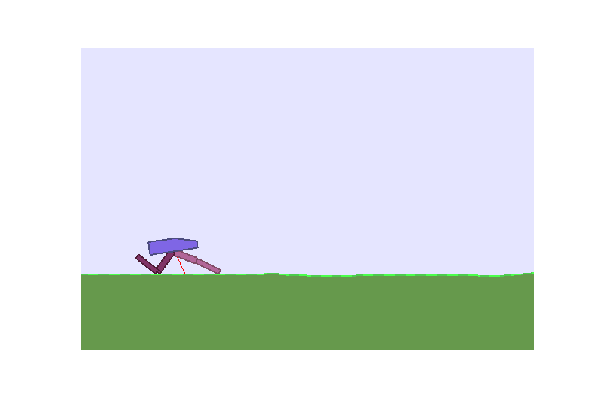
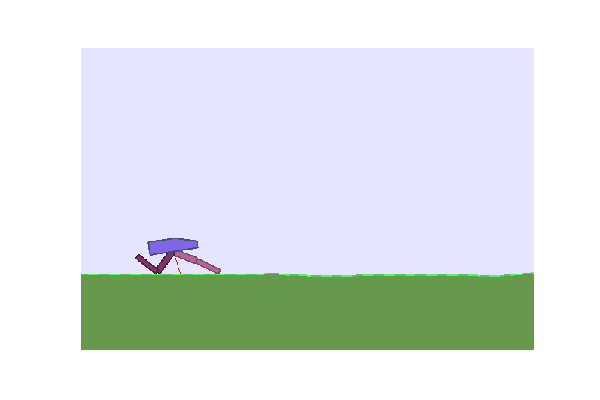
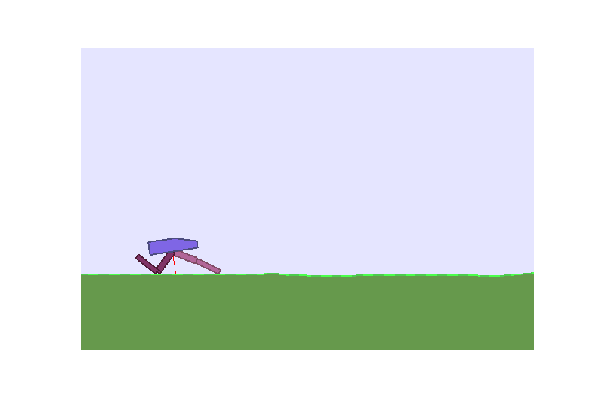
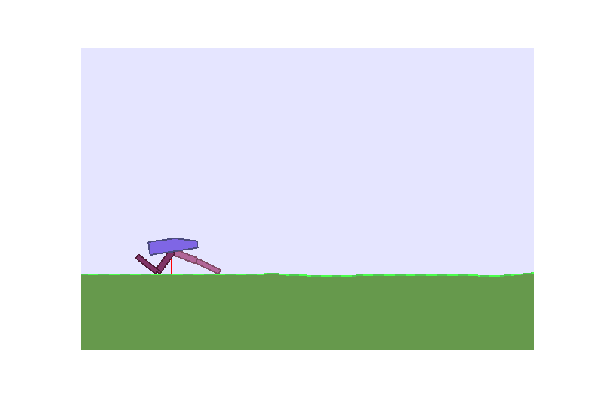
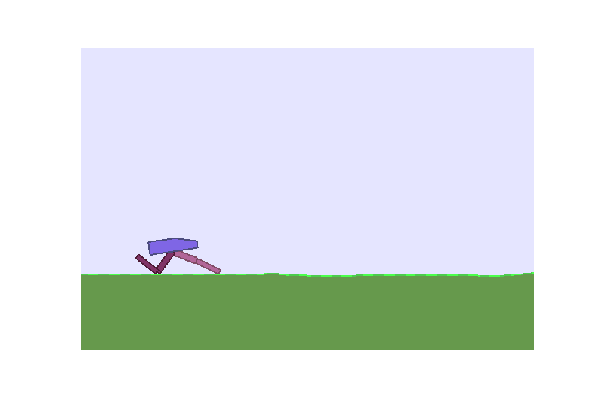
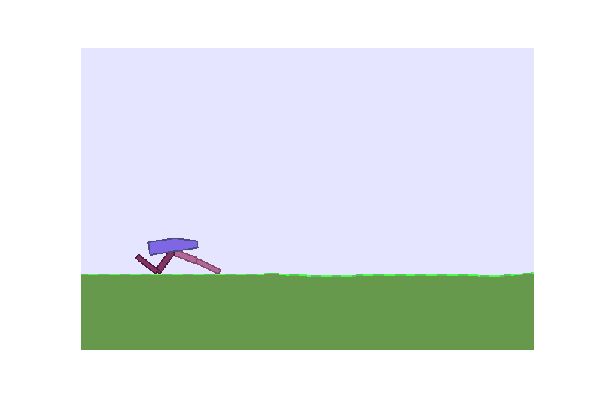
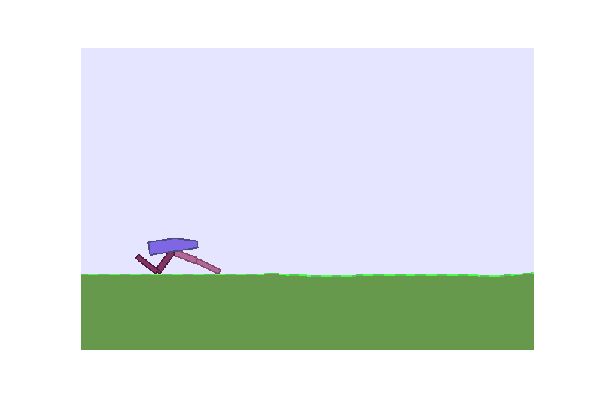
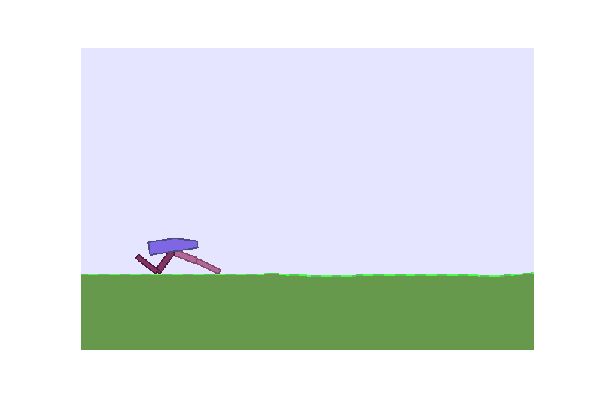
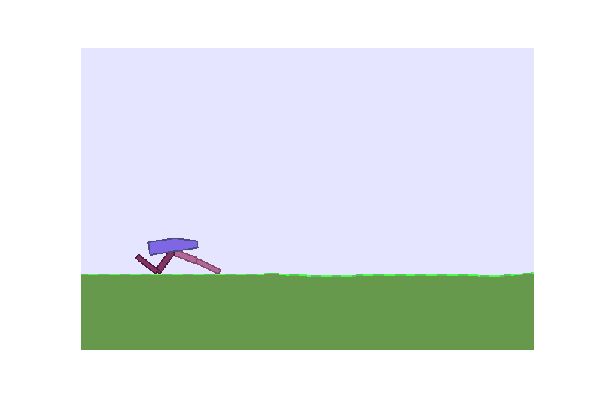
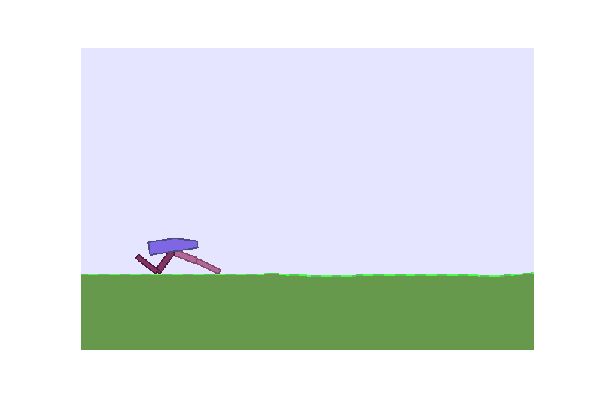
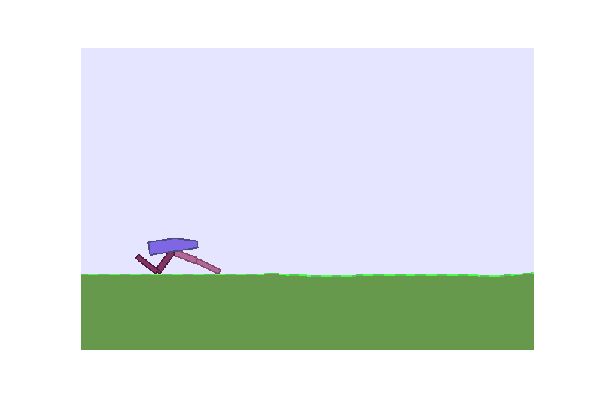
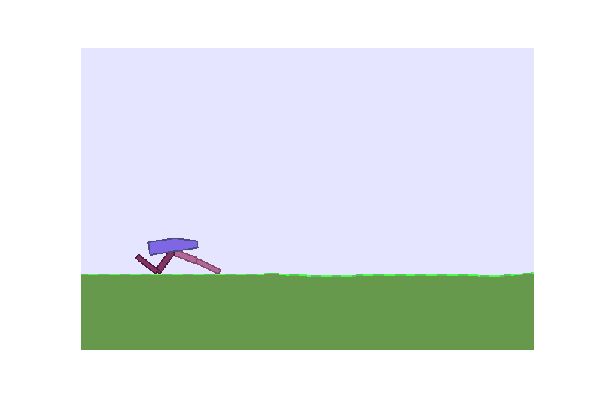
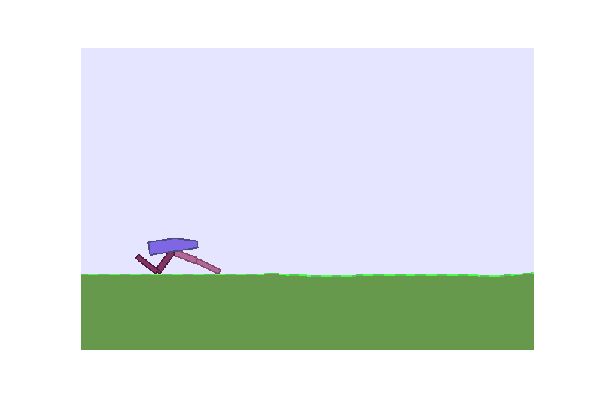
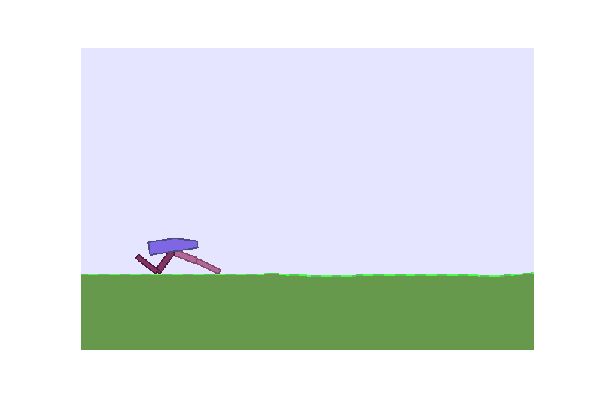
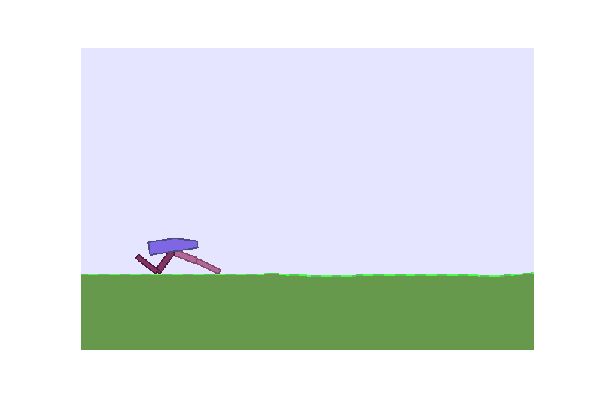
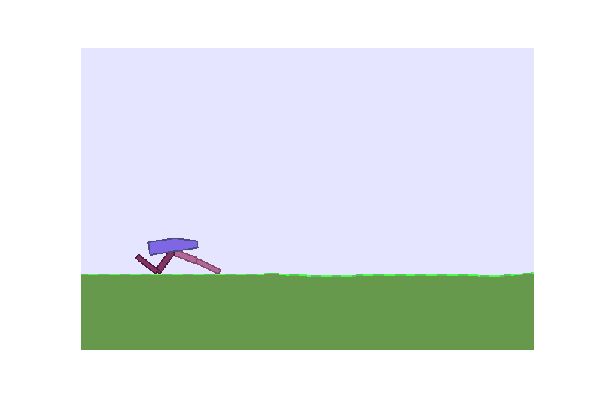
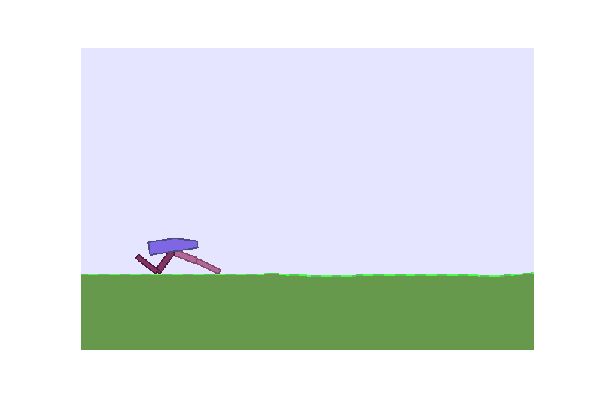
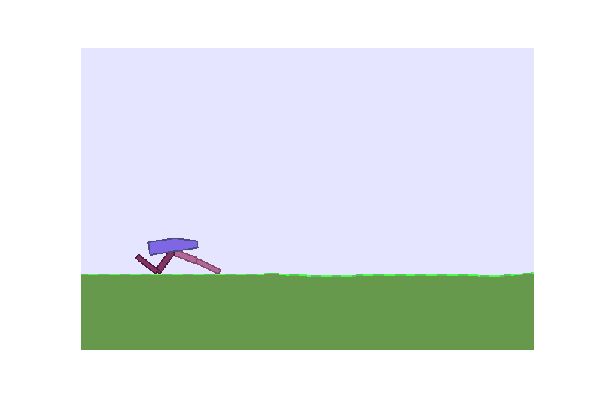
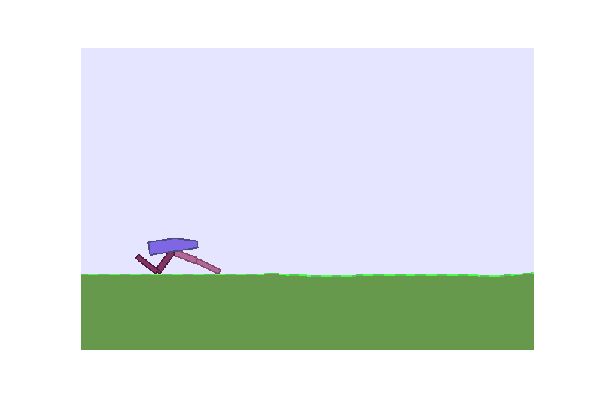
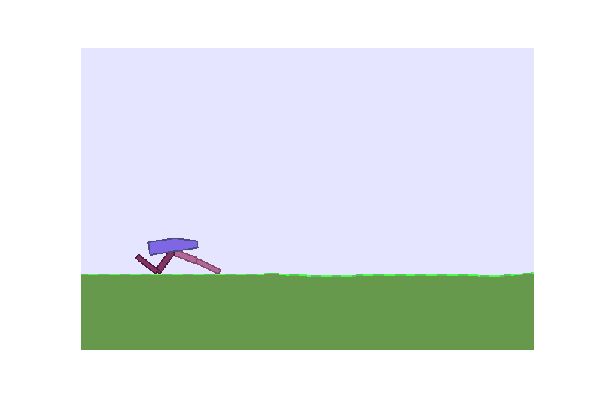
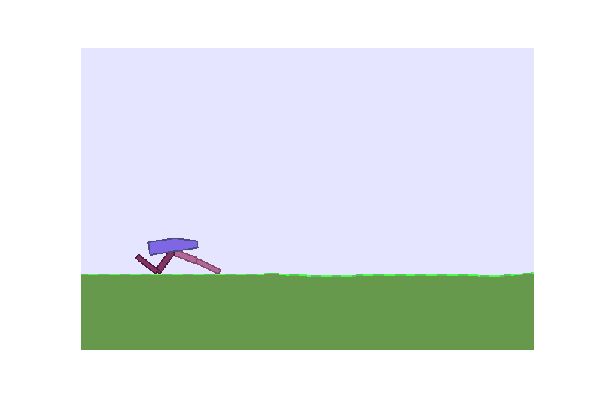
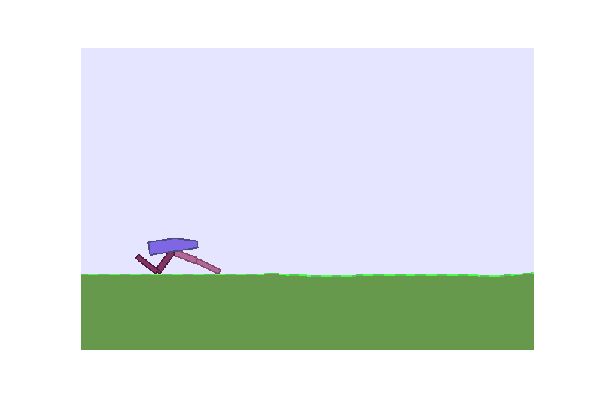
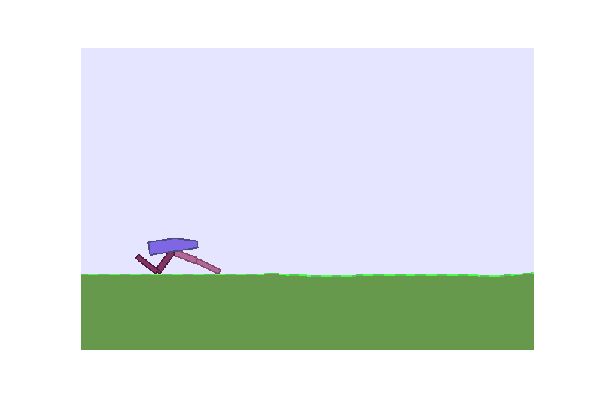
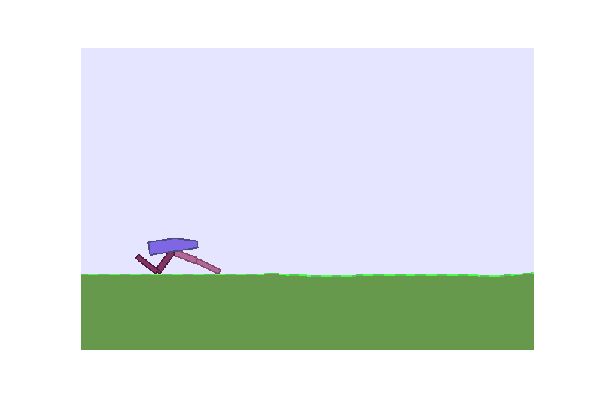
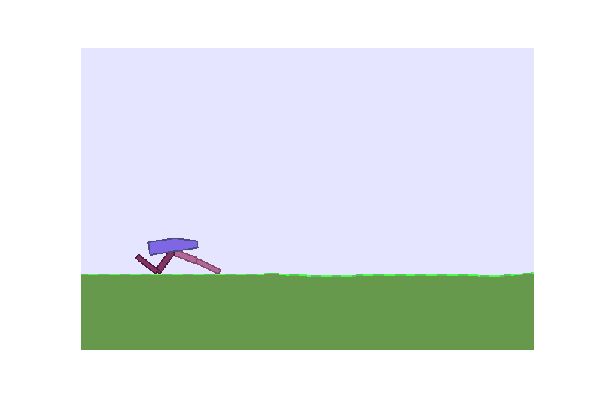
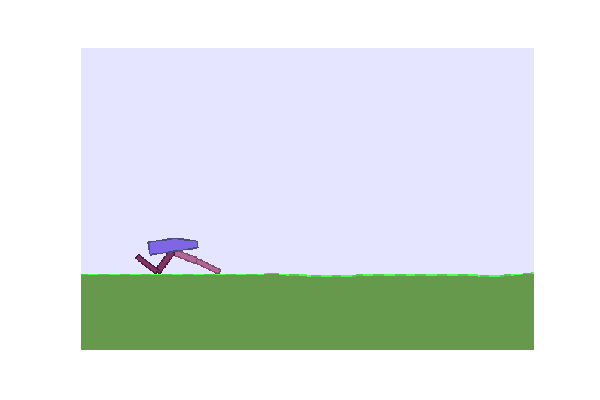
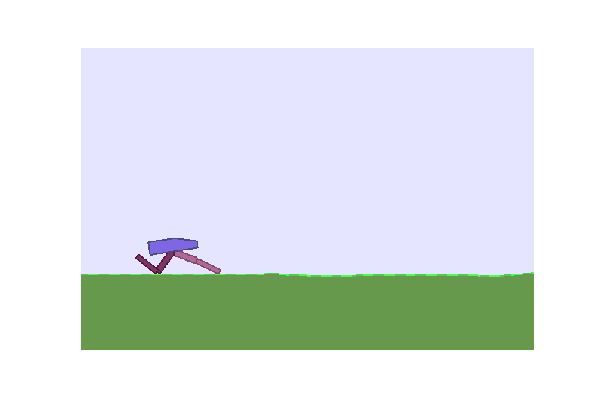
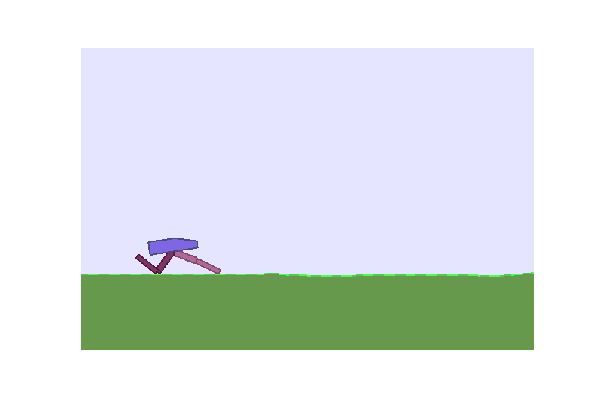
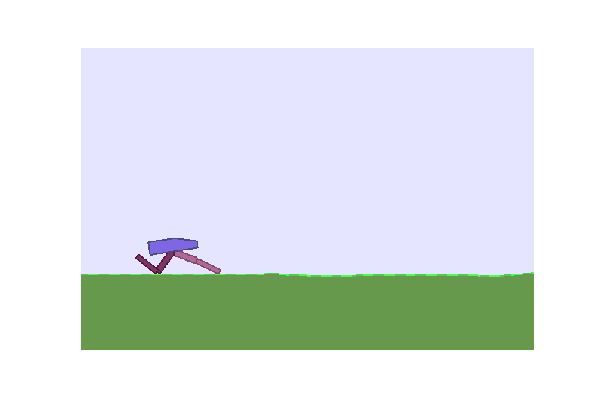
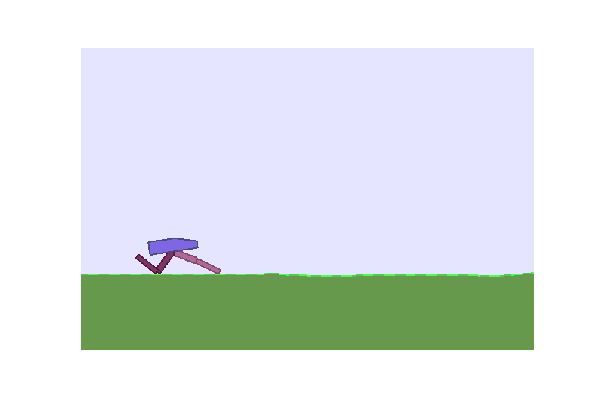
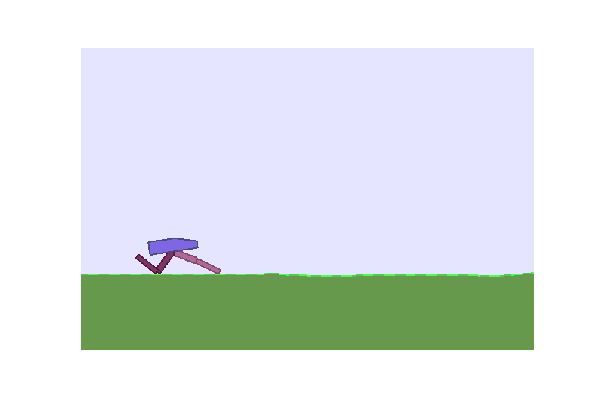
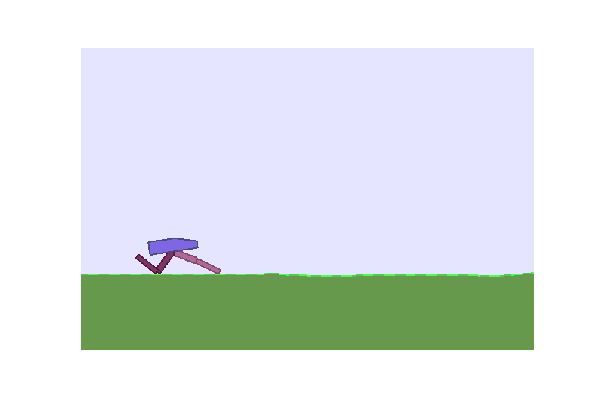
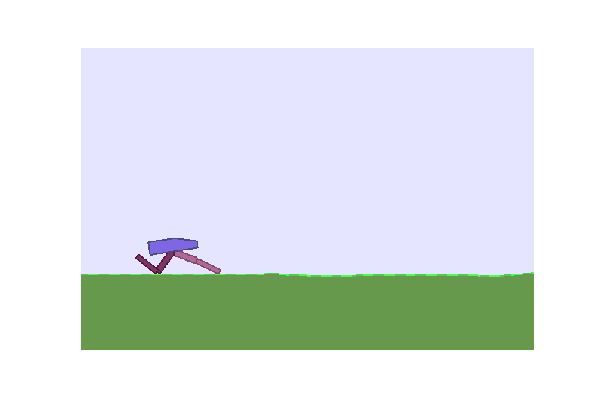
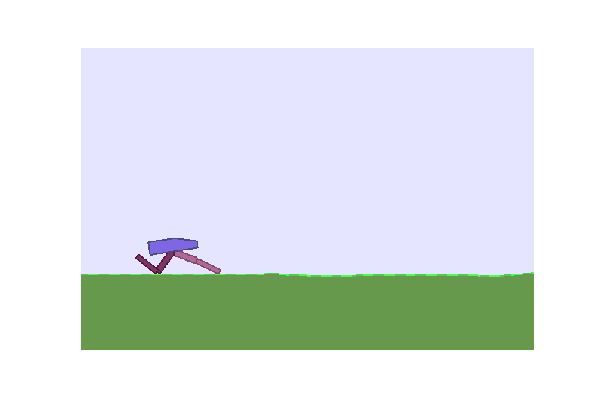
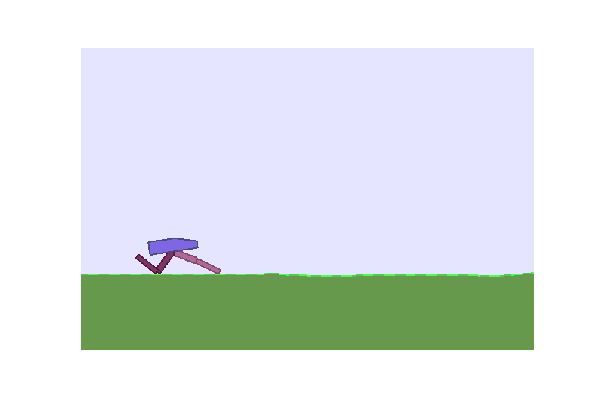
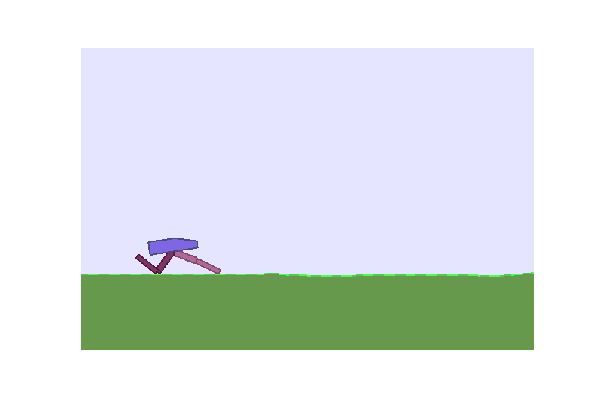
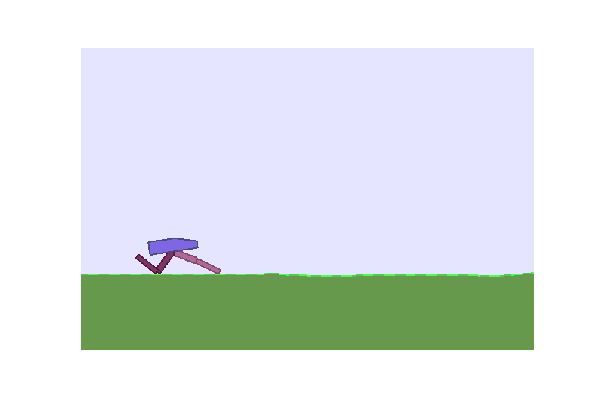
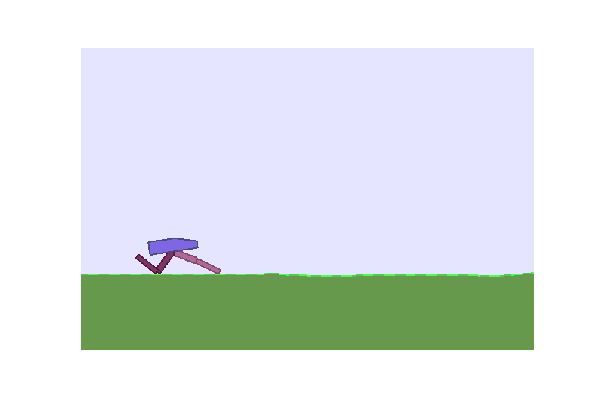
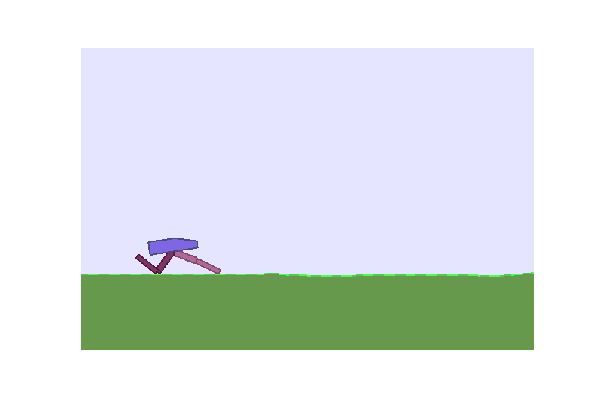
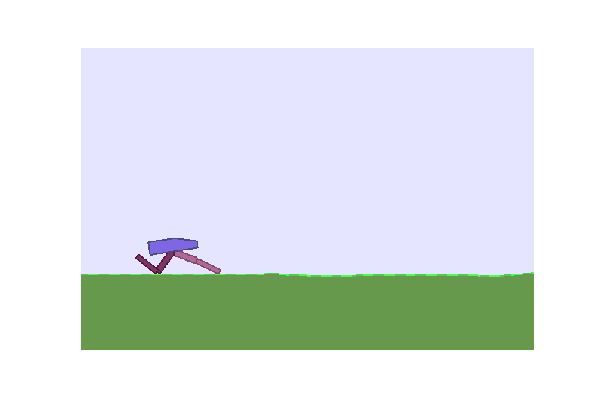
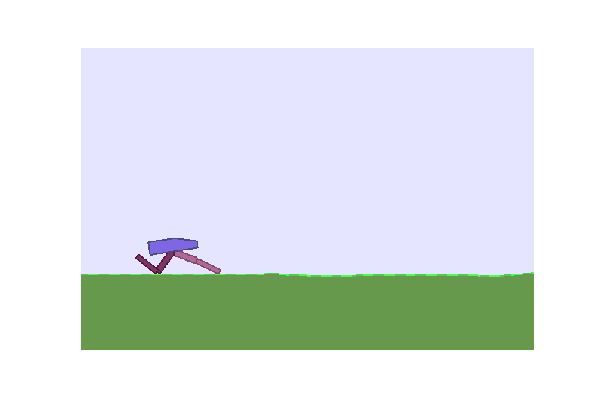
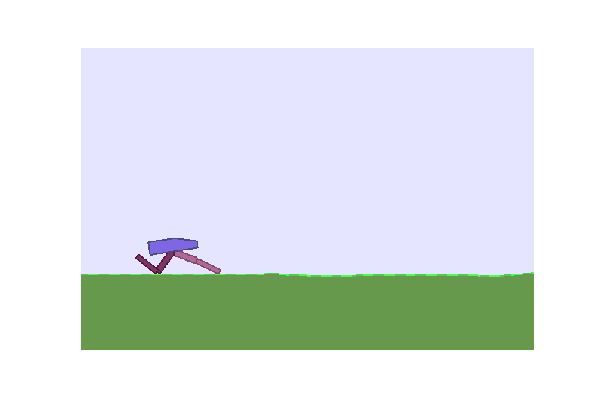
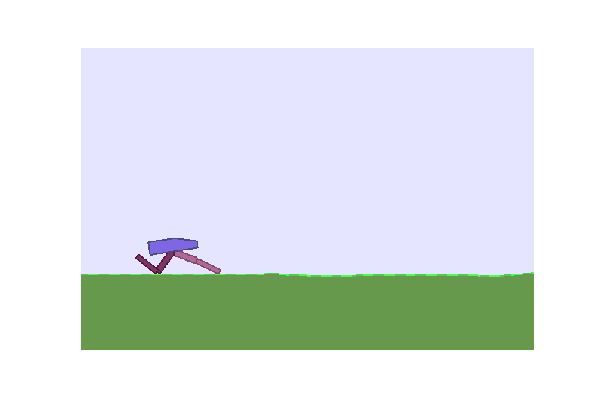
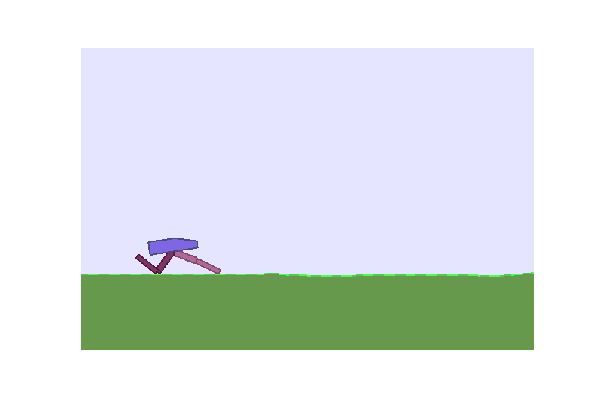
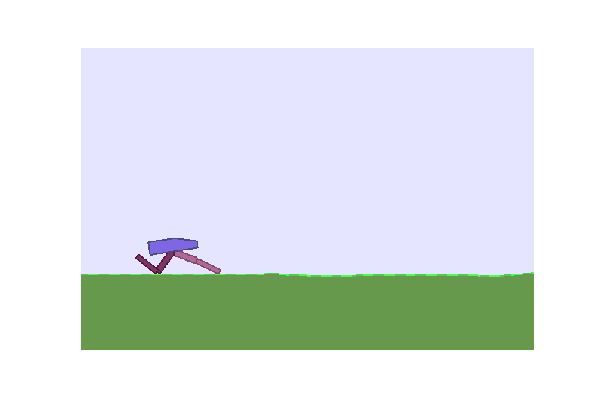
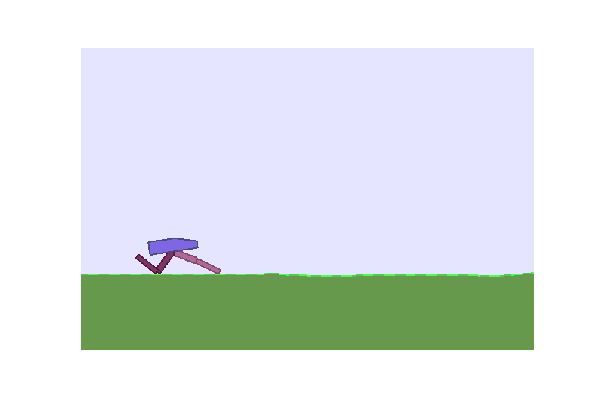
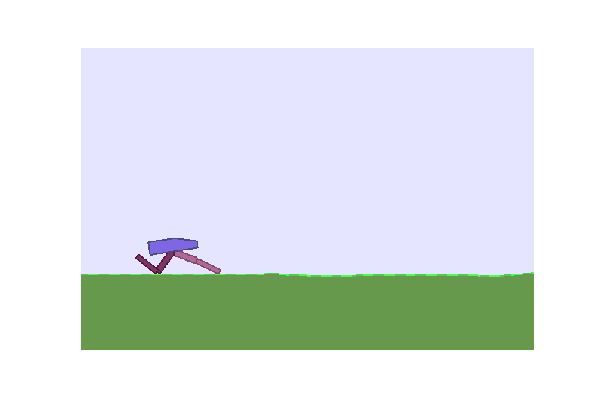
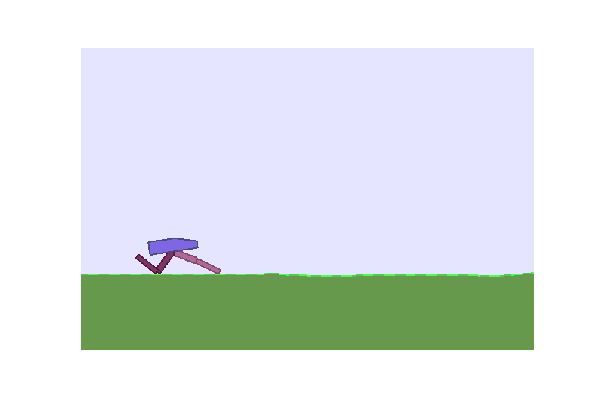
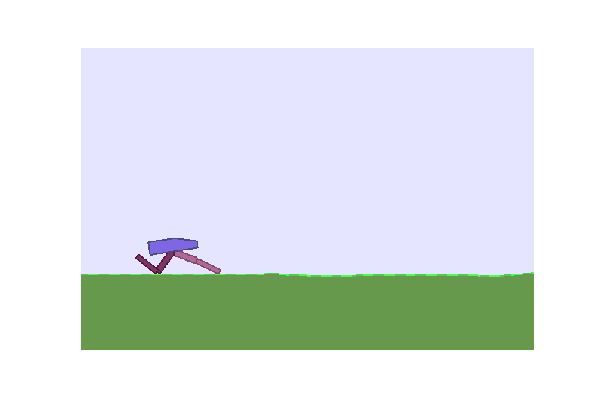
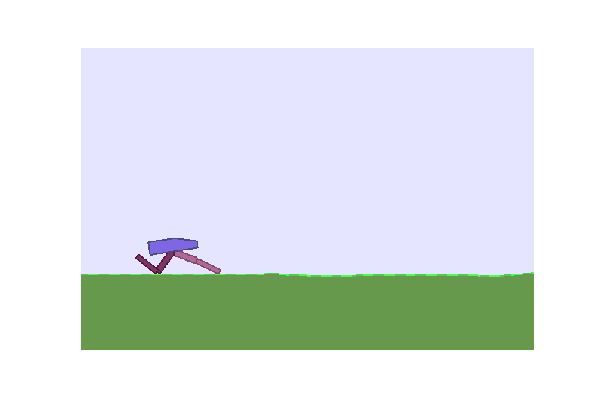
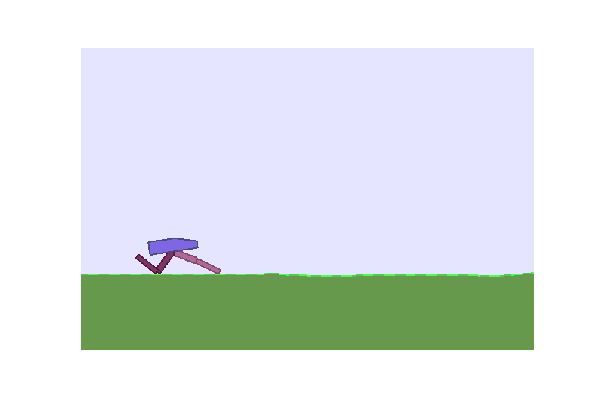
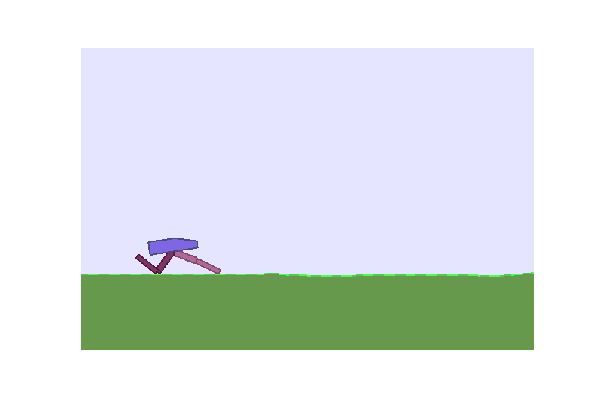
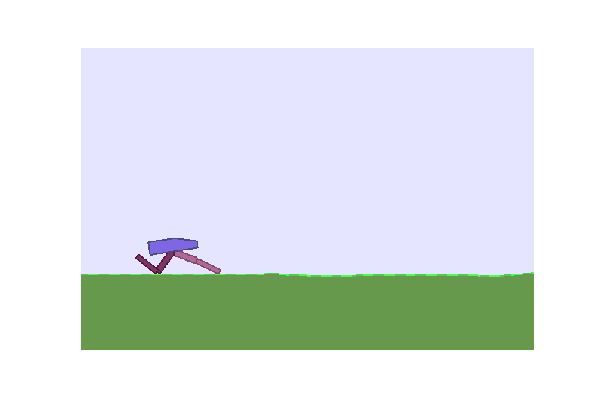
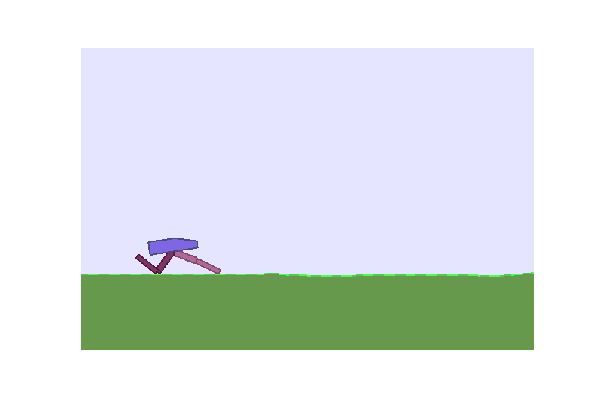
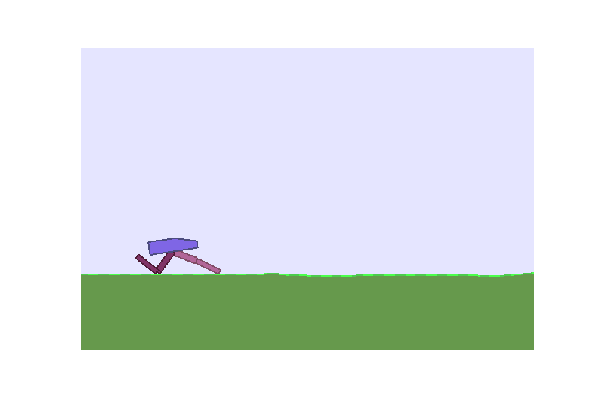
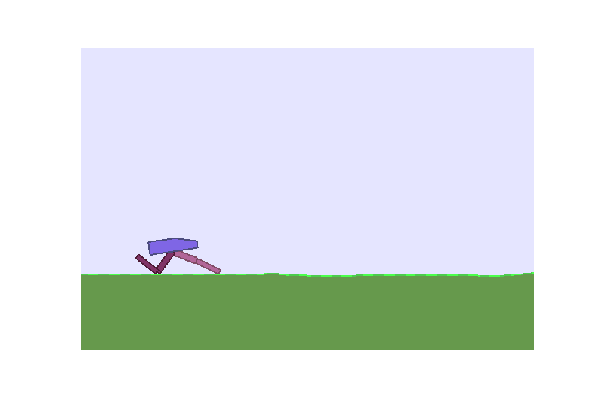
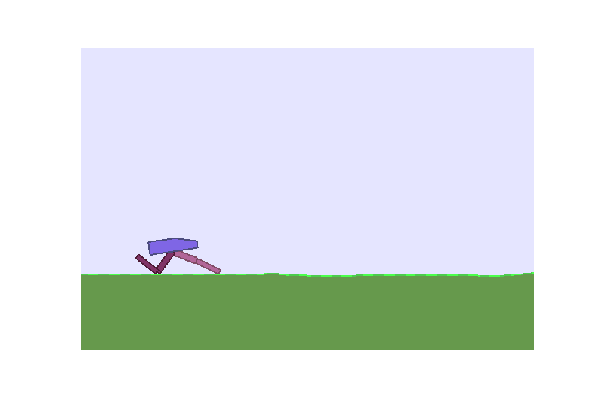
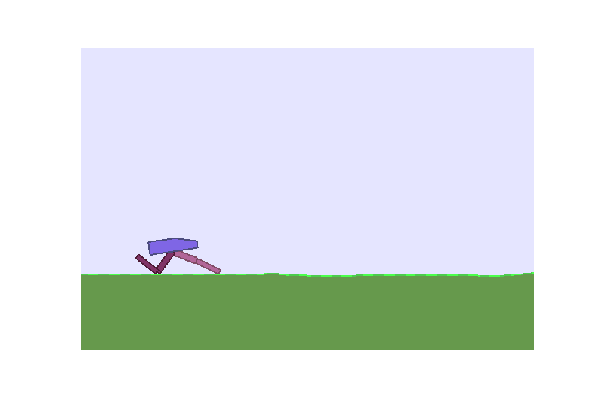
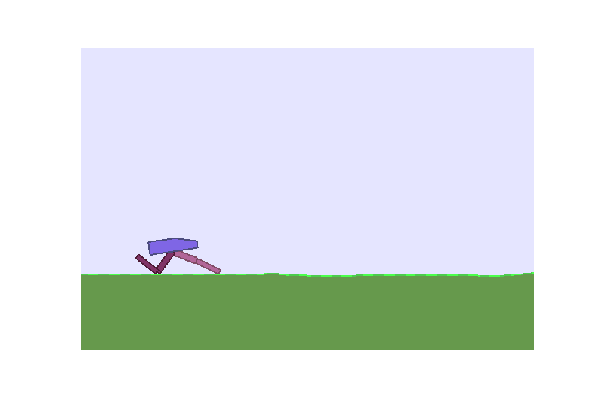
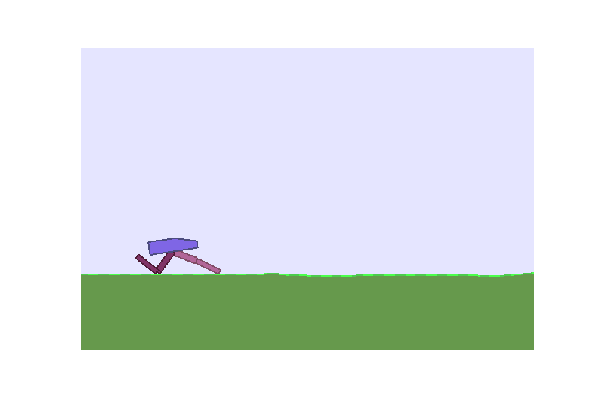
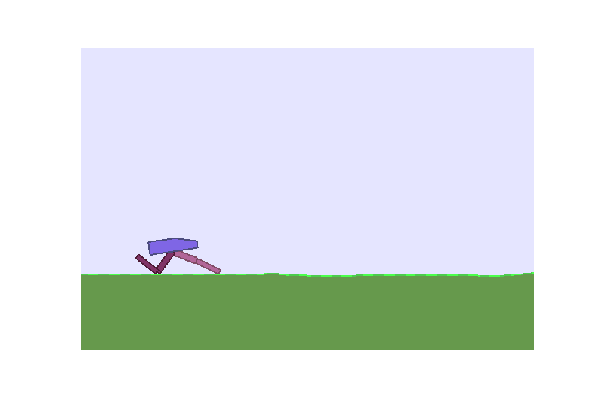
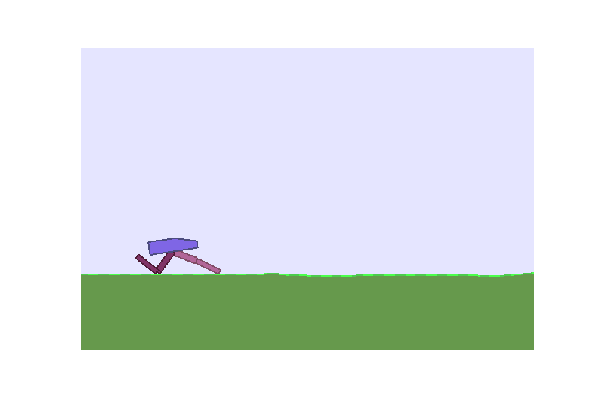
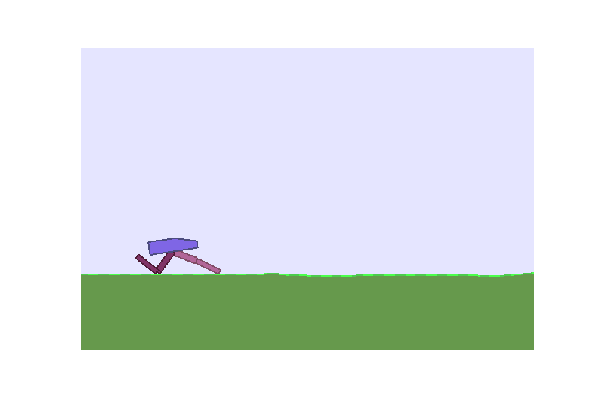
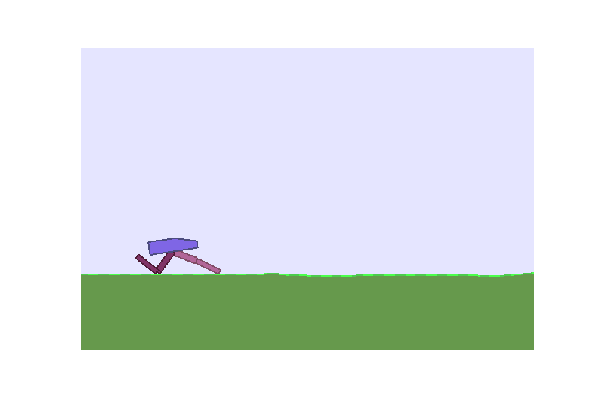
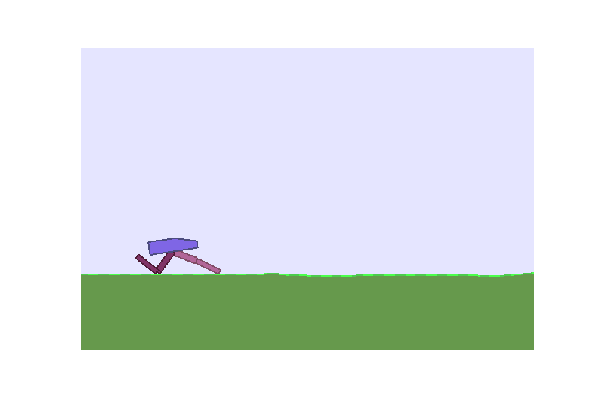
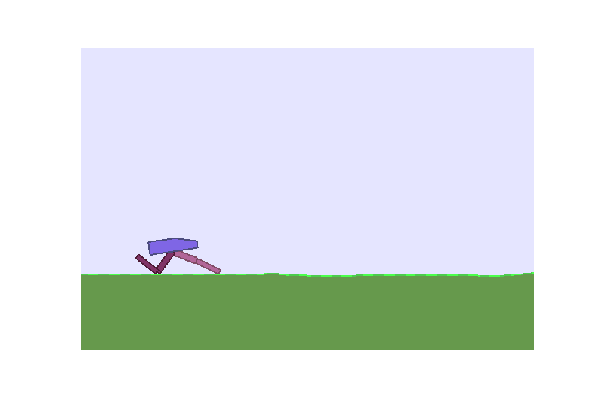
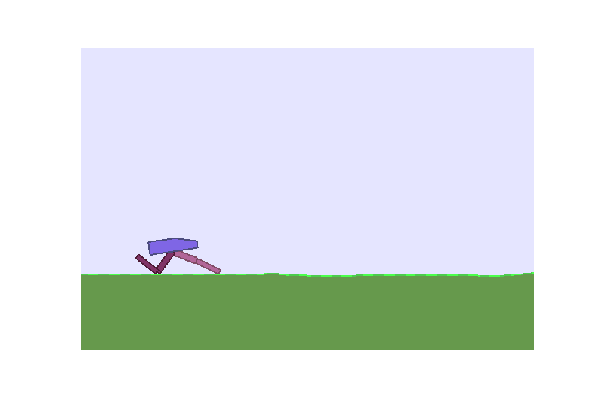
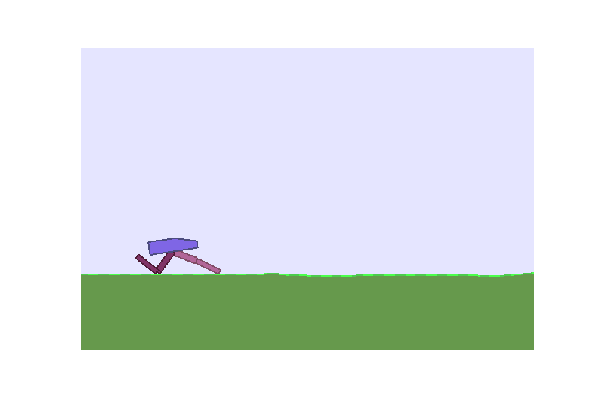
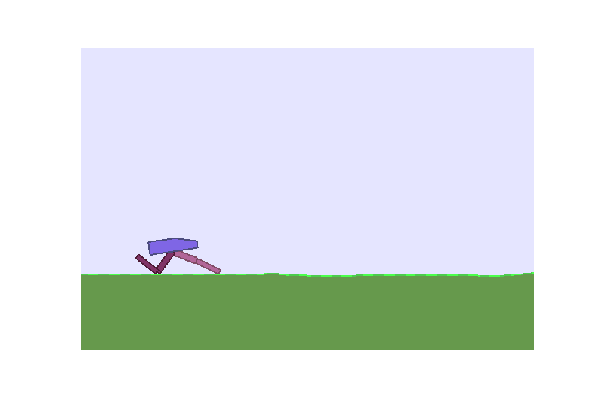
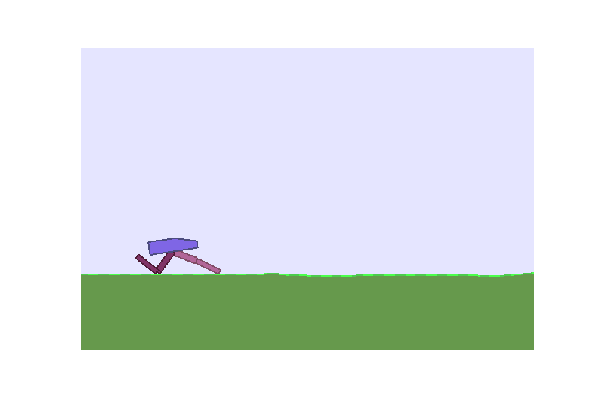
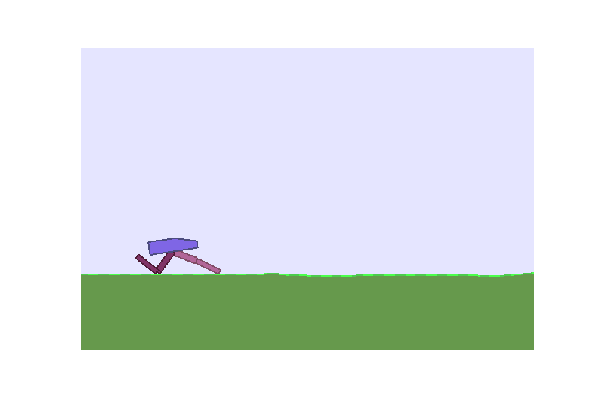
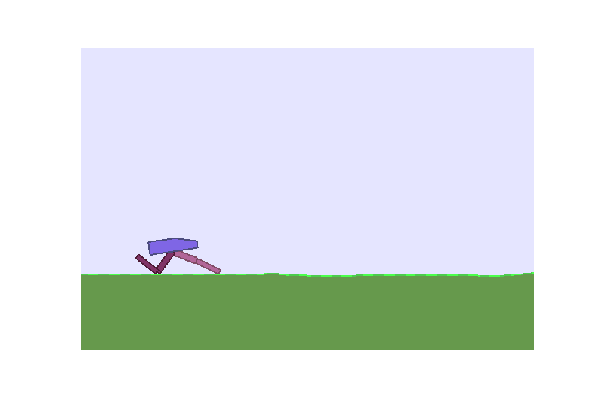
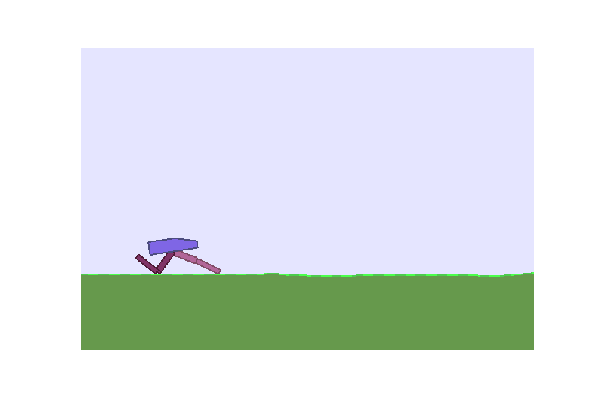
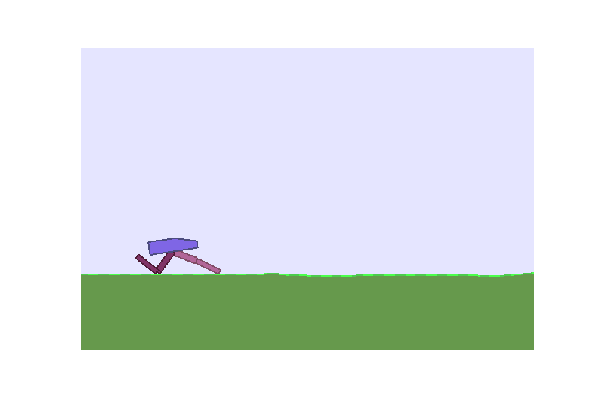
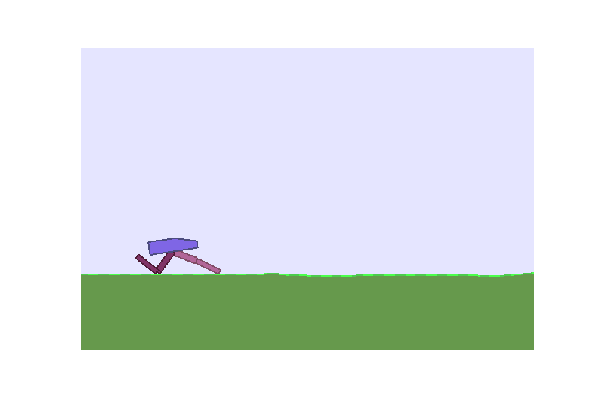
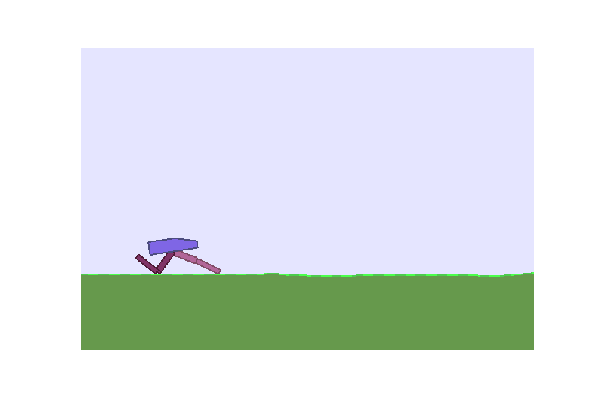
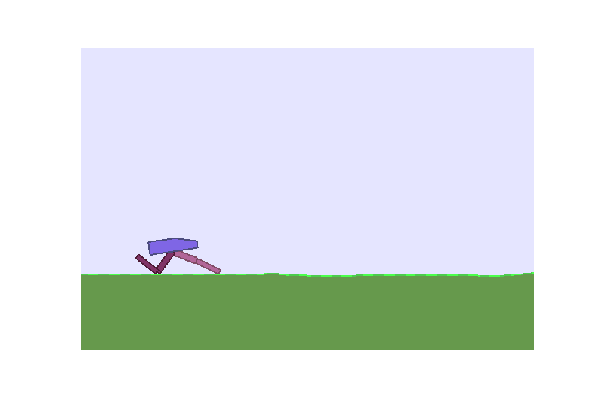
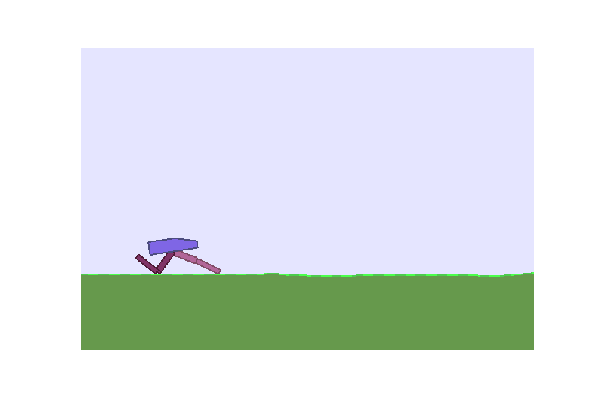
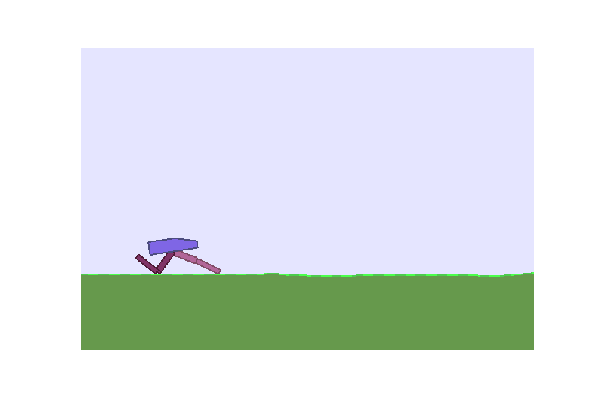
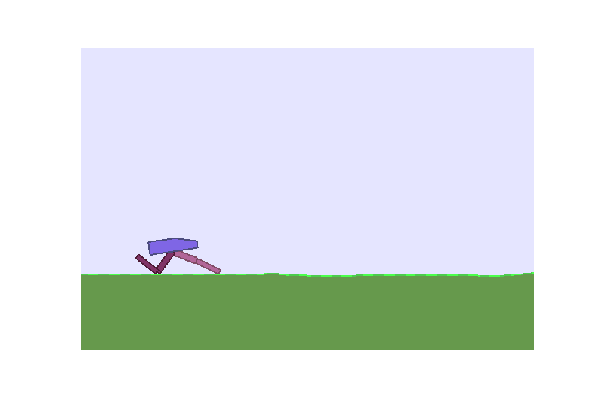
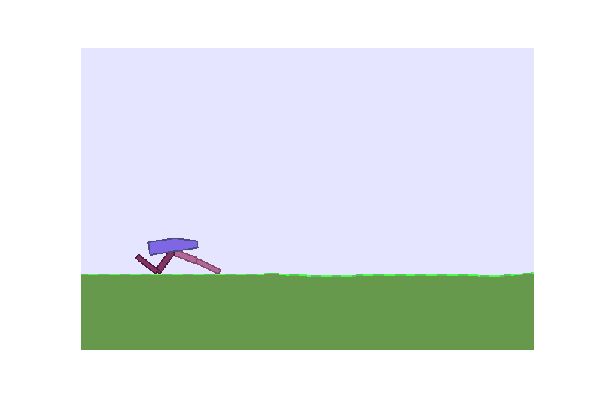
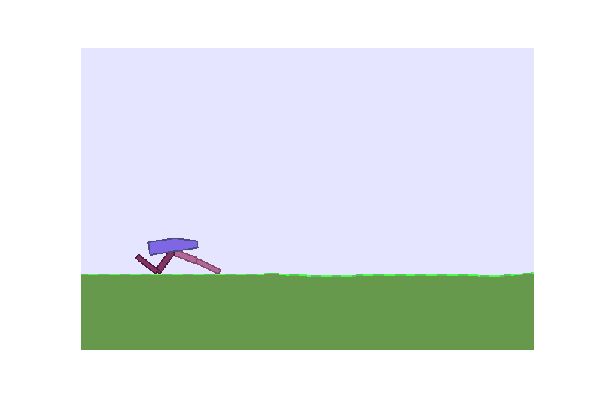
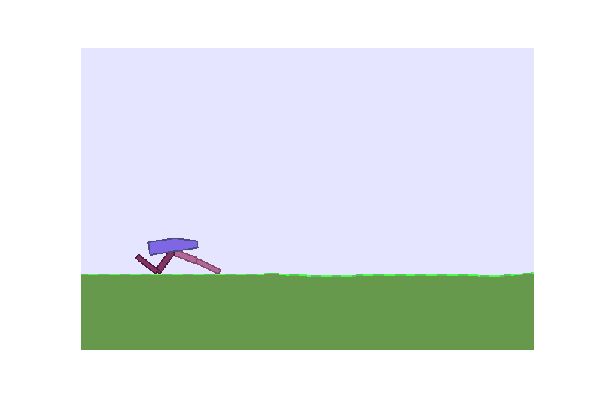
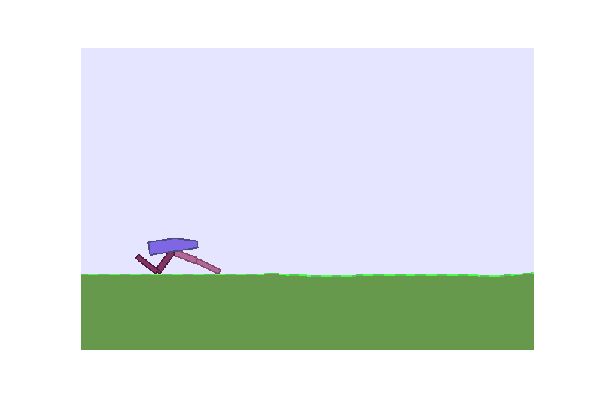
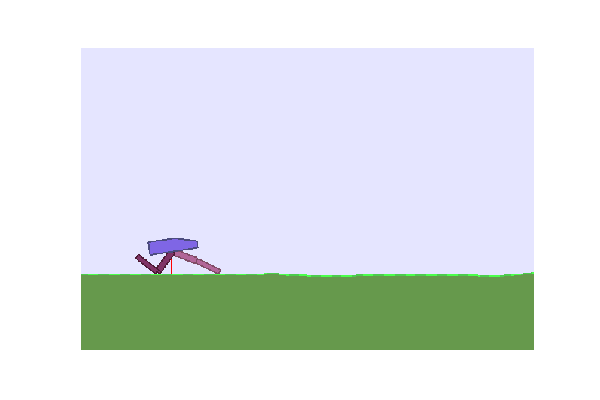
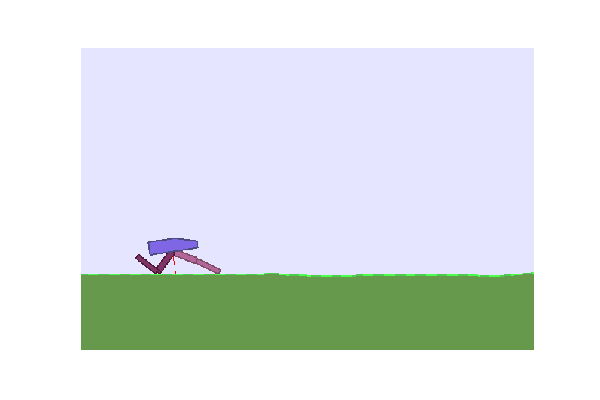
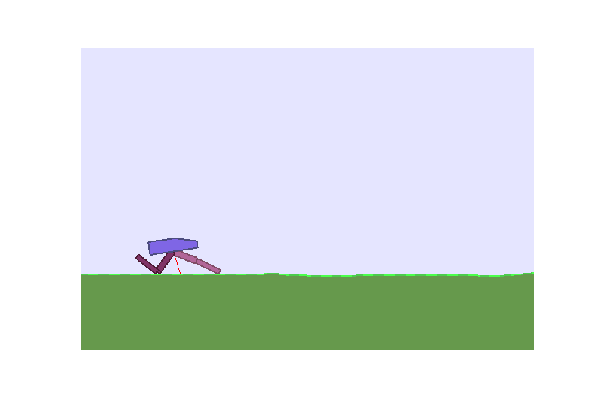
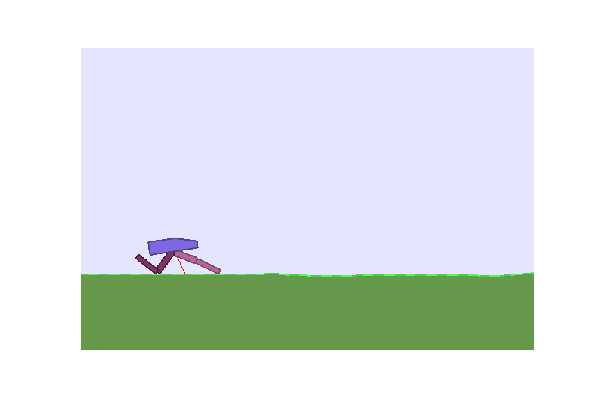
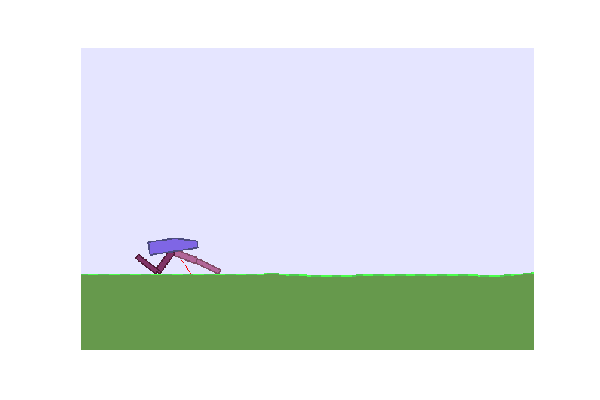
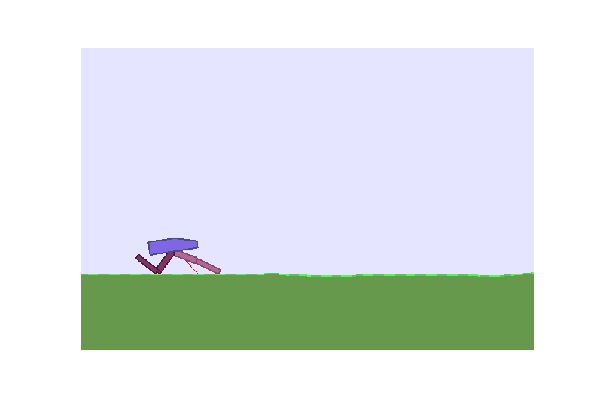
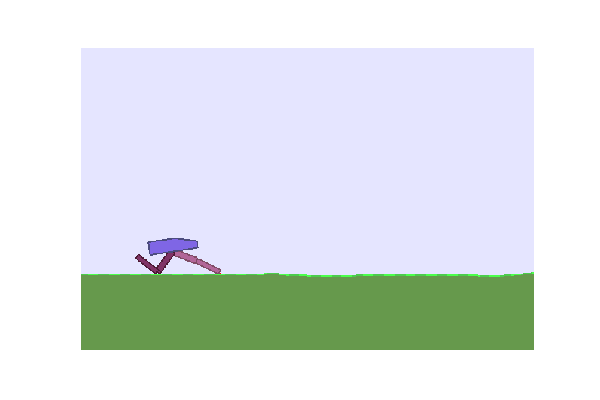
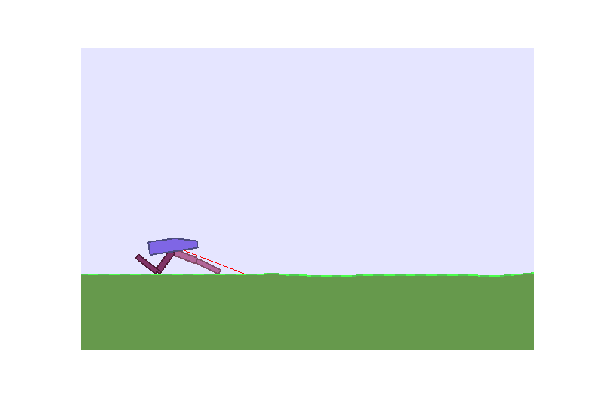
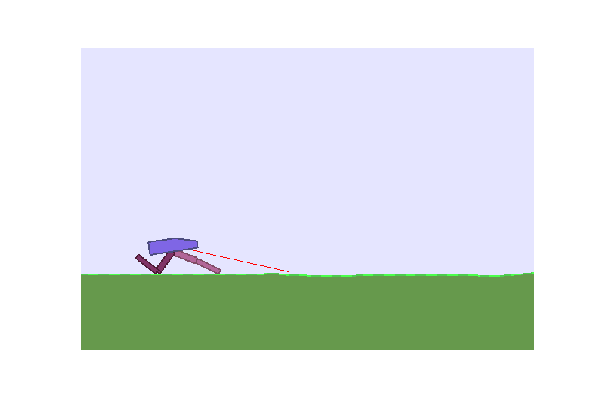
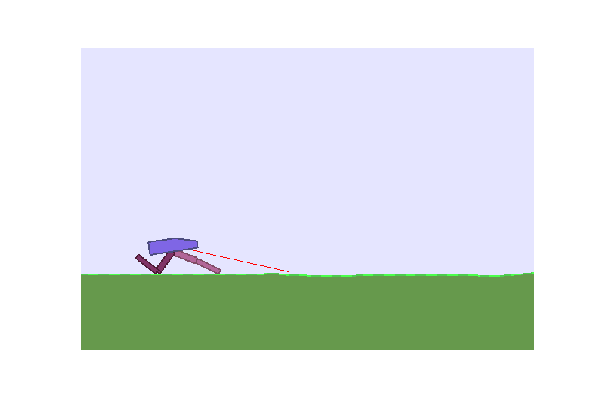
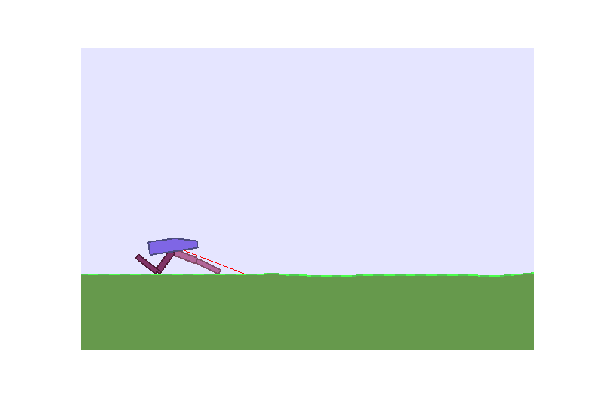
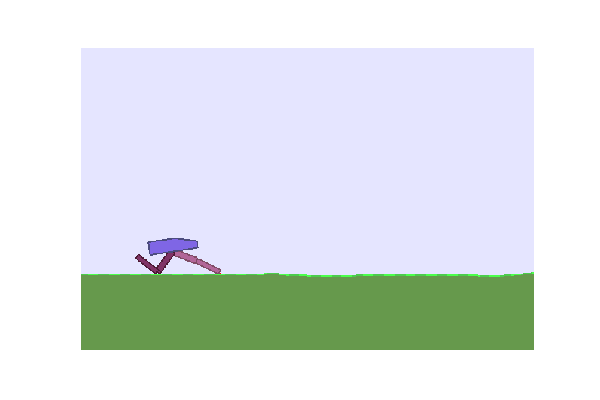
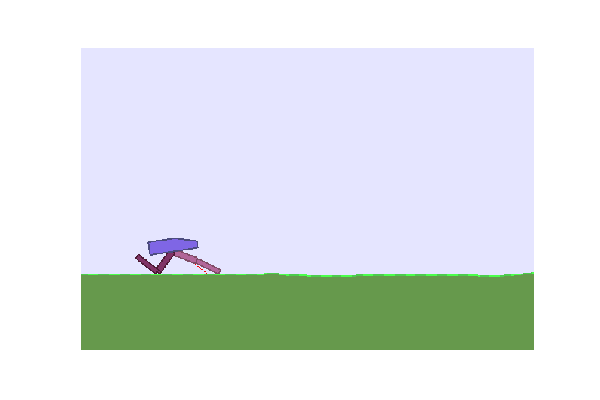
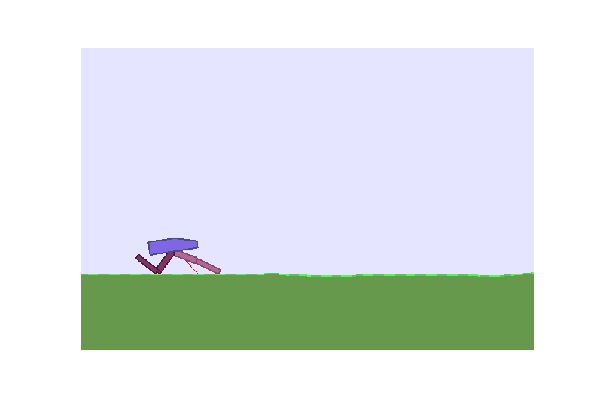
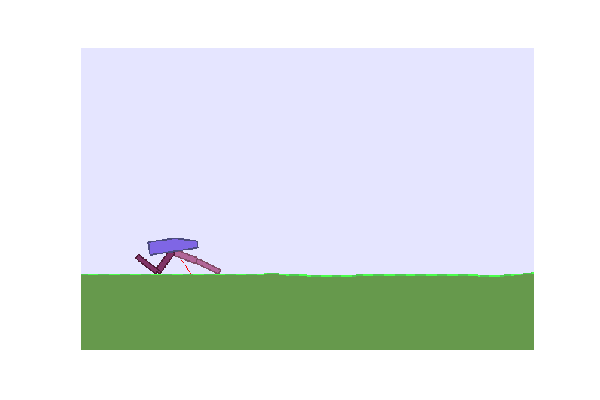
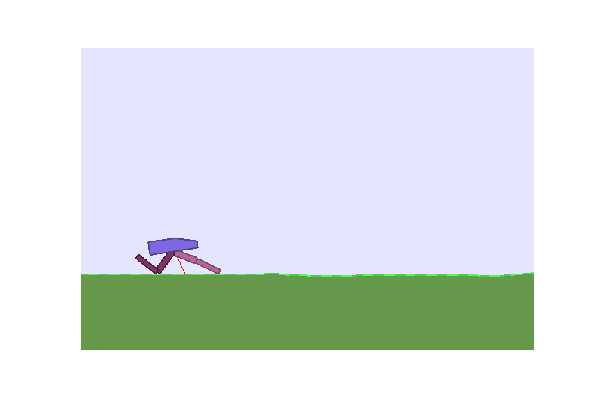
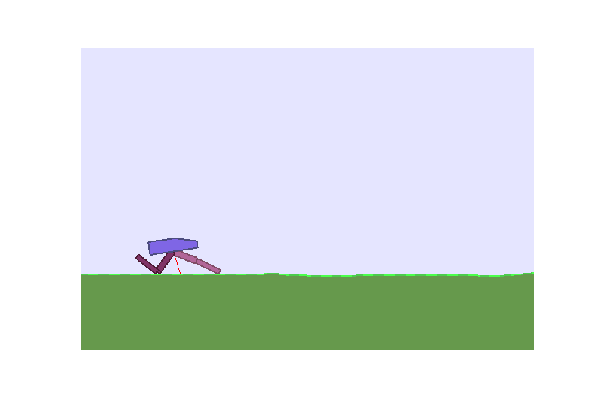
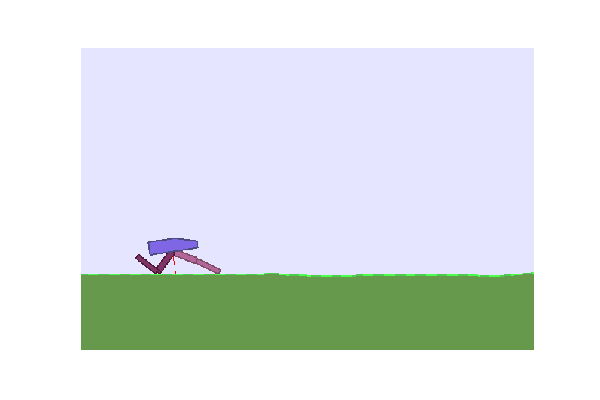
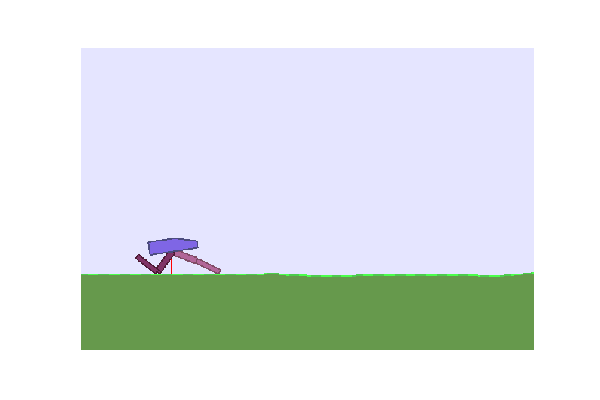
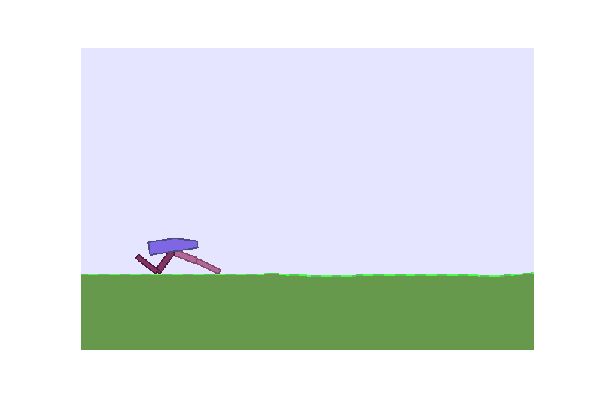
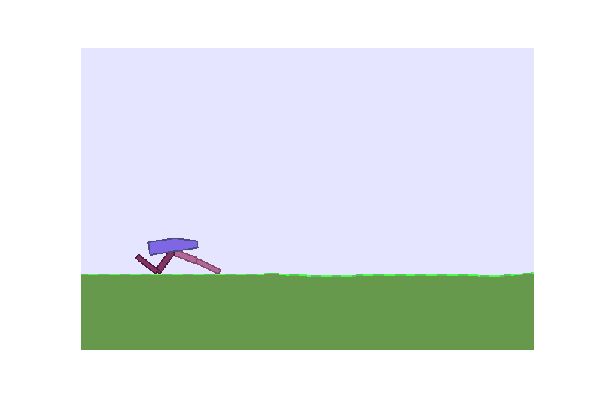
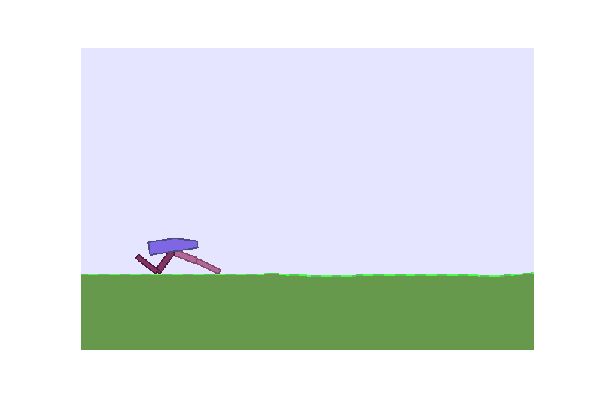
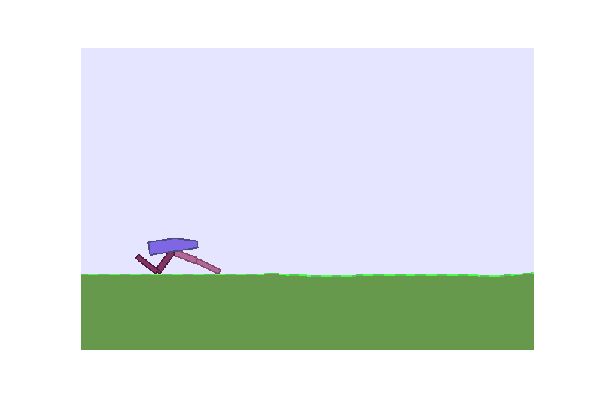
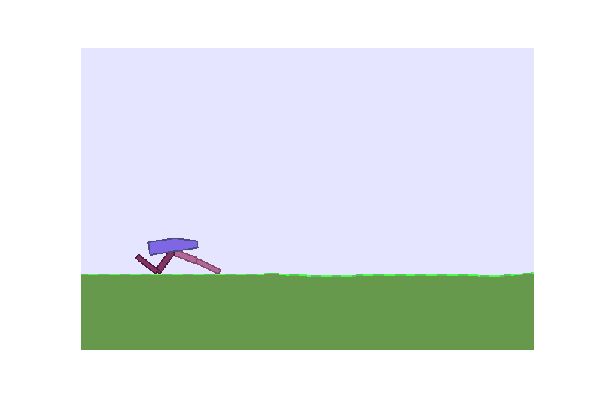
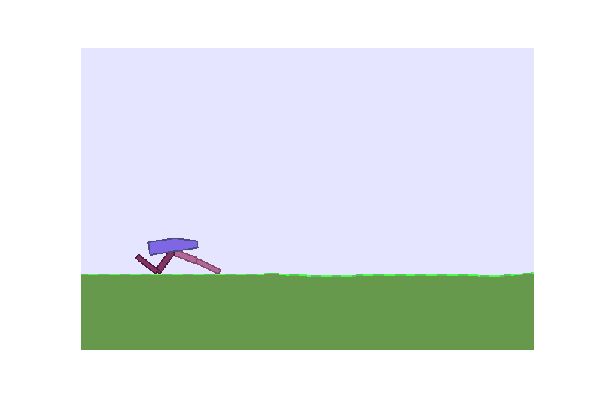
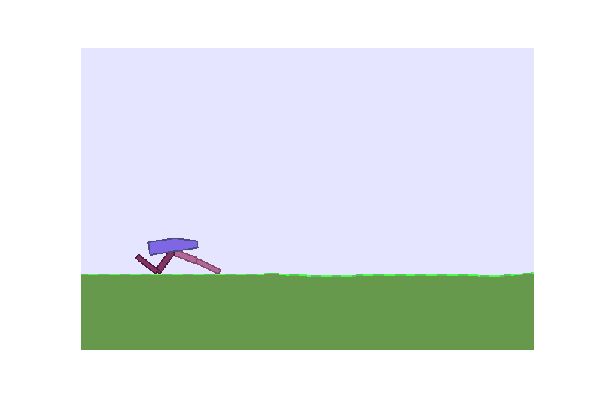
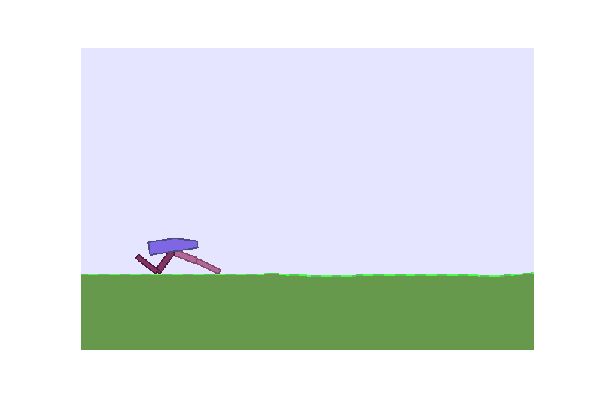
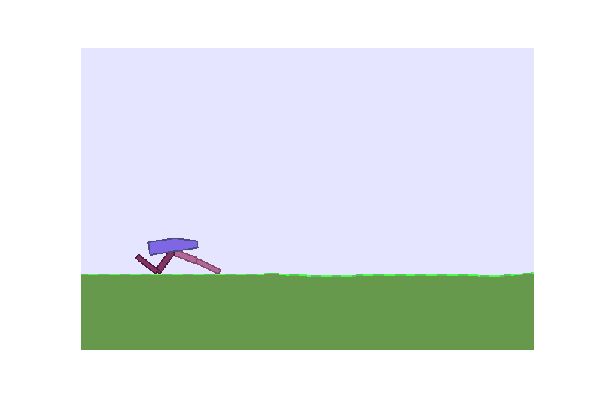
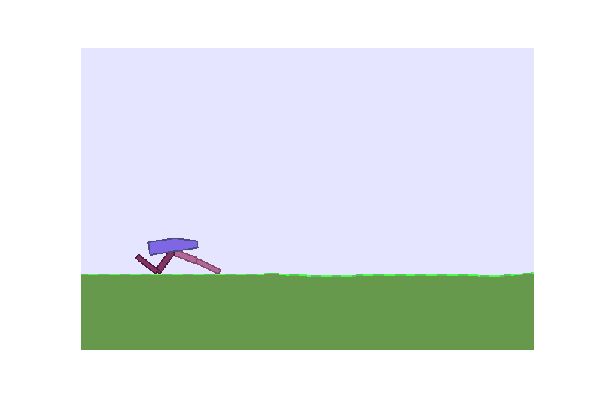
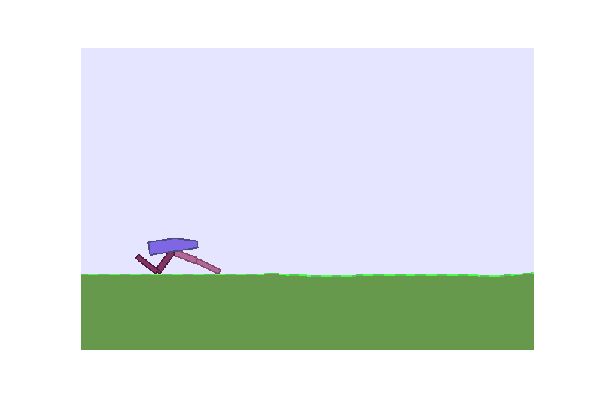
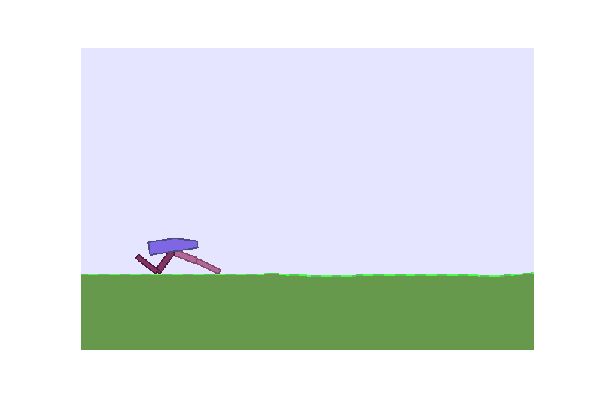
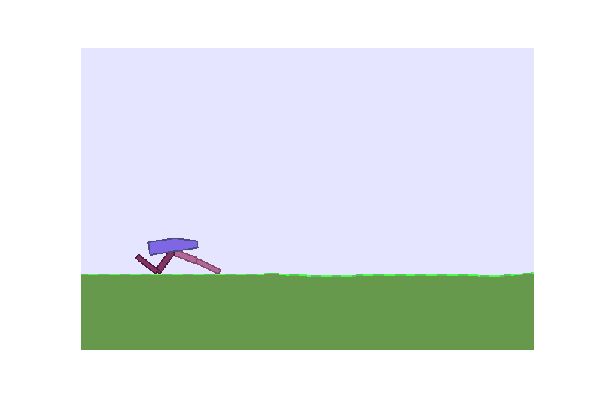
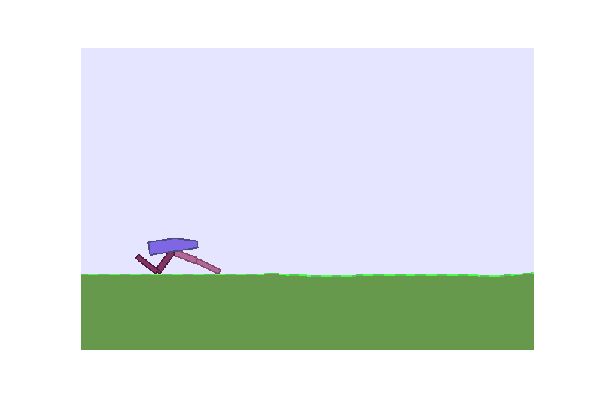
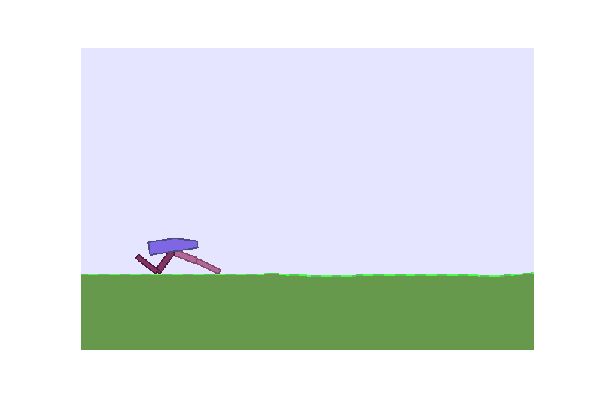
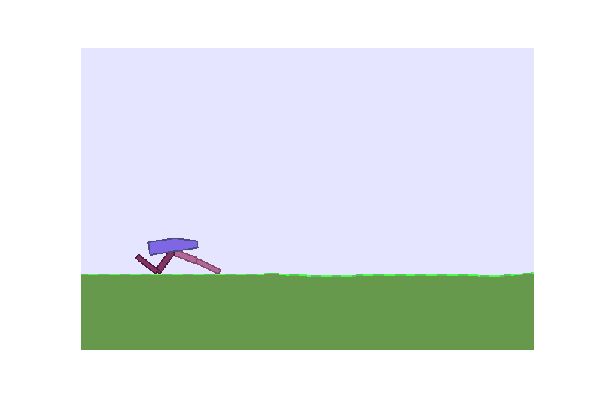
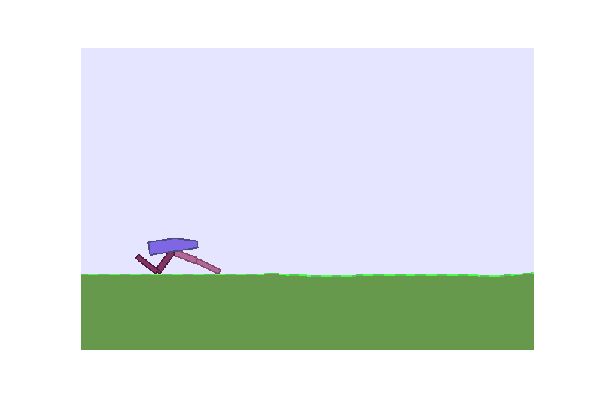
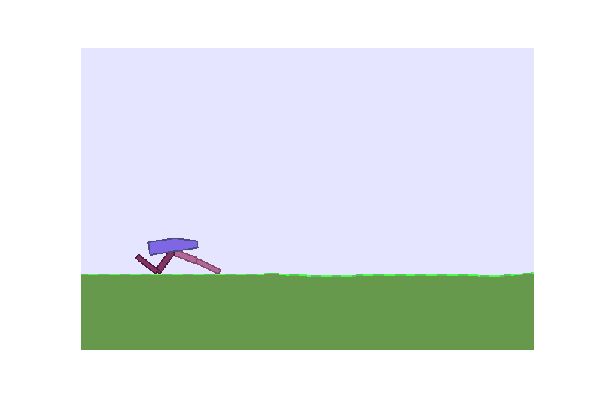
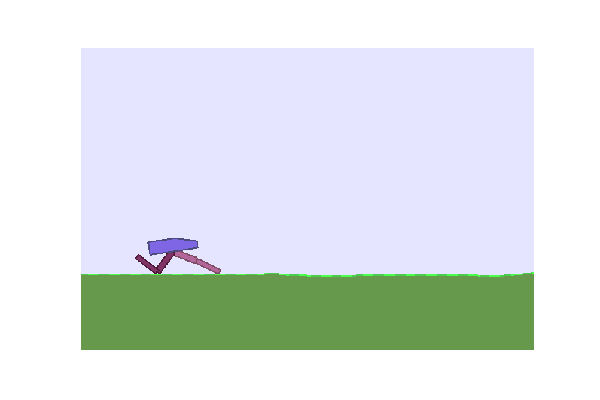
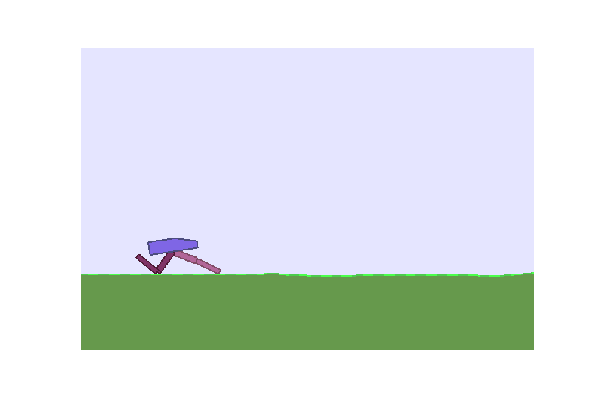
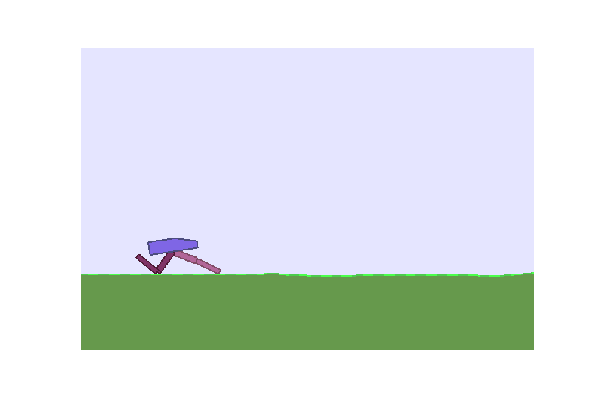
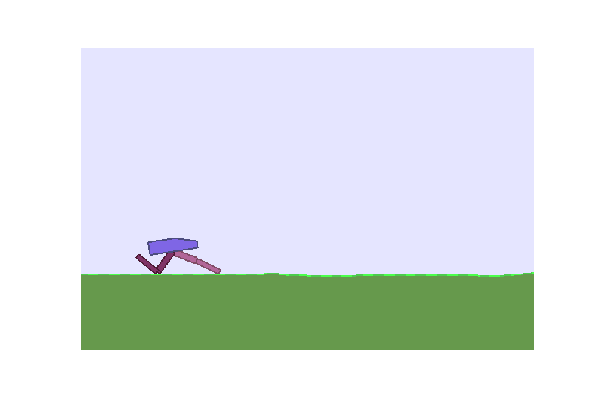
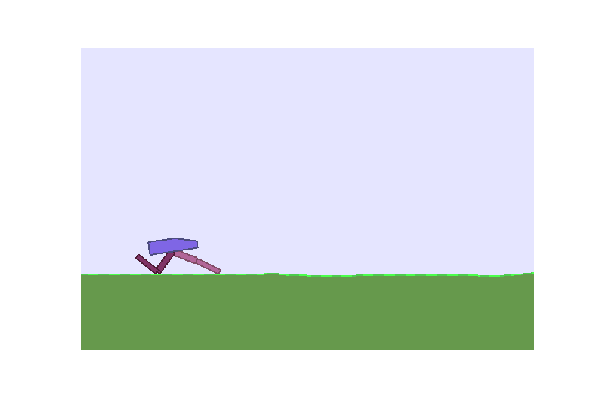
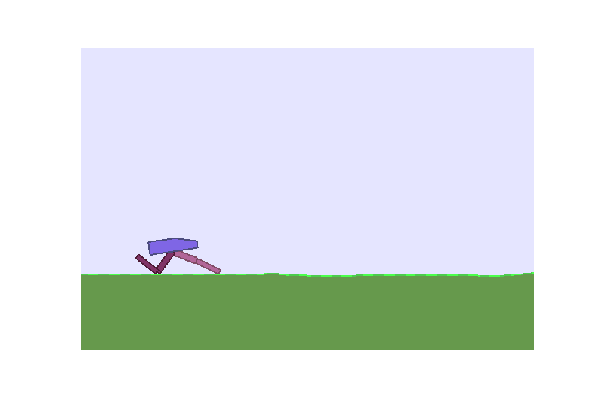
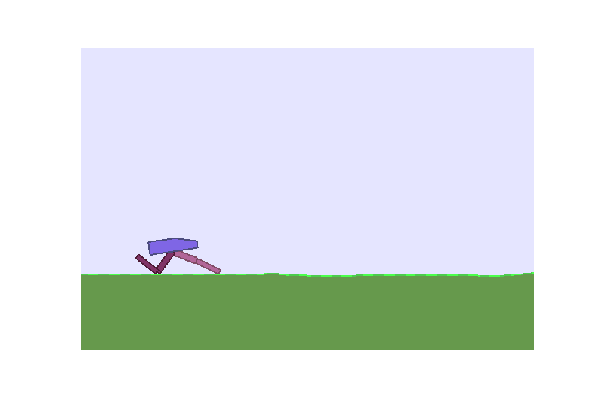
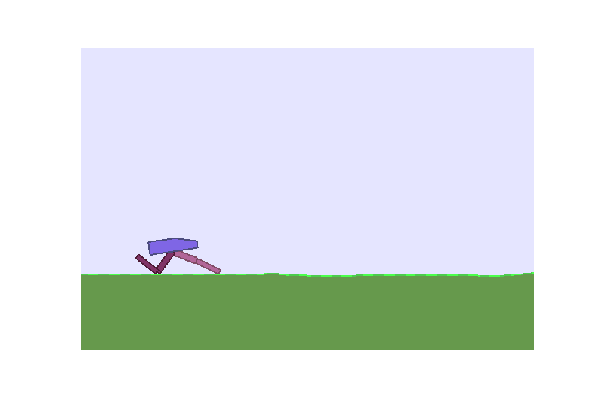
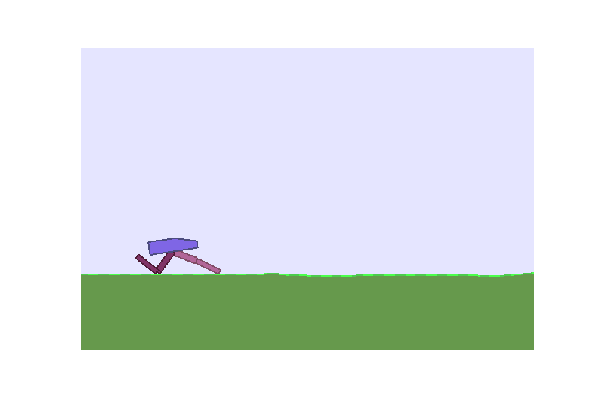
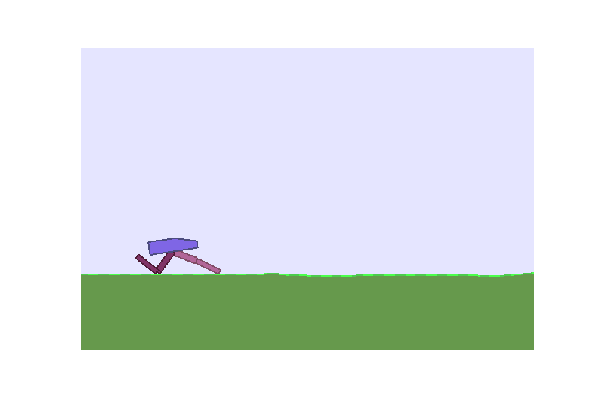
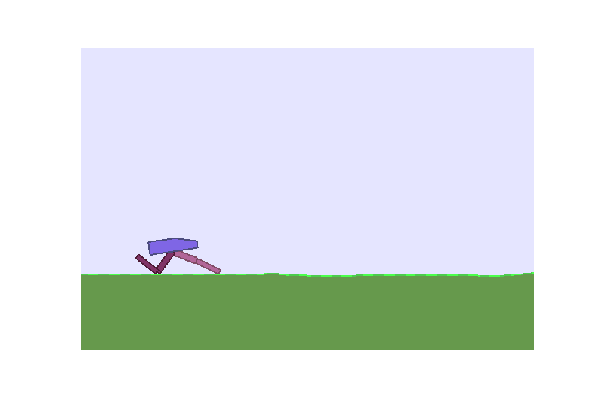
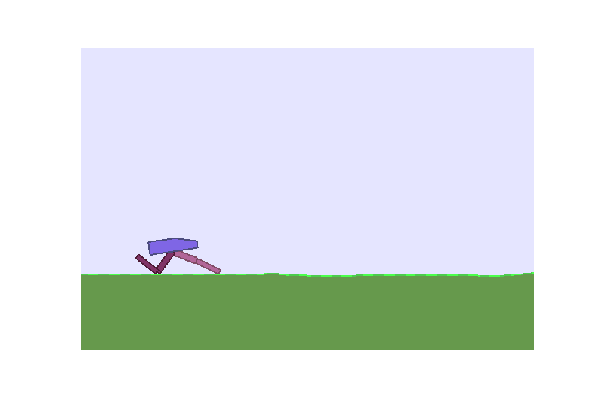
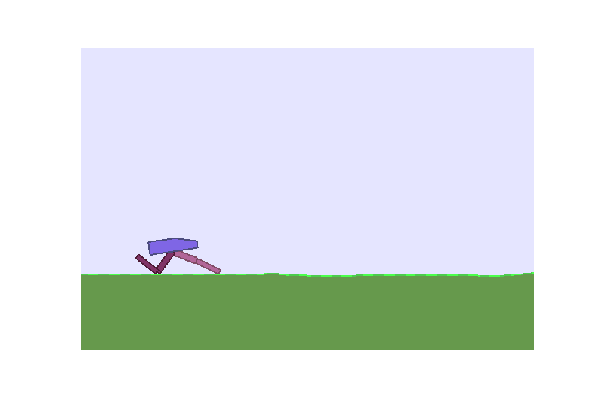
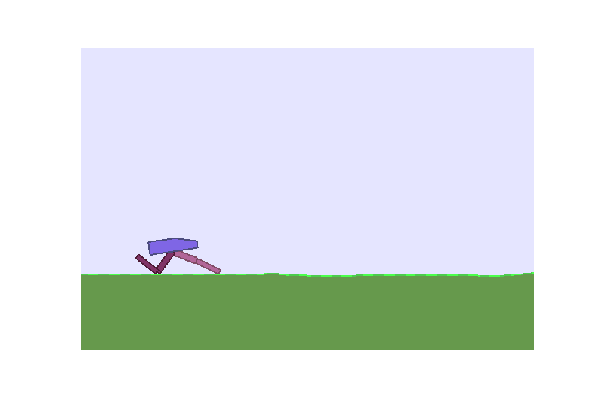
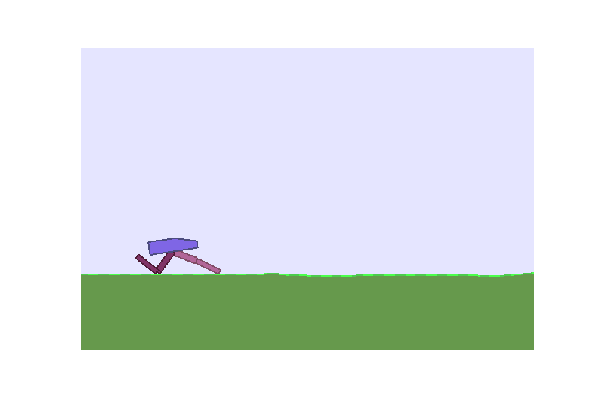
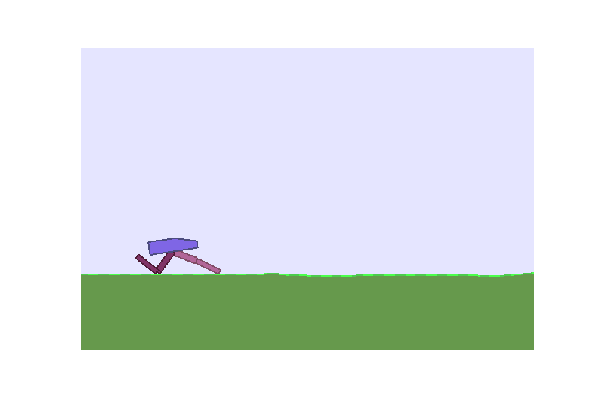
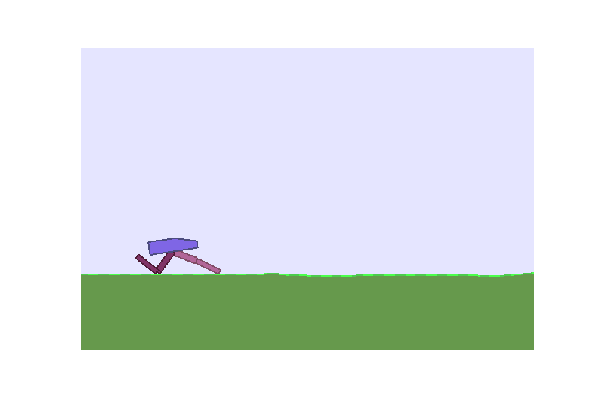
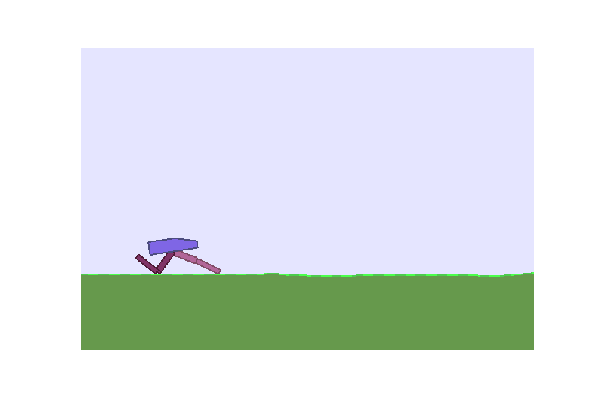
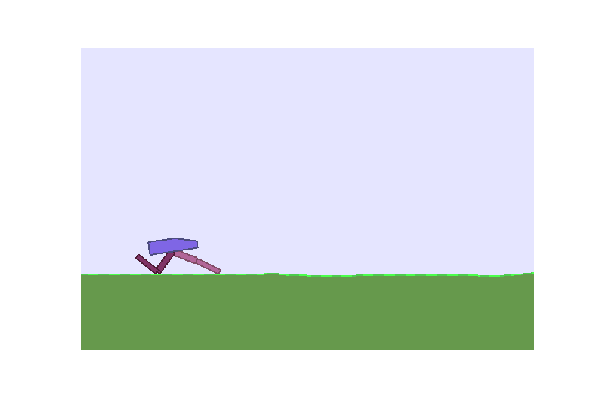
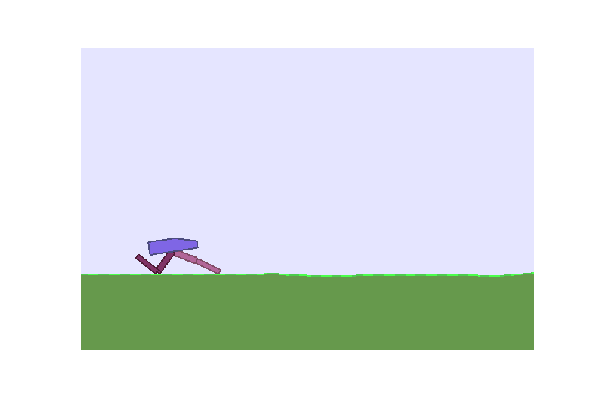
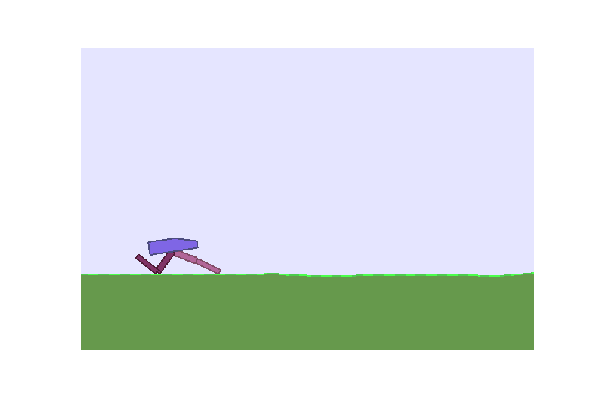
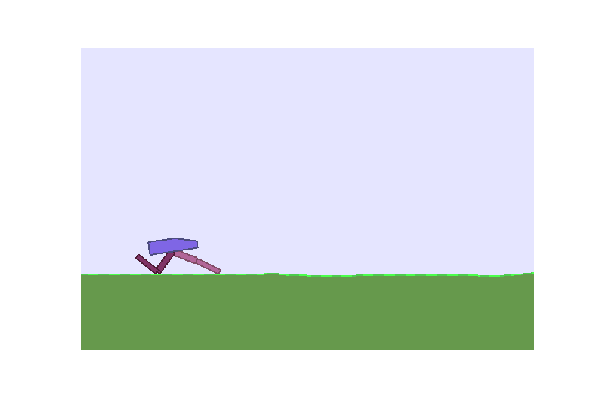
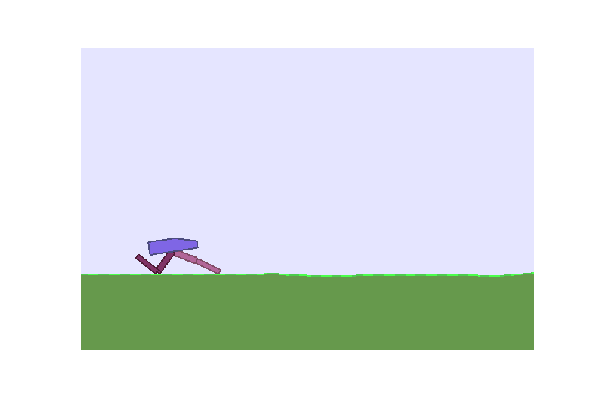
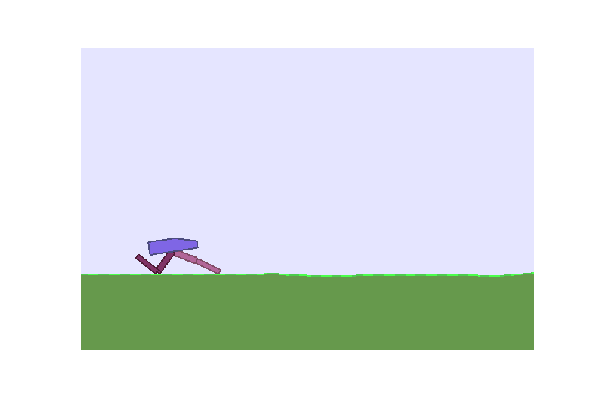
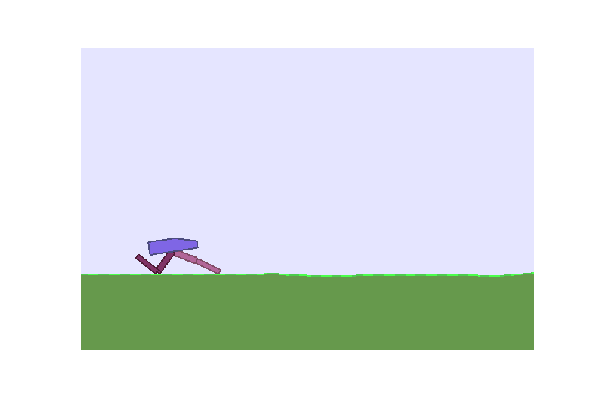
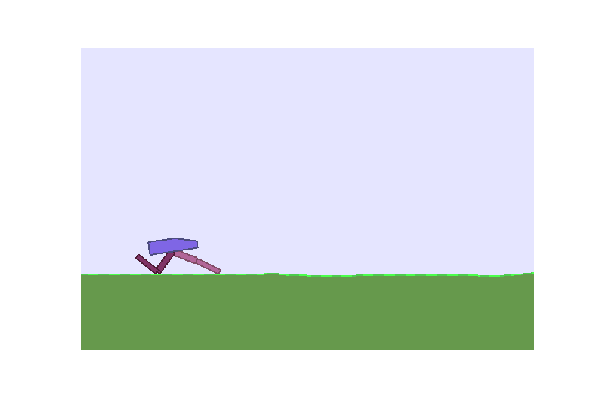
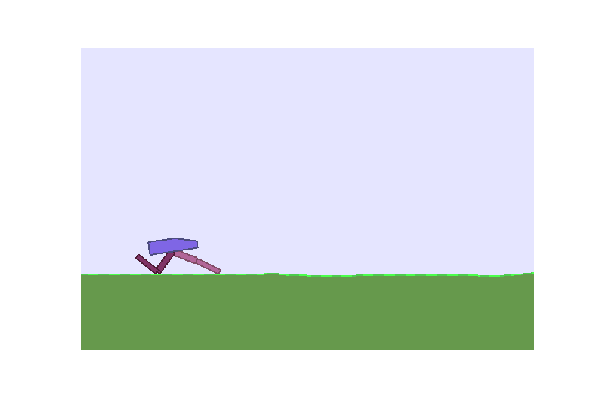
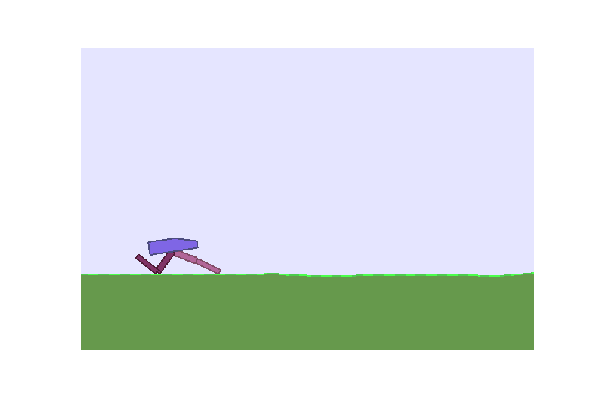
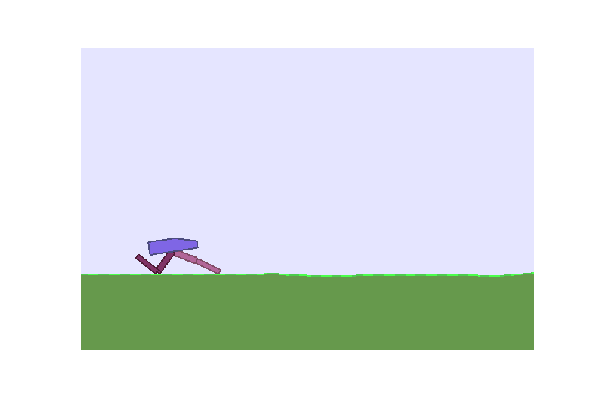
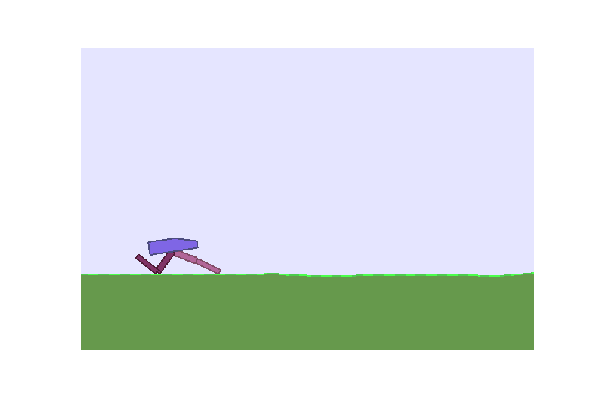
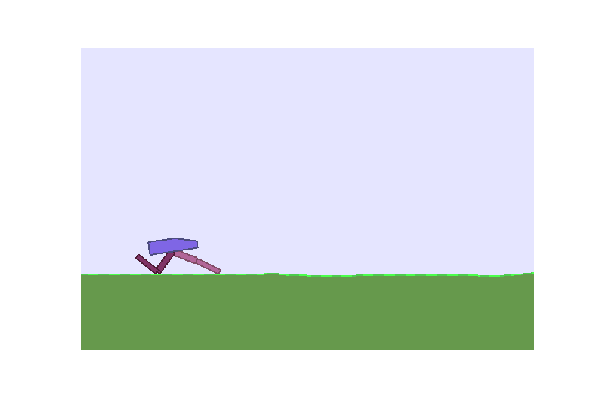
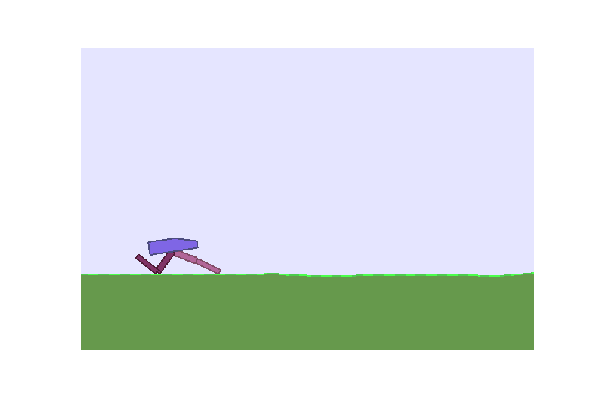
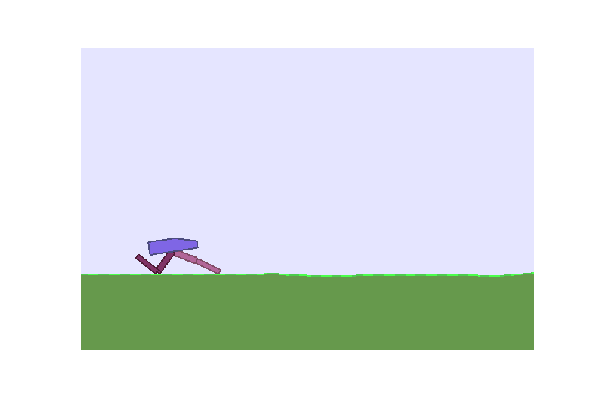
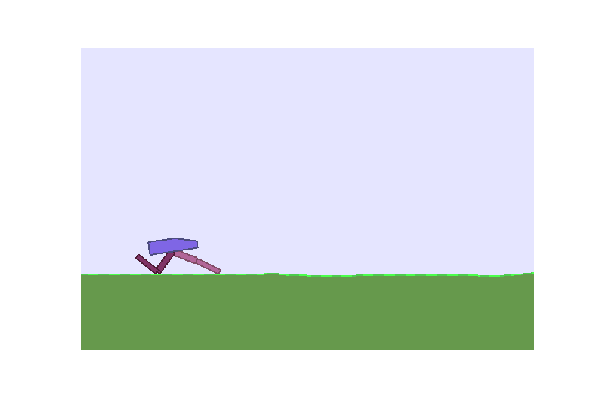
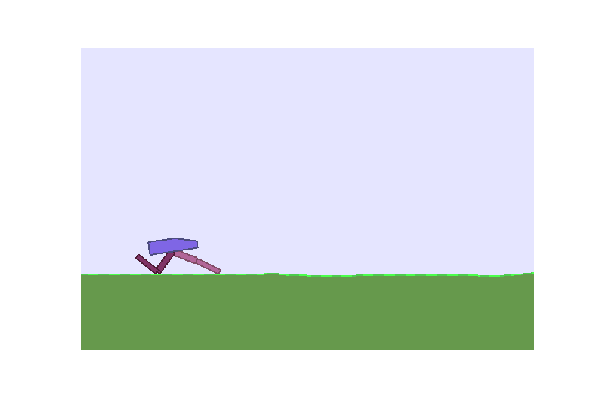
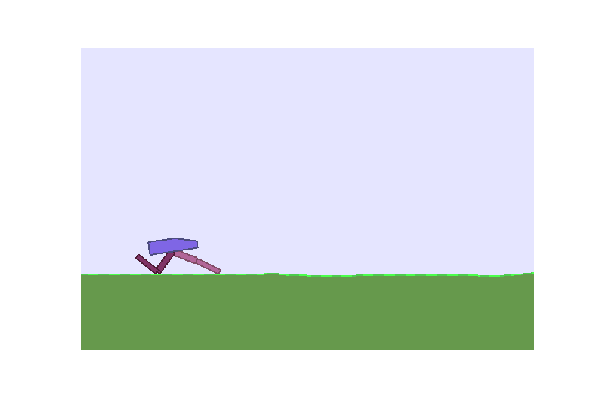
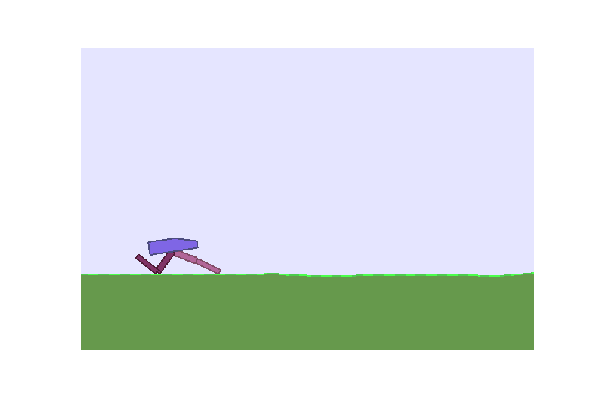
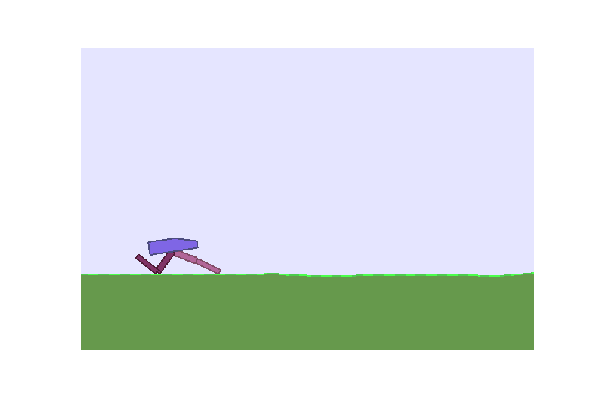
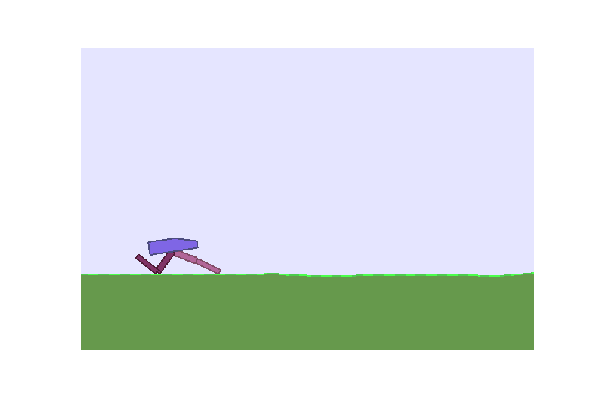
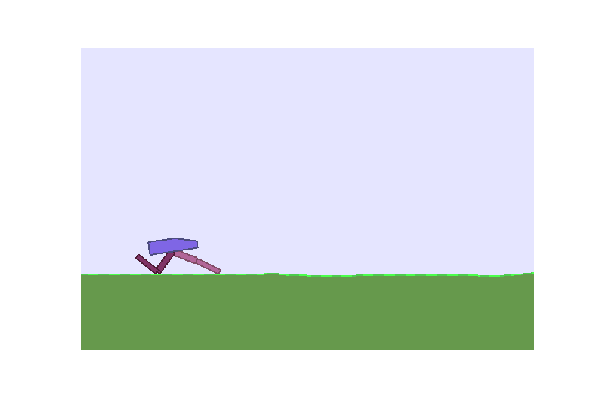
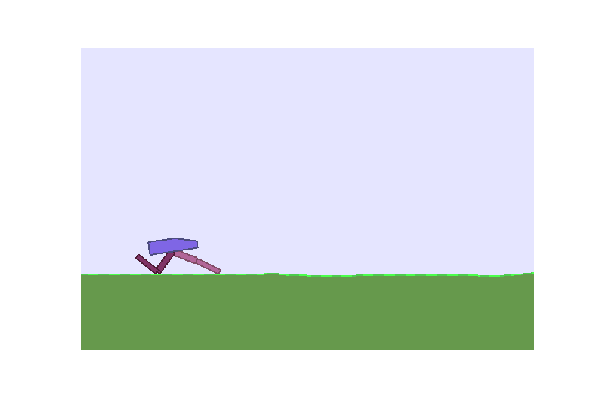
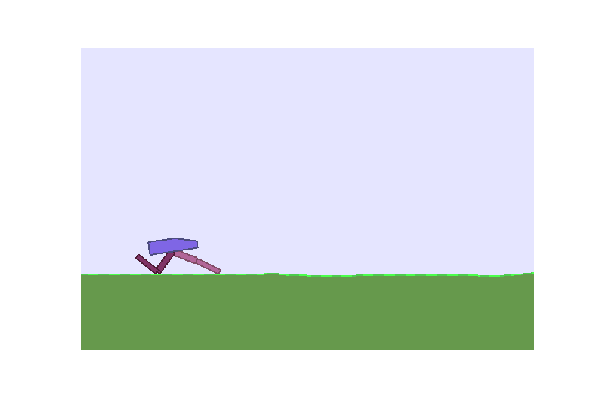
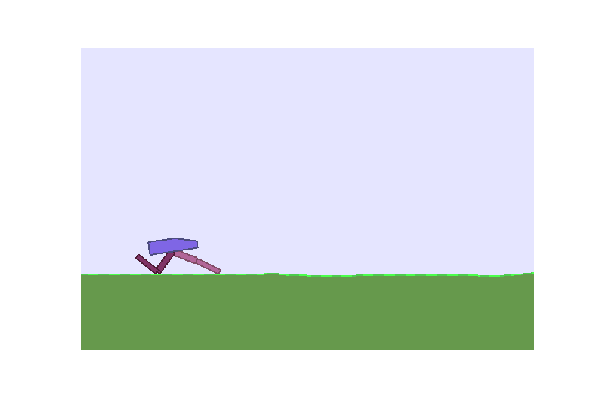
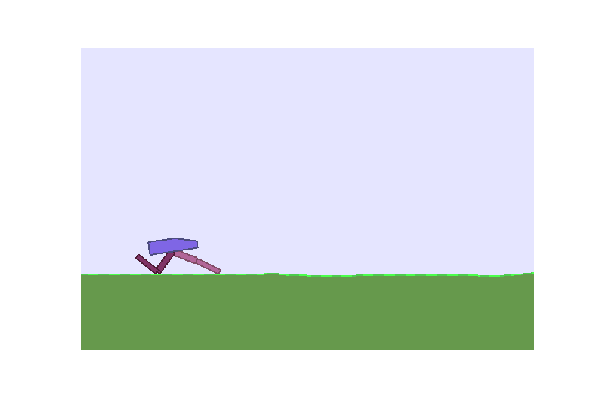
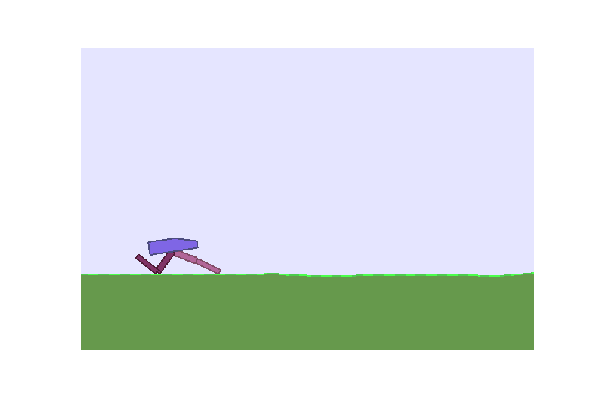
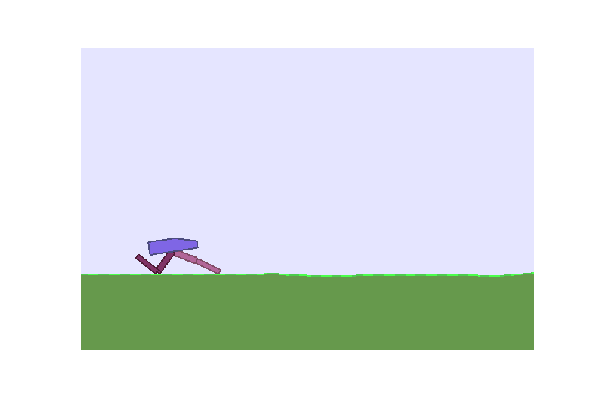
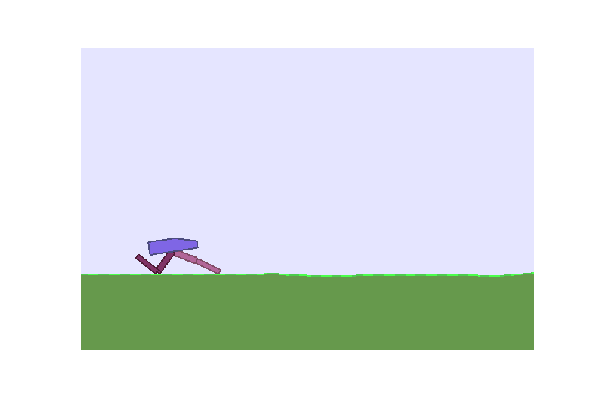
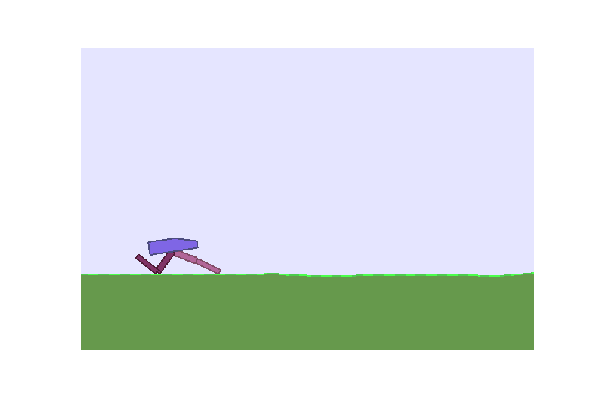
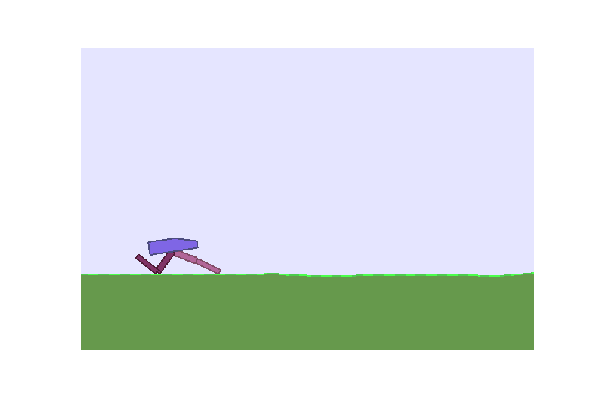
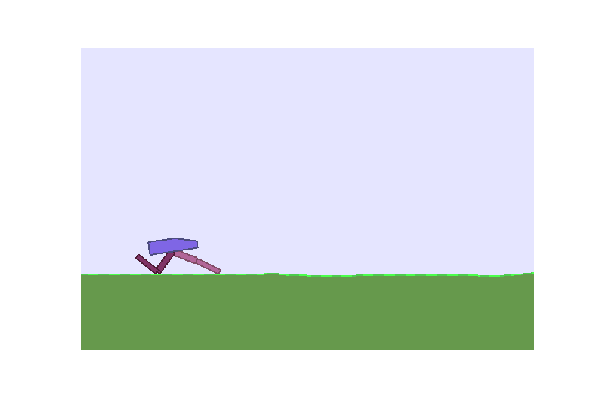
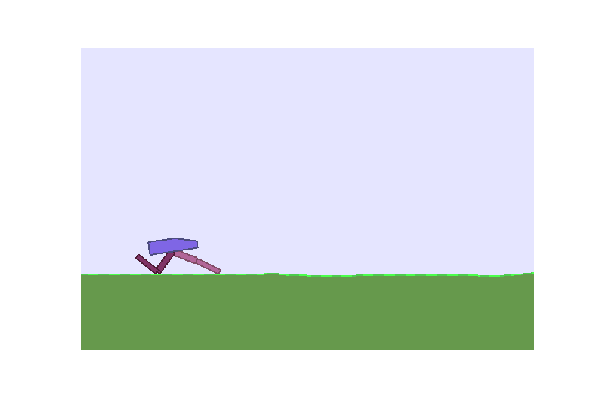
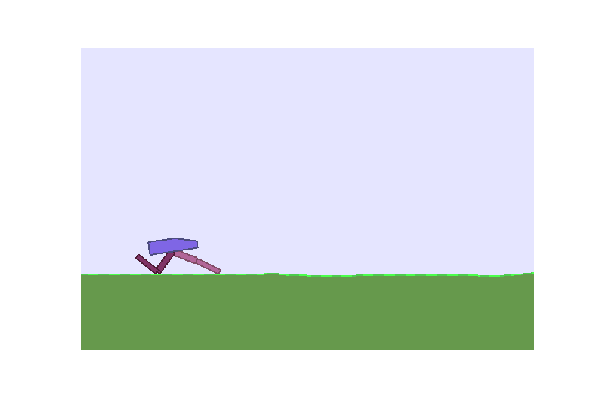
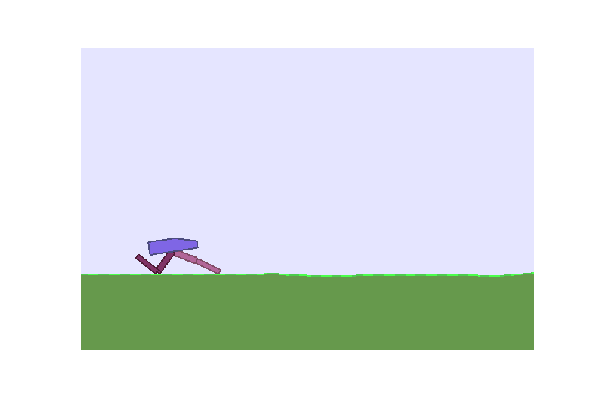
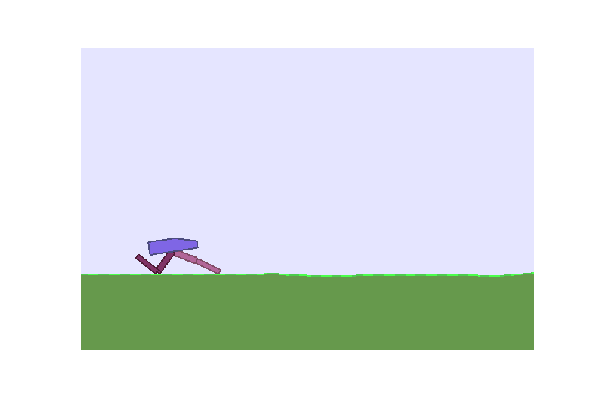
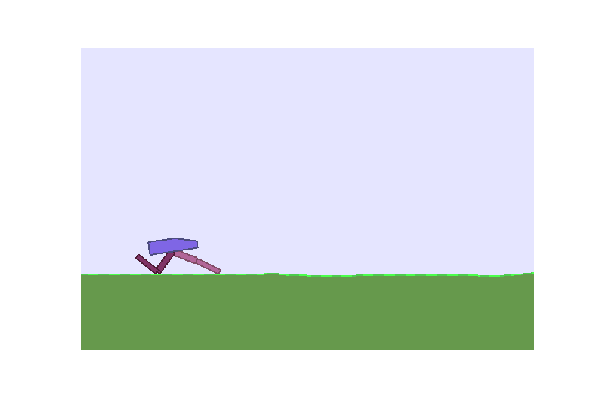
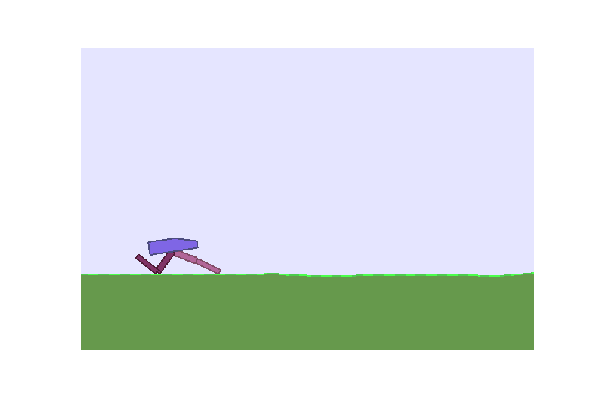
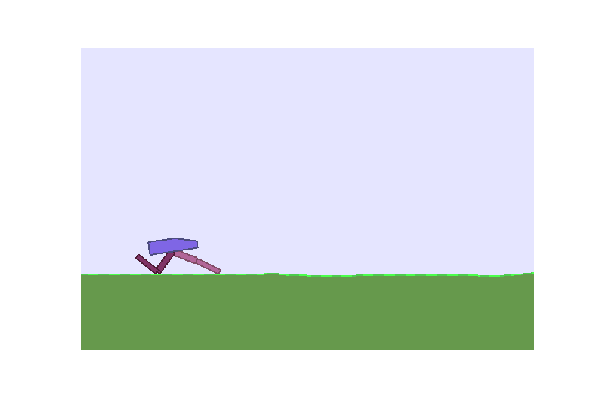
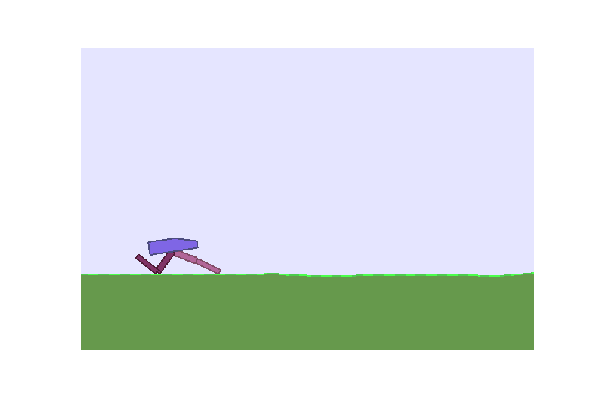
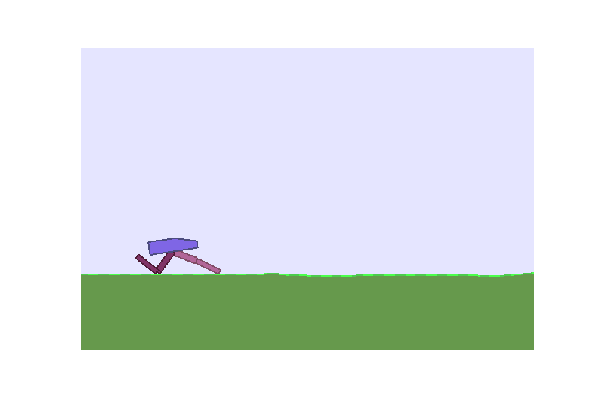
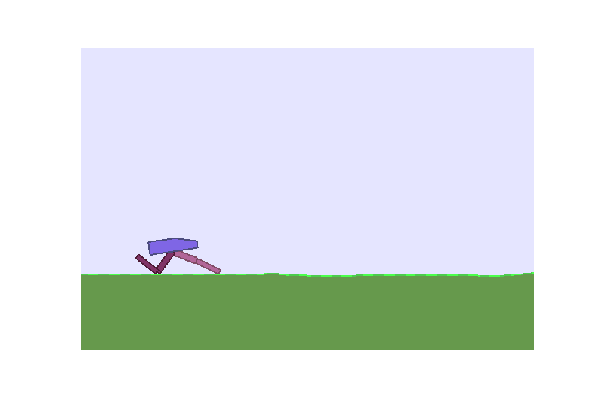
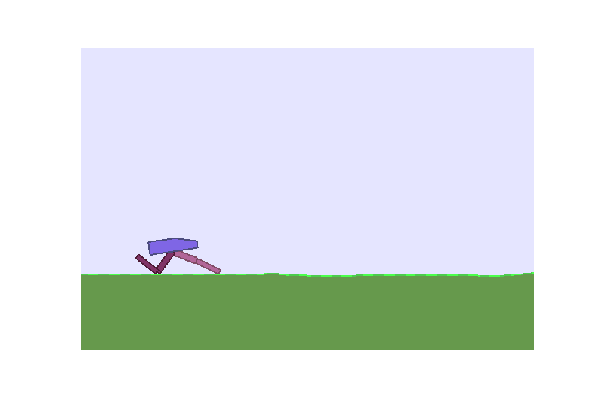
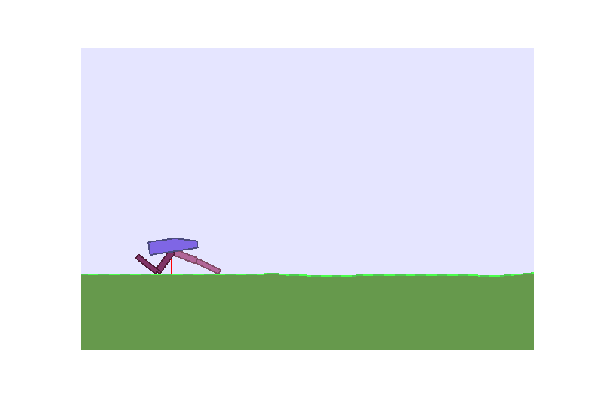
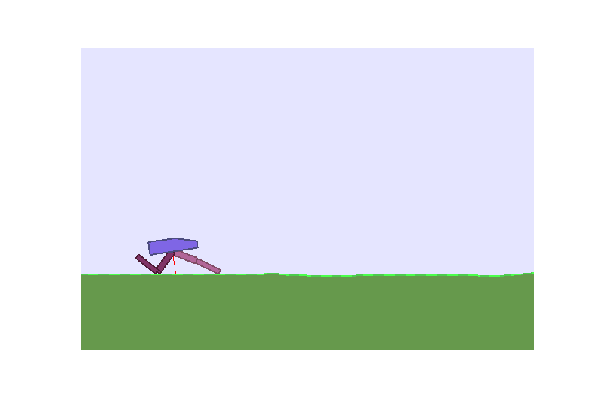
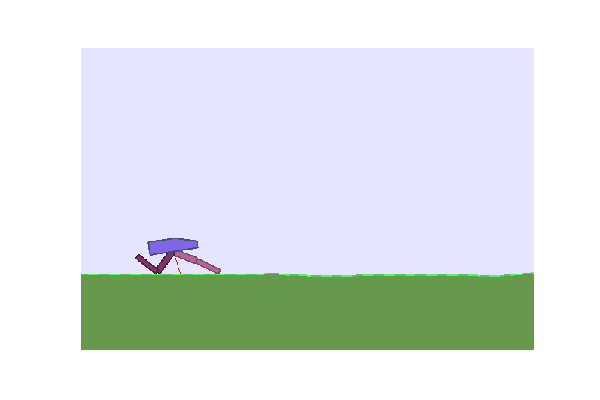
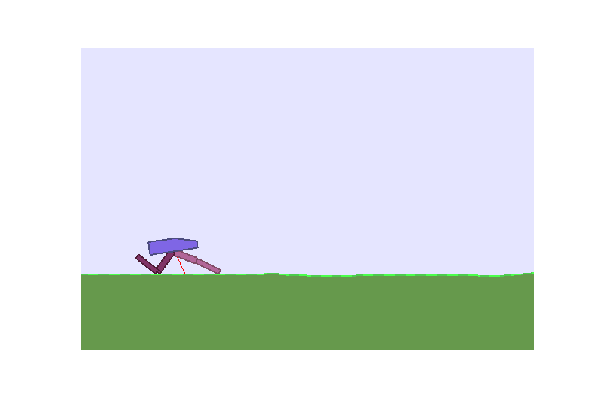
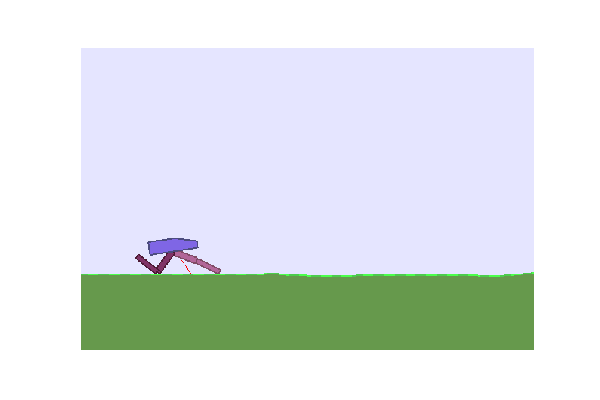
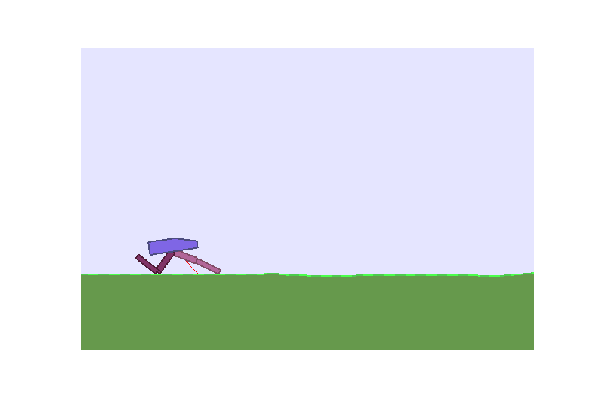
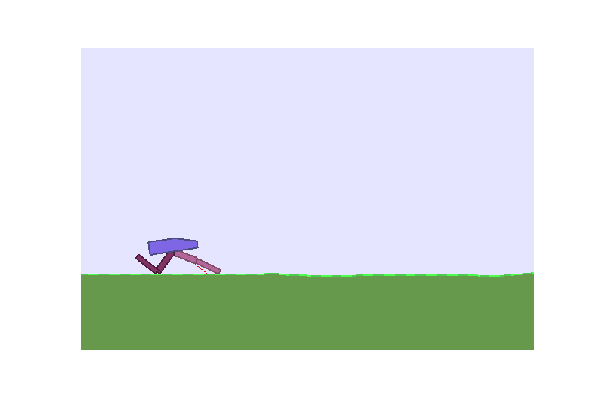
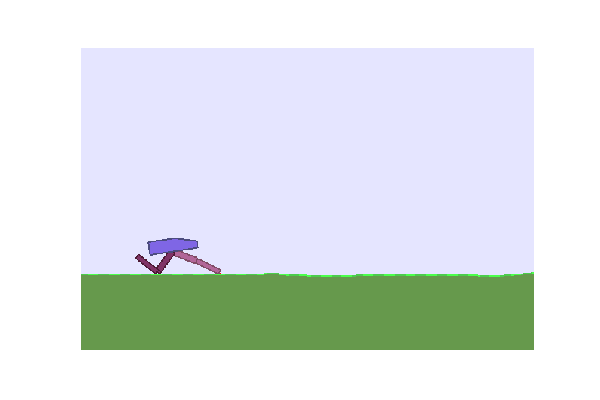
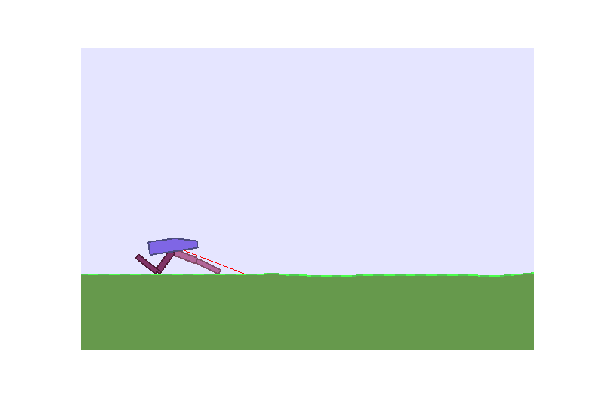
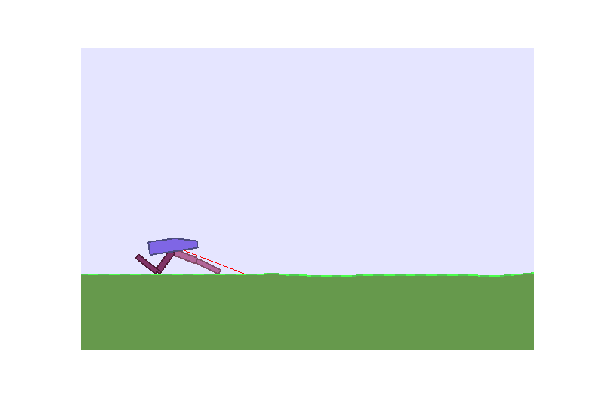
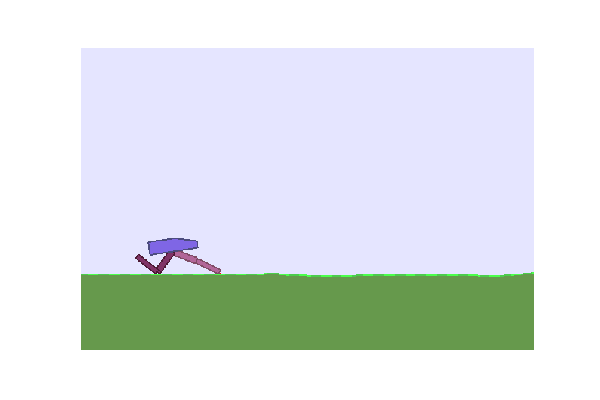
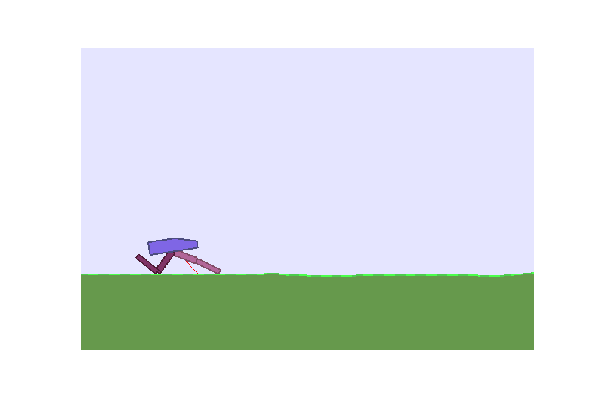
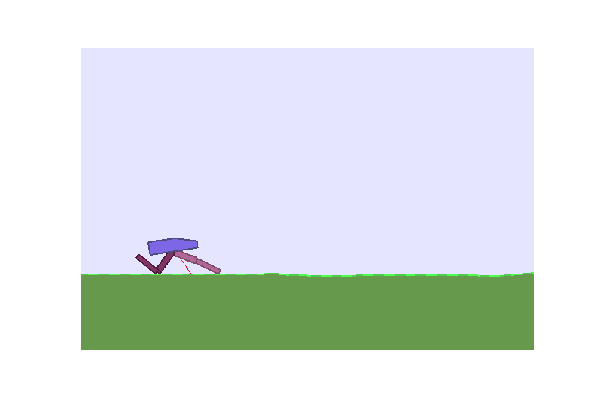
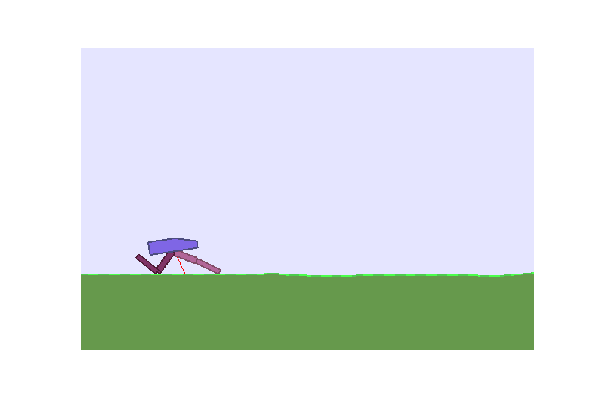
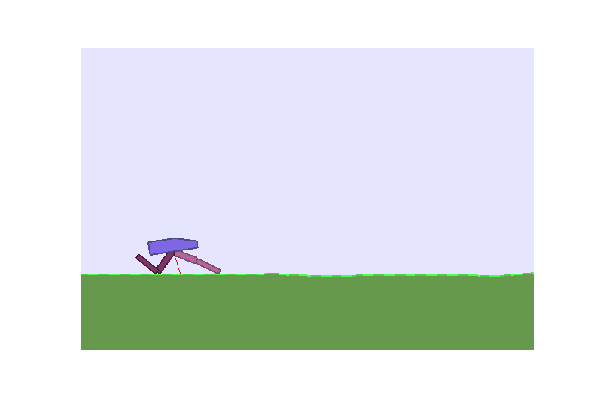
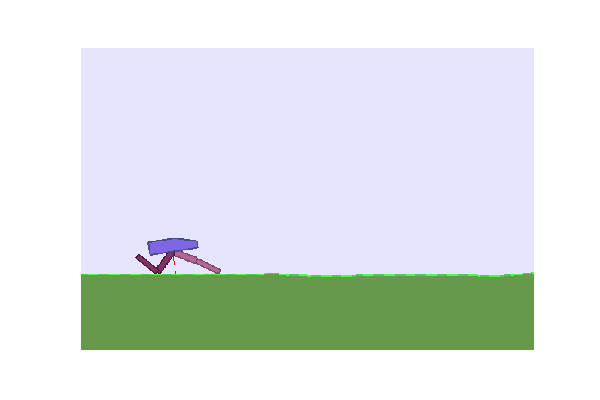
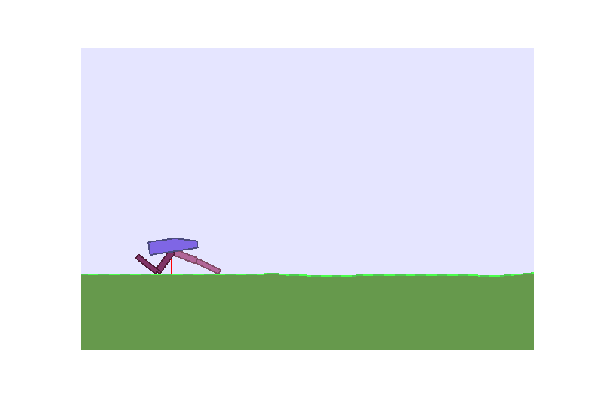
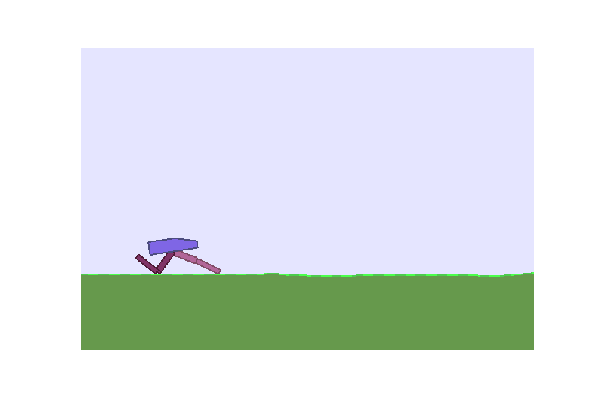
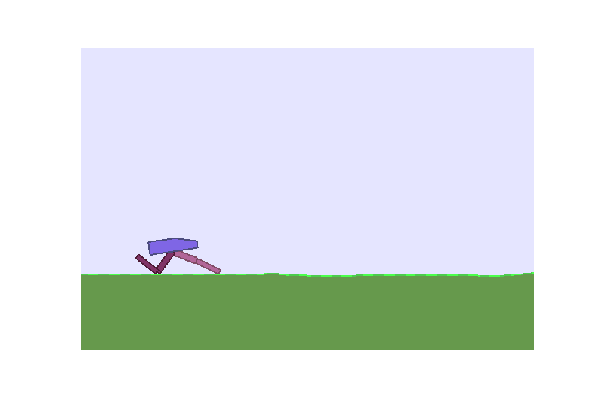
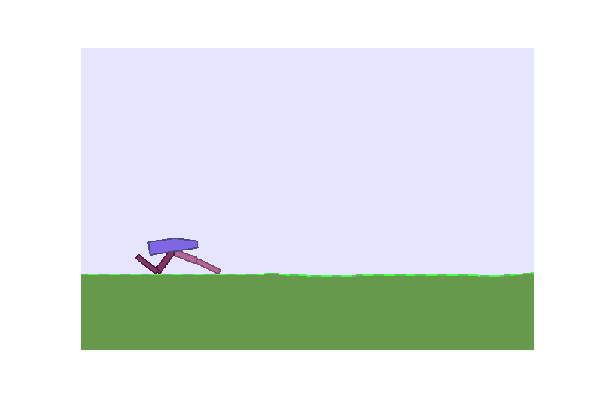
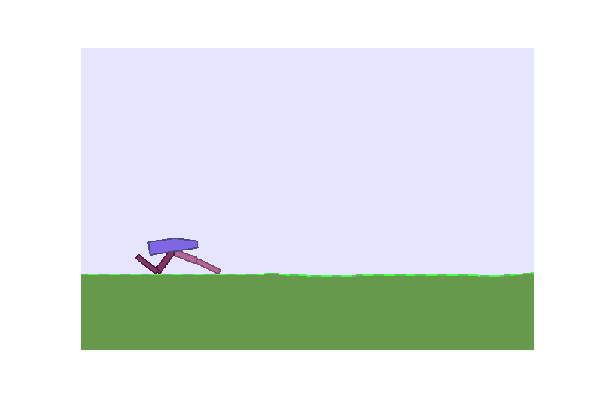
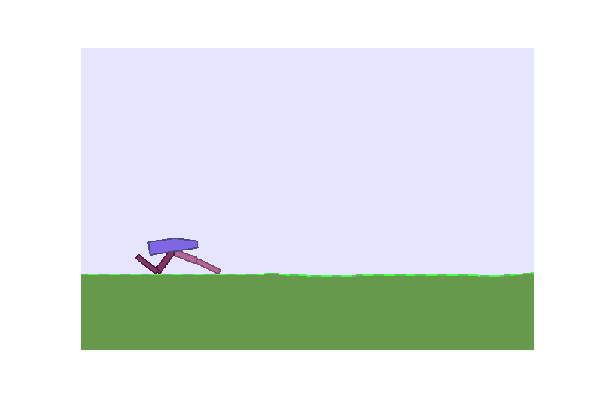
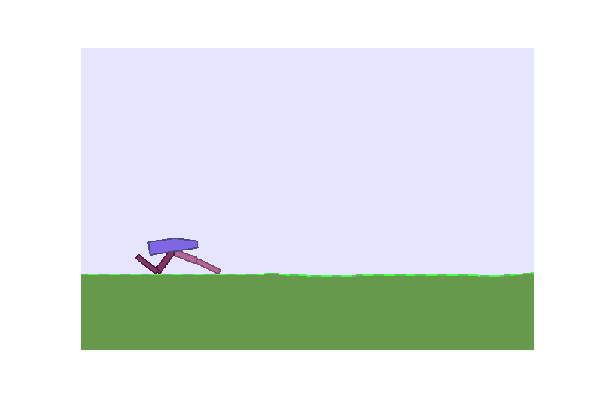
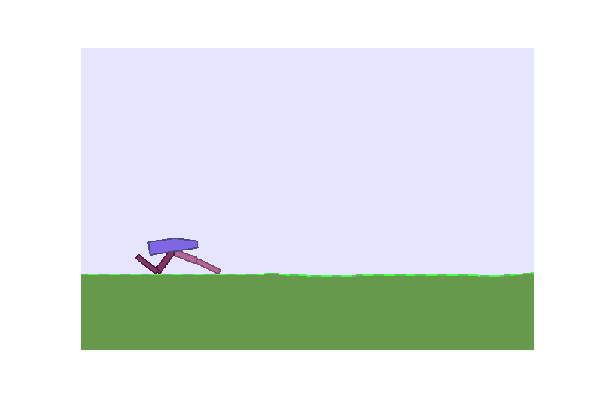
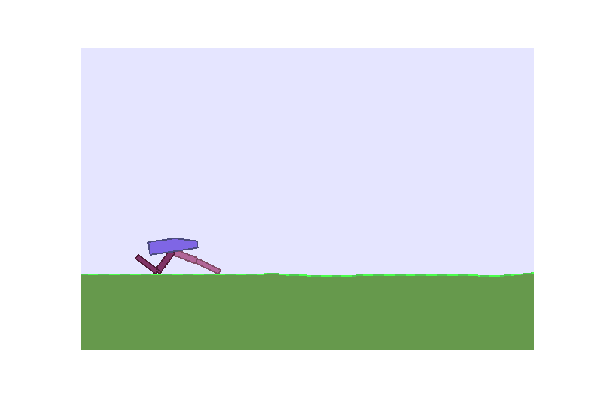
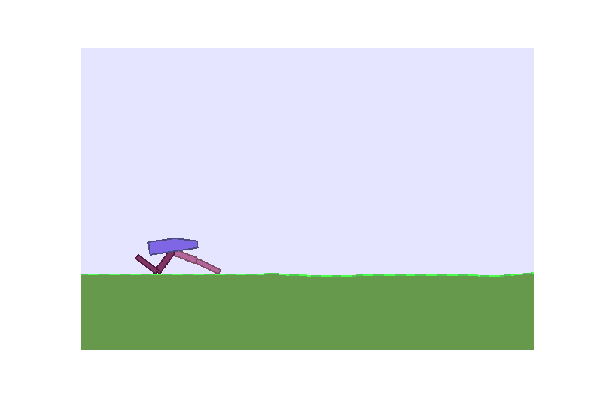
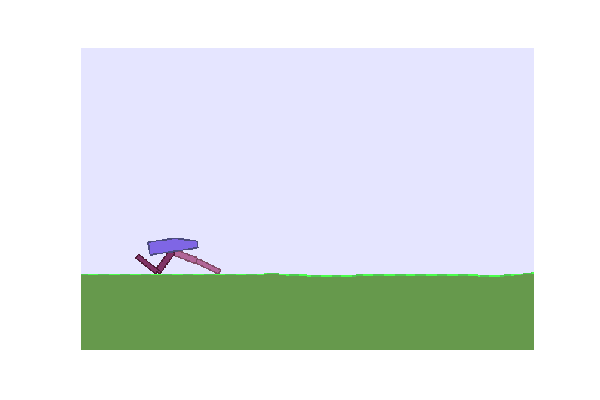
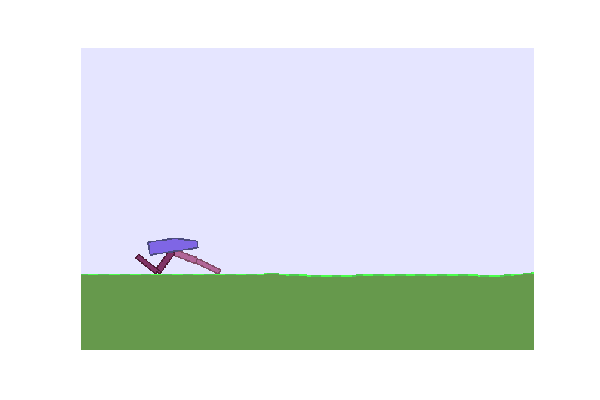
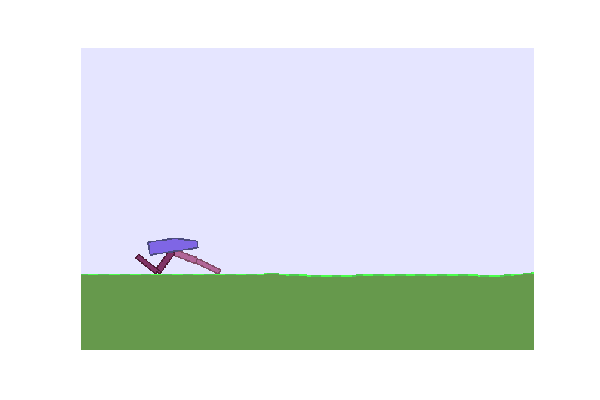
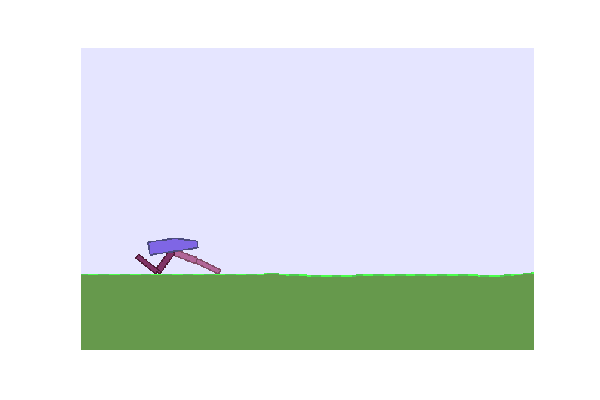
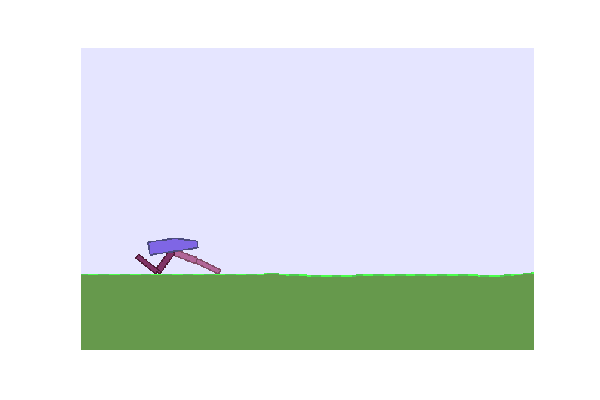
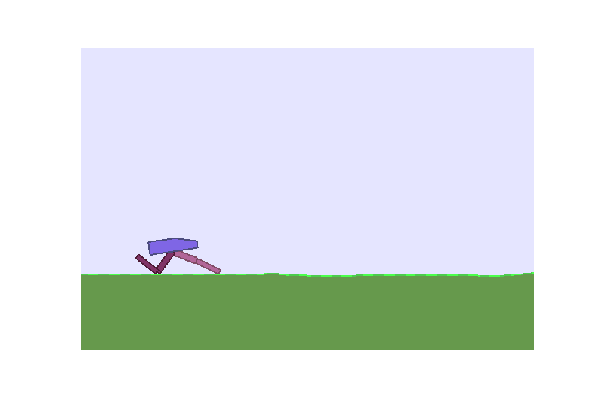
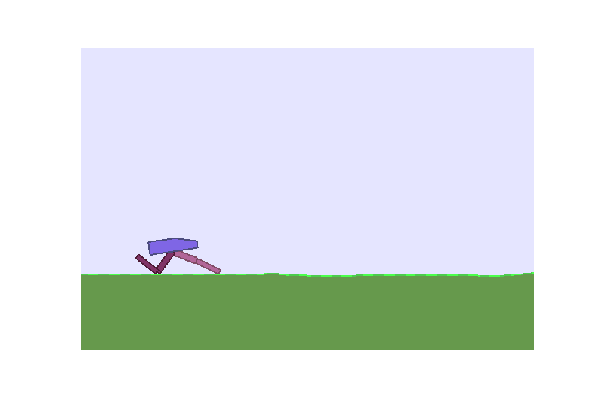
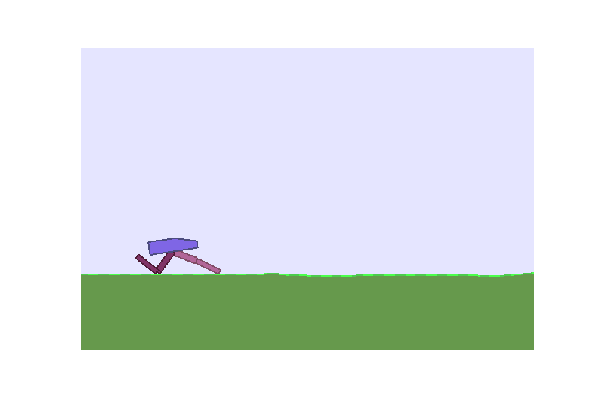
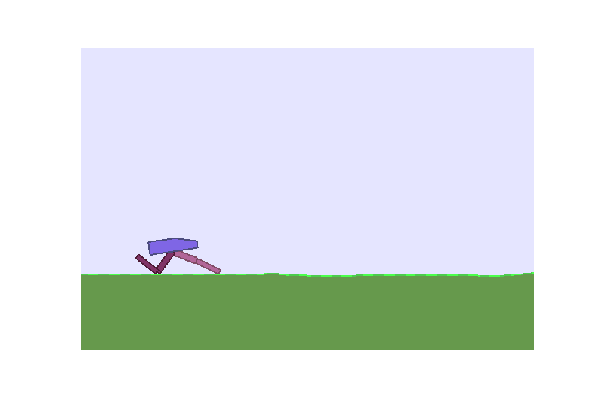
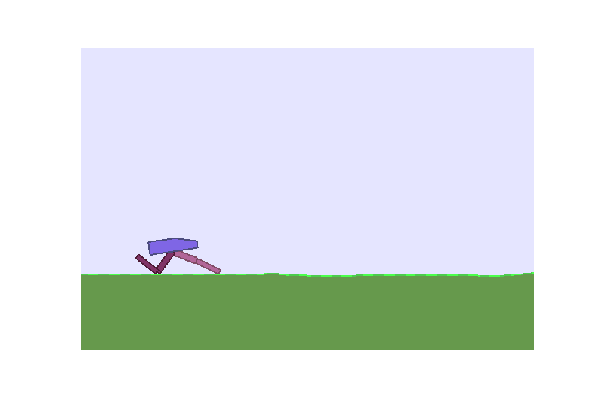
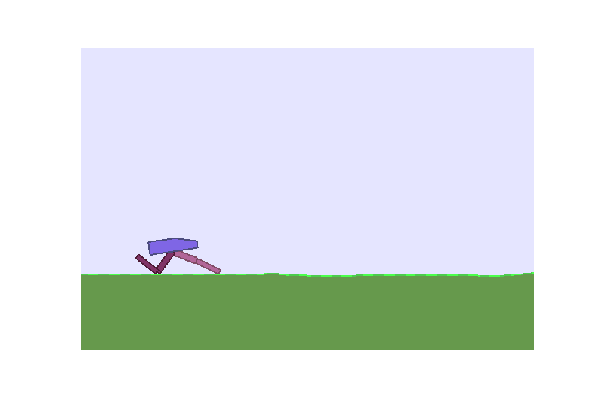
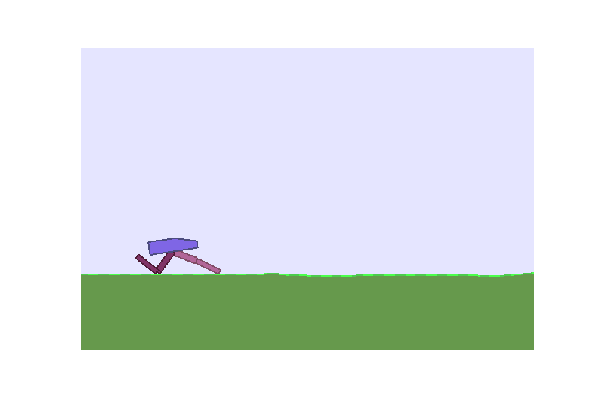
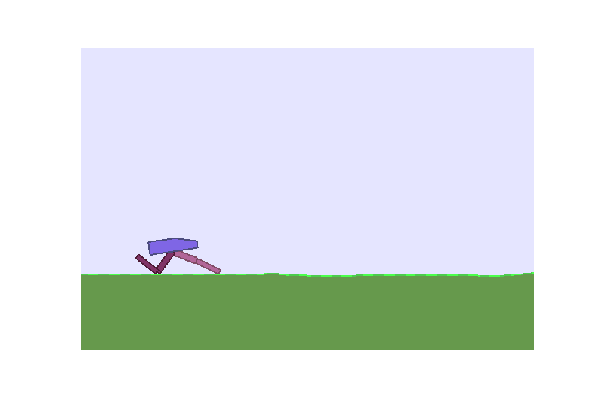
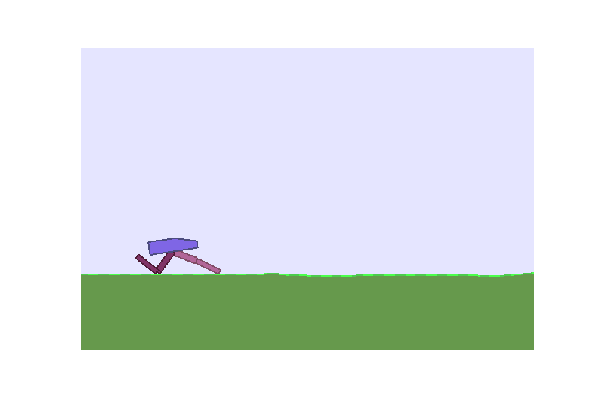
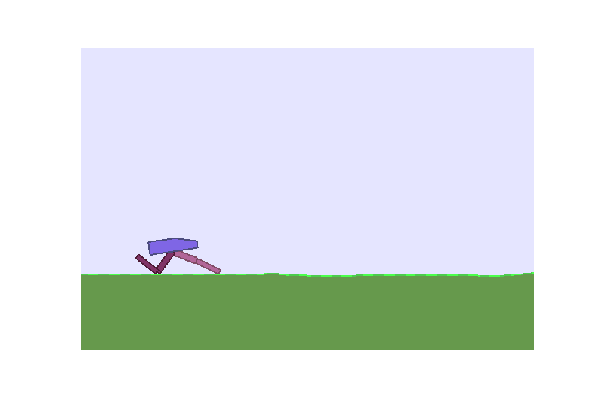
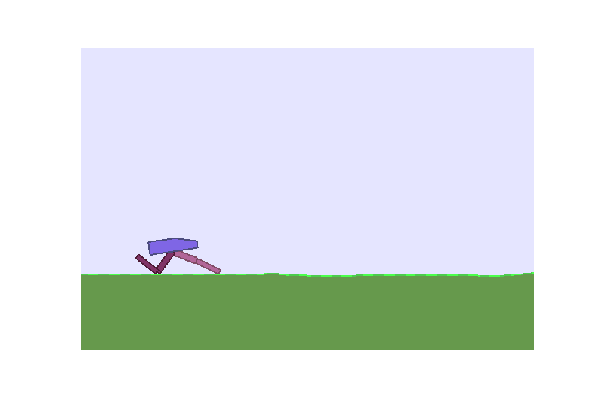
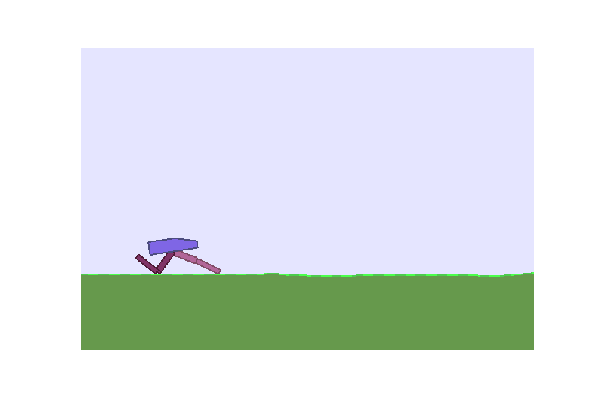
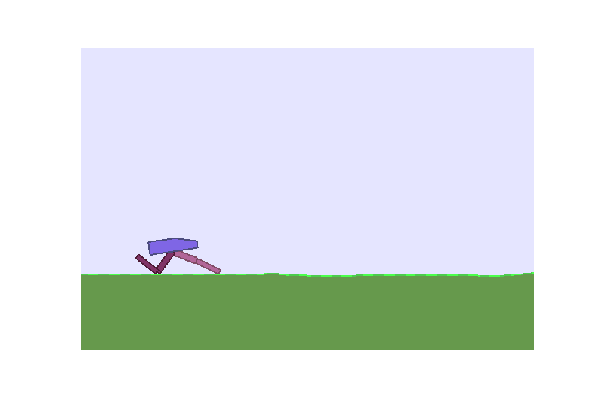
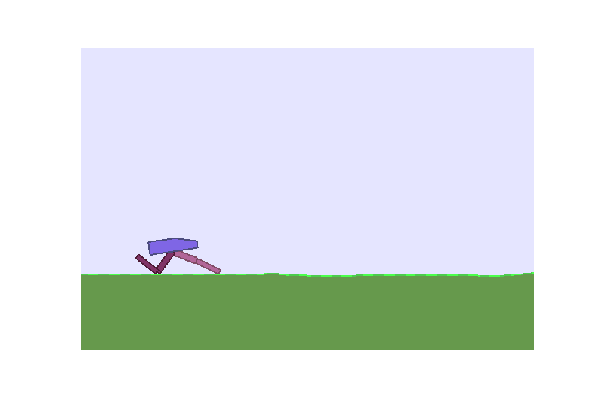
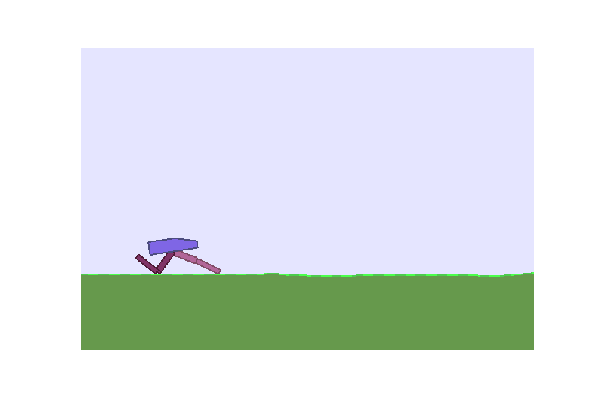
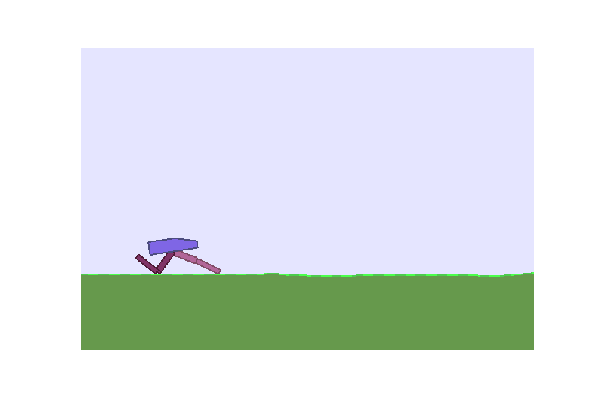
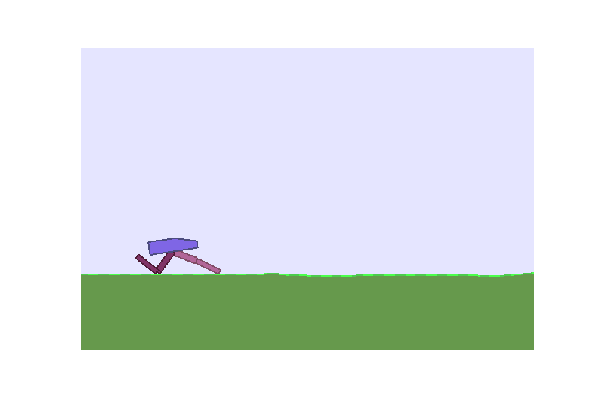
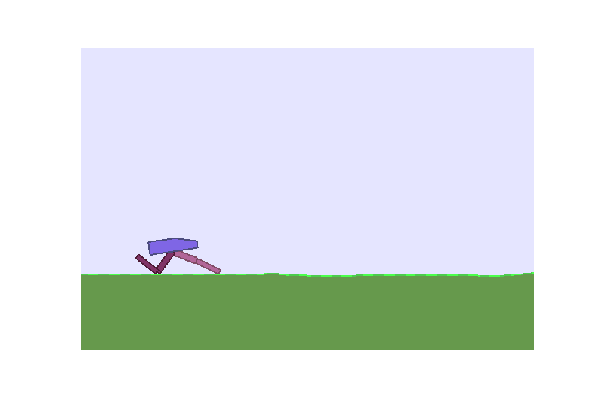
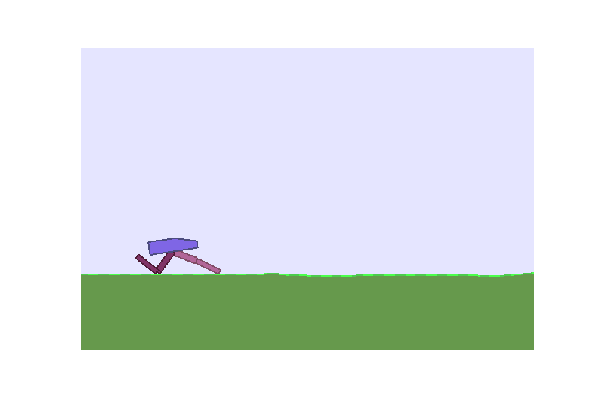
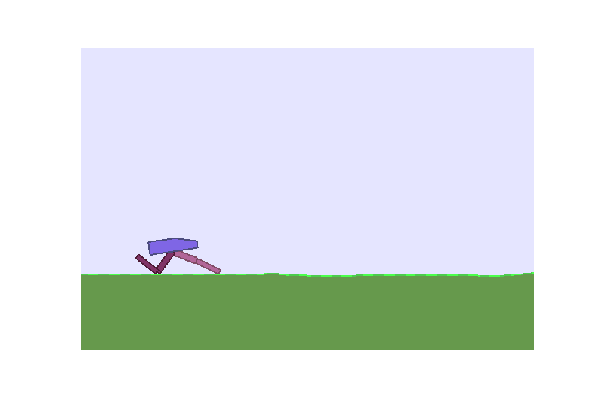
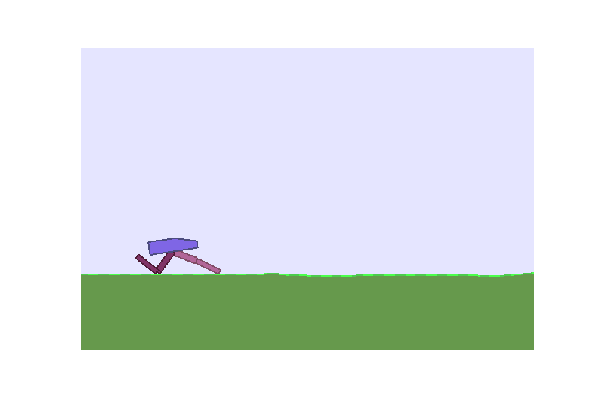
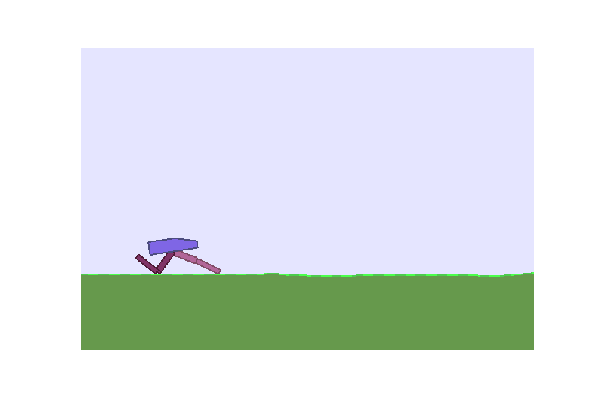
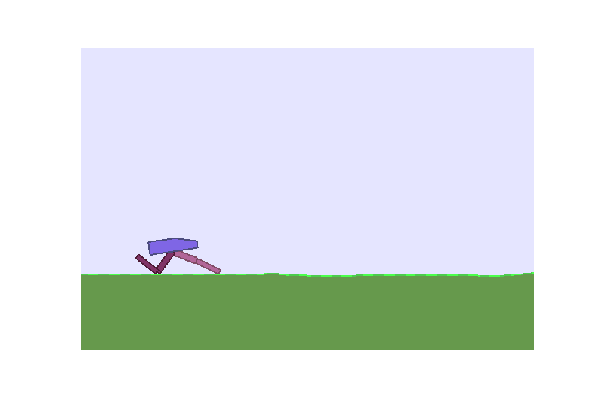
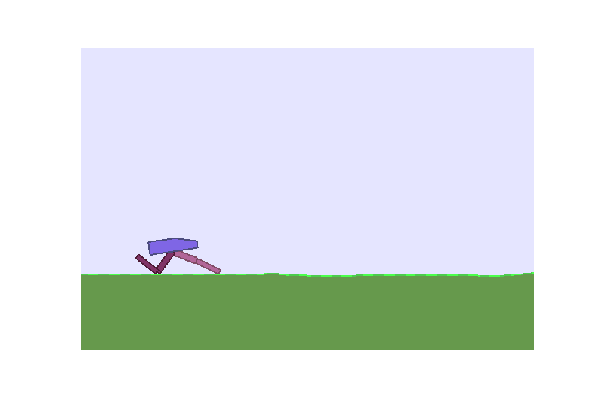
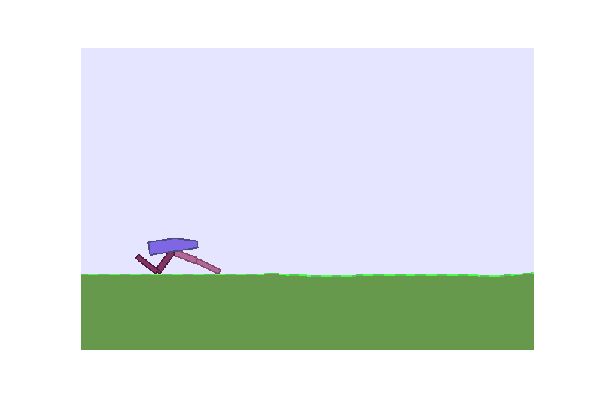
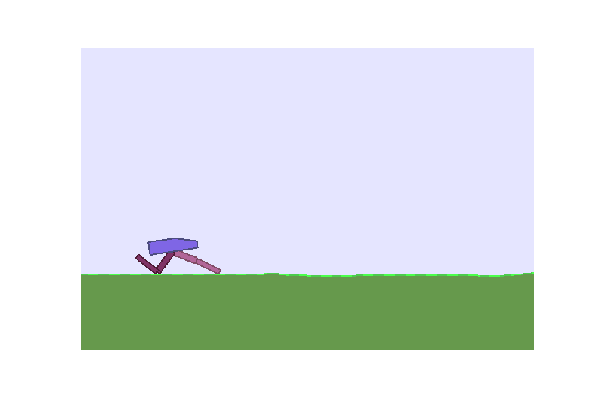
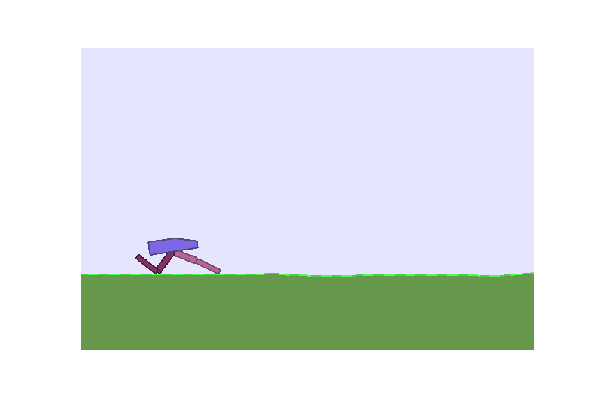
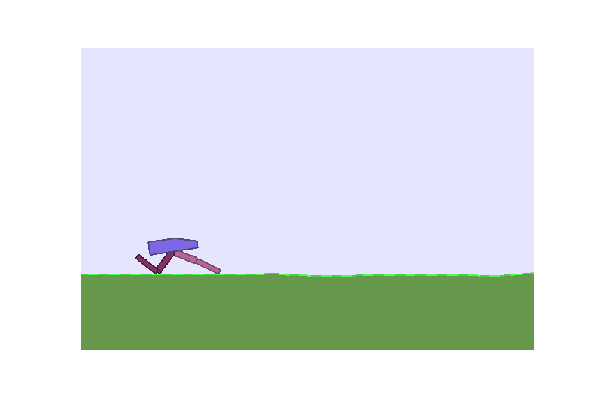
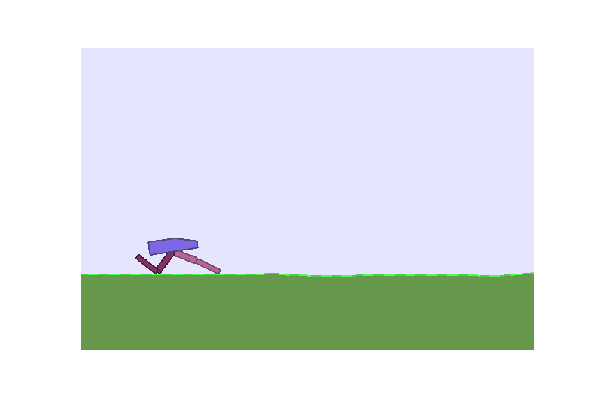
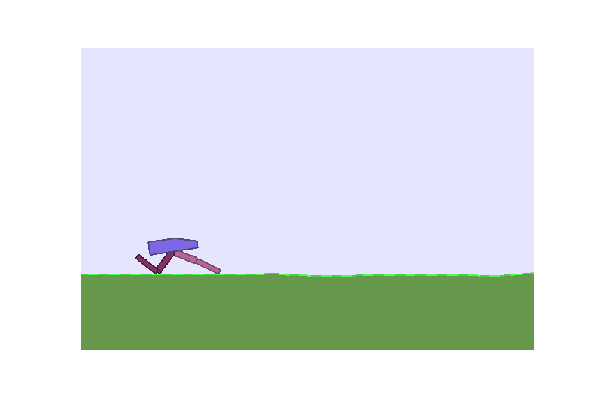
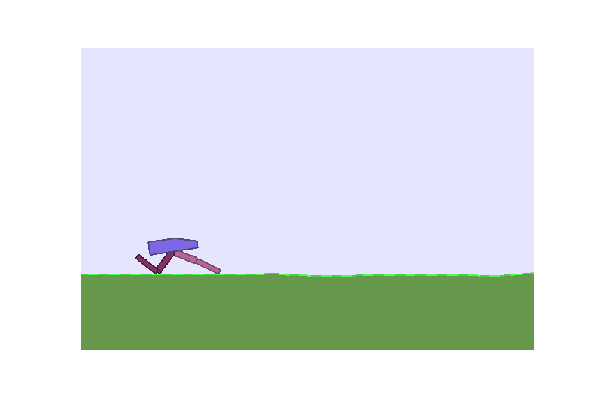
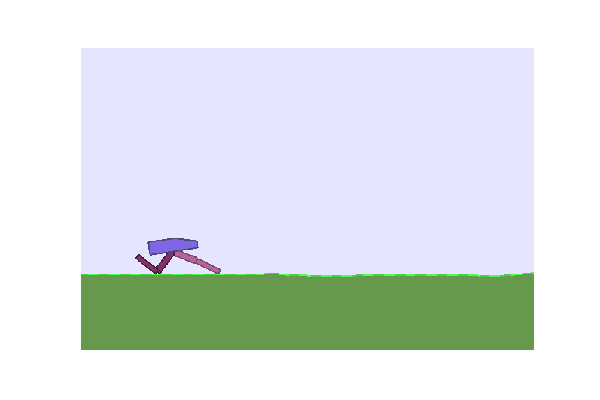
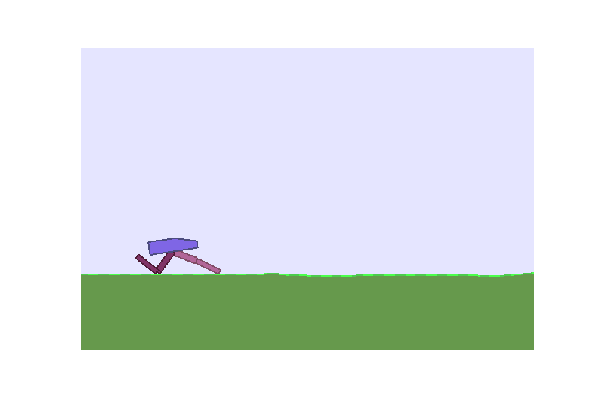
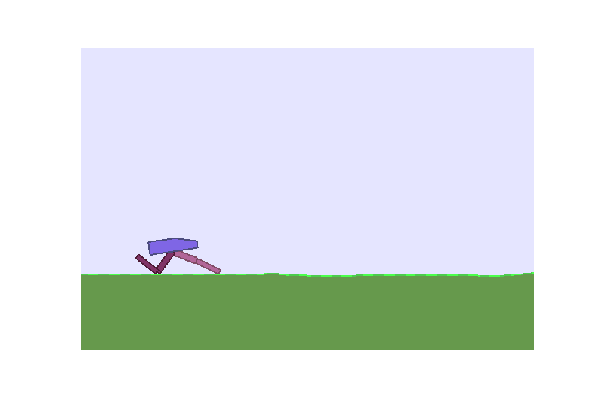
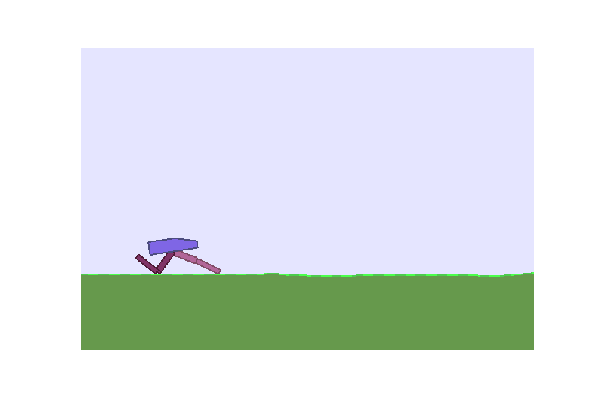
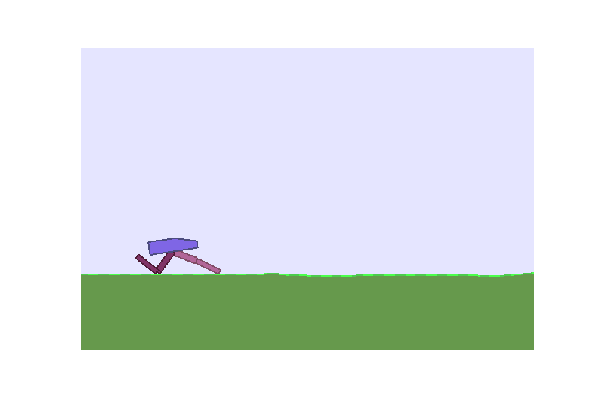
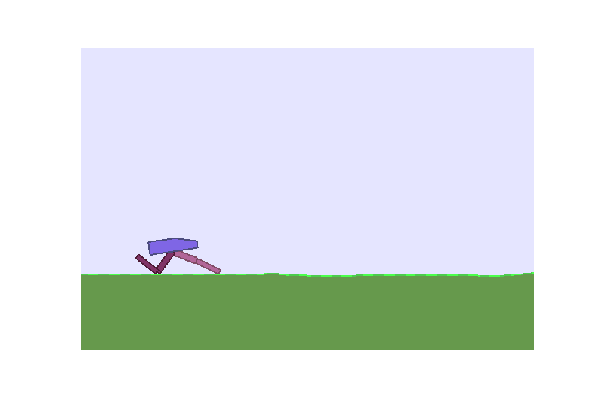
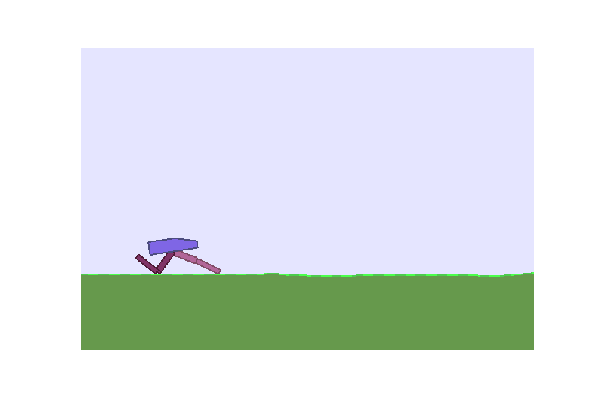
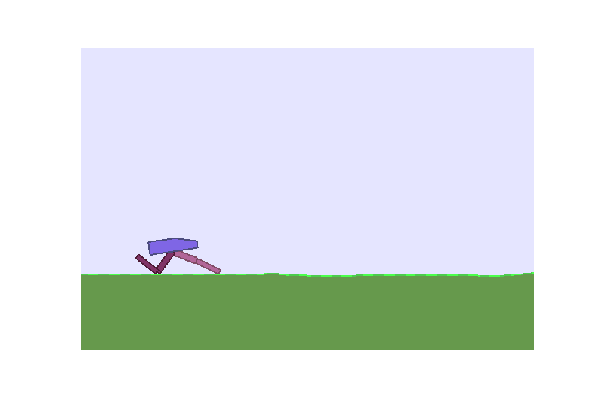
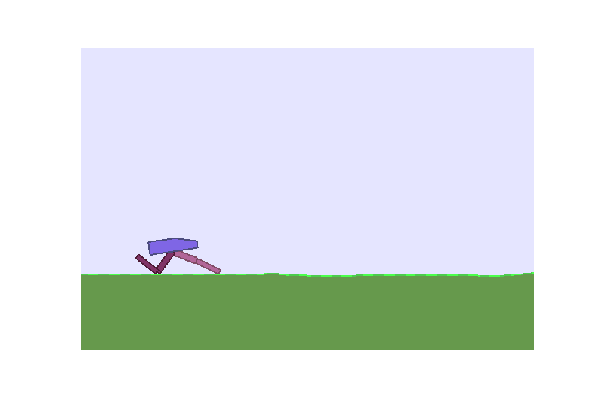
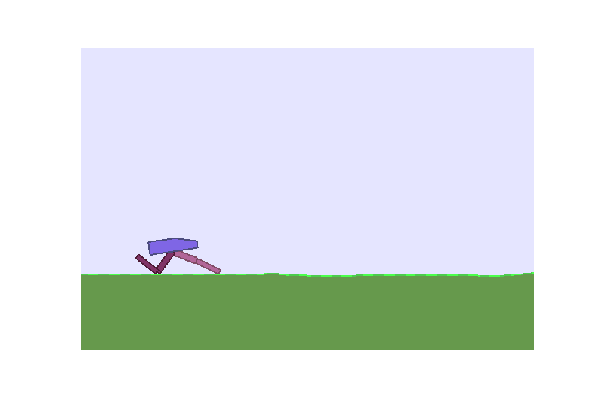
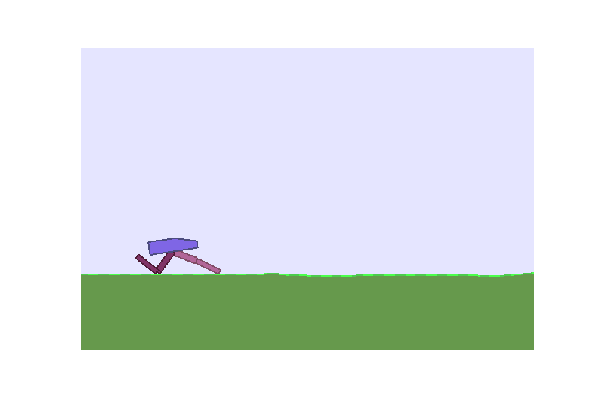
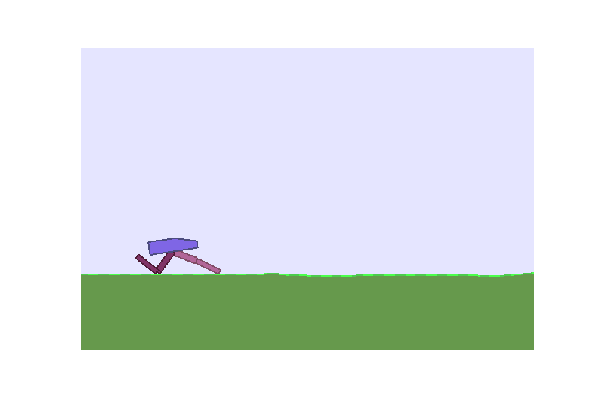
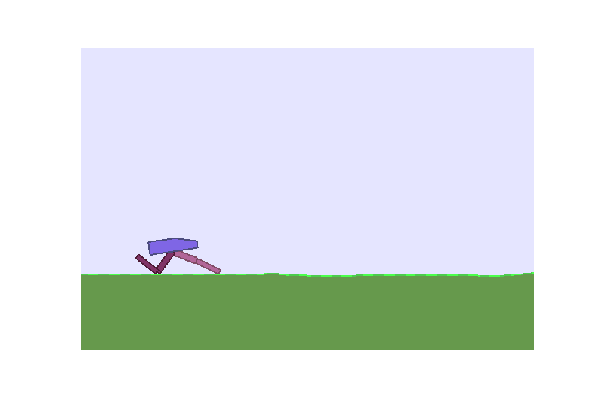
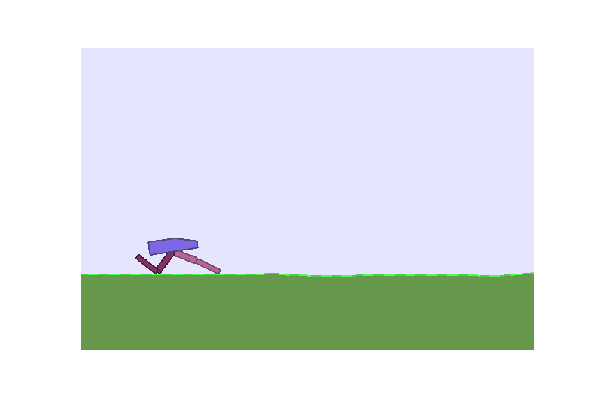
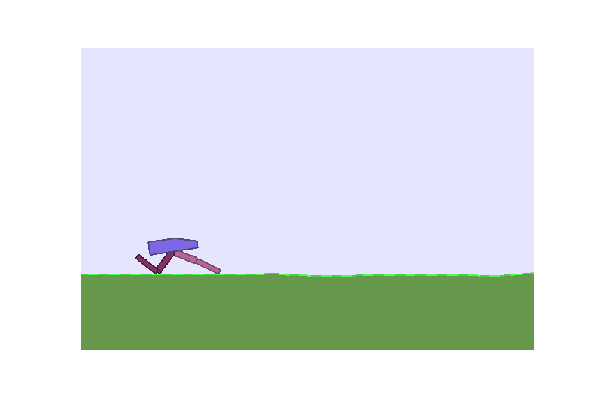
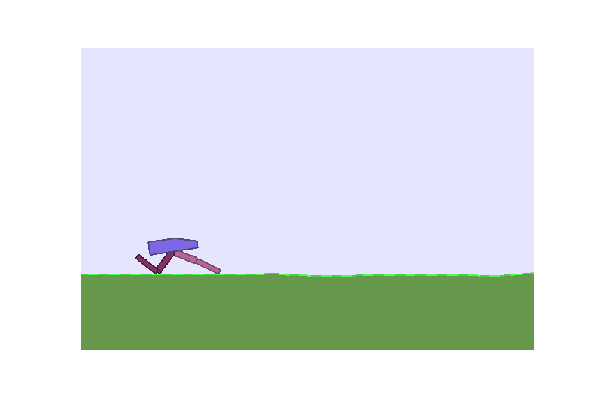
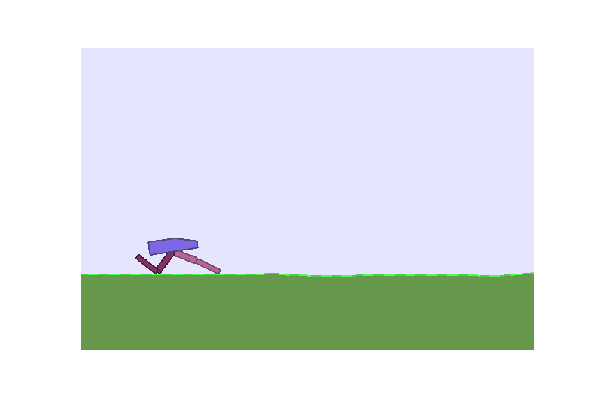
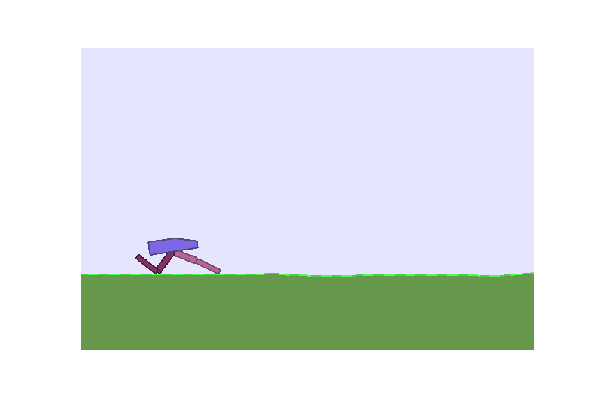
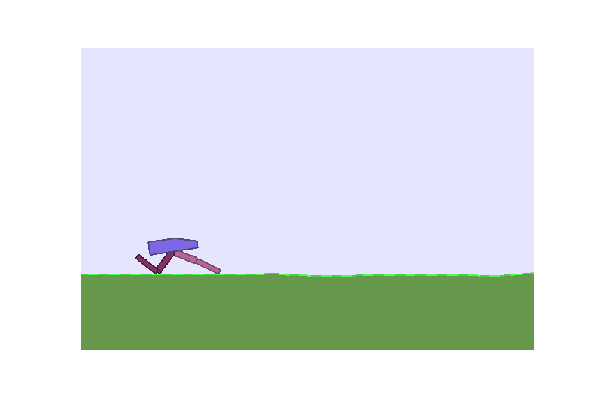
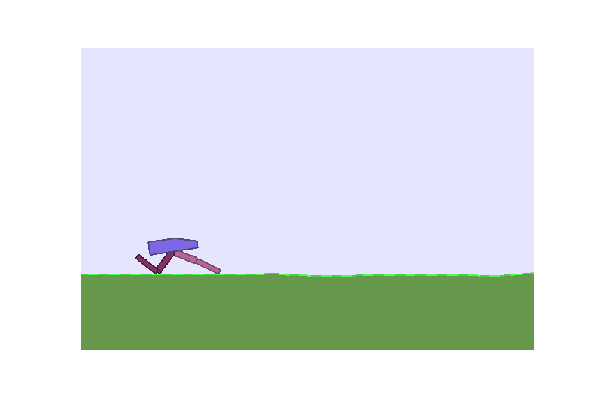
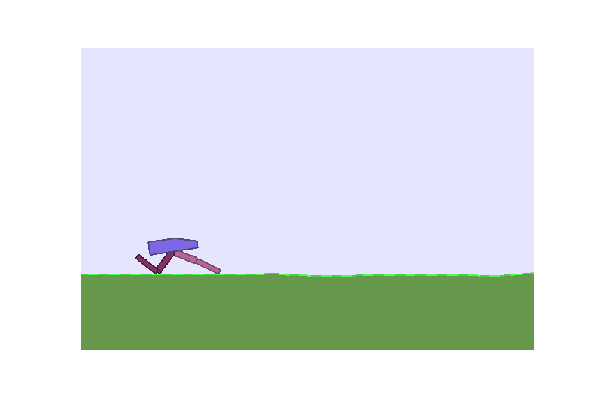
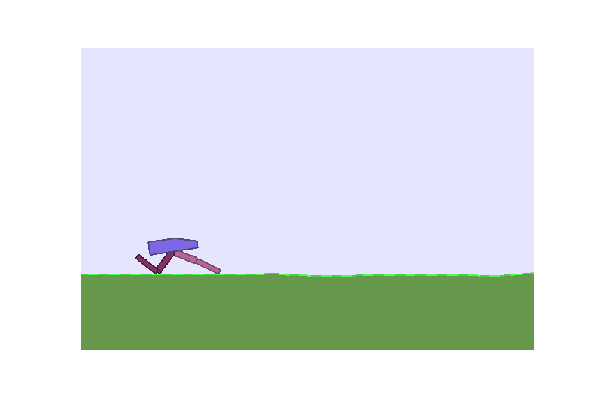
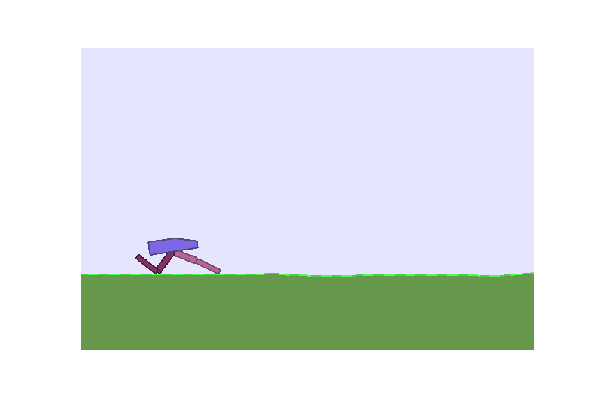
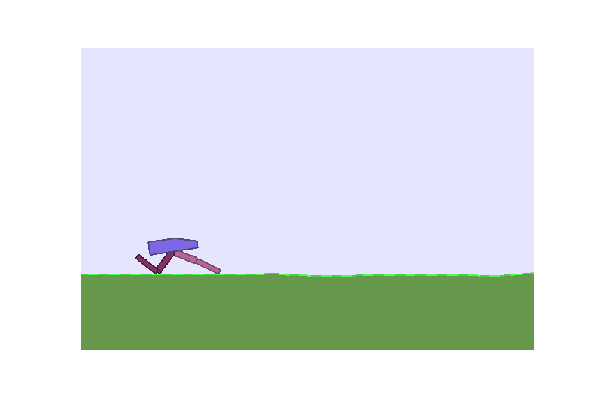
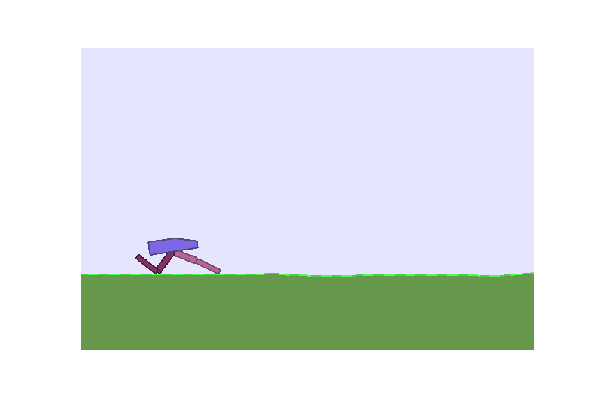
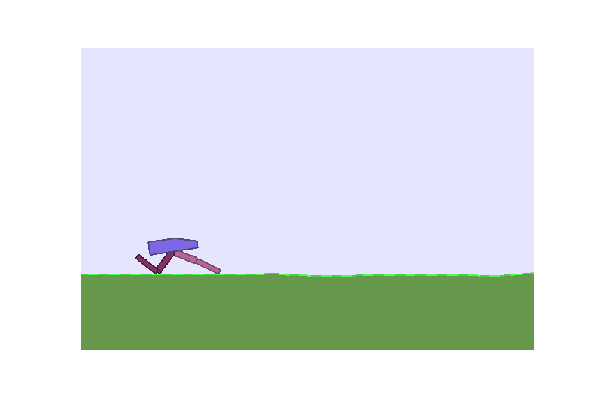
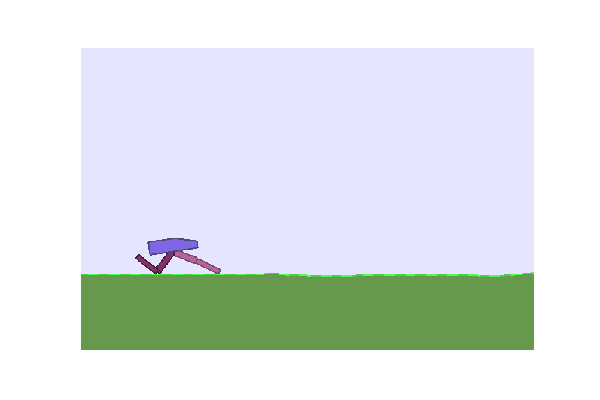
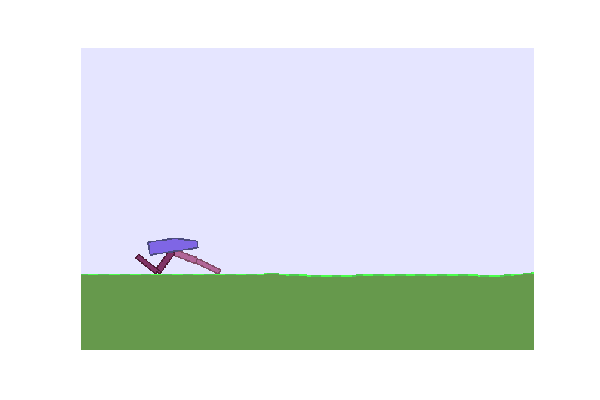
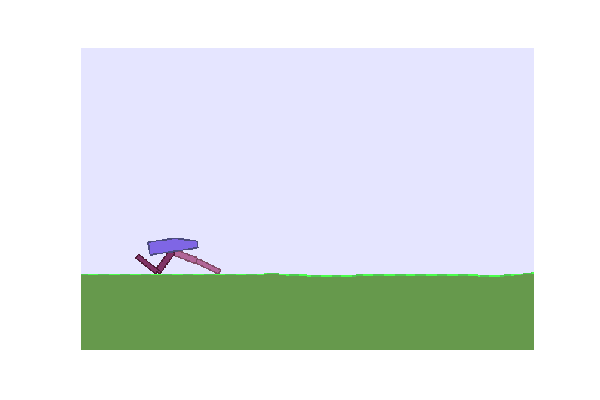
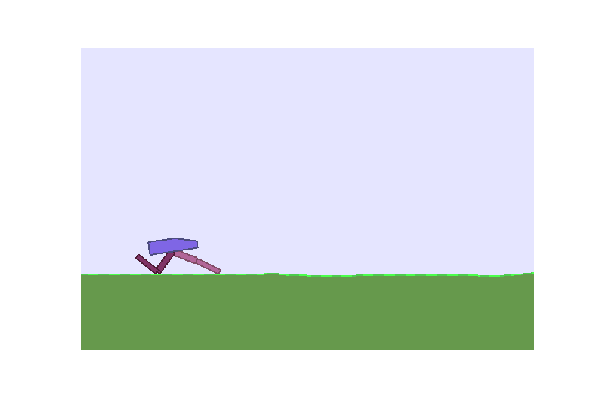
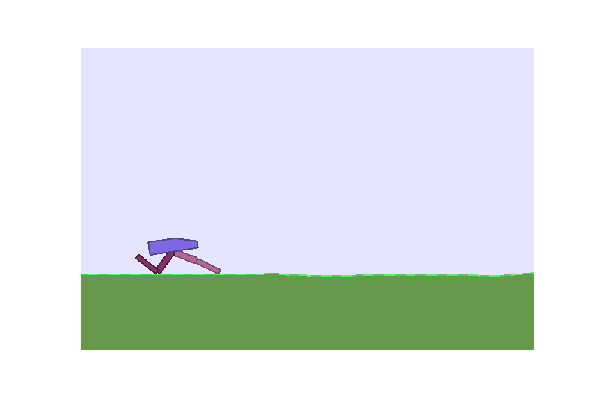
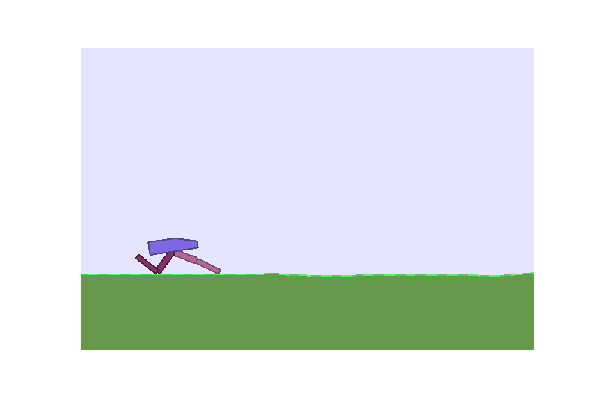
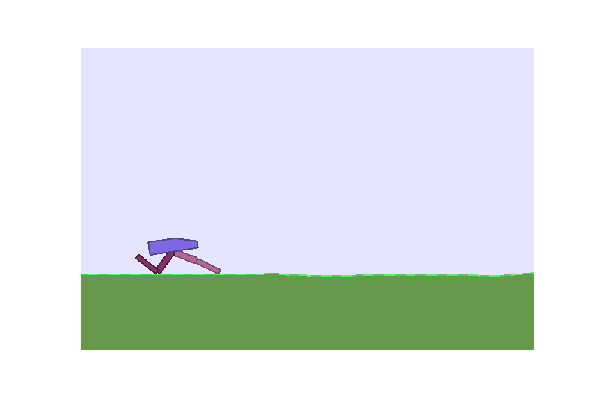
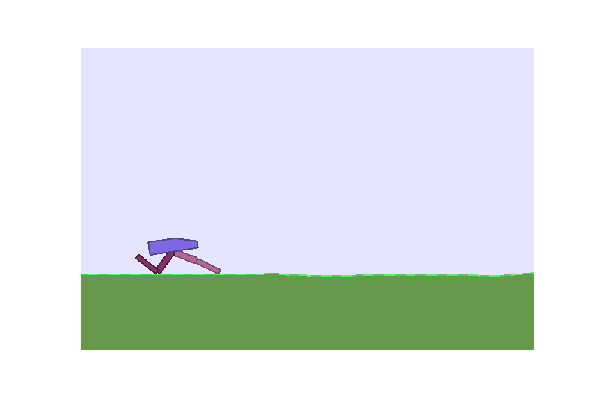
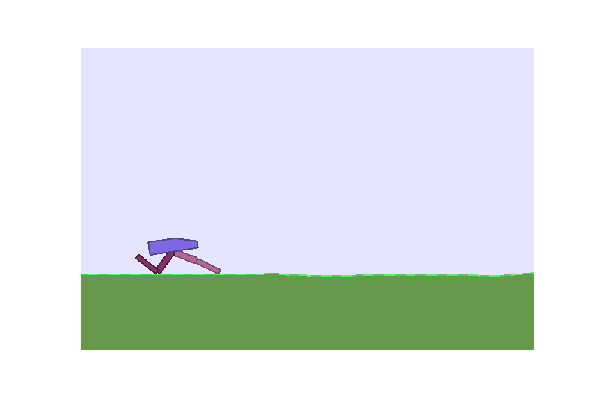
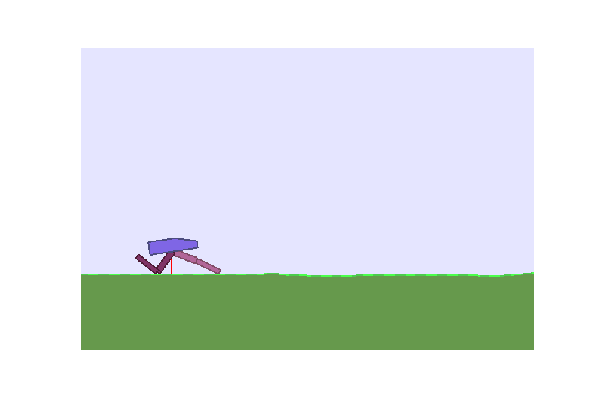
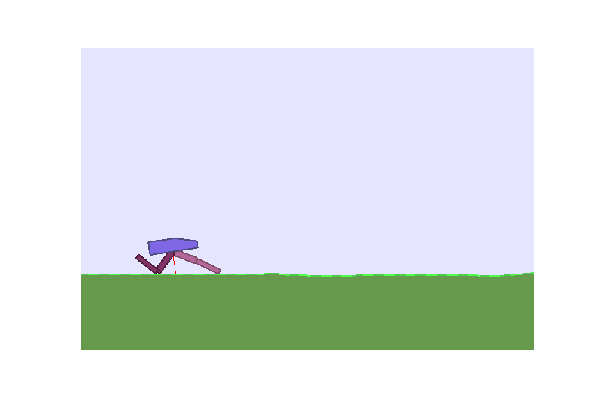
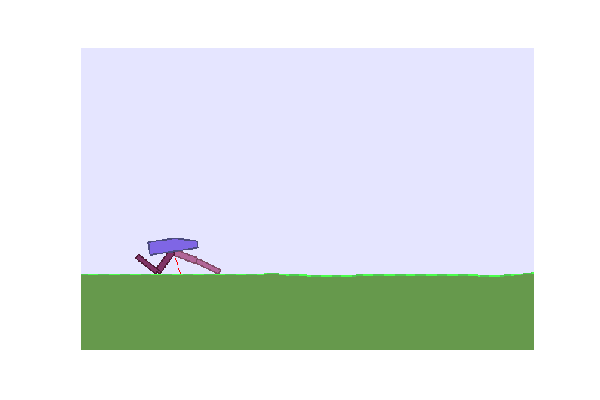
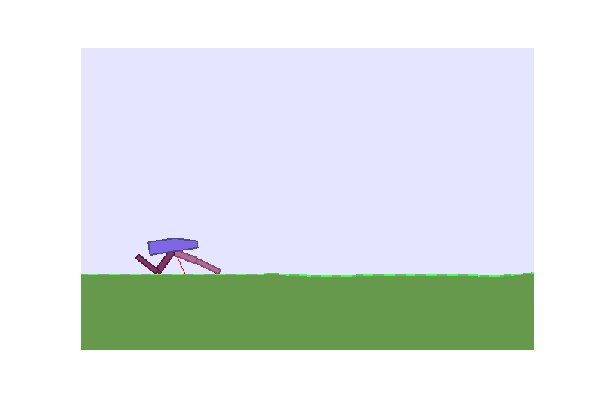
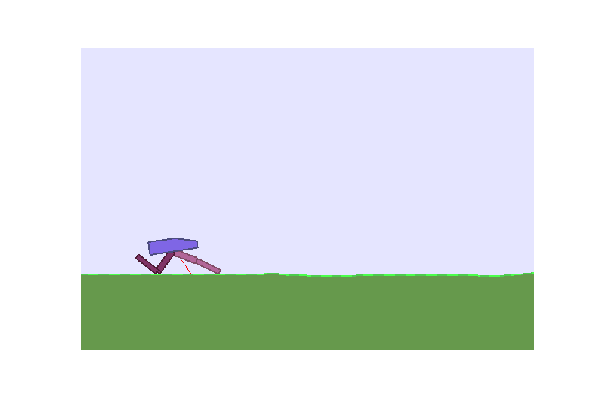
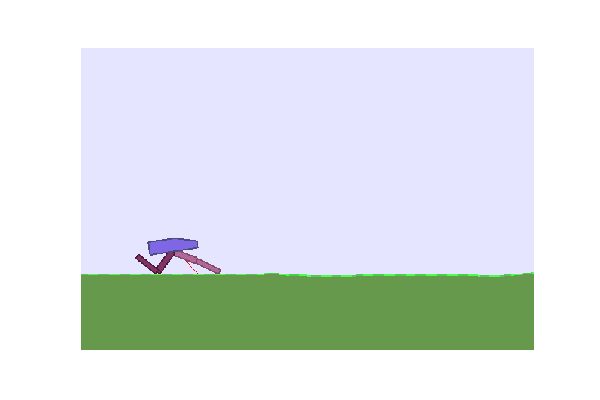
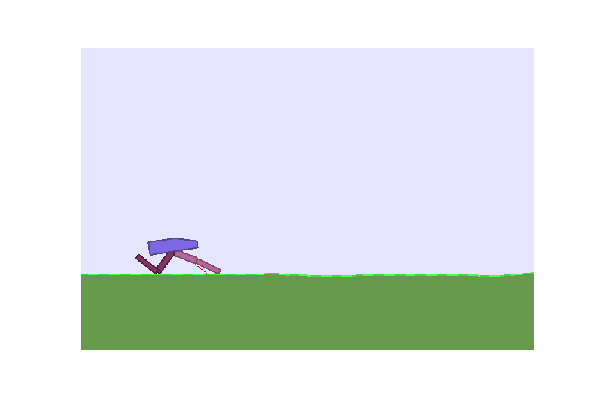
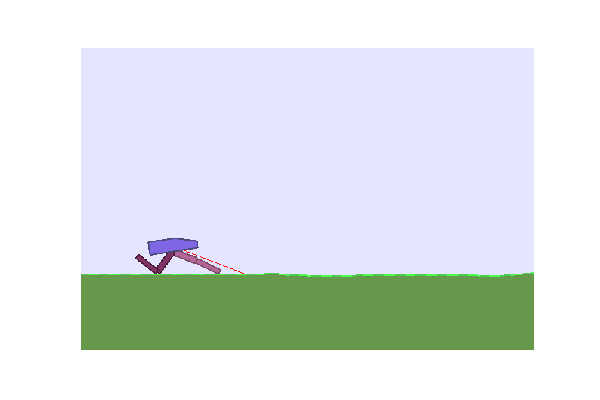
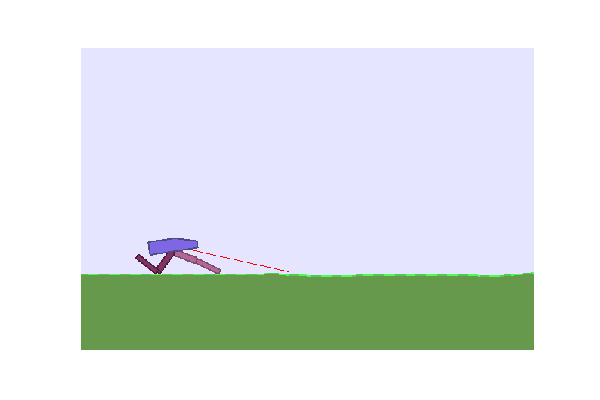
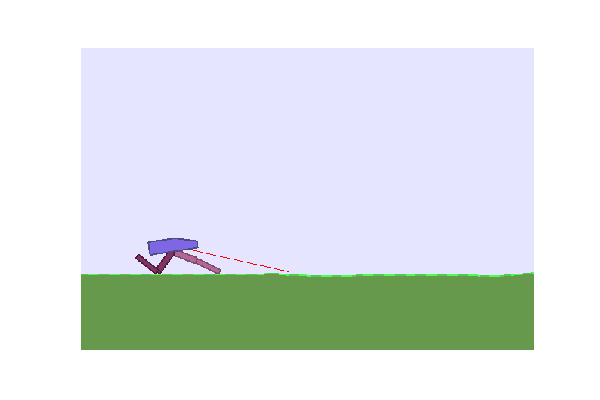
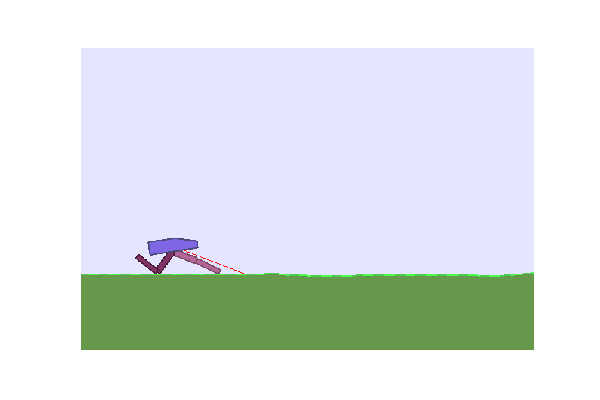
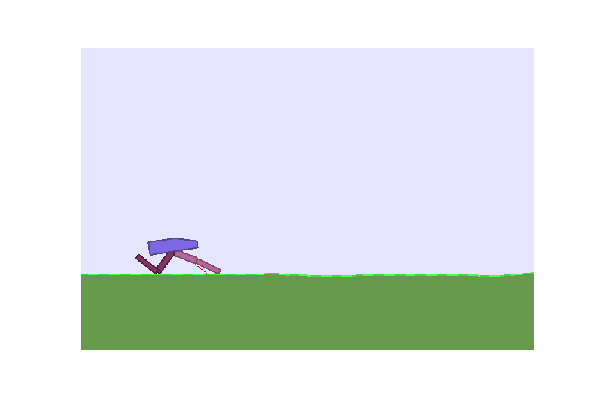
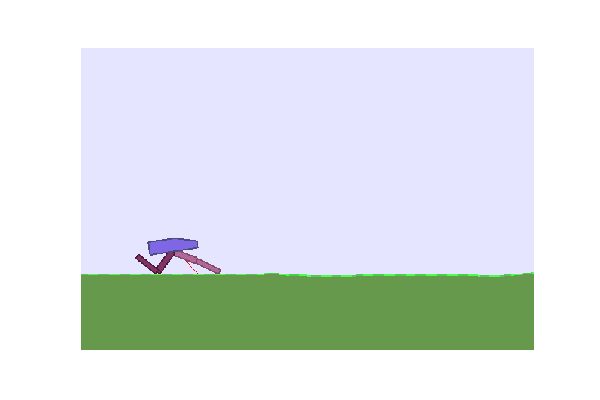
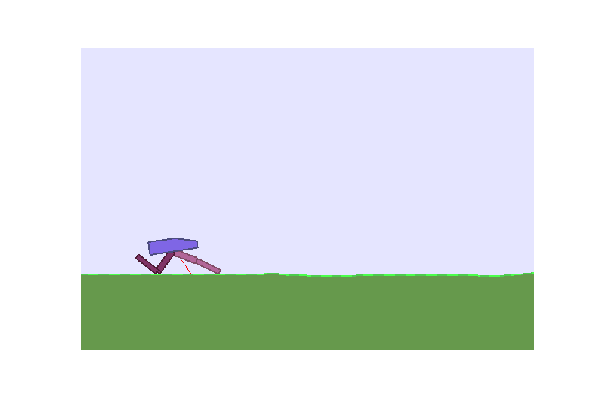
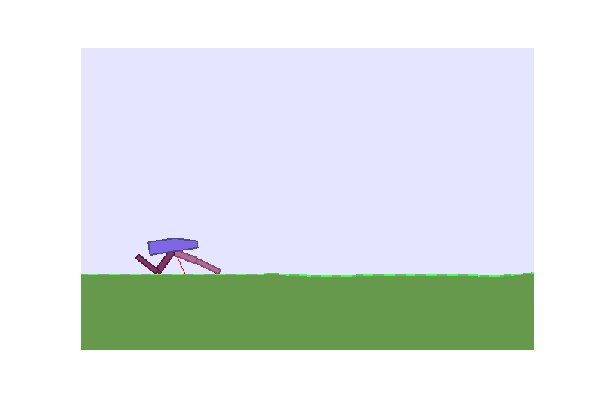
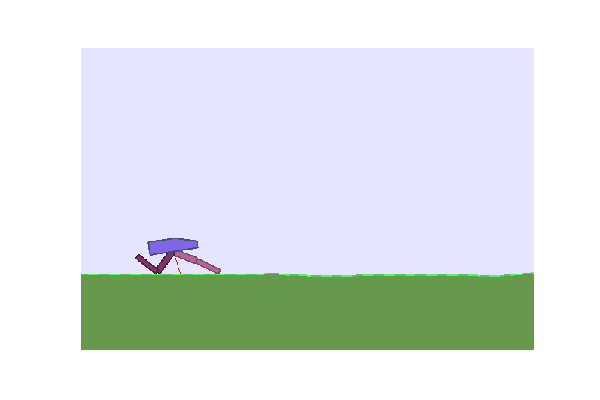
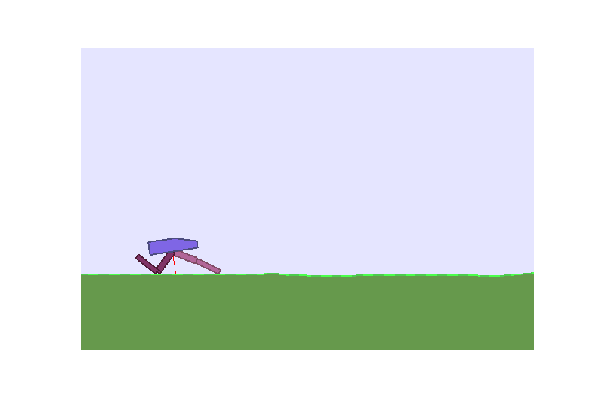
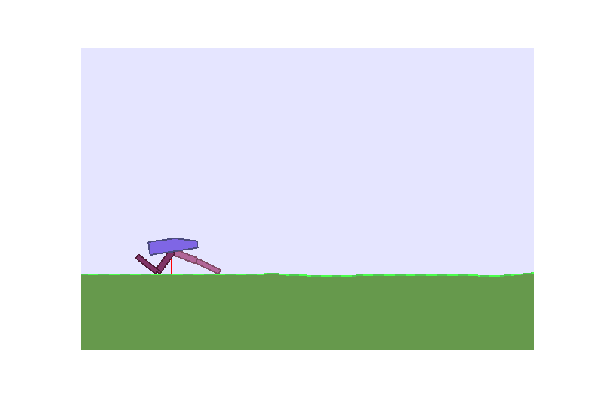
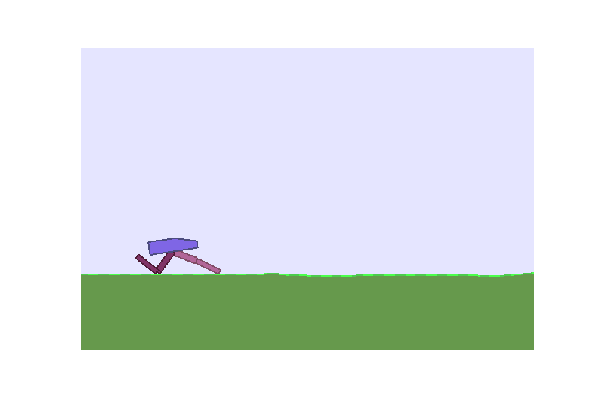
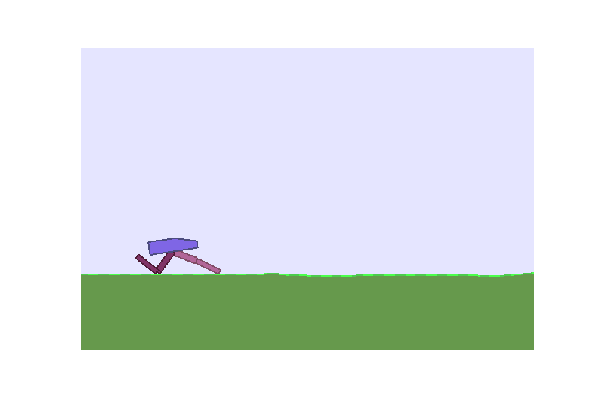
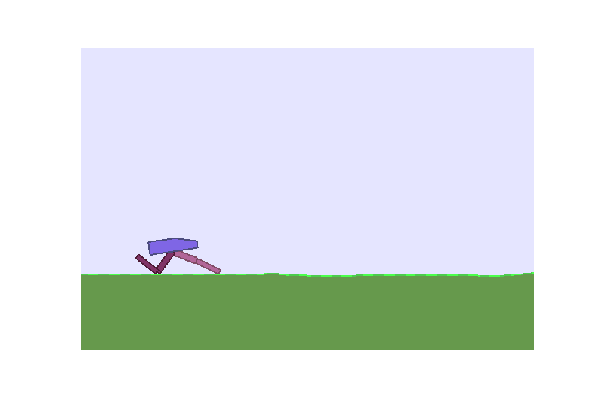
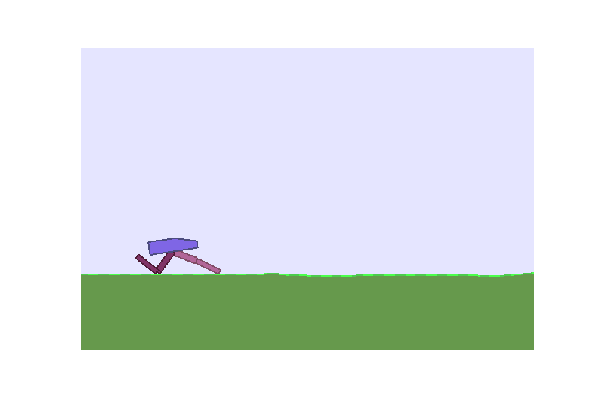
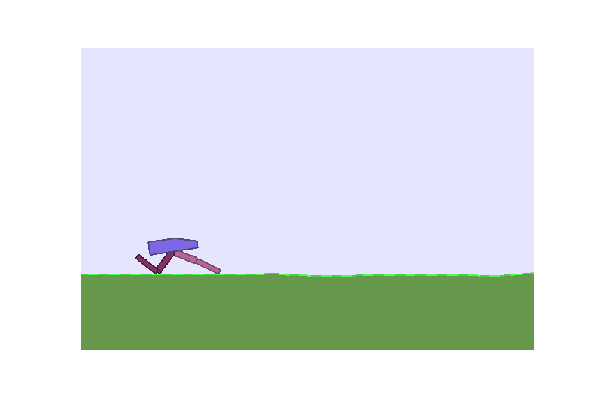
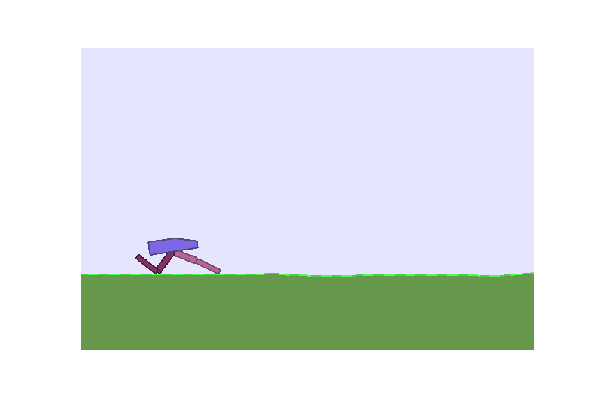
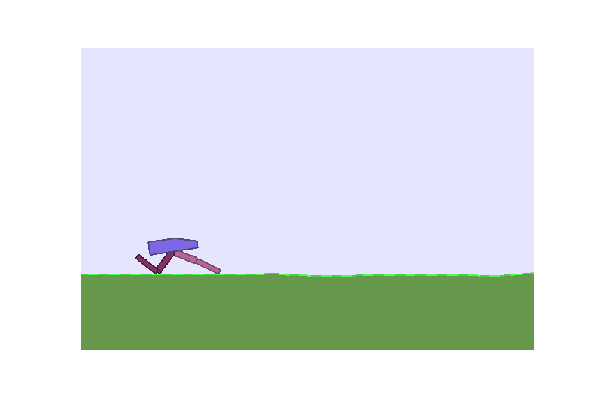
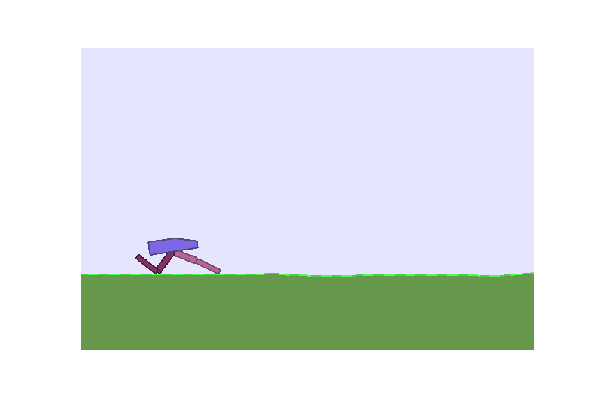
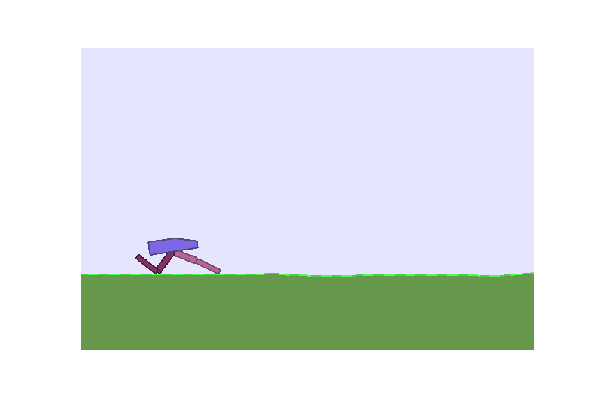
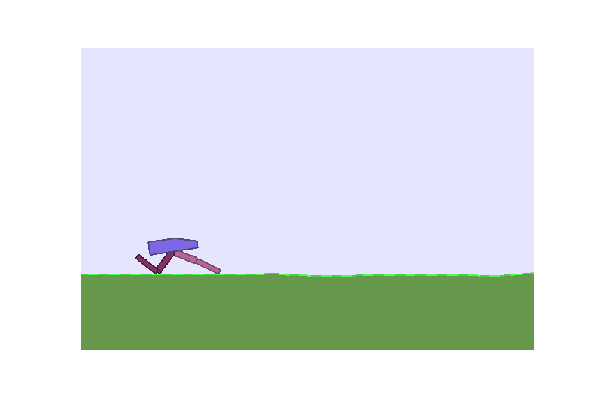
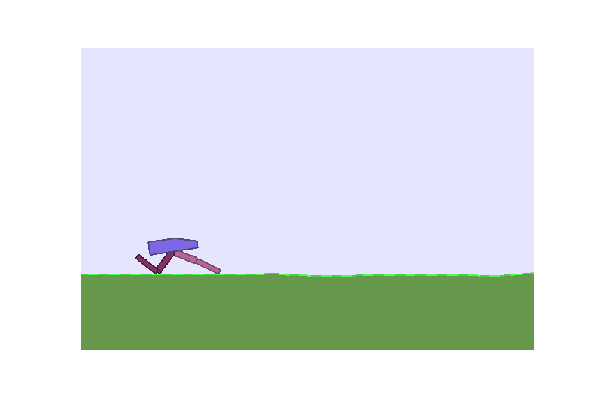
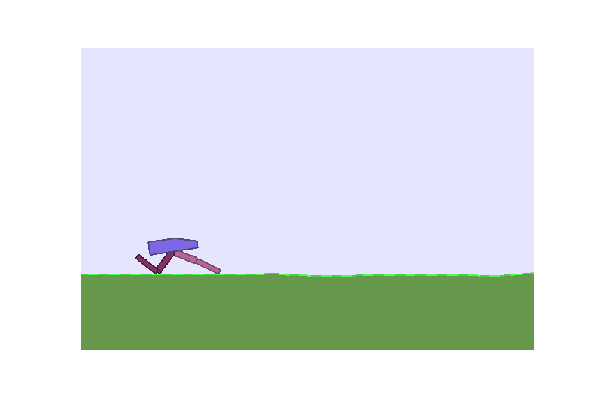
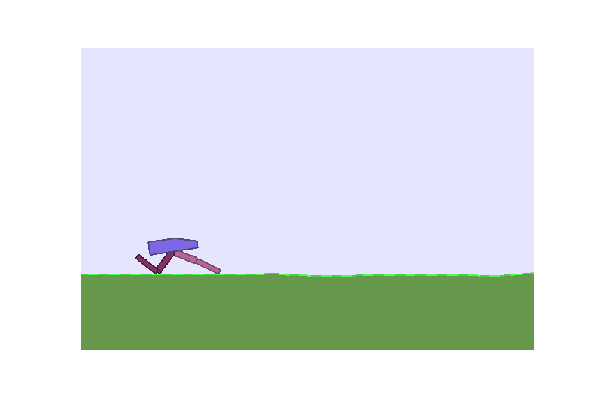
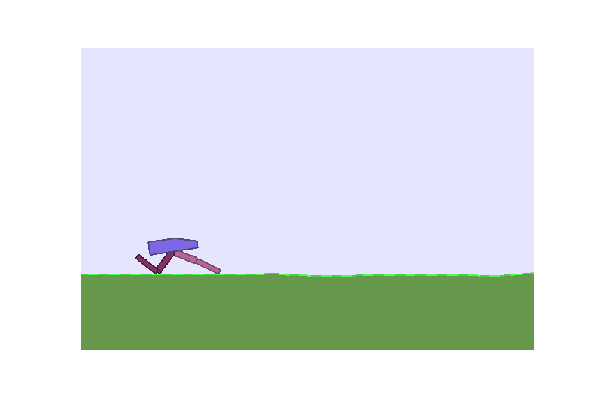
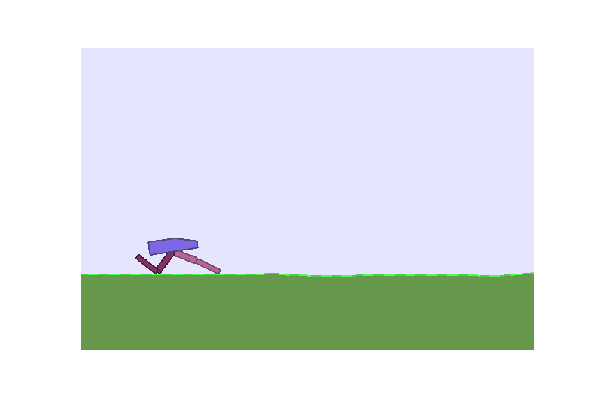
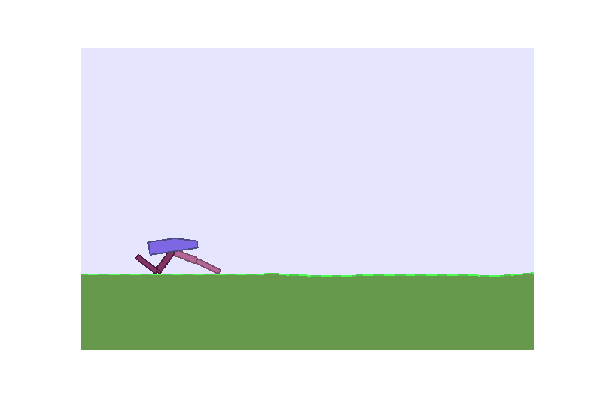
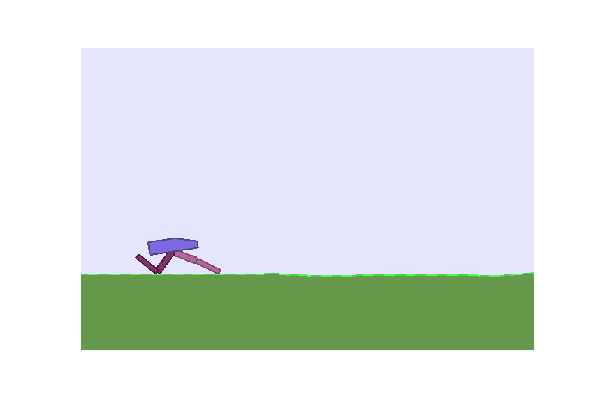
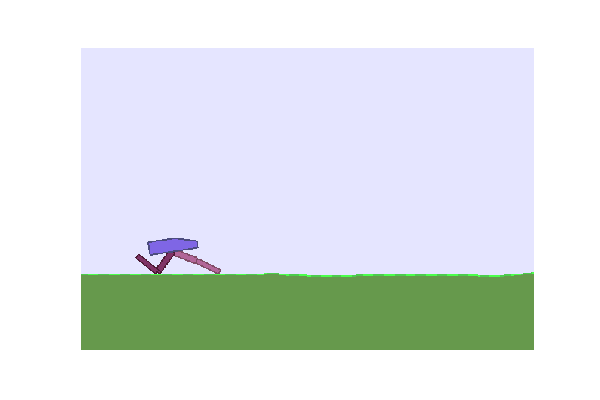
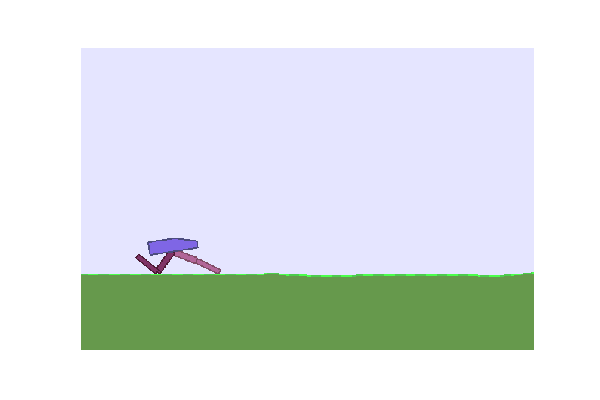
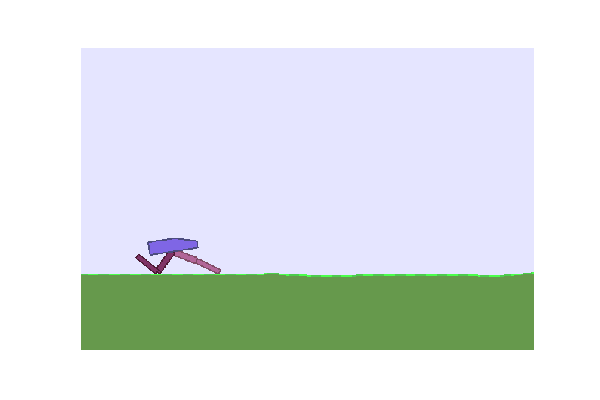
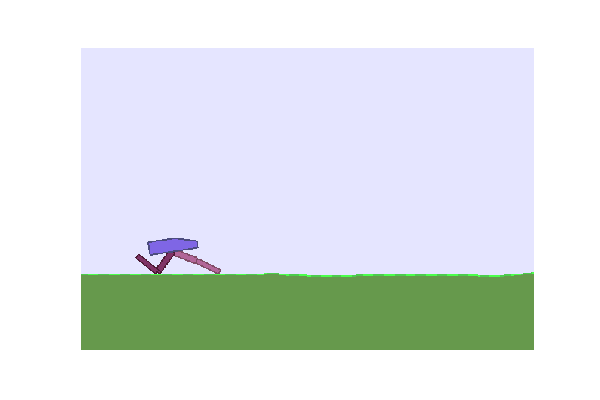
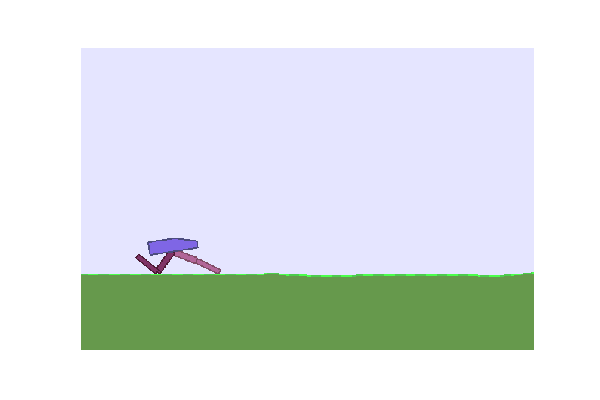
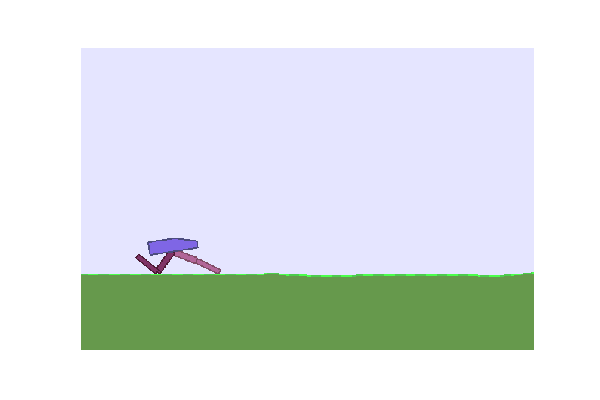
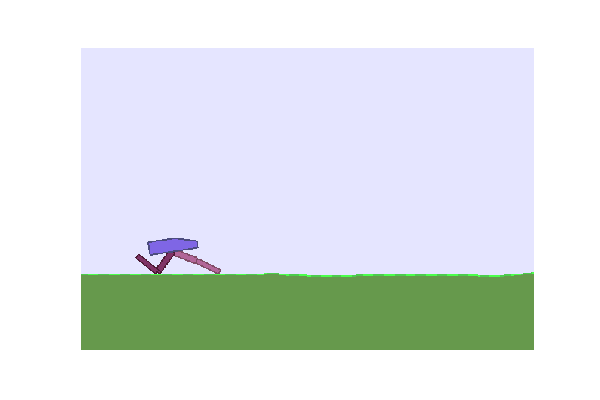
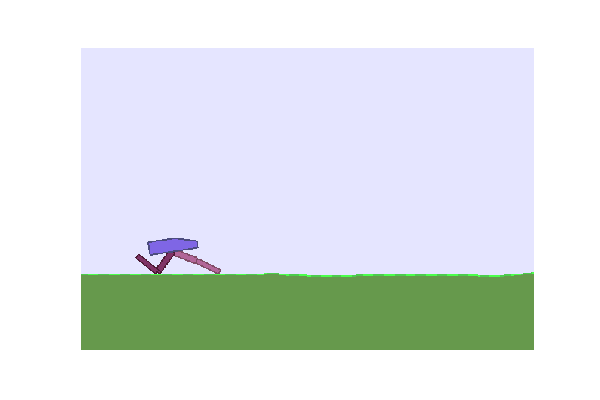
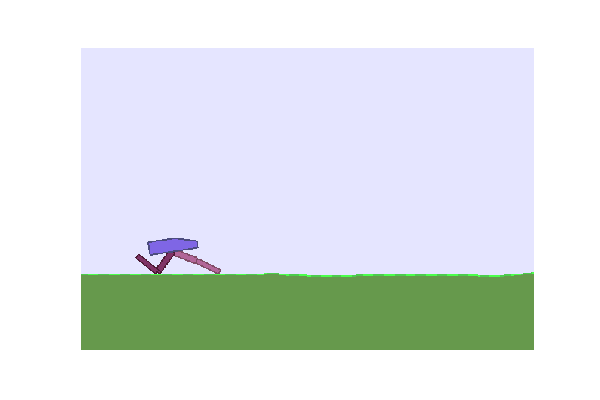
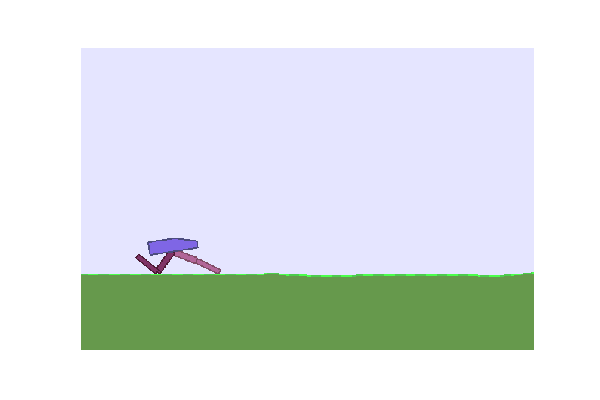
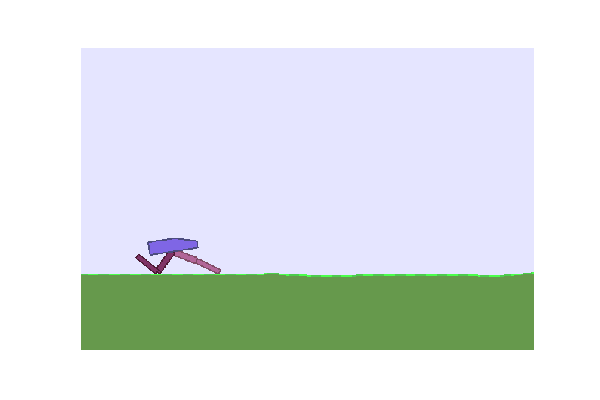
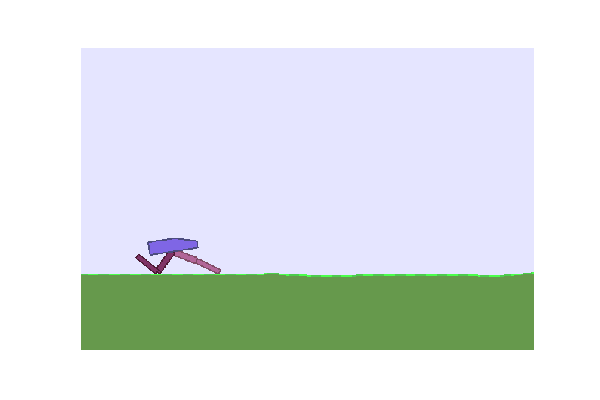
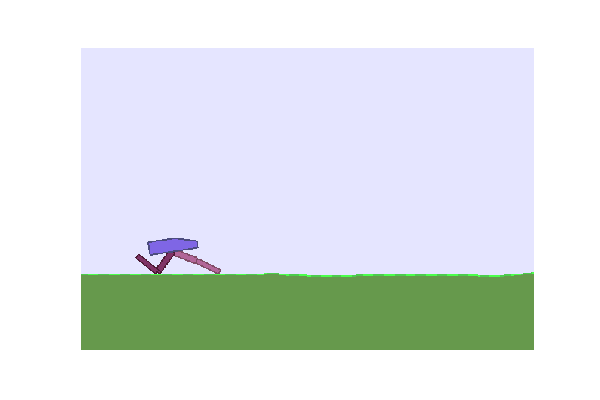
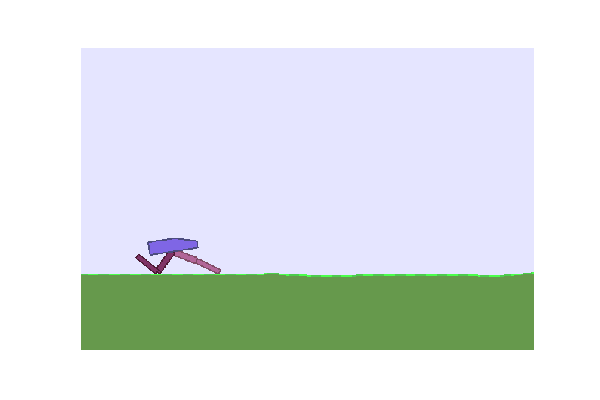
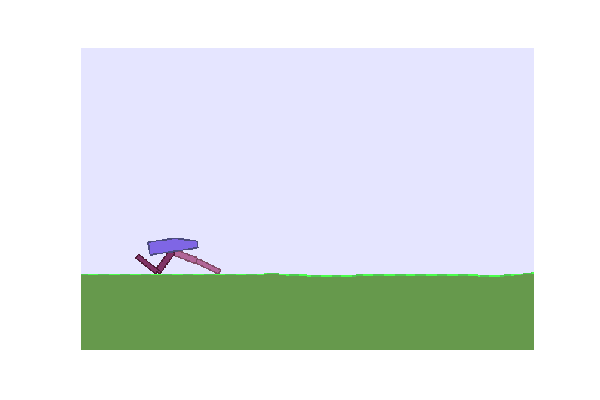
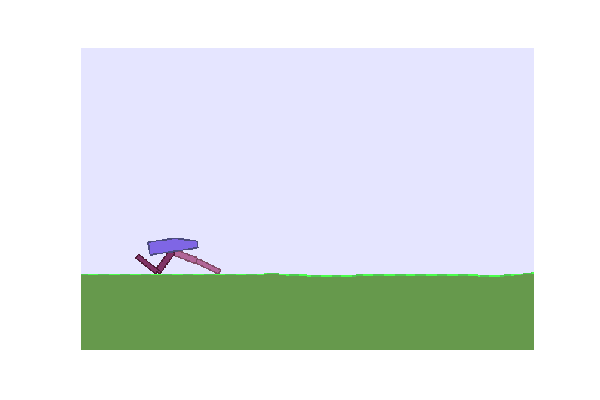
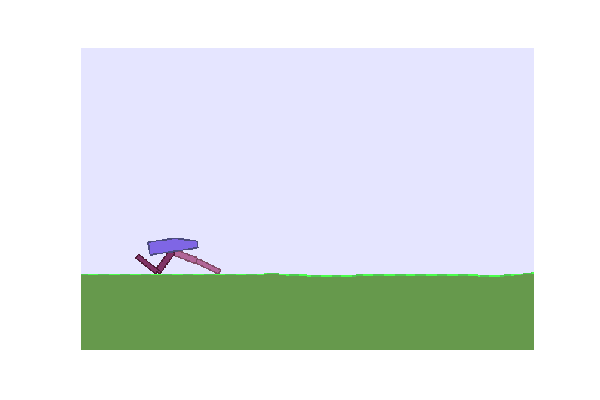
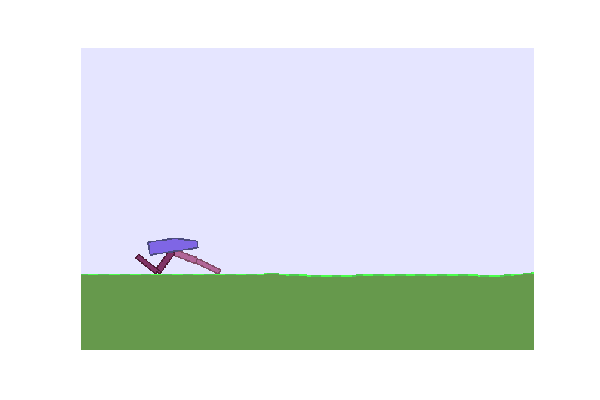
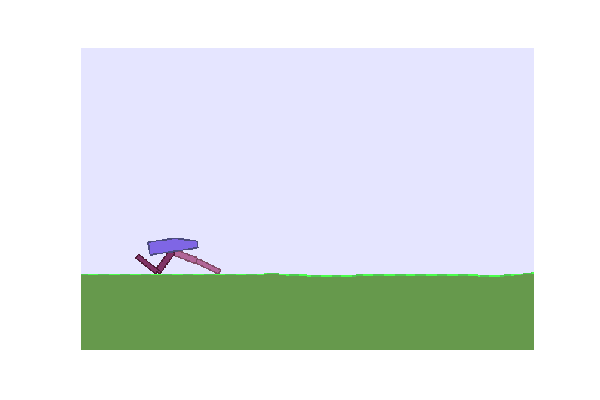
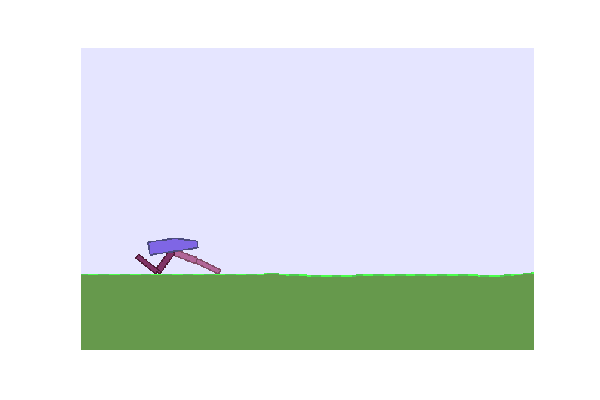
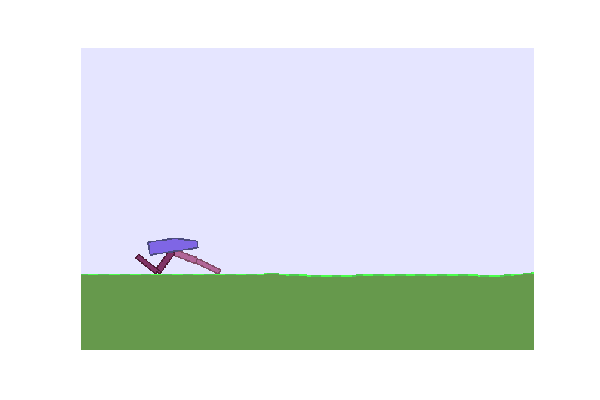
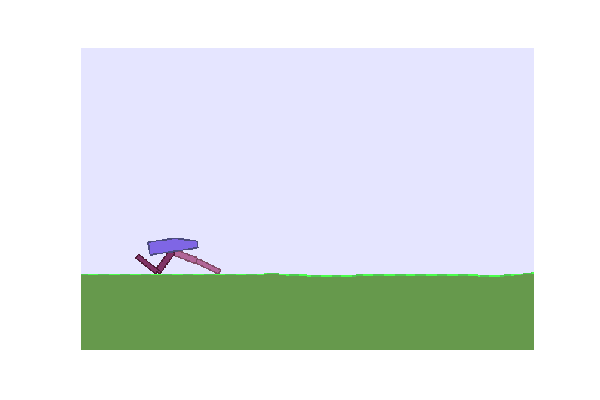
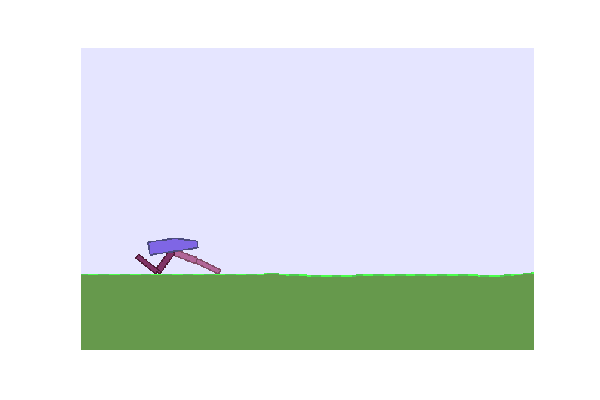
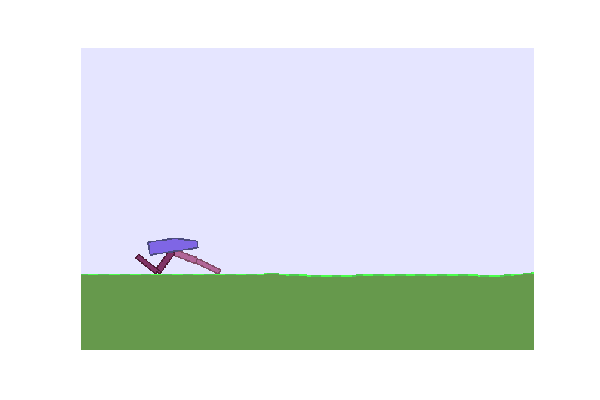
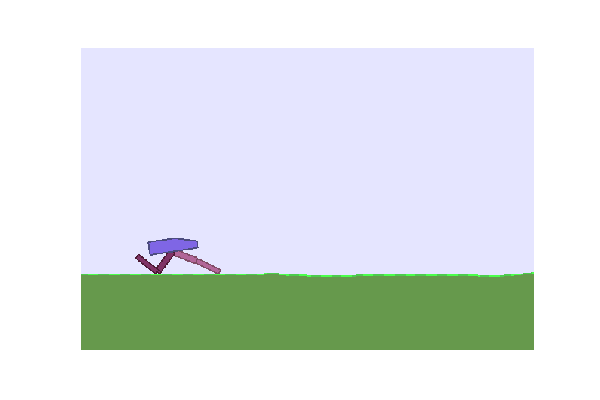
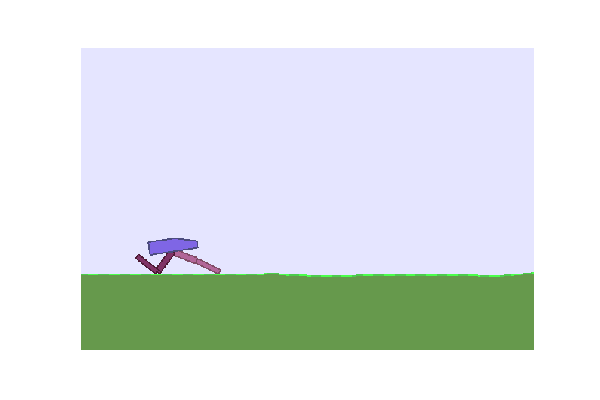
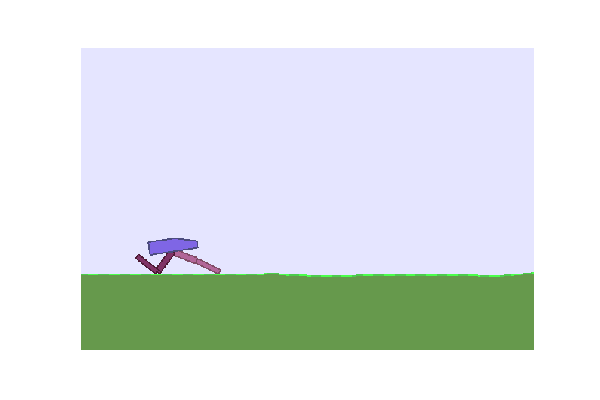
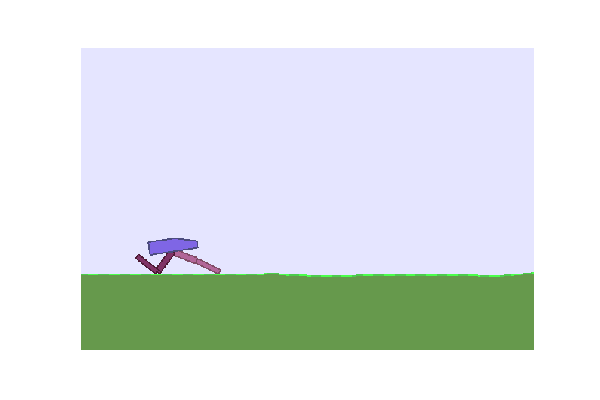
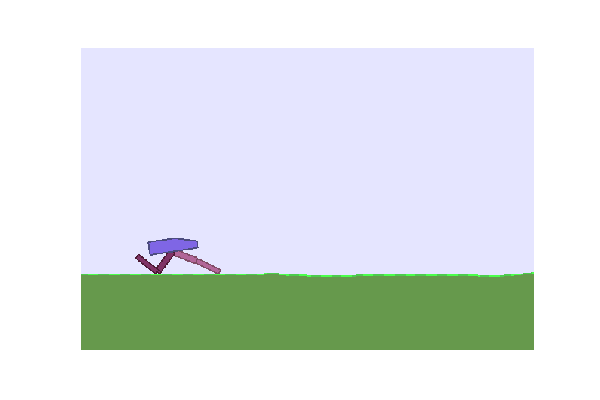
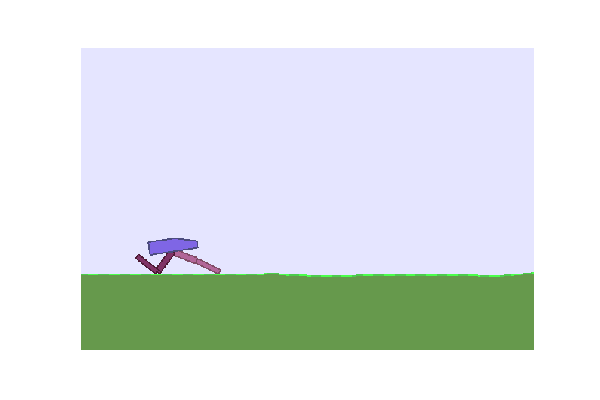
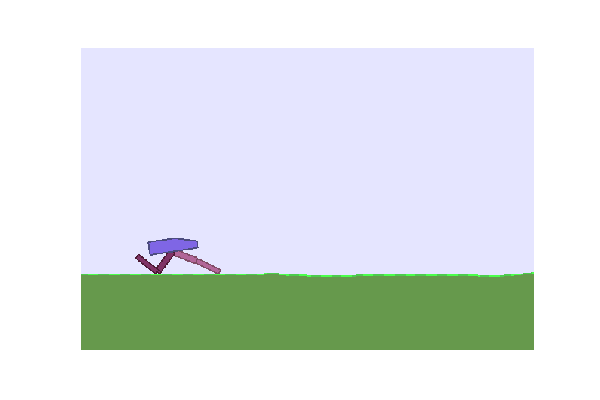
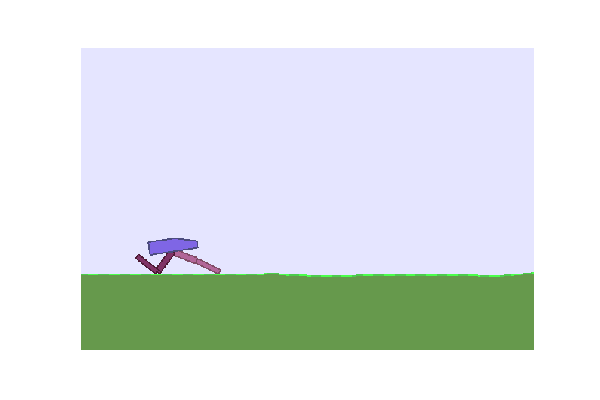
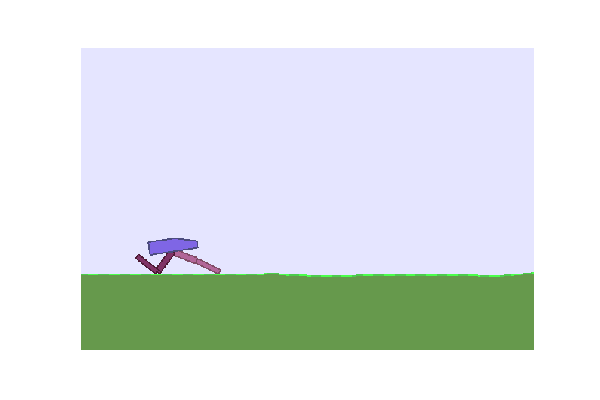
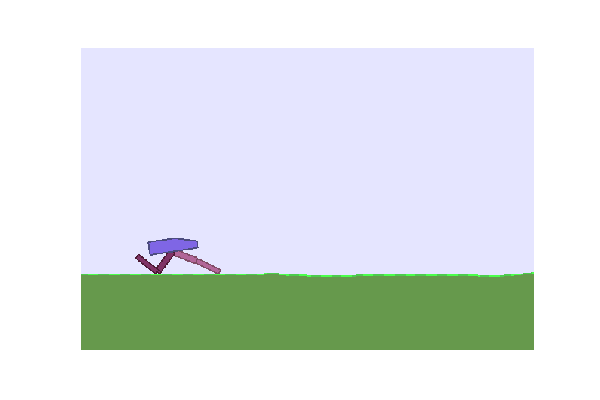
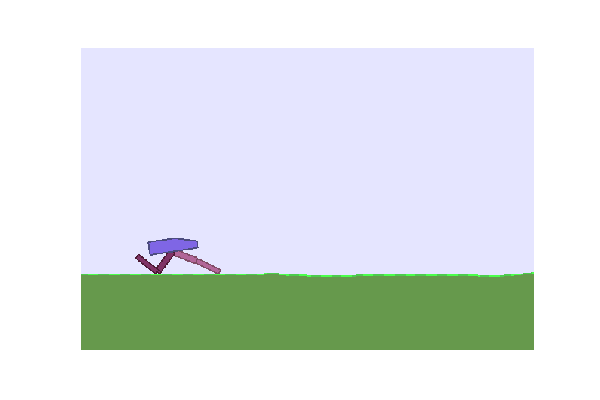
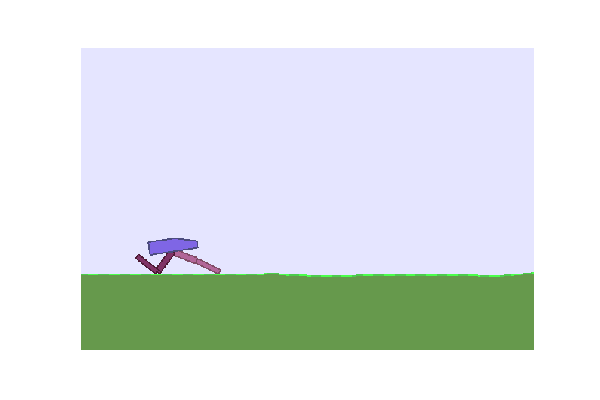
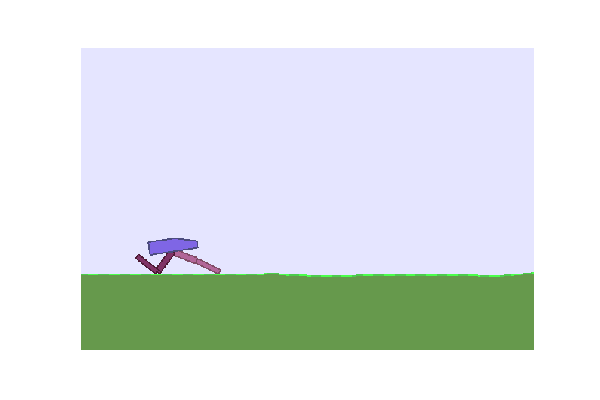
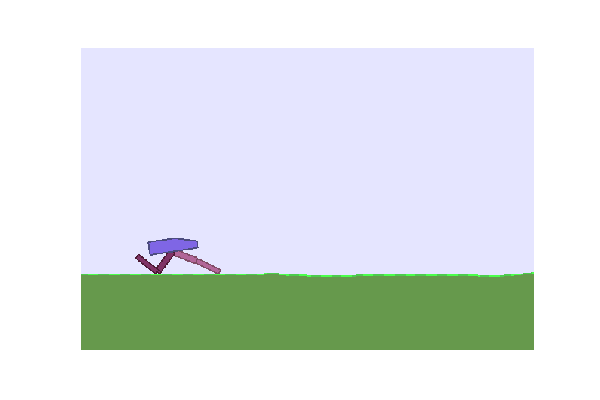
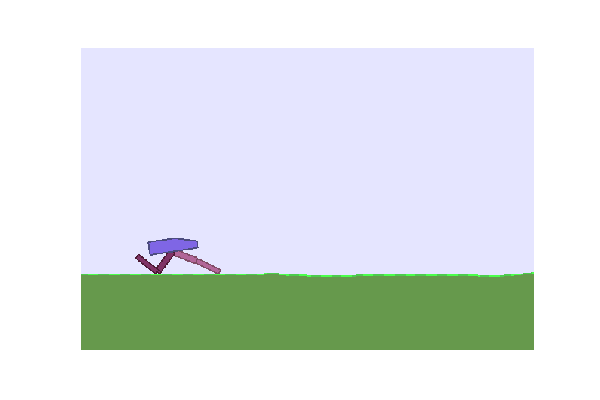
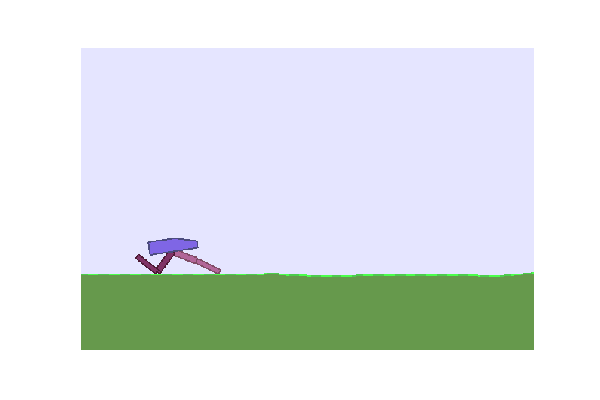
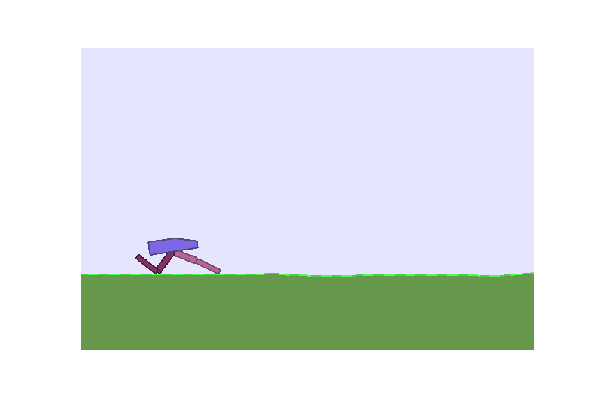
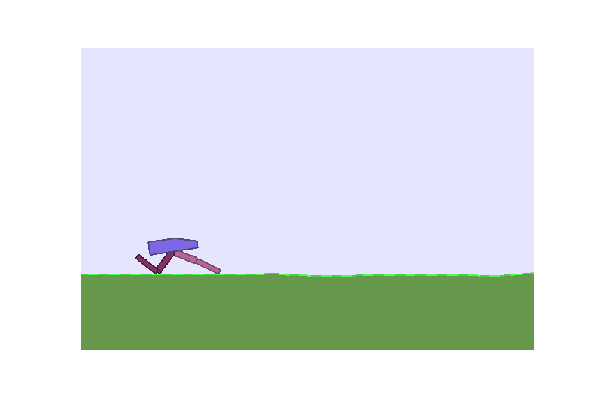
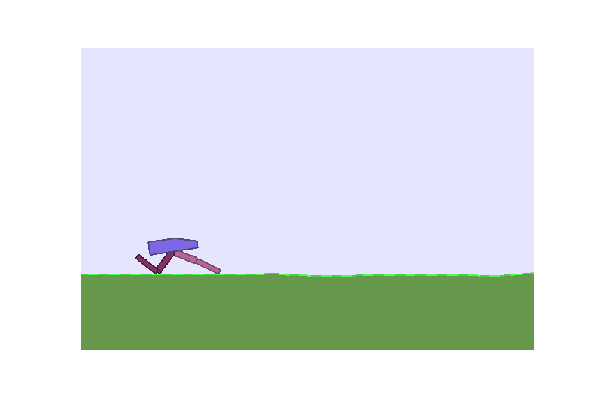
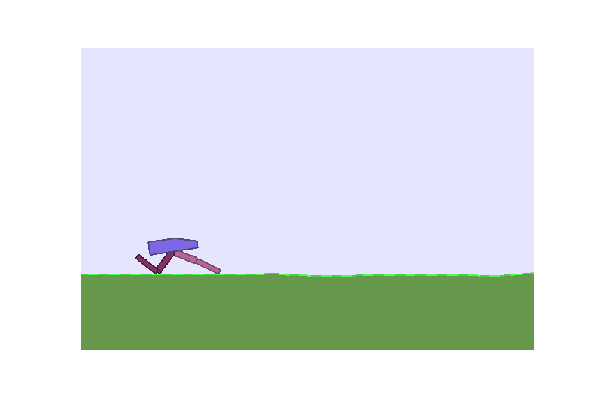
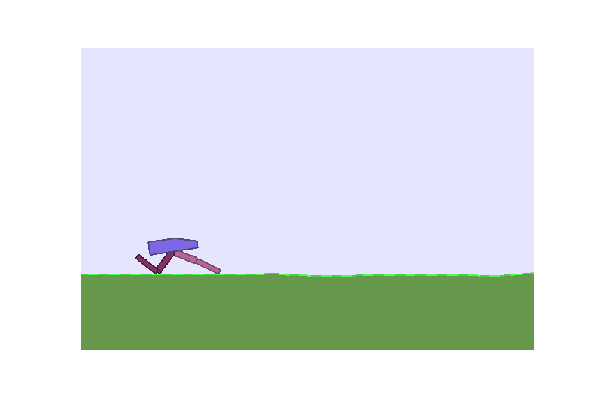
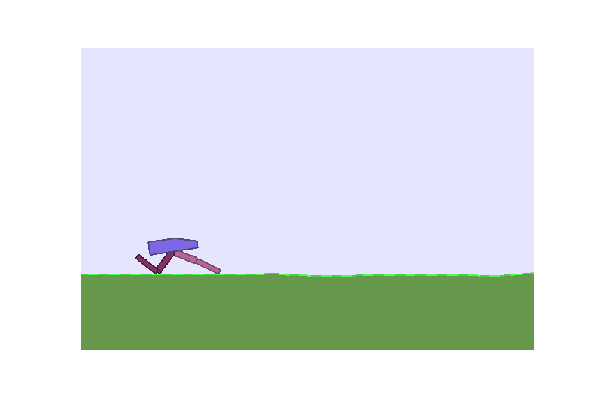
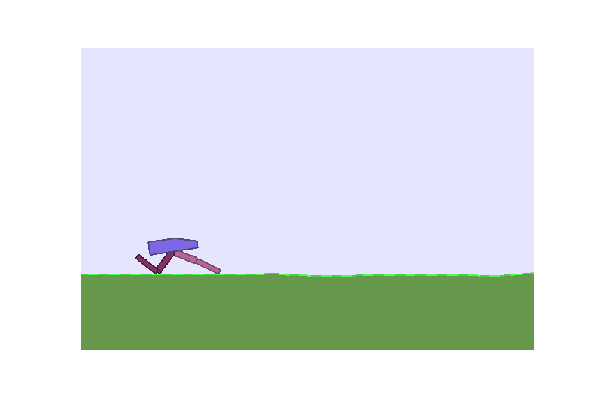
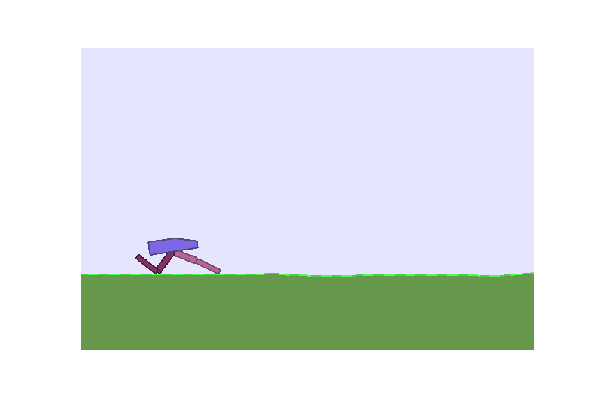
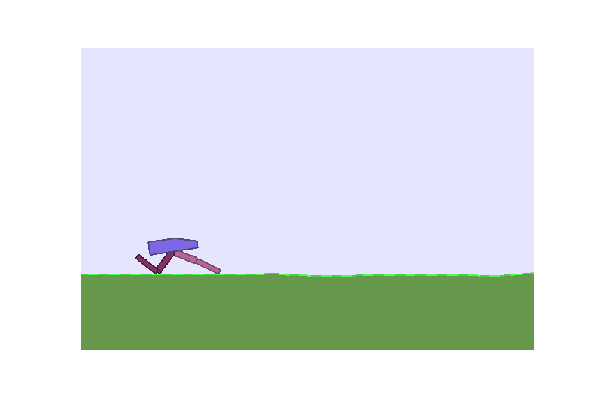
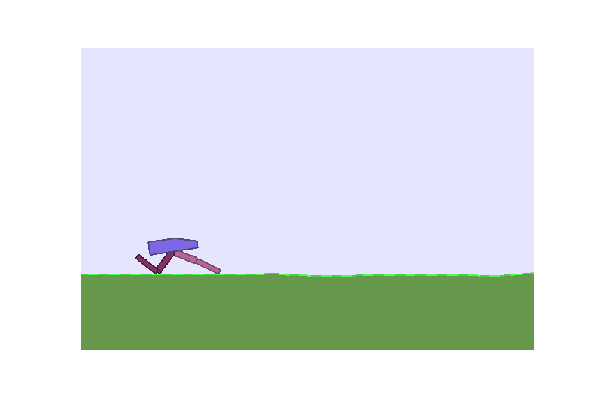
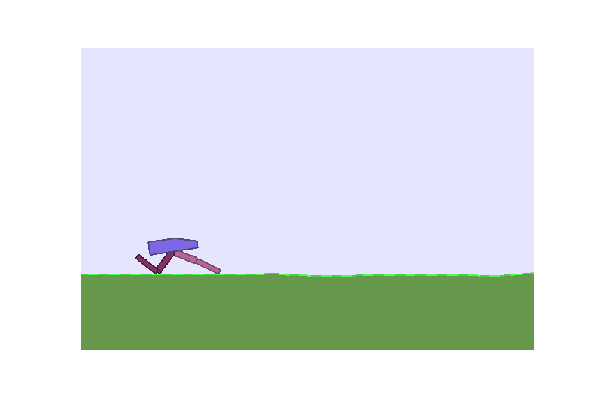
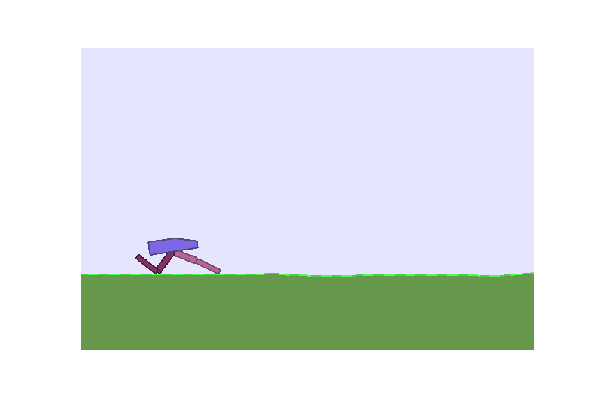
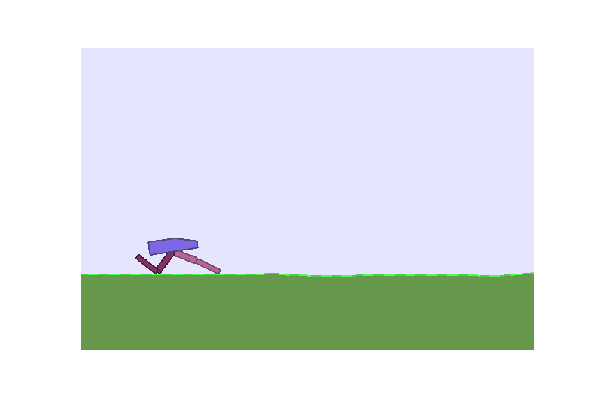
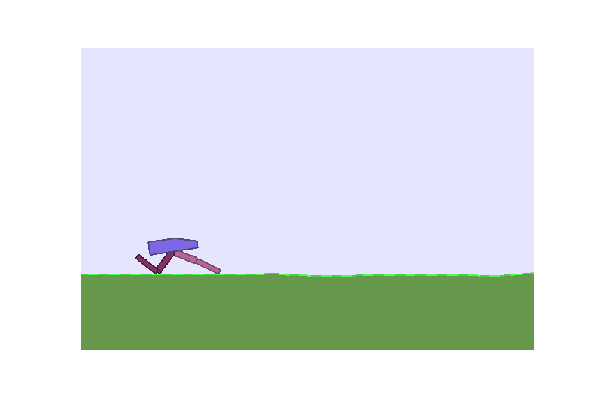
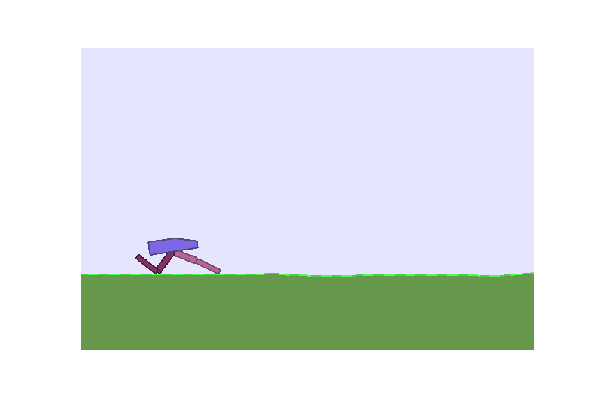
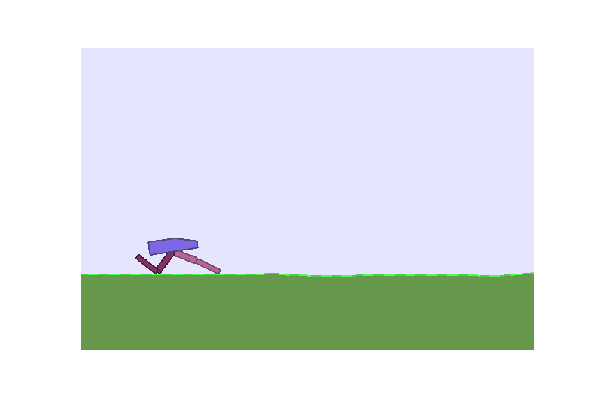
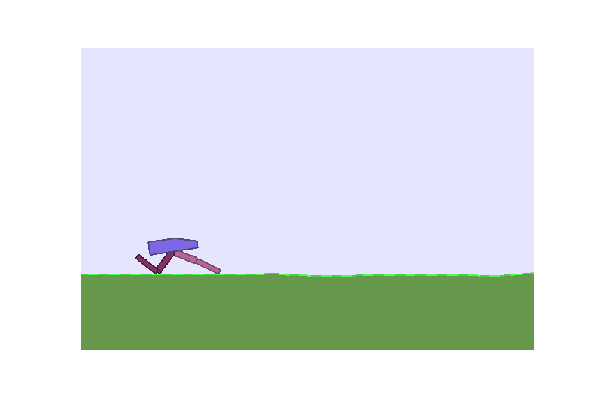
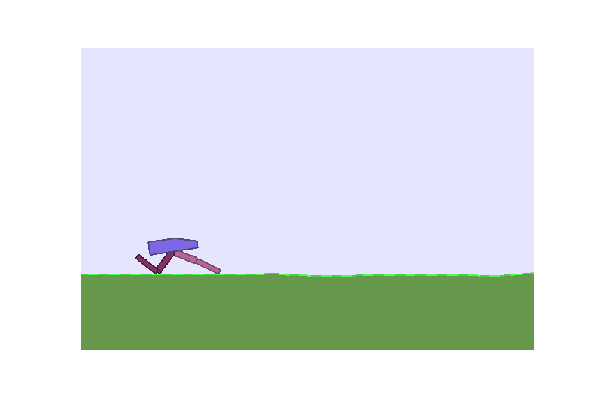
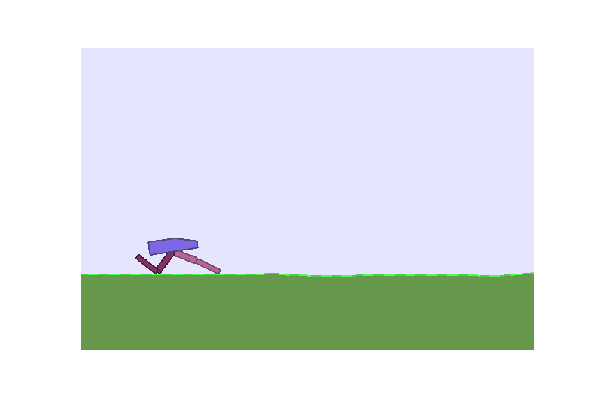
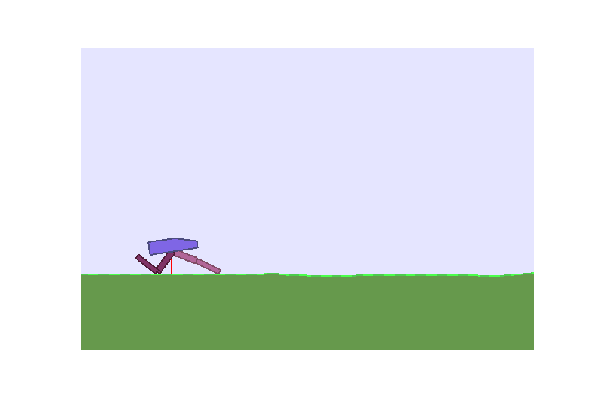
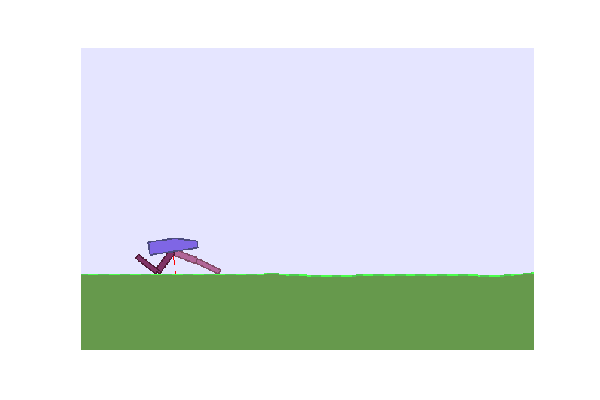
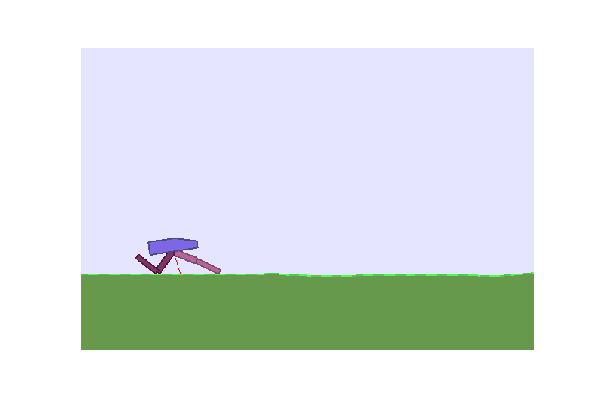
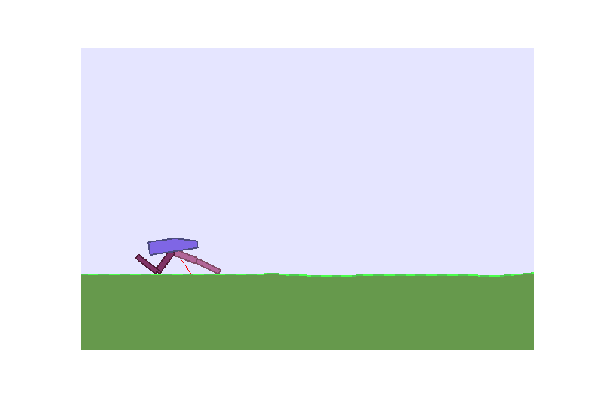
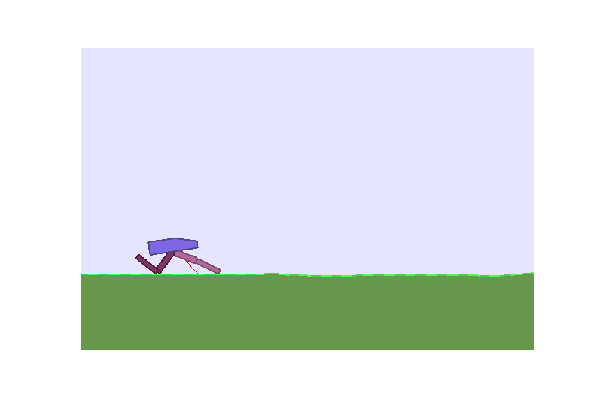
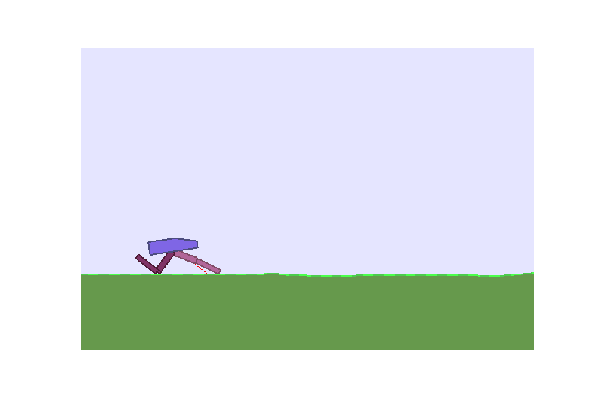
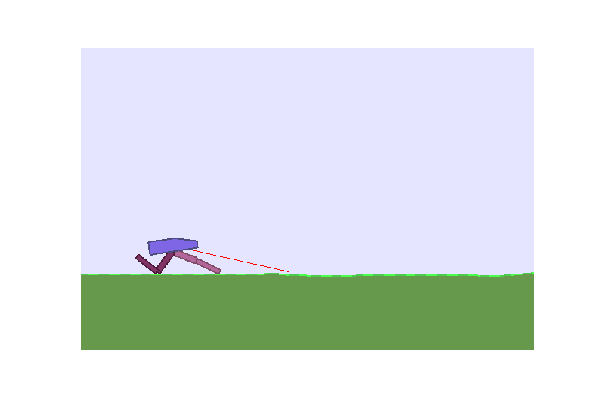
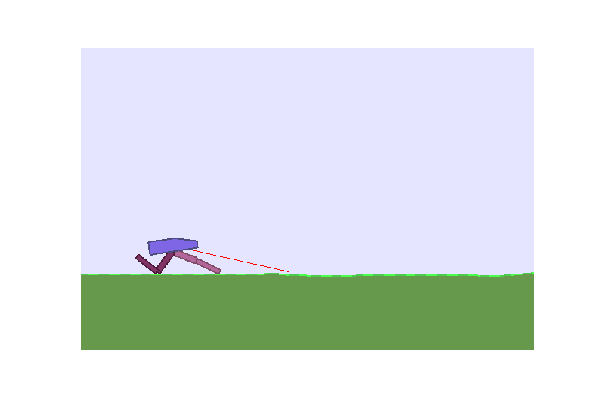
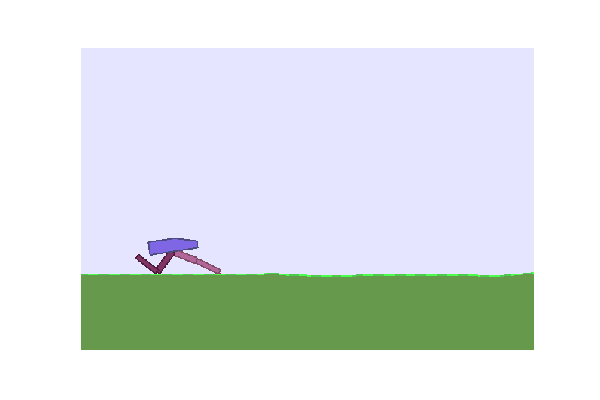
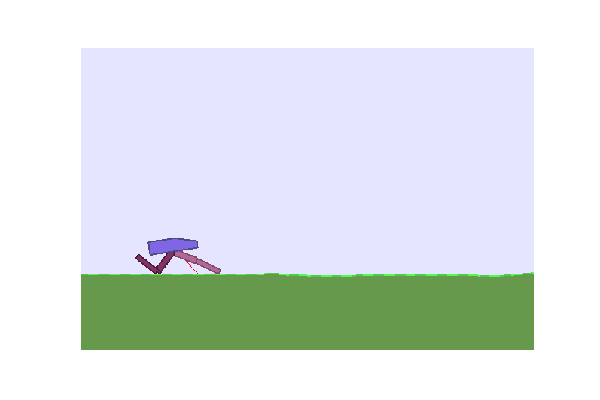
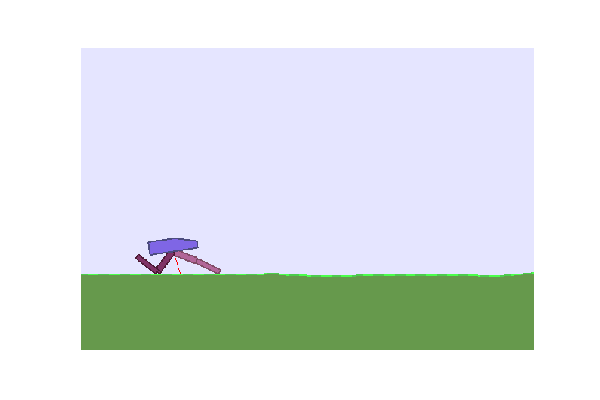
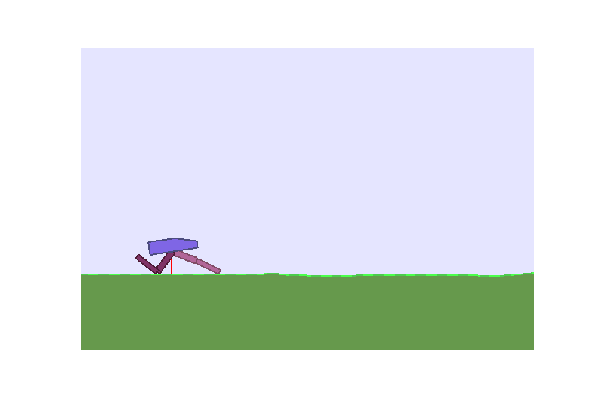
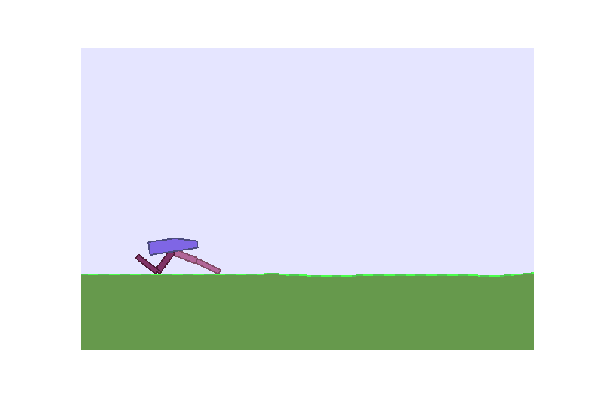
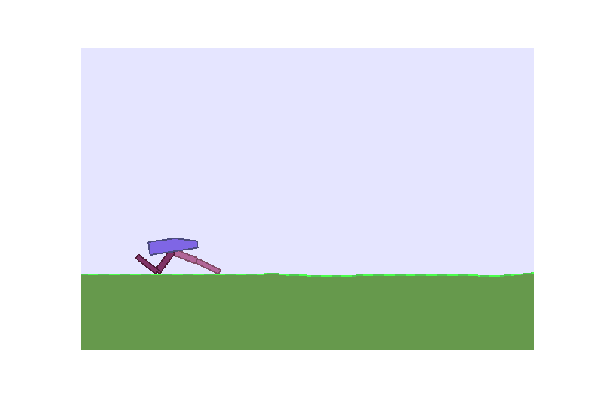
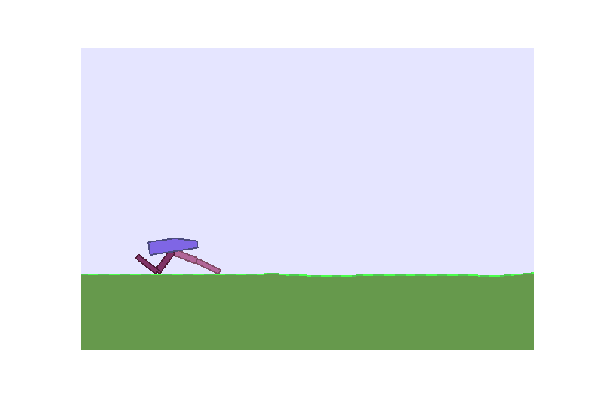
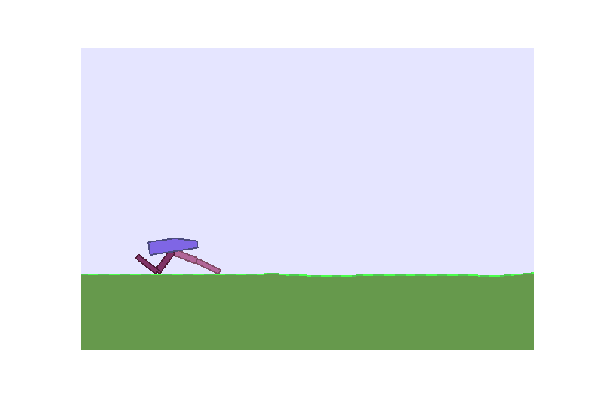
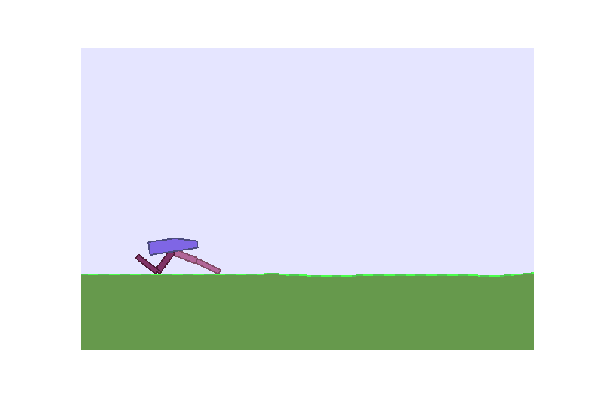
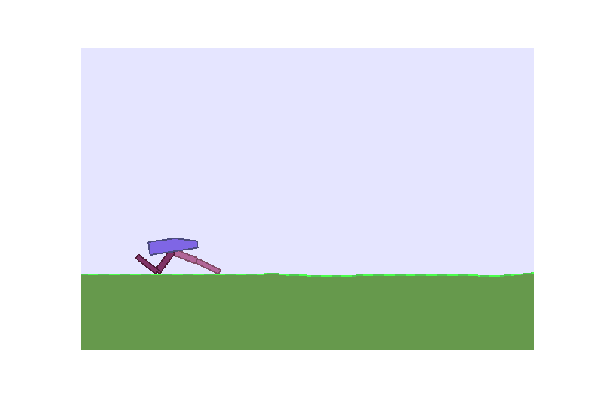
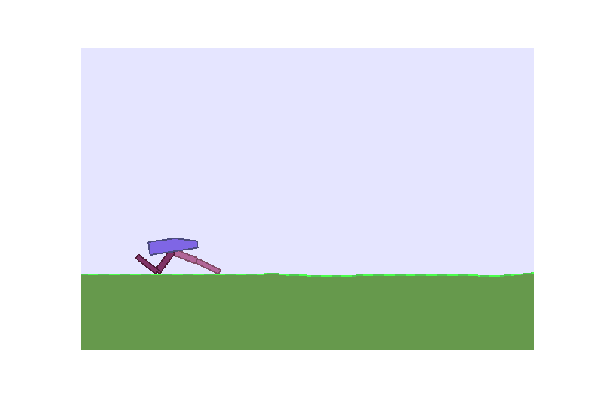
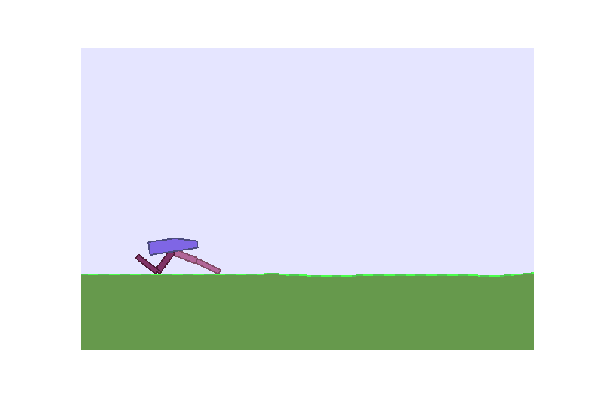
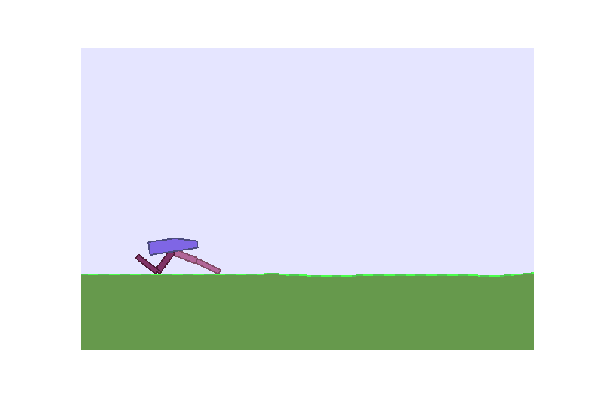
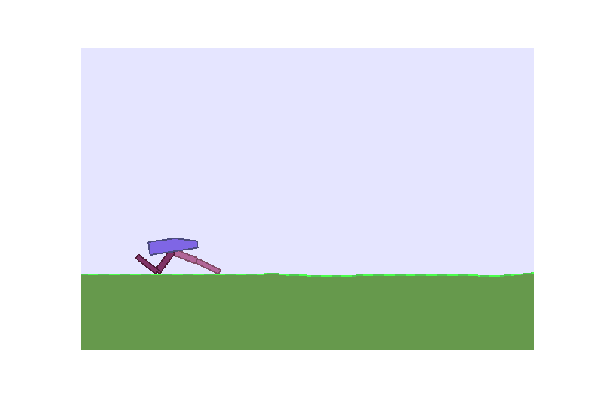
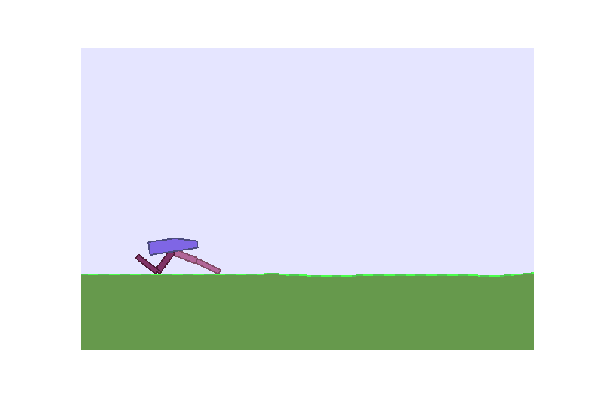
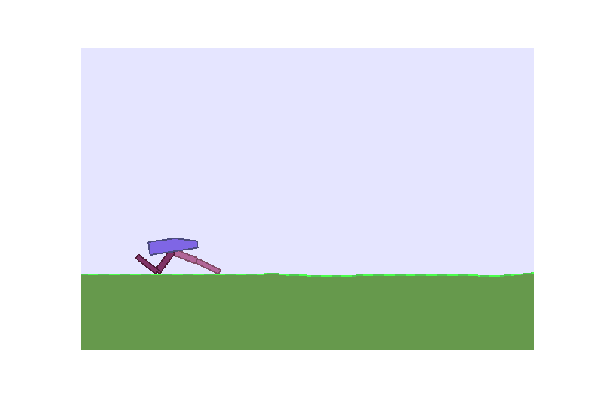
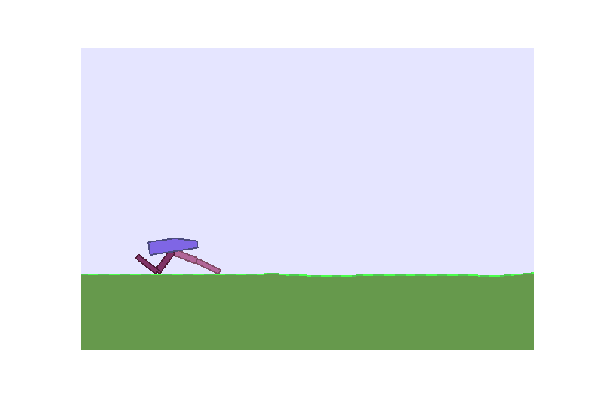
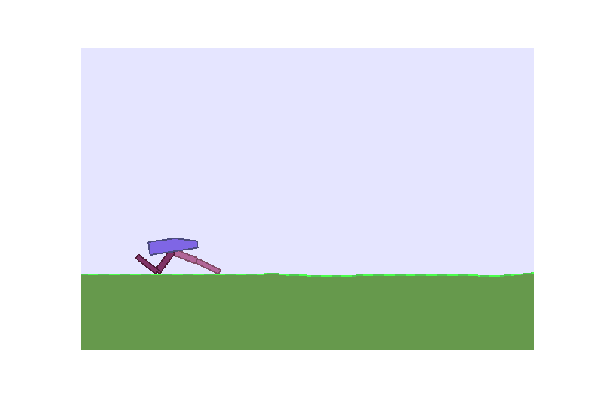
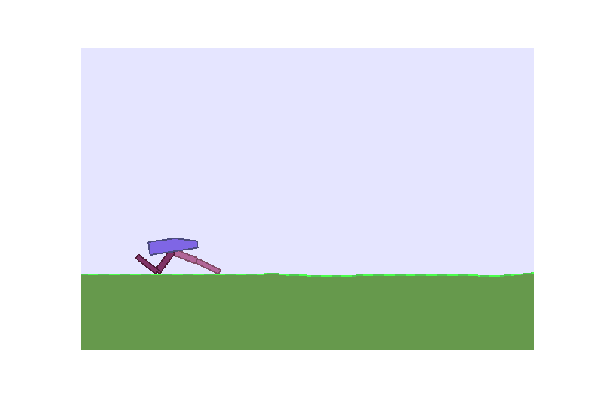
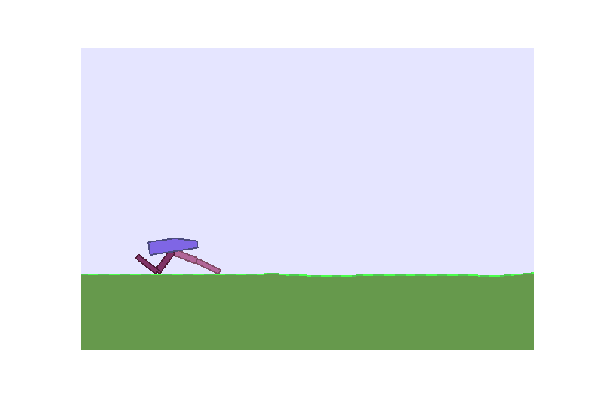
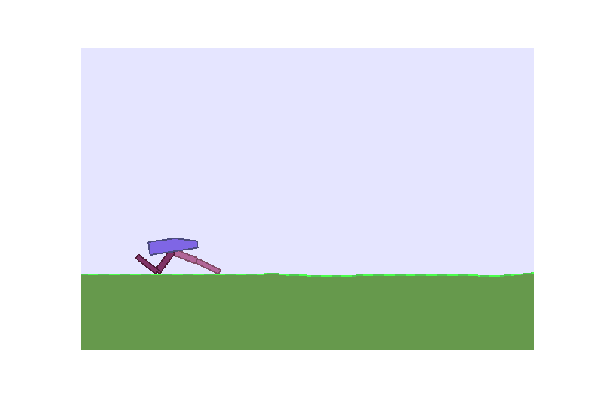
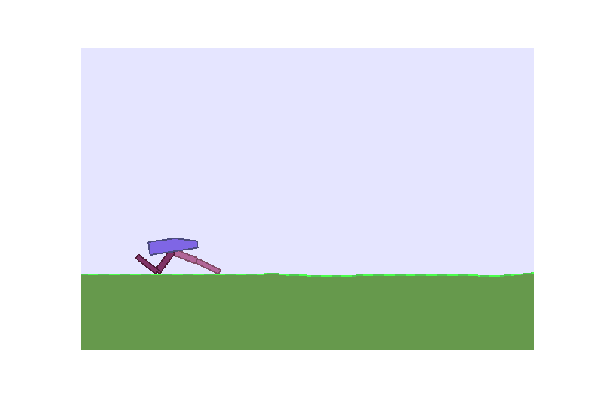
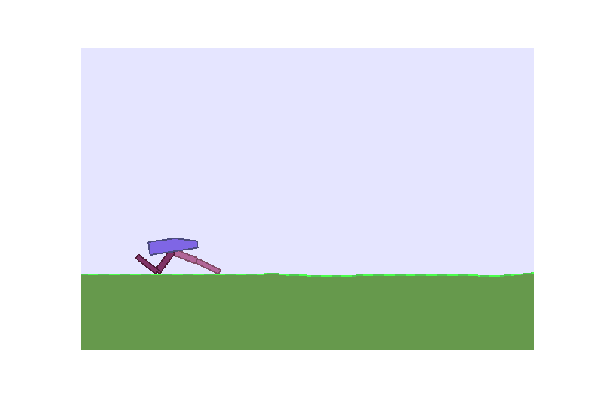
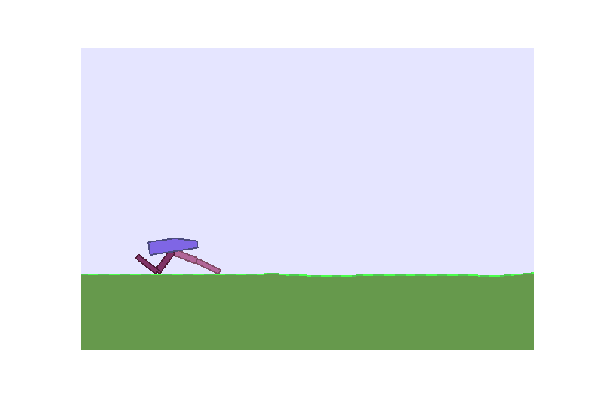
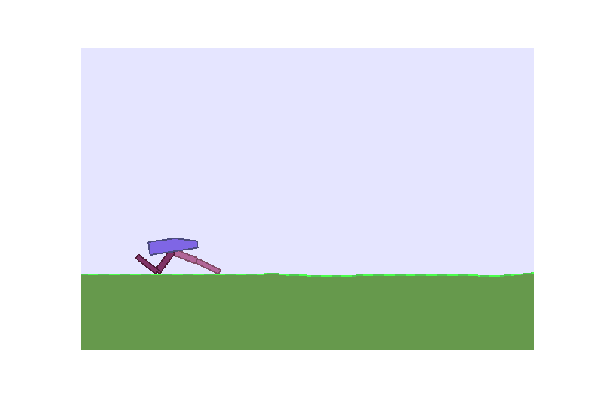
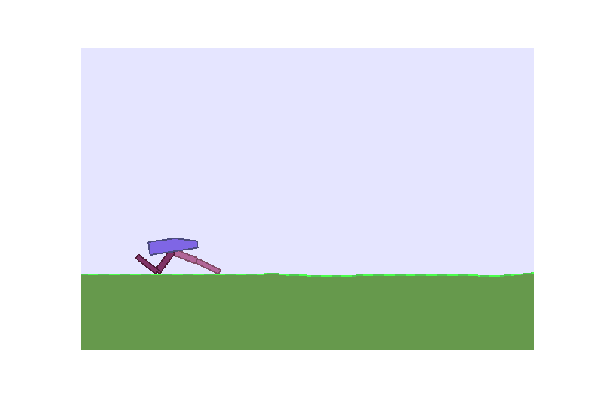
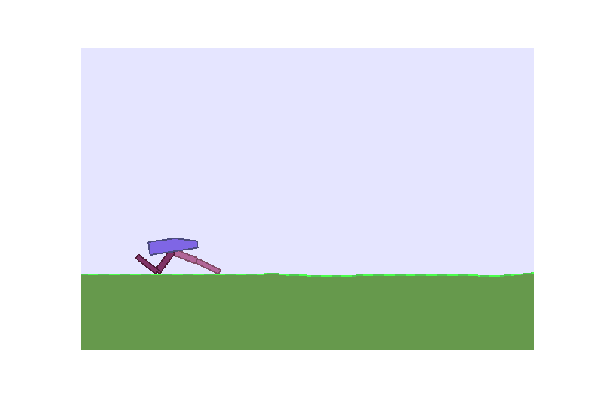
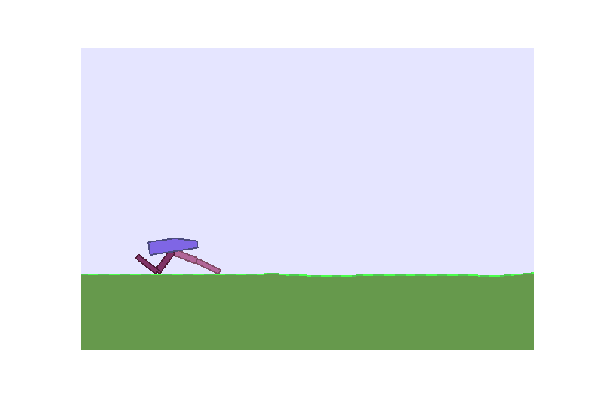
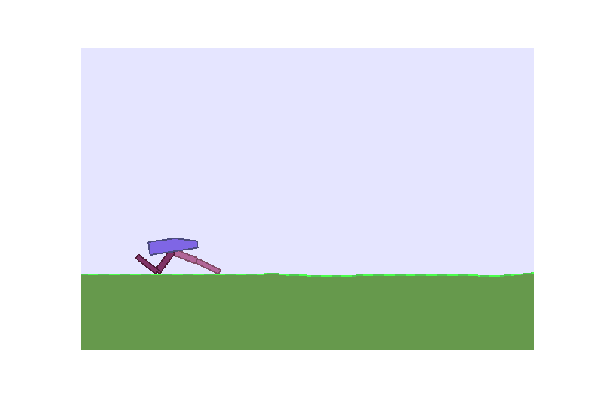
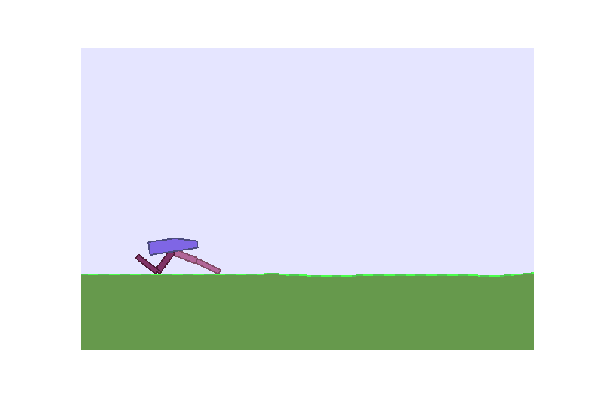
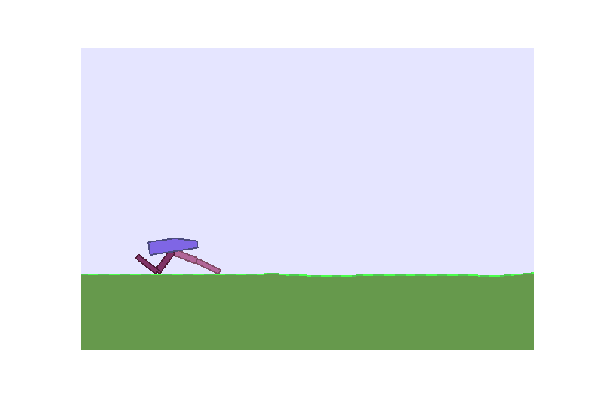
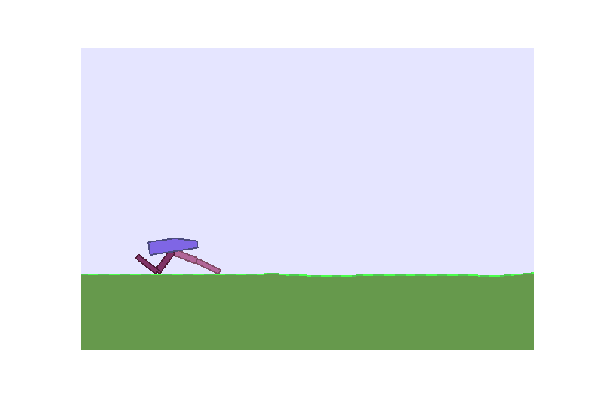
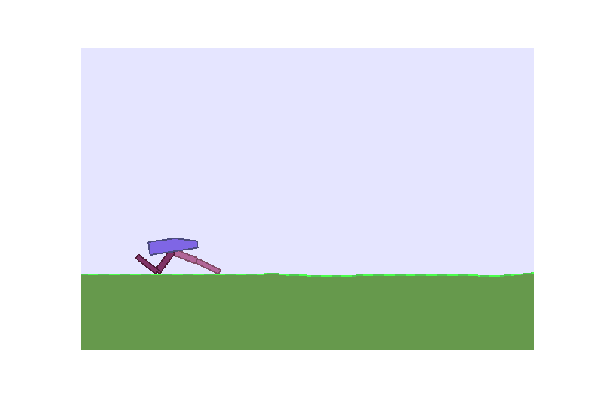
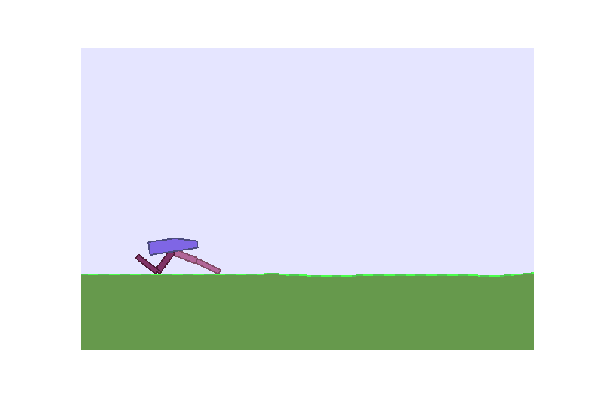
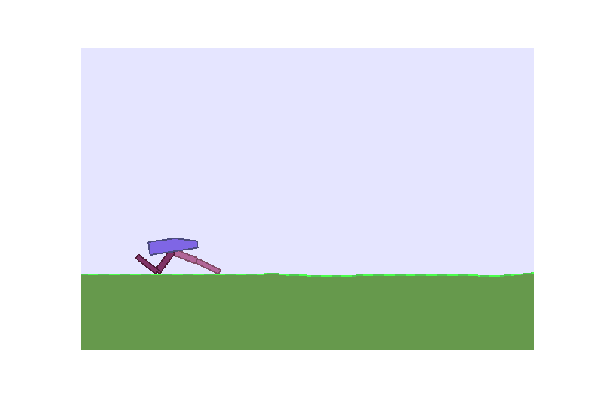
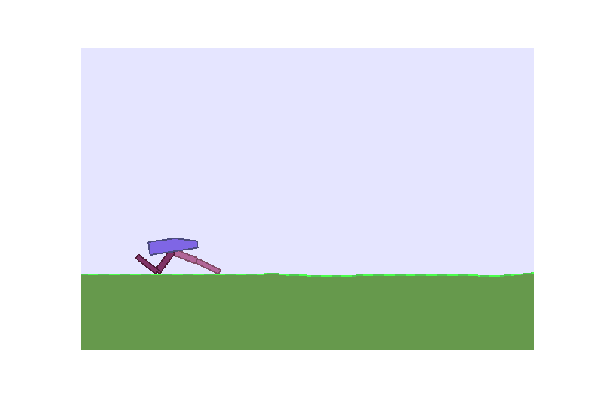
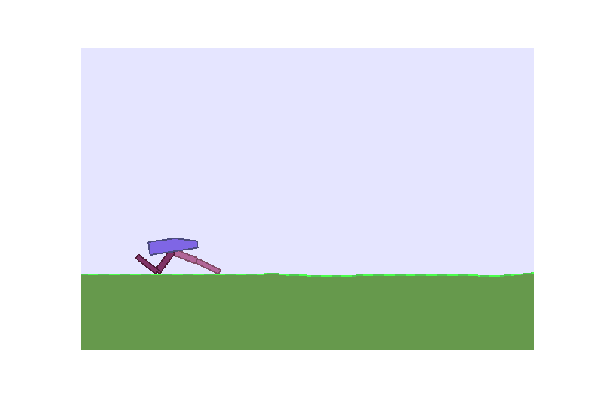
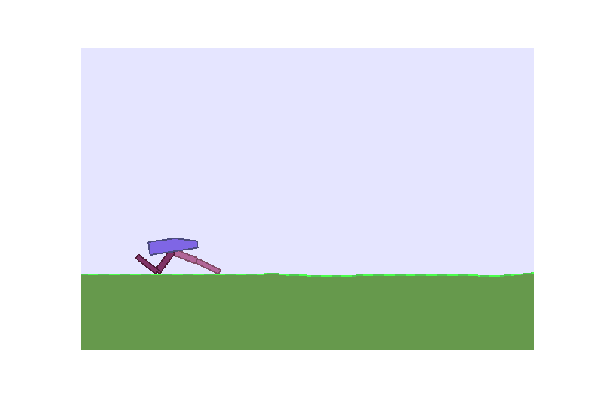
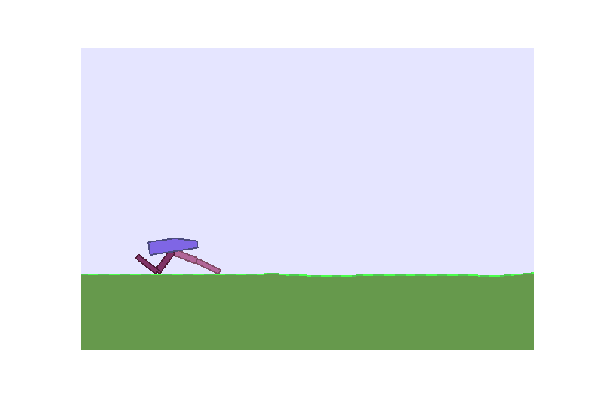
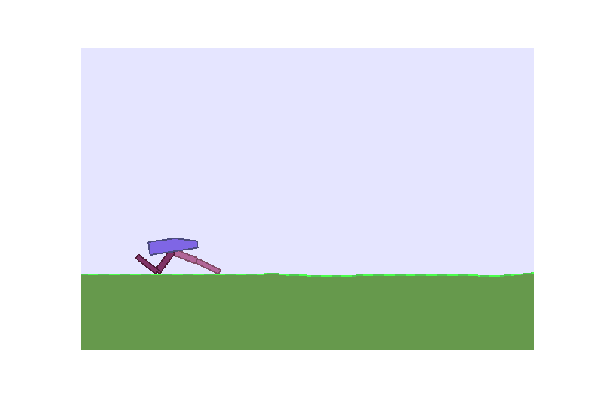
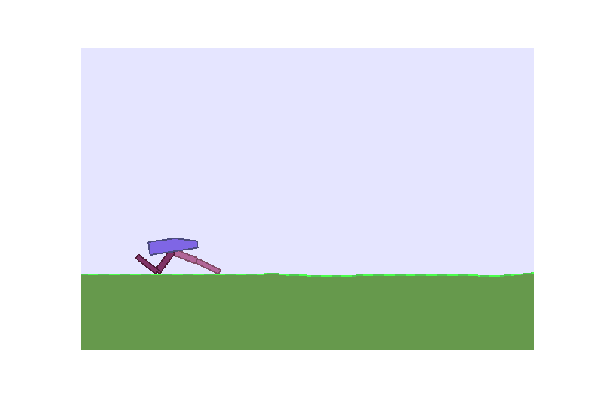
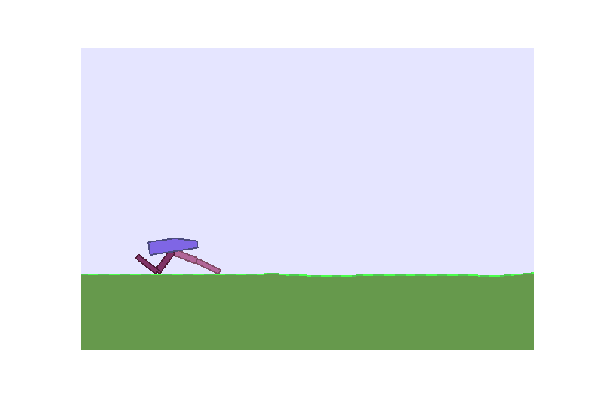
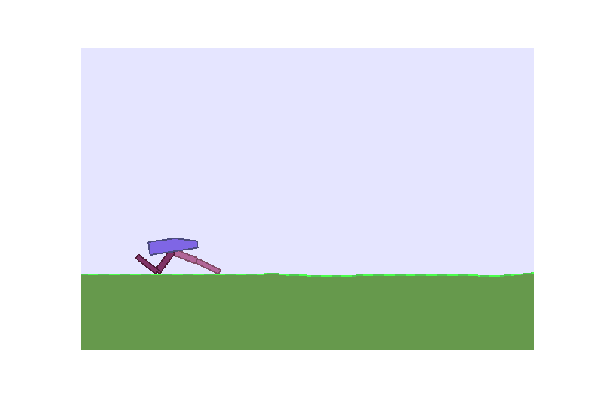
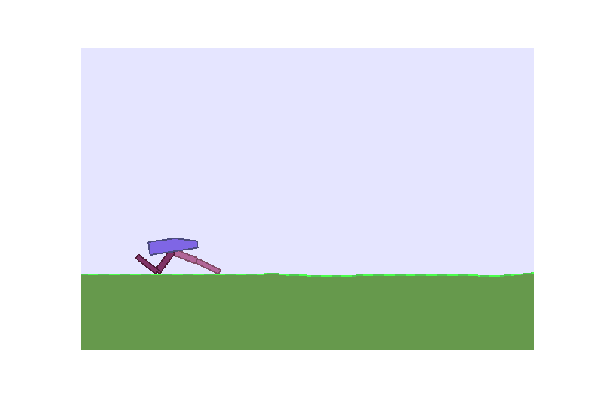
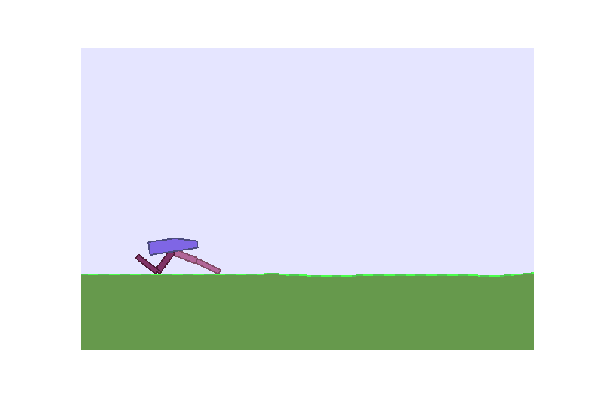
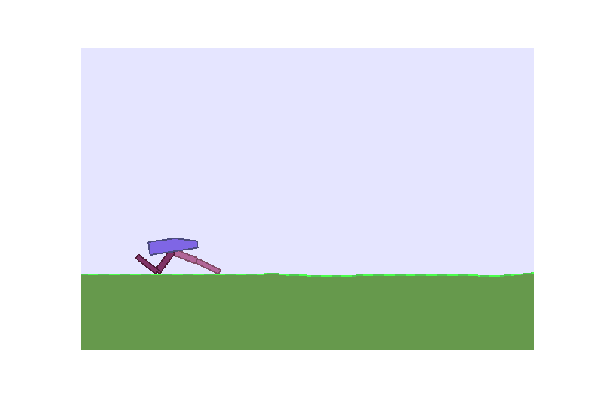
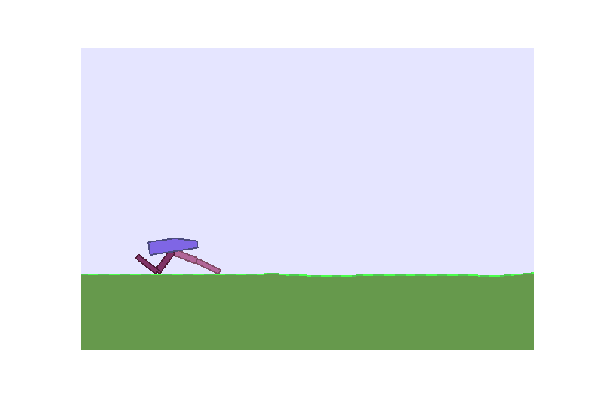
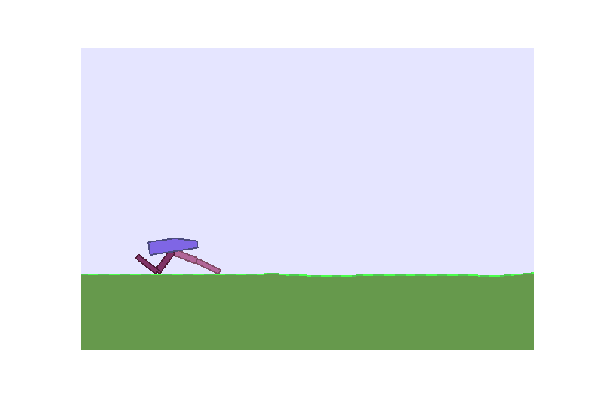
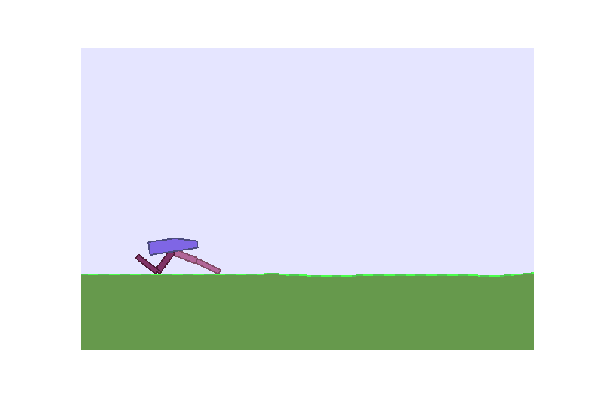
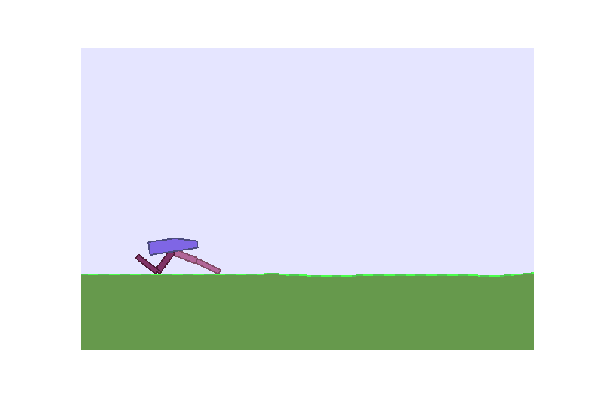
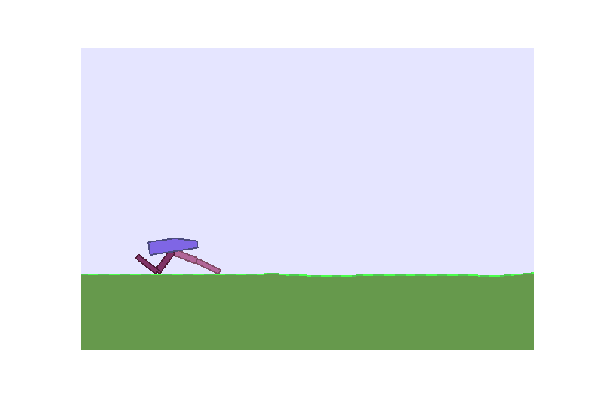
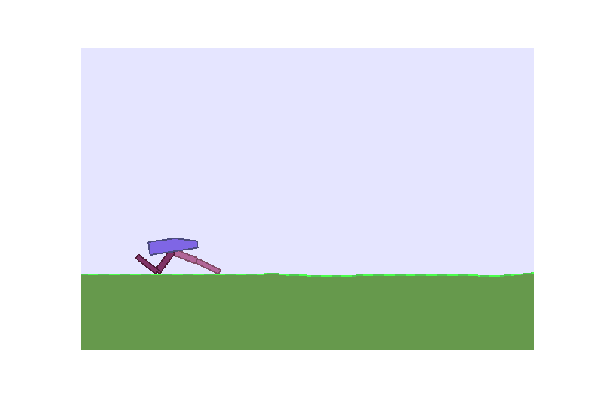
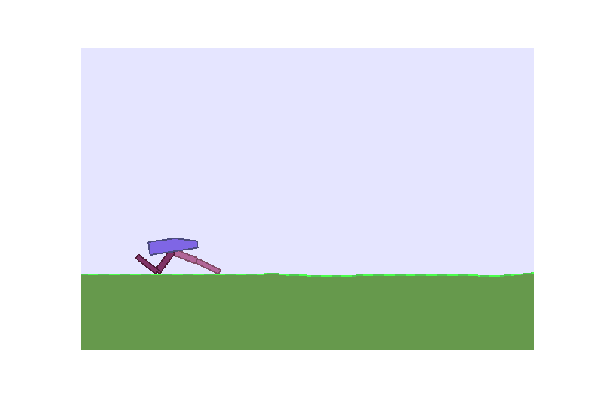
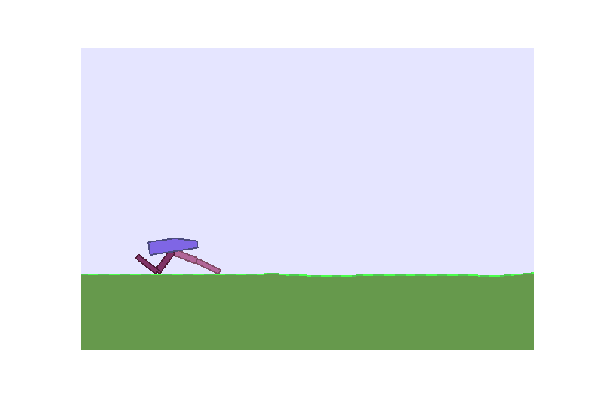
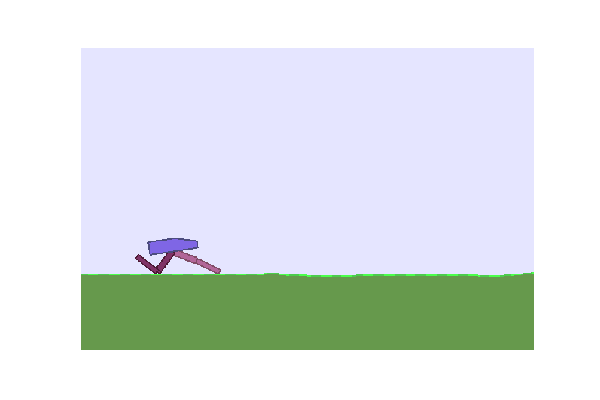
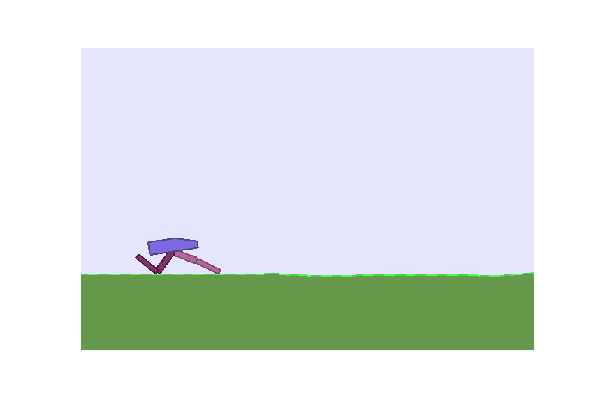
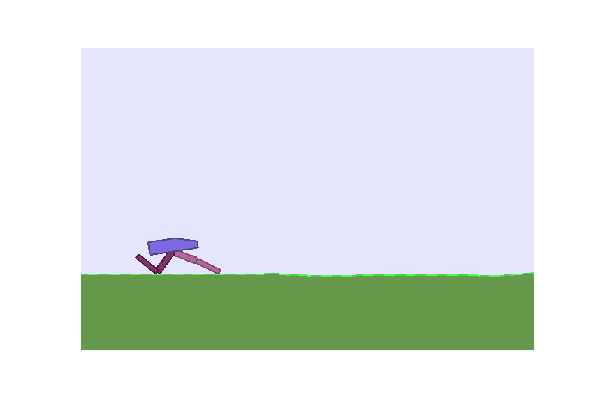
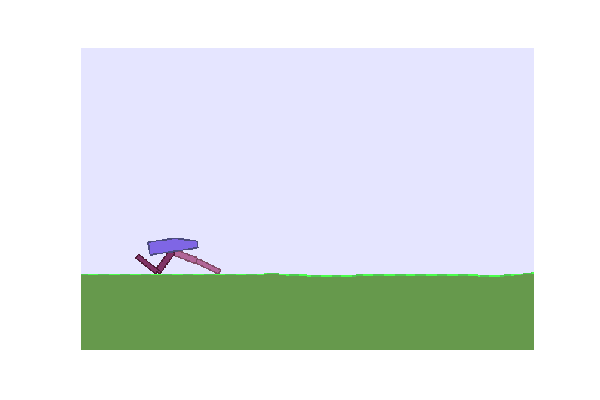
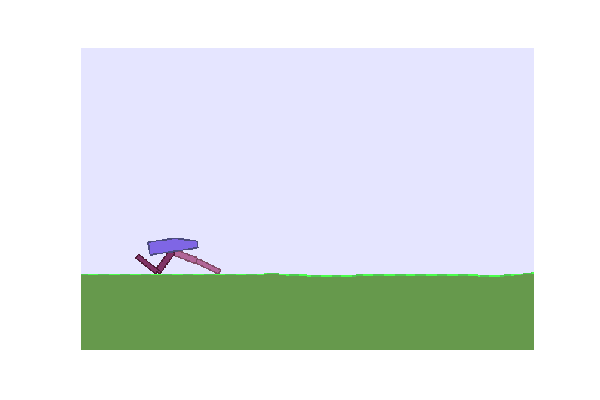
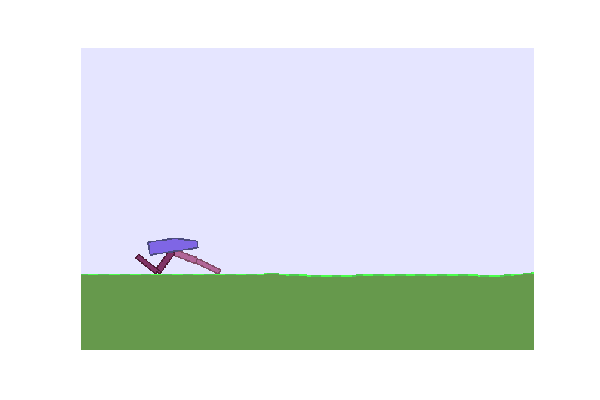
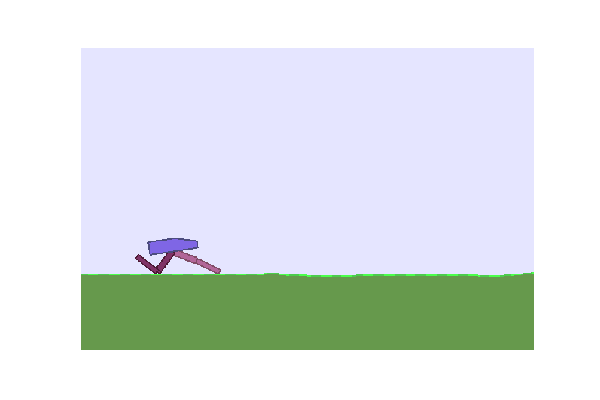
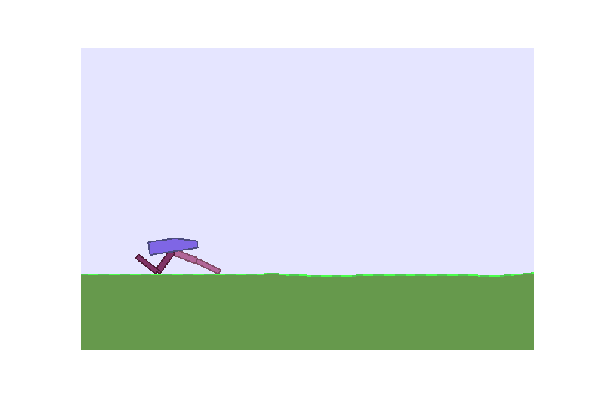
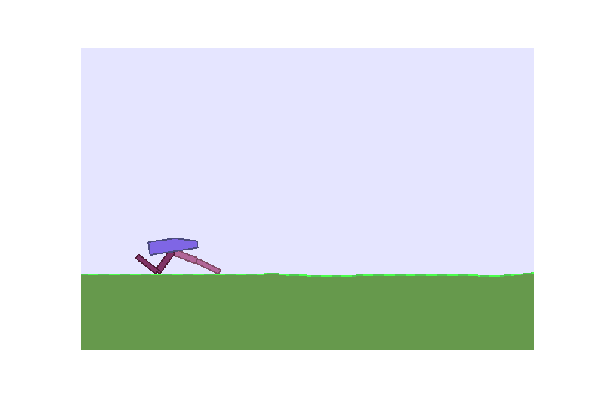
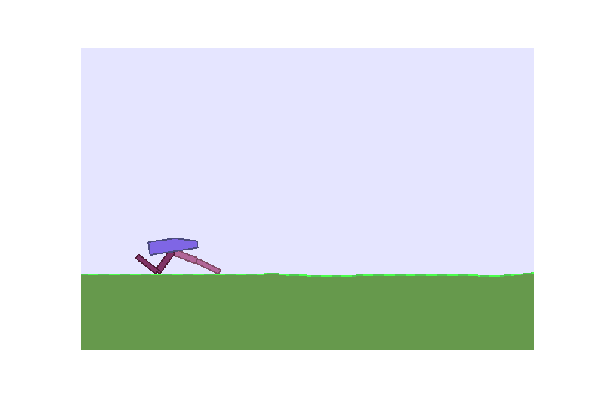
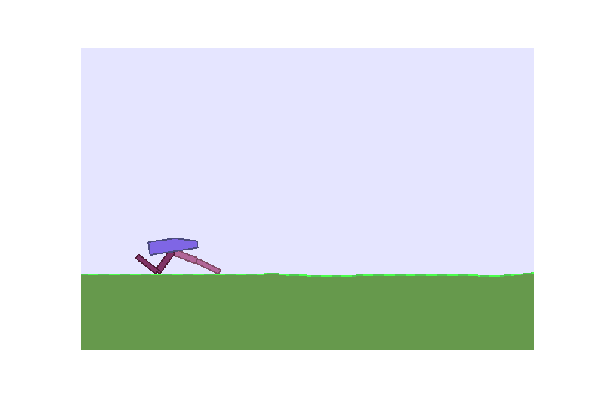
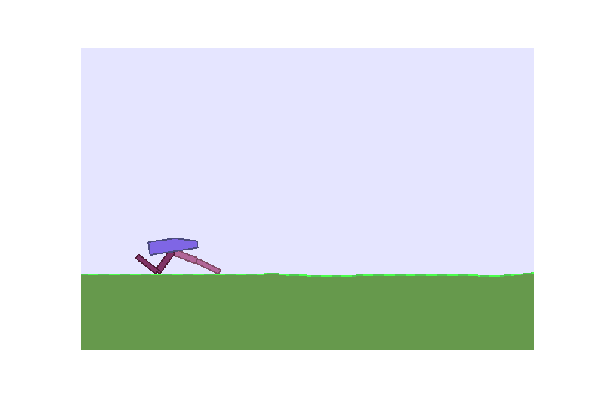
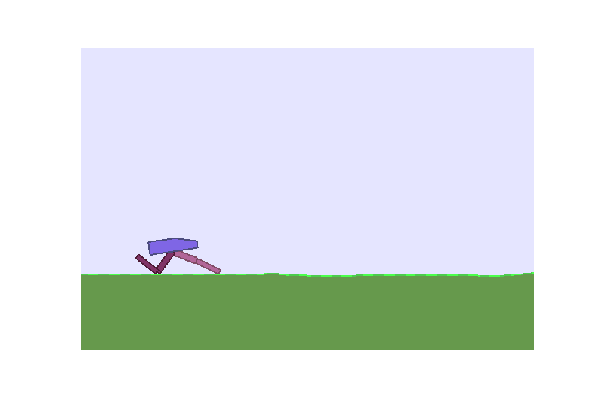
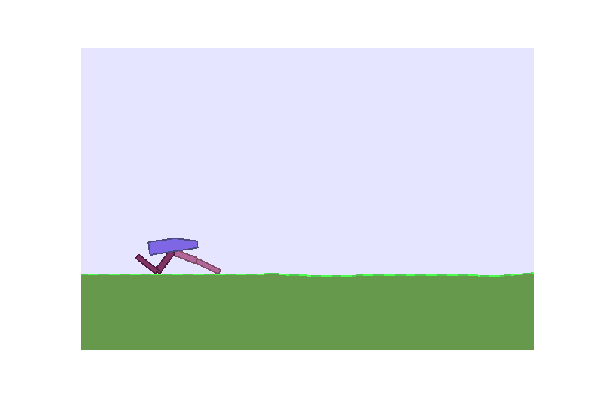
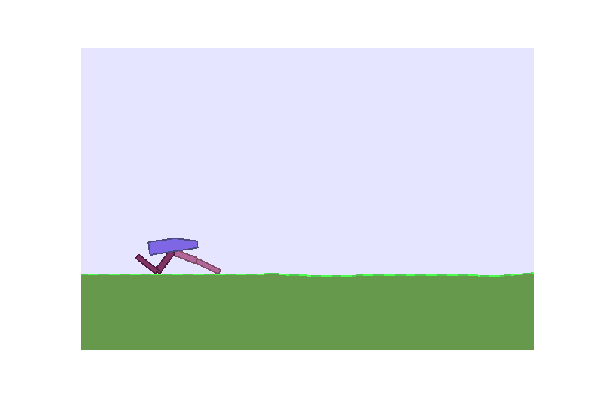
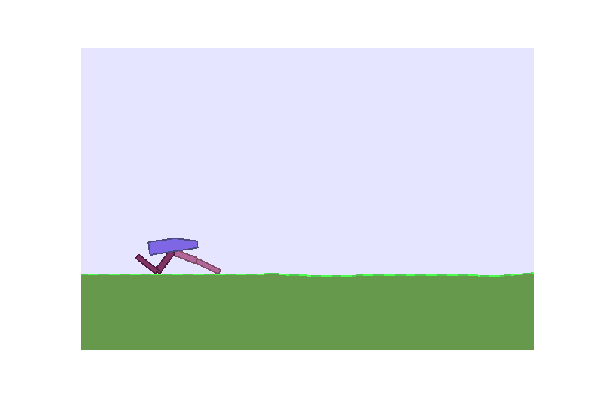
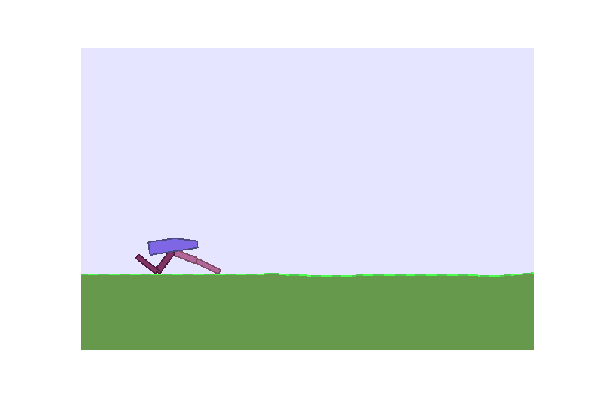
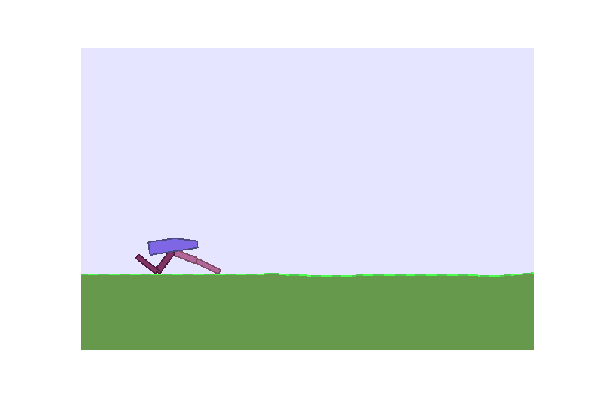
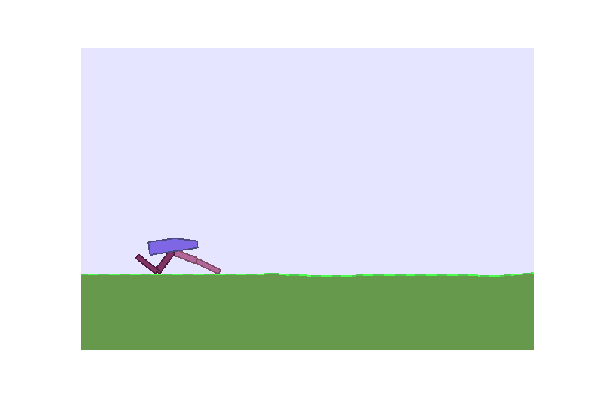
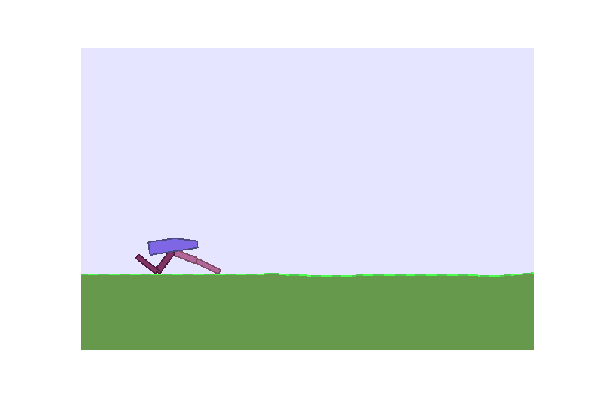
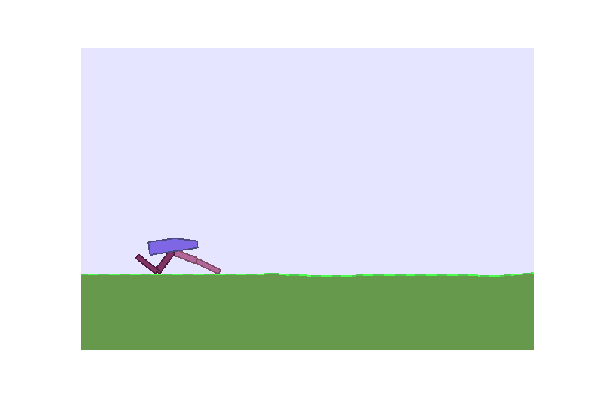
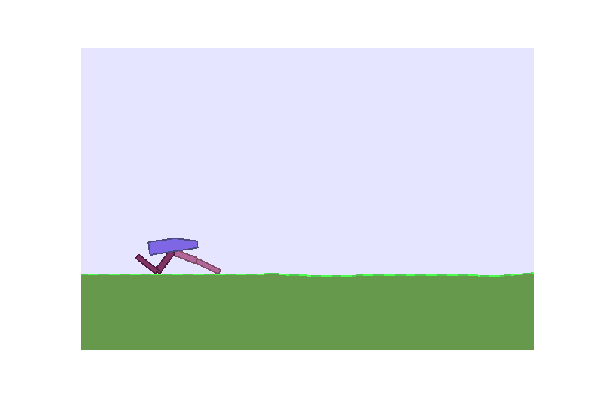
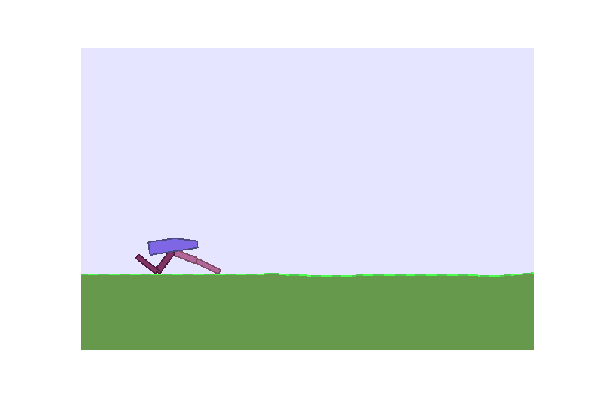
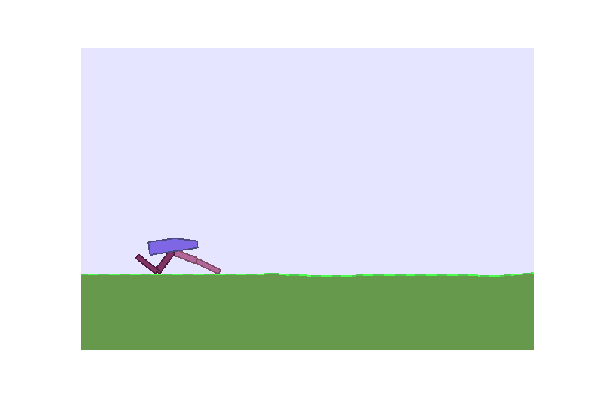
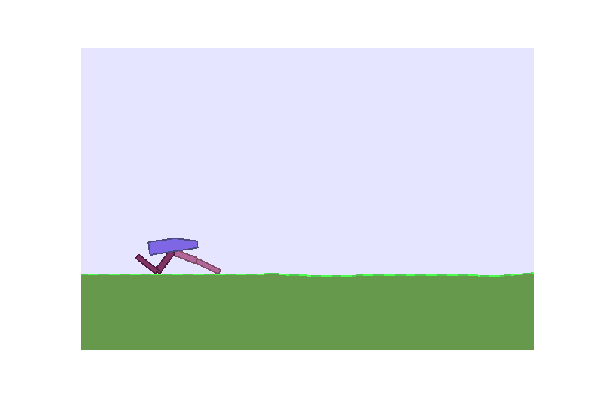
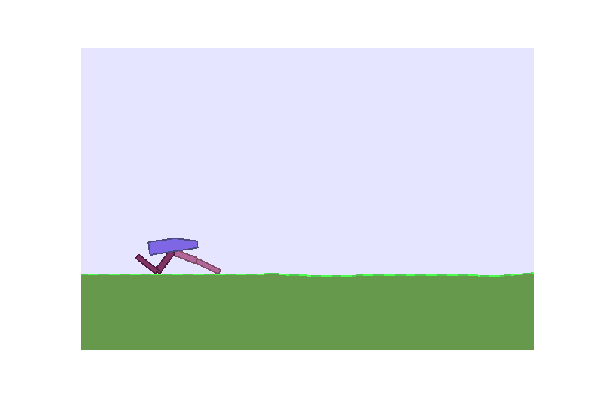
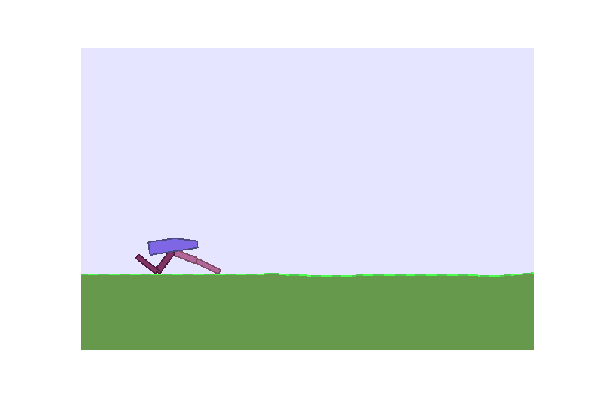
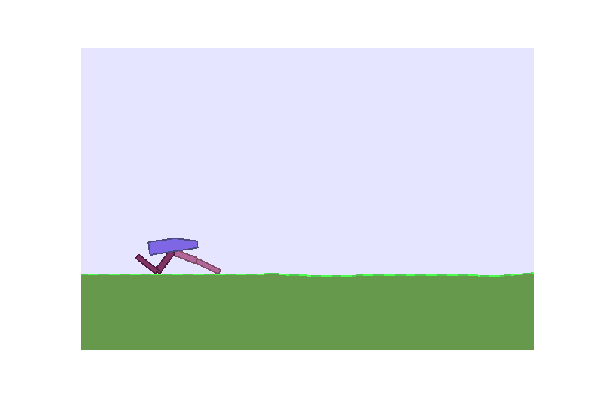
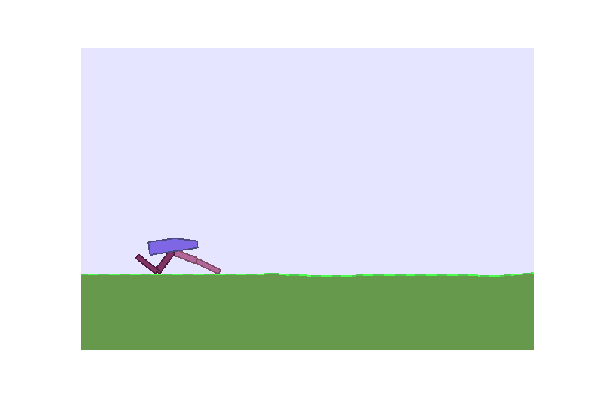
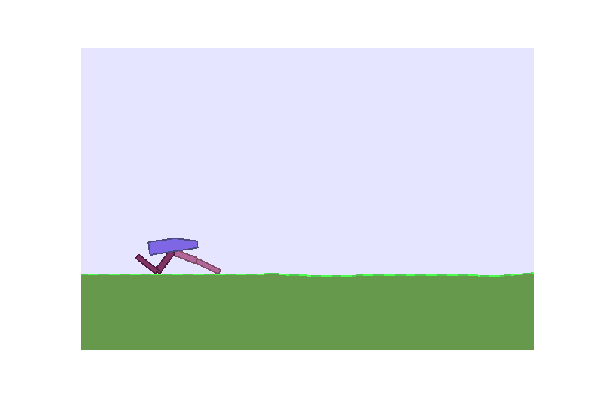
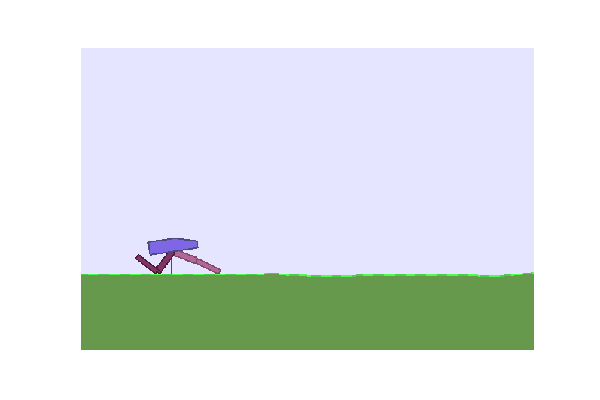
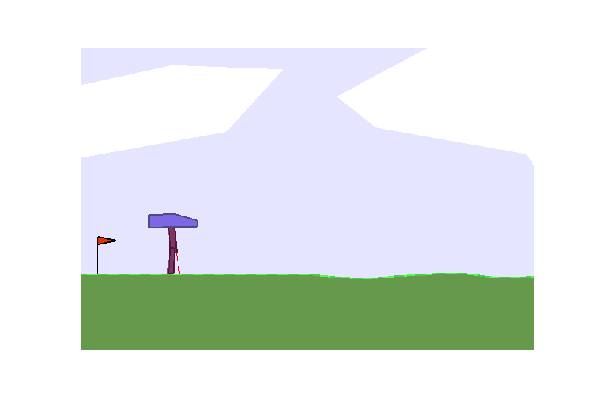

0.4728189

In [12]:
agent.play(record=True)

In [ ]:
frames = agent.record["frames"]
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')

def animate(i):
    patch.set_data(frames[i])

anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
#display(display_animation(anim, default_mode='loop'))

In [ ]:
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
anim.save('lol.mp4', writer=writer)